In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [606]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [2]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [3]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [4]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [5]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [6]:
ttgamma_cross = 0.144 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

In [7]:
Wgamma_fidcross  = 584.6234734948906
Wjets_fidcross   = 600.5788869631236
ttgamma_fidcross = 28.773979008
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1213.9763394660142

In [8]:
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * 1000 * Wjets_NLO)
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * 1000 * Wgamma_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * 1000 * ttgamma_NLO)

In [9]:
Wgamma_expected  = 58462.347349489064
Wjets_expected   = 60057.888696312366
ttgamma_expected = 2877.3979008
B_expected = (ttgamma_expected + Wjets_expected + Wgamma_expected)

In [10]:
sample = 200_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

96315
98944
4740


In [11]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_4.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_4.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_4.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_4.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_4.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_4.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_4.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_4.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_4.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_4.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_4.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_4.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_4.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_4.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_4.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [12]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [13]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)

156139
160401
7685


In [14]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]]) 
lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])

In [15]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1
bkg_flag_pool[Wgamma_pool_sample:(Wgamma_pool_sample + Wjets_pool_sample)] = 2
bkg_flag_pool[(Wgamma_pool_sample + Wjets_pool_sample):] = 3

In [16]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)

(259345, 4)
(2052938, 4)
(3579946, 4)


In [17]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_5.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_5.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_5.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_5.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_5.dat', delimiter=' ') )

In [18]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (199999, 5)
BP1 (524041, 5)
BP2 (492157, 5)
BP3 (414951, 5)
BP4 (603424, 5)
BP5 (533112, 5)
BP6 (406048, 5)
BP7 (631234, 5)
BP8 (560590, 5)
BP9 (451741, 5)
BP10 (652300, 5)
BP11 (583750, 5)
BP12 (488317, 5)
BP13 (670737, 5)
BP14 (602479, 5)
BP15 (516051, 5)


In [19]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([524041, 492157, 414951, 603424, 533112, 406048, 631234, 560590, 451741, 652300, 583750, 488317, 670737, 602479, 516051])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.02450796 4.59030589 6.36297195 1.11064713 2.35495829 3.33821603
 0.66005614 1.29200298 1.79306845 0.39933235 0.73575485 1.01992452
 0.22901644 0.41142086 0.57265147]
Events expected:  [202.4507965  459.03058905 636.29719543 111.06471288 235.49582866
 333.82160293  66.00561444 129.20029848 179.30684468  39.93323524
  73.57548516 101.99245228  22.90164413  41.14208595  57.26514737]


In [20]:
# other variables, individual channels:

ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [21]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

In [22]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [23]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(199999, 4)
(524041, 4)


# Analysis

## training

In [24]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(199999, 4)
(199999, 3)
(199999, 5)
(199999, 3)
(199999, 3)
(199999,)
(199999,)
(199999,)
(199999,)
(199999,)
(199999,)


In [690]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 12

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(670737, 4)
(670737, 3)
(670737, 5)
(670737, 3)
(670737, 3)
(670737,)
(670737,)
(670737,)
(670737,)
(670737,)
(670737,)


In [691]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

199999

In [692]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,15.86,-2.058,0.821,1.0,296.67,-0.655,2.626,51.93,-1.123,-0.563,...,413.30,345.51,2.0,364.46,11.993735,76.745327,537.908022,6.075664,1.0,0.0
1,14.88,2.159,-0.330,1.0,240.18,0.348,1.021,33.56,1.137,-1.430,...,375.17,326.73,3.0,288.62,9.223872,73.288285,412.024398,36.887141,1.0,0.0
2,32.74,-2.303,0.258,1.0,239.34,-1.569,-2.576,262.04,-2.288,0.255,...,763.99,469.21,4.0,534.12,4.407684,32.838551,339.484555,93.420209,2.0,0.0
3,67.73,-0.455,3.106,1.0,107.80,0.135,1.042,40.42,-1.319,-0.907,...,215.95,107.80,1.0,215.95,7.465004,95.640277,217.227488,69.269351,2.0,0.0
4,27.34,-2.093,2.141,1.0,157.66,-3.853,-1.720,31.78,-2.024,0.459,...,216.78,157.66,1.0,216.78,8.553701,30.340434,280.462672,69.287788,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399993,72.95,-0.104,0.695,1.0,125.98,2.317,2.753,24.10,0.822,-1.676,...,335.90,238.85,4.0,223.03,7.035846,126.220855,251.378867,51.188420,0.0,1.0
399994,18.63,-1.619,2.628,1.0,437.64,1.929,-2.756,49.21,0.661,0.284,...,706.17,638.33,2.0,505.48,21.344660,173.056079,989.211206,57.024531,0.0,1.0
399995,60.00,-1.344,2.279,1.0,112.12,-2.846,2.453,29.83,-0.887,-0.416,...,201.95,112.12,1.0,201.95,11.148476,194.091989,266.545580,17.414498,0.0,1.0
399996,39.94,0.875,0.413,1.0,258.55,-0.749,-1.187,61.76,1.854,2.266,...,393.55,291.85,2.0,360.25,10.821604,127.316245,471.153587,38.620891,0.0,1.0


In [693]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,25.14,0.913,-3.023,1.0,577.83,0.544,-2.265,46.98,1.145,0.561,...,987.85,915.73,4.0,649.95,14.029553,210.099906,960.866681,44.155409,2.0,0.0
1,18.53,0.008,-1.481,1.0,171.47,-0.086,1.176,120.76,0.005,-1.504,...,467.31,328.02,2.0,310.76,4.817888,12.782217,247.375191,35.180720,2.0,0.0
2,12.48,-0.299,-3.108,1.0,385.33,-0.548,-0.592,137.02,-0.299,-3.122,...,737.68,588.18,3.0,534.83,4.745904,10.326624,438.231103,32.371174,2.0,0.0
3,66.32,0.740,2.508,1.0,315.26,-1.114,-0.807,55.45,0.149,2.880,...,437.03,315.26,1.0,437.03,9.870720,42.347291,507.798808,76.963335,1.0,0.0
4,23.59,1.052,-1.269,1.0,126.25,-0.258,-0.593,38.75,1.198,-2.964,...,188.59,126.25,1.0,188.59,8.797910,105.406222,243.116410,73.049462,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794958,36.81,0.144,-2.984,1.0,380.41,1.366,-0.867,21.77,0.656,-2.279,...,762.45,703.87,2.0,438.99,6.337710,3.771897,455.602249,45.329850,0.0,1.0
794959,14.99,1.898,1.620,1.0,174.46,-1.581,2.382,10.16,-0.719,-1.537,...,301.47,276.32,4.0,199.61,13.112447,97.066091,389.895695,54.154052,0.0,1.0
794960,40.28,-1.014,0.543,1.0,106.82,-2.215,-0.195,14.04,0.079,-2.421,...,161.14,106.82,1.0,161.14,9.825042,135.222609,230.371427,32.096448,0.0,1.0
794961,60.81,0.827,1.098,1.0,365.75,2.539,2.879,24.05,2.177,-0.610,...,808.43,723.57,4.0,450.61,3.769225,133.863505,378.607273,12.507962,0.0,1.0


In [694]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [695]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [696]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [697]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [698]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))

In [699]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))

In [700]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [701]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma

In [702]:
if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))

There are less Wgamma events 19166 than expected 58462.347349489064
There are less Wjets events 19785 than expected 60057.888696312366


In [703]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.64809	validation_1-logloss:0.64813
[1]	validation_0-logloss:0.61047	validation_1-logloss:0.61068
[2]	validation_0-logloss:0.57921	validation_1-logloss:0.57975
[3]	validation_0-logloss:0.55223	validation_1-logloss:0.55273
[4]	validation_0-logloss:0.52960	validation_1-logloss:0.53023
[5]	validation_0-logloss:0.50959	validation_1-logloss:0.51038
[6]	validation_0-logloss:0.49157	validation_1-logloss:0.49243
[7]	validation_0-logloss:0.47553	validation_1-logloss:0.47648
[8]	validation_0-logloss:0.46219	validation_1-logloss:0.46309
[9]	validation_0-logloss:0.44979	validation_1-logloss:0.45068
[10]	validation_0-logloss:0.43947	validation_1-logloss:0.44044
[11]	validation_0-logloss:0.42933	validation_1-logloss:0.43033
[12]	validation_0-logloss:0.42003	validation_1-logloss:0.42113
[13]	validation_0-logloss:0.41235	validation_1-logloss:0.41344
[14]	validation_0-logloss:0.40569	validation_1-logloss:0.40693
[15]	validation_0-logloss:0.39892	validation_1-logloss:0.40023
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [704]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [705]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (319998, 22)
y_mon_train :  (319998,)
X_mon_val :  (80000, 22)
y_mon_val :  (80000,)
X_mon_test :  (794963, 22)
y_mon_test :  (794963,)



In [706]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

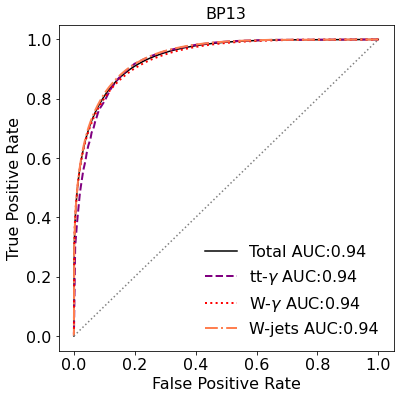

In [707]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All.png', bbox_inches='tight')

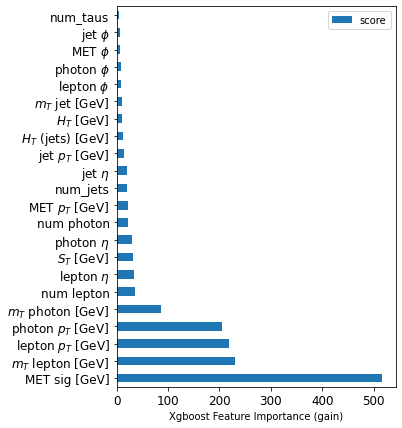

In [708]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All.png', bbox_inches='tight')

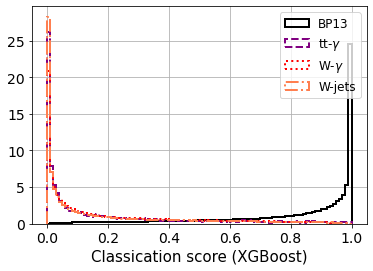

In [709]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All.png', bbox_inches="tight")

In [710]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [711]:
len(np.where(bkg_flag_test != 0)[0])

324225

In [712]:
len(np.where(bkg_flag_test == 0)[0])

470738

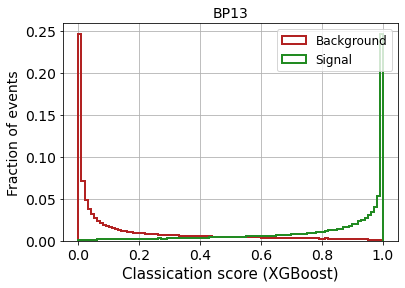

In [713]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [714]:
S_expected[bp]

22.901644128

In [715]:
S_expected[bp] / np.sqrt(B_expected)

0.06572985656871923

In [716]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_1389799/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [717]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 50, replace = True)

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)


        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

MET $\phi$ <= 3.142; Z = 0.06314014675505733
num_taus <= 0.0; Z = 0.06353809937288189
lepton $\eta$ >= -1.9444444444444444; Z = 0.06518773690624889
MET $\phi$ <= 3.142; Z = 0.06518773690624889
num_taus <= 0.0; Z = 0.06518773690624889
jet $\phi$ <= 3.142; Z = 0.06518773690624889
jet $\phi$ <= 3.142; Z = 0.06518773690624889
lepton $\eta$ <= 2.5; Z = 0.06518773690624889
num_jets <= 7.666666666666666; Z = 0.06528180321672068
jet $p_T$ [GeV] <= 1623.56; Z = 0.06528496524933469
MET $p_T$ [GeV] <= 1430.7766666666664; Z = 0.06528496524933469
MET $\phi$ <= 3.142; Z = 0.06528496524933469
$m_T$ lepton [GeV] <= 407.21515604291073; Z = 0.06530279457648475
lepton $\phi$ <= 3.142; Z = 0.06530279457648475
MET $\phi$ <= 3.142; Z = 0.06530279457648475
lepton $\phi$ <= 3.142; Z = 0.06530279457648475
num_taus <= 0.0; Z = 0.06530279457648475
jet $p_T$ [GeV] <= 1454.2411111111112; Z = 0.06530509592181687
num_jets <= 7.0; Z = 0.06530509592181687
MET $\phi$ <= 3.142; Z = 0.06530509592181687
$H_T$ [GeV] <= 276

In [718]:
sup_cuts

{'MET $\\phi$': 3.142,
 'num_taus': 0.0,
 'lepton $\\eta$': 2.5,
 'jet $\\phi$': 3.142,
 'num_jets': 6.333333333333333,
 'jet $p_T$ [GeV]': 1302.5966666666668,
 'MET $p_T$ [GeV]': 2096.16,
 '$m_T$ lepton [GeV]': 301.6229304963245,
 'lepton $\\phi$': 3.142,
 '$H_T$ [GeV]': 2763.2,
 '$m_T$ photon [GeV]': 326.57212428482626,
 '$H_T$ (jets) [GeV]': 2697.0,
 '$m_T$ jet [GeV]': 2473.683365905021,
 'num lepton': 1.0,
 'jet $\\eta$': 4.421,
 'photon $p_T$ [GeV]': 1175.8366666666666,
 'lepton $p_T$ [GeV]': 52.4,
 'photon $\\phi$': 3.142,
 'MET sig [GeV]': 999999,
 'photon $\\eta$': 2.369}

In [719]:
inf_cuts

{'MET $\\phi$': -999999,
 'num_taus': -999999,
 'lepton $\\eta$': -1.9444444444444444,
 'jet $\\phi$': -999999,
 'num_jets': -999999,
 'jet $p_T$ [GeV]': -999999,
 'MET $p_T$ [GeV]': -999999,
 '$m_T$ lepton [GeV]': 90.48685984447371,
 'lepton $\\phi$': -999999,
 '$H_T$ [GeV]': -999999,
 '$m_T$ photon [GeV]': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 '$m_T$ jet [GeV]': -999999,
 'num lepton': -999999,
 'jet $\\eta$': -999999,
 'photon $p_T$ [GeV]': -999999,
 'lepton $p_T$ [GeV]': -999999,
 'photon $\\phi$': -999999,
 'MET sig [GeV]': 7.954800925033075,
 'photon $\\eta$': -999999}

In [720]:
write = False
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [721]:
indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [722]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.20180209620490747
Expected Background = 882
Expected Signal = 6


In [723]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,23] == 0)[0]
NP_test_pool = np.where(df_test_array[:,23] == 1)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets
    
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|███████████████████████████████| 2000/2000 [00:29<00:00, 68.74it/s]


(array([ 53., 106., 485., 316., 611., 182., 186.,  39.,  20.,   2.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

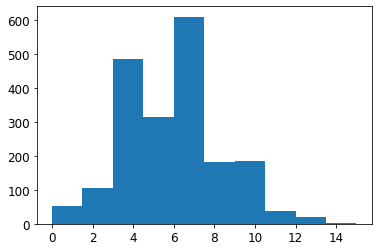

In [724]:
plt.hist(S_observed_exp)

In [725]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 13
 
Z = 0.5705955483199863; Z_std = 0.8911700645664941
B_exp = 883.235; B_exp_std = 23.91875362555499
S_exp = 5.731; S_exp_std = 2.374792411980466


In [726]:
imp_vars = np.array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'])
#imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]


In [727]:
imp_vars

array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

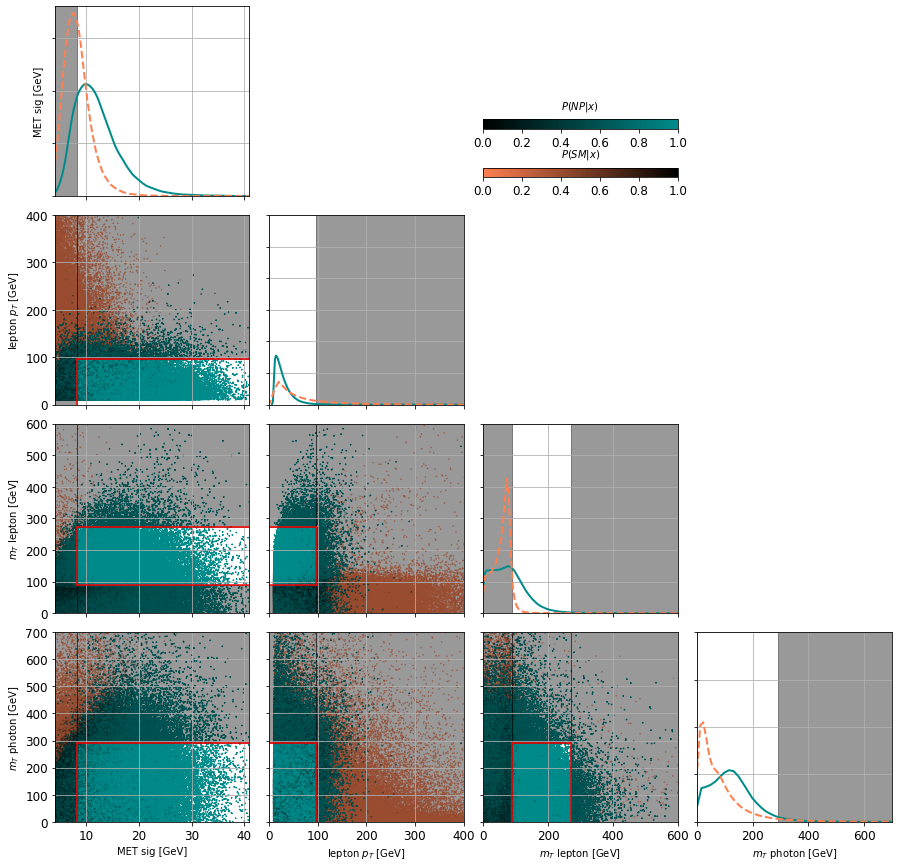

In [728]:
SM = df_test.loc[df_test['bkg_flag_pool'] > 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 0]

limites = [[4,41], [0,400], [0,600], [0,700]]
ylimites = [[0,0.18], [0,0.15], [0,0.03], [0,0.02]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars[0])
ax[3,1].set_xlabel(imp_vars[1])
ax[3,2].set_xlabel(imp_vars[2])
ax[3,3].set_xlabel(imp_vars[3])

ax[0,0].set_ylabel(imp_vars[0])
ax[1,0].set_ylabel(imp_vars[1])
ax[2,0].set_ylabel(imp_vars[2])
ax[3,0].set_ylabel(imp_vars[3])

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist.pdf')

## BinnedLikelihood

In [587]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(324225,)
(316052,)


In [588]:
B_expected = int(B_expected)

In [589]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  499 OK (max # bins tested)

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  499
range of our data:  [[0, 1]]


In [590]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP15:

[1.0623692635303872]


B_expected:  121397
S_expected:  57.265147368

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


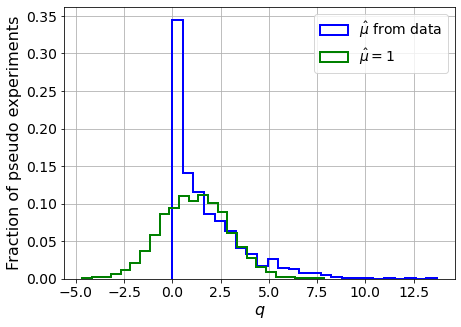

muhat mean:  1.0244250000000001
Z_bins:  1.0823818428400191
std Z_bins:  0.8793173190403103
Z_bins mu=0:  1.0850234671457848
std Z_bins mu=0:  0.7935054035505765

--------


 FINAL RESULT:

[[1.0823818428400191, 0.8793173190403103, 1.0244250000000001, 1.0850234671457848, 0.7935054035505765]]


In [591]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  121397
S_expected:  57.265147368

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


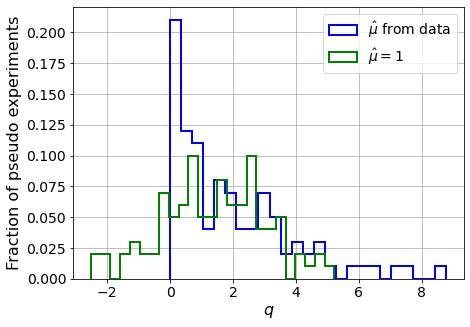

muhat mean:  1.1034975688268953
Z_bins:  1.2064881806919479
std Z_bins:  0.7845626157222707
Z_bins mu=0:  1.198479027427632
std Z_bins mu=0:  0.682110520746902

--------


 FINAL RESULT:

[[1.2064881806919479, 0.7845626157222707, 1.1034975688268953, 1.198479027427632, 0.682110520746902]]


In [592]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

In [ ]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

In [ ]:
print(norm_factor_SM)
print(norm_factor_NP)

In [ ]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

In [ ]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

In [ ]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [ ]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [ ]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_KDEfijo.pdf')

## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable_B_2.pdf')

## loop varying ML

In [593]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.9693663935230707


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 23276.43597195 22424.27554837 21407.38277662 20264.91443238
 19006.60214386 17618.07847079 16091.56587714 14424.400955
 12593.61697865 10602.84382492  8433.56464165  6085.02114283
  3538.78453055   831.48953866 -2049.27474956 -5077.85883619]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12749.72240321 12612.81941102 12414.47508317
 1

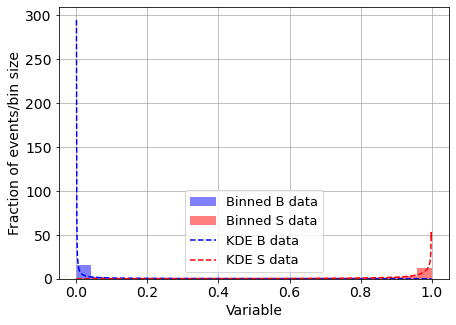

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|▏                                | 10/2000 [00:16<50:20,  1.52s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1597369137587139
<p_{s}(Sdata)> = 13.366210880135586
<p_{b}(Bdata)> = 98.91009810641236
<p_{s}(Bdata)> = 0.22243571820192443


  1%|▏                                | 12/2000 [00:19<44:52,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14894911289361465
<p_{s}(Sdata)> = 14.893509203334839
<p_{b}(Bdata)> = 99.8410574744232
<p_{s}(Bdata)> = 0.22000232442223897


  1%|▎                                | 20/2000 [00:33<49:46,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17666248248831923
<p_{s}(Sdata)> = 9.573267304647443
<p_{b}(Bdata)> = 100.13138696516693
<p_{s}(Bdata)> = 0.2112773919008904


  1%|▎                                | 21/2000 [00:34<38:21,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17294388153151902
<p_{s}(Sdata)> = 8.330084541143432
<p_{b}(Bdata)> = 99.53878182758983
<p_{s}(Bdata)> = 0.2111348244582826


  2%|▊                                | 47/2000 [01:14<39:40,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16534256749361778
<p_{s}(Sdata)> = 13.067804366132206
<p_{b}(Bdata)> = 99.35172293450664
<p_{s}(Bdata)> = 0.22122828677453044


  4%|█▎                               | 77/2000 [02:08<46:14,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19146702678009192
<p_{s}(Sdata)> = 12.631773984961914
<p_{b}(Bdata)> = 99.48637552139031
<p_{s}(Bdata)> = 0.22120776859396468


  5%|█▌                               | 91/2000 [02:31<41:45,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18649178322358279
<p_{s}(Sdata)> = 11.904063198604536
<p_{b}(Bdata)> = 100.1169923803223
<p_{s}(Bdata)> = 0.21137937616275432


  5%|█▌                               | 94/2000 [02:35<40:48,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16927806061111084
<p_{s}(Sdata)> = 12.186369780000765
<p_{b}(Bdata)> = 99.95498013111347
<p_{s}(Bdata)> = 0.22037023739101672


  7%|██▏                             | 138/2000 [03:49<40:30,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21928351917670502
<p_{s}(Sdata)> = 10.77693192588886
<p_{b}(Bdata)> = 99.31199818416493
<p_{s}(Bdata)> = 0.22313785525613933


  7%|██▎                             | 147/2000 [04:02<36:52,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1885821473997577
<p_{s}(Sdata)> = 13.073773294190893
<p_{b}(Bdata)> = 98.88915677800466
<p_{s}(Bdata)> = 0.22113427088773432


  8%|██▍                             | 156/2000 [04:15<38:19,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17000014844577332
<p_{s}(Sdata)> = 14.87019616154313
<p_{b}(Bdata)> = 99.64690830229816
<p_{s}(Bdata)> = 0.21885463434844388


  8%|██▌                             | 157/2000 [04:15<30:05,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36546602811623446
<p_{s}(Sdata)> = 7.0491763579907385
<p_{b}(Bdata)> = 100.12681628703966
<p_{s}(Bdata)> = 0.21368238570362766


  9%|██▊                             | 177/2000 [04:53<48:58,  1.61s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1888045430823005
<p_{s}(Sdata)> = 12.940311249281248
<p_{b}(Bdata)> = 99.69147863294437
<p_{s}(Bdata)> = 0.22478921413504155


  9%|██▉                             | 181/2000 [04:57<30:54,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22910284961062266
<p_{s}(Sdata)> = 7.114547744073494
<p_{b}(Bdata)> = 100.1149658038485
<p_{s}(Bdata)> = 0.21406180091808755


 10%|███                             | 192/2000 [05:14<40:13,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23030647564818757
<p_{s}(Sdata)> = 8.334000664128029
<p_{b}(Bdata)> = 100.42261898492274
<p_{s}(Bdata)> = 0.21349445552507304


 10%|███▎                            | 204/2000 [05:35<38:09,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17131339587587713
<p_{s}(Sdata)> = 11.283849481425285
<p_{b}(Bdata)> = 99.44865314821217
<p_{s}(Bdata)> = 0.22275263160910014


 10%|███▎                            | 210/2000 [05:44<34:41,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.286220902425346
<p_{s}(Sdata)> = 10.193827422303773
<p_{b}(Bdata)> = 99.11663823479628
<p_{s}(Bdata)> = 0.2239124098916454


 11%|███▍                            | 216/2000 [05:53<37:07,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15419143849923428
<p_{s}(Sdata)> = 13.563952739527073
<p_{b}(Bdata)> = 100.10028934986292
<p_{s}(Bdata)> = 0.21895977316982845


 14%|████▍                           | 276/2000 [07:41<44:29,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1556721521146507
<p_{s}(Sdata)> = 16.019436210751817
<p_{b}(Bdata)> = 99.59546279978872
<p_{s}(Bdata)> = 0.218363382616849


 14%|████▌                           | 287/2000 [07:57<35:11,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20424018455257345
<p_{s}(Sdata)> = 5.84524132475858
<p_{b}(Bdata)> = 99.94980685610217
<p_{s}(Bdata)> = 0.21307388606733185


 15%|████▊                           | 302/2000 [08:21<37:50,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24404634937821354
<p_{s}(Sdata)> = 7.369347949653481
<p_{b}(Bdata)> = 99.66262042326899
<p_{s}(Bdata)> = 0.21536293188332697


 16%|█████                           | 318/2000 [08:44<35:24,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.13607874985664453
<p_{s}(Sdata)> = 18.141206367800876
<p_{b}(Bdata)> = 100.24323373067305
<p_{s}(Bdata)> = 0.21701870564893164


 19%|██████                          | 376/2000 [10:24<40:51,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18451856400545072
<p_{s}(Sdata)> = 7.482483798272926
<p_{b}(Bdata)> = 99.47698218293085
<p_{s}(Bdata)> = 0.21608935500920193


 20%|██████▌                         | 408/2000 [11:17<39:44,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18490350917795234
<p_{s}(Sdata)> = 10.770412499353746
<p_{b}(Bdata)> = 99.59855099872799
<p_{s}(Bdata)> = 0.22464548529978853


 21%|██████▋                         | 415/2000 [11:25<26:21,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2341138694927662
<p_{s}(Sdata)> = 6.619262792431844
<p_{b}(Bdata)> = 99.24014775651213
<p_{s}(Bdata)> = 0.21497120753820262


 22%|██████▉                         | 433/2000 [11:52<28:20,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17203884103094116
<p_{s}(Sdata)> = 8.45309055396548
<p_{b}(Bdata)> = 100.53636733681502
<p_{s}(Bdata)> = 0.2137655516574925


 24%|███████▌                        | 474/2000 [13:03<28:01,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15579730299968517
<p_{s}(Sdata)> = 15.611179619610462
<p_{b}(Bdata)> = 99.47780169625422
<p_{s}(Bdata)> = 0.21818054842646076


 24%|███████▋                        | 484/2000 [13:19<31:23,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2548506064828923
<p_{s}(Sdata)> = 9.547626086674896
<p_{b}(Bdata)> = 99.20880343692346
<p_{s}(Bdata)> = 0.22171755597484405


 26%|████████▏                       | 514/2000 [14:12<39:30,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1845265938916996
<p_{s}(Sdata)> = 13.96942896780827
<p_{b}(Bdata)> = 99.96708277692193
<p_{s}(Bdata)> = 0.22065557686000423


 26%|████████▍                       | 530/2000 [14:39<33:40,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15596687035833187
<p_{s}(Sdata)> = 14.211795356641439
<p_{b}(Bdata)> = 100.24669613426101
<p_{s}(Bdata)> = 0.2200541636567385


 28%|████████▊                       | 552/2000 [15:15<36:47,  1.52s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.185904476086012
<p_{s}(Sdata)> = 11.936050656081155
<p_{b}(Bdata)> = 99.73441116060653
<p_{s}(Bdata)> = 0.22152395457545537


 28%|████████▉                       | 555/2000 [15:21<37:13,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18369543981276176
<p_{s}(Sdata)> = 9.581346510489995
<p_{b}(Bdata)> = 98.93294645108979
<p_{s}(Bdata)> = 0.21826581311030713


 29%|█████████▎                      | 579/2000 [16:01<30:33,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20562028463199183
<p_{s}(Sdata)> = 11.895755547849717
<p_{b}(Bdata)> = 100.04867245034988
<p_{s}(Bdata)> = 0.2192534778731594


 30%|█████████▌                      | 595/2000 [16:29<37:34,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16701563300975078
<p_{s}(Sdata)> = 13.31015770224955
<p_{b}(Bdata)> = 99.52800426704323
<p_{s}(Bdata)> = 0.22330799156114953


 30%|█████████▋                      | 605/2000 [16:43<31:58,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15782604737262843
<p_{s}(Sdata)> = 11.633118208536208
<p_{b}(Bdata)> = 99.11377493305393
<p_{s}(Bdata)> = 0.22350354019907087


 31%|█████████▉                      | 621/2000 [17:10<30:41,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18805104891333102
<p_{s}(Sdata)> = 13.637805047836048
<p_{b}(Bdata)> = 99.89889898038389
<p_{s}(Bdata)> = 0.2222111341976729


 32%|██████████▏                     | 639/2000 [17:39<31:47,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17309587561587433
<p_{s}(Sdata)> = 13.676727583869893
<p_{b}(Bdata)> = 99.30629866201937
<p_{s}(Bdata)> = 0.2213706210843533


 32%|██████████▎                     | 644/2000 [17:47<29:45,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16642664266181367
<p_{s}(Sdata)> = 14.134539620850402
<p_{b}(Bdata)> = 99.69611030659846
<p_{s}(Bdata)> = 0.225557793020493


 34%|██████████▋                     | 671/2000 [18:35<26:22,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17635464161233383
<p_{s}(Sdata)> = 9.538346566467023
<p_{b}(Bdata)> = 99.77583196503439
<p_{s}(Bdata)> = 0.20771194065040224


 36%|███████████▎                    | 710/2000 [19:39<26:25,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16608043703126507
<p_{s}(Sdata)> = 9.058257686319324
<p_{b}(Bdata)> = 99.75174056851884
<p_{s}(Bdata)> = 0.211920572607342


 36%|███████████▍                    | 713/2000 [19:43<23:41,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17642654369575
<p_{s}(Sdata)> = 8.524237486409376
<p_{b}(Bdata)> = 99.30400112699657
<p_{s}(Bdata)> = 0.21301003158654774


 39%|████████████▎                   | 771/2000 [21:26<32:49,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1637693639506393
<p_{s}(Sdata)> = 13.660288571539388
<p_{b}(Bdata)> = 99.6478423727976
<p_{s}(Bdata)> = 0.21973838723894987


 40%|████████████▉                   | 806/2000 [22:24<25:55,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21870826123661716
<p_{s}(Sdata)> = 6.0524670224296075
<p_{b}(Bdata)> = 99.34936474134263
<p_{s}(Bdata)> = 0.21158752020646945


 41%|████████████▉                   | 812/2000 [22:33<24:49,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1874249265027638
<p_{s}(Sdata)> = 7.29723925167593
<p_{b}(Bdata)> = 99.67621420285415
<p_{s}(Bdata)> = 0.21305737850799966


 42%|█████████████▌                  | 845/2000 [23:30<29:52,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16976189505744332
<p_{s}(Sdata)> = 9.971390256645309
<p_{b}(Bdata)> = 99.21009596250191
<p_{s}(Bdata)> = 0.21422074039272115


 43%|█████████████▊                  | 862/2000 [24:01<27:36,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2115631912710988
<p_{s}(Sdata)> = 13.36970307605504
<p_{b}(Bdata)> = 99.4908972065608
<p_{s}(Bdata)> = 0.22072337585974947


 44%|█████████████▉                  | 873/2000 [24:17<20:20,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19363180997208193
<p_{s}(Sdata)> = 6.820147489373293
<p_{b}(Bdata)> = 99.90483532976899
<p_{s}(Bdata)> = 0.21537499353101808


 44%|██████████████                  | 881/2000 [24:29<24:04,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19515882241600088
<p_{s}(Sdata)> = 7.6864008815866365
<p_{b}(Bdata)> = 99.85867834840532
<p_{s}(Bdata)> = 0.21301039175885256


 44%|██████████████▏                 | 887/2000 [24:39<23:24,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1925322098621663
<p_{s}(Sdata)> = 8.618300597164641
<p_{b}(Bdata)> = 100.1729508676391
<p_{s}(Bdata)> = 0.21200992116371956


 44%|██████████████▏                 | 890/2000 [24:43<22:53,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15932978515764934
<p_{s}(Sdata)> = 12.702146342785193
<p_{b}(Bdata)> = 99.5598760804058
<p_{s}(Bdata)> = 0.2170955652628152


 46%|██████████████▌                 | 910/2000 [25:19<27:34,  1.52s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1763159668570901
<p_{s}(Sdata)> = 10.99656403310297
<p_{b}(Bdata)> = 99.31358303116177
<p_{s}(Bdata)> = 0.22453729841820558


 46%|██████████████▊                 | 925/2000 [25:44<25:37,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15740326020488618
<p_{s}(Sdata)> = 12.891024283482722
<p_{b}(Bdata)> = 99.70184232140751
<p_{s}(Bdata)> = 0.22012615797137067


 47%|███████████████                 | 944/2000 [26:19<27:59,  1.59s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16463998795695606
<p_{s}(Sdata)> = 12.892218624293564
<p_{b}(Bdata)> = 99.89058668321381
<p_{s}(Bdata)> = 0.21957794554764054


 48%|███████████████▌                | 970/2000 [27:01<20:55,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2777962075464632
<p_{s}(Sdata)> = 11.250796069035372
<p_{b}(Bdata)> = 100.17869583154214
<p_{s}(Bdata)> = 0.2193763879305935


 50%|███████████████▉                | 995/2000 [27:39<25:13,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1986593101597062
<p_{s}(Sdata)> = 6.038308455655299
<p_{b}(Bdata)> = 99.63840338361362
<p_{s}(Bdata)> = 0.21488243672911653


 50%|███████████████▉                | 996/2000 [27:40<20:09,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16803241401766056
<p_{s}(Sdata)> = 15.290284061452434
<p_{b}(Bdata)> = 100.17854433100986
<p_{s}(Bdata)> = 0.2194107596255273


 50%|███████████████▌               | 1005/2000 [27:55<24:11,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1791766155792009
<p_{s}(Sdata)> = 14.811310227889614
<p_{b}(Bdata)> = 99.99192785549238
<p_{s}(Bdata)> = 0.22361617931922825


 50%|███████████████▌               | 1007/2000 [27:57<19:00,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.15568361380848297
<p_{s}(Sdata)> = 10.853946044933561
<p_{b}(Bdata)> = 99.32843254199112
<p_{s}(Bdata)> = 0.21469845041780972


 51%|███████████████▋               | 1014/2000 [28:10<25:54,  1.58s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16505807778581047
<p_{s}(Sdata)> = 13.639075844933208
<p_{b}(Bdata)> = 99.70827276890931
<p_{s}(Bdata)> = 0.22203987085164323


 51%|███████████████▉               | 1026/2000 [28:30<22:36,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1923330496251552
<p_{s}(Sdata)> = 6.154137283370026
<p_{b}(Bdata)> = 99.29430086152503
<p_{s}(Bdata)> = 0.2134085452439931


 51%|███████████████▉               | 1028/2000 [28:33<21:45,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.13348095052591993
<p_{s}(Sdata)> = 17.652348791178056
<p_{b}(Bdata)> = 99.35880239350035
<p_{s}(Bdata)> = 0.21654186290260546


 52%|████████████████               | 1035/2000 [28:42<18:39,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16421002474040683
<p_{s}(Sdata)> = 13.752733742195872
<p_{b}(Bdata)> = 99.42884052685599
<p_{s}(Bdata)> = 0.22136845898272717


 53%|████████████████▍              | 1062/2000 [29:26<22:22,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1803640667163356
<p_{s}(Sdata)> = 15.511768603435103
<p_{b}(Bdata)> = 100.43739453445824
<p_{s}(Bdata)> = 0.22154409253660684


 53%|████████████████▌              | 1067/2000 [29:34<19:29,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5234867983875372
<p_{s}(Sdata)> = 7.714374415401069
<p_{b}(Bdata)> = 99.45011099454958
<p_{s}(Bdata)> = 0.2121128794164122


 54%|████████████████▊              | 1086/2000 [30:04<18:46,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1964959194102644
<p_{s}(Sdata)> = 6.791762106400619
<p_{b}(Bdata)> = 99.45983559690569
<p_{s}(Bdata)> = 0.2176552100969097


 55%|████████████████▉              | 1092/2000 [30:14<19:04,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1518165554625974
<p_{s}(Sdata)> = 12.56600567408226
<p_{b}(Bdata)> = 99.71534543648161
<p_{s}(Bdata)> = 0.22022290680583725


 56%|█████████████████▏             | 1111/2000 [30:41<19:08,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1625429204980856
<p_{s}(Sdata)> = 14.480091498900988
<p_{b}(Bdata)> = 98.98690645555953
<p_{s}(Bdata)> = 0.2221182808720866


 56%|█████████████████▍             | 1127/2000 [31:07<16:44,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19995413417075492
<p_{s}(Sdata)> = 12.202336837634753
<p_{b}(Bdata)> = 100.04871066770554
<p_{s}(Bdata)> = 0.22085360453232303


 57%|█████████████████▊             | 1147/2000 [31:37<16:50,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14801630267051144
<p_{s}(Sdata)> = 14.85099536592861
<p_{b}(Bdata)> = 99.71666242012861
<p_{s}(Bdata)> = 0.21955931545103272


 60%|██████████████████▍            | 1193/2000 [32:57<18:24,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21358815043228982
<p_{s}(Sdata)> = 7.301403103834625
<p_{b}(Bdata)> = 100.21694392317471
<p_{s}(Bdata)> = 0.21430237099008562


 60%|██████████████████▌            | 1194/2000 [32:57<14:16,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21091642603017896
<p_{s}(Sdata)> = 7.8424987028476885
<p_{b}(Bdata)> = 99.08456609084256
<p_{s}(Bdata)> = 0.2138499384295099


 60%|██████████████████▌            | 1201/2000 [33:08<17:58,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21212440674235494
<p_{s}(Sdata)> = 7.043603100820731
<p_{b}(Bdata)> = 99.82715959746658
<p_{s}(Bdata)> = 0.214256618642861


 60%|██████████████████▋            | 1207/2000 [33:16<16:34,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20339934867144419
<p_{s}(Sdata)> = 7.183604634791823
<p_{b}(Bdata)> = 99.44182530519068
<p_{s}(Bdata)> = 0.212064658241938


 61%|██████████████████▉            | 1219/2000 [33:35<17:38,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2045067800311107
<p_{s}(Sdata)> = 10.820300170050213
<p_{b}(Bdata)> = 99.31339628145395
<p_{s}(Bdata)> = 0.2207367603225516


 62%|███████████████████▎           | 1249/2000 [34:25<15:08,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18250842915118712
<p_{s}(Sdata)> = 12.48764103790792
<p_{b}(Bdata)> = 100.02285284450394
<p_{s}(Bdata)> = 0.22021930478792565


 63%|███████████████████▍           | 1252/2000 [34:29<15:51,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1728564480994894
<p_{s}(Sdata)> = 13.93998086123816
<p_{b}(Bdata)> = 99.59058131029467
<p_{s}(Bdata)> = 0.22061133819505435


 63%|███████████████████▌           | 1264/2000 [34:50<17:28,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19576941684086496
<p_{s}(Sdata)> = 7.979182934937209
<p_{b}(Bdata)> = 100.10025222800115
<p_{s}(Bdata)> = 0.2147584216681488


 64%|███████████████████▋           | 1273/2000 [35:03<16:57,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17502895412851116
<p_{s}(Sdata)> = 10.937493499565669
<p_{b}(Bdata)> = 99.756720628282
<p_{s}(Bdata)> = 0.22407869091069924


 65%|████████████████████▎          | 1307/2000 [36:03<18:15,  1.58s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16526704530151654
<p_{s}(Sdata)> = 13.231218470671083
<p_{b}(Bdata)> = 99.86694437703558
<p_{s}(Bdata)> = 0.21817500704104395


 66%|████████████████████▎          | 1312/2000 [36:09<14:18,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21801777548198412
<p_{s}(Sdata)> = 6.62021803532374
<p_{b}(Bdata)> = 99.74272856161689
<p_{s}(Bdata)> = 0.21480564984801445


 67%|████████████████████▋          | 1335/2000 [36:49<12:21,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17745694590674216
<p_{s}(Sdata)> = 10.609495000250055
<p_{b}(Bdata)> = 99.51925222324756
<p_{s}(Bdata)> = 0.22368505903652133


 68%|█████████████████████          | 1358/2000 [37:25<16:28,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16617693874957856
<p_{s}(Sdata)> = 11.454656192218108
<p_{b}(Bdata)> = 99.06995056582235
<p_{s}(Bdata)> = 0.221099767078153


 68%|█████████████████████▏         | 1364/2000 [37:32<11:20,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20355927359116524
<p_{s}(Sdata)> = 11.869020693694385
<p_{b}(Bdata)> = 99.58402321459553
<p_{s}(Bdata)> = 0.2207808435327368


 69%|█████████████████████▎         | 1377/2000 [37:53<14:04,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16488995115224014
<p_{s}(Sdata)> = 16.781820984284973
<p_{b}(Bdata)> = 99.67026100274106
<p_{s}(Bdata)> = 0.2187958821682823


 69%|█████████████████████▍         | 1383/2000 [38:02<12:49,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2267100684982031
<p_{s}(Sdata)> = 10.63975269724684
<p_{b}(Bdata)> = 99.63638145194685
<p_{s}(Bdata)> = 0.22344493235153123


 69%|█████████████████████▍         | 1384/2000 [38:02<10:25,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15394658776727424
<p_{s}(Sdata)> = 14.872116826435338
<p_{b}(Bdata)> = 99.28024599798913
<p_{s}(Bdata)> = 0.22249723366086668


 70%|█████████████████████▋         | 1403/2000 [38:35<13:21,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26381280526847944
<p_{s}(Sdata)> = 11.347873464854487
<p_{b}(Bdata)> = 99.29617354705458
<p_{s}(Bdata)> = 0.22153759272094786


 70%|█████████████████████▊         | 1406/2000 [38:39<12:58,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16352430488439285
<p_{s}(Sdata)> = 12.17725099578938
<p_{b}(Bdata)> = 99.6532626560348
<p_{s}(Bdata)> = 0.22101432230189585


 71%|█████████████████████▊         | 1411/2000 [38:46<10:45,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19178173413400804
<p_{s}(Sdata)> = 6.677310998398813
<p_{b}(Bdata)> = 99.57082010012898
<p_{s}(Bdata)> = 0.21731383362687967


 71%|█████████████████████▉         | 1414/2000 [38:51<13:32,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15541919856121555
<p_{s}(Sdata)> = 14.941108244609033
<p_{b}(Bdata)> = 99.28898592684537
<p_{s}(Bdata)> = 0.22007019904008632


 71%|█████████████████████▉         | 1417/2000 [38:55<11:32,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1881490320953886
<p_{s}(Sdata)> = 8.701278489718414
<p_{b}(Bdata)> = 100.24069690330013
<p_{s}(Bdata)> = 0.21384752341523908


 71%|██████████████████████         | 1420/2000 [38:58<09:30,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19780597905880584
<p_{s}(Sdata)> = 5.975106808628516
<p_{b}(Bdata)> = 99.48764562401688
<p_{s}(Bdata)> = 0.21529262942230373


 73%|██████████████████████▍        | 1451/2000 [39:44<10:20,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17426044530280682
<p_{s}(Sdata)> = 10.392279988038233
<p_{b}(Bdata)> = 99.36742172660549
<p_{s}(Bdata)> = 0.22757653335932465


 74%|██████████████████████▊        | 1470/2000 [40:16<10:30,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17208612391433623
<p_{s}(Sdata)> = 10.577488231275296
<p_{b}(Bdata)> = 99.71971042829044
<p_{s}(Bdata)> = 0.21064209836870598


 74%|██████████████████████▊        | 1471/2000 [40:17<08:14,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18778700122825878
<p_{s}(Sdata)> = 8.754869007715115
<p_{b}(Bdata)> = 99.61007754829826
<p_{s}(Bdata)> = 0.21383150259326794


 74%|██████████████████████▉        | 1479/2000 [40:28<11:09,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17746940907952474
<p_{s}(Sdata)> = 10.78404616012042
<p_{b}(Bdata)> = 99.23644997042061
<p_{s}(Bdata)> = 0.2243644894853329


 74%|██████████████████████▉        | 1481/2000 [40:31<10:21,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2055544129016387
<p_{s}(Sdata)> = 8.20507927184097
<p_{b}(Bdata)> = 100.01255526400811
<p_{s}(Bdata)> = 0.2125003804857356


 75%|███████████████████████▎       | 1505/2000 [41:08<09:36,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 6.134290895925132
<p_{s}(Sdata)> = 11.018273111721097
<p_{b}(Bdata)> = 100.17033598660142
<p_{s}(Bdata)> = 0.225812447984572


 76%|███████████████████████▍       | 1514/2000 [41:22<10:28,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24106509591650904
<p_{s}(Sdata)> = 8.064452834671254
<p_{b}(Bdata)> = 99.77121497644335
<p_{s}(Bdata)> = 0.21074495434606547


 76%|███████████████████████▍       | 1516/2000 [41:25<09:34,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19917909602271502
<p_{s}(Sdata)> = 7.418173576101939
<p_{b}(Bdata)> = 99.24923795055184
<p_{s}(Bdata)> = 0.21398808663496802


 76%|███████████████████████▋       | 1526/2000 [41:39<09:30,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1573467748099623
<p_{s}(Sdata)> = 14.092916070302975
<p_{b}(Bdata)> = 99.95498418830796
<p_{s}(Bdata)> = 0.22246741596814767


 78%|████████████████████████▎      | 1567/2000 [42:49<09:13,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17589742920642687
<p_{s}(Sdata)> = 13.832382933691507
<p_{b}(Bdata)> = 99.77240213111638
<p_{s}(Bdata)> = 0.2226726647649182


 78%|████████████████████████▎      | 1568/2000 [42:49<07:28,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23417215781606515
<p_{s}(Sdata)> = 14.18922937904278
<p_{b}(Bdata)> = 99.46994475960405
<p_{s}(Bdata)> = 0.21975981633084246


 79%|████████████████████████▍      | 1577/2000 [43:02<08:10,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1633075330758321
<p_{s}(Sdata)> = 13.722717882074278
<p_{b}(Bdata)> = 100.03209459755611
<p_{s}(Bdata)> = 0.21804125184338963


 80%|████████████████████████▋      | 1592/2000 [43:24<09:20,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19777395908100184
<p_{s}(Sdata)> = 12.124630447465888
<p_{b}(Bdata)> = 98.96693013771481
<p_{s}(Bdata)> = 0.22404336332961325


 80%|████████████████████████▊      | 1599/2000 [43:35<09:59,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2558567238916315
<p_{s}(Sdata)> = 9.592717071492455
<p_{b}(Bdata)> = 100.18275240701352
<p_{s}(Bdata)> = 0.21163283858493886


 81%|█████████████████████████      | 1615/2000 [43:59<07:38,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27127628555511635
<p_{s}(Sdata)> = 5.017552154875681
<p_{b}(Bdata)> = 99.7135439483418
<p_{s}(Bdata)> = 0.2154699822758635


 81%|█████████████████████████      | 1617/2000 [44:01<05:26,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22962116875160696
<p_{s}(Sdata)> = 5.543522586961146
<p_{b}(Bdata)> = 99.50828917981501
<p_{s}(Bdata)> = 0.21202459155267


 82%|█████████████████████████▍     | 1642/2000 [44:43<07:36,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17914822169455585
<p_{s}(Sdata)> = 10.862539556703569
<p_{b}(Bdata)> = 99.59243662127567
<p_{s}(Bdata)> = 0.21158714471421572


 83%|█████████████████████████▋     | 1655/2000 [45:03<07:10,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1684823247072019
<p_{s}(Sdata)> = 13.56334961969016
<p_{b}(Bdata)> = 99.88820966981667
<p_{s}(Bdata)> = 0.22024549535779384


 86%|██████████████████████████▌    | 1716/2000 [46:42<05:44,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16391379754412078
<p_{s}(Sdata)> = 13.005093238719816
<p_{b}(Bdata)> = 100.0689250914058
<p_{s}(Bdata)> = 0.22209211997505912


 87%|██████████████████████████▉    | 1741/2000 [47:26<05:06,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16894062221122064
<p_{s}(Sdata)> = 8.395464976993214
<p_{b}(Bdata)> = 99.52103950080678
<p_{s}(Bdata)> = 0.21174431123977014


 87%|███████████████████████████    | 1745/2000 [47:33<05:39,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1558308663532203
<p_{s}(Sdata)> = 13.689230057649537
<p_{b}(Bdata)> = 99.51765528284422
<p_{s}(Bdata)> = 0.21990463663278711


 88%|███████████████████████████▎   | 1764/2000 [48:07<05:08,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18163544490223313
<p_{s}(Sdata)> = 7.0109702581730104
<p_{b}(Bdata)> = 99.90794776799403
<p_{s}(Bdata)> = 0.21499037584386976


 89%|███████████████████████████▍   | 1773/2000 [48:21<04:27,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24046782274696063
<p_{s}(Sdata)> = 7.78561620448687
<p_{b}(Bdata)> = 99.96458787492361
<p_{s}(Bdata)> = 0.21538047919197936


 89%|███████████████████████████▌   | 1776/2000 [48:25<04:23,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1552330312460831
<p_{s}(Sdata)> = 13.747547407477633
<p_{b}(Bdata)> = 99.40470451479284
<p_{s}(Bdata)> = 0.22337124569437417


 94%|████████████████████████████▉  | 1870/2000 [51:03<03:03,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21353432764290392
<p_{s}(Sdata)> = 4.0535469274385285
<p_{b}(Bdata)> = 99.20410367587155
<p_{s}(Bdata)> = 0.2158545880966776


 95%|█████████████████████████████▍ | 1902/2000 [52:06<02:43,  1.67s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18876304478144423
<p_{s}(Sdata)> = 7.773831154034035
<p_{b}(Bdata)> = 99.64648229531818
<p_{s}(Bdata)> = 0.21484770278521975


 96%|█████████████████████████████▊ | 1927/2000 [52:46<01:33,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15867585147496527
<p_{s}(Sdata)> = 15.583795698361993
<p_{b}(Bdata)> = 99.65143991993405
<p_{s}(Bdata)> = 0.22040543306502905


 97%|██████████████████████████████ | 1940/2000 [53:08<01:12,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18770878412919806
<p_{s}(Sdata)> = 12.70437943895203
<p_{b}(Bdata)> = 99.9665053738022
<p_{s}(Bdata)> = 0.22206336385580358


 98%|██████████████████████████████▍| 1960/2000 [53:40<00:50,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25651296140034924
<p_{s}(Sdata)> = 6.8991697702967745
<p_{b}(Bdata)> = 99.27784229219843
<p_{s}(Bdata)> = 0.2140291956630475


100%|██████████████████████████████▉| 1992/2000 [54:39<00:11,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20058267720896344
<p_{s}(Sdata)> = 6.815329972297467
<p_{b}(Bdata)> = 99.0587687554617
<p_{s}(Bdata)> = 0.21391017451718877


100%|██████████████████████████████▉| 1998/2000 [54:46<00:02,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15799934110784977
<p_{s}(Sdata)> = 13.053189187939145
<p_{b}(Bdata)> = 99.23564010337913
<p_{s}(Bdata)> = 0.22124356680978557


100%|███████████████████████████████| 2000/2000 [54:50<00:00,  1.65s/it]


Z:2.204229360338166
Z_std:1.22676773569667
Z_1:2.2011652727613296
Z_std_1:1.1647259384605007
1
AUC:0.9688120872323615


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 22943.15298672 22091.50570122 21102.43342741 19965.52347144
 18711.61227016 17332.27705264 15823.57536018 14174.79269311
 12372.07397794 10419.6791343   8303.87165172  5997.72220102
  3510.05670407   807.91511317 -2047.49328065 -5068.77477534]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12582.18044407 12430.90273307 12222.15378779


<Figure size 432x288 with 0 Axes>

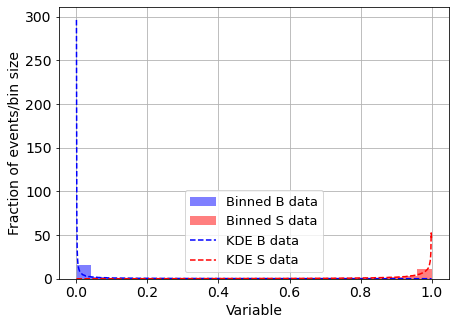

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  1%|▏                                | 11/2000 [00:16<39:25,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17873032248760604
<p_{s}(Sdata)> = 12.134519618972924
<p_{b}(Bdata)> = 99.69310153050107
<p_{s}(Bdata)> = 0.21918073183699524


  2%|▋                                | 45/2000 [01:13<42:06,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16131118116267523
<p_{s}(Sdata)> = 11.33462649769207
<p_{b}(Bdata)> = 99.48450134741508
<p_{s}(Bdata)> = 0.20828956648464328


  3%|▉                                | 55/2000 [01:31<43:47,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1547778530403387
<p_{s}(Sdata)> = 13.272269816237124
<p_{b}(Bdata)> = 99.39797402752947
<p_{s}(Bdata)> = 0.21794171976402324


  3%|█                                | 67/2000 [01:51<47:11,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16341482010510103
<p_{s}(Sdata)> = 13.334026384022884
<p_{b}(Bdata)> = 99.97157986101791
<p_{s}(Bdata)> = 0.21563567195051653


  5%|█▌                               | 92/2000 [02:35<40:41,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2756510863181686
<p_{s}(Sdata)> = 10.805969275585007
<p_{b}(Bdata)> = 99.9170043741558
<p_{s}(Bdata)> = 0.22126356408872674


  5%|█▋                              | 102/2000 [02:52<41:51,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1615078258403869
<p_{s}(Sdata)> = 12.47665126209293
<p_{b}(Bdata)> = 99.49542751089344
<p_{s}(Bdata)> = 0.21823737633657617


  6%|█▊                              | 115/2000 [03:16<48:12,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17778346411283866
<p_{s}(Sdata)> = 13.828951729415273
<p_{b}(Bdata)> = 99.75064971571138
<p_{s}(Bdata)> = 0.21711410696557468


  8%|██▋                             | 166/2000 [04:45<52:47,  1.73s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18446356506575765
<p_{s}(Sdata)> = 12.098129197379123
<p_{b}(Bdata)> = 99.3145561092704
<p_{s}(Bdata)> = 0.21869782790193001


  9%|██▉                             | 181/2000 [05:07<34:51,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17492519011113172
<p_{s}(Sdata)> = 10.344395634734092
<p_{b}(Bdata)> = 100.12772494561794
<p_{s}(Bdata)> = 0.20798711716678028


 10%|███▏                            | 202/2000 [05:41<42:22,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15738911332071676
<p_{s}(Sdata)> = 14.723135156967768
<p_{b}(Bdata)> = 99.27914720306892
<p_{s}(Bdata)> = 0.22038567249338872


 11%|███▍                            | 211/2000 [05:54<38:54,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17340794020062636
<p_{s}(Sdata)> = 11.874533893807603
<p_{b}(Bdata)> = 99.54861426154558
<p_{s}(Bdata)> = 0.2183932370712773


 11%|███▍                            | 212/2000 [05:55<31:33,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1433441453201123
<p_{s}(Sdata)> = 16.75697821968264
<p_{b}(Bdata)> = 99.12104590057315
<p_{s}(Bdata)> = 0.21413420943549477


 11%|███▌                            | 226/2000 [06:20<45:37,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2114061682623096
<p_{s}(Sdata)> = 6.307966791096851
<p_{b}(Bdata)> = 100.05664822278742
<p_{s}(Bdata)> = 0.215091954027935


 12%|███▋                            | 234/2000 [06:32<36:21,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16961318674049547
<p_{s}(Sdata)> = 10.85343006305609
<p_{b}(Bdata)> = 100.16184203300645
<p_{s}(Bdata)> = 0.2206758106040677


 13%|████▏                           | 259/2000 [07:16<40:09,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25271081394801687
<p_{s}(Sdata)> = 10.957397962785617
<p_{b}(Bdata)> = 99.5575086639555
<p_{s}(Bdata)> = 0.20671724884840553


 14%|████▎                           | 273/2000 [07:38<33:34,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18120573973797954
<p_{s}(Sdata)> = 10.009362666540614
<p_{b}(Bdata)> = 100.03348831890473
<p_{s}(Bdata)> = 0.20779540684885853


 15%|████▊                           | 302/2000 [08:26<34:23,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18816520349414287
<p_{s}(Sdata)> = 6.543889908565491
<p_{b}(Bdata)> = 99.80060790341452
<p_{s}(Bdata)> = 0.21154216925674074


 15%|████▉                           | 305/2000 [08:31<40:51,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15806501118923527
<p_{s}(Sdata)> = 14.079716311401494
<p_{b}(Bdata)> = 99.69853174043217
<p_{s}(Bdata)> = 0.22000247419383753


 16%|█████                           | 314/2000 [08:45<37:51,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16500181200019023
<p_{s}(Sdata)> = 11.77101741426482
<p_{b}(Bdata)> = 100.11604159244698
<p_{s}(Bdata)> = 0.21822070220598438


 16%|█████▏                          | 324/2000 [09:00<35:57,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16760395772723086
<p_{s}(Sdata)> = 13.614312965521641
<p_{b}(Bdata)> = 100.04437739382622
<p_{s}(Bdata)> = 0.2185498294609082


 16%|█████▎                          | 329/2000 [09:05<28:34,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16769674500706633
<p_{s}(Sdata)> = 13.251288651734223
<p_{b}(Bdata)> = 99.32974775463225
<p_{s}(Bdata)> = 0.216148328353736


 17%|█████▍                          | 341/2000 [09:24<33:15,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16584228534102585
<p_{s}(Sdata)> = 13.651274173616935
<p_{b}(Bdata)> = 99.33468039083394
<p_{s}(Bdata)> = 0.21738199437383712


 17%|█████▍                          | 342/2000 [09:25<27:13,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16446019843251464
<p_{s}(Sdata)> = 13.645533841190279
<p_{b}(Bdata)> = 99.796506503109
<p_{s}(Bdata)> = 0.2170179822381532


 17%|█████▌                          | 349/2000 [09:37<39:36,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20227167554793735
<p_{s}(Sdata)> = 9.974257012244976
<p_{b}(Bdata)> = 99.23837243702727
<p_{s}(Bdata)> = 0.2207210854505735


 19%|█████▉                          | 373/2000 [10:15<40:36,  1.50s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20764810922907168
<p_{s}(Sdata)> = 8.157795971481772
<p_{b}(Bdata)> = 100.07671468025293
<p_{s}(Bdata)> = 0.21199513203105902


 19%|██████▏                         | 386/2000 [10:34<30:15,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16154690553121043
<p_{s}(Sdata)> = 15.866096576543507
<p_{b}(Bdata)> = 99.92889630251646
<p_{s}(Bdata)> = 0.21788291876836255


 21%|██████▌                         | 413/2000 [11:15<29:23,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2178563589146719
<p_{s}(Sdata)> = 8.051671011426443
<p_{b}(Bdata)> = 99.46035142137514
<p_{s}(Bdata)> = 0.21148713761461424


 21%|██████▊                         | 423/2000 [11:29<34:16,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21913155354308567
<p_{s}(Sdata)> = 5.277626118870522
<p_{b}(Bdata)> = 99.97760841293358
<p_{s}(Bdata)> = 0.2125228676255318


 22%|███████                         | 442/2000 [11:58<29:52,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16884775792457252
<p_{s}(Sdata)> = 11.51817591560319
<p_{b}(Bdata)> = 99.8501327812065
<p_{s}(Bdata)> = 0.21711943156527058


 22%|███████                         | 445/2000 [12:03<32:28,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17102458109880928
<p_{s}(Sdata)> = 9.22168275224937
<p_{b}(Bdata)> = 100.0967064251159
<p_{s}(Bdata)> = 0.20989141661815247


 24%|███████▌                        | 476/2000 [13:00<34:17,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1747092582022723
<p_{s}(Sdata)> = 8.642664219352264
<p_{b}(Bdata)> = 98.77615695216456
<p_{s}(Bdata)> = 0.21223080904581304


 25%|███████▉                        | 494/2000 [13:31<38:17,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1872983728659359
<p_{s}(Sdata)> = 8.2220925217347
<p_{b}(Bdata)> = 99.46239358743146
<p_{s}(Bdata)> = 0.22164919923815687


 25%|███████▉                        | 496/2000 [13:34<35:22,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21042308114642855
<p_{s}(Sdata)> = 11.193494945480428
<p_{b}(Bdata)> = 99.31890048174749
<p_{s}(Bdata)> = 0.21043356432735155


 27%|████████▌                       | 536/2000 [14:43<31:26,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16252470455363865
<p_{s}(Sdata)> = 12.245008674940339
<p_{b}(Bdata)> = 99.57807399330804
<p_{s}(Bdata)> = 0.20805246645308956


 27%|████████▊                       | 547/2000 [14:59<30:46,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.155802877463428
<p_{s}(Sdata)> = 10.95796675213242
<p_{b}(Bdata)> = 99.3274648733756
<p_{s}(Bdata)> = 0.21092543421677282


 28%|████████▊                       | 551/2000 [15:04<25:16,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18153297550291314
<p_{s}(Sdata)> = 10.047774540089483
<p_{b}(Bdata)> = 99.6329702313118
<p_{s}(Bdata)> = 0.21167792594212684


 28%|████████▉                       | 560/2000 [15:19<34:59,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17266524151395413
<p_{s}(Sdata)> = 14.57988483545369
<p_{b}(Bdata)> = 99.82856669941322
<p_{s}(Bdata)> = 0.21792146346537217


 28%|█████████                       | 564/2000 [15:24<29:31,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21545975524554722
<p_{s}(Sdata)> = 7.146915829381607
<p_{b}(Bdata)> = 99.62093666231037
<p_{s}(Bdata)> = 0.21187050661246898


 29%|█████████▏                      | 573/2000 [15:39<33:48,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1766658322690392
<p_{s}(Sdata)> = 11.359574508878051
<p_{b}(Bdata)> = 99.45953028749214
<p_{s}(Bdata)> = 0.2198270870469018


 31%|██████████                      | 627/2000 [17:13<26:17,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16287048677610955
<p_{s}(Sdata)> = 14.354605418538824
<p_{b}(Bdata)> = 99.983414176054
<p_{s}(Bdata)> = 0.21787859233398696


 32%|██████████▏                     | 635/2000 [17:24<27:19,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17119332504973336
<p_{s}(Sdata)> = 9.704534036113536
<p_{b}(Bdata)> = 99.68362015661687
<p_{s}(Bdata)> = 0.2087136905735857


 34%|██████████▉                     | 681/2000 [18:45<28:28,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18149968517750056
<p_{s}(Sdata)> = 11.754023248733263
<p_{b}(Bdata)> = 99.46133149387666
<p_{s}(Bdata)> = 0.2183857664704791


 35%|███████████▏                    | 701/2000 [19:14<21:51,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17904754387639849
<p_{s}(Sdata)> = 8.340978156297862
<p_{b}(Bdata)> = 99.49952845981345
<p_{s}(Bdata)> = 0.20996010894787326


 35%|███████████▎                    | 704/2000 [19:18<23:15,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15844326483391646
<p_{s}(Sdata)> = 11.266250037048263
<p_{b}(Bdata)> = 99.41137356144773
<p_{s}(Bdata)> = 0.21938104560269395


 36%|███████████▌                    | 723/2000 [19:48<31:48,  1.49s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15489267182881836
<p_{s}(Sdata)> = 12.932570437429808
<p_{b}(Bdata)> = 99.73526968391143
<p_{s}(Bdata)> = 0.2196353317198957


 39%|████████████▍                   | 774/2000 [21:11<23:31,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1975274015766314
<p_{s}(Sdata)> = 7.596740177065716
<p_{b}(Bdata)> = 99.17457392539251
<p_{s}(Bdata)> = 0.20739388150082202


 39%|████████████▍                   | 775/2000 [21:11<19:41,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18499385927484477
<p_{s}(Sdata)> = 12.639051342035955
<p_{b}(Bdata)> = 99.757467241864
<p_{s}(Bdata)> = 0.21981498389208842


 39%|████████████▍                   | 779/2000 [21:17<24:06,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2057353366216267
<p_{s}(Sdata)> = 7.568779143722796
<p_{b}(Bdata)> = 99.48829132522222
<p_{s}(Bdata)> = 0.21090321202280882


 40%|████████████▋                   | 791/2000 [21:36<26:56,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16679538000633293
<p_{s}(Sdata)> = 10.386030790325078
<p_{b}(Bdata)> = 99.79170881482656
<p_{s}(Bdata)> = 0.22005834306443162


 40%|████████████▊                   | 800/2000 [21:52<28:04,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19758256621324025
<p_{s}(Sdata)> = 6.39594316903358
<p_{b}(Bdata)> = 100.47904977140438
<p_{s}(Bdata)> = 0.21317915149599617


 41%|█████████████                   | 815/2000 [22:16<24:10,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23784140173886978
<p_{s}(Sdata)> = 9.556605837379845
<p_{b}(Bdata)> = 99.42075306301174
<p_{s}(Bdata)> = 0.21825451167667878


 42%|█████████████▌                  | 845/2000 [23:01<26:44,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1457588356914568
<p_{s}(Sdata)> = 15.828889825136127
<p_{b}(Bdata)> = 99.49849483192449
<p_{s}(Bdata)> = 0.21595797520843057


 44%|██████████████                  | 877/2000 [23:54<24:48,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.181828468290312
<p_{s}(Sdata)> = 6.184775040609126
<p_{b}(Bdata)> = 100.17447995195226
<p_{s}(Bdata)> = 0.2100179986351455


 44%|██████████████▏                 | 889/2000 [24:13<26:53,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21078230827824782
<p_{s}(Sdata)> = 11.68274511686596
<p_{b}(Bdata)> = 99.75726587731272
<p_{s}(Bdata)> = 0.21988324795052108


 45%|██████████████▎                 | 895/2000 [24:23<29:26,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1817620353039067
<p_{s}(Sdata)> = 6.109215853004607
<p_{b}(Bdata)> = 99.56405088476804
<p_{s}(Bdata)> = 0.21524543995874462


 45%|██████████████▍                 | 901/2000 [24:31<20:45,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36717120847713614
<p_{s}(Sdata)> = 6.3657846447945605
<p_{b}(Bdata)> = 99.32968871301851
<p_{s}(Bdata)> = 0.2135518812586146


 47%|██████████████▉                 | 936/2000 [25:30<21:20,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.183960296533336
<p_{s}(Sdata)> = 9.427094800456487
<p_{b}(Bdata)> = 99.97296101456575
<p_{s}(Bdata)> = 0.20799510679792982


 49%|███████████████▌                | 972/2000 [26:31<21:54,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16919078003702787
<p_{s}(Sdata)> = 7.911046697923012
<p_{b}(Bdata)> = 100.46831456118181
<p_{s}(Bdata)> = 0.20996053401905268


 51%|███████████████▊               | 1024/2000 [27:57<16:24,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18644451547185834
<p_{s}(Sdata)> = 9.372145755044262
<p_{b}(Bdata)> = 100.15981179257656
<p_{s}(Bdata)> = 0.20786421089583504


 52%|████████████████               | 1036/2000 [28:19<21:45,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.9027152886484862
<p_{s}(Sdata)> = 15.932376354569922
<p_{b}(Bdata)> = 99.59176589218931
<p_{s}(Bdata)> = 0.21733316974128866


 52%|████████████████▎              | 1049/2000 [28:42<20:31,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18788683229926245
<p_{s}(Sdata)> = 9.087517349631321
<p_{b}(Bdata)> = 99.77114173947528
<p_{s}(Bdata)> = 0.21351920486305054


 54%|████████████████▋              | 1078/2000 [29:26<22:36,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23027825591446033
<p_{s}(Sdata)> = 13.739309125661224
<p_{b}(Bdata)> = 99.97821332080413
<p_{s}(Bdata)> = 0.21597552982440532


 55%|█████████████████              | 1104/2000 [30:12<21:20,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1874017555092647
<p_{s}(Sdata)> = 12.351682051160179
<p_{b}(Bdata)> = 99.221118824595
<p_{s}(Bdata)> = 0.219236205483079


 56%|█████████████████▎             | 1113/2000 [30:26<21:10,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20579565827602947
<p_{s}(Sdata)> = 9.058862654707088
<p_{b}(Bdata)> = 99.86477321832085
<p_{s}(Bdata)> = 0.2207875360075482


 57%|█████████████████▊             | 1150/2000 [31:25<17:42,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1959952423119796
<p_{s}(Sdata)> = 6.4291464430539715
<p_{b}(Bdata)> = 99.5039703964823
<p_{s}(Bdata)> = 0.2099206520399232


 58%|█████████████████▉             | 1158/2000 [31:38<18:12,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19437182806988798
<p_{s}(Sdata)> = 8.735111325960457
<p_{b}(Bdata)> = 99.59661884966667
<p_{s}(Bdata)> = 0.2098659792702421


 58%|█████████████████▉             | 1161/2000 [31:42<17:23,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1441225340675133
<p_{s}(Sdata)> = 17.46065407113711
<p_{b}(Bdata)> = 100.94273694171639
<p_{s}(Bdata)> = 0.21657342325027884


 58%|██████████████████             | 1163/2000 [31:44<15:16,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16410769100024183
<p_{s}(Sdata)> = 14.086650039550433
<p_{b}(Bdata)> = 99.99194046654691
<p_{s}(Bdata)> = 0.21863947942233503


 59%|██████████████████▎            | 1179/2000 [32:10<15:34,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26408525346724193
<p_{s}(Sdata)> = 7.79259890369716
<p_{b}(Bdata)> = 99.76520491989272
<p_{s}(Bdata)> = 0.20960318330404495


 59%|██████████████████▍            | 1189/2000 [32:27<17:56,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18516830956986643
<p_{s}(Sdata)> = 9.069413250666956
<p_{b}(Bdata)> = 98.56519032945111
<p_{s}(Bdata)> = 0.2085235884504558


 60%|██████████████████▌            | 1196/2000 [32:38<17:40,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1849100813436823
<p_{s}(Sdata)> = 6.298368385309426
<p_{b}(Bdata)> = 99.66733075598225
<p_{s}(Bdata)> = 0.21091509562701952


 61%|██████████████████▉            | 1221/2000 [33:23<16:14,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18048929362752525
<p_{s}(Sdata)> = 13.116636139849575
<p_{b}(Bdata)> = 99.42556810345397
<p_{s}(Bdata)> = 0.21913352160165459


 62%|███████████████████▏           | 1235/2000 [33:45<20:26,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1775864662485666
<p_{s}(Sdata)> = 11.190204925658282
<p_{b}(Bdata)> = 99.71267094066141
<p_{s}(Bdata)> = 0.21985948963165217


 62%|███████████████████▍           | 1250/2000 [34:12<17:50,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20823753747244322
<p_{s}(Sdata)> = 11.222793224683297
<p_{b}(Bdata)> = 99.85596646237242
<p_{s}(Bdata)> = 0.21829156679990716


 63%|███████████████████▍           | 1252/2000 [34:14<14:12,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16291496441474063
<p_{s}(Sdata)> = 13.996328898237897
<p_{b}(Bdata)> = 100.1640618955339
<p_{s}(Bdata)> = 0.21827173111883463


 63%|███████████████████▌           | 1261/2000 [34:28<17:07,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20007181895561293
<p_{s}(Sdata)> = 10.277711220187431
<p_{b}(Bdata)> = 99.02518918259189
<p_{s}(Bdata)> = 0.21922794041878996


 66%|████████████████████▎          | 1312/2000 [35:54<14:12,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1970072022791297
<p_{s}(Sdata)> = 13.320896652913968
<p_{b}(Bdata)> = 100.08006995979197
<p_{s}(Bdata)> = 0.2152974187205216


 67%|████████████████████▋          | 1337/2000 [36:35<11:52,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18660143454466133
<p_{s}(Sdata)> = 8.065442068351159
<p_{b}(Bdata)> = 99.5551666044679
<p_{s}(Bdata)> = 0.2107650785107746


 67%|████████████████████▊          | 1344/2000 [36:46<15:21,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18073383124306824
<p_{s}(Sdata)> = 8.304796010705525
<p_{b}(Bdata)> = 99.54849917025
<p_{s}(Bdata)> = 0.21019676869075413


 70%|█████████████████████▌         | 1394/2000 [38:15<13:07,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23094399235828764
<p_{s}(Sdata)> = 9.145051473154549
<p_{b}(Bdata)> = 99.75785918057487
<p_{s}(Bdata)> = 0.20932553832068312


 70%|█████████████████████▋         | 1399/2000 [38:22<12:10,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20989825175307772
<p_{s}(Sdata)> = 11.301067314686406
<p_{b}(Bdata)> = 99.21960305430575
<p_{s}(Bdata)> = 0.22026093224723756


 70%|█████████████████████▋         | 1400/2000 [38:22<09:32,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22922176201836056
<p_{s}(Sdata)> = 9.397591706937382
<p_{b}(Bdata)> = 99.50208298871358
<p_{s}(Bdata)> = 0.20895126196644614


 72%|██████████████████████▏        | 1431/2000 [39:15<13:11,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 4.2889661039016485
<p_{s}(Sdata)> = 10.997721660216296
<p_{b}(Bdata)> = 99.99335505912865
<p_{s}(Bdata)> = 0.21769638962804602


 73%|██████████████████████▊        | 1469/2000 [40:19<12:42,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16465694443475767
<p_{s}(Sdata)> = 14.395377655291924
<p_{b}(Bdata)> = 100.0897983664961
<p_{s}(Bdata)> = 0.2176587491507232


 76%|███████████████████████▍       | 1511/2000 [41:29<13:23,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15692796447972562
<p_{s}(Sdata)> = 14.647320116143685
<p_{b}(Bdata)> = 99.32457180260256
<p_{s}(Bdata)> = 0.2191640214710424


 76%|███████████████████████▍       | 1512/2000 [41:30<10:31,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17380294852568437
<p_{s}(Sdata)> = 14.131874978138928
<p_{b}(Bdata)> = 99.34913234422643
<p_{s}(Bdata)> = 0.21811500151287194


 76%|███████████████████████▌       | 1517/2000 [41:36<09:18,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17882688718525913
<p_{s}(Sdata)> = 13.554362380359937
<p_{b}(Bdata)> = 99.52304095270478
<p_{s}(Bdata)> = 0.21634519729899146


 78%|████████████████████████       | 1556/2000 [42:46<09:55,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17767188664113262
<p_{s}(Sdata)> = 13.089923022070415
<p_{b}(Bdata)> = 98.96752647870413
<p_{s}(Bdata)> = 0.21613668266896796


 78%|████████████████████████▏      | 1563/2000 [42:56<09:16,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1739824704554367
<p_{s}(Sdata)> = 13.012389175097233
<p_{b}(Bdata)> = 99.15249044997756
<p_{s}(Bdata)> = 0.21774358787726283


 79%|████████████████████████▍      | 1575/2000 [43:16<09:12,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1568373961611413
<p_{s}(Sdata)> = 9.368343131508563
<p_{b}(Bdata)> = 99.06970702933553
<p_{s}(Bdata)> = 0.212685761157495


 79%|████████████████████████▌      | 1586/2000 [43:35<09:16,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17830431002014088
<p_{s}(Sdata)> = 15.808005578132347
<p_{b}(Bdata)> = 99.24309808236754
<p_{s}(Bdata)> = 0.2161578662916105


 81%|█████████████████████████▏     | 1622/2000 [44:32<07:07,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18225185226452814
<p_{s}(Sdata)> = 13.949750852435027
<p_{b}(Bdata)> = 99.67770623657634
<p_{s}(Bdata)> = 0.21694336355410507


 83%|█████████████████████████▊     | 1663/2000 [45:44<06:39,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21640055069843653
<p_{s}(Sdata)> = 12.007604967897722
<p_{b}(Bdata)> = 99.71299242421061
<p_{s}(Bdata)> = 0.21916690491143695


 85%|██████████████████████████▎    | 1696/2000 [46:42<06:09,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18777770719228926
<p_{s}(Sdata)> = 8.503345492466474
<p_{b}(Bdata)> = 99.35911519500503
<p_{s}(Bdata)> = 0.21056942387552208


 85%|██████████████████████████▎    | 1701/2000 [46:50<06:23,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18369722844379247
<p_{s}(Sdata)> = 12.924453333383342
<p_{b}(Bdata)> = 99.89540202565304
<p_{s}(Bdata)> = 0.2193084627253193


 85%|██████████████████████████▍    | 1706/2000 [46:57<06:19,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16409786101642937
<p_{s}(Sdata)> = 16.097891198310787
<p_{b}(Bdata)> = 99.28887569130478
<p_{s}(Bdata)> = 0.21308124034888634


 87%|███████████████████████████    | 1743/2000 [47:59<06:38,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17452615851760453
<p_{s}(Sdata)> = 10.452419211123129
<p_{b}(Bdata)> = 99.38011212163963
<p_{s}(Bdata)> = 0.22086675841001951


 88%|███████████████████████████▏   | 1754/2000 [48:17<05:46,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15397732612372894
<p_{s}(Sdata)> = 14.713858650298599
<p_{b}(Bdata)> = 99.96200740547961
<p_{s}(Bdata)> = 0.21380765278626535


 89%|███████████████████████████▌   | 1775/2000 [48:52<05:17,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2759123594771183
<p_{s}(Sdata)> = 16.733478875212953
<p_{b}(Bdata)> = 99.66730743371153
<p_{s}(Bdata)> = 0.21816987560021303


 90%|███████████████████████████▊   | 1796/2000 [49:26<04:53,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1651613494924577
<p_{s}(Sdata)> = 14.717727507239996
<p_{b}(Bdata)> = 99.21497639488167
<p_{s}(Bdata)> = 0.21702757458017022


 90%|███████████████████████████▉   | 1799/2000 [49:30<04:14,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16050145976327138
<p_{s}(Sdata)> = 15.595292463395507
<p_{b}(Bdata)> = 99.70968222092539
<p_{s}(Bdata)> = 0.21944225118006616


 90%|███████████████████████████▉   | 1802/2000 [49:35<04:14,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17014937258246654
<p_{s}(Sdata)> = 6.941269171655121
<p_{b}(Bdata)> = 100.1600119369753
<p_{s}(Bdata)> = 0.2121770639692816


 93%|████████████████████████████▋  | 1853/2000 [51:00<03:12,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.370941794632446
<p_{s}(Sdata)> = 13.909479249601286
<p_{b}(Bdata)> = 99.36829975977291
<p_{s}(Bdata)> = 0.2168328371338353


 93%|████████████████████████████▊  | 1860/2000 [51:11<03:05,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17751875232009695
<p_{s}(Sdata)> = 9.516211813344244
<p_{b}(Bdata)> = 99.05486266437966
<p_{s}(Bdata)> = 0.2208846914094253


 95%|█████████████████████████████▎ | 1892/2000 [52:05<02:52,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.13901461256616615
<p_{s}(Sdata)> = 14.634290702221131
<p_{b}(Bdata)> = 99.98461707626578
<p_{s}(Bdata)> = 0.21594879780749718


 96%|█████████████████████████████▋ | 1913/2000 [52:44<02:01,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2080203323418739
<p_{s}(Sdata)> = 8.456114283182965
<p_{b}(Bdata)> = 99.33594518612605
<p_{s}(Bdata)> = 0.20859656529441015


 96%|█████████████████████████████▋ | 1918/2000 [52:51<01:48,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20536230104775433
<p_{s}(Sdata)> = 8.337409273436148
<p_{b}(Bdata)> = 99.67203237415436
<p_{s}(Bdata)> = 0.20879279188333666


 96%|█████████████████████████████▊ | 1922/2000 [52:57<01:36,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23108533230715542
<p_{s}(Sdata)> = 7.5319005669532455
<p_{b}(Bdata)> = 100.1914584291646
<p_{s}(Bdata)> = 0.20990801698723854


 98%|██████████████████████████████▎| 1954/2000 [53:49<00:58,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.15858406537286027
<p_{s}(Sdata)> = 10.679142887811855
<p_{b}(Bdata)> = 99.92115189216885
<p_{s}(Bdata)> = 0.2076686409988796


 98%|██████████████████████████████▍| 1962/2000 [54:02<00:49,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15981079046489416
<p_{s}(Sdata)> = 15.745092112595744
<p_{b}(Bdata)> = 99.11617301577056
<p_{s}(Bdata)> = 0.21581587097592567


100%|██████████████████████████████▉| 1992/2000 [54:51<00:10,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1740449742586883
<p_{s}(Sdata)> = 7.832729266762167
<p_{b}(Bdata)> = 99.26278777431504
<p_{s}(Bdata)> = 0.20740092795639697


100%|███████████████████████████████| 2000/2000 [55:05<00:00,  1.65s/it]


Z:2.1767558859107967
Z_std:1.117854751030516
Z_1:2.1807068554609716
Z_std_1:1.0764498590475848
2
AUC:0.9698087203035287


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 23805.55655883 22884.74225006 21825.62651552 20641.44388183
 19324.79564429 17869.20265406 16286.22950553 14570.80130641
 12687.46910968 10649.76732593  8460.09403266  6091.81520107
  3562.94324121   844.82431775 -2035.80741626 -5075.83061796]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
IOStream.flush timed out
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 12898

<Figure size 432x288 with 0 Axes>

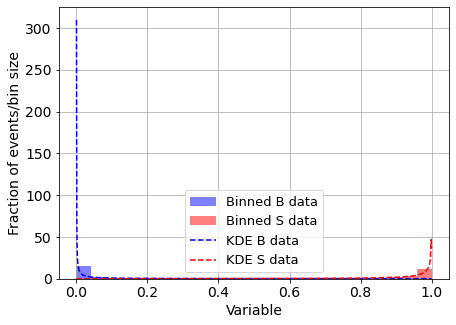

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


  0%|▏                                 | 8/2000 [00:12<46:24,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1772669658236434
<p_{s}(Sdata)> = 12.519433824844178
<p_{b}(Bdata)> = 107.30098132480721
<p_{s}(Bdata)> = 0.224571830105937


  1%|▍                                | 25/2000 [00:41<43:21,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14451352822200467
<p_{s}(Sdata)> = 13.67119864316557
<p_{b}(Bdata)> = 107.16516790472544
<p_{s}(Bdata)> = 0.22369376066241145


  2%|▌                                | 34/2000 [00:55<43:02,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16382410240846326
<p_{s}(Sdata)> = 12.818803690101
<p_{b}(Bdata)> = 108.11670576591249
<p_{s}(Bdata)> = 0.22113915974614598


  2%|▋                                | 42/2000 [01:07<36:10,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1926833444122831
<p_{s}(Sdata)> = 12.528752277771202
<p_{b}(Bdata)> = 108.02240709964849
<p_{s}(Bdata)> = 0.21998220037643412


  2%|▊                                | 46/2000 [01:14<42:57,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19154500041502026
<p_{s}(Sdata)> = 10.791645603252846
<p_{b}(Bdata)> = 107.70185010806057
<p_{s}(Bdata)> = 0.22435584065216613


  3%|█                                | 61/2000 [01:37<40:29,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1871065734559223
<p_{s}(Sdata)> = 7.493367616178798
<p_{b}(Bdata)> = 107.58972699644083
<p_{s}(Bdata)> = 0.21436202854510183


  5%|█▌                               | 96/2000 [02:39<37:32,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15541432924731782
<p_{s}(Sdata)> = 12.690873216028347
<p_{b}(Bdata)> = 107.35087979022836
<p_{s}(Bdata)> = 0.22490245300106682


  5%|█▋                              | 104/2000 [02:53<44:04,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.12854733148395403
<p_{s}(Sdata)> = 19.773161800119574
<p_{b}(Bdata)> = 107.9511265468543
<p_{s}(Bdata)> = 0.22175702884197498


  5%|█▋                              | 105/2000 [02:53<35:30,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2349799476739744
<p_{s}(Sdata)> = 10.816168418127834
<p_{b}(Bdata)> = 107.67485091361922
<p_{s}(Bdata)> = 0.22346228658011857


  6%|█▉                              | 119/2000 [03:18<41:18,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1538818343204814
<p_{s}(Sdata)> = 13.617621121255796
<p_{b}(Bdata)> = 107.79846919766428
<p_{s}(Bdata)> = 0.2212894005138304


  7%|██▎                             | 142/2000 [04:00<51:31,  1.66s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16650092634336955
<p_{s}(Sdata)> = 11.335595369062327
<p_{b}(Bdata)> = 107.52590509378291
<p_{s}(Bdata)> = 0.22772530263230698


  8%|██▋                             | 165/2000 [04:41<46:55,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17108634350454655
<p_{s}(Sdata)> = 12.295672017030636
<p_{b}(Bdata)> = 107.53864842440535
<p_{s}(Bdata)> = 0.22461371521109236


  9%|██▊                             | 177/2000 [05:04<51:36,  1.70s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1633115378418274
<p_{s}(Sdata)> = 11.8977742959326
<p_{b}(Bdata)> = 106.9958908246584
<p_{s}(Bdata)> = 0.2236538105163848


 10%|███▏                            | 196/2000 [05:39<39:24,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22690863881980963
<p_{s}(Sdata)> = 8.85871748967441
<p_{b}(Bdata)> = 107.73572295049095
<p_{s}(Bdata)> = 0.21404141811322094


 10%|███▎                            | 205/2000 [05:57<45:57,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14834905917974406
<p_{s}(Sdata)> = 15.460210090405196
<p_{b}(Bdata)> = 107.62112964881209
<p_{s}(Bdata)> = 0.22215166947942835


 10%|███▎                            | 207/2000 [05:59<35:39,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17993656405317213
<p_{s}(Sdata)> = 8.765070091279759
<p_{b}(Bdata)> = 107.38817047868956
<p_{s}(Bdata)> = 0.21443744369794487


 11%|███▋                            | 228/2000 [06:43<48:51,  1.65s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20620198918627342
<p_{s}(Sdata)> = 11.005071084700182
<p_{b}(Bdata)> = 107.76587409445307
<p_{s}(Bdata)> = 0.22431938673894097


 11%|███▋                            | 229/2000 [06:44<38:33,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1944892672067161
<p_{s}(Sdata)> = 15.048823286151313
<p_{b}(Bdata)> = 107.73142409647058
<p_{s}(Bdata)> = 0.2211772510477977


 12%|███▋                            | 230/2000 [06:44<30:09,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20060367559993264
<p_{s}(Sdata)> = 6.082376189005683
<p_{b}(Bdata)> = 107.33344495805449
<p_{s}(Bdata)> = 0.21842117034554295


 12%|███▊                            | 240/2000 [07:03<42:02,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20393070344971084
<p_{s}(Sdata)> = 5.949472967724677
<p_{b}(Bdata)> = 106.97729506259853
<p_{s}(Bdata)> = 0.21623271310515582


 12%|███▉                            | 244/2000 [07:08<36:55,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.217554702494496
<p_{s}(Sdata)> = 7.438572636267572
<p_{b}(Bdata)> = 108.28130985405589
<p_{s}(Bdata)> = 0.21609183970554824


 13%|████▏                           | 261/2000 [07:40<41:54,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2827774264755523
<p_{s}(Sdata)> = 8.650266485501518
<p_{b}(Bdata)> = 107.39791521296571
<p_{s}(Bdata)> = 0.2176199105768833


 14%|████▍                           | 276/2000 [08:05<31:04,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14479457834907328
<p_{s}(Sdata)> = 14.145910727310541
<p_{b}(Bdata)> = 107.06902123842059
<p_{s}(Bdata)> = 0.22443826847660833


 14%|████▍                           | 281/2000 [08:12<35:09,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14736124629806605
<p_{s}(Sdata)> = 15.075623414386735
<p_{b}(Bdata)> = 107.60393606324516
<p_{s}(Bdata)> = 0.22033857462659973


 14%|████▌                           | 282/2000 [08:12<27:35,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18550643927198757
<p_{s}(Sdata)> = 6.2462697994669325
<p_{b}(Bdata)> = 107.24767944632539
<p_{s}(Bdata)> = 0.21686112613777672


 14%|████▌                           | 287/2000 [08:22<41:23,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1601704658003934
<p_{s}(Sdata)> = 13.672421857095557
<p_{b}(Bdata)> = 107.40411426012875
<p_{s}(Bdata)> = 0.2221456139273533


 15%|████▋                           | 293/2000 [08:31<37:09,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1767685494255961
<p_{s}(Sdata)> = 12.857335344519633
<p_{b}(Bdata)> = 107.20391158084526
<p_{s}(Bdata)> = 0.22264113720956263


 15%|████▊                           | 301/2000 [08:43<36:55,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17929592560968008
<p_{s}(Sdata)> = 9.445605774508008
<p_{b}(Bdata)> = 107.86920776538801
<p_{s}(Bdata)> = 0.21195489226763958


 16%|█████                           | 318/2000 [09:09<32:44,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25237693741632194
<p_{s}(Sdata)> = 10.473441765909259
<p_{b}(Bdata)> = 107.72228545099395
<p_{s}(Bdata)> = 0.22331601837443107


 18%|█████▉                          | 368/2000 [10:34<39:28,  1.45s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5997728026234875
<p_{s}(Sdata)> = 9.318728292797223
<p_{b}(Bdata)> = 107.00620107576687
<p_{s}(Bdata)> = 0.2151057990117376


 19%|█████▉                          | 372/2000 [10:39<30:59,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17726115310935453
<p_{s}(Sdata)> = 9.256134536370256
<p_{b}(Bdata)> = 107.41209027291497
<p_{s}(Bdata)> = 0.2144346467178664


 19%|█████▉                          | 374/2000 [10:42<28:54,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24272238041006225
<p_{s}(Sdata)> = 6.444884008783606
<p_{b}(Bdata)> = 107.91157205927254
<p_{s}(Bdata)> = 0.21156269902280647


 20%|██████▎                         | 396/2000 [11:19<39:03,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16301077600211225
<p_{s}(Sdata)> = 11.951311642619467
<p_{b}(Bdata)> = 107.28310261777979
<p_{s}(Bdata)> = 0.22215606462503265


 20%|██████▎                         | 397/2000 [11:20<31:17,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1699416351568372
<p_{s}(Sdata)> = 12.620218294970758
<p_{b}(Bdata)> = 107.64104522742569
<p_{s}(Bdata)> = 0.22279656962172495


 20%|██████▍                         | 399/2000 [11:21<24:11,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25887772309892515
<p_{s}(Sdata)> = 10.258715808789486
<p_{b}(Bdata)> = 108.30546179542539
<p_{s}(Bdata)> = 0.2151864464636728


 20%|██████▍                         | 403/2000 [11:26<28:12,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18916025740116213
<p_{s}(Sdata)> = 10.494971440076645
<p_{b}(Bdata)> = 107.24199309447587
<p_{s}(Bdata)> = 0.22707887385569359


 20%|██████▍                         | 404/2000 [11:27<23:37,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2031016228695585
<p_{s}(Sdata)> = 10.736051049473819
<p_{b}(Bdata)> = 107.0925592926605
<p_{s}(Bdata)> = 0.22304855168234278


 21%|██████▊                         | 425/2000 [12:06<44:18,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16611625039860026
<p_{s}(Sdata)> = 12.491384937226202
<p_{b}(Bdata)> = 106.75196696932495
<p_{s}(Bdata)> = 0.22333810820435426


 21%|██████▊                         | 428/2000 [12:10<34:12,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19123051126364532
<p_{s}(Sdata)> = 8.257449445487072
<p_{b}(Bdata)> = 107.9296333019908
<p_{s}(Bdata)> = 0.21622252281013576


 22%|██████▉                         | 437/2000 [12:26<40:18,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1767061947073387
<p_{s}(Sdata)> = 10.151021499882587
<p_{b}(Bdata)> = 106.94081571370718
<p_{s}(Bdata)> = 0.22413792045504902


 22%|███████                         | 442/2000 [12:35<39:02,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26951069463796895
<p_{s}(Sdata)> = 12.465346885952988
<p_{b}(Bdata)> = 107.37645765286032
<p_{s}(Bdata)> = 0.2228163125668461


 22%|███████▏                        | 448/2000 [12:41<25:05,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18491937678598186
<p_{s}(Sdata)> = 11.56622722562112
<p_{b}(Bdata)> = 107.32818185079134
<p_{s}(Bdata)> = 0.22380007512378683


 23%|███████▏                        | 451/2000 [12:44<24:36,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16241424647611458
<p_{s}(Sdata)> = 10.735167735703877
<p_{b}(Bdata)> = 107.10743688721091
<p_{s}(Bdata)> = 0.22524150868022416


 23%|███████▏                        | 453/2000 [12:47<31:02,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19164669721435898
<p_{s}(Sdata)> = 11.56298043041355
<p_{b}(Bdata)> = 108.1566900797558
<p_{s}(Bdata)> = 0.22338896595112817


 23%|███████▎                        | 455/2000 [12:50<31:37,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19171711118630563
<p_{s}(Sdata)> = 10.492803760872109
<p_{b}(Bdata)> = 108.2035332546619
<p_{s}(Bdata)> = 0.2257463578134793


 23%|███████▎                        | 457/2000 [12:52<24:55,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17488460345249587
<p_{s}(Sdata)> = 12.08499914756956
<p_{b}(Bdata)> = 107.80111020868794
<p_{s}(Bdata)> = 0.22340837370255384


 23%|███████▍                        | 465/2000 [13:04<28:09,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1755206811465659
<p_{s}(Sdata)> = 11.41407889690176
<p_{b}(Bdata)> = 107.31395118955531
<p_{s}(Bdata)> = 0.22627788272911406


 24%|███████▋                        | 483/2000 [13:40<37:13,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16910074701538688
<p_{s}(Sdata)> = 10.504578403929077
<p_{b}(Bdata)> = 107.47465138381871
<p_{s}(Bdata)> = 0.2134370148418193


 26%|████████▎                       | 521/2000 [14:51<33:23,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17380063958059194
<p_{s}(Sdata)> = 13.245194437984265
<p_{b}(Bdata)> = 107.0810857269961
<p_{s}(Bdata)> = 0.22445264754761052


 28%|████████▊                       | 553/2000 [15:52<41:58,  1.74s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15824718457791173
<p_{s}(Sdata)> = 12.909914147899213
<p_{b}(Bdata)> = 107.35528990965157
<p_{s}(Bdata)> = 0.22189368356427036


 28%|████████▊                       | 554/2000 [15:52<32:54,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19467287563753657
<p_{s}(Sdata)> = 13.420448973992581
<p_{b}(Bdata)> = 107.53151339650566
<p_{s}(Bdata)> = 0.22224437504362834


 28%|█████████                       | 567/2000 [16:15<36:32,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16294674490398944
<p_{s}(Sdata)> = 11.683674983750361
<p_{b}(Bdata)> = 106.46498446397989
<p_{s}(Bdata)> = 0.22419476232058386


 30%|█████████▍                      | 591/2000 [16:58<31:19,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18480083841220943
<p_{s}(Sdata)> = 11.086172245686802
<p_{b}(Bdata)> = 107.17778624289906
<p_{s}(Bdata)> = 0.2252147433289961


 30%|█████████▌                      | 594/2000 [17:01<27:06,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20508455912859228
<p_{s}(Sdata)> = 11.178017655034923
<p_{b}(Bdata)> = 107.37791620278482
<p_{s}(Bdata)> = 0.22537062605293534


 31%|█████████▊                      | 617/2000 [17:43<37:47,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1745961375703698
<p_{s}(Sdata)> = 10.22075725016727
<p_{b}(Bdata)> = 107.98588093182092
<p_{s}(Bdata)> = 0.2247902628400575


 31%|█████████▉                      | 622/2000 [17:51<35:28,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21584101401620215
<p_{s}(Sdata)> = 6.945983369609473
<p_{b}(Bdata)> = 107.57417388693163
<p_{s}(Bdata)> = 0.21660507328848574


 31%|██████████                      | 627/2000 [18:00<34:27,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1714245173971166
<p_{s}(Sdata)> = 9.654053108182508
<p_{b}(Bdata)> = 108.69926683794598
<p_{s}(Bdata)> = 0.2120378803951191


 33%|██████████▍                     | 656/2000 [18:48<28:27,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19949532477944956
<p_{s}(Sdata)> = 7.307085527916752
<p_{b}(Bdata)> = 107.67879797130566
<p_{s}(Bdata)> = 0.21552855294604556


 33%|██████████▌                     | 658/2000 [18:52<29:05,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19063481059581283
<p_{s}(Sdata)> = 6.59339261527108
<p_{b}(Bdata)> = 107.32513245181778
<p_{s}(Bdata)> = 0.21500360824223294


 33%|██████████▌                     | 659/2000 [18:52<22:40,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1868186790716605
<p_{s}(Sdata)> = 6.723742624523188
<p_{b}(Bdata)> = 106.91900972487456
<p_{s}(Bdata)> = 0.2161322103625896


 33%|██████████▌                     | 663/2000 [18:57<22:29,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1524913155921588
<p_{s}(Sdata)> = 13.013360897947752
<p_{b}(Bdata)> = 107.18658900411138
<p_{s}(Bdata)> = 0.22379014467265315


 33%|██████████▋                     | 668/2000 [19:04<25:57,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19362967919698856
<p_{s}(Sdata)> = 9.074406241907996
<p_{b}(Bdata)> = 107.1832219924793
<p_{s}(Bdata)> = 0.2256843394214413


 34%|██████████▊                     | 676/2000 [19:14<24:57,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16117640563123556
<p_{s}(Sdata)> = 12.946923357919564
<p_{b}(Bdata)> = 107.364923098262
<p_{s}(Bdata)> = 0.22231129675354755


 34%|██████████▉                     | 681/2000 [19:22<27:52,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16437339165722947
<p_{s}(Sdata)> = 11.635900328734381
<p_{b}(Bdata)> = 107.9319135434482
<p_{s}(Bdata)> = 0.22101913085173522


 35%|███████████▎                    | 704/2000 [20:03<34:35,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1511034172184399
<p_{s}(Sdata)> = 13.831903222907663
<p_{b}(Bdata)> = 107.5622065480101
<p_{s}(Bdata)> = 0.22045294162275691


 35%|███████████▎                    | 707/2000 [20:07<29:43,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15352931235597056
<p_{s}(Sdata)> = 14.102820756930443
<p_{b}(Bdata)> = 107.1375113083125
<p_{s}(Bdata)> = 0.22860073120735008


 36%|███████████▍                    | 711/2000 [20:14<29:27,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19041678402999881
<p_{s}(Sdata)> = 13.512526062263259
<p_{b}(Bdata)> = 107.19188819371165
<p_{s}(Bdata)> = 0.22104084350394348


 37%|███████████▋                    | 733/2000 [20:52<27:30,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17362072037631357
<p_{s}(Sdata)> = 11.161868947623313
<p_{b}(Bdata)> = 106.90191307686341
<p_{s}(Bdata)> = 0.22398947284153145


 37%|███████████▉                    | 747/2000 [21:15<24:25,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17826273780183327
<p_{s}(Sdata)> = 11.07896648850007
<p_{b}(Bdata)> = 107.91694468958849
<p_{s}(Bdata)> = 0.22478785911991636


 38%|████████████▏                   | 764/2000 [21:41<23:18,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19537707056097853
<p_{s}(Sdata)> = 5.858670050327634
<p_{b}(Bdata)> = 107.83297410422874
<p_{s}(Bdata)> = 0.21724730436230819


 39%|████████████▌                   | 783/2000 [22:13<31:24,  1.55s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16008015111381116
<p_{s}(Sdata)> = 12.533336156758931
<p_{b}(Bdata)> = 108.3194419368562
<p_{s}(Bdata)> = 0.21254679101297763


 39%|████████████▌                   | 784/2000 [22:13<24:04,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20101097483040845
<p_{s}(Sdata)> = 8.864963653593419
<p_{b}(Bdata)> = 107.34222163294132
<p_{s}(Bdata)> = 0.21326367234305665


 39%|████████████▌                   | 785/2000 [22:14<19:46,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23218871037829933
<p_{s}(Sdata)> = 13.399505942914375
<p_{b}(Bdata)> = 107.52465916556214
<p_{s}(Bdata)> = 0.21973938127297796


 40%|████████████▋                   | 792/2000 [22:26<31:51,  1.58s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15516529388057082
<p_{s}(Sdata)> = 14.043465951678476
<p_{b}(Bdata)> = 108.2221870945439
<p_{s}(Bdata)> = 0.22283597515538534


 40%|████████████▋                   | 795/2000 [22:31<27:28,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1589459360973207
<p_{s}(Sdata)> = 12.631602828590049
<p_{b}(Bdata)> = 107.3021541937941
<p_{s}(Bdata)> = 0.22268135480979823


 40%|████████████▉                   | 810/2000 [22:57<27:58,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20030734809738127
<p_{s}(Sdata)> = 6.978989694791651
<p_{b}(Bdata)> = 107.13282652580062
<p_{s}(Bdata)> = 0.21510736911560976


 41%|█████████████                   | 813/2000 [23:01<24:34,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18100774597297145
<p_{s}(Sdata)> = 11.375604911415493
<p_{b}(Bdata)> = 107.8173403932139
<p_{s}(Bdata)> = 0.2229353735818018


 41%|█████████████                   | 819/2000 [23:11<26:54,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1918798883057228
<p_{s}(Sdata)> = 13.527546130437903
<p_{b}(Bdata)> = 107.41552664890361
<p_{s}(Bdata)> = 0.21870787527695507


 42%|█████████████▍                  | 842/2000 [23:52<29:12,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17423767469613902
<p_{s}(Sdata)> = 12.874415503900469
<p_{b}(Bdata)> = 106.53587334619453
<p_{s}(Bdata)> = 0.22823128485356098


 43%|█████████████▋                  | 854/2000 [24:16<33:43,  1.77s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1666584956673694
<p_{s}(Sdata)> = 12.32435276062658
<p_{b}(Bdata)> = 107.53527153675006
<p_{s}(Bdata)> = 0.2270797406791485


 44%|██████████████                  | 876/2000 [24:52<28:20,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3751141315878811
<p_{s}(Sdata)> = 9.964558038871568
<p_{b}(Bdata)> = 107.6433711424271
<p_{s}(Bdata)> = 0.22479652688778667


 45%|██████████████▎                 | 895/2000 [25:26<27:43,  1.51s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.194128838173884
<p_{s}(Sdata)> = 9.536167346024612
<p_{b}(Bdata)> = 107.47771401588321
<p_{s}(Bdata)> = 0.21481514204778548


 45%|██████████████▍                 | 902/2000 [25:36<23:04,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.38814528125428643
<p_{s}(Sdata)> = 9.480612464066496
<p_{b}(Bdata)> = 107.64311503264452
<p_{s}(Bdata)> = 0.22469788028908347


 45%|██████████████▍                 | 905/2000 [25:40<22:58,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18455053657502318
<p_{s}(Sdata)> = 13.40012039635362
<p_{b}(Bdata)> = 106.85475189668585
<p_{s}(Bdata)> = 0.22318209033307743


 45%|██████████████▍                 | 906/2000 [25:41<18:42,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19792890748663472
<p_{s}(Sdata)> = 10.496274914766392
<p_{b}(Bdata)> = 108.28950826156387
<p_{s}(Bdata)> = 0.22383636719582561


 45%|██████████████▌                 | 908/2000 [25:43<18:43,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1458264678706324
<p_{s}(Sdata)> = 14.59353081454231
<p_{b}(Bdata)> = 107.7026107393009
<p_{s}(Bdata)> = 0.2211265327369926


 46%|██████████████▌                 | 914/2000 [25:51<18:06,  1.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16994665584102356
<p_{s}(Sdata)> = 11.198260934102578
<p_{b}(Bdata)> = 107.83030397538508
<p_{s}(Bdata)> = 0.2267807475622392


 46%|██████████████▋                 | 915/2000 [25:51<15:16,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.169867050333985
<p_{s}(Sdata)> = 10.357796340242205
<p_{b}(Bdata)> = 107.92656869149887
<p_{s}(Bdata)> = 0.22196708227257833


 46%|██████████████▋                 | 919/2000 [25:58<21:45,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17240114745976515
<p_{s}(Sdata)> = 9.495698201377325
<p_{b}(Bdata)> = 107.45100904965551
<p_{s}(Bdata)> = 0.2175914046473311


 46%|██████████████▉                 | 930/2000 [26:17<24:52,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24422840028471493
<p_{s}(Sdata)> = 8.68426318974439
<p_{b}(Bdata)> = 107.01219777635777
<p_{s}(Bdata)> = 0.21728571948278919


 47%|██████████████▉                 | 933/2000 [26:21<21:04,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17699964493330336
<p_{s}(Sdata)> = 10.5712315131774
<p_{b}(Bdata)> = 107.81562340164739
<p_{s}(Bdata)> = 0.2227040247243647


 47%|███████████████▏                | 946/2000 [26:46<29:59,  1.71s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2007845586451577
<p_{s}(Sdata)> = 6.8983703638567615
<p_{b}(Bdata)> = 107.33598486253673
<p_{s}(Bdata)> = 0.21503181730451618


 48%|███████████████▏                | 953/2000 [26:55<20:17,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1717654736719326
<p_{s}(Sdata)> = 11.766373852219088
<p_{b}(Bdata)> = 107.83337081172097
<p_{s}(Bdata)> = 0.22274910425401986


 48%|███████████████▍                | 966/2000 [27:16<21:58,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19174144767204276
<p_{s}(Sdata)> = 10.656333416357612
<p_{b}(Bdata)> = 108.01553567161618
<p_{s}(Bdata)> = 0.22493745541596546


 48%|███████████████▍                | 968/2000 [27:18<19:47,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17619360851327298
<p_{s}(Sdata)> = 12.48258119594304
<p_{b}(Bdata)> = 107.45101257838654
<p_{s}(Bdata)> = 0.22275798026805085


 49%|███████████████▌                | 974/2000 [27:27<22:14,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 1.6164149803670522
<p_{s}(Sdata)> = 5.866841047644288
<p_{b}(Bdata)> = 107.33969132230939
<p_{s}(Bdata)> = 0.21597816001174122


 49%|███████████████▋                | 977/2000 [27:32<23:12,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26023190463595997
<p_{s}(Sdata)> = 9.011281666622786
<p_{b}(Bdata)> = 107.5166631092224
<p_{s}(Bdata)> = 0.21588546202494208


 50%|███████████████▊                | 990/2000 [27:53<24:25,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1686302121030162
<p_{s}(Sdata)> = 10.525559553810206
<p_{b}(Bdata)> = 107.9182136998314
<p_{s}(Bdata)> = 0.22563074251691695


 50%|███████████████▌               | 1003/2000 [28:13<23:49,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19365912350437786
<p_{s}(Sdata)> = 13.88076828191728
<p_{b}(Bdata)> = 107.72162252090703
<p_{s}(Bdata)> = 0.22285132018928788


 51%|███████████████▊               | 1023/2000 [28:48<21:32,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17562408602185428
<p_{s}(Sdata)> = 10.407531713677118
<p_{b}(Bdata)> = 107.48602034199145
<p_{s}(Bdata)> = 0.22475116500709713


 52%|████████████████               | 1036/2000 [29:11<19:59,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1841375318123905
<p_{s}(Sdata)> = 14.03395054632788
<p_{b}(Bdata)> = 107.70698922653253
<p_{s}(Bdata)> = 0.2220327529782075


 52%|████████████████▏              | 1047/2000 [29:28<18:51,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15327244285359562
<p_{s}(Sdata)> = 14.314695066269824
<p_{b}(Bdata)> = 107.50714892441587
<p_{s}(Bdata)> = 0.21902942927783917


 53%|████████████████▍              | 1059/2000 [29:48<19:53,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23255882473977513
<p_{s}(Sdata)> = 10.57340522245525
<p_{b}(Bdata)> = 107.5459751691287
<p_{s}(Bdata)> = 0.22443146818639706


 54%|████████████████▋              | 1075/2000 [30:16<24:41,  1.60s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19205951115096576
<p_{s}(Sdata)> = 7.625882766301222
<p_{b}(Bdata)> = 107.73109851746212
<p_{s}(Bdata)> = 0.2131771718815286


 55%|█████████████████              | 1099/2000 [30:57<21:39,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18890421983240502
<p_{s}(Sdata)> = 9.385595921031973
<p_{b}(Bdata)> = 107.95249762710145
<p_{s}(Bdata)> = 0.21343866998133101


 55%|█████████████████              | 1103/2000 [31:02<16:27,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17241145119104528
<p_{s}(Sdata)> = 12.377923771410359
<p_{b}(Bdata)> = 107.21599163718308
<p_{s}(Bdata)> = 0.22509544152194094


 55%|█████████████████              | 1104/2000 [31:02<13:03,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21701029485086168
<p_{s}(Sdata)> = 8.131394527213594
<p_{b}(Bdata)> = 108.32053603755845
<p_{s}(Bdata)> = 0.21504249714476106


 56%|█████████████████▍             | 1123/2000 [31:39<22:54,  1.57s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18182290940609985
<p_{s}(Sdata)> = 9.542240957260681
<p_{b}(Bdata)> = 107.3002156410802
<p_{s}(Bdata)> = 0.21748125065925075


 56%|█████████████████▍             | 1128/2000 [31:45<16:03,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18582791375942695
<p_{s}(Sdata)> = 10.054748134759475
<p_{b}(Bdata)> = 108.38627689896043
<p_{s}(Bdata)> = 0.21539235054865613


 57%|█████████████████▌             | 1136/2000 [31:58<19:46,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.27184639436896746
<p_{s}(Sdata)> = 8.474019371970936
<p_{b}(Bdata)> = 108.0665962763435
<p_{s}(Bdata)> = 0.21400316673352388


 57%|█████████████████▋             | 1139/2000 [32:01<16:59,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17801558844900067
<p_{s}(Sdata)> = 11.110575402660354
<p_{b}(Bdata)> = 108.24350050844761
<p_{s}(Bdata)> = 0.22379658242296965


 58%|█████████████████▉             | 1160/2000 [32:35<16:47,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20510709111536096
<p_{s}(Sdata)> = 12.757031906916959
<p_{b}(Bdata)> = 107.80648794459506
<p_{s}(Bdata)> = 0.22426689450780796


 58%|██████████████████             | 1163/2000 [32:40<19:52,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19216831975915893
<p_{s}(Sdata)> = 8.00674197671626
<p_{b}(Bdata)> = 108.55076777220727
<p_{s}(Bdata)> = 0.21290258689600264


 59%|██████████████████▏            | 1173/2000 [32:54<18:07,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17972605304679656
<p_{s}(Sdata)> = 13.63421338540593
<p_{b}(Bdata)> = 107.31980946024129
<p_{s}(Bdata)> = 0.22084189509799065


 59%|██████████████████▏            | 1177/2000 [32:59<15:05,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2469069112821257
<p_{s}(Sdata)> = 9.054106271070992
<p_{b}(Bdata)> = 107.63105565555871
<p_{s}(Bdata)> = 0.22495821318773596


 59%|██████████████████▎            | 1179/2000 [33:00<11:57,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23486421578871539
<p_{s}(Sdata)> = 11.837341321306884
<p_{b}(Bdata)> = 108.38127379620929
<p_{s}(Bdata)> = 0.22265566626231315


 59%|██████████████████▍            | 1188/2000 [33:16<19:26,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19844817178209537
<p_{s}(Sdata)> = 8.364318041679715
<p_{b}(Bdata)> = 107.74299777154442
<p_{s}(Bdata)> = 0.2151776146432747


 60%|██████████████████▍            | 1190/2000 [33:18<16:15,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17645395079791223
<p_{s}(Sdata)> = 11.06964227637188
<p_{b}(Bdata)> = 107.1505394702205
<p_{s}(Bdata)> = 0.22334900438013008


 60%|██████████████████▋            | 1208/2000 [33:46<18:05,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.162293045240991
<p_{s}(Sdata)> = 13.973353710208638
<p_{b}(Bdata)> = 107.67198189225891
<p_{s}(Bdata)> = 0.22445487011173057


 61%|██████████████████▊            | 1212/2000 [33:54<20:07,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1998516332801758
<p_{s}(Sdata)> = 8.15950245297952
<p_{b}(Bdata)> = 108.94828072880367
<p_{s}(Bdata)> = 0.21417851787062678


 62%|███████████████████▏           | 1237/2000 [34:41<15:19,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15743376383801502
<p_{s}(Sdata)> = 13.80217270180215
<p_{b}(Bdata)> = 106.98105727091546
<p_{s}(Bdata)> = 0.22356467885507672


 63%|███████████████████▍           | 1256/2000 [35:13<17:24,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17005126449039618
<p_{s}(Sdata)> = 12.45314692188247
<p_{b}(Bdata)> = 107.56414032012799
<p_{s}(Bdata)> = 0.22144948013684834


 63%|███████████████████▍           | 1258/2000 [35:15<15:30,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20583889495960803
<p_{s}(Sdata)> = 8.366295069994097
<p_{b}(Bdata)> = 107.45947580032728
<p_{s}(Bdata)> = 0.21741729708441954


 64%|███████████████████▊           | 1279/2000 [35:52<15:22,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16552055107894967
<p_{s}(Sdata)> = 14.634691581831271
<p_{b}(Bdata)> = 107.80440517089916
<p_{s}(Bdata)> = 0.225123779878008


 64%|███████████████████▊           | 1282/2000 [35:56<13:30,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17600187403098014
<p_{s}(Sdata)> = 10.980461714902082
<p_{b}(Bdata)> = 107.09840448501122
<p_{s}(Bdata)> = 0.22350112333646013


 64%|███████████████████▉           | 1288/2000 [36:05<14:14,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1553946749643571
<p_{s}(Sdata)> = 11.029996295605484
<p_{b}(Bdata)> = 108.2399692845506
<p_{s}(Bdata)> = 0.2138885067888078


 67%|████████████████████▉          | 1349/2000 [37:54<16:41,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15659230852542935
<p_{s}(Sdata)> = 12.580341393414056
<p_{b}(Bdata)> = 107.6090526817494
<p_{s}(Bdata)> = 0.22467338348443144


 68%|████████████████████▉          | 1351/2000 [37:56<11:39,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1727610920268824
<p_{s}(Sdata)> = 13.469918181887873
<p_{b}(Bdata)> = 108.32262492769597
<p_{s}(Bdata)> = 0.22254123122305747


 70%|█████████████████████▌         | 1390/2000 [39:08<15:01,  1.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1945599544424859
<p_{s}(Sdata)> = 9.831721261221
<p_{b}(Bdata)> = 107.67657311376776
<p_{s}(Bdata)> = 0.22502368928797545


 70%|█████████████████████▌         | 1391/2000 [39:09<11:33,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23697253442466634
<p_{s}(Sdata)> = 6.776601787930045
<p_{b}(Bdata)> = 107.18077624485893
<p_{s}(Bdata)> = 0.2162354245275909


 70%|█████████████████████▋         | 1400/2000 [39:21<13:12,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19689087723222232
<p_{s}(Sdata)> = 10.783914110804892
<p_{b}(Bdata)> = 108.10426745926861
<p_{s}(Bdata)> = 0.22211845197986754


 71%|██████████████████████         | 1420/2000 [39:54<14:11,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17707157546988037
<p_{s}(Sdata)> = 9.33390674981761
<p_{b}(Bdata)> = 107.76012724228362
<p_{s}(Bdata)> = 0.21241885319286624


 72%|██████████████████████▏        | 1431/2000 [40:13<13:50,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1655519389502734
<p_{s}(Sdata)> = 11.984416474698314
<p_{b}(Bdata)> = 107.64669306539203
<p_{s}(Bdata)> = 0.22060667035548165


 72%|██████████████████████▎        | 1441/2000 [40:28<12:38,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16655992761225014
<p_{s}(Sdata)> = 11.267510885741972
<p_{b}(Bdata)> = 107.73708057402749
<p_{s}(Bdata)> = 0.22532444897642823


 72%|██████████████████████▍        | 1445/2000 [40:33<11:54,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20692655779685418
<p_{s}(Sdata)> = 11.0293028543474
<p_{b}(Bdata)> = 108.29317183427668
<p_{s}(Bdata)> = 0.21552152555052018


 72%|██████████████████████▍        | 1450/2000 [40:40<10:44,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1671515962597151
<p_{s}(Sdata)> = 11.498722848076639
<p_{b}(Bdata)> = 107.83255490894616
<p_{s}(Bdata)> = 0.22532274551446294


 73%|██████████████████████▌        | 1456/2000 [40:51<12:22,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1858077743606762
<p_{s}(Sdata)> = 11.35431503785142
<p_{b}(Bdata)> = 107.56911907481418
<p_{s}(Bdata)> = 0.2248873911961524


 74%|██████████████████████▉        | 1476/2000 [41:26<12:47,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2645295684029948
<p_{s}(Sdata)> = 10.671485511474001
<p_{b}(Bdata)> = 107.28563474201697
<p_{s}(Bdata)> = 0.22251076148513285


 74%|███████████████████████        | 1490/2000 [41:48<11:54,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1972848532032598
<p_{s}(Sdata)> = 8.696919851184731
<p_{b}(Bdata)> = 107.91850538816244
<p_{s}(Bdata)> = 0.21273717971029524


 75%|███████████████████████▏       | 1497/2000 [42:00<09:48,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23349850233817684
<p_{s}(Sdata)> = 6.444596299623095
<p_{b}(Bdata)> = 107.04685408031101
<p_{s}(Bdata)> = 0.2157377681784299


 75%|███████████████████████▎       | 1506/2000 [42:13<12:42,  1.54s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18664714546542882
<p_{s}(Sdata)> = 8.231603280349626
<p_{b}(Bdata)> = 108.20496151672013
<p_{s}(Bdata)> = 0.21657135461355093


 76%|███████████████████████▍       | 1512/2000 [42:23<13:00,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17486563121573215
<p_{s}(Sdata)> = 12.241372532816166
<p_{b}(Bdata)> = 107.51811325110465
<p_{s}(Bdata)> = 0.22102749686474377


 76%|███████████████████████▋       | 1525/2000 [42:44<09:49,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1800520093941431
<p_{s}(Sdata)> = 13.358090454124559
<p_{b}(Bdata)> = 107.68047190961461
<p_{s}(Bdata)> = 0.22353131735839485


 76%|███████████████████████▋       | 1530/2000 [42:51<10:01,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19435144301490054
<p_{s}(Sdata)> = 12.393264122830386
<p_{b}(Bdata)> = 107.66417017704958
<p_{s}(Bdata)> = 0.22390645664934414


 77%|███████████████████████▊       | 1535/2000 [43:00<11:45,  1.52s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2046261179676688
<p_{s}(Sdata)> = 7.142243302708649
<p_{b}(Bdata)> = 108.3681769725664
<p_{s}(Bdata)> = 0.2162888495743819


 77%|████████████████████████       | 1549/2000 [43:25<11:33,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1549812182266701
<p_{s}(Sdata)> = 14.148802266405282
<p_{b}(Bdata)> = 107.0618855523484
<p_{s}(Bdata)> = 0.22367589521766476


 78%|████████████████████████▏      | 1558/2000 [43:39<09:48,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17926810282631064
<p_{s}(Sdata)> = 14.189539385121861
<p_{b}(Bdata)> = 108.21337201901537
<p_{s}(Bdata)> = 0.2200531393893054


 78%|████████████████████████▏      | 1563/2000 [43:46<09:25,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16898445333290985
<p_{s}(Sdata)> = 11.516068813265122
<p_{b}(Bdata)> = 107.79798954729091
<p_{s}(Bdata)> = 0.22632704995815028


 78%|████████████████████████▎      | 1568/2000 [43:54<09:03,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19186116991411012
<p_{s}(Sdata)> = 10.731348503177392
<p_{b}(Bdata)> = 108.26026617145945
<p_{s}(Bdata)> = 0.22484663675000133


 79%|████████████████████████▍      | 1576/2000 [44:07<09:21,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21339101447059272
<p_{s}(Sdata)> = 10.075410139489305
<p_{b}(Bdata)> = 107.5018484971418
<p_{s}(Bdata)> = 0.2180338465888786


 79%|████████████████████████▍      | 1579/2000 [44:12<10:06,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1625478600077838
<p_{s}(Sdata)> = 13.12213835677121
<p_{b}(Bdata)> = 107.35177085654816
<p_{s}(Bdata)> = 0.22727639872856767


 79%|████████████████████████▌      | 1582/2000 [44:17<09:34,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17352039645055928
<p_{s}(Sdata)> = 10.321572027298117
<p_{b}(Bdata)> = 107.1856650619641
<p_{s}(Bdata)> = 0.2243547854408622


 79%|████████████████████████▌      | 1586/2000 [44:23<08:51,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18314090828215665
<p_{s}(Sdata)> = 8.814600126992072
<p_{b}(Bdata)> = 107.88255542256395
<p_{s}(Bdata)> = 0.21490037229651696


 80%|████████████████████████▋      | 1596/2000 [44:41<10:05,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17554321652843788
<p_{s}(Sdata)> = 13.540156550886673
<p_{b}(Bdata)> = 107.23111508571381
<p_{s}(Bdata)> = 0.2232546988774137


 80%|████████████████████████▊      | 1603/2000 [44:52<09:16,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19942553082660874
<p_{s}(Sdata)> = 8.697641694434662
<p_{b}(Bdata)> = 108.00796161112486
<p_{s}(Bdata)> = 0.2266756224148944


 81%|█████████████████████████      | 1620/2000 [45:24<08:52,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17635506058938047
<p_{s}(Sdata)> = 12.404109782288662
<p_{b}(Bdata)> = 107.4554327807866
<p_{s}(Bdata)> = 0.2236907673800436


 81%|█████████████████████████▏     | 1629/2000 [45:40<08:42,  1.41s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20062990291496535
<p_{s}(Sdata)> = 7.731080021598967
<p_{b}(Bdata)> = 107.28227245794467
<p_{s}(Bdata)> = 0.21491497374194826


 82%|█████████████████████████▎     | 1635/2000 [45:49<07:46,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16234196953106217
<p_{s}(Sdata)> = 13.896983620505287
<p_{b}(Bdata)> = 107.16556036078384
<p_{s}(Bdata)> = 0.22131931320653672


 82%|█████████████████████████▎     | 1636/2000 [45:49<06:03,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2145269446487919
<p_{s}(Sdata)> = 7.103696937108431
<p_{b}(Bdata)> = 107.77034294956177
<p_{s}(Bdata)> = 0.21640470880973334


 83%|█████████████████████████▋     | 1657/2000 [46:24<08:25,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16473534164199205
<p_{s}(Sdata)> = 14.869078768550564
<p_{b}(Bdata)> = 107.97729955059617
<p_{s}(Bdata)> = 0.2223868584833379


 83%|█████████████████████████▊     | 1662/2000 [46:33<08:19,  1.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16448378079378093
<p_{s}(Sdata)> = 12.797916163546724
<p_{b}(Bdata)> = 107.40941530220032
<p_{s}(Bdata)> = 0.2210319676262724


 84%|██████████████████████████     | 1684/2000 [47:06<05:22,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18649407297334036
<p_{s}(Sdata)> = 6.9430185156471
<p_{b}(Bdata)> = 107.41549455710087
<p_{s}(Bdata)> = 0.21339749448541298


 85%|██████████████████████████▎    | 1698/2000 [47:26<06:32,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16832703758576545
<p_{s}(Sdata)> = 10.326259184699236
<p_{b}(Bdata)> = 107.67095646408472
<p_{s}(Bdata)> = 0.216680411926176


 85%|██████████████████████████▍    | 1705/2000 [47:40<08:10,  1.66s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16923327265895313
<p_{s}(Sdata)> = 11.602260927850766
<p_{b}(Bdata)> = 107.98323471815567
<p_{s}(Bdata)> = 0.22369307139967354


 86%|██████████████████████████▌    | 1714/2000 [47:55<06:14,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2166615210905187
<p_{s}(Sdata)> = 7.360343005979917
<p_{b}(Bdata)> = 106.4592918653882
<p_{s}(Bdata)> = 0.22847203365923296


 87%|██████████████████████████▉    | 1738/2000 [48:33<06:13,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16762358804085553
<p_{s}(Sdata)> = 8.734691504991437
<p_{b}(Bdata)> = 107.77800845528131
<p_{s}(Bdata)> = 0.21809917667463843


 87%|███████████████████████████    | 1747/2000 [48:48<05:29,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2191580074754322
<p_{s}(Sdata)> = 10.915284543967806
<p_{b}(Bdata)> = 107.64106126069855
<p_{s}(Bdata)> = 0.22590882687336483


 87%|███████████████████████████    | 1749/2000 [48:51<04:50,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16593899580752425
<p_{s}(Sdata)> = 12.755785150018614
<p_{b}(Bdata)> = 107.89183249005237
<p_{s}(Bdata)> = 0.22176402393811678


 88%|███████████████████████████▍   | 1767/2000 [49:22<05:44,  1.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15624534499654125
<p_{s}(Sdata)> = 13.145953783249926
<p_{b}(Bdata)> = 107.32495705738705
<p_{s}(Bdata)> = 0.22524487903916754


 88%|███████████████████████████▍   | 1769/2000 [49:25<05:08,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16076992421221867
<p_{s}(Sdata)> = 13.091723376988535
<p_{b}(Bdata)> = 107.80368001485394
<p_{s}(Bdata)> = 0.22206299300366997


 89%|███████████████████████████▍   | 1774/2000 [49:31<04:17,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.189331638232167
<p_{s}(Sdata)> = 7.32956741697733
<p_{b}(Bdata)> = 107.75008393570324
<p_{s}(Bdata)> = 0.21509972116619738


 89%|███████████████████████████▌   | 1775/2000 [49:31<03:32,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18647059977313662
<p_{s}(Sdata)> = 11.043847765767476
<p_{b}(Bdata)> = 107.39947096675198
<p_{s}(Bdata)> = 0.22299399521743682


 92%|████████████████████████████▍  | 1837/2000 [51:13<03:54,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2571593703582963
<p_{s}(Sdata)> = 8.992762117012282
<p_{b}(Bdata)> = 107.81546511398842
<p_{s}(Bdata)> = 0.21392592022660725


 92%|████████████████████████████▋  | 1848/2000 [51:31<03:30,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18492789495679035
<p_{s}(Sdata)> = 8.114937033380379
<p_{b}(Bdata)> = 107.47406182263775
<p_{s}(Bdata)> = 0.21541934015344813


 93%|████████████████████████████▋  | 1854/2000 [51:39<02:48,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1756050984025778
<p_{s}(Sdata)> = 9.830344283288012
<p_{b}(Bdata)> = 107.67043905001087
<p_{s}(Bdata)> = 0.21746385427744977


 93%|████████████████████████████▊  | 1855/2000 [51:40<02:11,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2332916703112307
<p_{s}(Sdata)> = 6.70872298510531
<p_{b}(Bdata)> = 107.03257692302468
<p_{s}(Bdata)> = 0.21632253419709685


 93%|████████████████████████████▊  | 1858/2000 [51:43<02:18,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17858225052026766
<p_{s}(Sdata)> = 7.219061772903261
<p_{b}(Bdata)> = 107.51853594972152
<p_{s}(Bdata)> = 0.21529518333707207


 93%|████████████████████████████▉  | 1864/2000 [51:50<02:15,  1.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19684102115142774
<p_{s}(Sdata)> = 10.762657068263582
<p_{b}(Bdata)> = 106.87924039150813
<p_{s}(Bdata)> = 0.22359569430705883


 94%|█████████████████████████████  | 1874/2000 [52:10<03:41,  1.76s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19255601231326502
<p_{s}(Sdata)> = 10.565626760481186
<p_{b}(Bdata)> = 107.58463301971135
<p_{s}(Bdata)> = 0.22511095872706843


 94%|█████████████████████████████▏ | 1884/2000 [52:29<03:00,  1.56s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18145705762812936
<p_{s}(Sdata)> = 8.676870440029443
<p_{b}(Bdata)> = 107.52739814016884
<p_{s}(Bdata)> = 0.21422675280649742


 96%|█████████████████████████████▉ | 1929/2000 [53:50<01:44,  1.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2204036957887615
<p_{s}(Sdata)> = 13.174855534595007
<p_{b}(Bdata)> = 107.54131154626963
<p_{s}(Bdata)> = 0.22091897364874688


 97%|██████████████████████████████ | 1939/2000 [54:05<01:16,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15827114720270954
<p_{s}(Sdata)> = 12.467952362586603
<p_{b}(Bdata)> = 107.58430760843514
<p_{s}(Bdata)> = 0.22325088543327226


 98%|██████████████████████████████▎| 1956/2000 [54:35<01:04,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2164039097233745
<p_{s}(Sdata)> = 11.712033062069281
<p_{b}(Bdata)> = 107.32604124867963
<p_{s}(Bdata)> = 0.2235731387997293


 98%|██████████████████████████████▌| 1968/2000 [54:56<00:49,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17713762461170163
<p_{s}(Sdata)> = 10.680700075393908
<p_{b}(Bdata)> = 106.87191881184246
<p_{s}(Bdata)> = 0.22650356010990405


 99%|██████████████████████████████▊| 1984/2000 [55:26<00:21,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19916789400137558
<p_{s}(Sdata)> = 13.230454361453177
<p_{b}(Bdata)> = 106.88889169594334
<p_{s}(Bdata)> = 0.22318124697126315


100%|███████████████████████████████| 2000/2000 [55:53<00:00,  1.68s/it]


Z:2.1347215136620186
Z_std:1.1519334150209
Z_1:2.1278624438750575
Z_std_1:1.0527584028468149
3
AUC:0.96934618600078


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 22566.75439798 21542.86242588 20384.54960814
 19101.0571883  17689.77005872 16132.9982875  14432.36192476
 12595.45676105 10605.06542118  8425.32899599  6072.65582083
  3564.45571567   850.62685879 -2047.52018758 -5078.61452151]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12703.63577824 12571.25579594 12374.66812798


<Figure size 432x288 with 0 Axes>

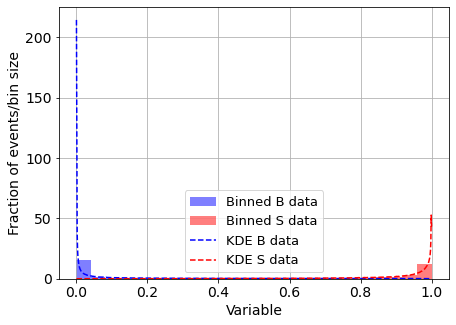

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  1%|▏                                | 11/2000 [00:13<28:13,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18334480809498999
<p_{s}(Sdata)> = 10.793468885515052
<p_{b}(Bdata)> = 79.93074296289674
<p_{s}(Bdata)> = 0.21270690229650246


  1%|▎                                | 17/2000 [00:22<41:12,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17630355956942692
<p_{s}(Sdata)> = 10.70277127298642
<p_{b}(Bdata)> = 79.67543941756166
<p_{s}(Bdata)> = 0.21202059043155988


  1%|▍                                | 27/2000 [00:35<33:51,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1968628307858657
<p_{s}(Sdata)> = 5.65529903888352
<p_{b}(Bdata)> = 80.00410704458291
<p_{s}(Bdata)> = 0.21573409246793243


  1%|▍                                | 28/2000 [00:35<27:05,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7338117814791882
<p_{s}(Sdata)> = 7.621792978271885
<p_{b}(Bdata)> = 79.23587468934441
<p_{s}(Bdata)> = 0.2160375651527019


  2%|▌                                | 36/2000 [00:44<34:08,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2300370616706916
<p_{s}(Sdata)> = 6.76358859058157
<p_{b}(Bdata)> = 79.7802144056687
<p_{s}(Bdata)> = 0.21547834042115302


  2%|▋                                | 40/2000 [00:49<33:19,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.215908037235154
<p_{s}(Sdata)> = 7.904285021709143
<p_{b}(Bdata)> = 80.16198810841719
<p_{s}(Bdata)> = 0.21588615075316256


  2%|▊                                | 49/2000 [01:02<35:52,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2876959605379853
<p_{s}(Sdata)> = 7.574123686024438
<p_{b}(Bdata)> = 79.96490260040562
<p_{s}(Bdata)> = 0.21380426258609156


  3%|▊                                | 51/2000 [01:04<31:23,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17489664310892297
<p_{s}(Sdata)> = 9.664511560709196
<p_{b}(Bdata)> = 79.93036133525897
<p_{s}(Bdata)> = 0.21541458822911388


  3%|▉                                | 56/2000 [01:09<30:03,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1830599690752853
<p_{s}(Sdata)> = 11.081357285085696
<p_{b}(Bdata)> = 79.46321645869469
<p_{s}(Bdata)> = 0.21412498227988655


  4%|█▏                               | 74/2000 [01:32<34:51,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.198434236047926
<p_{s}(Sdata)> = 10.026427956104916
<p_{b}(Bdata)> = 79.91966065856784
<p_{s}(Bdata)> = 0.2132316067538647


  4%|█▎                               | 83/2000 [01:44<33:38,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17666748953234615
<p_{s}(Sdata)> = 11.066928872249642
<p_{b}(Bdata)> = 79.44803582937519
<p_{s}(Bdata)> = 0.21155226267559699


  4%|█▍                               | 89/2000 [01:52<33:30,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2436366323061535
<p_{s}(Sdata)> = 9.523456692924837
<p_{b}(Bdata)> = 79.45069527551257
<p_{s}(Bdata)> = 0.21180072940378714


  5%|█▌                               | 97/2000 [02:00<30:19,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20022706735523635
<p_{s}(Sdata)> = 11.546794635549075
<p_{b}(Bdata)> = 79.61625634159296
<p_{s}(Bdata)> = 0.22522888994669746


  5%|█▋                              | 103/2000 [02:09<31:50,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2041785730951384
<p_{s}(Sdata)> = 9.934743971486016
<p_{b}(Bdata)> = 79.90628828582153
<p_{s}(Bdata)> = 0.2125436711198429


  6%|█▉                              | 118/2000 [02:25<30:13,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20316594020538864
<p_{s}(Sdata)> = 8.501274322408625
<p_{b}(Bdata)> = 80.13554282309855
<p_{s}(Bdata)> = 0.21362565816578588


  6%|██                              | 128/2000 [02:39<33:54,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19754666502274118
<p_{s}(Sdata)> = 5.875424945529776
<p_{b}(Bdata)> = 79.89835932908476
<p_{s}(Bdata)> = 0.21342513866146343


  6%|██                              | 129/2000 [02:39<27:15,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.240448066812907
<p_{s}(Sdata)> = 8.647277973646053
<p_{b}(Bdata)> = 79.83317455277574
<p_{s}(Bdata)> = 0.21177091790458963


  8%|██▋                             | 166/2000 [03:31<35:20,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19859030393902677
<p_{s}(Sdata)> = 8.01010215737627
<p_{b}(Bdata)> = 79.84721900193894
<p_{s}(Bdata)> = 0.21537299919670636


  9%|██▊                             | 173/2000 [03:40<32:29,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22947630459331053
<p_{s}(Sdata)> = 7.511554482683909
<p_{b}(Bdata)> = 80.01903398915208
<p_{s}(Bdata)> = 0.21820088674193605


 10%|███                             | 192/2000 [04:05<32:19,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1854005069948904
<p_{s}(Sdata)> = 8.195135123298986
<p_{b}(Bdata)> = 80.25914431640611
<p_{s}(Bdata)> = 0.21410976500567025


 10%|███                             | 193/2000 [04:05<25:45,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19296090211412206
<p_{s}(Sdata)> = 7.65896697386601
<p_{b}(Bdata)> = 80.34785263443278
<p_{s}(Bdata)> = 0.21514826090045808


 10%|███▏                            | 197/2000 [04:09<25:53,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1950276897608385
<p_{s}(Sdata)> = 8.513616224945077
<p_{b}(Bdata)> = 79.58294965918049
<p_{s}(Bdata)> = 0.21415848209736185


 10%|███▏                            | 202/2000 [04:13<20:25,  1.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1918667922633058
<p_{s}(Sdata)> = 16.691925826049467
<p_{b}(Bdata)> = 79.34268225038674
<p_{s}(Bdata)> = 0.2249179093839073


 11%|███▍                            | 211/2000 [04:25<32:35,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1797246963634089
<p_{s}(Sdata)> = 9.377223810460436
<p_{b}(Bdata)> = 79.58163843344931
<p_{s}(Bdata)> = 0.21382922594044593


 12%|███▊                            | 238/2000 [05:00<30:45,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19733274994526087
<p_{s}(Sdata)> = 8.09906407200044
<p_{b}(Bdata)> = 79.97307523788582
<p_{s}(Bdata)> = 0.21580552131972086


 12%|███▉                            | 246/2000 [05:08<24:34,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2312879550841818
<p_{s}(Sdata)> = 12.528926319547693
<p_{b}(Bdata)> = 79.88531227805562
<p_{s}(Bdata)> = 0.20973558724063399


 12%|████                            | 250/2000 [05:11<22:44,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19367005293789955
<p_{s}(Sdata)> = 7.675715853435556
<p_{b}(Bdata)> = 79.85736301371035
<p_{s}(Bdata)> = 0.21254846260637597


 13%|████▏                           | 265/2000 [05:32<30:16,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20639558710745218
<p_{s}(Sdata)> = 6.888082991866597
<p_{b}(Bdata)> = 80.08319945460072
<p_{s}(Bdata)> = 0.22006593034447575


 14%|████▌                           | 287/2000 [06:00<35:09,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1912483775111752
<p_{s}(Sdata)> = 8.430398886967495
<p_{b}(Bdata)> = 79.56673369678225
<p_{s}(Bdata)> = 0.21275097513125213


 15%|████▋                           | 296/2000 [06:12<29:41,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1924796939650163
<p_{s}(Sdata)> = 8.519997503328534
<p_{b}(Bdata)> = 79.67692658994103
<p_{s}(Bdata)> = 0.212322840850548


 16%|█████▏                          | 322/2000 [06:44<29:04,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22093569548881972
<p_{s}(Sdata)> = 6.010360232225797
<p_{b}(Bdata)> = 79.79142810611499
<p_{s}(Bdata)> = 0.21523900075129426


 17%|█████▍                          | 342/2000 [07:12<30:23,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22869832298564916
<p_{s}(Sdata)> = 8.791033931010894
<p_{b}(Bdata)> = 79.57960485659952
<p_{s}(Bdata)> = 0.2125528148986949


 17%|█████▌                          | 346/2000 [07:17<29:43,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19024459172174066
<p_{s}(Sdata)> = 10.565127717165698
<p_{b}(Bdata)> = 79.68208041004185
<p_{s}(Bdata)> = 0.2114660373084191


 18%|█████▊                          | 361/2000 [07:36<30:18,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19701192832482012
<p_{s}(Sdata)> = 12.017814393893646
<p_{b}(Bdata)> = 79.41822252281794
<p_{s}(Bdata)> = 0.21326971830177038


 18%|█████▊                          | 362/2000 [07:37<24:04,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20592863991248986
<p_{s}(Sdata)> = 7.1462262550836435
<p_{b}(Bdata)> = 80.15052661008819
<p_{s}(Bdata)> = 0.21346194211207575


 19%|█████▉                          | 371/2000 [07:45<21:49,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20059158495444354
<p_{s}(Sdata)> = 8.958345563814198
<p_{b}(Bdata)> = 79.52219116585957
<p_{s}(Bdata)> = 0.21128553181816256


 19%|██████▏                         | 387/2000 [08:05<25:21,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19148668447552344
<p_{s}(Sdata)> = 8.854537974369757
<p_{b}(Bdata)> = 79.62290534427407
<p_{s}(Bdata)> = 0.2164385224442022


 19%|██████▏                         | 389/2000 [08:06<20:20,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19587364403843846
<p_{s}(Sdata)> = 7.276704173325427
<p_{b}(Bdata)> = 80.02396751163711
<p_{s}(Bdata)> = 0.21416308817797053


 20%|██████▎                         | 393/2000 [08:11<25:20,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24007935686538664
<p_{s}(Sdata)> = 7.493152953276346
<p_{b}(Bdata)> = 79.4694002905306
<p_{s}(Bdata)> = 0.21582573189711907


 20%|██████▎                         | 397/2000 [08:15<25:43,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2960730750382153
<p_{s}(Sdata)> = 8.659239204099915
<p_{b}(Bdata)> = 79.76174210165175
<p_{s}(Bdata)> = 0.21578260251121628


 21%|██████▊                         | 424/2000 [08:46<25:40,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18708957568156387
<p_{s}(Sdata)> = 8.27243164113809
<p_{b}(Bdata)> = 79.71825783857606
<p_{s}(Bdata)> = 0.2150326003892225


 22%|██████▉                         | 433/2000 [08:57<24:23,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2082992442169689
<p_{s}(Sdata)> = 7.653700227529142
<p_{b}(Bdata)> = 79.9318536515503
<p_{s}(Bdata)> = 0.21326230136042146


 22%|███████                         | 444/2000 [09:09<27:10,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17951815771618082
<p_{s}(Sdata)> = 8.647624513235058
<p_{b}(Bdata)> = 80.1091392127071
<p_{s}(Bdata)> = 0.21569954992446908


 22%|███████▏                        | 446/2000 [09:12<29:40,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18701544558185165
<p_{s}(Sdata)> = 8.343112748570068
<p_{b}(Bdata)> = 79.94012509448169
<p_{s}(Bdata)> = 0.21668752000334468


 22%|███████▏                        | 448/2000 [09:13<23:17,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1972752143172358
<p_{s}(Sdata)> = 7.533538502231163
<p_{b}(Bdata)> = 80.02843191926293
<p_{s}(Bdata)> = 0.21152397032203646


 22%|███████▏                        | 450/2000 [09:14<18:23,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18356334177233202
<p_{s}(Sdata)> = 7.727243282501394
<p_{b}(Bdata)> = 79.12021873182914
<p_{s}(Bdata)> = 0.21729179967305562


 23%|███████▎                        | 457/2000 [09:22<22:26,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.189626055838072
<p_{s}(Sdata)> = 6.48214596652983
<p_{b}(Bdata)> = 79.61102293393242
<p_{s}(Bdata)> = 0.2153557722762873


 23%|███████▎                        | 459/2000 [09:25<24:12,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21188256611441175
<p_{s}(Sdata)> = 9.699102424112596
<p_{b}(Bdata)> = 80.13572329914017
<p_{s}(Bdata)> = 0.21333533308163374


 24%|███████▌                        | 472/2000 [09:39<24:08,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18250030222361657
<p_{s}(Sdata)> = 9.90218900975391
<p_{b}(Bdata)> = 79.44133660280349
<p_{s}(Bdata)> = 0.216848578214919


 24%|███████▋                        | 482/2000 [09:52<28:23,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18023153744203238
<p_{s}(Sdata)> = 7.835081860802196
<p_{b}(Bdata)> = 80.22819927025218
<p_{s}(Bdata)> = 0.21371967586685645


 25%|███████▉                        | 498/2000 [10:13<26:31,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18970052734690268
<p_{s}(Sdata)> = 9.491323231939047
<p_{b}(Bdata)> = 79.6974099460207
<p_{s}(Bdata)> = 0.21385823661391312


 25%|████████                        | 500/2000 [10:14<18:50,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20599159634407221
<p_{s}(Sdata)> = 9.035439831203044
<p_{b}(Bdata)> = 79.59400289188896
<p_{s}(Bdata)> = 0.21334412324722574


 25%|████████                        | 503/2000 [10:17<24:11,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1968771091436089
<p_{s}(Sdata)> = 8.542716136168648
<p_{b}(Bdata)> = 80.21332088401563
<p_{s}(Bdata)> = 0.21332822611661106


 27%|████████▋                       | 540/2000 [11:05<30:24,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19161573656325112
<p_{s}(Sdata)> = 8.829235631109963
<p_{b}(Bdata)> = 79.88405015649194
<p_{s}(Bdata)> = 0.21763302845163413


 27%|████████▋                       | 542/2000 [11:07<23:44,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2148983333019525
<p_{s}(Sdata)> = 8.160787928971981
<p_{b}(Bdata)> = 79.58285232640023
<p_{s}(Bdata)> = 0.22036288670273838


 27%|████████▋                       | 543/2000 [11:07<19:07,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21197527147960316
<p_{s}(Sdata)> = 7.435172945458813
<p_{b}(Bdata)> = 79.45570747304029
<p_{s}(Bdata)> = 0.21946337240071373


 27%|████████▊                       | 549/2000 [11:12<17:46,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.199121729608335
<p_{s}(Sdata)> = 6.422290673044396
<p_{b}(Bdata)> = 79.33565713354565
<p_{s}(Bdata)> = 0.21269835995348593


 28%|████████▊                       | 552/2000 [11:15<20:18,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17589787377504015
<p_{s}(Sdata)> = 8.7049059499366
<p_{b}(Bdata)> = 79.92428075127853
<p_{s}(Bdata)> = 0.21284825726254297


 28%|████████▉                       | 556/2000 [11:19<20:24,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21642667692982817
<p_{s}(Sdata)> = 8.586903847756489
<p_{b}(Bdata)> = 80.26615809195079
<p_{s}(Bdata)> = 0.21466068489767634


 28%|█████████                       | 569/2000 [11:34<27:09,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.200930307089981
<p_{s}(Sdata)> = 7.1473634048988135
<p_{b}(Bdata)> = 79.99124298460836
<p_{s}(Bdata)> = 0.21183914199958373


 29%|█████████▏                      | 575/2000 [11:41<23:46,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2032688876579427
<p_{s}(Sdata)> = 7.925387663140251
<p_{b}(Bdata)> = 79.76689316991542
<p_{s}(Bdata)> = 0.21372405349354684


 29%|█████████▎                      | 579/2000 [11:43<16:05,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20920618472190042
<p_{s}(Sdata)> = 8.686142697587014
<p_{b}(Bdata)> = 79.82040494800842
<p_{s}(Bdata)> = 0.2140795708457074


 30%|█████████▍                      | 593/2000 [12:02<23:14,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17962886740789516
<p_{s}(Sdata)> = 9.284725822341088
<p_{b}(Bdata)> = 79.33419824469152
<p_{s}(Bdata)> = 0.20747091435342702


 30%|█████████▌                      | 595/2000 [12:04<23:04,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18600356109734492
<p_{s}(Sdata)> = 9.755435296683062
<p_{b}(Bdata)> = 79.90360103870033
<p_{s}(Bdata)> = 0.21471912460155984


 31%|█████████▊                      | 617/2000 [12:32<22:58,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2216553376500392
<p_{s}(Sdata)> = 7.907068977003476
<p_{b}(Bdata)> = 79.53684332222485
<p_{s}(Bdata)> = 0.21454941283701126


 31%|█████████▉                      | 624/2000 [12:41<24:20,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.271942592024186
<p_{s}(Sdata)> = 10.825163051042043
<p_{b}(Bdata)> = 79.58931685210958
<p_{s}(Bdata)> = 0.21518205237358942


 32%|██████████                      | 631/2000 [12:48<18:00,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1725742072384944
<p_{s}(Sdata)> = 8.160912046774593
<p_{b}(Bdata)> = 80.03246922220643
<p_{s}(Bdata)> = 0.21423652414332509


 32%|██████████                      | 632/2000 [12:48<14:56,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24447312481813055
<p_{s}(Sdata)> = 8.689862062123924
<p_{b}(Bdata)> = 79.80408107831283
<p_{s}(Bdata)> = 0.21156555316293585


 32%|██████████▎                     | 644/2000 [13:04<23:49,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17483995649385878
<p_{s}(Sdata)> = 8.881111830804949
<p_{b}(Bdata)> = 79.67573462015554
<p_{s}(Bdata)> = 0.2127061901245329


 32%|██████████▎                     | 647/2000 [13:08<25:41,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20362595568152045
<p_{s}(Sdata)> = 7.466604309394636
<p_{b}(Bdata)> = 79.33124669733392
<p_{s}(Bdata)> = 0.21293554204157844


 33%|██████████▍                     | 652/2000 [13:14<23:34,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785313521910343
<p_{s}(Sdata)> = 10.497952868774222
<p_{b}(Bdata)> = 79.78140498658685
<p_{s}(Bdata)> = 0.21193124303930672


 33%|██████████▍                     | 653/2000 [13:14<18:51,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19562645155358988
<p_{s}(Sdata)> = 10.39233486204718
<p_{b}(Bdata)> = 79.63288680005718
<p_{s}(Bdata)> = 0.21118743947892812


 33%|██████████▋                     | 668/2000 [13:36<28:15,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19445118719974913
<p_{s}(Sdata)> = 9.386322287402306
<p_{b}(Bdata)> = 80.00839991050815
<p_{s}(Bdata)> = 0.2121951548282301


 35%|███████████                     | 692/2000 [14:07<22:08,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21836272005023663
<p_{s}(Sdata)> = 6.367736257876006
<p_{b}(Bdata)> = 79.72273808101782
<p_{s}(Bdata)> = 0.21517360125844914


 35%|███████████▎                    | 708/2000 [14:27<22:59,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19305207203374763
<p_{s}(Sdata)> = 6.996545336597162
<p_{b}(Bdata)> = 79.51212863921421
<p_{s}(Bdata)> = 0.2125220824174984


 36%|███████████▌                    | 723/2000 [14:47<22:35,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19936330701987393
<p_{s}(Sdata)> = 8.534632821754276
<p_{b}(Bdata)> = 80.06697650760812
<p_{s}(Bdata)> = 0.21524555500451628


 38%|████████████                    | 752/2000 [15:26<20:29,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18798581998360572
<p_{s}(Sdata)> = 8.564317365410416
<p_{b}(Bdata)> = 79.90374910934283
<p_{s}(Bdata)> = 0.21303385739377662


 38%|████████████▏                   | 761/2000 [15:38<24:06,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17742731219630556
<p_{s}(Sdata)> = 10.43667027701497
<p_{b}(Bdata)> = 79.86317628439829
<p_{s}(Bdata)> = 0.2145447822696064


 38%|████████████▏                   | 762/2000 [15:38<19:01,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4743854878577056
<p_{s}(Sdata)> = 11.142345926262218
<p_{b}(Bdata)> = 79.37118153799507
<p_{s}(Bdata)> = 0.21582329645753828


 39%|████████████▎                   | 771/2000 [15:48<18:01,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2043638159150835
<p_{s}(Sdata)> = 9.368478532841944
<p_{b}(Bdata)> = 80.0487824471098
<p_{s}(Bdata)> = 0.21318212550030533


 39%|████████████▎                   | 772/2000 [15:48<14:42,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.191673554021005
<p_{s}(Sdata)> = 8.265243125332475
<p_{b}(Bdata)> = 79.78501128869435
<p_{s}(Bdata)> = 0.2157092269019947


 39%|████████████▍                   | 774/2000 [15:49<12:12,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21365002177146708
<p_{s}(Sdata)> = 8.172390418048108
<p_{b}(Bdata)> = 79.87382982939948
<p_{s}(Bdata)> = 0.20888542606176777


 40%|████████████▋                   | 796/2000 [16:19<18:32,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20804091171983094
<p_{s}(Sdata)> = 10.399462698808975
<p_{b}(Bdata)> = 79.5824666530667
<p_{s}(Bdata)> = 0.21413147720362616


 41%|█████████████▏                  | 828/2000 [17:02<21:23,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18585003614108708
<p_{s}(Sdata)> = 6.238719948061388
<p_{b}(Bdata)> = 79.37708241033239
<p_{s}(Bdata)> = 0.21700295559202099


 42%|█████████████▍                  | 840/2000 [17:18<22:14,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19290008835426992
<p_{s}(Sdata)> = 8.534725911478006
<p_{b}(Bdata)> = 79.24219594956344
<p_{s}(Bdata)> = 0.21594605940233902


 43%|█████████████▋                  | 852/2000 [17:32<18:33,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1830112154251897
<p_{s}(Sdata)> = 10.45797234303995
<p_{b}(Bdata)> = 79.54985712891205
<p_{s}(Bdata)> = 0.21132945107542958


 43%|█████████████▋                  | 855/2000 [17:35<15:57,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23716314416013584
<p_{s}(Sdata)> = 10.635627262559014
<p_{b}(Bdata)> = 80.19851625170793
<p_{s}(Bdata)> = 0.21002168890245115


 43%|█████████████▊                  | 864/2000 [17:46<18:44,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20427563763119883
<p_{s}(Sdata)> = 8.84415914787956
<p_{b}(Bdata)> = 79.80386537532456
<p_{s}(Bdata)> = 0.2160581725412054


 44%|█████████████▉                  | 873/2000 [17:57<21:19,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20955661053456673
<p_{s}(Sdata)> = 7.526600215093696
<p_{b}(Bdata)> = 79.89642240935305
<p_{s}(Bdata)> = 0.21387891411623564


 44%|█████████████▉                  | 874/2000 [17:57<16:51,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2221245143392315
<p_{s}(Sdata)> = 7.42765781667477
<p_{b}(Bdata)> = 79.66495387635153
<p_{s}(Bdata)> = 0.2163465996216689


 44%|██████████████                  | 875/2000 [17:58<13:44,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1994570902092286
<p_{s}(Sdata)> = 8.615091102903515
<p_{b}(Bdata)> = 79.55746936170131
<p_{s}(Bdata)> = 0.21107015697121273


 44%|██████████████                  | 881/2000 [18:05<20:45,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19489130460138937
<p_{s}(Sdata)> = 7.241080813634421
<p_{b}(Bdata)> = 79.97577064418604
<p_{s}(Bdata)> = 0.21619582279047594


 45%|██████████████▎                 | 891/2000 [18:18<21:10,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.9331377397808587
<p_{s}(Sdata)> = 7.667224794879137
<p_{b}(Bdata)> = 79.38260114455434
<p_{s}(Bdata)> = 0.21424304210194536


 45%|██████████████▍                 | 902/2000 [18:34<22:09,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2254565950988725
<p_{s}(Sdata)> = 7.1317496462950905
<p_{b}(Bdata)> = 80.0785735101726
<p_{s}(Bdata)> = 0.21706543514332502


 45%|██████████████▌                 | 907/2000 [18:40<18:04,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1909962695494604
<p_{s}(Sdata)> = 7.229153936077386
<p_{b}(Bdata)> = 80.14408499801759
<p_{s}(Bdata)> = 0.21344398914860238


 45%|██████████████▌                 | 908/2000 [18:40<14:32,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19072984113920996
<p_{s}(Sdata)> = 9.500442263480744
<p_{b}(Bdata)> = 79.86081897006783
<p_{s}(Bdata)> = 0.21247535445894833


 46%|██████████████▌                 | 910/2000 [18:42<15:43,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20863350941222494
<p_{s}(Sdata)> = 8.727991008853694
<p_{b}(Bdata)> = 80.12121012170948
<p_{s}(Bdata)> = 0.21016835984121418


 46%|██████████████▊                 | 925/2000 [19:00<18:08,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20191179779857787
<p_{s}(Sdata)> = 6.668921630496005
<p_{b}(Bdata)> = 79.90368104516551
<p_{s}(Bdata)> = 0.21127236277086212


 46%|██████████████▊                 | 929/2000 [19:04<15:31,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20986599632404754
<p_{s}(Sdata)> = 7.6008168575924575
<p_{b}(Bdata)> = 80.028709563392
<p_{s}(Bdata)> = 0.2127074687179392


 49%|███████████████▋                | 979/2000 [20:10<15:22,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18046382937476294
<p_{s}(Sdata)> = 11.684127233041709
<p_{b}(Bdata)> = 79.5023221441297
<p_{s}(Bdata)> = 0.21070120873418532


 49%|███████████████▋                | 983/2000 [20:13<11:59,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21288524699111624
<p_{s}(Sdata)> = 6.108373004830844
<p_{b}(Bdata)> = 80.155546692327
<p_{s}(Bdata)> = 0.21185616237035573


 49%|███████████████▊                | 987/2000 [20:17<12:40,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20742119785129026
<p_{s}(Sdata)> = 7.933897539694232
<p_{b}(Bdata)> = 79.90474587643472
<p_{s}(Bdata)> = 0.2146401812136317


 49%|███████████████▊                | 989/2000 [20:19<15:04,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20422733869250656
<p_{s}(Sdata)> = 8.442178935212885
<p_{b}(Bdata)> = 80.19918731291236
<p_{s}(Bdata)> = 0.2140353734656429


 50%|███████████████▉                | 993/2000 [20:24<16:08,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17121945829845994
<p_{s}(Sdata)> = 10.852321719797727
<p_{b}(Bdata)> = 80.19941287194985
<p_{s}(Bdata)> = 0.21195505796044084


 50%|███████████████▉                | 996/2000 [20:27<14:36,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19341597165910038
<p_{s}(Sdata)> = 9.127234991095165
<p_{b}(Bdata)> = 79.3913132154358
<p_{s}(Bdata)> = 0.21392412650436804


 50%|███████████████▌               | 1004/2000 [20:38<18:27,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22696139830728923
<p_{s}(Sdata)> = 7.264442290815271
<p_{b}(Bdata)> = 79.53515939316665
<p_{s}(Bdata)> = 0.21673696947201856


 52%|████████████████               | 1037/2000 [21:20<20:32,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19929893897211598
<p_{s}(Sdata)> = 9.663240645196876
<p_{b}(Bdata)> = 80.31532940699259
<p_{s}(Bdata)> = 0.21442057238772969


 56%|█████████████████▎             | 1119/2000 [23:10<14:35,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2452492840962223
<p_{s}(Sdata)> = 10.381271298562737
<p_{b}(Bdata)> = 79.57923872661547
<p_{s}(Bdata)> = 0.21224657673412042


 56%|█████████████████▍             | 1124/2000 [23:18<18:27,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22154507793235387
<p_{s}(Sdata)> = 7.762292029546576
<p_{b}(Bdata)> = 79.92703642095954
<p_{s}(Bdata)> = 0.21137934127028193


 57%|█████████████████▌             | 1132/2000 [23:27<15:47,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21399852661205013
<p_{s}(Sdata)> = 5.8018593183271685
<p_{b}(Bdata)> = 79.31458205562379
<p_{s}(Bdata)> = 0.21493763811877334


 57%|█████████████████▌             | 1137/2000 [23:32<12:01,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.179662912615551
<p_{s}(Sdata)> = 9.74464015709808
<p_{b}(Bdata)> = 80.18847869781678
<p_{s}(Bdata)> = 0.21202277833851257


 57%|█████████████████▊             | 1146/2000 [23:43<14:33,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2110657677076558
<p_{s}(Sdata)> = 7.746511249892578
<p_{b}(Bdata)> = 79.78122180475563
<p_{s}(Bdata)> = 0.21409048339377595


 58%|█████████████████▊             | 1152/2000 [23:50<14:43,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4421793447756423
<p_{s}(Sdata)> = 7.089080399755591
<p_{b}(Bdata)> = 79.60596384704128
<p_{s}(Bdata)> = 0.21451002486298945


 58%|██████████████████             | 1163/2000 [24:04<14:29,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20158925875885972
<p_{s}(Sdata)> = 7.258016189120604
<p_{b}(Bdata)> = 79.66418678382725
<p_{s}(Bdata)> = 0.2148540580394244


 59%|██████████████████▎            | 1178/2000 [24:20<11:15,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.199805664103869
<p_{s}(Sdata)> = 9.375808413804538
<p_{b}(Bdata)> = 80.19268305631991
<p_{s}(Bdata)> = 0.21140745505813793


 59%|██████████████████▎            | 1185/2000 [24:27<11:49,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27000762338340284
<p_{s}(Sdata)> = 6.832126659219963
<p_{b}(Bdata)> = 79.6854672967555
<p_{s}(Bdata)> = 0.20773411039688253


 59%|██████████████████▍            | 1186/2000 [24:28<09:40,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.2846744502855778
<p_{s}(Sdata)> = 11.276810972550958
<p_{b}(Bdata)> = 79.71182180281897
<p_{s}(Bdata)> = 0.2147510529030403


 60%|██████████████████▍            | 1193/2000 [24:34<10:21,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2046858737154425
<p_{s}(Sdata)> = 6.9518143442642755
<p_{b}(Bdata)> = 79.96599241420466
<p_{s}(Bdata)> = 0.2168069113481362


 60%|██████████████████▌            | 1194/2000 [24:34<08:38,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19637266437743653
<p_{s}(Sdata)> = 7.280475795718102
<p_{b}(Bdata)> = 79.34083646084314
<p_{s}(Bdata)> = 0.21568724022205538


 60%|██████████████████▌            | 1197/2000 [24:38<12:38,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1816562893836971
<p_{s}(Sdata)> = 8.617326745367665
<p_{b}(Bdata)> = 79.62079972338016
<p_{s}(Bdata)> = 0.2117908669828467


 60%|██████████████████▌            | 1199/2000 [24:39<09:56,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26245211090829207
<p_{s}(Sdata)> = 8.705066108178098
<p_{b}(Bdata)> = 79.81747981113324
<p_{s}(Bdata)> = 0.2138392785098828


 60%|██████████████████▋            | 1202/2000 [24:43<13:38,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2667033477607523
<p_{s}(Sdata)> = 8.796104496085887
<p_{b}(Bdata)> = 79.5034585412126
<p_{s}(Bdata)> = 0.21394405717393636


 61%|██████████████████▊            | 1212/2000 [24:56<13:59,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1909019740573052
<p_{s}(Sdata)> = 13.100660392905674
<p_{b}(Bdata)> = 79.97415988583728
<p_{s}(Bdata)> = 0.214454712860778


 61%|██████████████████▉            | 1223/2000 [25:09<13:04,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19782893937238052
<p_{s}(Sdata)> = 6.694600362175841
<p_{b}(Bdata)> = 79.45103043254626
<p_{s}(Bdata)> = 0.21490587668663125


 61%|██████████████████▉            | 1224/2000 [25:09<10:29,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23124861025175592
<p_{s}(Sdata)> = 6.95376668110115
<p_{b}(Bdata)> = 79.58813228095632
<p_{s}(Bdata)> = 0.21417052770605707


 61%|███████████████████            | 1229/2000 [25:14<09:46,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 4.61870850840889
<p_{s}(Sdata)> = 7.218718586302089
<p_{b}(Bdata)> = 79.70078286656269
<p_{s}(Bdata)> = 0.21259665548520995


 62%|███████████████████▎           | 1242/2000 [25:32<13:06,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2206461964889924
<p_{s}(Sdata)> = 11.689222309056186
<p_{b}(Bdata)> = 79.98348729336178
<p_{s}(Bdata)> = 0.21121485630816147


 62%|███████████████████▍           | 1250/2000 [25:41<12:39,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18128315692029218
<p_{s}(Sdata)> = 8.824099034359543
<p_{b}(Bdata)> = 80.24461869858014
<p_{s}(Bdata)> = 0.21387376245209622


 63%|███████████████████▍           | 1253/2000 [25:44<10:11,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2016302031914988
<p_{s}(Sdata)> = 7.778888937332468
<p_{b}(Bdata)> = 79.91323842390445
<p_{s}(Bdata)> = 0.2128820879445322


 63%|███████████████████▌           | 1260/2000 [25:52<12:29,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19266584557192243
<p_{s}(Sdata)> = 7.7454344664974
<p_{b}(Bdata)> = 79.75343378885617
<p_{s}(Bdata)> = 0.21573247664581546


 63%|███████████████████▌           | 1261/2000 [25:52<10:00,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1838983595300367
<p_{s}(Sdata)> = 8.213357155438224
<p_{b}(Bdata)> = 80.15637830571522
<p_{s}(Bdata)> = 0.2143460808199295


 63%|███████████████████▋           | 1268/2000 [26:01<12:26,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2109174916918106
<p_{s}(Sdata)> = 7.159038344186073
<p_{b}(Bdata)> = 80.07038155208865
<p_{s}(Bdata)> = 0.214138950324034


 64%|███████████████████▋           | 1272/2000 [26:04<10:29,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21931536649977607
<p_{s}(Sdata)> = 7.330054035878509
<p_{b}(Bdata)> = 79.87073290285333
<p_{s}(Bdata)> = 0.21282185299362077


 64%|███████████████████▊           | 1277/2000 [26:10<11:59,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18170686152572832
<p_{s}(Sdata)> = 8.54554045716037
<p_{b}(Bdata)> = 79.8363038690169
<p_{s}(Bdata)> = 0.21329385688635386


 65%|████████████████████           | 1292/2000 [26:26<11:34,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6454577198535025
<p_{s}(Sdata)> = 9.5380205033276
<p_{b}(Bdata)> = 79.58936213466578
<p_{s}(Bdata)> = 0.21507312327013073


 66%|████████████████████▍          | 1315/2000 [26:55<12:34,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.182468164836135
<p_{s}(Sdata)> = 9.10712316902369
<p_{b}(Bdata)> = 79.72237116799484
<p_{s}(Bdata)> = 0.2140507892310916


 66%|████████████████████▌          | 1323/2000 [27:05<10:42,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16876282440739326
<p_{s}(Sdata)> = 10.49080845750649
<p_{b}(Bdata)> = 80.20856109837788
<p_{s}(Bdata)> = 0.2119867673865455


 66%|████████████████████▌          | 1329/2000 [27:12<11:19,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1999745753785352
<p_{s}(Sdata)> = 8.138463204749042
<p_{b}(Bdata)> = 79.93576832619297
<p_{s}(Bdata)> = 0.21437127245338497


 67%|████████████████████▋          | 1333/2000 [27:17<10:33,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3222384132170393
<p_{s}(Sdata)> = 9.765367762491781
<p_{b}(Bdata)> = 79.51274095518801
<p_{s}(Bdata)> = 0.21478004116046415


 67%|████████████████████▊          | 1343/2000 [27:29<10:54,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17990277178973862
<p_{s}(Sdata)> = 9.386574982645087
<p_{b}(Bdata)> = 79.66360376922528
<p_{s}(Bdata)> = 0.21511773433830383


 68%|████████████████████▉          | 1352/2000 [27:39<11:23,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18290579795083495
<p_{s}(Sdata)> = 9.75105056084506
<p_{b}(Bdata)> = 79.9381982623931
<p_{s}(Bdata)> = 0.2136581316556552


 68%|████████████████████▉          | 1353/2000 [27:40<09:05,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19301752300597197
<p_{s}(Sdata)> = 8.710341489869638
<p_{b}(Bdata)> = 79.0534416642777
<p_{s}(Bdata)> = 0.21642045938628052


 68%|█████████████████████▏         | 1370/2000 [28:01<10:00,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2614005972477691
<p_{s}(Sdata)> = 8.62895219710974
<p_{b}(Bdata)> = 79.58971733276314
<p_{s}(Bdata)> = 0.21102257867966484


 69%|█████████████████████▍         | 1386/2000 [28:23<12:35,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31588203397171244
<p_{s}(Sdata)> = 9.652781914579405
<p_{b}(Bdata)> = 79.12149708416113
<p_{s}(Bdata)> = 0.21414306522333318


 70%|█████████████████████▋         | 1399/2000 [28:38<09:58,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.328731508346411
<p_{s}(Sdata)> = 11.472275652867935
<p_{b}(Bdata)> = 79.9719331184671
<p_{s}(Bdata)> = 0.21491416581788553


 70%|█████████████████████▋         | 1400/2000 [28:39<08:00,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1799104604111068
<p_{s}(Sdata)> = 7.00492373697502
<p_{b}(Bdata)> = 79.84338760498342
<p_{s}(Bdata)> = 0.21555111403393207


 70%|█████████████████████▋         | 1403/2000 [28:41<07:37,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17294128660810978
<p_{s}(Sdata)> = 8.778898636433162
<p_{b}(Bdata)> = 79.7668951646395
<p_{s}(Bdata)> = 0.21401135706042992


 70%|█████████████████████▊         | 1406/2000 [28:45<09:22,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18866172690163968
<p_{s}(Sdata)> = 9.82854071568113
<p_{b}(Bdata)> = 79.81468667020822
<p_{s}(Bdata)> = 0.2100060456637897


 71%|█████████████████████▉         | 1415/2000 [28:56<10:16,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.391865457150899
<p_{s}(Sdata)> = 7.233023834313487
<p_{b}(Bdata)> = 80.24393264968845
<p_{s}(Bdata)> = 0.21582097876385464


 71%|█████████████████████▉         | 1418/2000 [28:58<08:17,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1856615563429286
<p_{s}(Sdata)> = 8.166505571339078
<p_{b}(Bdata)> = 79.71134179443688
<p_{s}(Bdata)> = 0.21191227011231845


 71%|██████████████████████         | 1422/2000 [29:02<08:35,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17390895207654025
<p_{s}(Sdata)> = 8.990452766709433
<p_{b}(Bdata)> = 80.23788143003492
<p_{s}(Bdata)> = 0.2146188247399509


 71%|██████████████████████         | 1423/2000 [29:03<07:00,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5601074000302986
<p_{s}(Sdata)> = 10.613837934040282
<p_{b}(Bdata)> = 79.90004420988362
<p_{s}(Bdata)> = 0.21248668079778507


 71%|██████████████████████         | 1427/2000 [29:07<08:14,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2035407771659125
<p_{s}(Sdata)> = 8.010372401091859
<p_{b}(Bdata)> = 80.0472486350943
<p_{s}(Bdata)> = 0.21486921766716902


 72%|██████████████████████▎        | 1437/2000 [29:18<09:21,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18718752181100817
<p_{s}(Sdata)> = 6.68847145691963
<p_{b}(Bdata)> = 79.57948960704965
<p_{s}(Bdata)> = 0.21828267398107729


 72%|██████████████████████▎        | 1439/2000 [29:20<08:24,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15660918265608514
<p_{s}(Sdata)> = 14.265789195266333
<p_{b}(Bdata)> = 79.66218050043538
<p_{s}(Bdata)> = 0.2227847021608737


 73%|██████████████████████▍        | 1451/2000 [29:37<09:45,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19619617808959997
<p_{s}(Sdata)> = 9.360923444643532
<p_{b}(Bdata)> = 79.4508764751573
<p_{s}(Bdata)> = 0.21581791371511516


 73%|██████████████████████▌        | 1452/2000 [29:37<07:46,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22243844127871842
<p_{s}(Sdata)> = 8.558014950298897
<p_{b}(Bdata)> = 79.61329589731926
<p_{s}(Bdata)> = 0.2148396802779409


 73%|██████████████████████▋        | 1460/2000 [29:46<08:22,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2227089762954234
<p_{s}(Sdata)> = 5.716409201532258
<p_{b}(Bdata)> = 80.07363222599373
<p_{s}(Bdata)> = 0.21785445551552352


 73%|██████████████████████▋        | 1461/2000 [29:46<06:47,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43081440304785873
<p_{s}(Sdata)> = 9.308151333761247
<p_{b}(Bdata)> = 79.72664434409607
<p_{s}(Bdata)> = 0.21169295654571024


 74%|██████████████████████▉        | 1477/2000 [30:07<10:04,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17823443419330814
<p_{s}(Sdata)> = 10.236751989857122
<p_{b}(Bdata)> = 80.0946798869117
<p_{s}(Bdata)> = 0.21417130869729342


 74%|██████████████████████▉        | 1482/2000 [30:13<08:59,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18301876301953704
<p_{s}(Sdata)> = 8.9586083114506
<p_{b}(Bdata)> = 80.12413806989818
<p_{s}(Bdata)> = 0.21492176777486421


 75%|███████████████████████▏       | 1494/2000 [30:28<08:24,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20826838292728567
<p_{s}(Sdata)> = 6.57353332897192
<p_{b}(Bdata)> = 79.94403432602851
<p_{s}(Bdata)> = 0.21610956774682025


 76%|███████████████████████▌       | 1519/2000 [30:58<06:57,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2092469501596968
<p_{s}(Sdata)> = 5.911429027426396
<p_{b}(Bdata)> = 80.29924280776888
<p_{s}(Bdata)> = 0.21302861269475712


 77%|███████████████████████▉       | 1541/2000 [31:28<10:52,  1.42s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19341861349244585
<p_{s}(Sdata)> = 7.151065006471509
<p_{b}(Bdata)> = 80.24905608332391
<p_{s}(Bdata)> = 0.213684431546662


 78%|████████████████████████▏      | 1557/2000 [31:50<08:27,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18851718856633867
<p_{s}(Sdata)> = 9.099499024177325
<p_{b}(Bdata)> = 79.68981403258543
<p_{s}(Bdata)> = 0.21423813335741265


 78%|████████████████████████▏      | 1561/2000 [31:55<09:06,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1938672948092796
<p_{s}(Sdata)> = 9.86520275811828
<p_{b}(Bdata)> = 79.61505686952631
<p_{s}(Bdata)> = 0.21588240955460353


 79%|████████████████████████▍      | 1576/2000 [32:13<05:26,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16442889609906355
<p_{s}(Sdata)> = 10.532686495863617
<p_{b}(Bdata)> = 79.87331357174557
<p_{s}(Bdata)> = 0.21404481324493818


 80%|████████████████████████▊      | 1602/2000 [32:44<08:25,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5704986323765672
<p_{s}(Sdata)> = 7.8332327914687845
<p_{b}(Bdata)> = 80.09755706841742
<p_{s}(Bdata)> = 0.2142463981500475


 80%|████████████████████████▉      | 1606/2000 [32:49<07:37,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.248218963796953
<p_{s}(Sdata)> = 7.289086000293457
<p_{b}(Bdata)> = 80.00616715858843
<p_{s}(Bdata)> = 0.21284881946075407


 81%|█████████████████████████      | 1617/2000 [33:01<06:11,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21723268289682177
<p_{s}(Sdata)> = 9.146847135924451
<p_{b}(Bdata)> = 79.56877119451225
<p_{s}(Bdata)> = 0.21196810274669137


 81%|█████████████████████████▏     | 1621/2000 [33:05<05:17,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19426007276513527
<p_{s}(Sdata)> = 7.4471633098195715
<p_{b}(Bdata)> = 80.53473293021558
<p_{s}(Bdata)> = 0.2086927373487105


 82%|█████████████████████████▎     | 1634/2000 [33:19<05:13,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1845301381826175
<p_{s}(Sdata)> = 10.572466175750442
<p_{b}(Bdata)> = 79.73030064554663
<p_{s}(Bdata)> = 0.21230553410026373


 82%|█████████████████████████▍     | 1639/2000 [33:24<05:09,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45632157942963636
<p_{s}(Sdata)> = 9.610048328706501
<p_{b}(Bdata)> = 79.97030328860215
<p_{s}(Bdata)> = 0.21813867703232015


 82%|█████████████████████████▌     | 1647/2000 [33:33<05:31,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18035717383171562
<p_{s}(Sdata)> = 10.38742243374936
<p_{b}(Bdata)> = 79.96467886716093
<p_{s}(Bdata)> = 0.21155995389030907


 82%|█████████████████████████▌     | 1648/2000 [33:34<04:27,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20978009968067965
<p_{s}(Sdata)> = 12.063580128952774
<p_{b}(Bdata)> = 79.84822234523368
<p_{s}(Bdata)> = 0.2101723351090804


 82%|█████████████████████████▌     | 1649/2000 [33:34<03:42,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19132112638939688
<p_{s}(Sdata)> = 12.507764672074833
<p_{b}(Bdata)> = 79.99525842201678
<p_{s}(Bdata)> = 0.21052252104017843


 83%|█████████████████████████▋     | 1660/2000 [33:49<07:05,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19715049917919472
<p_{s}(Sdata)> = 8.388600148793897
<p_{b}(Bdata)> = 80.19797198538438
<p_{s}(Bdata)> = 0.21501269030760845


 83%|█████████████████████████▊     | 1666/2000 [33:56<05:57,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22584746228917393
<p_{s}(Sdata)> = 7.320859932590295
<p_{b}(Bdata)> = 79.04137251648577
<p_{s}(Bdata)> = 0.21841604887966928


 84%|██████████████████████████     | 1679/2000 [34:12<05:04,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18480500623749632
<p_{s}(Sdata)> = 10.151227229775861
<p_{b}(Bdata)> = 79.63383718171531
<p_{s}(Bdata)> = 0.21347548574495415


 84%|██████████████████████████     | 1682/2000 [34:15<04:48,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30359074699868827
<p_{s}(Sdata)> = 6.63336438542516
<p_{b}(Bdata)> = 79.62883089591284
<p_{s}(Bdata)> = 0.2146626821185574


 86%|██████████████████████████▌    | 1715/2000 [34:58<05:35,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2088568645390618
<p_{s}(Sdata)> = 7.389024819647272
<p_{b}(Bdata)> = 79.79909999697978
<p_{s}(Bdata)> = 0.21169971576737542


 87%|██████████████████████████▉    | 1740/2000 [35:30<04:11,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21502863541404574
<p_{s}(Sdata)> = 10.080124392485585
<p_{b}(Bdata)> = 80.27625202836845
<p_{s}(Bdata)> = 0.21120830413356956


 88%|███████████████████████████▏   | 1755/2000 [35:48<04:11,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.29262626740450076
<p_{s}(Sdata)> = 8.338508432521314
<p_{b}(Bdata)> = 80.12328550544498
<p_{s}(Bdata)> = 0.213326526792312


 89%|███████████████████████████▌   | 1780/2000 [36:21<03:14,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20302495885004004
<p_{s}(Sdata)> = 9.21496281417073
<p_{b}(Bdata)> = 79.55937746422588
<p_{s}(Bdata)> = 0.2114305578484907


 90%|███████████████████████████▉   | 1801/2000 [36:54<04:05,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17910073253017023
<p_{s}(Sdata)> = 10.662299580682195
<p_{b}(Bdata)> = 79.99922698351509
<p_{s}(Bdata)> = 0.2128411560364585


 90%|███████████████████████████▉   | 1802/2000 [36:54<03:12,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1823416965044087
<p_{s}(Sdata)> = 7.9159437678501465
<p_{b}(Bdata)> = 79.9678940858802
<p_{s}(Bdata)> = 0.21217854383708715


 90%|███████████████████████████▉   | 1804/2000 [36:55<02:36,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2155049076416539
<p_{s}(Sdata)> = 5.735627048320061
<p_{b}(Bdata)> = 79.7286844316837
<p_{s}(Bdata)> = 0.21569746384132785


 91%|████████████████████████████▏  | 1815/2000 [37:09<03:03,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1774338102235907
<p_{s}(Sdata)> = 9.195550349499104
<p_{b}(Bdata)> = 80.00317082715284
<p_{s}(Bdata)> = 0.21283198029087647


 92%|████████████████████████████▍  | 1834/2000 [37:33<03:11,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2038326490277869
<p_{s}(Sdata)> = 9.083643411302509
<p_{b}(Bdata)> = 79.87590252564698
<p_{s}(Bdata)> = 0.21422452497153954


 95%|█████████████████████████████▍ | 1901/2000 [39:00<01:28,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18625216681139053
<p_{s}(Sdata)> = 7.983313551760434
<p_{b}(Bdata)> = 80.04966264338574
<p_{s}(Bdata)> = 0.21362331894787975


 95%|█████████████████████████████▍ | 1903/2000 [39:01<01:14,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23477300336408022
<p_{s}(Sdata)> = 8.390257723470077
<p_{b}(Bdata)> = 80.21898976413394
<p_{s}(Bdata)> = 0.21298054280137346


 96%|█████████████████████████████▊ | 1921/2000 [39:26<01:22,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1858144069465638
<p_{s}(Sdata)> = 8.27858248196397
<p_{b}(Bdata)> = 79.46692175972842
<p_{s}(Bdata)> = 0.21572717855864643


 96%|█████████████████████████████▊ | 1922/2000 [39:27<01:04,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17710698222181465
<p_{s}(Sdata)> = 8.899112876477783
<p_{b}(Bdata)> = 80.02904728212575
<p_{s}(Bdata)> = 0.21658664476373235


 96%|█████████████████████████████▉ | 1928/2000 [39:34<01:14,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5438659322148127
<p_{s}(Sdata)> = 8.624018722341127
<p_{b}(Bdata)> = 80.09236023383798
<p_{s}(Bdata)> = 0.21116115425363663


 97%|██████████████████████████████ | 1937/2000 [39:43<00:57,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22584376158072372
<p_{s}(Sdata)> = 5.488402609985392
<p_{b}(Bdata)> = 79.65890488888573
<p_{s}(Bdata)> = 0.21768760904415954


 97%|██████████████████████████████ | 1939/2000 [39:44<00:45,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20728808040225527
<p_{s}(Sdata)> = 6.069400723672686
<p_{b}(Bdata)> = 79.9382379108825
<p_{s}(Bdata)> = 0.21969374634319264


 97%|██████████████████████████████ | 1940/2000 [39:45<00:37,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19859522786386233
<p_{s}(Sdata)> = 6.323981626725481
<p_{b}(Bdata)> = 80.07768781772614
<p_{s}(Bdata)> = 0.2158643500576108


 98%|██████████████████████████████▎| 1956/2000 [40:03<00:40,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2580916441273906
<p_{s}(Sdata)> = 7.1330918122370575
<p_{b}(Bdata)> = 79.60995555800098
<p_{s}(Bdata)> = 0.21426092629386737


 98%|██████████████████████████████▎| 1957/2000 [40:03<00:32,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1823836483252824
<p_{s}(Sdata)> = 9.228442986400927
<p_{b}(Bdata)> = 79.76370511581182
<p_{s}(Bdata)> = 0.21457024165744573


 98%|██████████████████████████████▍| 1963/2000 [40:12<00:37,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20106463267209818
<p_{s}(Sdata)> = 5.760375977839464
<p_{b}(Bdata)> = 80.41447563398168
<p_{s}(Bdata)> = 0.21376578644098912


 98%|██████████████████████████████▍| 1967/2000 [40:16<00:32,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19271565209386218
<p_{s}(Sdata)> = 8.953462438210682
<p_{b}(Bdata)> = 80.12248861481024
<p_{s}(Bdata)> = 0.21305852910166362


 99%|██████████████████████████████▋| 1976/2000 [40:26<00:25,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21868920293904612
<p_{s}(Sdata)> = 8.054432092987767
<p_{b}(Bdata)> = 79.29842422700187
<p_{s}(Bdata)> = 0.2159191269694092


100%|██████████████████████████████▉| 1992/2000 [40:47<00:07,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21147676385474554
<p_{s}(Sdata)> = 6.4906576440196035
<p_{b}(Bdata)> = 80.00792547448731
<p_{s}(Bdata)> = 0.2111412046393416


100%|██████████████████████████████▉| 1995/2000 [40:51<00:04,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21223894297384496
<p_{s}(Sdata)> = 6.7517145180162865
<p_{b}(Bdata)> = 79.9957126451648
<p_{s}(Bdata)> = 0.2141310280953766


100%|███████████████████████████████| 2000/2000 [40:57<00:00,  1.23s/it]


Z:1.4213552722402614
Z_std:1.192724575534238
Z_1:1.0132325395439061
Z_std_1:2.451066147268495
4
AUC:0.9693593893477009


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 22578.48449595 21563.5192155  20414.55564489
 19119.02226932 17707.85021382 16175.41953821 14499.64372199
 12664.80164487 10662.9663046   8503.9350745   6158.85158126
  3618.82247137   891.44911537 -2001.26378113 -5055.05430724]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 12621.19169726 12409.83345898


<Figure size 432x288 with 0 Axes>

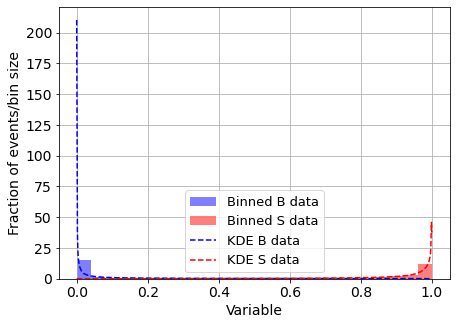

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


  1%|▎                                | 16/2000 [00:20<39:57,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1846709332535581
<p_{s}(Sdata)> = 9.281259719483892
<p_{b}(Bdata)> = 77.7234793127723
<p_{s}(Bdata)> = 0.21221271535408837


  1%|▎                                | 18/2000 [00:22<34:01,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18686811958237476
<p_{s}(Sdata)> = 9.693103928865407
<p_{b}(Bdata)> = 78.35452120549506
<p_{s}(Bdata)> = 0.2116320275302728


  1%|▍                                | 25/2000 [00:30<32:25,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22517122703679762
<p_{s}(Sdata)> = 7.893356602743008
<p_{b}(Bdata)> = 77.64600426629185
<p_{s}(Bdata)> = 0.21411962100503412


  1%|▍                                | 28/2000 [00:33<28:31,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2536504875817203
<p_{s}(Sdata)> = 5.279272599522092
<p_{b}(Bdata)> = 77.99827568452817
<p_{s}(Bdata)> = 0.21275043750154313


  2%|▍                                | 30/2000 [00:35<28:20,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18411963859978928
<p_{s}(Sdata)> = 8.67789749382371
<p_{b}(Bdata)> = 78.25121640617289
<p_{s}(Bdata)> = 0.21229700449974195


  2%|▌                                | 37/2000 [00:44<32:31,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18913728152203965
<p_{s}(Sdata)> = 9.239345632626518
<p_{b}(Bdata)> = 77.91541856392111
<p_{s}(Bdata)> = 0.21462831102622354


  2%|▊                                | 48/2000 [00:55<26:25,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23597934305197932
<p_{s}(Sdata)> = 7.666994672729007
<p_{b}(Bdata)> = 77.91807113705704
<p_{s}(Bdata)> = 0.2146186428429039


  3%|▉                                | 57/2000 [01:06<33:15,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19107036849550815
<p_{s}(Sdata)> = 6.840860823497947
<p_{b}(Bdata)> = 78.24671906904813
<p_{s}(Bdata)> = 0.2173141029762376


  3%|█                                | 67/2000 [01:18<32:33,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40601637014318404
<p_{s}(Sdata)> = 5.876058035885662
<p_{b}(Bdata)> = 77.8661200718307
<p_{s}(Bdata)> = 0.2107020535702684


  4%|█▏                               | 70/2000 [01:20<23:54,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18652936756715213
<p_{s}(Sdata)> = 8.275282111857798
<p_{b}(Bdata)> = 78.1172817581253
<p_{s}(Bdata)> = 0.21006544127981466


  4%|█▎                               | 79/2000 [01:31<33:31,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19288913953495046
<p_{s}(Sdata)> = 7.801258500274622
<p_{b}(Bdata)> = 77.55068541567361
<p_{s}(Bdata)> = 0.21219793064168416


  4%|█▎                               | 80/2000 [01:31<26:46,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1869660551352871
<p_{s}(Sdata)> = 7.51489898807566
<p_{b}(Bdata)> = 78.11695492568454
<p_{s}(Bdata)> = 0.2126721850590689


  4%|█▎                               | 81/2000 [01:31<22:02,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17276652068609893
<p_{s}(Sdata)> = 9.624730045900627
<p_{b}(Bdata)> = 78.01356200893228
<p_{s}(Bdata)> = 0.2108003877315759


  5%|█▌                               | 98/2000 [01:51<26:41,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17100055338345627
<p_{s}(Sdata)> = 10.654508290036212
<p_{b}(Bdata)> = 77.89345526788684
<p_{s}(Bdata)> = 0.21198109963260225


  5%|█▌                              | 100/2000 [01:53<29:22,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21395782417712414
<p_{s}(Sdata)> = 9.636353652818835
<p_{b}(Bdata)> = 77.79958585016186
<p_{s}(Bdata)> = 0.22315096673613735


  5%|█▌                              | 101/2000 [01:53<23:54,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1779910685783978
<p_{s}(Sdata)> = 9.880180766852552
<p_{b}(Bdata)> = 77.50242733079718
<p_{s}(Bdata)> = 0.21044937313940354


  5%|█▋                              | 104/2000 [01:55<21:27,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18769170297571477
<p_{s}(Sdata)> = 6.630131271458508
<p_{b}(Bdata)> = 77.52724854536021
<p_{s}(Bdata)> = 0.21529342449487354


  5%|█▋                              | 109/2000 [01:59<21:12,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17996662229547591
<p_{s}(Sdata)> = 9.768391965033508
<p_{b}(Bdata)> = 78.0517628072046
<p_{s}(Bdata)> = 0.2082450668790599


  6%|█▊                              | 112/2000 [02:02<26:15,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20488863053447814
<p_{s}(Sdata)> = 7.69641944038105
<p_{b}(Bdata)> = 77.80922122531844
<p_{s}(Bdata)> = 0.21411366684383454


  6%|█▉                              | 121/2000 [02:11<30:23,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1612732398770219
<p_{s}(Sdata)> = 11.037202462146706
<p_{b}(Bdata)> = 77.31773114674169
<p_{s}(Bdata)> = 0.20884222180429338


  6%|██                              | 128/2000 [02:20<31:36,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17574371796821656
<p_{s}(Sdata)> = 10.095103920354992
<p_{b}(Bdata)> = 77.79172135873824
<p_{s}(Bdata)> = 0.20913649319028235


  7%|██▎                             | 147/2000 [02:45<35:11,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18520594838022084
<p_{s}(Sdata)> = 7.399786407093138
<p_{b}(Bdata)> = 77.54751291184994
<p_{s}(Bdata)> = 0.21752984421041321


  8%|██▍                             | 151/2000 [02:48<25:56,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23189612523894554
<p_{s}(Sdata)> = 7.982826196268049
<p_{b}(Bdata)> = 77.74058486657887
<p_{s}(Bdata)> = 0.21052574838064453


  8%|██▌                             | 158/2000 [02:58<31:57,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2024720393849488
<p_{s}(Sdata)> = 7.418668638155572
<p_{b}(Bdata)> = 77.49543312755377
<p_{s}(Bdata)> = 0.21359425900035614


  8%|██▌                             | 160/2000 [02:59<28:02,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21294639464114545
<p_{s}(Sdata)> = 6.733868273147402
<p_{b}(Bdata)> = 78.27341738937176
<p_{s}(Bdata)> = 0.2139103105124099


  8%|██▋                             | 167/2000 [03:10<36:11,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18680186134908092
<p_{s}(Sdata)> = 7.380556440810448
<p_{b}(Bdata)> = 77.64581702909318
<p_{s}(Bdata)> = 0.21339211087230417


  9%|██▊                             | 172/2000 [03:17<37:11,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1969705339482939
<p_{s}(Sdata)> = 9.730326085148516
<p_{b}(Bdata)> = 78.06446665191469
<p_{s}(Bdata)> = 0.21109770808841424


  9%|██▊                             | 175/2000 [03:20<28:37,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17494826715714
<p_{s}(Sdata)> = 11.893239419151707
<p_{b}(Bdata)> = 77.90138730767296
<p_{s}(Bdata)> = 0.2073399409178287


  9%|██▊                             | 176/2000 [03:20<23:15,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26820212542970273
<p_{s}(Sdata)> = 9.643762909729361
<p_{b}(Bdata)> = 77.75974145378089
<p_{s}(Bdata)> = 0.21162757054510214


  9%|██▊                             | 179/2000 [03:22<21:10,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21623878091304496
<p_{s}(Sdata)> = 10.140847361462571
<p_{b}(Bdata)> = 77.78231875654913
<p_{s}(Bdata)> = 0.20906007095093587


  9%|██▉                             | 183/2000 [03:27<32:15,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17371139012534742
<p_{s}(Sdata)> = 8.971321848831352
<p_{b}(Bdata)> = 77.54725189318674
<p_{s}(Bdata)> = 0.2163757630728475


  9%|██▉                             | 187/2000 [03:31<24:48,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.209642136737475
<p_{s}(Sdata)> = 7.4249564430778605
<p_{b}(Bdata)> = 78.0156360372701
<p_{s}(Bdata)> = 0.212123225673785


 10%|███                             | 193/2000 [03:38<29:07,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19418691178585057
<p_{s}(Sdata)> = 7.776995802202132
<p_{b}(Bdata)> = 78.34815189559501
<p_{s}(Bdata)> = 0.21279266549093162


 10%|███▏                            | 198/2000 [03:44<30:41,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1937014878433687
<p_{s}(Sdata)> = 7.084986947085046
<p_{b}(Bdata)> = 77.61364292140524
<p_{s}(Bdata)> = 0.2145473542201183


 10%|███▎                            | 210/2000 [03:59<32:50,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19019226695095945
<p_{s}(Sdata)> = 7.271255667135811
<p_{b}(Bdata)> = 77.60350191787988
<p_{s}(Bdata)> = 0.2142876279629457


 11%|███▌                            | 226/2000 [04:17<23:20,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1862577330863974
<p_{s}(Sdata)> = 7.8645521395238385
<p_{b}(Bdata)> = 77.82898758056173
<p_{s}(Bdata)> = 0.20990827669872308


 11%|███▋                            | 228/2000 [04:19<24:26,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19357646779181398
<p_{s}(Sdata)> = 7.547334211214535
<p_{b}(Bdata)> = 77.81869591998819
<p_{s}(Bdata)> = 0.21080580396654017


 12%|███▋                            | 232/2000 [04:23<25:51,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21974890572402364
<p_{s}(Sdata)> = 6.437815570820144
<p_{b}(Bdata)> = 78.04712150498544
<p_{s}(Bdata)> = 0.21636346742863807


 12%|███▉                            | 245/2000 [04:37<25:56,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1834900263346597
<p_{s}(Sdata)> = 10.570615429728749
<p_{b}(Bdata)> = 78.08703116551797
<p_{s}(Bdata)> = 0.21088126168552795


 12%|███▉                            | 246/2000 [04:37<21:10,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1937354416225617
<p_{s}(Sdata)> = 7.6754483275319
<p_{b}(Bdata)> = 77.57285620942964
<p_{s}(Bdata)> = 0.2139995406882338


 13%|████                            | 255/2000 [04:48<27:49,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20327376009349252
<p_{s}(Sdata)> = 8.4095572250605
<p_{b}(Bdata)> = 77.31997187146716
<p_{s}(Bdata)> = 0.21095352796950428


 13%|████▏                           | 261/2000 [04:53<21:47,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2597504200031082
<p_{s}(Sdata)> = 6.685695403980178
<p_{b}(Bdata)> = 77.74150656265032
<p_{s}(Bdata)> = 0.21583323914518798


 13%|████▎                           | 266/2000 [04:58<23:23,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2241207818050402
<p_{s}(Sdata)> = 7.19980677194569
<p_{b}(Bdata)> = 77.80846782840695
<p_{s}(Bdata)> = 0.21433294766253524


 14%|████▎                           | 270/2000 [05:03<27:17,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18350454976875577
<p_{s}(Sdata)> = 9.618700349617225
<p_{b}(Bdata)> = 78.10744891800235
<p_{s}(Bdata)> = 0.2096515177883809


 14%|████▍                           | 274/2000 [05:07<26:02,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1916158007244495
<p_{s}(Sdata)> = 9.09653274685509
<p_{b}(Bdata)> = 77.59893332115232
<p_{s}(Bdata)> = 0.2122027501360351


 15%|████▋                           | 294/2000 [05:33<36:04,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18357493947839384
<p_{s}(Sdata)> = 8.526277731817846
<p_{b}(Bdata)> = 77.82671003168147
<p_{s}(Bdata)> = 0.21120375087509138


 16%|████▉                           | 311/2000 [05:54<28:50,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22897285238810125
<p_{s}(Sdata)> = 7.259140609690329
<p_{b}(Bdata)> = 77.78099568253207
<p_{s}(Bdata)> = 0.21108109778834452


 16%|█████▎                          | 330/2000 [06:21<36:15,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18267159274852443
<p_{s}(Sdata)> = 8.873597328609563
<p_{b}(Bdata)> = 77.96857982705957
<p_{s}(Bdata)> = 0.21411878225169229


 17%|█████▎                          | 333/2000 [06:25<27:31,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1920244737931637
<p_{s}(Sdata)> = 8.162204786515298
<p_{b}(Bdata)> = 78.32600347892694
<p_{s}(Bdata)> = 0.20888732104416824


 17%|█████▍                          | 340/2000 [06:32<22:12,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1933974021657578
<p_{s}(Sdata)> = 10.068079275869316
<p_{b}(Bdata)> = 77.57157681574606
<p_{s}(Bdata)> = 0.20990924285473672


 17%|█████▍                          | 343/2000 [06:35<24:17,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20613912841205612
<p_{s}(Sdata)> = 6.84021403543655
<p_{b}(Bdata)> = 78.26615920009672
<p_{s}(Bdata)> = 0.20994365900038997


 17%|█████▌                          | 348/2000 [06:42<31:14,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20115406146912762
<p_{s}(Sdata)> = 7.341743964420877
<p_{b}(Bdata)> = 77.42102010513166
<p_{s}(Bdata)> = 0.21821315116083662


 18%|█████▌                          | 350/2000 [06:43<22:20,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20270783804862802
<p_{s}(Sdata)> = 6.570633232448542
<p_{b}(Bdata)> = 78.05724197959543
<p_{s}(Bdata)> = 0.21508164718150027


 18%|█████▋                          | 353/2000 [06:47<26:30,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1774506050261666
<p_{s}(Sdata)> = 10.185500743888923
<p_{b}(Bdata)> = 78.22541696883246
<p_{s}(Bdata)> = 0.21176200160253533


 19%|██████                          | 381/2000 [07:22<25:37,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19123730117781432
<p_{s}(Sdata)> = 10.94080730119153
<p_{b}(Bdata)> = 77.41080042475895
<p_{s}(Bdata)> = 0.21310550279205293


 20%|██████▎                         | 393/2000 [07:35<24:15,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22220992977994644
<p_{s}(Sdata)> = 8.586320010551301
<p_{b}(Bdata)> = 77.44912415740684
<p_{s}(Bdata)> = 0.21182365159777714


 20%|██████▎                         | 398/2000 [07:40<25:03,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5082484908181455
<p_{s}(Sdata)> = 9.326750228997735
<p_{b}(Bdata)> = 78.24005888879674
<p_{s}(Bdata)> = 0.21223274083606633


 20%|██████▍                         | 401/2000 [07:45<31:29,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17205564170829946
<p_{s}(Sdata)> = 8.802447486022258
<p_{b}(Bdata)> = 78.07146989943
<p_{s}(Bdata)> = 0.2128289876290784


 20%|██████▍                         | 403/2000 [07:47<26:05,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18872639732416194
<p_{s}(Sdata)> = 7.25610830137845
<p_{b}(Bdata)> = 77.59799648949408
<p_{s}(Bdata)> = 0.20932141929573203


 20%|██████▍                         | 404/2000 [07:47<20:58,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2731897060925372
<p_{s}(Sdata)> = 8.493774021415582
<p_{b}(Bdata)> = 77.80987334131055
<p_{s}(Bdata)> = 0.2168990253191963


 21%|██████▋                         | 419/2000 [08:08<26:19,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19025803861231252
<p_{s}(Sdata)> = 10.15769384776142
<p_{b}(Bdata)> = 77.82681045913735
<p_{s}(Bdata)> = 0.21103076904695953


 22%|██████▉                         | 430/2000 [08:21<26:21,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18549167993119015
<p_{s}(Sdata)> = 9.346508392415494
<p_{b}(Bdata)> = 77.54450899646552
<p_{s}(Bdata)> = 0.21408612296623286


 22%|██████▉                         | 431/2000 [08:21<21:07,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25345451079546627
<p_{s}(Sdata)> = 7.813279324091063
<p_{b}(Bdata)> = 77.6224844347855
<p_{s}(Bdata)> = 0.2145574551574187


 22%|███████                         | 444/2000 [08:38<33:38,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20206365922086075
<p_{s}(Sdata)> = 8.933704361257242
<p_{b}(Bdata)> = 77.51209610490024
<p_{s}(Bdata)> = 0.21213273461897003


 23%|███████▍                        | 461/2000 [09:00<21:45,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2994563511744351
<p_{s}(Sdata)> = 7.79959231725879
<p_{b}(Bdata)> = 77.963035678452
<p_{s}(Bdata)> = 0.21344768988873875


 23%|███████▍                        | 466/2000 [09:05<24:10,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.290555133767505
<p_{s}(Sdata)> = 9.144193219647851
<p_{b}(Bdata)> = 77.73489273226626
<p_{s}(Bdata)> = 0.21017253737647426


 24%|███████▊                        | 488/2000 [09:36<29:20,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1778129047219536
<p_{s}(Sdata)> = 9.309810932962673
<p_{b}(Bdata)> = 77.88074659555842
<p_{s}(Bdata)> = 0.2126652019616676


 24%|███████▊                        | 490/2000 [09:39<28:27,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17630988098930048
<p_{s}(Sdata)> = 10.706669783612744
<p_{b}(Bdata)> = 78.00941472920478
<p_{s}(Bdata)> = 0.21016431024014537


 25%|███████▉                        | 494/2000 [09:42<23:52,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1868940650488958
<p_{s}(Sdata)> = 9.932246306263147
<p_{b}(Bdata)> = 77.63164186114109
<p_{s}(Bdata)> = 0.21237159978206227


 25%|████████                        | 504/2000 [09:53<20:27,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17934933264836933
<p_{s}(Sdata)> = 7.924055373357857
<p_{b}(Bdata)> = 77.6089418661516
<p_{s}(Bdata)> = 0.2125560472758866


 25%|████████                        | 506/2000 [09:54<18:27,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18834614425842322
<p_{s}(Sdata)> = 8.543715886047925
<p_{b}(Bdata)> = 77.27777510690498
<p_{s}(Bdata)> = 0.21602271163343703


 26%|████████▏                       | 510/2000 [09:59<23:53,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32955850760778516
<p_{s}(Sdata)> = 12.137552903949016
<p_{b}(Bdata)> = 77.6681751728742
<p_{s}(Bdata)> = 0.21975767619170525


 26%|████████▎                       | 523/2000 [10:12<20:49,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18793536244004794
<p_{s}(Sdata)> = 7.582705208890185
<p_{b}(Bdata)> = 77.71964816507132
<p_{s}(Bdata)> = 0.2147522418791987


 28%|████████▉                       | 555/2000 [11:00<24:28,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2672859996557518
<p_{s}(Sdata)> = 8.33947724103263
<p_{b}(Bdata)> = 77.48506092129763
<p_{s}(Bdata)> = 0.2140373740719328


 30%|█████████▌                      | 594/2000 [11:49<26:36,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21181846324848522
<p_{s}(Sdata)> = 10.37077511984556
<p_{b}(Bdata)> = 77.91745988764777
<p_{s}(Bdata)> = 0.21264682454323858


 30%|█████████▌                      | 599/2000 [11:55<24:44,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 3.039020739928736
<p_{s}(Sdata)> = 10.046880854898765
<p_{b}(Bdata)> = 78.5275997113974
<p_{s}(Bdata)> = 0.20668086966310545


 30%|█████████▋                      | 603/2000 [11:59<20:42,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19400977677996933
<p_{s}(Sdata)> = 10.004223747824987
<p_{b}(Bdata)> = 78.0442993332477
<p_{s}(Bdata)> = 0.21067450695479256


 30%|█████████▋                      | 607/2000 [12:04<23:51,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21253772075995017
<p_{s}(Sdata)> = 8.412523872537395
<p_{b}(Bdata)> = 78.10521300009897
<p_{s}(Bdata)> = 0.21067291059361223


 31%|██████████                      | 626/2000 [12:32<25:45,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25421611816784545
<p_{s}(Sdata)> = 8.163791960341577
<p_{b}(Bdata)> = 77.93813705417695
<p_{s}(Bdata)> = 0.2108695395740953


 32%|██████████▏                     | 635/2000 [12:42<21:54,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23988770418840796
<p_{s}(Sdata)> = 9.33156070862756
<p_{b}(Bdata)> = 78.03713623641057
<p_{s}(Bdata)> = 0.2131919717027188


 32%|██████████▎                     | 642/2000 [12:50<22:27,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1926464377751112
<p_{s}(Sdata)> = 8.798248543436035
<p_{b}(Bdata)> = 78.34329053651916
<p_{s}(Bdata)> = 0.2104893363237607


 33%|██████████▍                     | 652/2000 [13:05<25:33,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20435073218564345
<p_{s}(Sdata)> = 7.540699688579375
<p_{b}(Bdata)> = 77.39311570564897
<p_{s}(Bdata)> = 0.2135382085624939


 33%|██████████▌                     | 659/2000 [13:14<23:52,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19140836722275406
<p_{s}(Sdata)> = 6.967090838277702
<p_{b}(Bdata)> = 78.02983550923099
<p_{s}(Bdata)> = 0.21382964817534642


 33%|██████████▋                     | 666/2000 [13:23<20:03,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23024436995846456
<p_{s}(Sdata)> = 8.367501462082428
<p_{b}(Bdata)> = 77.74811687635126
<p_{s}(Bdata)> = 0.21260507720514382


 34%|██████████▋                     | 670/2000 [13:25<15:00,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2448218059473547
<p_{s}(Sdata)> = 7.236169602295614
<p_{b}(Bdata)> = 78.07203858334168
<p_{s}(Bdata)> = 0.21187136049435337


 34%|██████████▉                     | 683/2000 [13:41<23:12,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3834806397300404
<p_{s}(Sdata)> = 9.617281404126377
<p_{b}(Bdata)> = 77.95041919313702
<p_{s}(Bdata)> = 0.20772428204920504


 34%|██████████▉                     | 687/2000 [13:44<16:20,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31867212539463674
<p_{s}(Sdata)> = 7.244327669931418
<p_{b}(Bdata)> = 77.83957967273551
<p_{s}(Bdata)> = 0.2120376093834455


 35%|███████████                     | 693/2000 [13:51<20:51,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19265803760054015
<p_{s}(Sdata)> = 9.070942517798345
<p_{b}(Bdata)> = 77.56231334276154
<p_{s}(Bdata)> = 0.21006405474556913


 36%|███████████▍                    | 715/2000 [14:16<23:09,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19236088133633183
<p_{s}(Sdata)> = 6.941131441548655
<p_{b}(Bdata)> = 77.8691136648283
<p_{s}(Bdata)> = 0.2106363004484233


 36%|███████████▌                    | 721/2000 [14:23<17:15,  1.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17505703677115889
<p_{s}(Sdata)> = 14.734684449452208
<p_{b}(Bdata)> = 77.46348420819054
<p_{s}(Bdata)> = 0.22066973090578404


 36%|███████████▌                    | 725/2000 [14:27<19:37,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21561332844638606
<p_{s}(Sdata)> = 6.409102493832405
<p_{b}(Bdata)> = 77.82193716849575
<p_{s}(Bdata)> = 0.21616627718376766


 36%|███████████▋                    | 727/2000 [14:30<22:59,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1834900786214963
<p_{s}(Sdata)> = 11.931803191496572
<p_{b}(Bdata)> = 77.80587188855453
<p_{s}(Bdata)> = 0.2095446252032277


 37%|███████████▋                    | 733/2000 [14:40<29:27,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.33159368606790374
<p_{s}(Sdata)> = 8.354643914836153
<p_{b}(Bdata)> = 77.58438615650012
<p_{s}(Bdata)> = 0.20841637555006007


 37%|███████████▋                    | 734/2000 [14:40<22:48,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18681257157928133
<p_{s}(Sdata)> = 8.241900580450618
<p_{b}(Bdata)> = 77.60568187323142
<p_{s}(Bdata)> = 0.21553905306397278


 37%|███████████▊                    | 741/2000 [14:48<24:19,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18022315298462774
<p_{s}(Sdata)> = 7.8424205418550725
<p_{b}(Bdata)> = 78.49228229361879
<p_{s}(Bdata)> = 0.21204814909500797


 37%|███████████▉                    | 748/2000 [14:57<23:11,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17666813072445992
<p_{s}(Sdata)> = 9.641383358128277
<p_{b}(Bdata)> = 77.74188331259684
<p_{s}(Bdata)> = 0.21289589204221576


 38%|████████████▎                   | 766/2000 [15:22<21:36,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1830435732414653
<p_{s}(Sdata)> = 10.489107762939714
<p_{b}(Bdata)> = 78.0772771407916
<p_{s}(Bdata)> = 0.21618589109099323


 38%|████████████▎                   | 769/2000 [15:26<21:24,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19422484338984883
<p_{s}(Sdata)> = 8.640233065384566
<p_{b}(Bdata)> = 77.51381188080578
<p_{s}(Bdata)> = 0.2131660287545757


 39%|████████████▎                   | 772/2000 [15:28<18:12,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2055375398459812
<p_{s}(Sdata)> = 8.17627113097441
<p_{b}(Bdata)> = 77.73675715028325
<p_{s}(Bdata)> = 0.21047627803641383


 40%|████████████▋                   | 793/2000 [15:56<24:20,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1928796942880895
<p_{s}(Sdata)> = 7.660947401606379
<p_{b}(Bdata)> = 77.9115208877827
<p_{s}(Bdata)> = 0.21166200741871852


 40%|████████████▋                   | 794/2000 [15:57<19:05,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20663271655782228
<p_{s}(Sdata)> = 8.793408940161967
<p_{b}(Bdata)> = 77.46206603905405
<p_{s}(Bdata)> = 0.21155958254372553


 40%|████████████▊                   | 797/2000 [15:59<15:15,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24729166280507084
<p_{s}(Sdata)> = 9.056180635101164
<p_{b}(Bdata)> = 78.32462300197258
<p_{s}(Bdata)> = 0.21374410669690289


 40%|████████████▊                   | 804/2000 [16:09<22:30,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.775830024032988
<p_{s}(Sdata)> = 9.751262837389502
<p_{b}(Bdata)> = 77.83760752720484
<p_{s}(Bdata)> = 0.21355957629725625


 41%|█████████████                   | 816/2000 [16:22<22:04,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21716753120666277
<p_{s}(Sdata)> = 7.826206469447375
<p_{b}(Bdata)> = 77.51013635651526
<p_{s}(Bdata)> = 0.21685092441947595


 41%|█████████████                   | 817/2000 [16:23<17:29,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17406534145157113
<p_{s}(Sdata)> = 10.783242310380402
<p_{b}(Bdata)> = 77.55106171622299
<p_{s}(Bdata)> = 0.2101306909247005


 41%|█████████████                   | 820/2000 [16:26<17:32,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23473836653603034
<p_{s}(Sdata)> = 7.545455054005505
<p_{b}(Bdata)> = 78.27411058221954
<p_{s}(Bdata)> = 0.2132699413638527


 41%|█████████████▏                  | 821/2000 [16:26<14:18,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20147431932632118
<p_{s}(Sdata)> = 6.987119524814255
<p_{b}(Bdata)> = 77.76344719068145
<p_{s}(Bdata)> = 0.21531485746876988


 42%|█████████████▎                  | 830/2000 [16:38<23:09,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20380797039749338
<p_{s}(Sdata)> = 7.2611698015304516
<p_{b}(Bdata)> = 77.89608420473125
<p_{s}(Bdata)> = 0.2121131666074949


 42%|█████████████▍                  | 836/2000 [16:46<22:51,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19697736167315227
<p_{s}(Sdata)> = 7.888910727960883
<p_{b}(Bdata)> = 77.554457241615
<p_{s}(Bdata)> = 0.21025441467271455


 42%|█████████████▌                  | 848/2000 [17:05<22:53,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16624061505514673
<p_{s}(Sdata)> = 11.117245190970014
<p_{b}(Bdata)> = 78.19501418151599
<p_{s}(Bdata)> = 0.21091817753009798


 43%|█████████████▊                  | 860/2000 [17:21<22:41,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19388636891927657
<p_{s}(Sdata)> = 6.989642133871173
<p_{b}(Bdata)> = 77.41471561756757
<p_{s}(Bdata)> = 0.2113297128077922


 43%|█████████████▉                  | 868/2000 [17:31<21:49,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19363681358713739
<p_{s}(Sdata)> = 8.536766249281127
<p_{b}(Bdata)> = 77.76347446143654
<p_{s}(Bdata)> = 0.21197023633301937


 43%|█████████████▉                  | 869/2000 [17:31<17:13,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.206955112122557
<p_{s}(Sdata)> = 6.548414640789644
<p_{b}(Bdata)> = 77.87759506993352
<p_{s}(Bdata)> = 0.2116836388811652


 44%|██████████████                  | 879/2000 [17:44<20:36,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18820973333665028
<p_{s}(Sdata)> = 8.994213256674156
<p_{b}(Bdata)> = 77.85073910307942
<p_{s}(Bdata)> = 0.21355255365075532


 44%|██████████████▏                 | 890/2000 [17:58<18:03,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2398917521955373
<p_{s}(Sdata)> = 10.324214694452778
<p_{b}(Bdata)> = 78.00670193008597
<p_{s}(Bdata)> = 0.2129497774724553


 45%|██████████████▎                 | 894/2000 [18:03<17:50,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17351259575712644
<p_{s}(Sdata)> = 10.43376561071608
<p_{b}(Bdata)> = 78.0400698229232
<p_{s}(Bdata)> = 0.207296482117107


 45%|██████████████▎                 | 895/2000 [18:03<14:24,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2182131709159454
<p_{s}(Sdata)> = 10.684717475287062
<p_{b}(Bdata)> = 77.93081296352393
<p_{s}(Bdata)> = 0.21197318844049517


 45%|██████████████▎                 | 897/2000 [18:04<13:06,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17502977785140567
<p_{s}(Sdata)> = 9.398386154223859
<p_{b}(Bdata)> = 77.77625844419322
<p_{s}(Bdata)> = 0.21324729604132758


 45%|██████████████▍                 | 906/2000 [18:15<20:56,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2628371790894326
<p_{s}(Sdata)> = 9.39983580634168
<p_{b}(Bdata)> = 78.12261954929869
<p_{s}(Bdata)> = 0.21471509242405395


 45%|██████████████▌                 | 907/2000 [18:16<16:31,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1787638663157648
<p_{s}(Sdata)> = 8.856344471270765
<p_{b}(Bdata)> = 77.59485646576539
<p_{s}(Bdata)> = 0.21319567631709874


 46%|██████████████▋                 | 919/2000 [18:32<21:40,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2060601025070664
<p_{s}(Sdata)> = 7.563297682806344
<p_{b}(Bdata)> = 78.2121737018352
<p_{s}(Bdata)> = 0.20972929760798506


 46%|██████████████▊                 | 923/2000 [18:35<15:07,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18725029779453337
<p_{s}(Sdata)> = 8.164740831054395
<p_{b}(Bdata)> = 77.39175657642525
<p_{s}(Bdata)> = 0.21327230292807456


 48%|███████████████▏                | 952/2000 [19:17<18:18,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17236209213692144
<p_{s}(Sdata)> = 10.324841894874499
<p_{b}(Bdata)> = 77.75897634716713
<p_{s}(Bdata)> = 0.21409799917694633


 48%|███████████████▏                | 953/2000 [19:17<14:36,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19761744318389166
<p_{s}(Sdata)> = 9.452007764919626
<p_{b}(Bdata)> = 77.73852495675047
<p_{s}(Bdata)> = 0.2093929063590898


 48%|███████████████▍                | 963/2000 [19:31<18:28,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17639824562094958
<p_{s}(Sdata)> = 8.908346397978535
<p_{b}(Bdata)> = 77.45120145742541
<p_{s}(Bdata)> = 0.21171743229835926


 48%|███████████████▌                | 969/2000 [19:38<16:48,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17230144176113946
<p_{s}(Sdata)> = 12.417659483908027
<p_{b}(Bdata)> = 78.11497701770121
<p_{s}(Bdata)> = 0.20962195351658525


 48%|███████████████▌                | 970/2000 [19:38<13:32,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21779189687879535
<p_{s}(Sdata)> = 9.093379900918949
<p_{b}(Bdata)> = 77.86817845870488
<p_{s}(Bdata)> = 0.21177135380070683


 49%|███████████████▌                | 972/2000 [19:40<10:55,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.211603989773049
<p_{s}(Sdata)> = 8.455928196562144
<p_{b}(Bdata)> = 77.63655465119702
<p_{s}(Bdata)> = 0.2111581100885725


 49%|███████████████▌                | 974/2000 [19:41<10:22,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1866375713038846
<p_{s}(Sdata)> = 9.6456308474585
<p_{b}(Bdata)> = 78.5373225852135
<p_{s}(Bdata)> = 0.21485330825884386


 49%|███████████████▋                | 977/2000 [19:43<11:26,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17813272648465756
<p_{s}(Sdata)> = 10.588081862935041
<p_{b}(Bdata)> = 77.74399179364411
<p_{s}(Bdata)> = 0.21328162332158057


 49%|███████████████▋                | 981/2000 [19:49<17:47,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1974959127055568
<p_{s}(Sdata)> = 6.705024529547161
<p_{b}(Bdata)> = 77.5907139262347
<p_{s}(Bdata)> = 0.2145721767393438


 49%|███████████████▊                | 985/2000 [19:54<18:19,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1845100048214053
<p_{s}(Sdata)> = 8.339462973926905
<p_{b}(Bdata)> = 77.479075797246
<p_{s}(Bdata)> = 0.21324613798120154


 50%|███████████████▌               | 1002/2000 [20:19<17:03,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1870502411426038
<p_{s}(Sdata)> = 8.202049105504823
<p_{b}(Bdata)> = 77.89196774495325
<p_{s}(Bdata)> = 0.21071066890297946


 51%|███████████████▋               | 1011/2000 [20:30<17:21,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20303050152996646
<p_{s}(Sdata)> = 10.113084313467057
<p_{b}(Bdata)> = 78.25170028760921
<p_{s}(Bdata)> = 0.21065189043103622


 52%|███████████████▉               | 1030/2000 [20:55<18:13,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2286680886488563
<p_{s}(Sdata)> = 9.451073324433034
<p_{b}(Bdata)> = 77.76301104272942
<p_{s}(Bdata)> = 0.2123324600922949


 52%|████████████████               | 1033/2000 [20:57<13:38,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16827153078234677
<p_{s}(Sdata)> = 10.555401143663726
<p_{b}(Bdata)> = 77.99002705125568
<p_{s}(Bdata)> = 0.20911165532840756


 53%|████████████████▍              | 1064/2000 [21:36<17:41,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19624910739359303
<p_{s}(Sdata)> = 9.307217640520784
<p_{b}(Bdata)> = 77.74912615743055
<p_{s}(Bdata)> = 0.21561557884049998


 54%|████████████████▌              | 1070/2000 [21:44<16:58,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6332584266015815
<p_{s}(Sdata)> = 6.405231973033161
<p_{b}(Bdata)> = 78.29111058178515
<p_{s}(Bdata)> = 0.21498429066075883


 54%|████████████████▋              | 1076/2000 [21:51<15:24,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19906964951447984
<p_{s}(Sdata)> = 7.910006705172604
<p_{b}(Bdata)> = 77.46364464730273
<p_{s}(Bdata)> = 0.213091985691456


 54%|████████████████▉              | 1089/2000 [22:07<13:48,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1686800838504894
<p_{s}(Sdata)> = 8.974729636634708
<p_{b}(Bdata)> = 77.62115672983666
<p_{s}(Bdata)> = 0.21087532314689614


 55%|█████████████████              | 1100/2000 [22:21<15:48,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23561254872262166
<p_{s}(Sdata)> = 6.9982722054078454
<p_{b}(Bdata)> = 77.79900990242308
<p_{s}(Bdata)> = 0.21374697635777962


 55%|█████████████████▏             | 1105/2000 [22:27<15:34,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19025905057689832
<p_{s}(Sdata)> = 8.550260980341173
<p_{b}(Bdata)> = 77.54635667500001
<p_{s}(Bdata)> = 0.21300174939307726


 56%|█████████████████▏             | 1111/2000 [22:33<12:51,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19955568704656812
<p_{s}(Sdata)> = 8.34072896969094
<p_{b}(Bdata)> = 78.0240092651386
<p_{s}(Bdata)> = 0.21486903305853666


 56%|█████████████████▎             | 1113/2000 [22:36<15:25,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19708259305356807
<p_{s}(Sdata)> = 8.721126733922857
<p_{b}(Bdata)> = 77.80006892381229
<p_{s}(Bdata)> = 0.2145212122356314


 56%|█████████████████▎             | 1115/2000 [22:37<11:19,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 4.0540173972233635
<p_{s}(Sdata)> = 8.405726160510577
<p_{b}(Bdata)> = 77.94612252366453
<p_{s}(Bdata)> = 0.21291572447109916


 56%|█████████████████▎             | 1118/2000 [22:40<13:02,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21954281847781743
<p_{s}(Sdata)> = 8.647402911185404
<p_{b}(Bdata)> = 77.67108150474621
<p_{s}(Bdata)> = 0.21605361931267264


 56%|█████████████████▍             | 1124/2000 [22:47<12:26,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18708936454558703
<p_{s}(Sdata)> = 10.665055139348741
<p_{b}(Bdata)> = 77.7498432463275
<p_{s}(Bdata)> = 0.21137461301202057


 57%|█████████████████▋             | 1144/2000 [23:12<14:32,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22914240569154326
<p_{s}(Sdata)> = 7.785643698320489
<p_{b}(Bdata)> = 78.08362773657747
<p_{s}(Bdata)> = 0.21280843207561945


 58%|█████████████████▉             | 1160/2000 [23:36<13:55,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2624370153669926
<p_{s}(Sdata)> = 7.875057028424855
<p_{b}(Bdata)> = 77.95873608417524
<p_{s}(Bdata)> = 0.21310629753393617


 59%|██████████████████▏            | 1173/2000 [23:50<13:44,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2188418469775408
<p_{s}(Sdata)> = 7.080447928234653
<p_{b}(Bdata)> = 77.46787483098365
<p_{s}(Bdata)> = 0.21223099898450282


 59%|██████████████████▎            | 1185/2000 [24:05<14:21,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2064604184695384
<p_{s}(Sdata)> = 8.187374609076176
<p_{b}(Bdata)> = 77.76024639038678
<p_{s}(Bdata)> = 0.21180961047048377


 59%|██████████████████▍            | 1188/2000 [24:07<12:18,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16512523327791037
<p_{s}(Sdata)> = 12.07134640220757
<p_{b}(Bdata)> = 77.26885584582004
<p_{s}(Bdata)> = 0.21079311591527228


 60%|██████████████████▍            | 1191/2000 [24:11<11:55,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19042175059556354
<p_{s}(Sdata)> = 8.264699545615501
<p_{b}(Bdata)> = 77.49406284451457
<p_{s}(Bdata)> = 0.2138033507199521


 60%|██████████████████▍            | 1193/2000 [24:12<09:59,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17738495455319409
<p_{s}(Sdata)> = 8.589124108948765
<p_{b}(Bdata)> = 77.75283414507435
<p_{s}(Bdata)> = 0.21446625172612302


 60%|██████████████████▌            | 1196/2000 [24:15<10:57,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19587015288889104
<p_{s}(Sdata)> = 11.72032396994738
<p_{b}(Bdata)> = 77.57255336832972
<p_{s}(Bdata)> = 0.21489759883773765


 61%|██████████████████▉            | 1225/2000 [24:56<13:57,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2134729497672661
<p_{s}(Sdata)> = 7.06598910255084
<p_{b}(Bdata)> = 78.04818004615808
<p_{s}(Bdata)> = 0.21075978409020757


 62%|███████████████████▎           | 1246/2000 [25:23<13:31,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17476149488709536
<p_{s}(Sdata)> = 9.635920770059098
<p_{b}(Bdata)> = 78.13121994058315
<p_{s}(Bdata)> = 0.21290336468097443


 63%|███████████████████▍           | 1258/2000 [25:39<14:52,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18064387758900627
<p_{s}(Sdata)> = 8.526920370036255
<p_{b}(Bdata)> = 77.32310471412484
<p_{s}(Bdata)> = 0.2132870809400233


 63%|███████████████████▌           | 1261/2000 [25:42<12:09,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17608675569431223
<p_{s}(Sdata)> = 9.590643608054691
<p_{b}(Bdata)> = 77.58521135467977
<p_{s}(Bdata)> = 0.21321279238112337


 63%|███████████████████▌           | 1264/2000 [25:44<09:20,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17511703310172658
<p_{s}(Sdata)> = 9.747926944634552
<p_{b}(Bdata)> = 78.12191204569575
<p_{s}(Bdata)> = 0.21206965990024948


 63%|███████████████████▌           | 1266/2000 [25:46<10:28,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8749692432547447
<p_{s}(Sdata)> = 9.810910327456801
<p_{b}(Bdata)> = 78.17621738071307
<p_{s}(Bdata)> = 0.21088784011394662


 65%|████████████████████           | 1295/2000 [26:24<13:23,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22544741884184685
<p_{s}(Sdata)> = 5.972843907233816
<p_{b}(Bdata)> = 77.77413708302693
<p_{s}(Bdata)> = 0.2131957242610365


 65%|████████████████████           | 1297/2000 [26:25<11:32,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22203987962457675
<p_{s}(Sdata)> = 7.823000969482746
<p_{b}(Bdata)> = 77.9887760416414
<p_{s}(Bdata)> = 0.2090790971778541


 65%|████████████████████▏          | 1301/2000 [26:29<09:12,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2759554774231898
<p_{s}(Sdata)> = 7.744743905023771
<p_{b}(Bdata)> = 78.18031261969604
<p_{s}(Bdata)> = 0.21169774514579864


 65%|████████████████████▏          | 1303/2000 [26:31<09:26,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1799717976888512
<p_{s}(Sdata)> = 11.155687671790336
<p_{b}(Bdata)> = 77.91499505087188
<p_{s}(Bdata)> = 0.2091143551297241


 66%|████████████████████▎          | 1313/2000 [26:46<15:50,  1.38s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17314789577579526
<p_{s}(Sdata)> = 9.185106594302837
<p_{b}(Bdata)> = 78.08414876141578
<p_{s}(Bdata)> = 0.21372009339320067


 66%|████████████████████▎          | 1314/2000 [26:46<12:14,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23640848333930145
<p_{s}(Sdata)> = 6.434392611473698
<p_{b}(Bdata)> = 78.30303839150642
<p_{s}(Bdata)> = 0.21189731211201365


 67%|████████████████████▋          | 1332/2000 [27:08<09:17,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22680890466499842
<p_{s}(Sdata)> = 9.060985193615185
<p_{b}(Bdata)> = 77.65348028590432
<p_{s}(Bdata)> = 0.2117823231532603


 67%|████████████████████▋          | 1337/2000 [27:14<09:34,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4173765840892411
<p_{s}(Sdata)> = 8.29257743341303
<p_{b}(Bdata)> = 77.85548955635205
<p_{s}(Bdata)> = 0.20987207077017622


 67%|████████████████████▊          | 1342/2000 [27:19<09:19,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2898585173689223
<p_{s}(Sdata)> = 5.463109526607483
<p_{b}(Bdata)> = 77.65771060284115
<p_{s}(Bdata)> = 0.2143525750530448


 68%|████████████████████▉          | 1354/2000 [27:33<08:53,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17521967166359595
<p_{s}(Sdata)> = 8.80837966753727
<p_{b}(Bdata)> = 78.19037106107677
<p_{s}(Bdata)> = 0.21110616822162273


 68%|█████████████████████          | 1357/2000 [27:37<08:57,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21552416716698347
<p_{s}(Sdata)> = 8.611937934030383
<p_{b}(Bdata)> = 77.79868333934418
<p_{s}(Bdata)> = 0.21209901903772344


 69%|█████████████████████▎         | 1371/2000 [27:56<11:50,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24466843001274877
<p_{s}(Sdata)> = 6.591286921050509
<p_{b}(Bdata)> = 78.0310551413568
<p_{s}(Bdata)> = 0.21070744216362122


 69%|█████████████████████▎         | 1374/2000 [27:58<08:54,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1941898724431778
<p_{s}(Sdata)> = 7.279337218345812
<p_{b}(Bdata)> = 78.08465707491438
<p_{s}(Bdata)> = 0.21340872673528796


 69%|█████████████████████▍         | 1383/2000 [28:10<10:24,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17294163654335704
<p_{s}(Sdata)> = 11.363007719367475
<p_{b}(Bdata)> = 78.08457867301446
<p_{s}(Bdata)> = 0.20800946589968788


 70%|█████████████████████▌         | 1395/2000 [28:26<11:20,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19757145553970828
<p_{s}(Sdata)> = 7.828558596785734
<p_{b}(Bdata)> = 78.25566631212043
<p_{s}(Bdata)> = 0.2135223954489291


 70%|█████████████████████▋         | 1397/2000 [28:28<09:18,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19386029598714463
<p_{s}(Sdata)> = 6.760443733170905
<p_{b}(Bdata)> = 77.55179323144465
<p_{s}(Bdata)> = 0.2139999643248716


 70%|█████████████████████▋         | 1402/2000 [28:33<09:17,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2929248560178331
<p_{s}(Sdata)> = 7.834102825054064
<p_{b}(Bdata)> = 77.96237270139308
<p_{s}(Bdata)> = 0.21445887369468258


 70%|█████████████████████▋         | 1403/2000 [28:33<07:32,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19112606231459314
<p_{s}(Sdata)> = 9.972438313813825
<p_{b}(Bdata)> = 77.78362326690652
<p_{s}(Bdata)> = 0.21302456029549574


 72%|██████████████████████▍        | 1446/2000 [29:28<09:03,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18613782452782673
<p_{s}(Sdata)> = 8.655265436254066
<p_{b}(Bdata)> = 77.5822136463354
<p_{s}(Bdata)> = 0.2119691419729083


 72%|██████████████████████▍        | 1447/2000 [29:28<07:16,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18469048318777312
<p_{s}(Sdata)> = 8.777657656549048
<p_{b}(Bdata)> = 77.49179273053275
<p_{s}(Bdata)> = 0.21015935493357935


 73%|██████████████████████▍        | 1451/2000 [29:32<08:31,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22861651993390747
<p_{s}(Sdata)> = 8.20894165083385
<p_{b}(Bdata)> = 77.92020497420503
<p_{s}(Bdata)> = 0.21033077707292439


 73%|██████████████████████▌        | 1455/2000 [29:37<09:36,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1910359448061677
<p_{s}(Sdata)> = 8.210585607822889
<p_{b}(Bdata)> = 77.71416170159819
<p_{s}(Bdata)> = 0.2108512873229107


 73%|██████████████████████▋        | 1466/2000 [29:51<09:26,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17575342837360333
<p_{s}(Sdata)> = 8.877252592107862
<p_{b}(Bdata)> = 77.87176454923825
<p_{s}(Bdata)> = 0.2136694957746017


 74%|██████████████████████▊        | 1470/2000 [29:56<08:50,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19055820680017416
<p_{s}(Sdata)> = 8.727185202325163
<p_{b}(Bdata)> = 78.07494717722945
<p_{s}(Bdata)> = 0.21086539042044214


 74%|██████████████████████▊        | 1472/2000 [29:57<06:53,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2030818185795722
<p_{s}(Sdata)> = 8.683342851146676
<p_{b}(Bdata)> = 78.08907636745478
<p_{s}(Bdata)> = 0.2117684172201085


 74%|██████████████████████▊        | 1473/2000 [29:57<05:42,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21908227348416698
<p_{s}(Sdata)> = 5.635372683947263
<p_{b}(Bdata)> = 78.27336382007492
<p_{s}(Bdata)> = 0.21469541933765451


 74%|██████████████████████▊        | 1474/2000 [29:58<04:53,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26750583760341645
<p_{s}(Sdata)> = 7.946316279594696
<p_{b}(Bdata)> = 77.62667893931628
<p_{s}(Bdata)> = 0.2130713704803114


 74%|██████████████████████▊        | 1475/2000 [29:58<04:19,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20254549340470038
<p_{s}(Sdata)> = 8.784780821182894
<p_{b}(Bdata)> = 77.78854374222617
<p_{s}(Bdata)> = 0.21261951636005355


 75%|███████████████████████▏       | 1494/2000 [30:20<08:17,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2250699757191089
<p_{s}(Sdata)> = 7.225579302172015
<p_{b}(Bdata)> = 77.65449467418487
<p_{s}(Bdata)> = 0.21743511291771017


 76%|███████████████████████▍       | 1510/2000 [30:41<08:32,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19840592318260553
<p_{s}(Sdata)> = 9.402059490014913
<p_{b}(Bdata)> = 78.09029101900823
<p_{s}(Bdata)> = 0.21032727269243254


 76%|███████████████████████▌       | 1523/2000 [31:00<10:35,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18923809959109014
<p_{s}(Sdata)> = 9.812509199100823
<p_{b}(Bdata)> = 77.81408725606117
<p_{s}(Bdata)> = 0.2141149337490415


 78%|████████████████████████       | 1552/2000 [31:37<07:54,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17283930993226063
<p_{s}(Sdata)> = 10.056734604263411
<p_{b}(Bdata)> = 77.48108707112381
<p_{s}(Bdata)> = 0.2122845851852391


 78%|████████████████████████       | 1553/2000 [31:38<06:20,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.204789214147823
<p_{s}(Sdata)> = 9.663318728598817
<p_{b}(Bdata)> = 77.47531749347272
<p_{s}(Bdata)> = 0.21046951722964496


 78%|████████████████████████▎      | 1566/2000 [31:56<09:37,  1.33s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23047628424257008
<p_{s}(Sdata)> = 10.606269055335149
<p_{b}(Bdata)> = 77.91542499163116
<p_{s}(Bdata)> = 0.20879389515505767


 78%|████████████████████████▎      | 1569/2000 [31:59<07:13,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18409744970365732
<p_{s}(Sdata)> = 8.040928040030225
<p_{b}(Bdata)> = 77.93297257919723
<p_{s}(Bdata)> = 0.2152623630887971


 79%|████████████████████████▎      | 1572/2000 [32:02<06:43,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1615549495047859
<p_{s}(Sdata)> = 11.124385042748758
<p_{b}(Bdata)> = 78.1814961385238
<p_{s}(Bdata)> = 0.2095846820932016


 79%|████████████████████████▍      | 1579/2000 [32:11<07:58,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23789655917794358
<p_{s}(Sdata)> = 7.857088959932541
<p_{b}(Bdata)> = 77.61186936117686
<p_{s}(Bdata)> = 0.21463867991556118


 79%|████████████████████████▌      | 1583/2000 [32:16<07:24,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19676146645072892
<p_{s}(Sdata)> = 8.868186553708309
<p_{b}(Bdata)> = 77.6414120066071
<p_{s}(Bdata)> = 0.21274701592170875


 80%|████████████████████████▋      | 1591/2000 [32:24<06:17,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32139261284172654
<p_{s}(Sdata)> = 9.042899216802777
<p_{b}(Bdata)> = 77.39093044301892
<p_{s}(Bdata)> = 0.21373956072873956


 80%|████████████████████████▋      | 1592/2000 [32:24<05:05,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1734829568837974
<p_{s}(Sdata)> = 9.469292187384992
<p_{b}(Bdata)> = 77.59377768999511
<p_{s}(Bdata)> = 0.21387272524168538


 80%|████████████████████████▋      | 1596/2000 [32:28<05:11,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22976362217517182
<p_{s}(Sdata)> = 7.910719035518686
<p_{b}(Bdata)> = 77.65251669932739
<p_{s}(Bdata)> = 0.2149009385520812


 80%|████████████████████████▊      | 1600/2000 [32:33<06:56,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1829172800690288
<p_{s}(Sdata)> = 9.063942122202064
<p_{b}(Bdata)> = 77.46036520329358
<p_{s}(Bdata)> = 0.2153646954537358


 81%|█████████████████████████▏     | 1628/2000 [33:06<05:59,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20431894616088503
<p_{s}(Sdata)> = 7.585130618598376
<p_{b}(Bdata)> = 77.815581286177
<p_{s}(Bdata)> = 0.21324214241910502


 82%|█████████████████████████▎     | 1634/2000 [33:12<05:48,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19350990658900982
<p_{s}(Sdata)> = 7.607964433622487
<p_{b}(Bdata)> = 78.01999042107406
<p_{s}(Bdata)> = 0.2133012872129065


 82%|█████████████████████████▍     | 1645/2000 [33:26<06:06,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21480152149243326
<p_{s}(Sdata)> = 8.071665878818472
<p_{b}(Bdata)> = 77.86242606307752
<p_{s}(Bdata)> = 0.2117046711647811


 82%|█████████████████████████▌     | 1647/2000 [33:28<05:28,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.209754356275236
<p_{s}(Sdata)> = 7.930201524293941
<p_{b}(Bdata)> = 77.74339260220906
<p_{s}(Bdata)> = 0.2118436985991936


 83%|█████████████████████████▋     | 1655/2000 [33:38<06:08,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1736061473830918
<p_{s}(Sdata)> = 11.832919625840152
<p_{b}(Bdata)> = 77.84805714681333
<p_{s}(Bdata)> = 0.22083096457163962


 83%|█████████████████████████▊     | 1668/2000 [33:56<06:21,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1735373136410783
<p_{s}(Sdata)> = 9.500595343440134
<p_{b}(Bdata)> = 77.50721348207591
<p_{s}(Bdata)> = 0.21075256089224587


 84%|█████████████████████████▉     | 1671/2000 [34:00<06:15,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24830592500112905
<p_{s}(Sdata)> = 8.747195101734263
<p_{b}(Bdata)> = 78.26667920215137
<p_{s}(Bdata)> = 0.20896407593958893


 84%|█████████████████████████▉     | 1676/2000 [34:06<05:55,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22625862700242372
<p_{s}(Sdata)> = 6.775087608286158
<p_{b}(Bdata)> = 77.75527196455579
<p_{s}(Bdata)> = 0.21104864621736355


 84%|██████████████████████████     | 1680/2000 [34:10<04:59,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21120898282147146
<p_{s}(Sdata)> = 8.579604384580932
<p_{b}(Bdata)> = 77.33575839908792
<p_{s}(Bdata)> = 0.21132313347280332


 84%|██████████████████████████▏    | 1687/2000 [34:19<05:06,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2287820374840359
<p_{s}(Sdata)> = 7.663748236843722
<p_{b}(Bdata)> = 78.10363163323512
<p_{s}(Bdata)> = 0.21557388726316665


 84%|██████████████████████████▏    | 1688/2000 [34:19<04:06,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1891798281324061
<p_{s}(Sdata)> = 7.124743870680891
<p_{b}(Bdata)> = 77.6828401204209
<p_{s}(Bdata)> = 0.2136692258803562


 85%|██████████████████████████▎    | 1696/2000 [34:29<05:47,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18248289218500574
<p_{s}(Sdata)> = 8.557730767594384
<p_{b}(Bdata)> = 77.43400462790093
<p_{s}(Bdata)> = 0.21200880203824035


 86%|██████████████████████████▋    | 1722/2000 [35:03<04:43,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39441028928679095
<p_{s}(Sdata)> = 8.505825057668734
<p_{b}(Bdata)> = 77.5522843187406
<p_{s}(Bdata)> = 0.2120154180450362


 86%|██████████████████████████▋    | 1724/2000 [35:05<04:18,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34001997198897965
<p_{s}(Sdata)> = 9.12576587414385
<p_{b}(Bdata)> = 78.36368326162997
<p_{s}(Bdata)> = 0.21011318754995922


 86%|██████████████████████████▋    | 1725/2000 [35:05<03:29,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1920200602705072
<p_{s}(Sdata)> = 8.689818191738366
<p_{b}(Bdata)> = 77.59011468271574
<p_{s}(Bdata)> = 0.21410318478456705


 87%|██████████████████████████▉    | 1735/2000 [35:21<04:34,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18226378508134503
<p_{s}(Sdata)> = 9.005737893073483
<p_{b}(Bdata)> = 78.08727673676421
<p_{s}(Bdata)> = 0.20820990489665175


 87%|██████████████████████████▉    | 1736/2000 [35:21<03:38,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20284227252265377
<p_{s}(Sdata)> = 8.411251553580202
<p_{b}(Bdata)> = 77.37869283221788
<p_{s}(Bdata)> = 0.21114843842788258


 87%|██████████████████████████▉    | 1741/2000 [35:27<03:36,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2509882055636915
<p_{s}(Sdata)> = 6.608219958965597
<p_{b}(Bdata)> = 77.82716768093786
<p_{s}(Bdata)> = 0.21524395422510273


 87%|███████████████████████████    | 1748/2000 [35:35<03:46,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19419557845325577
<p_{s}(Sdata)> = 11.52910925510784
<p_{b}(Bdata)> = 77.40447603467831
<p_{s}(Bdata)> = 0.21097330366878997


 88%|███████████████████████████▏   | 1754/2000 [35:42<03:42,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19044038827015913
<p_{s}(Sdata)> = 8.766228639806187
<p_{b}(Bdata)> = 77.9420596432572
<p_{s}(Bdata)> = 0.21110458536720425


 88%|███████████████████████████▏   | 1755/2000 [35:42<03:00,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19214830524552132
<p_{s}(Sdata)> = 9.259225755639944
<p_{b}(Bdata)> = 77.8296033953712
<p_{s}(Bdata)> = 0.21265864801236975


 88%|███████████████████████████▍   | 1770/2000 [36:02<03:56,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16273183971487984
<p_{s}(Sdata)> = 13.658863356714523
<p_{b}(Bdata)> = 76.98935505991889
<p_{s}(Bdata)> = 0.22042652836012064


 89%|███████████████████████████▋   | 1789/2000 [36:26<03:15,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1676035017034164
<p_{s}(Sdata)> = 11.518474546757757
<p_{b}(Bdata)> = 77.93973549194425
<p_{s}(Bdata)> = 0.2134470261049512


 90%|███████████████████████████▊   | 1796/2000 [36:34<03:25,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.206096505230605
<p_{s}(Sdata)> = 9.045111359478017
<p_{b}(Bdata)> = 77.39873421643081
<p_{s}(Bdata)> = 0.21042372316351526


 90%|███████████████████████████▊   | 1797/2000 [36:34<02:44,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1998031234898568
<p_{s}(Sdata)> = 11.655627536390643
<p_{b}(Bdata)> = 77.54613806581882
<p_{s}(Bdata)> = 0.20879273973947593


 90%|████████████████████████████   | 1809/2000 [36:51<03:44,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.167452525362188
<p_{s}(Sdata)> = 14.347519174324187
<p_{b}(Bdata)> = 77.19109465831022
<p_{s}(Bdata)> = 0.22031931581744843


 91%|████████████████████████████   | 1814/2000 [36:59<03:56,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26224231140643706
<p_{s}(Sdata)> = 8.06645941822187
<p_{b}(Bdata)> = 77.80235084159997
<p_{s}(Bdata)> = 0.21517725349120675


 91%|████████████████████████████▏  | 1817/2000 [37:01<02:59,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17546205255607197
<p_{s}(Sdata)> = 8.657985917191137
<p_{b}(Bdata)> = 77.91228560660394
<p_{s}(Bdata)> = 0.21281520422415273


 91%|████████████████████████████▏  | 1821/2000 [37:06<02:51,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.154917473581987
<p_{s}(Sdata)> = 11.830846088400843
<p_{b}(Bdata)> = 77.823868368568
<p_{s}(Bdata)> = 0.21398088575108073


 91%|████████████████████████████▎  | 1829/2000 [37:14<02:35,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21235001278397792
<p_{s}(Sdata)> = 10.130918935428893
<p_{b}(Bdata)> = 78.57435545834875
<p_{s}(Bdata)> = 0.2084449725821375


 92%|████████████████████████████▍  | 1835/2000 [37:21<03:09,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23799460799431155
<p_{s}(Sdata)> = 8.28216224504842
<p_{b}(Bdata)> = 77.6742941817412
<p_{s}(Bdata)> = 0.21080881382622133


 92%|████████████████████████████▍  | 1838/2000 [37:24<02:30,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17129499396591147
<p_{s}(Sdata)> = 10.791901353723588
<p_{b}(Bdata)> = 77.56164523745309
<p_{s}(Bdata)> = 0.21120481305302036


 92%|████████████████████████████▌  | 1843/2000 [37:29<02:32,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17797318429902356
<p_{s}(Sdata)> = 8.914672663559568
<p_{b}(Bdata)> = 78.09858858858027
<p_{s}(Bdata)> = 0.2118288307007546


 92%|████████████████████████████▋  | 1847/2000 [37:34<02:34,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19207644290463483
<p_{s}(Sdata)> = 7.415772851682344
<p_{b}(Bdata)> = 77.66587460122717
<p_{s}(Bdata)> = 0.21342093463536319


 92%|████████████████████████████▋  | 1848/2000 [37:34<02:09,  1.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18545739459086194
<p_{s}(Sdata)> = 10.339752330028285
<p_{b}(Bdata)> = 77.8486498594092
<p_{s}(Bdata)> = 0.2222561188267608


 95%|█████████████████████████████▎ | 1892/2000 [38:28<01:49,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1898686449475903
<p_{s}(Sdata)> = 8.265027239317432
<p_{b}(Bdata)> = 77.7697571423653
<p_{s}(Bdata)> = 0.21485686674988624


 95%|█████████████████████████████▍ | 1896/2000 [38:32<01:45,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.35215169513158323
<p_{s}(Sdata)> = 7.670841418087202
<p_{b}(Bdata)> = 78.07303057285733
<p_{s}(Bdata)> = 0.21350409564745854


 96%|█████████████████████████████▌ | 1910/2000 [38:52<01:40,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21843219426874302
<p_{s}(Sdata)> = 8.103877910293837
<p_{b}(Bdata)> = 77.71929544821845
<p_{s}(Bdata)> = 0.21380570210141864


 96%|█████████████████████████████▋ | 1912/2000 [38:53<01:11,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21006615530143233
<p_{s}(Sdata)> = 9.374678424948037
<p_{b}(Bdata)> = 77.90905544890288
<p_{s}(Bdata)> = 0.2109338591633937


 96%|█████████████████████████████▊ | 1924/2000 [39:07<01:00,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2088648802655317
<p_{s}(Sdata)> = 7.462615239287743
<p_{b}(Bdata)> = 77.30201802792783
<p_{s}(Bdata)> = 0.2138213624860985


 97%|█████████████████████████████▉ | 1931/2000 [39:17<01:26,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19235380101155236
<p_{s}(Sdata)> = 7.870154330523465
<p_{b}(Bdata)> = 77.80382056506024
<p_{s}(Bdata)> = 0.2108824766067782


 97%|█████████████████████████████▉ | 1933/2000 [39:19<01:05,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18541335380560867
<p_{s}(Sdata)> = 9.298498680327201
<p_{b}(Bdata)> = 77.86629179112445
<p_{s}(Bdata)> = 0.2110119555795161


 97%|█████████████████████████████▉ | 1934/2000 [39:19<00:52,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22276029752069273
<p_{s}(Sdata)> = 6.379990411546564
<p_{b}(Bdata)> = 77.93948699323289
<p_{s}(Bdata)> = 0.21729171984890605


 97%|██████████████████████████████▏| 1948/2000 [39:34<00:45,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19292293004639308
<p_{s}(Sdata)> = 7.981642929014222
<p_{b}(Bdata)> = 77.9112214320137
<p_{s}(Bdata)> = 0.2110839722843104


 98%|██████████████████████████████▍| 1965/2000 [39:55<00:37,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1713450628453179
<p_{s}(Sdata)> = 10.734371675731895
<p_{b}(Bdata)> = 77.21832527970302
<p_{s}(Bdata)> = 0.21174345924522944


 98%|██████████████████████████████▍| 1966/2000 [39:55<00:29,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23950456088715558
<p_{s}(Sdata)> = 8.788686220595185
<p_{b}(Bdata)> = 78.07520403865078
<p_{s}(Bdata)> = 0.20974097173333028


 99%|██████████████████████████████▋| 1976/2000 [40:09<00:26,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22298067896751458
<p_{s}(Sdata)> = 6.549939981556497
<p_{b}(Bdata)> = 78.20354221717777
<p_{s}(Bdata)> = 0.2101422451349363


 99%|██████████████████████████████▊| 1984/2000 [40:19<00:19,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18288107150028912
<p_{s}(Sdata)> = 11.062278777977589
<p_{b}(Bdata)> = 77.96976524970215
<p_{s}(Bdata)> = 0.21201543488026728


100%|██████████████████████████████▊| 1991/2000 [40:26<00:08,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19559587277261914
<p_{s}(Sdata)> = 9.145219254561745
<p_{b}(Bdata)> = 77.8609681581237
<p_{s}(Bdata)> = 0.21172383749420548


100%|██████████████████████████████▉| 1993/2000 [40:28<00:05,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33945159707375533
<p_{s}(Sdata)> = 11.039207274457516
<p_{b}(Bdata)> = 77.36615869457043
<p_{s}(Bdata)> = 0.2136012656999277


100%|██████████████████████████████▉| 1998/2000 [40:34<00:02,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19650171003120528
<p_{s}(Sdata)> = 7.90296684012284
<p_{b}(Bdata)> = 77.40436525653465
<p_{s}(Bdata)> = 0.21411676821502723


100%|███████████████████████████████| 2000/2000 [40:37<00:00,  1.22s/it]


Z:1.1767726879226594
Z_std:1.257551183835334
Z_1:0.743185321292746
Z_std_1:2.8574230700980774
5
AUC:0.9694300424216441


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 21437.19835692 20295.42620868
 19023.99831598 17643.24058563 16099.56454559 14427.04023893
 12584.47641124 10580.51097413  8424.33433422  6089.66473694
  3568.47549651   850.87285975 -2033.68456006 -5069.64884375]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12790.86970543 12653.79806845 12450.86870752


<Figure size 432x288 with 0 Axes>

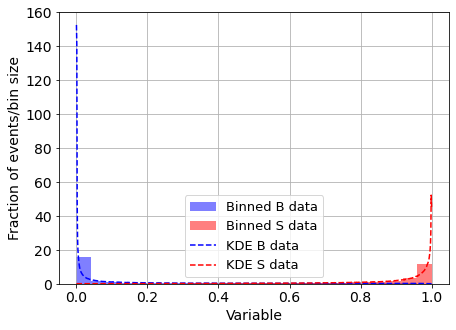

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                  | 2/2000 [00:01<16:49,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.197508390823966
<p_{s}(Sdata)> = 11.425459997669638
<p_{b}(Bdata)> = 61.02676812626447
<p_{s}(Bdata)> = 0.2148899977259534


  0%|                                  | 3/2000 [00:01<14:26,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1815220753351161
<p_{s}(Sdata)> = 11.35863454566666
<p_{b}(Bdata)> = 60.729542591179936
<p_{s}(Bdata)> = 0.2167041052174767


  0%|                                  | 6/2000 [00:03<19:06,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2176641820778229
<p_{s}(Sdata)> = 12.70985850474683
<p_{b}(Bdata)> = 60.93268081969572
<p_{s}(Bdata)> = 0.215916599987605


  0%|▏                                 | 8/2000 [00:04<17:54,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19411400731985587
<p_{s}(Sdata)> = 11.133127378526886
<p_{b}(Bdata)> = 60.92585988366427
<p_{s}(Bdata)> = 0.21271649455392372


  0%|▏                                | 10/2000 [00:06<21:24,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18400948590013833
<p_{s}(Sdata)> = 10.757112622918475
<p_{b}(Bdata)> = 61.00822102297386
<p_{s}(Bdata)> = 0.21735107728874128


  1%|▏                                | 11/2000 [00:06<18:23,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20483259815981908
<p_{s}(Sdata)> = 8.885188077237743
<p_{b}(Bdata)> = 60.895148131615635
<p_{s}(Bdata)> = 0.2159809519150214


  1%|▎                                | 17/2000 [00:11<23:04,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19643266955689045
<p_{s}(Sdata)> = 10.762045564348881
<p_{b}(Bdata)> = 61.33079198470631
<p_{s}(Bdata)> = 0.21466750678983082


  1%|▎                                | 19/2000 [00:13<25:04,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20556413622854058
<p_{s}(Sdata)> = 8.454414941267137
<p_{b}(Bdata)> = 60.79322283699609
<p_{s}(Bdata)> = 0.2174438178185195


  1%|▍                                | 23/2000 [00:17<29:30,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19685858314738133
<p_{s}(Sdata)> = 8.349414864272863
<p_{b}(Bdata)> = 60.794453292990774
<p_{s}(Bdata)> = 0.21601413096968156


  1%|▍                                | 24/2000 [00:17<24:04,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23594311219885303
<p_{s}(Sdata)> = 7.037223551768136
<p_{b}(Bdata)> = 61.109830126159814
<p_{s}(Bdata)> = 0.2131236549891757


  1%|▍                                | 25/2000 [00:17<20:17,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1895945816920415
<p_{s}(Sdata)> = 10.418314041268271
<p_{b}(Bdata)> = 61.50115400097738
<p_{s}(Bdata)> = 0.21126763938448434


  1%|▍                                | 29/2000 [00:20<20:35,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20048560764148124
<p_{s}(Sdata)> = 11.262903858094203
<p_{b}(Bdata)> = 61.26325387588859
<p_{s}(Bdata)> = 0.21093666910908132


  2%|▍                                | 30/2000 [00:21<17:58,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1924947961101152
<p_{s}(Sdata)> = 11.054612322351728
<p_{b}(Bdata)> = 61.00225071140455
<p_{s}(Bdata)> = 0.21467515028914283


  2%|▌                                | 31/2000 [00:21<16:01,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2414310765791846
<p_{s}(Sdata)> = 7.378839356998567
<p_{b}(Bdata)> = 60.905206748226426
<p_{s}(Bdata)> = 0.21527878852308283


  2%|▌                                | 33/2000 [00:22<15:35,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3486045166398736
<p_{s}(Sdata)> = 8.730897470010733
<p_{b}(Bdata)> = 61.256095451109545
<p_{s}(Bdata)> = 0.2099221727782659


  2%|▌                                | 34/2000 [00:22<14:17,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1849737200819638
<p_{s}(Sdata)> = 8.809272386559217
<p_{b}(Bdata)> = 61.04052681942198
<p_{s}(Bdata)> = 0.21609260507051187


  2%|▌                                | 35/2000 [00:23<13:23,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20380814359704622
<p_{s}(Sdata)> = 8.34241531264654
<p_{b}(Bdata)> = 61.16238070940778
<p_{s}(Bdata)> = 0.21478716322131183


  2%|▌                                | 36/2000 [00:23<12:47,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18110060352471086
<p_{s}(Sdata)> = 11.26143383138046
<p_{b}(Bdata)> = 60.471277991696816
<p_{s}(Bdata)> = 0.21777715116706323


  2%|▌                                | 37/2000 [00:23<12:23,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19638535554114797
<p_{s}(Sdata)> = 9.030642706494856
<p_{b}(Bdata)> = 60.78225396970384
<p_{s}(Bdata)> = 0.2168661875868357


  2%|▋                                | 40/2000 [00:25<17:57,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18609567005813274
<p_{s}(Sdata)> = 10.808888224113005
<p_{b}(Bdata)> = 61.007690129372634
<p_{s}(Bdata)> = 0.21276287471308028


  2%|▋                                | 41/2000 [00:26<15:58,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20732143868465047
<p_{s}(Sdata)> = 9.391371720080583
<p_{b}(Bdata)> = 61.32114521498218
<p_{s}(Bdata)> = 0.21258492243668287


  2%|▋                                | 42/2000 [00:26<14:34,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19394077819623165
<p_{s}(Sdata)> = 10.01702616864295
<p_{b}(Bdata)> = 61.17777126124629
<p_{s}(Bdata)> = 0.21198096679729134


  2%|▋                                | 43/2000 [00:26<13:35,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21603446087262784
<p_{s}(Sdata)> = 7.509153677049532
<p_{b}(Bdata)> = 61.21153083588576
<p_{s}(Bdata)> = 0.21410868532165023


  2%|▊                                | 49/2000 [00:32<23:45,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20525178455726303
<p_{s}(Sdata)> = 8.84245807488036
<p_{b}(Bdata)> = 61.26752997483413
<p_{s}(Bdata)> = 0.2133103869894766


  2%|▊                                | 50/2000 [00:32<20:01,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1830883411327715
<p_{s}(Sdata)> = 10.02570210232393
<p_{b}(Bdata)> = 61.14880484124205
<p_{s}(Bdata)> = 0.21671486346889268


  3%|▊                                | 52/2000 [00:34<21:46,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20823807800220026
<p_{s}(Sdata)> = 8.874024706165226
<p_{b}(Bdata)> = 61.03727109264997
<p_{s}(Bdata)> = 0.214629130145354


  3%|▉                                | 55/2000 [00:35<19:39,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23933611519101297
<p_{s}(Sdata)> = 10.803675241205557
<p_{b}(Bdata)> = 60.832638325804645
<p_{s}(Bdata)> = 0.2171087093958306


  3%|▉                                | 58/2000 [00:38<22:02,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22963927239975496
<p_{s}(Sdata)> = 6.545435936422109
<p_{b}(Bdata)> = 60.79162763806587
<p_{s}(Bdata)> = 0.21803307921631992


  3%|▉                                | 60/2000 [00:39<21:03,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3068091553627062
<p_{s}(Sdata)> = 8.578362198566573
<p_{b}(Bdata)> = 61.119075523558045
<p_{s}(Bdata)> = 0.2159447339887593


  3%|█                                | 61/2000 [00:40<18:04,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18849431844499004
<p_{s}(Sdata)> = 12.208251240207288
<p_{b}(Bdata)> = 61.216396001532814
<p_{s}(Bdata)> = 0.21587578908843386


  3%|█                                | 62/2000 [00:40<15:58,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19754656570705678
<p_{s}(Sdata)> = 9.532347111185675
<p_{b}(Bdata)> = 61.011664751741336
<p_{s}(Bdata)> = 0.2150813482212835


  3%|█                                | 63/2000 [00:40<14:31,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20108939280634283
<p_{s}(Sdata)> = 10.799558736898762
<p_{b}(Bdata)> = 60.73204701672594
<p_{s}(Bdata)> = 0.21542653777664408


  3%|█                                | 65/2000 [00:41<15:46,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20880713842828158
<p_{s}(Sdata)> = 9.470834817188257
<p_{b}(Bdata)> = 61.093813178915354
<p_{s}(Bdata)> = 0.2145800556928322


  3%|█                                | 67/2000 [00:43<20:17,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32089469081456096
<p_{s}(Sdata)> = 8.866070580956112
<p_{b}(Bdata)> = 61.284528491314894
<p_{s}(Bdata)> = 0.21422695329197056


  4%|█▏                               | 70/2000 [00:45<19:45,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17596071325634946
<p_{s}(Sdata)> = 13.340802623846978
<p_{b}(Bdata)> = 60.84576314875104
<p_{s}(Bdata)> = 0.21401359829137448


  4%|█▏                               | 71/2000 [00:45<17:07,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19459568362729085
<p_{s}(Sdata)> = 11.402356762886097
<p_{b}(Bdata)> = 60.965377152698814
<p_{s}(Bdata)> = 0.21165896836376008


  4%|█▏                               | 72/2000 [00:46<15:17,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30707846080154116
<p_{s}(Sdata)> = 9.821176389814205
<p_{b}(Bdata)> = 60.99364695013033
<p_{s}(Bdata)> = 0.21754952400908928


  4%|█▏                               | 73/2000 [00:46<14:03,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20833700822916135
<p_{s}(Sdata)> = 8.329897170237865
<p_{b}(Bdata)> = 61.22542781377207
<p_{s}(Bdata)> = 0.21877928752950868


  4%|█▏                               | 75/2000 [00:48<18:38,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2277289053065464
<p_{s}(Sdata)> = 8.683015647212303
<p_{b}(Bdata)> = 61.031678447916356
<p_{s}(Bdata)> = 0.21787001211577012


  4%|█▎                               | 76/2000 [00:48<16:19,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44135348539197344
<p_{s}(Sdata)> = 7.80884331859099
<p_{b}(Bdata)> = 61.32623924775646
<p_{s}(Bdata)> = 0.21387382160960583


  4%|█▎                               | 78/2000 [00:50<19:45,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.04064647414004
<p_{s}(Sdata)> = 8.033601514977038
<p_{b}(Bdata)> = 60.478992138810604
<p_{s}(Bdata)> = 0.21871038434352447


  4%|█▎                               | 82/2000 [00:53<21:06,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21648664552511213
<p_{s}(Sdata)> = 12.265043470514204
<p_{b}(Bdata)> = 61.28707145907785
<p_{s}(Bdata)> = 0.21337727426579706


  4%|█▍                               | 85/2000 [00:55<22:58,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2015480836493624
<p_{s}(Sdata)> = 8.30162218655261
<p_{b}(Bdata)> = 60.68346858627518
<p_{s}(Bdata)> = 0.21751964473521698


  4%|█▍                               | 87/2000 [00:57<23:25,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2083247838910856
<p_{s}(Sdata)> = 10.118796174450548
<p_{b}(Bdata)> = 60.998473135680555
<p_{s}(Bdata)> = 0.21452089840289137


  4%|█▍                               | 88/2000 [00:57<19:42,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.181485236596686
<p_{s}(Sdata)> = 13.111891664422172
<p_{b}(Bdata)> = 60.82005739492513
<p_{s}(Bdata)> = 0.2178222434149457


  4%|█▍                               | 89/2000 [00:58<17:05,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19411444697412955
<p_{s}(Sdata)> = 11.912228979854248
<p_{b}(Bdata)> = 61.0176028761351
<p_{s}(Bdata)> = 0.2159271034469968


  4%|█▍                               | 90/2000 [00:58<15:20,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1812993205008142
<p_{s}(Sdata)> = 10.999933849486986
<p_{b}(Bdata)> = 60.81815198547231
<p_{s}(Bdata)> = 0.2147116702792032


  5%|█▌                               | 91/2000 [00:58<14:01,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22554907548563677
<p_{s}(Sdata)> = 8.052251611716743
<p_{b}(Bdata)> = 60.76045711552572
<p_{s}(Bdata)> = 0.21280256854777527


  5%|█▌                               | 93/2000 [01:00<19:43,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18479634691846664
<p_{s}(Sdata)> = 10.579871219767861
<p_{b}(Bdata)> = 61.20660411106127
<p_{s}(Bdata)> = 0.2134121786940971


  5%|█▌                               | 94/2000 [01:00<17:09,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21631599863701975
<p_{s}(Sdata)> = 7.717675304443609
<p_{b}(Bdata)> = 60.9714300619077
<p_{s}(Bdata)> = 0.21142471171353716


  5%|█▌                               | 95/2000 [01:01<15:19,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2344697774597754
<p_{s}(Sdata)> = 7.335277098995887
<p_{b}(Bdata)> = 61.09845481148573
<p_{s}(Bdata)> = 0.21569174538982344


  5%|█▌                               | 96/2000 [01:01<14:00,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23119978386512557
<p_{s}(Sdata)> = 9.512917082336683
<p_{b}(Bdata)> = 60.974255240748484
<p_{s}(Bdata)> = 0.21783685830759741


  5%|█▌                               | 97/2000 [01:01<13:05,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19835214312665725
<p_{s}(Sdata)> = 8.279352056155021
<p_{b}(Bdata)> = 61.225443575559524
<p_{s}(Bdata)> = 0.21267387642458616


  5%|█▋                               | 99/2000 [01:03<15:03,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20282655579469788
<p_{s}(Sdata)> = 9.702834512184392
<p_{b}(Bdata)> = 61.04968265619769
<p_{s}(Bdata)> = 0.21118089130861106


  5%|█▌                              | 100/2000 [01:03<13:48,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20017588827088864
<p_{s}(Sdata)> = 7.739692653271429
<p_{b}(Bdata)> = 60.91982223217156
<p_{s}(Bdata)> = 0.2134377173361225


  5%|█▋                              | 102/2000 [01:04<16:06,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2079436701221939
<p_{s}(Sdata)> = 9.492562944225973
<p_{b}(Bdata)> = 61.507645651557375
<p_{s}(Bdata)> = 0.21748231196856468


  5%|█▋                              | 104/2000 [01:05<16:27,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1940789795585904
<p_{s}(Sdata)> = 11.012597962238644
<p_{b}(Bdata)> = 61.23909143176151
<p_{s}(Bdata)> = 0.21338220674253902


  5%|█▋                              | 108/2000 [01:08<20:35,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.299912156745337
<p_{s}(Sdata)> = 9.27248464231423
<p_{b}(Bdata)> = 60.66274014988499
<p_{s}(Bdata)> = 0.2174191200328216


  5%|█▋                              | 109/2000 [01:09<17:40,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17488569871484255
<p_{s}(Sdata)> = 9.169799227635767
<p_{b}(Bdata)> = 60.67580587758605
<p_{s}(Bdata)> = 0.21862321925965866


  6%|█▊                              | 110/2000 [01:09<15:36,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21358010677308928
<p_{s}(Sdata)> = 11.186978562342766
<p_{b}(Bdata)> = 61.07623035084479
<p_{s}(Bdata)> = 0.21271157262792842


  6%|█▊                              | 112/2000 [01:10<15:05,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19683718651778853
<p_{s}(Sdata)> = 9.55946789752712
<p_{b}(Bdata)> = 60.92908535987359
<p_{s}(Bdata)> = 0.21396462881265


  6%|█▊                              | 113/2000 [01:10<13:52,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18508677939127038
<p_{s}(Sdata)> = 10.554160627474534
<p_{b}(Bdata)> = 60.98694372985126
<p_{s}(Bdata)> = 0.21856602767703834


  6%|█▊                              | 114/2000 [01:11<12:56,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.282813433285104
<p_{s}(Sdata)> = 9.784370788270774
<p_{b}(Bdata)> = 61.192103562278504
<p_{s}(Bdata)> = 0.2122730917763784


  6%|█▊                              | 117/2000 [01:13<16:02,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15726912852746674
<p_{s}(Sdata)> = 15.910189934081654
<p_{b}(Bdata)> = 60.94868179935151
<p_{s}(Bdata)> = 0.21350040470991394


  6%|█▉                              | 118/2000 [01:13<14:32,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18100864238187883
<p_{s}(Sdata)> = 11.529260475098651
<p_{b}(Bdata)> = 60.978898117250125
<p_{s}(Bdata)> = 0.21192400548298465


  6%|█▉                              | 119/2000 [01:13<13:24,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23487900379753213
<p_{s}(Sdata)> = 6.507074622772489
<p_{b}(Bdata)> = 61.126075120098704
<p_{s}(Bdata)> = 0.2130811934526032


  6%|█▉                              | 120/2000 [01:14<12:37,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17281093408482298
<p_{s}(Sdata)> = 10.609287975866788
<p_{b}(Bdata)> = 61.0713199484886
<p_{s}(Bdata)> = 0.21703065115455697


  6%|█▉                              | 121/2000 [01:14<12:07,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2104265181114898
<p_{s}(Sdata)> = 11.01230739118117
<p_{b}(Bdata)> = 61.2340474777588
<p_{s}(Bdata)> = 0.21775163180714702


  6%|█▉                              | 122/2000 [01:14<11:45,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18356638044344192
<p_{s}(Sdata)> = 10.052046345519141
<p_{b}(Bdata)> = 61.20305568784555
<p_{s}(Bdata)> = 0.21483552861872302


  6%|██                              | 126/2000 [01:18<22:00,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18683255527796042
<p_{s}(Sdata)> = 10.162820639728778
<p_{b}(Bdata)> = 61.392834782245885
<p_{s}(Bdata)> = 0.21646138382781815


  6%|██                              | 129/2000 [01:20<21:58,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16982090265040262
<p_{s}(Sdata)> = 13.266784885987331
<p_{b}(Bdata)> = 60.93599215141185
<p_{s}(Bdata)> = 0.21315363992636677


  6%|██                              | 130/2000 [01:21<18:38,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.261869979353095
<p_{s}(Sdata)> = 8.564620491278431
<p_{b}(Bdata)> = 60.79992373463054
<p_{s}(Bdata)> = 0.21561953588675684


  7%|██▏                             | 133/2000 [01:23<21:02,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19081984447071543
<p_{s}(Sdata)> = 14.721033374056955
<p_{b}(Bdata)> = 61.19256928782454
<p_{s}(Bdata)> = 0.2130479136996673


  7%|██▏                             | 135/2000 [01:25<22:32,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2096132783341062
<p_{s}(Sdata)> = 11.474244466273385
<p_{b}(Bdata)> = 61.0448144616095
<p_{s}(Bdata)> = 0.21270271189214018


  7%|██▏                             | 139/2000 [01:29<27:29,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19718066790331767
<p_{s}(Sdata)> = 7.210889180502576
<p_{b}(Bdata)> = 60.82893960530872
<p_{s}(Bdata)> = 0.21389490819452425


  7%|██▎                             | 141/2000 [01:30<24:06,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2182908622776603
<p_{s}(Sdata)> = 9.48073705370724
<p_{b}(Bdata)> = 61.29510963466938
<p_{s}(Bdata)> = 0.21345379049903151


  7%|██▎                             | 142/2000 [01:31<20:04,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1957742623695557
<p_{s}(Sdata)> = 9.007972084948486
<p_{b}(Bdata)> = 61.271983358298506
<p_{s}(Bdata)> = 0.21557983945421924


  7%|██▎                             | 143/2000 [01:31<17:15,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1858734625611892
<p_{s}(Sdata)> = 10.38624609829904
<p_{b}(Bdata)> = 61.088190779156136
<p_{s}(Bdata)> = 0.21532227849176702


  7%|██▎                             | 147/2000 [01:34<21:40,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3822983706188135
<p_{s}(Sdata)> = 9.278523672502564
<p_{b}(Bdata)> = 60.82270028540465
<p_{s}(Bdata)> = 0.2160616514072802


  7%|██▎                             | 148/2000 [01:35<18:22,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23178224941540368
<p_{s}(Sdata)> = 7.510426139045499
<p_{b}(Bdata)> = 60.98701774636605
<p_{s}(Bdata)> = 0.217765478067373


  7%|██▍                             | 149/2000 [01:35<16:06,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24964102144581518
<p_{s}(Sdata)> = 8.737584576802224
<p_{b}(Bdata)> = 61.276206509443796
<p_{s}(Bdata)> = 0.21274896997062084


  8%|██▍                             | 152/2000 [01:37<17:59,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17662988077875152
<p_{s}(Sdata)> = 12.014891887389886
<p_{b}(Bdata)> = 61.01184232260468
<p_{s}(Bdata)> = 0.21729518621769658


  8%|██▍                             | 153/2000 [01:38<15:46,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18556924085716697
<p_{s}(Sdata)> = 10.057693642832794
<p_{b}(Bdata)> = 60.86063188981859
<p_{s}(Bdata)> = 0.21670618458734855


  8%|██▍                             | 155/2000 [01:39<15:40,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1842989620863274
<p_{s}(Sdata)> = 12.964656459989811
<p_{b}(Bdata)> = 60.91324462050857
<p_{s}(Bdata)> = 0.21122027507427932


  8%|██▍                             | 156/2000 [01:39<14:10,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1767092925903441
<p_{s}(Sdata)> = 10.516804274210052
<p_{b}(Bdata)> = 61.147732880396575
<p_{s}(Bdata)> = 0.21338116886696457


  8%|██▌                             | 159/2000 [01:41<15:20,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21855538913924208
<p_{s}(Sdata)> = 6.355802101294681
<p_{b}(Bdata)> = 60.98874614969884
<p_{s}(Bdata)> = 0.21640922447748825


  8%|██▌                             | 160/2000 [01:41<13:55,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20616876733222583
<p_{s}(Sdata)> = 8.543684372508103
<p_{b}(Bdata)> = 61.266637461594264
<p_{s}(Bdata)> = 0.21730923913538


  8%|██▌                             | 161/2000 [01:41<12:55,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18984838386630415
<p_{s}(Sdata)> = 8.71415101127309
<p_{b}(Bdata)> = 61.0723751980926
<p_{s}(Bdata)> = 0.2145989108577665


  8%|██▌                             | 163/2000 [01:42<14:15,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27917346743565546
<p_{s}(Sdata)> = 7.733842864415193
<p_{b}(Bdata)> = 61.131522220816656
<p_{s}(Bdata)> = 0.21350787276416852


  8%|██▌                             | 164/2000 [01:43<13:08,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2149318856725888
<p_{s}(Sdata)> = 9.599624245894633
<p_{b}(Bdata)> = 60.83893290631112
<p_{s}(Bdata)> = 0.21134891002835424


  8%|██▋                             | 165/2000 [01:43<12:22,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20406221051660242
<p_{s}(Sdata)> = 9.81259629097696
<p_{b}(Bdata)> = 61.29081815373742
<p_{s}(Bdata)> = 0.2130205533730211


  8%|██▋                             | 166/2000 [01:43<11:50,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20048195708863975
<p_{s}(Sdata)> = 8.589929654043438
<p_{b}(Bdata)> = 60.938774333298824
<p_{s}(Bdata)> = 0.2189921594135345


  8%|██▋                             | 168/2000 [01:45<16:57,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19535321775354597
<p_{s}(Sdata)> = 10.164142480582345
<p_{b}(Bdata)> = 61.137286900099895
<p_{s}(Bdata)> = 0.2144879797696526


  8%|██▋                             | 169/2000 [01:45<15:02,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18814090960224503
<p_{s}(Sdata)> = 9.457497069441319
<p_{b}(Bdata)> = 60.8347759949023
<p_{s}(Bdata)> = 0.2107488558979873


  8%|██▋                             | 170/2000 [01:46<13:42,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2588324633961844
<p_{s}(Sdata)> = 7.575856590219085
<p_{b}(Bdata)> = 61.123191364961045
<p_{s}(Bdata)> = 0.2136103941975648


  9%|██▊                             | 172/2000 [01:47<14:59,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2649811456249405
<p_{s}(Sdata)> = 9.393207683085818
<p_{b}(Bdata)> = 60.892190569088235
<p_{s}(Bdata)> = 0.2165672927946311


  9%|██▊                             | 174/2000 [01:49<20:41,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21152868807615413
<p_{s}(Sdata)> = 12.703347165800292
<p_{b}(Bdata)> = 61.03388949909246
<p_{s}(Bdata)> = 0.21206786341886222


  9%|██▉                             | 181/2000 [01:55<24:23,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20803530001654563
<p_{s}(Sdata)> = 9.543764943463536
<p_{b}(Bdata)> = 61.05724207445043
<p_{s}(Bdata)> = 0.21672656016873737


  9%|██▉                             | 183/2000 [01:56<20:32,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1964187958644691
<p_{s}(Sdata)> = 9.736396937242072
<p_{b}(Bdata)> = 60.95595629436595
<p_{s}(Bdata)> = 0.21369547529073418


  9%|██▉                             | 185/2000 [01:58<20:06,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18884429950599174
<p_{s}(Sdata)> = 10.674185198558952
<p_{b}(Bdata)> = 60.98868940964063
<p_{s}(Bdata)> = 0.21581037659947744


 10%|███                             | 192/2000 [02:03<19:47,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20643911074941304
<p_{s}(Sdata)> = 10.794659940554935
<p_{b}(Bdata)> = 61.01692536032407
<p_{s}(Bdata)> = 0.21862090939121825


 10%|███                             | 195/2000 [02:06<22:04,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21999840285676406
<p_{s}(Sdata)> = 10.60638398275557
<p_{b}(Bdata)> = 60.47105294476111
<p_{s}(Bdata)> = 0.21549963496760607


 10%|███▏                            | 197/2000 [02:08<24:21,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2301008835085868
<p_{s}(Sdata)> = 8.635194368884195
<p_{b}(Bdata)> = 61.60520173176372
<p_{s}(Bdata)> = 0.21117609190487366


 10%|███▏                            | 198/2000 [02:08<20:07,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2462705917973743
<p_{s}(Sdata)> = 7.580441843642647
<p_{b}(Bdata)> = 61.13382511965274
<p_{s}(Bdata)> = 0.2204369313140796


 10%|███▏                            | 199/2000 [02:08<17:13,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20392711394395832
<p_{s}(Sdata)> = 10.061877852193087
<p_{b}(Bdata)> = 61.14075214951732
<p_{s}(Bdata)> = 0.21577123768411016


 10%|███▏                            | 200/2000 [02:09<15:10,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26965245734485566
<p_{s}(Sdata)> = 10.003584000617499
<p_{b}(Bdata)> = 60.993696694708184
<p_{s}(Bdata)> = 0.2175978405867283


 10%|███▏                            | 202/2000 [02:10<16:10,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19076958951399017
<p_{s}(Sdata)> = 8.86289336642188
<p_{b}(Bdata)> = 60.89735533459444
<p_{s}(Bdata)> = 0.21521293355892904


 10%|███▎                            | 204/2000 [02:12<20:14,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17943352356825326
<p_{s}(Sdata)> = 10.447309778249096
<p_{b}(Bdata)> = 60.688721875460615
<p_{s}(Bdata)> = 0.214777331790398


 10%|███▎                            | 209/2000 [02:16<24:13,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21856677918720369
<p_{s}(Sdata)> = 9.126456038697725
<p_{b}(Bdata)> = 61.58682821487027
<p_{s}(Bdata)> = 0.21420113790047488


 11%|███▍                            | 211/2000 [02:17<19:10,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3011782256984922
<p_{s}(Sdata)> = 11.147645901915535
<p_{b}(Bdata)> = 60.9470123779191
<p_{s}(Bdata)> = 0.21604523121578945


 11%|███▍                            | 214/2000 [02:20<19:45,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25066195474660746
<p_{s}(Sdata)> = 9.68816324090313
<p_{b}(Bdata)> = 61.37647502650215
<p_{s}(Bdata)> = 0.21323095476014248


 11%|███▍                            | 215/2000 [02:20<16:53,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1836094176822866
<p_{s}(Sdata)> = 9.607468053744277
<p_{b}(Bdata)> = 60.594307867538596
<p_{s}(Bdata)> = 0.214610194587604


 11%|███▍                            | 216/2000 [02:20<14:52,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20315984381735097
<p_{s}(Sdata)> = 10.696198776102317
<p_{b}(Bdata)> = 61.12747585511427
<p_{s}(Bdata)> = 0.21357196907818343


 11%|███▌                            | 219/2000 [02:24<24:12,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22242019923877016
<p_{s}(Sdata)> = 9.645216263723508
<p_{b}(Bdata)> = 61.29266295549825
<p_{s}(Bdata)> = 0.21257026860418624


 11%|███▌                            | 221/2000 [02:25<23:20,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16926681806964747
<p_{s}(Sdata)> = 11.625815187905543
<p_{b}(Bdata)> = 60.90765275817674
<p_{s}(Bdata)> = 0.21565933421797356


 11%|███▌                            | 223/2000 [02:26<18:22,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19802494482635744
<p_{s}(Sdata)> = 9.78498529892778
<p_{b}(Bdata)> = 60.852758244760814
<p_{s}(Bdata)> = 0.2157546308324999


 11%|███▌                            | 225/2000 [02:27<15:57,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19909550374023027
<p_{s}(Sdata)> = 9.016783240391998
<p_{b}(Bdata)> = 61.2163272256536
<p_{s}(Bdata)> = 0.21023158712944187


 11%|███▋                            | 227/2000 [02:29<16:29,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46324184933633655
<p_{s}(Sdata)> = 9.028057697580135
<p_{b}(Bdata)> = 61.37340367232326
<p_{s}(Bdata)> = 0.2159717502155069


 11%|███▋                            | 228/2000 [02:29<14:36,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22195809748833129
<p_{s}(Sdata)> = 9.971538774700843
<p_{b}(Bdata)> = 60.85678916946266
<p_{s}(Bdata)> = 0.21369815637033415


 11%|███▋                            | 229/2000 [02:29<13:15,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20444440748013845
<p_{s}(Sdata)> = 9.74645203230525
<p_{b}(Bdata)> = 60.918965045456524
<p_{s}(Bdata)> = 0.21544088471443817


 12%|███▋                            | 230/2000 [02:30<12:17,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19109065065915745
<p_{s}(Sdata)> = 9.463199822753628
<p_{b}(Bdata)> = 61.4731119420406
<p_{s}(Bdata)> = 0.2191222664152022


 12%|███▋                            | 233/2000 [02:32<17:23,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21752935302195298
<p_{s}(Sdata)> = 9.720616986565005
<p_{b}(Bdata)> = 60.896765728945155
<p_{s}(Bdata)> = 0.21868024584857101


 12%|███▊                            | 236/2000 [02:34<18:14,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19950150646723605
<p_{s}(Sdata)> = 11.19573833325784
<p_{b}(Bdata)> = 60.860495084087304
<p_{s}(Bdata)> = 0.21543076226199398


 12%|███▊                            | 237/2000 [02:35<15:49,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3385949308745176
<p_{s}(Sdata)> = 8.652982128389954
<p_{b}(Bdata)> = 61.015999702618736
<p_{s}(Bdata)> = 0.21216537346637515


 12%|███▊                            | 238/2000 [02:35<14:07,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18728823411135073
<p_{s}(Sdata)> = 12.558964742246435
<p_{b}(Bdata)> = 60.673150843345844
<p_{s}(Bdata)> = 0.2142637263684913


 12%|███▊                            | 239/2000 [02:35<12:53,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21469853233450703
<p_{s}(Sdata)> = 7.761198822570845
<p_{b}(Bdata)> = 60.7982395279114
<p_{s}(Bdata)> = 0.21663459079023864


 12%|███▊                            | 240/2000 [02:36<12:02,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24923815032472438
<p_{s}(Sdata)> = 9.530772168004292
<p_{b}(Bdata)> = 61.015282533597194
<p_{s}(Bdata)> = 0.2146621356614855


 12%|███▉                            | 244/2000 [02:39<18:06,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.193320819114345
<p_{s}(Sdata)> = 9.88725927471277
<p_{b}(Bdata)> = 60.69955868131335
<p_{s}(Bdata)> = 0.2098081066891885


 12%|███▉                            | 246/2000 [02:41<21:56,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2145264821007236
<p_{s}(Sdata)> = 10.871159944171424
<p_{b}(Bdata)> = 60.91583554126662
<p_{s}(Bdata)> = 0.21965637456030457


 12%|███▉                            | 248/2000 [02:43<21:48,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19109162078648767
<p_{s}(Sdata)> = 8.98865713106982
<p_{b}(Bdata)> = 60.79507735401308
<p_{s}(Bdata)> = 0.21517405282890964


 12%|████                            | 250/2000 [02:44<21:17,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19177839268694852
<p_{s}(Sdata)> = 11.174148677193179
<p_{b}(Bdata)> = 61.29943300398584
<p_{s}(Bdata)> = 0.21535955667087164


 13%|████                            | 252/2000 [02:46<20:42,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20219308711410672
<p_{s}(Sdata)> = 9.40416602071603
<p_{b}(Bdata)> = 61.54664856940961
<p_{s}(Bdata)> = 0.21415730241531392


 13%|████                            | 255/2000 [02:48<18:20,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18060733060838222
<p_{s}(Sdata)> = 11.549200485546345
<p_{b}(Bdata)> = 61.211756046920385
<p_{s}(Bdata)> = 0.21201120705323123


 13%|████                            | 256/2000 [02:48<15:51,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18788469336305946
<p_{s}(Sdata)> = 12.53594484047101
<p_{b}(Bdata)> = 61.27536309144823
<p_{s}(Bdata)> = 0.21505192657757727


 13%|████                            | 257/2000 [02:48<14:05,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22064306135385606
<p_{s}(Sdata)> = 9.4511445666599
<p_{b}(Bdata)> = 61.202401149643855
<p_{s}(Bdata)> = 0.2142302044594711


 13%|████▏                           | 258/2000 [02:49<12:50,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19389424286716597
<p_{s}(Sdata)> = 7.925752088806323
<p_{b}(Bdata)> = 61.07061065463803
<p_{s}(Bdata)> = 0.21672756321316686


 13%|████▏                           | 259/2000 [02:49<12:00,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17254954925879415
<p_{s}(Sdata)> = 11.86878139782471
<p_{b}(Bdata)> = 60.808622524620304
<p_{s}(Bdata)> = 0.21336200866136698


 13%|████▏                           | 260/2000 [02:49<11:25,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22591815587396666
<p_{s}(Sdata)> = 7.72342285461602
<p_{b}(Bdata)> = 60.77196287428346
<p_{s}(Bdata)> = 0.21063445328421684


 13%|████▏                           | 261/2000 [02:50<10:59,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17894896225776866
<p_{s}(Sdata)> = 11.295735265633885
<p_{b}(Bdata)> = 61.04082502045006
<p_{s}(Bdata)> = 0.21508165133486248


 13%|████▏                           | 262/2000 [02:50<10:42,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20544582970012076
<p_{s}(Sdata)> = 7.758368729059024
<p_{b}(Bdata)> = 60.628596323516426
<p_{s}(Bdata)> = 0.22069796470232345


 13%|████▏                           | 265/2000 [02:52<18:13,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2142601200024456
<p_{s}(Sdata)> = 5.794255592662939
<p_{b}(Bdata)> = 61.14214513391108
<p_{s}(Bdata)> = 0.22018343030349144


 13%|████▎                           | 266/2000 [02:53<15:47,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2952929483763623
<p_{s}(Sdata)> = 12.155013526918843
<p_{b}(Bdata)> = 61.191512267715964
<p_{s}(Bdata)> = 0.21251723423842742


 13%|████▎                           | 268/2000 [02:54<14:51,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22855160091010623
<p_{s}(Sdata)> = 13.358628235848922
<p_{b}(Bdata)> = 61.157041018390004
<p_{s}(Bdata)> = 0.21253527972282338


 13%|████▎                           | 269/2000 [02:54<13:21,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20366442363441925
<p_{s}(Sdata)> = 9.685429526374046
<p_{b}(Bdata)> = 60.93089113891757
<p_{s}(Bdata)> = 0.21663816962138063


 14%|████▎                           | 272/2000 [02:56<16:26,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18897883732394571
<p_{s}(Sdata)> = 9.564119810319786
<p_{b}(Bdata)> = 61.00154999295871
<p_{s}(Bdata)> = 0.2136653505795179


 14%|████▎                           | 273/2000 [02:57<14:29,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1822079978547826
<p_{s}(Sdata)> = 12.40799819631637
<p_{b}(Bdata)> = 61.18350349838292
<p_{s}(Bdata)> = 0.21328200667378228


 14%|████▍                           | 274/2000 [02:57<13:09,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21333782280133123
<p_{s}(Sdata)> = 9.12473226280628
<p_{b}(Bdata)> = 61.09968058635951
<p_{s}(Bdata)> = 0.2137281260492971


 14%|████▍                           | 275/2000 [02:57<12:09,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2835734532476569
<p_{s}(Sdata)> = 9.523993897855506
<p_{b}(Bdata)> = 60.74196731968899
<p_{s}(Bdata)> = 0.21718317201359758


 14%|████▍                           | 276/2000 [02:58<11:27,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24076238811654008
<p_{s}(Sdata)> = 12.154682142810502
<p_{b}(Bdata)> = 61.29985751315704
<p_{s}(Bdata)> = 0.21714129832022488


 14%|████▍                           | 277/2000 [02:58<10:58,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21100941367107823
<p_{s}(Sdata)> = 11.272028901203356
<p_{b}(Bdata)> = 61.285996769365084
<p_{s}(Bdata)> = 0.21704551679697082


 14%|████▍                           | 280/2000 [03:01<18:00,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1856315757442909
<p_{s}(Sdata)> = 13.08395902122376
<p_{b}(Bdata)> = 61.29378103779736
<p_{s}(Bdata)> = 0.21300642537455725


 14%|████▌                           | 285/2000 [03:05<19:41,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21513707502726503
<p_{s}(Sdata)> = 7.08923766149848
<p_{b}(Bdata)> = 61.28429866611243
<p_{s}(Bdata)> = 0.2156786880591288


 14%|████▌                           | 286/2000 [03:05<16:43,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37652061823583904
<p_{s}(Sdata)> = 10.985202355906603
<p_{b}(Bdata)> = 60.93305938131791
<p_{s}(Bdata)> = 0.21310475435853266


 14%|████▌                           | 289/2000 [03:07<20:41,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3940074302113432
<p_{s}(Sdata)> = 8.813887304201868
<p_{b}(Bdata)> = 61.02799109046679
<p_{s}(Bdata)> = 0.21733444043632041


 15%|████▋                           | 291/2000 [03:09<18:06,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17019429205434353
<p_{s}(Sdata)> = 12.813600807004546
<p_{b}(Bdata)> = 61.15210992151349
<p_{s}(Bdata)> = 0.21463372928099653


 15%|████▊                           | 298/2000 [03:15<21:46,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16789918615724214
<p_{s}(Sdata)> = 11.892090851516222
<p_{b}(Bdata)> = 61.020889550260314
<p_{s}(Bdata)> = 0.2163853691836747


 15%|████▊                           | 299/2000 [03:16<18:10,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2733549487520152
<p_{s}(Sdata)> = 10.60995545789971
<p_{b}(Bdata)> = 60.689122267538664
<p_{s}(Bdata)> = 0.21308072331332367


 15%|████▊                           | 302/2000 [03:18<17:04,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.252579323249675
<p_{s}(Sdata)> = 10.821237074381656
<p_{b}(Bdata)> = 61.027313222791285
<p_{s}(Bdata)> = 0.2137715912867817


 15%|████▊                           | 304/2000 [03:19<15:37,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23585305794548975
<p_{s}(Sdata)> = 5.733427024626224
<p_{b}(Bdata)> = 60.869548359939394
<p_{s}(Bdata)> = 0.21963304724951943


 15%|████▉                           | 308/2000 [03:22<17:47,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23053069857953054
<p_{s}(Sdata)> = 9.544239352682396
<p_{b}(Bdata)> = 60.9636656842332
<p_{s}(Bdata)> = 0.21864469246708026


 15%|████▉                           | 309/2000 [03:22<15:20,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2034670172901159
<p_{s}(Sdata)> = 9.658763838054384
<p_{b}(Bdata)> = 60.862198856816164
<p_{s}(Bdata)> = 0.21621953766284105


 16%|████▉                           | 312/2000 [03:24<16:27,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21707134534903202
<p_{s}(Sdata)> = 9.073265720960997
<p_{b}(Bdata)> = 61.22167694820225
<p_{s}(Bdata)> = 0.2153382296761805


 16%|█████                           | 313/2000 [03:25<14:25,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19804337967086244
<p_{s}(Sdata)> = 9.674528804828324
<p_{b}(Bdata)> = 61.017308029495965
<p_{s}(Bdata)> = 0.21173053520693186


 16%|█████                           | 315/2000 [03:26<13:55,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20033438614186494
<p_{s}(Sdata)> = 12.089792834468124
<p_{b}(Bdata)> = 60.94309216836882
<p_{s}(Bdata)> = 0.21271391086530222


 16%|█████                           | 316/2000 [03:26<12:39,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20401672812489305
<p_{s}(Sdata)> = 8.151535889920527
<p_{b}(Bdata)> = 60.83027271936031
<p_{s}(Bdata)> = 0.2165119455682374


 16%|█████                           | 318/2000 [03:27<15:45,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28454113647619256
<p_{s}(Sdata)> = 7.118606197912053
<p_{b}(Bdata)> = 60.979846510342405
<p_{s}(Bdata)> = 0.21244245117061883


 16%|█████▏                          | 321/2000 [03:30<18:28,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17589337617255593
<p_{s}(Sdata)> = 12.677312656512578
<p_{b}(Bdata)> = 61.189197170577344
<p_{s}(Bdata)> = 0.21440727750855137


 16%|█████▏                          | 322/2000 [03:30<15:50,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2734270731441589
<p_{s}(Sdata)> = 6.220288880533781
<p_{b}(Bdata)> = 61.03837024918301
<p_{s}(Bdata)> = 0.215174020787276


 16%|█████▏                          | 324/2000 [03:31<15:33,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27371973476379835
<p_{s}(Sdata)> = 9.663302310517418
<p_{b}(Bdata)> = 60.90262112836356
<p_{s}(Bdata)> = 0.21679085835596645


 16%|█████▏                          | 328/2000 [03:34<17:03,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19115863045588122
<p_{s}(Sdata)> = 10.626371543560285
<p_{b}(Bdata)> = 61.088558866914134
<p_{s}(Bdata)> = 0.2166755809800618


 16%|█████▎                          | 329/2000 [03:34<14:47,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1995339049573429
<p_{s}(Sdata)> = 7.952274620078582
<p_{b}(Bdata)> = 61.29618411877302
<p_{s}(Bdata)> = 0.21609651047624415


 16%|█████▎                          | 330/2000 [03:35<13:12,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26266451033629445
<p_{s}(Sdata)> = 8.384151195564485
<p_{b}(Bdata)> = 60.762396443523386
<p_{s}(Bdata)> = 0.21908806211644904


 17%|█████▍                          | 336/2000 [03:41<21:45,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18967409633570065
<p_{s}(Sdata)> = 10.7363133615734
<p_{b}(Bdata)> = 60.63261800257673
<p_{s}(Bdata)> = 0.2165299412700759


 17%|█████▍                          | 337/2000 [03:41<18:04,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20372737333699262
<p_{s}(Sdata)> = 8.715188666033844
<p_{b}(Bdata)> = 60.89627411849219
<p_{s}(Bdata)> = 0.21363909190603755


 17%|█████▍                          | 341/2000 [03:44<20:38,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23991635629512337
<p_{s}(Sdata)> = 9.767082033174463
<p_{b}(Bdata)> = 61.016735657965754
<p_{s}(Bdata)> = 0.2131264999668034


 17%|█████▍                          | 342/2000 [03:45<17:18,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22790892251710176
<p_{s}(Sdata)> = 9.027886407098151
<p_{b}(Bdata)> = 61.30946259000161
<p_{s}(Bdata)> = 0.2143735388854274


 17%|█████▍                          | 343/2000 [03:45<14:57,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22395360375783255
<p_{s}(Sdata)> = 7.638905400912108
<p_{b}(Bdata)> = 61.359746413524206
<p_{s}(Bdata)> = 0.2171442027612364


 17%|█████▌                          | 344/2000 [03:46<13:22,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19330089384241658
<p_{s}(Sdata)> = 10.24733394673865
<p_{b}(Bdata)> = 61.07477421187474
<p_{s}(Bdata)> = 0.2163871498546338


 17%|█████▌                          | 347/2000 [03:48<17:06,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33256530340214446
<p_{s}(Sdata)> = 11.788383954953247
<p_{b}(Bdata)> = 60.56477104427091
<p_{s}(Bdata)> = 0.21569604411233698


 17%|█████▌                          | 349/2000 [03:50<19:46,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20257508550047593
<p_{s}(Sdata)> = 10.649748681794172
<p_{b}(Bdata)> = 60.77551342736306
<p_{s}(Bdata)> = 0.21309717974368966


 18%|█████▋                          | 352/2000 [03:53<23:26,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1888507615962061
<p_{s}(Sdata)> = 9.209514453427099
<p_{b}(Bdata)> = 60.97836145823343
<p_{s}(Bdata)> = 0.21476082408844047


 18%|█████▋                          | 356/2000 [03:57<23:11,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.221273202087212
<p_{s}(Sdata)> = 6.7556295505744215
<p_{b}(Bdata)> = 61.0825120940006
<p_{s}(Bdata)> = 0.21337028994658155


 18%|█████▊                          | 363/2000 [04:05<27:02,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.345315546232157
<p_{s}(Sdata)> = 7.338649630756573
<p_{b}(Bdata)> = 60.86345622423424
<p_{s}(Bdata)> = 0.2167539704745179


 18%|█████▊                          | 364/2000 [04:05<21:46,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19985917448058316
<p_{s}(Sdata)> = 8.138985913863399
<p_{b}(Bdata)> = 61.21616559091057
<p_{s}(Bdata)> = 0.2147356404761464


 18%|█████▊                          | 366/2000 [04:07<18:39,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2514969137160009
<p_{s}(Sdata)> = 6.653609273160609
<p_{b}(Bdata)> = 61.446181733036916
<p_{s}(Bdata)> = 0.2134253685335972


 18%|█████▊                          | 367/2000 [04:07<15:54,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19206894612038178
<p_{s}(Sdata)> = 10.658396120958175
<p_{b}(Bdata)> = 61.014717737742984
<p_{s}(Bdata)> = 0.21315184155646277


 18%|█████▉                          | 370/2000 [04:09<14:54,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1978532521661634
<p_{s}(Sdata)> = 9.138767868568646
<p_{b}(Bdata)> = 61.329833647896635
<p_{s}(Bdata)> = 0.21565118829799138


 19%|█████▉                          | 371/2000 [04:09<13:16,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24329224301684385
<p_{s}(Sdata)> = 7.771656229293666
<p_{b}(Bdata)> = 60.97667139696619
<p_{s}(Bdata)> = 0.2179096112368625


 19%|█████▉                          | 372/2000 [04:09<12:05,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20512780351067667
<p_{s}(Sdata)> = 10.658084395148755
<p_{b}(Bdata)> = 60.74807018253547
<p_{s}(Bdata)> = 0.21582484870101806


 19%|█████▉                          | 373/2000 [04:10<11:16,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19722835839930003
<p_{s}(Sdata)> = 11.525613094354565
<p_{b}(Bdata)> = 61.16580899908399
<p_{s}(Bdata)> = 0.22040408861086475


 19%|██████                          | 376/2000 [04:11<13:22,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2301257149090152
<p_{s}(Sdata)> = 8.608178888580849
<p_{b}(Bdata)> = 60.9400404202272
<p_{s}(Bdata)> = 0.21223139928207108


 19%|██████                          | 382/2000 [04:16<16:55,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19778893443642895
<p_{s}(Sdata)> = 9.956845103110313
<p_{b}(Bdata)> = 61.19988479196273
<p_{s}(Bdata)> = 0.2185221135037713


 19%|██████▏                         | 384/2000 [04:17<15:29,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2379913133238215
<p_{s}(Sdata)> = 7.879885719715973
<p_{b}(Bdata)> = 60.92951581774417
<p_{s}(Bdata)> = 0.21662299066680324


 19%|██████▏                         | 385/2000 [04:17<13:37,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1771927370090618
<p_{s}(Sdata)> = 8.830229113170873
<p_{b}(Bdata)> = 60.9292021332779
<p_{s}(Bdata)> = 0.2158231347850554


 19%|██████▏                         | 387/2000 [04:18<13:35,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18016140982616213
<p_{s}(Sdata)> = 13.539263559650166
<p_{b}(Bdata)> = 61.09609627604514
<p_{s}(Bdata)> = 0.21438245634864092


 19%|██████▏                         | 389/2000 [04:20<13:54,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19378454846363205
<p_{s}(Sdata)> = 10.50511881009413
<p_{b}(Bdata)> = 60.61380161515317
<p_{s}(Bdata)> = 0.21757840759734628


 20%|██████▎                         | 392/2000 [04:22<16:50,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23152069067439965
<p_{s}(Sdata)> = 8.763693869854524
<p_{b}(Bdata)> = 61.44163696770362
<p_{s}(Bdata)> = 0.21640957495226756


 20%|██████▎                         | 396/2000 [04:25<17:50,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2640619812495369
<p_{s}(Sdata)> = 7.5933187695171975
<p_{b}(Bdata)> = 60.99818475482157
<p_{s}(Bdata)> = 0.21225777191694237


 20%|██████▎                         | 397/2000 [04:25<15:14,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20782413011865505
<p_{s}(Sdata)> = 9.800185583508688
<p_{b}(Bdata)> = 61.07274391836373
<p_{s}(Bdata)> = 0.2197823014899582


 20%|██████▎                         | 398/2000 [04:25<13:30,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44054633801792975
<p_{s}(Sdata)> = 9.374206826341723
<p_{b}(Bdata)> = 61.142959961572515
<p_{s}(Bdata)> = 0.21514432158117974


 20%|██████▍                         | 400/2000 [04:27<14:05,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19109243233627657
<p_{s}(Sdata)> = 11.915039423485588
<p_{b}(Bdata)> = 60.84513745408553
<p_{s}(Bdata)> = 0.21555975765569094


 20%|██████▍                         | 402/2000 [04:28<14:03,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20337871151806136
<p_{s}(Sdata)> = 8.031281975853988
<p_{b}(Bdata)> = 61.17963958892612
<p_{s}(Bdata)> = 0.2196284707879424


 20%|██████▍                         | 404/2000 [04:29<14:39,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20991870942391386
<p_{s}(Sdata)> = 10.468787435965192
<p_{b}(Bdata)> = 61.375047831156905
<p_{s}(Bdata)> = 0.21415874518963662


 20%|██████▍                         | 405/2000 [04:29<13:01,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23726493642689517
<p_{s}(Sdata)> = 11.003615611794435
<p_{b}(Bdata)> = 60.76622979956065
<p_{s}(Bdata)> = 0.21681552760281053


 20%|██████▍                         | 406/2000 [04:30<11:50,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1895912951991641
<p_{s}(Sdata)> = 9.018301469661552
<p_{b}(Bdata)> = 60.817004794132295
<p_{s}(Bdata)> = 0.22128986669332049


 20%|██████▌                         | 408/2000 [04:31<14:27,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17183378769895852
<p_{s}(Sdata)> = 12.778104461469871
<p_{b}(Bdata)> = 61.059767451603186
<p_{s}(Bdata)> = 0.21642347001865284


 21%|██████▌                         | 413/2000 [04:36<19:10,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40562872706950587
<p_{s}(Sdata)> = 8.528409873581314
<p_{b}(Bdata)> = 61.196435119194035
<p_{s}(Bdata)> = 0.21569187114929103


 21%|██████▋                         | 417/2000 [04:39<22:03,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22762181912062743
<p_{s}(Sdata)> = 6.496725491100023
<p_{b}(Bdata)> = 61.22790915762102
<p_{s}(Bdata)> = 0.21896676141724947


 21%|██████▋                         | 418/2000 [04:40<18:08,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1782023607552034
<p_{s}(Sdata)> = 14.099672734098098
<p_{b}(Bdata)> = 60.9604378998538
<p_{s}(Bdata)> = 0.21237440037781494


 21%|██████▋                         | 419/2000 [04:40<15:26,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22619280409649492
<p_{s}(Sdata)> = 5.959396675373742
<p_{b}(Bdata)> = 60.85757580165663
<p_{s}(Bdata)> = 0.21466601059199417


 21%|██████▋                         | 420/2000 [04:40<13:30,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19249578799869416
<p_{s}(Sdata)> = 9.550420532503601
<p_{b}(Bdata)> = 60.69659596150024
<p_{s}(Bdata)> = 0.2186779083313288


 21%|██████▊                         | 422/2000 [04:41<13:02,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21987567712896972
<p_{s}(Sdata)> = 7.0653017749352065
<p_{b}(Bdata)> = 61.11259293252044
<p_{s}(Bdata)> = 0.21660278307957972


 21%|██████▊                         | 423/2000 [04:42<11:51,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18277484596273239
<p_{s}(Sdata)> = 12.04454147328162
<p_{b}(Bdata)> = 60.85643015763182
<p_{s}(Bdata)> = 0.21005707216938513


 21%|██████▊                         | 424/2000 [04:42<10:59,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16768847153583033
<p_{s}(Sdata)> = 13.526747552257577
<p_{b}(Bdata)> = 60.84778300895663
<p_{s}(Bdata)> = 0.2174528924059599


 21%|██████▊                         | 427/2000 [04:44<13:35,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22046012076332777
<p_{s}(Sdata)> = 9.365777599610093
<p_{b}(Bdata)> = 60.96460379673445
<p_{s}(Bdata)> = 0.21379741383327047


 21%|██████▊                         | 428/2000 [04:44<12:13,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22302447010444387
<p_{s}(Sdata)> = 10.098778813410679
<p_{b}(Bdata)> = 61.01474557308976
<p_{s}(Bdata)> = 0.21240224620462692


 22%|██████▉                         | 432/2000 [04:47<15:27,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19790772825173464
<p_{s}(Sdata)> = 9.067819903309562
<p_{b}(Bdata)> = 61.135310947309286
<p_{s}(Bdata)> = 0.21470196607104608


 22%|██████▉                         | 433/2000 [04:48<13:30,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 3.4581992417746927
<p_{s}(Sdata)> = 7.957004990782963
<p_{b}(Bdata)> = 61.15059985016939
<p_{s}(Bdata)> = 0.21518934272935958


 22%|██████▉                         | 435/2000 [04:49<13:40,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23802888030647204
<p_{s}(Sdata)> = 10.590954647180753
<p_{b}(Bdata)> = 60.70675858955207
<p_{s}(Bdata)> = 0.21432533395187878


 22%|██████▉                         | 436/2000 [04:49<12:15,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22439711056893433
<p_{s}(Sdata)> = 9.00931873710383
<p_{b}(Bdata)> = 61.39921700456609
<p_{s}(Bdata)> = 0.21483948700889463


 22%|██████▉                         | 437/2000 [04:49<11:14,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16076728841441632
<p_{s}(Sdata)> = 14.779693319437328
<p_{b}(Bdata)> = 60.83009316193029
<p_{s}(Bdata)> = 0.2146467308875979


 22%|███████                         | 438/2000 [04:50<10:33,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2262052636418147
<p_{s}(Sdata)> = 9.864993664909537
<p_{b}(Bdata)> = 61.27254931298955
<p_{s}(Bdata)> = 0.21405693381123153


 22%|███████                         | 439/2000 [04:50<10:02,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19156476046105636
<p_{s}(Sdata)> = 9.086858937301884
<p_{b}(Bdata)> = 61.0841143103802
<p_{s}(Bdata)> = 0.217301647565069


 22%|███████                         | 440/2000 [04:50<09:42,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2236959724943143
<p_{s}(Sdata)> = 10.951248697965163
<p_{b}(Bdata)> = 60.87764998754747
<p_{s}(Bdata)> = 0.2144474985807186


 22%|███████                         | 441/2000 [04:51<09:30,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21778371637497027
<p_{s}(Sdata)> = 12.067881211400806
<p_{b}(Bdata)> = 60.95716172777159
<p_{s}(Bdata)> = 0.212814588437806


 22%|███████                         | 444/2000 [04:53<14:39,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21907706074569644
<p_{s}(Sdata)> = 10.011684102162121
<p_{b}(Bdata)> = 60.78996345391217
<p_{s}(Bdata)> = 0.21939798386173845


 22%|███████▏                        | 446/2000 [04:54<15:22,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2026720182648441
<p_{s}(Sdata)> = 9.620147713134783
<p_{b}(Bdata)> = 61.12590234179568
<p_{s}(Bdata)> = 0.21883638950150783


 22%|███████▏                        | 448/2000 [04:55<14:09,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2107058984963077
<p_{s}(Sdata)> = 10.342121892217845
<p_{b}(Bdata)> = 61.06189585544609
<p_{s}(Bdata)> = 0.21418294562557436


 22%|███████▏                        | 449/2000 [04:56<12:33,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18164074553728243
<p_{s}(Sdata)> = 12.964464983174796
<p_{b}(Bdata)> = 60.94277194199556
<p_{s}(Bdata)> = 0.21282493156701382


 23%|███████▎                        | 455/2000 [05:01<19:28,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46247691118378254
<p_{s}(Sdata)> = 11.428691671240482
<p_{b}(Bdata)> = 60.98484316031994
<p_{s}(Bdata)> = 0.21657385548413674


 23%|███████▎                        | 458/2000 [05:03<18:02,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24985314783964344
<p_{s}(Sdata)> = 9.116980638090503
<p_{b}(Bdata)> = 60.90034513274004
<p_{s}(Bdata)> = 0.21461369653752577


 23%|███████▎                        | 459/2000 [05:03<15:16,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20022940570767794
<p_{s}(Sdata)> = 12.836515763290127
<p_{b}(Bdata)> = 61.16294551905276
<p_{s}(Bdata)> = 0.2118475804142587


 23%|███████▎                        | 460/2000 [05:04<13:17,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1875050895133314
<p_{s}(Sdata)> = 11.893234677048055
<p_{b}(Bdata)> = 60.86860767870759
<p_{s}(Bdata)> = 0.2153495756777219


 23%|███████▍                        | 461/2000 [05:04<11:55,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20055916622577277
<p_{s}(Sdata)> = 7.120600652040086
<p_{b}(Bdata)> = 60.75382125016194
<p_{s}(Bdata)> = 0.21607423724105776


 23%|███████▍                        | 464/2000 [05:07<16:18,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18808822547961954
<p_{s}(Sdata)> = 10.873371033079067
<p_{b}(Bdata)> = 61.37164433229026
<p_{s}(Bdata)> = 0.21180512898299844


 23%|███████▌                        | 469/2000 [05:12<24:04,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2637880713782415
<p_{s}(Sdata)> = 10.080886174536168
<p_{b}(Bdata)> = 61.03071269100531
<p_{s}(Bdata)> = 0.21407672562817612


 24%|███████▌                        | 476/2000 [05:18<16:26,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19436530578232594
<p_{s}(Sdata)> = 9.709278698050442
<p_{b}(Bdata)> = 61.09769955946958
<p_{s}(Bdata)> = 0.21610816446060238


 24%|███████▋                        | 477/2000 [05:18<14:06,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19624439183535497
<p_{s}(Sdata)> = 10.680134366880644
<p_{b}(Bdata)> = 60.82801977893297
<p_{s}(Bdata)> = 0.21335908018990132


 24%|███████▋                        | 480/2000 [05:20<14:43,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2908669918188696
<p_{s}(Sdata)> = 10.546684611559504
<p_{b}(Bdata)> = 61.16059435564255
<p_{s}(Bdata)> = 0.21758768585026425


 24%|███████▋                        | 481/2000 [05:20<12:55,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1837916234644002
<p_{s}(Sdata)> = 11.953221285050427
<p_{b}(Bdata)> = 60.859915315824566
<p_{s}(Bdata)> = 0.21135733410406168


 24%|███████▋                        | 482/2000 [05:20<11:37,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1924425859653153
<p_{s}(Sdata)> = 11.536508928066478
<p_{b}(Bdata)> = 61.041382748179096
<p_{s}(Bdata)> = 0.21714899784150077


 24%|███████▋                        | 483/2000 [05:21<10:44,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20077546543637517
<p_{s}(Sdata)> = 10.241358806977402
<p_{b}(Bdata)> = 61.04061855435026
<p_{s}(Bdata)> = 0.21256395833473424


 24%|███████▋                        | 484/2000 [05:21<10:08,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2045325569196988
<p_{s}(Sdata)> = 10.279252326378728
<p_{b}(Bdata)> = 61.31080112358045
<p_{s}(Bdata)> = 0.2142441740212507


 24%|███████▊                        | 486/2000 [05:22<10:57,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2975018999823835
<p_{s}(Sdata)> = 7.2928375006268125
<p_{b}(Bdata)> = 60.82236231291916
<p_{s}(Bdata)> = 0.2171286500165258


 24%|███████▊                        | 487/2000 [05:22<10:16,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44056827376125945
<p_{s}(Sdata)> = 11.384634504287138
<p_{b}(Bdata)> = 61.169094030504894
<p_{s}(Bdata)> = 0.216109699905855


 24%|███████▊                        | 489/2000 [05:24<12:05,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2112824296214926
<p_{s}(Sdata)> = 12.207748077606313
<p_{b}(Bdata)> = 61.12342185448035
<p_{s}(Bdata)> = 0.21539203796215725


 25%|███████▉                        | 494/2000 [05:28<15:53,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22905474218549315
<p_{s}(Sdata)> = 7.080093026966379
<p_{b}(Bdata)> = 60.60965228034934
<p_{s}(Bdata)> = 0.2130961184487368


 25%|███████▉                        | 497/2000 [05:31<19:36,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18733628572595726
<p_{s}(Sdata)> = 12.502777852015745
<p_{b}(Bdata)> = 60.88638188678011
<p_{s}(Bdata)> = 0.2122501123996215


 25%|███████▉                        | 498/2000 [05:31<16:19,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2203090811938681
<p_{s}(Sdata)> = 9.276257042946572
<p_{b}(Bdata)> = 61.07428300065012
<p_{s}(Bdata)> = 0.21582170073012677


 25%|███████▉                        | 499/2000 [05:31<13:58,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18007597012276966
<p_{s}(Sdata)> = 10.50266532975562
<p_{b}(Bdata)> = 61.12899526350912
<p_{s}(Bdata)> = 0.21288932396514376


 25%|████████                        | 501/2000 [05:32<12:38,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19847455899235064
<p_{s}(Sdata)> = 7.552990751601862
<p_{b}(Bdata)> = 61.230710621913715
<p_{s}(Bdata)> = 0.21421536834482904


 25%|████████                        | 502/2000 [05:33<11:26,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19699277945446958
<p_{s}(Sdata)> = 8.333492958448161
<p_{b}(Bdata)> = 60.66420403801323
<p_{s}(Bdata)> = 0.21497069137277985


 25%|████████                        | 503/2000 [05:33<10:35,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28002340727631836
<p_{s}(Sdata)> = 11.275560843588119
<p_{b}(Bdata)> = 60.8532544957372
<p_{s}(Bdata)> = 0.21812959453175562


 25%|████████                        | 504/2000 [05:33<09:57,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1938054488702992
<p_{s}(Sdata)> = 10.422372747530062
<p_{b}(Bdata)> = 61.28073205210578
<p_{s}(Bdata)> = 0.21382753389571935


 25%|████████                        | 507/2000 [05:35<13:17,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20493901778717813
<p_{s}(Sdata)> = 10.620613846424995
<p_{b}(Bdata)> = 61.11960564354156
<p_{s}(Bdata)> = 0.21465853349042627


 26%|████████▏                       | 510/2000 [05:38<16:23,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17763277945017564
<p_{s}(Sdata)> = 10.569572470734476
<p_{b}(Bdata)> = 61.074105816996216
<p_{s}(Bdata)> = 0.21291028454423142


 26%|████████▏                       | 511/2000 [05:38<14:04,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41171807176807973
<p_{s}(Sdata)> = 10.396707355181357
<p_{b}(Bdata)> = 61.13782697025594
<p_{s}(Bdata)> = 0.2174095871391165


 26%|████████▏                       | 513/2000 [05:40<15:37,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24308541736212225
<p_{s}(Sdata)> = 9.683923525326508
<p_{b}(Bdata)> = 60.884801824673154
<p_{s}(Bdata)> = 0.21684293441802133


 26%|████████▏                       | 515/2000 [05:41<14:36,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32065761489385564
<p_{s}(Sdata)> = 8.088108152172977
<p_{b}(Bdata)> = 60.889586598336216
<p_{s}(Bdata)> = 0.21397946667137147


 26%|████████▎                       | 518/2000 [05:43<14:32,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19890393799941603
<p_{s}(Sdata)> = 7.815203273078187
<p_{b}(Bdata)> = 60.960473114102854
<p_{s}(Bdata)> = 0.21561764364548405


 26%|████████▎                       | 519/2000 [05:43<12:42,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19044393768715795
<p_{s}(Sdata)> = 9.894658218907871
<p_{b}(Bdata)> = 61.14734023937611
<p_{s}(Bdata)> = 0.21823893163223332


 26%|████████▎                       | 521/2000 [05:44<12:17,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20416474888548172
<p_{s}(Sdata)> = 7.028691861470017
<p_{b}(Bdata)> = 60.98596343259982
<p_{s}(Bdata)> = 0.21409370435976308


 26%|████████▍                       | 524/2000 [05:47<15:09,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19678810377283124
<p_{s}(Sdata)> = 9.413622935842886
<p_{b}(Bdata)> = 61.12430234611679
<p_{s}(Bdata)> = 0.21629775338864612


 26%|████████▍                       | 527/2000 [05:49<18:05,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1976264359589269
<p_{s}(Sdata)> = 8.885242389084988
<p_{b}(Bdata)> = 61.00834722918262
<p_{s}(Bdata)> = 0.2127493574270764


 26%|████████▍                       | 528/2000 [05:50<15:11,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19797888945239572
<p_{s}(Sdata)> = 11.791044064898648
<p_{b}(Bdata)> = 61.08806601430425
<p_{s}(Bdata)> = 0.2124298129944975


 27%|████████▌                       | 532/2000 [05:52<15:01,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19647072049039419
<p_{s}(Sdata)> = 9.078171899206886
<p_{b}(Bdata)> = 61.06649853394639
<p_{s}(Bdata)> = 0.21571360744503917


 27%|████████▌                       | 533/2000 [05:53<13:01,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 3.107271206217127
<p_{s}(Sdata)> = 14.128849894659867
<p_{b}(Bdata)> = 61.1876493535181
<p_{s}(Bdata)> = 0.21185371725464944


 27%|████████▌                       | 535/2000 [05:54<12:37,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21236683443323184
<p_{s}(Sdata)> = 9.840634958717166
<p_{b}(Bdata)> = 61.043962511929344
<p_{s}(Bdata)> = 0.21575963657602076


 27%|████████▋                       | 542/2000 [05:59<14:50,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19032904874887147
<p_{s}(Sdata)> = 10.265142155943414
<p_{b}(Bdata)> = 60.77697575572274
<p_{s}(Bdata)> = 0.21214065950616035


 27%|████████▋                       | 543/2000 [05:59<12:55,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17224871590256208
<p_{s}(Sdata)> = 13.8319443015256
<p_{b}(Bdata)> = 60.91940960659201
<p_{s}(Bdata)> = 0.21310199985769065


 27%|████████▋                       | 546/2000 [06:01<13:32,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2067019233170669
<p_{s}(Sdata)> = 8.809678017859863
<p_{b}(Bdata)> = 61.0861769436196
<p_{s}(Bdata)> = 0.21687756747866946


 28%|████████▊                       | 550/2000 [06:04<14:30,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2980065634407212
<p_{s}(Sdata)> = 8.726349305067878
<p_{b}(Bdata)> = 60.92901734372188
<p_{s}(Bdata)> = 0.21271576568112613


 28%|████████▊                       | 552/2000 [06:05<13:17,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3164977390516396
<p_{s}(Sdata)> = 9.859924269564633
<p_{b}(Bdata)> = 61.36125721181395
<p_{s}(Bdata)> = 0.21248531168496176


 28%|████████▉                       | 555/2000 [06:07<14:07,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18627178915115922
<p_{s}(Sdata)> = 10.58164484824301
<p_{b}(Bdata)> = 61.46855992950126
<p_{s}(Bdata)> = 0.2171738521613292


 28%|████████▉                       | 556/2000 [06:07<12:19,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.9099291110188044
<p_{s}(Sdata)> = 10.399690905196776
<p_{b}(Bdata)> = 60.85755040374285
<p_{s}(Bdata)> = 0.21432713113704935


 28%|████████▉                       | 558/2000 [06:08<12:44,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20488188206531657
<p_{s}(Sdata)> = 8.816686580381774
<p_{b}(Bdata)> = 60.58656199770289
<p_{s}(Bdata)> = 0.2155279892494922


 28%|████████▉                       | 560/2000 [06:09<11:49,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20947526748058012
<p_{s}(Sdata)> = 9.502783252981684
<p_{b}(Bdata)> = 60.85154084245674
<p_{s}(Bdata)> = 0.21489350438748628


 28%|████████▉                       | 562/2000 [06:11<15:25,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3686912963771485
<p_{s}(Sdata)> = 9.198448252936805
<p_{b}(Bdata)> = 61.16196755535995
<p_{s}(Bdata)> = 0.2161145495994618


 28%|█████████                       | 563/2000 [06:11<13:15,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18455100066023553
<p_{s}(Sdata)> = 10.038102260254353
<p_{b}(Bdata)> = 61.356150397998334
<p_{s}(Bdata)> = 0.20995276845383162


 28%|█████████                       | 564/2000 [06:12<11:43,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.234864711439118
<p_{s}(Sdata)> = 6.5339221809588555
<p_{b}(Bdata)> = 61.04803485615813
<p_{s}(Bdata)> = 0.215230774000417


 28%|█████████                       | 566/2000 [06:13<13:43,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17630585899356863
<p_{s}(Sdata)> = 12.556503744256982
<p_{b}(Bdata)> = 61.094604511661615
<p_{s}(Bdata)> = 0.21050443767576626


 28%|█████████                       | 568/2000 [06:14<13:29,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23188402135006506
<p_{s}(Sdata)> = 5.911829446153529
<p_{b}(Bdata)> = 61.270348888122825
<p_{s}(Bdata)> = 0.21648824687642637


 29%|█████████▏                      | 571/2000 [06:16<12:31,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1704435165588823
<p_{s}(Sdata)> = 11.577655675151549
<p_{b}(Bdata)> = 60.68028489484394
<p_{s}(Bdata)> = 0.2172439699574169


 29%|█████████▏                      | 572/2000 [06:16<11:12,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18725959122404756
<p_{s}(Sdata)> = 12.895102432500455
<p_{b}(Bdata)> = 61.09463928329182
<p_{s}(Bdata)> = 0.20986127616990366


 29%|█████████▏                      | 574/2000 [06:18<13:35,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23385875065196907
<p_{s}(Sdata)> = 11.780138772594986
<p_{b}(Bdata)> = 60.86155454652799
<p_{s}(Bdata)> = 0.2155043953299743


 29%|█████████▏                      | 576/2000 [06:19<13:03,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18697661100454216
<p_{s}(Sdata)> = 10.182314072180803
<p_{b}(Bdata)> = 61.31156174722627
<p_{s}(Bdata)> = 0.21632661980832832


 29%|█████████▏                      | 577/2000 [06:19<11:34,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19743329712134855
<p_{s}(Sdata)> = 9.90076323726332
<p_{b}(Bdata)> = 60.878114553758124
<p_{s}(Bdata)> = 0.21506456629910833


 29%|█████████▏                      | 578/2000 [06:20<10:30,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21600905240047522
<p_{s}(Sdata)> = 7.954113386494194
<p_{b}(Bdata)> = 60.96761138025892
<p_{s}(Bdata)> = 0.2173127640268923


 29%|█████████▎                      | 579/2000 [06:20<09:46,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28368940152090333
<p_{s}(Sdata)> = 9.1799310188004
<p_{b}(Bdata)> = 61.013269489921015
<p_{s}(Bdata)> = 0.2160665368620538


 29%|█████████▎                      | 580/2000 [06:20<09:17,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21403624459573964
<p_{s}(Sdata)> = 8.338065754748879
<p_{b}(Bdata)> = 60.9155409956444
<p_{s}(Bdata)> = 0.21870005253006036


 29%|█████████▎                      | 582/2000 [06:22<13:08,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21789779550934868
<p_{s}(Sdata)> = 11.009713816314381
<p_{b}(Bdata)> = 60.90188007510875
<p_{s}(Bdata)> = 0.21046925209078493


 29%|█████████▎                      | 584/2000 [06:23<12:01,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2239389310059294
<p_{s}(Sdata)> = 7.559674433454842
<p_{b}(Bdata)> = 61.18026616349427
<p_{s}(Bdata)> = 0.21674824090343053


 29%|█████████▍                      | 586/2000 [06:24<13:43,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2630489454020736
<p_{s}(Sdata)> = 11.31664532484671
<p_{b}(Bdata)> = 61.274954724671474
<p_{s}(Bdata)> = 0.21547284100929806


 29%|█████████▍                      | 587/2000 [06:25<12:01,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22404782881257607
<p_{s}(Sdata)> = 9.263946657040384
<p_{b}(Bdata)> = 61.11019078146179
<p_{s}(Bdata)> = 0.21493226087825074


 29%|█████████▍                      | 588/2000 [06:25<10:50,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22955852999091725
<p_{s}(Sdata)> = 6.423547969700273
<p_{b}(Bdata)> = 61.263342518772625
<p_{s}(Bdata)> = 0.21390953404793145


 29%|█████████▍                      | 589/2000 [06:25<10:01,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18905050778896673
<p_{s}(Sdata)> = 9.46343074945472
<p_{b}(Bdata)> = 60.97509242206182
<p_{s}(Bdata)> = 0.217161243842467


 30%|█████████▍                      | 590/2000 [06:26<09:28,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19213070197001503
<p_{s}(Sdata)> = 11.554590090354042
<p_{b}(Bdata)> = 61.50652410875172
<p_{s}(Bdata)> = 0.21310937612488542


 30%|█████████▍                      | 591/2000 [06:26<09:03,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17875606910053307
<p_{s}(Sdata)> = 12.344735845907113
<p_{b}(Bdata)> = 60.95348420158833
<p_{s}(Bdata)> = 0.2137122323574715


 30%|█████████▌                      | 594/2000 [06:28<13:56,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17278798575110188
<p_{s}(Sdata)> = 13.583337697622682
<p_{b}(Bdata)> = 61.148895906183746
<p_{s}(Bdata)> = 0.21340458924767927


 30%|█████████▌                      | 595/2000 [06:29<12:09,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19076204803368
<p_{s}(Sdata)> = 10.574281577140553
<p_{b}(Bdata)> = 60.87733789401663
<p_{s}(Bdata)> = 0.21642417771178557


 30%|█████████▌                      | 596/2000 [06:29<10:56,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16715043461734583
<p_{s}(Sdata)> = 12.41833369754172
<p_{b}(Bdata)> = 61.219522107835466
<p_{s}(Bdata)> = 0.21346377320203194


 30%|█████████▌                      | 599/2000 [06:33<18:32,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19890019648777546
<p_{s}(Sdata)> = 9.249659433405423
<p_{b}(Bdata)> = 60.70818265579825
<p_{s}(Bdata)> = 0.2163736508453342


 30%|█████████▌                      | 600/2000 [06:33<15:22,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19227886779597475
<p_{s}(Sdata)> = 11.061252987109627
<p_{b}(Bdata)> = 61.02833324529095
<p_{s}(Bdata)> = 0.21530552032890307


 30%|█████████▌                      | 601/2000 [06:33<13:08,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24260503945472042
<p_{s}(Sdata)> = 10.680366046788873
<p_{b}(Bdata)> = 61.0452256199005
<p_{s}(Bdata)> = 0.21655016390560555


 30%|█████████▋                      | 604/2000 [06:35<12:37,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19194867561229795
<p_{s}(Sdata)> = 9.614235648598848
<p_{b}(Bdata)> = 60.746763055250796
<p_{s}(Bdata)> = 0.2140837382852496


 30%|█████████▋                      | 605/2000 [06:35<11:14,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.220656189595183
<p_{s}(Sdata)> = 12.004270524606364
<p_{b}(Bdata)> = 61.236027201690106
<p_{s}(Bdata)> = 0.21534393797569248


 30%|█████████▋                      | 608/2000 [06:38<15:18,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21252529873953854
<p_{s}(Sdata)> = 7.653767965512364
<p_{b}(Bdata)> = 61.28623942283828
<p_{s}(Bdata)> = 0.2146104974227216


 31%|█████████▊                      | 611/2000 [06:40<13:48,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19828963801546218
<p_{s}(Sdata)> = 7.1779762104747125
<p_{b}(Bdata)> = 60.873891229442016
<p_{s}(Bdata)> = 0.21274654594464418


 31%|█████████▊                      | 616/2000 [06:44<16:51,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2057395129836976
<p_{s}(Sdata)> = 8.110017953059836
<p_{b}(Bdata)> = 61.19235864410181
<p_{s}(Bdata)> = 0.2153915492019608


 31%|█████████▊                      | 617/2000 [06:44<14:09,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19604539751984795
<p_{s}(Sdata)> = 12.285882798248464
<p_{b}(Bdata)> = 60.89712170492136
<p_{s}(Bdata)> = 0.2129410053873876


 31%|█████████▉                      | 618/2000 [06:45<12:16,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22674900757285224
<p_{s}(Sdata)> = 8.587620771408151
<p_{b}(Bdata)> = 60.92797035320066
<p_{s}(Bdata)> = 0.21636006462508175


 31%|█████████▉                      | 619/2000 [06:45<10:59,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20849912419183483
<p_{s}(Sdata)> = 10.025195221412197
<p_{b}(Bdata)> = 61.047813128268885
<p_{s}(Bdata)> = 0.21208230767463496


 31%|█████████▉                      | 622/2000 [06:48<15:04,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19758827090894462
<p_{s}(Sdata)> = 8.414354709935012
<p_{b}(Bdata)> = 61.12731824318081
<p_{s}(Bdata)> = 0.21853058143671197


 31%|█████████▉                      | 623/2000 [06:48<12:53,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21996598380009222
<p_{s}(Sdata)> = 11.642851394965358
<p_{b}(Bdata)> = 61.18310880803605
<p_{s}(Bdata)> = 0.21356112304025637


 31%|█████████▉                      | 624/2000 [06:48<11:23,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20647335074059106
<p_{s}(Sdata)> = 10.412541490619876
<p_{b}(Bdata)> = 61.15140527013908
<p_{s}(Bdata)> = 0.21524941831664535


 31%|██████████                      | 628/2000 [06:51<14:18,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17103722710800012
<p_{s}(Sdata)> = 11.8496861331077
<p_{b}(Bdata)> = 61.096939719156644
<p_{s}(Bdata)> = 0.2119735479237366


 32%|██████████                      | 632/2000 [06:55<16:57,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2910338297695663
<p_{s}(Sdata)> = 10.273114612304557
<p_{b}(Bdata)> = 61.06658426666043
<p_{s}(Bdata)> = 0.21489274796210747


 32%|██████████▏                     | 636/2000 [06:58<16:03,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1741002900525381
<p_{s}(Sdata)> = 13.53609699496367
<p_{b}(Bdata)> = 60.71777424363511
<p_{s}(Bdata)> = 0.21735537539562172


 32%|██████████▏                     | 637/2000 [06:58<13:34,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18318001461617056
<p_{s}(Sdata)> = 11.195521719479864
<p_{b}(Bdata)> = 60.91984342617758
<p_{s}(Bdata)> = 0.21290973581302125


 32%|██████████▏                     | 638/2000 [06:59<11:49,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17987089909178874
<p_{s}(Sdata)> = 10.74988485240485
<p_{b}(Bdata)> = 60.91009075561364
<p_{s}(Bdata)> = 0.21279207956202825


 32%|██████████▏                     | 639/2000 [06:59<10:37,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18110946803603
<p_{s}(Sdata)> = 14.497655129209706
<p_{b}(Bdata)> = 60.41166153523023
<p_{s}(Bdata)> = 0.21491597995551479


 32%|██████████▎                     | 642/2000 [07:02<17:58,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1815695588330658
<p_{s}(Sdata)> = 10.440269766716503
<p_{b}(Bdata)> = 61.04844287951254
<p_{s}(Bdata)> = 0.21399741021803476


 32%|██████████▎                     | 644/2000 [07:03<14:19,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26396329449664463
<p_{s}(Sdata)> = 9.579561054027836
<p_{b}(Bdata)> = 60.71694562379489
<p_{s}(Bdata)> = 0.2150419948131848


 32%|██████████▎                     | 645/2000 [07:03<12:20,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1980827490798659
<p_{s}(Sdata)> = 8.586249303378619
<p_{b}(Bdata)> = 60.98371560269734
<p_{s}(Bdata)> = 0.21841199755026378


 32%|██████████▎                     | 647/2000 [07:05<12:24,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24049097957246904
<p_{s}(Sdata)> = 10.884504166326064
<p_{b}(Bdata)> = 61.01272000587261
<p_{s}(Bdata)> = 0.21496519815812495


 32%|██████████▎                     | 648/2000 [07:05<10:59,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.170321911559711
<p_{s}(Sdata)> = 12.518148716226062
<p_{b}(Bdata)> = 60.81814219740529
<p_{s}(Bdata)> = 0.21017718293606474


 32%|██████████▍                     | 649/2000 [07:05<09:59,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37658282105264673
<p_{s}(Sdata)> = 11.616451697457432
<p_{b}(Bdata)> = 60.8351156622022
<p_{s}(Bdata)> = 0.21829610173522024


 32%|██████████▍                     | 650/2000 [07:06<09:20,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2201905133158854
<p_{s}(Sdata)> = 10.329064263191286
<p_{b}(Bdata)> = 61.11127099449072
<p_{s}(Bdata)> = 0.21544981392910176


 33%|██████████▍                     | 651/2000 [07:06<08:50,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1852153918919643
<p_{s}(Sdata)> = 10.890356623558814
<p_{b}(Bdata)> = 61.09985893743695
<p_{s}(Bdata)> = 0.21679854128214027


 33%|██████████▍                     | 653/2000 [07:07<10:03,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20248304868314843
<p_{s}(Sdata)> = 12.69998523182255
<p_{b}(Bdata)> = 60.60978031674298
<p_{s}(Bdata)> = 0.21491777225001896


 33%|██████████▍                     | 654/2000 [07:07<09:22,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.218750535632151
<p_{s}(Sdata)> = 8.954954068944609
<p_{b}(Bdata)> = 61.012478923696044
<p_{s}(Bdata)> = 0.2191060096206825


 33%|██████████▍                     | 655/2000 [07:08<08:54,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2481037531521641
<p_{s}(Sdata)> = 10.190428374880728
<p_{b}(Bdata)> = 61.20282307027989
<p_{s}(Bdata)> = 0.21681504109672542


 33%|██████████▍                     | 656/2000 [07:08<08:32,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18738992891490802
<p_{s}(Sdata)> = 11.443286800684884
<p_{b}(Bdata)> = 61.15439101302555
<p_{s}(Bdata)> = 0.2177641944381415


 33%|██████████▌                     | 658/2000 [07:10<11:33,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2148204892902869
<p_{s}(Sdata)> = 11.275791927830944
<p_{b}(Bdata)> = 60.78041577935746
<p_{s}(Bdata)> = 0.21137108933543713


 33%|██████████▌                     | 659/2000 [07:10<10:22,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19427251144611712
<p_{s}(Sdata)> = 9.835585471449129
<p_{b}(Bdata)> = 60.80889151913623
<p_{s}(Bdata)> = 0.21869402587867148


 33%|██████████▌                     | 660/2000 [07:10<09:31,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20350225692767324
<p_{s}(Sdata)> = 8.417692149868575
<p_{b}(Bdata)> = 61.26793522860211
<p_{s}(Bdata)> = 0.21464816776850074


 33%|██████████▌                     | 662/2000 [07:12<12:17,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20621078642653407
<p_{s}(Sdata)> = 8.17655895262694
<p_{b}(Bdata)> = 61.023692212797464
<p_{s}(Bdata)> = 0.21767076879301656


 33%|██████████▌                     | 663/2000 [07:12<10:53,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2100654369114396
<p_{s}(Sdata)> = 7.539907868779939
<p_{b}(Bdata)> = 61.19680450337543
<p_{s}(Bdata)> = 0.2173037174891553


 33%|██████████▋                     | 666/2000 [07:14<11:08,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18764072931948284
<p_{s}(Sdata)> = 10.079617209220157
<p_{b}(Bdata)> = 60.88982116505148
<p_{s}(Bdata)> = 0.21271280699847803


 33%|██████████▋                     | 667/2000 [07:14<10:04,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18578669610424395
<p_{s}(Sdata)> = 10.6524392606696
<p_{b}(Bdata)> = 60.76544818301789
<p_{s}(Bdata)> = 0.2120462705668746


 33%|██████████▋                     | 668/2000 [07:14<09:21,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24419573542240242
<p_{s}(Sdata)> = 10.483944720888946
<p_{b}(Bdata)> = 60.775112627385255
<p_{s}(Bdata)> = 0.21475158661746396


 34%|██████████▊                     | 674/2000 [07:20<17:33,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.209737001570564
<p_{s}(Sdata)> = 10.069616582986429
<p_{b}(Bdata)> = 60.760158828017076
<p_{s}(Bdata)> = 0.21593733710212631


 34%|██████████▊                     | 675/2000 [07:20<14:34,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18542960122964672
<p_{s}(Sdata)> = 10.52711401024803
<p_{b}(Bdata)> = 60.9684121187449
<p_{s}(Bdata)> = 0.21297483947178442


 34%|██████████▊                     | 676/2000 [07:21<12:29,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21627222325061488
<p_{s}(Sdata)> = 13.654530403845643
<p_{b}(Bdata)> = 60.4911681880771
<p_{s}(Bdata)> = 0.21231963439282894


 34%|██████████▊                     | 678/2000 [07:22<14:25,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2191548523524656
<p_{s}(Sdata)> = 6.795733082799683
<p_{b}(Bdata)> = 61.35340646073293
<p_{s}(Bdata)> = 0.21381070855168754


 34%|██████████▊                     | 679/2000 [07:23<12:30,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2002025651876054
<p_{s}(Sdata)> = 9.704317240605661
<p_{b}(Bdata)> = 60.93557506928761
<p_{s}(Bdata)> = 0.21605137822239764


 34%|██████████▉                     | 681/2000 [07:24<13:22,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23875475529804233
<p_{s}(Sdata)> = 6.459460257276519
<p_{b}(Bdata)> = 61.21343941013687
<p_{s}(Bdata)> = 0.21148470075400408


 34%|██████████▉                     | 682/2000 [07:25<11:37,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1847035638511568
<p_{s}(Sdata)> = 10.104024570130962
<p_{b}(Bdata)> = 60.8789694981439
<p_{s}(Bdata)> = 0.21618778459146537


 34%|██████████▉                     | 685/2000 [07:27<13:12,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18098875810942658
<p_{s}(Sdata)> = 12.538083863100956
<p_{b}(Bdata)> = 60.90290792418636
<p_{s}(Bdata)> = 0.21392147681298906


 34%|██████████▉                     | 687/2000 [07:28<13:25,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1739624978628589
<p_{s}(Sdata)> = 12.95496872987154
<p_{b}(Bdata)> = 60.87522983062558
<p_{s}(Bdata)> = 0.21433266932905998


 34%|███████████                     | 690/2000 [07:30<13:40,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2022306629133783
<p_{s}(Sdata)> = 10.242660205482649
<p_{b}(Bdata)> = 61.33595749509297
<p_{s}(Bdata)> = 0.21362588105245323


 35%|███████████                     | 691/2000 [07:30<11:49,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18282659624089687
<p_{s}(Sdata)> = 10.468887719131157
<p_{b}(Bdata)> = 60.99156899942603
<p_{s}(Bdata)> = 0.21473703949988582


 35%|███████████                     | 693/2000 [07:32<11:54,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2181271833968514
<p_{s}(Sdata)> = 5.874025891002066
<p_{b}(Bdata)> = 61.02352949498016
<p_{s}(Bdata)> = 0.21478780627515348


 35%|███████████▏                    | 696/2000 [07:33<11:23,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1962307296302516
<p_{s}(Sdata)> = 8.695342191252644
<p_{b}(Bdata)> = 61.047365861180225
<p_{s}(Bdata)> = 0.21771502865258122


 35%|███████████▏                    | 698/2000 [07:34<10:37,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23922722995315734
<p_{s}(Sdata)> = 9.953157650215845
<p_{b}(Bdata)> = 60.891325210764954
<p_{s}(Bdata)> = 0.21531245381630607


 35%|███████████▏                    | 699/2000 [07:35<09:41,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6085950376116337
<p_{s}(Sdata)> = 10.658990382088978
<p_{b}(Bdata)> = 60.82298474776747
<p_{s}(Bdata)> = 0.21442992833411506


 35%|███████████▏                    | 702/2000 [07:37<11:30,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24445490533132408
<p_{s}(Sdata)> = 8.244032724042697
<p_{b}(Bdata)> = 61.18393576651089
<p_{s}(Bdata)> = 0.21514795249577037


 35%|███████████▏                    | 703/2000 [07:37<10:17,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22164952762539225
<p_{s}(Sdata)> = 7.773350642773242
<p_{b}(Bdata)> = 60.78393269431539
<p_{s}(Bdata)> = 0.21356478924527802


 36%|███████████▎                    | 710/2000 [07:43<14:22,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21488450796423808
<p_{s}(Sdata)> = 8.826383459869811
<p_{b}(Bdata)> = 60.89010922410851
<p_{s}(Bdata)> = 0.21699382053118407


 36%|███████████▍                    | 711/2000 [07:43<12:15,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20134455485923583
<p_{s}(Sdata)> = 10.468622799522135
<p_{b}(Bdata)> = 60.84941449989762
<p_{s}(Bdata)> = 0.2131020201450507


 36%|███████████▍                    | 712/2000 [07:44<10:46,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19982202727179615
<p_{s}(Sdata)> = 10.223452651653172
<p_{b}(Bdata)> = 60.65083257673212
<p_{s}(Bdata)> = 0.21445286888200518


 36%|███████████▍                    | 713/2000 [07:44<09:45,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21268331704053767
<p_{s}(Sdata)> = 8.565791126617682
<p_{b}(Bdata)> = 61.137253690850386
<p_{s}(Bdata)> = 0.21205922924015688


 36%|███████████▍                    | 716/2000 [07:46<14:03,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17719220001471708
<p_{s}(Sdata)> = 12.946418980670622
<p_{b}(Bdata)> = 61.40581154326175
<p_{s}(Bdata)> = 0.21619379161936667


 36%|███████████▍                    | 717/2000 [07:47<12:02,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1793876744924736
<p_{s}(Sdata)> = 11.28241755945257
<p_{b}(Bdata)> = 60.72928489608357
<p_{s}(Bdata)> = 0.2173264997617272


 36%|███████████▌                    | 721/2000 [07:49<12:25,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18318097905154335
<p_{s}(Sdata)> = 12.365230612929835
<p_{b}(Bdata)> = 60.98488535649058
<p_{s}(Bdata)> = 0.21422405589203233


 36%|███████████▌                    | 722/2000 [07:50<10:52,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2159697362598076
<p_{s}(Sdata)> = 10.474287299982358
<p_{b}(Bdata)> = 60.83506242168837
<p_{s}(Bdata)> = 0.21468669991693903


 36%|███████████▌                    | 723/2000 [07:50<09:46,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22586255665730234
<p_{s}(Sdata)> = 11.277307476803525
<p_{b}(Bdata)> = 61.0866024717346
<p_{s}(Bdata)> = 0.21277347876987313


 36%|███████████▌                    | 724/2000 [07:50<09:01,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1759622613666652
<p_{s}(Sdata)> = 12.00067919149121
<p_{b}(Bdata)> = 61.02461304260691
<p_{s}(Bdata)> = 0.2126900287721339


 36%|███████████▋                    | 728/2000 [07:53<13:22,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2204141473838231
<p_{s}(Sdata)> = 8.426039711537694
<p_{b}(Bdata)> = 61.071565968414724
<p_{s}(Bdata)> = 0.21709089353067254


 36%|███████████▋                    | 730/2000 [07:55<13:14,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2151493163666309
<p_{s}(Sdata)> = 8.97387724679436
<p_{b}(Bdata)> = 60.719726335706355
<p_{s}(Bdata)> = 0.2156739566206211


 37%|███████████▋                    | 731/2000 [07:55<11:28,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19610383888688773
<p_{s}(Sdata)> = 10.39953356358683
<p_{b}(Bdata)> = 60.80417398051657
<p_{s}(Bdata)> = 0.21500802538928776


 37%|███████████▋                    | 732/2000 [07:55<10:12,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17504336935563894
<p_{s}(Sdata)> = 12.233459734981365
<p_{b}(Bdata)> = 61.11912475020217
<p_{s}(Bdata)> = 0.212142988279376


 37%|███████████▋                    | 733/2000 [07:56<09:18,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27417783430141246
<p_{s}(Sdata)> = 7.484886085859153
<p_{b}(Bdata)> = 61.18899962094505
<p_{s}(Bdata)> = 0.2149550056469428


 37%|███████████▋                    | 734/2000 [07:56<08:40,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21161903526877762
<p_{s}(Sdata)> = 9.99214762454229
<p_{b}(Bdata)> = 61.030509473952506
<p_{s}(Bdata)> = 0.2151535589209595


 37%|███████████▊                    | 735/2000 [07:56<08:14,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18558434877318145
<p_{s}(Sdata)> = 12.416986498099325
<p_{b}(Bdata)> = 61.05035577556173
<p_{s}(Bdata)> = 0.21380817487152315


 37%|███████████▊                    | 736/2000 [07:57<07:57,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21450025572145498
<p_{s}(Sdata)> = 12.137915064247526
<p_{b}(Bdata)> = 61.07052233950604
<p_{s}(Bdata)> = 0.21511759575867603


 37%|███████████▉                    | 743/2000 [08:03<16:20,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19737426187860158
<p_{s}(Sdata)> = 12.071094327766845
<p_{b}(Bdata)> = 61.050889128936866
<p_{s}(Bdata)> = 0.21631896037411244


 37%|███████████▉                    | 744/2000 [08:03<13:36,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19266816137905615
<p_{s}(Sdata)> = 10.19762568581317
<p_{b}(Bdata)> = 60.65049074079293
<p_{s}(Bdata)> = 0.21742390554165247


 37%|███████████▉                    | 746/2000 [08:04<12:17,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20497955905935022
<p_{s}(Sdata)> = 10.07194550078055
<p_{b}(Bdata)> = 61.10439362932113
<p_{s}(Bdata)> = 0.2185457503140246


 37%|███████████▉                    | 747/2000 [08:04<10:52,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19418794984644036
<p_{s}(Sdata)> = 8.949528872993454
<p_{b}(Bdata)> = 61.02772579723663
<p_{s}(Bdata)> = 0.21437632746165786


 37%|███████████▉                    | 749/2000 [08:06<11:56,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24451243571332104
<p_{s}(Sdata)> = 8.787201820483181
<p_{b}(Bdata)> = 61.50069099316421
<p_{s}(Bdata)> = 0.21466307066335008


 38%|████████████                    | 751/2000 [08:07<11:56,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18630896508129668
<p_{s}(Sdata)> = 11.683921707119888
<p_{b}(Bdata)> = 61.365052560416444
<p_{s}(Bdata)> = 0.21237709751105108


 38%|████████████                    | 753/2000 [08:08<11:08,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37550895609458984
<p_{s}(Sdata)> = 9.02881412424444
<p_{b}(Bdata)> = 60.95862031754313
<p_{s}(Bdata)> = 0.21825271819511743


 38%|████████████                    | 755/2000 [08:09<12:01,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22372612615443446
<p_{s}(Sdata)> = 9.706688173996628
<p_{b}(Bdata)> = 60.74196100131594
<p_{s}(Bdata)> = 0.21642178154631195


 38%|████████████▏                   | 758/2000 [08:11<11:44,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17904384843225898
<p_{s}(Sdata)> = 10.79275495534553
<p_{b}(Bdata)> = 61.10986712162262
<p_{s}(Bdata)> = 0.2147702163424558


 38%|████████████▏                   | 760/2000 [08:13<12:21,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2827678016126471
<p_{s}(Sdata)> = 8.397613119533812
<p_{b}(Bdata)> = 61.135481870499675
<p_{s}(Bdata)> = 0.2116091245987723


 38%|████████████▏                   | 764/2000 [08:16<12:20,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40141467322450564
<p_{s}(Sdata)> = 13.20348289052273
<p_{b}(Bdata)> = 60.84986051946614
<p_{s}(Bdata)> = 0.21431784881871543


 38%|████████████▎                   | 769/2000 [08:20<14:05,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19973451293433217
<p_{s}(Sdata)> = 7.808651176518324
<p_{b}(Bdata)> = 60.991639919653245
<p_{s}(Bdata)> = 0.21654609183638507


 39%|████████████▎                   | 771/2000 [08:21<13:53,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21289325752671254
<p_{s}(Sdata)> = 10.930890188384332
<p_{b}(Bdata)> = 61.339460472001754
<p_{s}(Bdata)> = 0.21571084526084428


 39%|████████████▎                   | 773/2000 [08:22<12:04,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19622435260428728
<p_{s}(Sdata)> = 12.089166654532537
<p_{b}(Bdata)> = 61.414412321488065
<p_{s}(Bdata)> = 0.2138555672204551


 39%|████████████▍                   | 774/2000 [08:23<10:32,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18301371397911192
<p_{s}(Sdata)> = 10.839313039477046
<p_{b}(Bdata)> = 61.53538042019958
<p_{s}(Bdata)> = 0.21462499971093837


 39%|████████████▍                   | 775/2000 [08:23<09:36,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19473183694885413
<p_{s}(Sdata)> = 9.888104503474098
<p_{b}(Bdata)> = 61.80455012625686
<p_{s}(Bdata)> = 0.21467881618755688


 39%|████████████▍                   | 777/2000 [08:24<10:41,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20638899143904943
<p_{s}(Sdata)> = 8.001793082950662
<p_{b}(Bdata)> = 61.097616600100906
<p_{s}(Bdata)> = 0.2174468289050866


 39%|████████████▍                   | 778/2000 [08:25<09:34,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2205825817293951
<p_{s}(Sdata)> = 10.95139010098791
<p_{b}(Bdata)> = 61.280619327532285
<p_{s}(Bdata)> = 0.2149500779498161


 39%|████████████▍                   | 780/2000 [08:26<09:24,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20261574685711126
<p_{s}(Sdata)> = 13.078137161475494
<p_{b}(Bdata)> = 60.821313751446326
<p_{s}(Bdata)> = 0.21213494196060845


 39%|████████████▍                   | 781/2000 [08:26<08:39,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18392312088508517
<p_{s}(Sdata)> = 11.508272815176877
<p_{b}(Bdata)> = 61.267144365429694
<p_{s}(Bdata)> = 0.21108899473612355


 39%|████████████▌                   | 782/2000 [08:26<08:08,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.258200011166395
<p_{s}(Sdata)> = 9.617401055347482
<p_{b}(Bdata)> = 60.47749393678134
<p_{s}(Bdata)> = 0.21169306816498443


 39%|████████████▌                   | 789/2000 [08:32<14:01,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21257235229563243
<p_{s}(Sdata)> = 6.728448857593011
<p_{b}(Bdata)> = 60.772631160945295
<p_{s}(Bdata)> = 0.2163101392112333


 40%|████████████▋                   | 791/2000 [08:34<15:12,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19981216352010153
<p_{s}(Sdata)> = 6.826287753359979
<p_{b}(Bdata)> = 61.165566833048366
<p_{s}(Bdata)> = 0.21448505887994787


 40%|████████████▋                   | 792/2000 [08:34<12:42,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20539019652021634
<p_{s}(Sdata)> = 10.160802410985037
<p_{b}(Bdata)> = 60.97284640807788
<p_{s}(Bdata)> = 0.21497319455377686


 40%|████████████▋                   | 793/2000 [08:35<10:56,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24136881067000765
<p_{s}(Sdata)> = 10.540237399587518
<p_{b}(Bdata)> = 60.925158930273085
<p_{s}(Bdata)> = 0.2134175634313091


 40%|████████████▋                   | 795/2000 [08:36<10:02,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21014809102610874
<p_{s}(Sdata)> = 9.67824302460819
<p_{b}(Bdata)> = 61.08518314397924
<p_{s}(Bdata)> = 0.21529883478678408


 40%|████████████▊                   | 797/2000 [08:37<10:04,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19977840476175557
<p_{s}(Sdata)> = 6.662813448847866
<p_{b}(Bdata)> = 61.10902394771263
<p_{s}(Bdata)> = 0.2182111599032677


 40%|████████████▊                   | 798/2000 [08:37<09:07,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22251579427144663
<p_{s}(Sdata)> = 9.037136237974877
<p_{b}(Bdata)> = 60.62560249899762
<p_{s}(Bdata)> = 0.21902275790805167


 40%|████████████▊                   | 800/2000 [08:39<11:16,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20235470536650682
<p_{s}(Sdata)> = 9.735920169989823
<p_{b}(Bdata)> = 61.08176158875882
<p_{s}(Bdata)> = 0.2142704136016174


 40%|████████████▊                   | 801/2000 [08:39<09:57,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20603202439132492
<p_{s}(Sdata)> = 8.164140018597822
<p_{b}(Bdata)> = 61.043876836642966
<p_{s}(Bdata)> = 0.21000732420038318


 40%|████████████▊                   | 804/2000 [08:41<12:43,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6527075161225437
<p_{s}(Sdata)> = 10.872972973971159
<p_{b}(Bdata)> = 61.026064175773634
<p_{s}(Bdata)> = 0.2084412340036778


 40%|████████████▉                   | 805/2000 [08:42<10:56,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19498485176330346
<p_{s}(Sdata)> = 12.391422684569852
<p_{b}(Bdata)> = 61.023327921943014
<p_{s}(Bdata)> = 0.21661925587523598


 40%|████████████▉                   | 806/2000 [08:42<09:42,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19056030174645716
<p_{s}(Sdata)> = 10.618851662920624
<p_{b}(Bdata)> = 60.94161942173284
<p_{s}(Bdata)> = 0.21776198789112744


 40%|████████████▉                   | 807/2000 [08:42<08:51,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19286547605181928
<p_{s}(Sdata)> = 9.401870895845322
<p_{b}(Bdata)> = 61.10828539344959
<p_{s}(Bdata)> = 0.2123440607067695


 40%|████████████▉                   | 809/2000 [08:44<09:27,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18657695299103946
<p_{s}(Sdata)> = 9.29150913983287
<p_{b}(Bdata)> = 60.73229194277249
<p_{s}(Bdata)> = 0.21853908052989868


 40%|████████████▉                   | 810/2000 [08:44<08:38,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20736780112322392
<p_{s}(Sdata)> = 7.7000236673757065
<p_{b}(Bdata)> = 60.931933684608985
<p_{s}(Bdata)> = 0.21884303772896052


 41%|████████████▉                   | 812/2000 [08:46<11:54,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19495008907000336
<p_{s}(Sdata)> = 12.038066039913764
<p_{b}(Bdata)> = 61.06755841974595
<p_{s}(Bdata)> = 0.21433746910212798


 41%|█████████████                   | 813/2000 [08:46<10:22,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18412760081179202
<p_{s}(Sdata)> = 11.43618300932094
<p_{b}(Bdata)> = 61.10321013699503
<p_{s}(Bdata)> = 0.20991725062293634


 41%|█████████████                   | 814/2000 [08:46<09:17,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17505488496915103
<p_{s}(Sdata)> = 10.879659605106795
<p_{b}(Bdata)> = 60.929508469737904
<p_{s}(Bdata)> = 0.21372093555890884


 41%|█████████████                   | 815/2000 [08:47<08:33,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20384443066918478
<p_{s}(Sdata)> = 8.054664449969982
<p_{b}(Bdata)> = 61.21152794710962
<p_{s}(Bdata)> = 0.21845145862407167


 41%|█████████████                   | 816/2000 [08:47<08:00,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20130892562530286
<p_{s}(Sdata)> = 8.827737404174997
<p_{b}(Bdata)> = 61.2479932698741
<p_{s}(Bdata)> = 0.20862747682360067


 41%|█████████████                   | 817/2000 [08:47<07:36,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20661640447326907
<p_{s}(Sdata)> = 9.478163010137246
<p_{b}(Bdata)> = 61.312484672879926
<p_{s}(Bdata)> = 0.21378923888716356


 41%|█████████████                   | 818/2000 [08:48<07:21,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20278483219901358
<p_{s}(Sdata)> = 10.246692280029508
<p_{b}(Bdata)> = 60.85486878209524
<p_{s}(Bdata)> = 0.21373319992223047


 41%|█████████████                   | 819/2000 [08:48<07:11,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19029528789086714
<p_{s}(Sdata)> = 9.561004967798185
<p_{b}(Bdata)> = 61.28349189347623
<p_{s}(Bdata)> = 0.21361678708670076


 41%|█████████████                   | 820/2000 [08:48<07:03,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19469744620719528
<p_{s}(Sdata)> = 9.417335754458437
<p_{b}(Bdata)> = 61.379510965486105
<p_{s}(Bdata)> = 0.2179208599901988


 41%|█████████████▏                  | 824/2000 [08:51<11:57,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20003702459273595
<p_{s}(Sdata)> = 8.031636625642621
<p_{b}(Bdata)> = 61.09404946469107
<p_{s}(Bdata)> = 0.21553641563055934


 41%|█████████████▏                  | 826/2000 [08:53<11:07,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1913393154393735
<p_{s}(Sdata)> = 11.634939173734145
<p_{b}(Bdata)> = 61.032886847302876
<p_{s}(Bdata)> = 0.21180648953363365


 41%|█████████████▏                  | 827/2000 [08:53<09:48,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21321626938057758
<p_{s}(Sdata)> = 6.763553685440082
<p_{b}(Bdata)> = 61.47611479524991
<p_{s}(Bdata)> = 0.2149781373125121


 41%|█████████████▏                  | 828/2000 [08:53<08:58,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20993465340059778
<p_{s}(Sdata)> = 8.807763889621947
<p_{b}(Bdata)> = 61.02446850344991
<p_{s}(Bdata)> = 0.21799004211867917


 41%|█████████████▎                  | 829/2000 [08:54<08:17,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27002338328771813
<p_{s}(Sdata)> = 14.748200618578721
<p_{b}(Bdata)> = 60.563276272602
<p_{s}(Bdata)> = 0.21709774638207263


 42%|█████████████▎                  | 831/2000 [08:55<11:35,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1929233658836915
<p_{s}(Sdata)> = 9.013142339833145
<p_{b}(Bdata)> = 61.0780476395974
<p_{s}(Bdata)> = 0.2131968161573878


 42%|█████████████▎                  | 833/2000 [08:56<10:25,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17985715294746749
<p_{s}(Sdata)> = 9.89502913989282
<p_{b}(Bdata)> = 60.907385994597625
<p_{s}(Bdata)> = 0.21298434581760808


 42%|█████████████▎                  | 835/2000 [08:57<09:37,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18585149450964383
<p_{s}(Sdata)> = 12.098348325852694
<p_{b}(Bdata)> = 61.1340576078094
<p_{s}(Bdata)> = 0.21239396519235826


 42%|█████████████▍                  | 837/2000 [08:59<10:51,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21311557095601785
<p_{s}(Sdata)> = 6.674057078582089
<p_{b}(Bdata)> = 61.00137482370612
<p_{s}(Bdata)> = 0.21036129061010134


 42%|█████████████▍                  | 838/2000 [08:59<09:34,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21127789281238124
<p_{s}(Sdata)> = 9.508326781256498
<p_{b}(Bdata)> = 60.85906229677435
<p_{s}(Bdata)> = 0.21587137928537514


 42%|█████████████▍                  | 840/2000 [09:00<11:16,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2208651247485079
<p_{s}(Sdata)> = 8.971323367217934
<p_{b}(Bdata)> = 61.06329844645251
<p_{s}(Bdata)> = 0.2138449293853628


 42%|█████████████▍                  | 841/2000 [09:01<09:51,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19664755453205437
<p_{s}(Sdata)> = 9.305291853433284
<p_{b}(Bdata)> = 60.940496622029904
<p_{s}(Bdata)> = 0.21586496159016755


 42%|█████████████▍                  | 842/2000 [09:01<08:52,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18838925876433293
<p_{s}(Sdata)> = 12.530473293041014
<p_{b}(Bdata)> = 60.82997019050196
<p_{s}(Bdata)> = 0.21444133239981


 42%|█████████████▌                  | 845/2000 [09:03<09:47,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6633135284182791
<p_{s}(Sdata)> = 10.852725561683087
<p_{b}(Bdata)> = 61.121753076539314
<p_{s}(Bdata)> = 0.21296689249861908


 42%|█████████████▌                  | 846/2000 [09:03<08:49,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20012010329442076
<p_{s}(Sdata)> = 10.263957460229097
<p_{b}(Bdata)> = 60.86428957867836
<p_{s}(Bdata)> = 0.21418670019981992


 43%|█████████████▋                  | 853/2000 [09:09<12:39,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1773460794967819
<p_{s}(Sdata)> = 12.229131126951735
<p_{b}(Bdata)> = 60.85382978441256
<p_{s}(Bdata)> = 0.2132814525816256


 43%|█████████████▋                  | 859/2000 [09:14<14:08,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24747314338927498
<p_{s}(Sdata)> = 9.241375878821495
<p_{b}(Bdata)> = 60.977947476661015
<p_{s}(Bdata)> = 0.21693578994540388


 43%|█████████████▊                  | 861/2000 [09:15<13:22,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1711323600537159
<p_{s}(Sdata)> = 13.403781486257275
<p_{b}(Bdata)> = 61.17349394407315
<p_{s}(Bdata)> = 0.21466311284451015


 43%|█████████████▊                  | 863/2000 [09:16<11:52,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1686891723015811
<p_{s}(Sdata)> = 13.706905498253846
<p_{b}(Bdata)> = 61.334196990065536
<p_{s}(Bdata)> = 0.21246065021766888


 43%|█████████████▊                  | 864/2000 [09:17<10:16,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20745089713380555
<p_{s}(Sdata)> = 10.470625749560423
<p_{b}(Bdata)> = 60.953931206279066
<p_{s}(Bdata)> = 0.21347967838268586


 43%|█████████████▊                  | 866/2000 [09:18<12:21,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23403084357014875
<p_{s}(Sdata)> = 7.541789916227853
<p_{b}(Bdata)> = 61.41163166825273
<p_{s}(Bdata)> = 0.2206278027811024


 43%|█████████████▉                  | 869/2000 [09:20<11:21,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18784865183907867
<p_{s}(Sdata)> = 9.24450619953541
<p_{b}(Bdata)> = 61.18605749015989
<p_{s}(Bdata)> = 0.2172998120521585


 44%|█████████████▉                  | 870/2000 [09:21<09:52,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19295702045349886
<p_{s}(Sdata)> = 10.181096365059341
<p_{b}(Bdata)> = 61.098830174464
<p_{s}(Bdata)> = 0.2160906240241041


 44%|█████████████▉                  | 872/2000 [09:22<11:52,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20460924185613824
<p_{s}(Sdata)> = 10.112624756333764
<p_{b}(Bdata)> = 60.82439668910247
<p_{s}(Bdata)> = 0.21045839970216515


 44%|█████████████▉                  | 873/2000 [09:23<10:14,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19629546816205587
<p_{s}(Sdata)> = 10.617363434995612
<p_{b}(Bdata)> = 60.9755843201266
<p_{s}(Bdata)> = 0.21501734317555096


 44%|█████████████▉                  | 874/2000 [09:23<09:07,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1959526145365406
<p_{s}(Sdata)> = 11.208260585846999
<p_{b}(Bdata)> = 61.00713575324772
<p_{s}(Bdata)> = 0.2152984333148626


 44%|██████████████                  | 875/2000 [09:23<08:23,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26013227959142676
<p_{s}(Sdata)> = 10.184660016203825
<p_{b}(Bdata)> = 60.90963340092985
<p_{s}(Bdata)> = 0.21918032092736206


 44%|██████████████                  | 881/2000 [09:28<13:02,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17778069562611004
<p_{s}(Sdata)> = 12.173845368745797
<p_{b}(Bdata)> = 60.8063024751757
<p_{s}(Bdata)> = 0.2162719304599528


 44%|██████████████                  | 882/2000 [09:29<11:02,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1983658375324889
<p_{s}(Sdata)> = 7.8282066231974605
<p_{b}(Bdata)> = 60.87212229119966
<p_{s}(Bdata)> = 0.21305843410242847


 44%|██████████████▏                 | 885/2000 [09:31<11:49,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18470718449055723
<p_{s}(Sdata)> = 11.25170785745641
<p_{b}(Bdata)> = 61.34714667821699
<p_{s}(Bdata)> = 0.21528707064535657


 44%|██████████████▏                 | 887/2000 [09:32<12:19,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2946923647719367
<p_{s}(Sdata)> = 11.090641715639443
<p_{b}(Bdata)> = 60.88519988860505
<p_{s}(Bdata)> = 0.21522075992454448


 45%|██████████████▎                 | 894/2000 [09:40<15:52,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19426438846312494
<p_{s}(Sdata)> = 9.067567206855077
<p_{b}(Bdata)> = 60.93434275245039
<p_{s}(Bdata)> = 0.2142702052903301


 45%|██████████████▎                 | 895/2000 [09:40<13:01,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23184440429903563
<p_{s}(Sdata)> = 9.477143057930206
<p_{b}(Bdata)> = 60.55962659605567
<p_{s}(Bdata)> = 0.21500547711185952


 45%|██████████████▎                 | 896/2000 [09:41<11:00,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18673286401993386
<p_{s}(Sdata)> = 8.41134847913978
<p_{b}(Bdata)> = 61.07195833154551
<p_{s}(Bdata)> = 0.21697093946217974


 45%|██████████████▎                 | 897/2000 [09:41<09:36,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21435453625858214
<p_{s}(Sdata)> = 7.8652106294704005
<p_{b}(Bdata)> = 60.76969671721495
<p_{s}(Bdata)> = 0.2169676918337092


 45%|██████████████▍                 | 900/2000 [09:44<12:24,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20929554372212367
<p_{s}(Sdata)> = 8.298527721657816
<p_{b}(Bdata)> = 60.98967980226873
<p_{s}(Bdata)> = 0.21780200060045737


 45%|██████████████▌                 | 907/2000 [09:50<12:49,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2069883479960671
<p_{s}(Sdata)> = 7.239845957004086
<p_{b}(Bdata)> = 61.156462236043865
<p_{s}(Bdata)> = 0.21204845197018682


 46%|██████████████▌                 | 910/2000 [09:52<13:35,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20158909306555564
<p_{s}(Sdata)> = 10.196726511818131
<p_{b}(Bdata)> = 61.20735926683499
<p_{s}(Bdata)> = 0.21803062603264758


 46%|██████████████▌                 | 912/2000 [09:54<14:27,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19698049768194967
<p_{s}(Sdata)> = 10.60759000943966
<p_{b}(Bdata)> = 61.09273206350934
<p_{s}(Bdata)> = 0.21575467023457814


 46%|██████████████▌                 | 914/2000 [09:55<11:42,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18527434332340695
<p_{s}(Sdata)> = 11.422417004872905
<p_{b}(Bdata)> = 60.720936436512105
<p_{s}(Bdata)> = 0.21451553170391846


 46%|██████████████▋                 | 916/2000 [09:57<11:16,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17556126720473444
<p_{s}(Sdata)> = 12.046972436336622
<p_{b}(Bdata)> = 60.8640325096259
<p_{s}(Bdata)> = 0.21333407673570354


 46%|██████████████▋                 | 917/2000 [09:57<09:57,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24555860145509043
<p_{s}(Sdata)> = 7.532010226793295
<p_{b}(Bdata)> = 60.91446377837464
<p_{s}(Bdata)> = 0.21487823302844067


 46%|██████████████▋                 | 919/2000 [09:58<10:08,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2620389067664354
<p_{s}(Sdata)> = 6.557861205116828
<p_{b}(Bdata)> = 61.03910001089233
<p_{s}(Bdata)> = 0.2126753254651221


 46%|██████████████▋                 | 921/2000 [10:00<11:44,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18691140115955793
<p_{s}(Sdata)> = 9.86672373606829
<p_{b}(Bdata)> = 61.11770881525839
<p_{s}(Bdata)> = 0.21243219073049285


 46%|██████████████▊                 | 922/2000 [10:00<10:03,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17472376636098702
<p_{s}(Sdata)> = 13.696177058643212
<p_{b}(Bdata)> = 60.83064297914733
<p_{s}(Bdata)> = 0.21394790944407324


 46%|██████████████▊                 | 927/2000 [10:04<11:20,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3240386413672014
<p_{s}(Sdata)> = 8.169220457707002
<p_{b}(Bdata)> = 61.01780186497822
<p_{s}(Bdata)> = 0.21506643615064125


 46%|██████████████▊                 | 929/2000 [10:05<11:25,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23414625182074247
<p_{s}(Sdata)> = 11.866691643753652
<p_{b}(Bdata)> = 61.09329864965635
<p_{s}(Bdata)> = 0.21292525629135176


 47%|██████████████▉                 | 931/2000 [10:06<10:34,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19308130293823433
<p_{s}(Sdata)> = 7.978942824452215
<p_{b}(Bdata)> = 61.18595679513146
<p_{s}(Bdata)> = 0.21344669711712272


 47%|██████████████▉                 | 932/2000 [10:07<09:13,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19147834478712628
<p_{s}(Sdata)> = 8.887339508582164
<p_{b}(Bdata)> = 60.488892102282065
<p_{s}(Bdata)> = 0.2167743298391113


 47%|██████████████▉                 | 933/2000 [10:07<08:16,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20180698280489628
<p_{s}(Sdata)> = 10.032109906866681
<p_{b}(Bdata)> = 61.13110673840303
<p_{s}(Bdata)> = 0.21193183398551724


 47%|██████████████▉                 | 936/2000 [10:09<10:36,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21333514824268596
<p_{s}(Sdata)> = 8.336047449184077
<p_{b}(Bdata)> = 61.23079650618534
<p_{s}(Bdata)> = 0.220072985737294


 47%|███████████████                 | 939/2000 [10:12<13:15,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2130848026393593
<p_{s}(Sdata)> = 10.142150596005202
<p_{b}(Bdata)> = 60.74420676101508
<p_{s}(Bdata)> = 0.2141275367825933


 47%|███████████████                 | 941/2000 [10:13<10:50,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2099534116367483
<p_{s}(Sdata)> = 8.177373875179994
<p_{b}(Bdata)> = 61.22645092547739
<p_{s}(Bdata)> = 0.2147567080946328


 47%|███████████████                 | 943/2000 [10:14<10:01,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1668648015513621
<p_{s}(Sdata)> = 11.17047835184997
<p_{b}(Bdata)> = 60.66907779584705
<p_{s}(Bdata)> = 0.21548859143927207


 47%|███████████████                 | 945/2000 [10:15<09:12,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1886373791778143
<p_{s}(Sdata)> = 11.303187844771841
<p_{b}(Bdata)> = 60.81165190059949
<p_{s}(Bdata)> = 0.21462466829084967


 47%|███████████████▏                | 947/2000 [10:16<09:01,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19480759406490308
<p_{s}(Sdata)> = 10.908220097649721
<p_{b}(Bdata)> = 61.135722982289536
<p_{s}(Bdata)> = 0.21538381562965075


 47%|███████████████▏                | 948/2000 [10:17<08:06,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21677061666500905
<p_{s}(Sdata)> = 11.639009471571134
<p_{b}(Bdata)> = 60.877501491072465
<p_{s}(Bdata)> = 0.2117503437068456


 47%|███████████████▏                | 949/2000 [10:17<07:28,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19556030247802256
<p_{s}(Sdata)> = 9.372786038006634
<p_{b}(Bdata)> = 61.47199637803914
<p_{s}(Bdata)> = 0.21550897471312744


 48%|███████████████▏                | 950/2000 [10:17<07:02,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21416023572545534
<p_{s}(Sdata)> = 6.019838128030369
<p_{b}(Bdata)> = 61.14455483723614
<p_{s}(Bdata)> = 0.21579096339243312


 48%|███████████████▏                | 952/2000 [10:19<10:25,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19970384990197976
<p_{s}(Sdata)> = 10.12770800587839
<p_{b}(Bdata)> = 61.1867549966308
<p_{s}(Bdata)> = 0.21361610820840563


 48%|███████████████▎                | 954/2000 [10:20<09:34,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1906233351042021
<p_{s}(Sdata)> = 13.41724902413711
<p_{b}(Bdata)> = 61.242117860995585
<p_{s}(Bdata)> = 0.21400427332210897


 48%|███████████████▎                | 955/2000 [10:21<08:30,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19663623750572587
<p_{s}(Sdata)> = 11.392959114059044
<p_{b}(Bdata)> = 61.004116640000916
<p_{s}(Bdata)> = 0.21720106781368775


 48%|███████████████▎                | 958/2000 [10:23<10:18,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29417873822573193
<p_{s}(Sdata)> = 11.585728797977746
<p_{b}(Bdata)> = 60.92982056194158
<p_{s}(Bdata)> = 0.215224477389782


 48%|███████████████▎                | 960/2000 [10:24<09:12,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18838824093506548
<p_{s}(Sdata)> = 12.37746907446726
<p_{b}(Bdata)> = 60.899482574461246
<p_{s}(Bdata)> = 0.2152492101079788


 48%|███████████████▍                | 961/2000 [10:24<08:14,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21104093039930083
<p_{s}(Sdata)> = 9.586002712954876
<p_{b}(Bdata)> = 60.75809816603333
<p_{s}(Bdata)> = 0.21933087969773066


 48%|███████████████▍                | 962/2000 [10:24<07:31,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2517646330623427
<p_{s}(Sdata)> = 11.67365490958023
<p_{b}(Bdata)> = 60.62615505667413
<p_{s}(Bdata)> = 0.2126843906193032


 48%|███████████████▍                | 965/2000 [10:26<09:31,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21141700908066918
<p_{s}(Sdata)> = 9.345903268030195
<p_{b}(Bdata)> = 61.13109386999923
<p_{s}(Bdata)> = 0.2167826694547358


 48%|███████████████▍                | 966/2000 [10:27<08:27,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18885481021163325
<p_{s}(Sdata)> = 10.489329970537323
<p_{b}(Bdata)> = 61.02858408900084
<p_{s}(Bdata)> = 0.21442155095833818


 48%|███████████████▌                | 969/2000 [10:29<09:39,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20346007341166666
<p_{s}(Sdata)> = 8.390498479277545
<p_{b}(Bdata)> = 60.91155245446806
<p_{s}(Bdata)> = 0.21347198970860642


 49%|███████████████▌                | 971/2000 [10:30<10:11,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22796134128129225
<p_{s}(Sdata)> = 9.6514634880599
<p_{b}(Bdata)> = 60.98049998191271
<p_{s}(Bdata)> = 0.212260201531966


 49%|███████████████▌                | 973/2000 [10:31<09:56,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18880456096267398
<p_{s}(Sdata)> = 10.472791775241518
<p_{b}(Bdata)> = 60.85183765617305
<p_{s}(Bdata)> = 0.2134183878326555


 49%|███████████████▌                | 976/2000 [10:33<09:53,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19324687971206936
<p_{s}(Sdata)> = 11.978030904245621
<p_{b}(Bdata)> = 61.54974819599278
<p_{s}(Bdata)> = 0.21176385916091292


 49%|███████████████▋                | 977/2000 [10:33<08:40,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7212803375191587
<p_{s}(Sdata)> = 13.231390207090794
<p_{b}(Bdata)> = 61.063322290877416
<p_{s}(Bdata)> = 0.21150686144488096


 49%|███████████████▋                | 978/2000 [10:34<07:50,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21386487954729433
<p_{s}(Sdata)> = 7.016697928949642
<p_{b}(Bdata)> = 61.04411002816015
<p_{s}(Bdata)> = 0.21775656515745356


 49%|███████████████▋                | 979/2000 [10:34<07:13,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2988929589679897
<p_{s}(Sdata)> = 15.002140509058238
<p_{b}(Bdata)> = 61.112947215089456
<p_{s}(Bdata)> = 0.21157459598164638


 49%|███████████████▋                | 980/2000 [10:35<06:47,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2547163300115754
<p_{s}(Sdata)> = 8.998841670903493
<p_{b}(Bdata)> = 60.78706581688298
<p_{s}(Bdata)> = 0.21595393660243029


 49%|███████████████▋                | 981/2000 [10:35<06:29,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22735842994321834
<p_{s}(Sdata)> = 8.041846239315072
<p_{b}(Bdata)> = 60.902138827828736
<p_{s}(Bdata)> = 0.2166475825245887


 49%|███████████████▋                | 982/2000 [10:35<06:17,  2.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22179747552183665
<p_{s}(Sdata)> = 9.723798269939808
<p_{b}(Bdata)> = 60.80325331079398
<p_{s}(Bdata)> = 0.2144205744207763


 49%|███████████████▋                | 984/2000 [10:36<07:25,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19162025246436798
<p_{s}(Sdata)> = 12.008827706723515
<p_{b}(Bdata)> = 61.40844542304512
<p_{s}(Bdata)> = 0.21127768208550787


 49%|███████████████▊                | 986/2000 [10:37<07:44,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4801188211329298
<p_{s}(Sdata)> = 9.811919093979968
<p_{b}(Bdata)> = 60.94376722704952
<p_{s}(Bdata)> = 0.21560833081533456


 50%|███████████████▊                | 990/2000 [10:40<10:34,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18723627046664074
<p_{s}(Sdata)> = 11.353463194576094
<p_{b}(Bdata)> = 61.15690344368585
<p_{s}(Bdata)> = 0.21251016473330195


 50%|███████████████▊                | 992/2000 [10:42<11:17,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20301404921546626
<p_{s}(Sdata)> = 7.290298487723073
<p_{b}(Bdata)> = 60.779271514267265
<p_{s}(Bdata)> = 0.21451862772409977


 50%|███████████████▉                | 994/2000 [10:43<10:15,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17756567292933012
<p_{s}(Sdata)> = 12.767255129836371
<p_{b}(Bdata)> = 61.05371272155787
<p_{s}(Bdata)> = 0.21637129977316819


 50%|███████████████▉                | 997/2000 [10:46<12:54,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.448679430663415
<p_{s}(Sdata)> = 8.066715945600397
<p_{b}(Bdata)> = 61.00437644253816
<p_{s}(Bdata)> = 0.2157711840397309


 50%|███████████████▌               | 1002/2000 [10:49<10:39,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23847067001026062
<p_{s}(Sdata)> = 8.67691545456577
<p_{b}(Bdata)> = 60.7312979793906
<p_{s}(Bdata)> = 0.21795179111679341


 50%|███████████████▌               | 1004/2000 [10:51<10:04,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1982118256054831
<p_{s}(Sdata)> = 9.43561491228897
<p_{b}(Bdata)> = 60.901721877822375
<p_{s}(Bdata)> = 0.21830049389118428


 50%|███████████████▌               | 1006/2000 [10:52<08:59,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20096723952461795
<p_{s}(Sdata)> = 7.814496541620632
<p_{b}(Bdata)> = 61.322023680720804
<p_{s}(Bdata)> = 0.217569107157978


 50%|███████████████▌               | 1007/2000 [10:52<08:00,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2592018006799323
<p_{s}(Sdata)> = 7.657424489508087
<p_{b}(Bdata)> = 60.85519144468896
<p_{s}(Bdata)> = 0.21272248305552688


 50%|███████████████▌               | 1008/2000 [10:52<07:18,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18614061029798482
<p_{s}(Sdata)> = 10.356132455144536
<p_{b}(Bdata)> = 60.73848259119832
<p_{s}(Bdata)> = 0.21590386646723175


 50%|███████████████▋               | 1009/2000 [10:53<06:48,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19737778569504252
<p_{s}(Sdata)> = 11.513620459415964
<p_{b}(Bdata)> = 61.18296265648945
<p_{s}(Bdata)> = 0.21499934604045465


 50%|███████████████▋               | 1010/2000 [10:53<06:27,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20077324971385138
<p_{s}(Sdata)> = 10.35451787109144
<p_{b}(Bdata)> = 60.9166886375272
<p_{s}(Bdata)> = 0.216253777372739


 51%|███████████████▋               | 1011/2000 [10:53<06:13,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23211985764370172
<p_{s}(Sdata)> = 6.9371925573512225
<p_{b}(Bdata)> = 60.82264711190699
<p_{s}(Bdata)> = 0.21653480641483347


 51%|███████████████▋               | 1012/2000 [10:54<06:08,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2136309316956243
<p_{s}(Sdata)> = 10.383260600228853
<p_{b}(Bdata)> = 61.1730203473205
<p_{s}(Bdata)> = 0.2107271894013521


 51%|███████████████▋               | 1013/2000 [10:54<06:04,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19451075673214216
<p_{s}(Sdata)> = 10.521107972797624
<p_{b}(Bdata)> = 61.08653328116463
<p_{s}(Bdata)> = 0.21443183509031752


 51%|███████████████▋               | 1014/2000 [10:54<05:55,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1829964550673794
<p_{s}(Sdata)> = 11.118421064772457
<p_{b}(Bdata)> = 61.21686758020033
<p_{s}(Bdata)> = 0.21543787050004196


 51%|███████████████▋               | 1015/2000 [10:55<05:49,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19906905255623128
<p_{s}(Sdata)> = 8.989612867943201
<p_{b}(Bdata)> = 60.998551311278526
<p_{s}(Bdata)> = 0.21579152175260852


 51%|███████████████▊               | 1018/2000 [10:57<08:15,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19210892639245994
<p_{s}(Sdata)> = 11.787958758960775
<p_{b}(Bdata)> = 61.317377680674795
<p_{s}(Bdata)> = 0.21290524921142753


 51%|███████████████▊               | 1021/2000 [10:59<10:42,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18597253609822806
<p_{s}(Sdata)> = 11.811777218948565
<p_{b}(Bdata)> = 60.954907500811146
<p_{s}(Bdata)> = 0.21392768442952276


 51%|███████████████▊               | 1022/2000 [11:00<09:09,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20080359400526987
<p_{s}(Sdata)> = 11.069822282071424
<p_{b}(Bdata)> = 61.156332103749584
<p_{s}(Bdata)> = 0.2148748232576792


 51%|███████████████▊               | 1023/2000 [11:00<08:06,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.8144392742133668
<p_{s}(Sdata)> = 9.055958922505662
<p_{b}(Bdata)> = 60.97865827210026
<p_{s}(Bdata)> = 0.21347207722330086


 51%|███████████████▉               | 1026/2000 [11:02<10:56,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21700597985168324
<p_{s}(Sdata)> = 9.833921526609837
<p_{b}(Bdata)> = 61.17847833595339
<p_{s}(Bdata)> = 0.21217636366269194


 51%|███████████████▉               | 1027/2000 [11:03<09:20,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19275098454737905
<p_{s}(Sdata)> = 10.647706310602775
<p_{b}(Bdata)> = 60.94806010188148
<p_{s}(Bdata)> = 0.21843682434851963


 52%|███████████████▉               | 1030/2000 [11:06<11:41,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18225123541528795
<p_{s}(Sdata)> = 11.39601668604665
<p_{b}(Bdata)> = 60.91850148731148
<p_{s}(Bdata)> = 0.21628906622999014


 52%|████████████████               | 1034/2000 [11:08<10:07,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25470705661390786
<p_{s}(Sdata)> = 12.057412317168943
<p_{b}(Bdata)> = 61.28115487921032
<p_{s}(Bdata)> = 0.21243611043847213


 52%|████████████████▏              | 1043/2000 [11:16<11:29,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22941678425127524
<p_{s}(Sdata)> = 10.612005010819981
<p_{b}(Bdata)> = 61.444846284897025
<p_{s}(Bdata)> = 0.2169550618074504


 52%|████████████████▏              | 1048/2000 [11:20<11:11,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19262693460958363
<p_{s}(Sdata)> = 12.984728733469577
<p_{b}(Bdata)> = 61.030313331796606
<p_{s}(Bdata)> = 0.21373608415497497


 52%|████████████████▎              | 1050/2000 [11:21<09:09,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23979963902326432
<p_{s}(Sdata)> = 10.386301117562384
<p_{b}(Bdata)> = 61.2057504313259
<p_{s}(Bdata)> = 0.21551479148840733


 53%|████████████████▎              | 1051/2000 [11:22<08:01,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2045639190984231
<p_{s}(Sdata)> = 7.138752027679986
<p_{b}(Bdata)> = 60.78222673368419
<p_{s}(Bdata)> = 0.21225141848024945


 53%|████████████████▎              | 1052/2000 [11:22<07:16,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1804272568540411
<p_{s}(Sdata)> = 11.880239274031414
<p_{b}(Bdata)> = 60.85023148083006
<p_{s}(Bdata)> = 0.2150722735818419


 53%|████████████████▎              | 1054/2000 [11:24<10:19,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19769965360175226
<p_{s}(Sdata)> = 9.21176979985717
<p_{b}(Bdata)> = 60.800686545379286
<p_{s}(Bdata)> = 0.2149179669582269


 53%|████████████████▎              | 1055/2000 [11:24<08:50,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18412524329069527
<p_{s}(Sdata)> = 10.812622905905933
<p_{b}(Bdata)> = 61.16687191353754
<p_{s}(Bdata)> = 0.21422159509145802


 53%|████████████████▎              | 1056/2000 [11:25<07:48,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19412963527278965
<p_{s}(Sdata)> = 10.470602922559975
<p_{b}(Bdata)> = 60.80040132936863
<p_{s}(Bdata)> = 0.21137577149722608


 53%|████████████████▍              | 1058/2000 [11:26<08:58,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20139414167932781
<p_{s}(Sdata)> = 6.467728829232694
<p_{b}(Bdata)> = 61.38662942822934
<p_{s}(Bdata)> = 0.21392316799326347


 53%|████████████████▍              | 1061/2000 [11:28<08:27,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19088063779262393
<p_{s}(Sdata)> = 8.163548515538205
<p_{b}(Bdata)> = 60.98111767213163
<p_{s}(Bdata)> = 0.212449285117703


 53%|████████████████▌              | 1065/2000 [11:31<10:22,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17131986171781013
<p_{s}(Sdata)> = 14.585478651362857
<p_{b}(Bdata)> = 61.031015387912504
<p_{s}(Bdata)> = 0.20934721428894212


 53%|████████████████▌              | 1068/2000 [11:33<08:58,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22721599363426392
<p_{s}(Sdata)> = 6.100799393621021
<p_{b}(Bdata)> = 61.40584027560971
<p_{s}(Bdata)> = 0.2169239817637557


 53%|████████████████▌              | 1069/2000 [11:33<07:52,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2404458212011687
<p_{s}(Sdata)> = 9.930868353481197
<p_{b}(Bdata)> = 61.233720658780555
<p_{s}(Bdata)> = 0.21124700128533808


 54%|████████████████▌              | 1071/2000 [11:34<08:02,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19192699957178938
<p_{s}(Sdata)> = 10.906613960464924
<p_{b}(Bdata)> = 60.919611197610166
<p_{s}(Bdata)> = 0.21739373057122252


 54%|████████████████▋              | 1073/2000 [11:35<08:05,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1969176778169724
<p_{s}(Sdata)> = 10.659935950348304
<p_{b}(Bdata)> = 60.95876115669814
<p_{s}(Bdata)> = 0.21530481238209828


 54%|████████████████▋              | 1074/2000 [11:36<07:14,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19557184140485515
<p_{s}(Sdata)> = 9.151769214344064
<p_{b}(Bdata)> = 60.753399053994485
<p_{s}(Bdata)> = 0.21134710472611132


 54%|████████████████▋              | 1075/2000 [11:36<06:39,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18878022553282273
<p_{s}(Sdata)> = 10.285190945440156
<p_{b}(Bdata)> = 61.01869417653242
<p_{s}(Bdata)> = 0.21726930046176737


 54%|████████████████▋              | 1078/2000 [11:38<07:32,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.215828257448827
<p_{s}(Sdata)> = 6.265405538780775
<p_{b}(Bdata)> = 61.338789607436496
<p_{s}(Bdata)> = 0.21602879758600732


 54%|████████████████▋              | 1079/2000 [11:38<06:52,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16689540102105122
<p_{s}(Sdata)> = 14.151580861519038
<p_{b}(Bdata)> = 60.91437886022441
<p_{s}(Bdata)> = 0.21599037461327364


 54%|████████████████▋              | 1080/2000 [11:38<06:23,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32047160958917614
<p_{s}(Sdata)> = 9.702524715110204
<p_{b}(Bdata)> = 61.02374091863443
<p_{s}(Bdata)> = 0.21776712145086996


 54%|████████████████▊              | 1081/2000 [11:39<06:04,  2.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21359538434000985
<p_{s}(Sdata)> = 6.610325243397155
<p_{b}(Bdata)> = 61.026082408828714
<p_{s}(Bdata)> = 0.21790321323401107


 54%|████████████████▊              | 1082/2000 [11:39<05:50,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5267105173783554
<p_{s}(Sdata)> = 6.991312041197708
<p_{b}(Bdata)> = 60.71544692239435
<p_{s}(Bdata)> = 0.21576950526870212


 54%|████████████████▊              | 1085/2000 [11:41<08:21,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2454953632138391
<p_{s}(Sdata)> = 8.734777911165214
<p_{b}(Bdata)> = 61.11949638954134
<p_{s}(Bdata)> = 0.21719494623094593


 54%|████████████████▊              | 1086/2000 [11:41<07:25,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2213679512771644
<p_{s}(Sdata)> = 10.437285447485893
<p_{b}(Bdata)> = 60.99092818319273
<p_{s}(Bdata)> = 0.21553751448562428


 54%|████████████████▉              | 1089/2000 [11:43<07:54,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22551089400239796
<p_{s}(Sdata)> = 8.134989594926132
<p_{b}(Bdata)> = 60.91867792430938
<p_{s}(Bdata)> = 0.21529153754743086


 55%|████████████████▉              | 1091/2000 [11:44<07:57,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2085576901555044
<p_{s}(Sdata)> = 9.890728632247441
<p_{b}(Bdata)> = 60.99205564754561
<p_{s}(Bdata)> = 0.2157802109973746


 55%|████████████████▉              | 1092/2000 [11:45<07:06,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.176810329561932
<p_{s}(Sdata)> = 12.79476949087613
<p_{b}(Bdata)> = 60.74656111523188
<p_{s}(Bdata)> = 0.21449757211234813


 55%|████████████████▉              | 1093/2000 [11:45<06:30,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.212462385233481
<p_{s}(Sdata)> = 8.848141061493402
<p_{b}(Bdata)> = 60.55958753237272
<p_{s}(Bdata)> = 0.21268252203740506


 55%|█████████████████              | 1097/2000 [11:49<10:27,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17490256431063136
<p_{s}(Sdata)> = 11.562870550067883
<p_{b}(Bdata)> = 61.520465936786124
<p_{s}(Bdata)> = 0.2132458219116087


 55%|█████████████████              | 1098/2000 [11:49<08:52,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19463745037331334
<p_{s}(Sdata)> = 8.524296953601173
<p_{b}(Bdata)> = 61.0890873805542
<p_{s}(Bdata)> = 0.21699552919924944


 55%|█████████████████              | 1099/2000 [11:49<07:45,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17805304870408908
<p_{s}(Sdata)> = 11.691981554354408
<p_{b}(Bdata)> = 60.958003721681195
<p_{s}(Bdata)> = 0.21302363989779535


 55%|█████████████████              | 1104/2000 [11:54<11:15,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20143109641989973
<p_{s}(Sdata)> = 9.734528850090593
<p_{b}(Bdata)> = 61.308391470682054
<p_{s}(Bdata)> = 0.21575492871238056


 55%|█████████████████▏             | 1106/2000 [11:55<10:14,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18480812488013973
<p_{s}(Sdata)> = 9.550041348391945
<p_{b}(Bdata)> = 61.030930919546805
<p_{s}(Bdata)> = 0.2146219226441621


 55%|█████████████████▏             | 1107/2000 [11:56<08:42,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18082739585005603
<p_{s}(Sdata)> = 10.443333727079718
<p_{b}(Bdata)> = 61.29511954480023
<p_{s}(Bdata)> = 0.21767788317376924


 55%|█████████████████▏             | 1108/2000 [11:56<07:36,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20609625736075624
<p_{s}(Sdata)> = 10.502961036854801
<p_{b}(Bdata)> = 60.83388862721404
<p_{s}(Bdata)> = 0.21711029960317443


 56%|█████████████████▏             | 1110/2000 [11:57<07:42,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25565789620980955
<p_{s}(Sdata)> = 9.447834000789166
<p_{b}(Bdata)> = 60.90244732997258
<p_{s}(Bdata)> = 0.21469477885166136


 56%|█████████████████▏             | 1111/2000 [11:58<06:54,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2172265470643281
<p_{s}(Sdata)> = 12.06770831860296
<p_{b}(Bdata)> = 60.928115371681386
<p_{s}(Bdata)> = 0.21455835366246134


 56%|█████████████████▏             | 1112/2000 [11:58<06:20,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20143309939997708
<p_{s}(Sdata)> = 8.76178554284244
<p_{b}(Bdata)> = 60.81960201854674
<p_{s}(Bdata)> = 0.21414937065881448


 56%|█████████████████▎             | 1114/2000 [11:59<07:45,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19613424408587976
<p_{s}(Sdata)> = 8.702686254703435
<p_{b}(Bdata)> = 60.92254325452103
<p_{s}(Bdata)> = 0.21847796413629372


 56%|█████████████████▎             | 1118/2000 [12:03<10:30,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1671707565765966
<p_{s}(Sdata)> = 17.5376853019833
<p_{b}(Bdata)> = 61.25496263883754
<p_{s}(Bdata)> = 0.21574570206360696


 56%|█████████████████▎             | 1119/2000 [12:03<08:51,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6081330527740708
<p_{s}(Sdata)> = 9.916066595253403
<p_{b}(Bdata)> = 61.02099963288098
<p_{s}(Bdata)> = 0.2139295426452496


 56%|█████████████████▍             | 1122/2000 [12:05<09:15,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31339306565075153
<p_{s}(Sdata)> = 9.030830335399024
<p_{b}(Bdata)> = 61.18319926192902
<p_{s}(Bdata)> = 0.21645449157786234


 56%|█████████████████▍             | 1123/2000 [12:05<07:59,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22710585979873782
<p_{s}(Sdata)> = 7.02340252105003
<p_{b}(Bdata)> = 61.121592742002264
<p_{s}(Bdata)> = 0.2162718633357594


 56%|█████████████████▍             | 1126/2000 [12:08<09:38,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1880233634286399
<p_{s}(Sdata)> = 12.01537165758257
<p_{b}(Bdata)> = 61.24976052732746
<p_{s}(Bdata)> = 0.21449396836667678


 56%|█████████████████▍             | 1127/2000 [12:08<08:15,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20503589426436603
<p_{s}(Sdata)> = 7.673170493822846
<p_{b}(Bdata)> = 61.22570594412059
<p_{s}(Bdata)> = 0.2154255903495197


 56%|█████████████████▍             | 1129/2000 [12:09<07:24,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20984637271154707
<p_{s}(Sdata)> = 8.571652056200314
<p_{b}(Bdata)> = 60.87749331447279
<p_{s}(Bdata)> = 0.21623489036597493


 57%|█████████████████▌             | 1131/2000 [12:10<07:43,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3214293183575528
<p_{s}(Sdata)> = 11.19608550516413
<p_{b}(Bdata)> = 61.09339484166915
<p_{s}(Bdata)> = 0.21115946656659998


 57%|█████████████████▌             | 1136/2000 [12:14<09:03,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21023615310596316
<p_{s}(Sdata)> = 8.032495058292058
<p_{b}(Bdata)> = 60.85836321277013
<p_{s}(Bdata)> = 0.2156269042515203


 57%|█████████████████▋             | 1140/2000 [12:17<09:32,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19227967935032192
<p_{s}(Sdata)> = 8.687353580282707
<p_{b}(Bdata)> = 61.069985681605885
<p_{s}(Bdata)> = 0.21336368413205287


 57%|█████████████████▋             | 1141/2000 [12:18<08:09,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2056878469948808
<p_{s}(Sdata)> = 8.451390786387025
<p_{b}(Bdata)> = 61.1817253556955
<p_{s}(Bdata)> = 0.2149513265519277


 57%|█████████████████▋             | 1144/2000 [12:20<09:19,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21227131738823965
<p_{s}(Sdata)> = 8.994433653839423
<p_{b}(Bdata)> = 60.97801129243334
<p_{s}(Bdata)> = 0.21311422770883934


 57%|█████████████████▊             | 1147/2000 [12:22<08:04,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1827337375854774
<p_{s}(Sdata)> = 9.905288491145956
<p_{b}(Bdata)> = 60.97765234346662
<p_{s}(Bdata)> = 0.2152808901004503


 57%|█████████████████▊             | 1149/2000 [12:23<07:26,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1951604308662295
<p_{s}(Sdata)> = 9.137260516649574
<p_{b}(Bdata)> = 61.12765563637771
<p_{s}(Bdata)> = 0.21385794829733157


 58%|█████████████████▊             | 1152/2000 [12:25<09:18,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21295538722231666
<p_{s}(Sdata)> = 10.23066916619208
<p_{b}(Bdata)> = 60.59087157487736
<p_{s}(Bdata)> = 0.21464815640826182


 58%|█████████████████▉             | 1156/2000 [12:28<09:37,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20627776221496766
<p_{s}(Sdata)> = 7.787176159336844
<p_{b}(Bdata)> = 61.00021205468917
<p_{s}(Bdata)> = 0.2191392096924074


 58%|█████████████████▉             | 1157/2000 [12:29<08:10,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2170446251845724
<p_{s}(Sdata)> = 12.510802318229176
<p_{b}(Bdata)> = 61.13783583962728
<p_{s}(Bdata)> = 0.21248589880876484


 58%|█████████████████▉             | 1158/2000 [12:29<07:10,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3166675708553383
<p_{s}(Sdata)> = 8.095187941783282
<p_{b}(Bdata)> = 61.36713439795596
<p_{s}(Bdata)> = 0.2152765072721706


 58%|█████████████████▉             | 1160/2000 [12:30<07:35,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18901445002745212
<p_{s}(Sdata)> = 9.66460486308151
<p_{b}(Bdata)> = 60.91533897676406
<p_{s}(Bdata)> = 0.2103474143236738


 58%|█████████████████▉             | 1161/2000 [12:31<06:45,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1717846841088602
<p_{s}(Sdata)> = 12.729281720729709
<p_{b}(Bdata)> = 60.77392350536151
<p_{s}(Bdata)> = 0.20989861744564775


 58%|██████████████████             | 1163/2000 [12:32<07:31,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20474525942129607
<p_{s}(Sdata)> = 10.631707112847984
<p_{b}(Bdata)> = 61.004405145279904
<p_{s}(Bdata)> = 0.21499213712946907


 58%|██████████████████             | 1165/2000 [12:33<08:37,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1844443375783952
<p_{s}(Sdata)> = 9.22931244442875
<p_{b}(Bdata)> = 60.84738685169374
<p_{s}(Bdata)> = 0.2170582613155171


 58%|██████████████████             | 1168/2000 [12:36<09:31,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19760727234019587
<p_{s}(Sdata)> = 10.215926081166495
<p_{b}(Bdata)> = 61.00084047083327
<p_{s}(Bdata)> = 0.21592071336152438


 58%|██████████████████             | 1169/2000 [12:36<08:04,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20614770510233826
<p_{s}(Sdata)> = 8.934402953425526
<p_{b}(Bdata)> = 60.88465832661011
<p_{s}(Bdata)> = 0.21670570620963908


 58%|██████████████████▏            | 1170/2000 [12:37<07:03,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22490207916885477
<p_{s}(Sdata)> = 7.894181888456489
<p_{b}(Bdata)> = 60.86427255061305
<p_{s}(Bdata)> = 0.21358455085096187


 59%|██████████████████▏            | 1171/2000 [12:37<06:21,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21157675310287796
<p_{s}(Sdata)> = 9.152407844664234
<p_{b}(Bdata)> = 60.956291184626984
<p_{s}(Bdata)> = 0.21529406759071484


 59%|██████████████████▏            | 1175/2000 [12:40<09:00,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2214258966216492
<p_{s}(Sdata)> = 8.1316144901291
<p_{b}(Bdata)> = 60.861801773630845
<p_{s}(Bdata)> = 0.21620673708598573


 59%|██████████████████▎            | 1178/2000 [12:42<07:57,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19487493391350094
<p_{s}(Sdata)> = 8.565278052342087
<p_{b}(Bdata)> = 60.94447393878425
<p_{s}(Bdata)> = 0.2178416245207294


 59%|██████████████████▎            | 1181/2000 [12:44<08:59,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16796539822596598
<p_{s}(Sdata)> = 11.68642242146664
<p_{b}(Bdata)> = 60.92965775254886
<p_{s}(Bdata)> = 0.2174089146183985


 59%|██████████████████▎            | 1185/2000 [12:47<08:27,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17407271871274066
<p_{s}(Sdata)> = 14.143229908207768
<p_{b}(Bdata)> = 60.91616044753135
<p_{s}(Bdata)> = 0.2126153965311933


 59%|██████████████████▍            | 1186/2000 [12:47<07:17,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1897726046382912
<p_{s}(Sdata)> = 11.429219346294355
<p_{b}(Bdata)> = 60.95635483556816
<p_{s}(Bdata)> = 0.21291282202169035


 59%|██████████████████▍            | 1187/2000 [12:48<06:31,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20157649709283224
<p_{s}(Sdata)> = 10.44280302397426
<p_{b}(Bdata)> = 60.65375919405746
<p_{s}(Bdata)> = 0.21634634912002915


 60%|██████████████████▍            | 1190/2000 [12:49<06:43,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19148863525995866
<p_{s}(Sdata)> = 8.83797452356184
<p_{b}(Bdata)> = 60.930985508962344
<p_{s}(Bdata)> = 0.21912089849260283


 60%|██████████████████▌            | 1194/2000 [12:53<10:16,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19857419431212392
<p_{s}(Sdata)> = 9.335896980925506
<p_{b}(Bdata)> = 61.07020311386637
<p_{s}(Bdata)> = 0.21563584041861902


 60%|██████████████████▌            | 1196/2000 [12:54<08:51,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20386910292614044
<p_{s}(Sdata)> = 10.52829289895401
<p_{b}(Bdata)> = 61.27982747581158
<p_{s}(Bdata)> = 0.21602804318706312


 60%|██████████████████▌            | 1200/2000 [12:57<08:43,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18514433552464496
<p_{s}(Sdata)> = 11.324154215055335
<p_{b}(Bdata)> = 61.0256904128908
<p_{s}(Bdata)> = 0.21676211965480055


 60%|██████████████████▋            | 1207/2000 [13:02<08:13,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19817695381782735
<p_{s}(Sdata)> = 8.456223198471466
<p_{b}(Bdata)> = 60.87818458594709
<p_{s}(Bdata)> = 0.21784653311009247


 60%|██████████████████▋            | 1209/2000 [13:04<08:41,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2468579217634842
<p_{s}(Sdata)> = 11.455308793278236
<p_{b}(Bdata)> = 61.12856578670717
<p_{s}(Bdata)> = 0.21422984826000513


 61%|██████████████████▊            | 1211/2000 [13:05<07:29,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20181276813057253
<p_{s}(Sdata)> = 8.475071641023423
<p_{b}(Bdata)> = 61.175197076824766
<p_{s}(Bdata)> = 0.2147702835074921


 61%|██████████████████▊            | 1212/2000 [13:05<06:35,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18077437428411666
<p_{s}(Sdata)> = 11.358435709108237
<p_{b}(Bdata)> = 61.098547879854934
<p_{s}(Bdata)> = 0.21391325394417948


 61%|██████████████████▊            | 1215/2000 [13:08<08:52,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1886962594595905
<p_{s}(Sdata)> = 10.083323572104495
<p_{b}(Bdata)> = 61.157618894713075
<p_{s}(Bdata)> = 0.21494581983222205


 61%|██████████████████▊            | 1216/2000 [13:08<07:33,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19541340443924676
<p_{s}(Sdata)> = 10.483913565714602
<p_{b}(Bdata)> = 61.23215837847495
<p_{s}(Bdata)> = 0.21345653858197758


 61%|██████████████████▊            | 1217/2000 [13:08<06:38,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18992656900733998
<p_{s}(Sdata)> = 9.235218606220263
<p_{b}(Bdata)> = 61.35222430279518
<p_{s}(Bdata)> = 0.21291363218843698


 61%|██████████████████▉            | 1219/2000 [13:10<07:03,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.192966454090153
<p_{s}(Sdata)> = 9.947664295557104
<p_{b}(Bdata)> = 60.86076065221629
<p_{s}(Bdata)> = 0.2171388745105371


 61%|██████████████████▉            | 1220/2000 [13:10<06:17,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1898699876859489
<p_{s}(Sdata)> = 9.469734722684
<p_{b}(Bdata)> = 60.99168683347945
<p_{s}(Bdata)> = 0.21090525583712483


 61%|██████████████████▉            | 1221/2000 [13:10<05:43,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19996229013118194
<p_{s}(Sdata)> = 9.334258770938845
<p_{b}(Bdata)> = 60.70090470380335
<p_{s}(Bdata)> = 0.2198165181303329


 61%|██████████████████▉            | 1225/2000 [13:13<07:25,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19831962241123632
<p_{s}(Sdata)> = 7.919044096575456
<p_{b}(Bdata)> = 60.99161256843849
<p_{s}(Bdata)> = 0.21477226243721984


 62%|███████████████████            | 1230/2000 [13:17<09:38,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2206327445574605
<p_{s}(Sdata)> = 9.383214585650261
<p_{b}(Bdata)> = 61.261301682092785
<p_{s}(Bdata)> = 0.21505972637707138


 62%|███████████████████            | 1231/2000 [13:18<08:03,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18426503560253724
<p_{s}(Sdata)> = 10.943176685986504
<p_{b}(Bdata)> = 60.78571140131573
<p_{s}(Bdata)> = 0.21689362198904083


 62%|███████████████████            | 1232/2000 [13:18<06:56,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23504032894099905
<p_{s}(Sdata)> = 7.046832142922023
<p_{b}(Bdata)> = 61.11761692777039
<p_{s}(Bdata)> = 0.21658025464255024


 62%|███████████████████▏           | 1237/2000 [13:24<10:46,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18870120845805333
<p_{s}(Sdata)> = 11.545022631506765
<p_{b}(Bdata)> = 61.16107339026129
<p_{s}(Bdata)> = 0.21768571997321065


 62%|███████████████████▏           | 1238/2000 [13:24<08:50,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21459255860141155
<p_{s}(Sdata)> = 9.103374556310555
<p_{b}(Bdata)> = 60.9448606898378
<p_{s}(Bdata)> = 0.21350949391139887


 62%|███████████████████▏           | 1240/2000 [13:25<08:33,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25646975074985606
<p_{s}(Sdata)> = 9.887308839627114
<p_{b}(Bdata)> = 61.394906098823974
<p_{s}(Bdata)> = 0.21780228529909834


 62%|███████████████████▎           | 1244/2000 [13:28<07:59,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2120237980670722
<p_{s}(Sdata)> = 10.910732113395651
<p_{b}(Bdata)> = 61.22539719810136
<p_{s}(Bdata)> = 0.21555378820611662


 62%|███████████████████▍           | 1250/2000 [13:34<10:20,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1742561869687255
<p_{s}(Sdata)> = 11.213053543363829
<p_{b}(Bdata)> = 60.84213662189543
<p_{s}(Bdata)> = 0.2142584890452471


 63%|███████████████████▍           | 1252/2000 [13:36<09:25,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17014570662858206
<p_{s}(Sdata)> = 14.573667231583809
<p_{b}(Bdata)> = 60.84414159291497
<p_{s}(Bdata)> = 0.21497767716305186


 63%|███████████████████▍           | 1257/2000 [13:40<09:01,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21349414894497273
<p_{s}(Sdata)> = 10.334980518200544
<p_{b}(Bdata)> = 61.05638283742704
<p_{s}(Bdata)> = 0.215431924990693


 63%|███████████████████▍           | 1258/2000 [13:40<07:36,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24166390117223224
<p_{s}(Sdata)> = 7.619583901657178
<p_{b}(Bdata)> = 61.12321567244912
<p_{s}(Bdata)> = 0.21930955378869635


 63%|███████████████████▌           | 1260/2000 [13:41<06:35,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18765740715326343
<p_{s}(Sdata)> = 9.280852911241862
<p_{b}(Bdata)> = 61.0346398706184
<p_{s}(Bdata)> = 0.21827990292022842


 63%|███████████████████▌           | 1263/2000 [13:43<06:56,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27203742340976755
<p_{s}(Sdata)> = 10.697454570019328
<p_{b}(Bdata)> = 60.959403472847356
<p_{s}(Bdata)> = 0.2144996709356271


 63%|███████████████████▌           | 1264/2000 [13:43<06:06,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22702133247083972
<p_{s}(Sdata)> = 8.066398729872379
<p_{b}(Bdata)> = 61.164567534566046
<p_{s}(Bdata)> = 0.21567225428247064


 63%|███████████████████▌           | 1265/2000 [13:44<05:31,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17790435057486398
<p_{s}(Sdata)> = 11.34008819098027
<p_{b}(Bdata)> = 61.15523088799064
<p_{s}(Bdata)> = 0.21668621897684076


 63%|███████████████████▌           | 1266/2000 [13:44<05:08,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23201423428856102
<p_{s}(Sdata)> = 8.155762309555222
<p_{b}(Bdata)> = 61.14817563304632
<p_{s}(Bdata)> = 0.21664333113455908


 63%|███████████████████▋           | 1268/2000 [13:47<10:28,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2784885467294641
<p_{s}(Sdata)> = 10.055360027941555
<p_{b}(Bdata)> = 61.025346262252604
<p_{s}(Bdata)> = 0.21530360428232959


 64%|███████████████████▋           | 1270/2000 [13:48<08:05,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21869119916725516
<p_{s}(Sdata)> = 8.077389313061335
<p_{b}(Bdata)> = 61.13567400594888
<p_{s}(Bdata)> = 0.21565500684189873


 64%|███████████████████▋           | 1274/2000 [13:51<08:06,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2510380487320037
<p_{s}(Sdata)> = 11.010089342256363
<p_{b}(Bdata)> = 61.116271412229004
<p_{s}(Bdata)> = 0.21079586565071426


 64%|███████████████████▊           | 1275/2000 [13:51<06:55,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21125188352506258
<p_{s}(Sdata)> = 7.686398853850386
<p_{b}(Bdata)> = 60.99105889412519
<p_{s}(Bdata)> = 0.21525442568620626


 64%|███████████████████▊           | 1276/2000 [13:52<06:04,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2515458752715729
<p_{s}(Sdata)> = 9.023958362326582
<p_{b}(Bdata)> = 61.19127517910769
<p_{s}(Bdata)> = 0.21367698287801784


 64%|███████████████████▊           | 1277/2000 [13:52<05:29,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22401567854968074
<p_{s}(Sdata)> = 7.489579452737904
<p_{b}(Bdata)> = 60.855627159475695
<p_{s}(Bdata)> = 0.21618510857618584


 64%|███████████████████▊           | 1278/2000 [13:52<05:04,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20061562228150356
<p_{s}(Sdata)> = 11.329287370405213
<p_{b}(Bdata)> = 60.81148849892213
<p_{s}(Bdata)> = 0.215099509238724


 64%|███████████████████▊           | 1282/2000 [13:56<07:30,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.353219785859852
<p_{s}(Sdata)> = 7.713080061347785
<p_{b}(Bdata)> = 60.8281846923717
<p_{s}(Bdata)> = 0.2174846641492216


 64%|███████████████████▉           | 1284/2000 [13:57<07:28,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23616296984814547
<p_{s}(Sdata)> = 7.781965002048404
<p_{b}(Bdata)> = 60.92431999043786
<p_{s}(Bdata)> = 0.2175990995306768


 64%|███████████████████▉           | 1285/2000 [13:57<06:27,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20993914258058943
<p_{s}(Sdata)> = 9.764042189060024
<p_{b}(Bdata)> = 60.992666693044825
<p_{s}(Bdata)> = 0.21470472542958627


 64%|███████████████████▉           | 1287/2000 [13:58<06:29,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2112240125525384
<p_{s}(Sdata)> = 6.886795130492367
<p_{b}(Bdata)> = 61.01695406159635
<p_{s}(Bdata)> = 0.21443477270568373


 64%|███████████████████▉           | 1288/2000 [13:59<05:45,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18083562446582913
<p_{s}(Sdata)> = 11.043863050198285
<p_{b}(Bdata)> = 60.97565421975734
<p_{s}(Bdata)> = 0.21567428377942222


 64%|███████████████████▉           | 1289/2000 [13:59<05:14,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17678171850660243
<p_{s}(Sdata)> = 12.581443619375252
<p_{b}(Bdata)> = 61.22616863206583
<p_{s}(Bdata)> = 0.21431418875663258


 65%|████████████████████           | 1294/2000 [14:03<07:07,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20253576874899284
<p_{s}(Sdata)> = 9.691915308453932
<p_{b}(Bdata)> = 61.37176370616042
<p_{s}(Bdata)> = 0.21504988625760094


 65%|████████████████████           | 1295/2000 [14:03<06:10,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18056618573852276
<p_{s}(Sdata)> = 11.109779547177835
<p_{b}(Bdata)> = 61.14315810463435
<p_{s}(Bdata)> = 0.21512406597562267


 65%|████████████████████           | 1298/2000 [14:05<06:34,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18458097686923924
<p_{s}(Sdata)> = 12.673799803596017
<p_{b}(Bdata)> = 60.97980242489837
<p_{s}(Bdata)> = 0.2146106102166159


 65%|████████████████████▏          | 1305/2000 [14:11<08:28,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20012303684772165
<p_{s}(Sdata)> = 10.077129271195595
<p_{b}(Bdata)> = 61.006689787399964
<p_{s}(Bdata)> = 0.2145512828320975


 65%|████████████████████▎          | 1307/2000 [14:12<07:39,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1896094879354188
<p_{s}(Sdata)> = 10.57081854753242
<p_{b}(Bdata)> = 60.63200111841783
<p_{s}(Bdata)> = 0.21730797914516478


 65%|████████████████████▎          | 1309/2000 [14:14<08:38,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19552586821904017
<p_{s}(Sdata)> = 11.975652556782192
<p_{b}(Bdata)> = 60.906709952168264
<p_{s}(Bdata)> = 0.21291376689766223


 66%|████████████████████▎          | 1311/2000 [14:16<08:33,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3181509529331067
<p_{s}(Sdata)> = 9.104212255712598
<p_{b}(Bdata)> = 60.667326951302876
<p_{s}(Bdata)> = 0.21503477972552387


 66%|████████████████████▎          | 1312/2000 [14:16<07:09,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20574753963701678
<p_{s}(Sdata)> = 8.523474926311941
<p_{b}(Bdata)> = 61.07506749115012
<p_{s}(Bdata)> = 0.21456065354685736


 66%|████████████████████▍          | 1315/2000 [14:18<07:10,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18317077285268593
<p_{s}(Sdata)> = 13.952956565023706
<p_{b}(Bdata)> = 61.31253695277757
<p_{s}(Bdata)> = 0.21125799406304277


 66%|████████████████████▍          | 1319/2000 [14:22<08:40,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26172767948535663
<p_{s}(Sdata)> = 8.800221494488842
<p_{b}(Bdata)> = 60.832692440079555
<p_{s}(Bdata)> = 0.2142777725856918


 66%|████████████████████▍          | 1320/2000 [14:22<07:15,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2048964360636543
<p_{s}(Sdata)> = 7.891086588103068
<p_{b}(Bdata)> = 60.99068396833827
<p_{s}(Bdata)> = 0.2163521692659366


 66%|████████████████████▍          | 1322/2000 [14:24<07:38,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18580686113167216
<p_{s}(Sdata)> = 12.208570945291585
<p_{b}(Bdata)> = 61.173744260030496
<p_{s}(Bdata)> = 0.21502216018662607


 66%|████████████████████▌          | 1323/2000 [14:24<06:32,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19562194652909562
<p_{s}(Sdata)> = 11.086756214942953
<p_{b}(Bdata)> = 61.09534089591516
<p_{s}(Bdata)> = 0.21192344855167725


 66%|████████████████████▌          | 1326/2000 [14:26<06:16,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17704204045581873
<p_{s}(Sdata)> = 12.268929709854278
<p_{b}(Bdata)> = 60.78670228183591
<p_{s}(Bdata)> = 0.21213139124296265


 66%|████████████████████▌          | 1327/2000 [14:26<05:31,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18471830632902195
<p_{s}(Sdata)> = 11.31580508914321
<p_{b}(Bdata)> = 61.098437399117174
<p_{s}(Bdata)> = 0.21456885167396636


 66%|████████████████████▌          | 1329/2000 [14:28<06:54,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25416121918848644
<p_{s}(Sdata)> = 10.04988547820166
<p_{b}(Bdata)> = 61.03783418260348
<p_{s}(Bdata)> = 0.21663786306393143


 67%|████████████████████▋          | 1334/2000 [14:32<07:35,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24652559622244202
<p_{s}(Sdata)> = 8.336322089371581
<p_{b}(Bdata)> = 61.06767854000376
<p_{s}(Bdata)> = 0.21107198991808665


 67%|████████████████████▋          | 1335/2000 [14:32<06:28,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20245126475655598
<p_{s}(Sdata)> = 10.680755754794854
<p_{b}(Bdata)> = 60.770731092569356
<p_{s}(Bdata)> = 0.21559969740484924


 67%|████████████████████▋          | 1337/2000 [14:34<06:23,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2258083570896268
<p_{s}(Sdata)> = 6.8852179188424625
<p_{b}(Bdata)> = 60.89701613600191
<p_{s}(Bdata)> = 0.21539745754353615


 67%|████████████████████▋          | 1338/2000 [14:34<05:36,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20959362347232713
<p_{s}(Sdata)> = 10.688015260327761
<p_{b}(Bdata)> = 60.92239745945311
<p_{s}(Bdata)> = 0.21380974274791809


 67%|████████████████████▊          | 1341/2000 [14:36<06:38,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17222663065963692
<p_{s}(Sdata)> = 11.956371436784355
<p_{b}(Bdata)> = 61.060403529338934
<p_{s}(Bdata)> = 0.21735773560032062


 67%|████████████████████▊          | 1345/2000 [14:39<07:12,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20612587440175995
<p_{s}(Sdata)> = 11.678879636337856
<p_{b}(Bdata)> = 61.2160807838048
<p_{s}(Bdata)> = 0.21715317733194622


 67%|████████████████████▉          | 1348/2000 [14:41<06:10,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21002634267277884
<p_{s}(Sdata)> = 9.775295068602535
<p_{b}(Bdata)> = 61.166335398188664
<p_{s}(Bdata)> = 0.21685536228811494


 68%|████████████████████▉          | 1351/2000 [14:44<07:29,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24953340444087305
<p_{s}(Sdata)> = 7.6904187792518
<p_{b}(Bdata)> = 60.72121051645232
<p_{s}(Bdata)> = 0.21727645221359734


 68%|████████████████████▉          | 1352/2000 [14:44<06:20,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22902312936883257
<p_{s}(Sdata)> = 11.367823718277757
<p_{b}(Bdata)> = 61.21911496641501
<p_{s}(Bdata)> = 0.21238090311485666


 68%|████████████████████▉          | 1353/2000 [14:44<05:33,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9990839014625905
<p_{s}(Sdata)> = 9.767142214365744
<p_{b}(Bdata)> = 61.2230850449003
<p_{s}(Bdata)> = 0.2156045319826365


 68%|█████████████████████          | 1356/2000 [14:47<06:22,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3438842027721406
<p_{s}(Sdata)> = 10.011194119188398
<p_{b}(Bdata)> = 61.05897185532759
<p_{s}(Bdata)> = 0.21660628483529093


 68%|█████████████████████          | 1357/2000 [14:47<05:34,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20399266808510003
<p_{s}(Sdata)> = 11.645901308431483
<p_{b}(Bdata)> = 60.92537577938635
<p_{s}(Bdata)> = 0.21607713712912152


 68%|█████████████████████          | 1358/2000 [14:47<04:59,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.195841216052067
<p_{s}(Sdata)> = 9.823386943197963
<p_{b}(Bdata)> = 61.235810425602175
<p_{s}(Bdata)> = 0.21567857669171567


 68%|█████████████████████          | 1362/2000 [14:52<08:52,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17370145477519708
<p_{s}(Sdata)> = 10.996064048538882
<p_{b}(Bdata)> = 61.05019192103337
<p_{s}(Bdata)> = 0.21998296131052328


 68%|█████████████████████▏         | 1363/2000 [14:52<07:17,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23231996682932526
<p_{s}(Sdata)> = 9.818674201136673
<p_{b}(Bdata)> = 61.36470808485454
<p_{s}(Bdata)> = 0.21308151633276523


 68%|█████████████████████▏         | 1364/2000 [14:52<06:12,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29955102417746093
<p_{s}(Sdata)> = 8.270241349678335
<p_{b}(Bdata)> = 61.02936945377562
<p_{s}(Bdata)> = 0.21716903992289832


 68%|█████████████████████▏         | 1367/2000 [14:55<07:36,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20755934293521094
<p_{s}(Sdata)> = 7.567584226184058
<p_{b}(Bdata)> = 60.750019300760854
<p_{s}(Bdata)> = 0.21413517692967837


 68%|█████████████████████▏         | 1368/2000 [14:55<06:27,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20533415318169113
<p_{s}(Sdata)> = 9.55039009727993
<p_{b}(Bdata)> = 61.024107636287106
<p_{s}(Bdata)> = 0.21145168858583965


 68%|█████████████████████▏         | 1370/2000 [14:57<06:37,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3384571715112359
<p_{s}(Sdata)> = 9.058793996376426
<p_{b}(Bdata)> = 61.183730342926005
<p_{s}(Bdata)> = 0.2177348739779013


 69%|█████████████████████▎         | 1371/2000 [14:57<05:43,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21036074626036624
<p_{s}(Sdata)> = 8.689046307729816
<p_{b}(Bdata)> = 61.29874870691267
<p_{s}(Bdata)> = 0.21724379272705896


 69%|█████████████████████▎         | 1373/2000 [14:58<05:51,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17852815224717097
<p_{s}(Sdata)> = 10.338404645909796
<p_{b}(Bdata)> = 61.06789393458916
<p_{s}(Bdata)> = 0.2126526144331513


 69%|█████████████████████▎         | 1377/2000 [15:02<07:19,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2084045485354858
<p_{s}(Sdata)> = 14.074235554955916
<p_{b}(Bdata)> = 61.20231374077593
<p_{s}(Bdata)> = 0.2133446083694888


 69%|█████████████████████▎         | 1379/2000 [15:03<06:00,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19252158191795057
<p_{s}(Sdata)> = 7.983016220107918
<p_{b}(Bdata)> = 61.07227096988641
<p_{s}(Bdata)> = 0.21671427164658252


 69%|█████████████████████▍         | 1381/2000 [15:04<05:19,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2150885186325892
<p_{s}(Sdata)> = 7.24725861363844
<p_{b}(Bdata)> = 61.127104343822154
<p_{s}(Bdata)> = 0.21524116423373624


 69%|█████████████████████▍         | 1382/2000 [15:04<04:47,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19546767676225915
<p_{s}(Sdata)> = 7.580507029404105
<p_{b}(Bdata)> = 61.04441357258784
<p_{s}(Bdata)> = 0.2109949324862284


 69%|█████████████████████▍         | 1383/2000 [15:04<04:24,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19890579316668763
<p_{s}(Sdata)> = 9.427623733866644
<p_{b}(Bdata)> = 60.94928415738348
<p_{s}(Bdata)> = 0.21779313412667162


 69%|█████████████████████▍         | 1385/2000 [15:06<05:01,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2948174953682529
<p_{s}(Sdata)> = 8.671206826172984
<p_{b}(Bdata)> = 60.45431190341457
<p_{s}(Bdata)> = 0.21741928789673778


 69%|█████████████████████▍         | 1386/2000 [15:06<04:34,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20079495120166574
<p_{s}(Sdata)> = 8.975361776926825
<p_{b}(Bdata)> = 60.797720600716765
<p_{s}(Bdata)> = 0.21559748839478377


 69%|█████████████████████▍         | 1387/2000 [15:06<04:14,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3546926587456796
<p_{s}(Sdata)> = 10.857949021884522
<p_{b}(Bdata)> = 61.1783362853034
<p_{s}(Bdata)> = 0.21183556861673614


 69%|█████████████████████▌         | 1388/2000 [15:07<04:06,  2.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19243916546250545
<p_{s}(Sdata)> = 9.380951478991507
<p_{b}(Bdata)> = 61.15376168339464
<p_{s}(Bdata)> = 0.2142453595472047


 70%|█████████████████████▌         | 1390/2000 [15:08<05:14,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2884094831249373
<p_{s}(Sdata)> = 9.065059561243892
<p_{b}(Bdata)> = 60.86596145921661
<p_{s}(Bdata)> = 0.21851600916568104


 70%|█████████████████████▌         | 1391/2000 [15:08<04:41,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19440690445585976
<p_{s}(Sdata)> = 9.269100475615671
<p_{b}(Bdata)> = 61.391099750094625
<p_{s}(Bdata)> = 0.2129559245444495


 70%|█████████████████████▌         | 1394/2000 [15:11<06:12,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19211696232892206
<p_{s}(Sdata)> = 9.894194930078385
<p_{b}(Bdata)> = 61.10784293449176
<p_{s}(Bdata)> = 0.21873021013517924


 70%|█████████████████████▋         | 1396/2000 [15:12<06:28,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2398831676810002
<p_{s}(Sdata)> = 9.767534057939303
<p_{b}(Bdata)> = 61.421403367194685
<p_{s}(Bdata)> = 0.21665403405060465


 70%|█████████████████████▋         | 1399/2000 [15:14<06:16,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5435569222015111
<p_{s}(Sdata)> = 9.382446786022397
<p_{b}(Bdata)> = 61.32463965616395
<p_{s}(Bdata)> = 0.21616993269411958


 70%|█████████████████████▋         | 1402/2000 [15:16<05:33,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1980336374961879
<p_{s}(Sdata)> = 10.131480272206877
<p_{b}(Bdata)> = 60.91355588962198
<p_{s}(Bdata)> = 0.21625370254396933


 70%|█████████████████████▋         | 1403/2000 [15:16<04:55,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19765960120412132
<p_{s}(Sdata)> = 9.441591055300936
<p_{b}(Bdata)> = 61.41097341177284
<p_{s}(Bdata)> = 0.2152088308859976


 70%|█████████████████████▊         | 1404/2000 [15:17<04:27,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19600752809541697
<p_{s}(Sdata)> = 11.63564425972624
<p_{b}(Bdata)> = 61.392177879269056
<p_{s}(Bdata)> = 0.21522323445224992


 70%|█████████████████████▊         | 1405/2000 [15:17<04:08,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22400719536635047
<p_{s}(Sdata)> = 12.870662815628299
<p_{b}(Bdata)> = 61.001675286314395
<p_{s}(Bdata)> = 0.21480783050473623


 70%|█████████████████████▊         | 1406/2000 [15:17<03:54,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2805277976554502
<p_{s}(Sdata)> = 8.942757771828102
<p_{b}(Bdata)> = 61.18120204645532
<p_{s}(Bdata)> = 0.2146600770407487


 70%|█████████████████████▊         | 1407/2000 [15:18<03:45,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23488971959901467
<p_{s}(Sdata)> = 9.047974721681689
<p_{b}(Bdata)> = 61.21555630254753
<p_{s}(Bdata)> = 0.21575422610054212


 71%|█████████████████████▊         | 1411/2000 [15:22<07:07,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21091728302446516
<p_{s}(Sdata)> = 12.926559332933799
<p_{b}(Bdata)> = 61.15050262076733
<p_{s}(Bdata)> = 0.21363463779834593


 71%|█████████████████████▉         | 1412/2000 [15:22<05:59,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18384573210847086
<p_{s}(Sdata)> = 12.797502088056204
<p_{b}(Bdata)> = 60.95615366083836
<p_{s}(Bdata)> = 0.21486673203612447


 71%|█████████████████████▉         | 1413/2000 [15:22<05:11,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21081346970234877
<p_{s}(Sdata)> = 8.477747287341009
<p_{b}(Bdata)> = 60.8718570393897
<p_{s}(Bdata)> = 0.21382151520875875


 71%|█████████████████████▉         | 1414/2000 [15:23<04:38,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1978262000345943
<p_{s}(Sdata)> = 9.96316050965622
<p_{b}(Bdata)> = 60.81683704083557
<p_{s}(Bdata)> = 0.2140242073802768


 71%|█████████████████████▉         | 1415/2000 [15:23<04:14,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18867233970865302
<p_{s}(Sdata)> = 10.242002903366721
<p_{b}(Bdata)> = 61.32707985651651
<p_{s}(Bdata)> = 0.21211950851006006


 71%|█████████████████████▉         | 1416/2000 [15:23<03:58,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18422909119209985
<p_{s}(Sdata)> = 10.88349632615084
<p_{b}(Bdata)> = 61.1925896052301
<p_{s}(Bdata)> = 0.21762227460717762


 71%|██████████████████████         | 1420/2000 [15:26<05:22,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20747950319570552
<p_{s}(Sdata)> = 8.609054424916541
<p_{b}(Bdata)> = 60.57705965233431
<p_{s}(Bdata)> = 0.21526111672088574


 71%|██████████████████████         | 1422/2000 [15:27<05:19,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2022067130595354
<p_{s}(Sdata)> = 8.290652956424045
<p_{b}(Bdata)> = 61.06966658188277
<p_{s}(Bdata)> = 0.21601046238556715


 71%|██████████████████████         | 1423/2000 [15:28<04:42,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1941200048690709
<p_{s}(Sdata)> = 10.110416933536085
<p_{b}(Bdata)> = 61.07759141428016
<p_{s}(Bdata)> = 0.2159222503828428


 71%|██████████████████████         | 1424/2000 [15:28<04:16,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1850435189221138
<p_{s}(Sdata)> = 10.109707025816988
<p_{b}(Bdata)> = 61.28061989675529
<p_{s}(Bdata)> = 0.21501922900701223


 71%|██████████████████████         | 1425/2000 [15:28<03:58,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21742999021085777
<p_{s}(Sdata)> = 11.18275945033033
<p_{b}(Bdata)> = 61.293043669298356
<p_{s}(Bdata)> = 0.21296812032006837


 71%|██████████████████████         | 1426/2000 [15:29<03:46,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21326662054375192
<p_{s}(Sdata)> = 6.203458373253908
<p_{b}(Bdata)> = 61.24007684266817
<p_{s}(Bdata)> = 0.214716861999992


 71%|██████████████████████▏        | 1428/2000 [15:30<04:59,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2108982305327607
<p_{s}(Sdata)> = 9.878710620793932
<p_{b}(Bdata)> = 61.183060443430065
<p_{s}(Bdata)> = 0.21917622735305697


 71%|██████████████████████▏        | 1429/2000 [15:30<04:27,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2170775417654384
<p_{s}(Sdata)> = 7.22120510852828
<p_{b}(Bdata)> = 60.93571852714876
<p_{s}(Bdata)> = 0.21284905482328825


 72%|██████████████████████▏        | 1432/2000 [15:33<06:43,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20898809145854882
<p_{s}(Sdata)> = 7.645678064233262
<p_{b}(Bdata)> = 60.87494234034815
<p_{s}(Bdata)> = 0.21646997715139157


 72%|██████████████████████▏        | 1434/2000 [15:34<05:36,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21853218547362568
<p_{s}(Sdata)> = 12.730383873125657
<p_{b}(Bdata)> = 60.69198709691871
<p_{s}(Bdata)> = 0.21642741568662532


 72%|██████████████████████▏        | 1435/2000 [15:35<04:53,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1904032216740443
<p_{s}(Sdata)> = 11.05734938495859
<p_{b}(Bdata)> = 60.767380203827116
<p_{s}(Bdata)> = 0.21523412770479697


 72%|██████████████████████▎        | 1439/2000 [15:38<06:28,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2617224712176414
<p_{s}(Sdata)> = 8.168296113782786
<p_{b}(Bdata)> = 61.21404321152723
<p_{s}(Bdata)> = 0.2163101096890499


 72%|██████████████████████▎        | 1442/2000 [15:40<05:58,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18251577376452796
<p_{s}(Sdata)> = 10.984553213607544
<p_{b}(Bdata)> = 61.15241166100057
<p_{s}(Bdata)> = 0.21504179846785074


 72%|██████████████████████▍        | 1444/2000 [15:41<05:18,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1862943997468947
<p_{s}(Sdata)> = 11.211289185536783
<p_{b}(Bdata)> = 60.77671840700777
<p_{s}(Bdata)> = 0.209943509741029


 72%|██████████████████████▍        | 1446/2000 [15:43<05:57,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18182072178094255
<p_{s}(Sdata)> = 12.680081373612014
<p_{b}(Bdata)> = 61.37037338056009
<p_{s}(Bdata)> = 0.21372544569616272


 72%|██████████████████████▍        | 1448/2000 [15:44<06:03,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19197237496863778
<p_{s}(Sdata)> = 8.22192415179929
<p_{b}(Bdata)> = 60.90272320842705
<p_{s}(Bdata)> = 0.21595294394257103


 73%|██████████████████████▍        | 1451/2000 [15:46<06:03,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19878141015167683
<p_{s}(Sdata)> = 7.177704548405198
<p_{b}(Bdata)> = 61.16389780290177
<p_{s}(Bdata)> = 0.21331197515570327


 73%|██████████████████████▌        | 1454/2000 [15:49<06:24,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2642372634328656
<p_{s}(Sdata)> = 10.589672421949492
<p_{b}(Bdata)> = 60.94699319141175
<p_{s}(Bdata)> = 0.21297617782463843


 73%|██████████████████████▌        | 1455/2000 [15:49<05:24,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19038184757760987
<p_{s}(Sdata)> = 12.30135819344797
<p_{b}(Bdata)> = 61.37865669864493
<p_{s}(Bdata)> = 0.21298237690117594


 73%|██████████████████████▌        | 1457/2000 [15:50<05:11,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22148197415413923
<p_{s}(Sdata)> = 7.88466610126388
<p_{b}(Bdata)> = 60.95132653671995
<p_{s}(Bdata)> = 0.21607260360094174


 73%|██████████████████████▌        | 1458/2000 [15:51<04:33,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1900226252761422
<p_{s}(Sdata)> = 10.53227266099162
<p_{b}(Bdata)> = 60.89082924744039
<p_{s}(Bdata)> = 0.21326963551531192


 73%|██████████████████████▌        | 1459/2000 [15:51<04:06,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19579791735090513
<p_{s}(Sdata)> = 11.955104186887613
<p_{b}(Bdata)> = 60.99394958686633
<p_{s}(Bdata)> = 0.2149212229452369


 73%|██████████████████████▋        | 1461/2000 [15:53<04:58,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20530023486364743
<p_{s}(Sdata)> = 11.002159743419208
<p_{b}(Bdata)> = 61.34227732353071
<p_{s}(Bdata)> = 0.21612597701877928


 73%|██████████████████████▋        | 1462/2000 [15:53<04:25,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2539688714433554
<p_{s}(Sdata)> = 12.020371279872823
<p_{b}(Bdata)> = 61.10768974389981
<p_{s}(Bdata)> = 0.21276684041680952


 73%|██████████████████████▋        | 1464/2000 [15:54<04:46,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17472870297203522
<p_{s}(Sdata)> = 10.720444859987284
<p_{b}(Bdata)> = 61.090732658361254
<p_{s}(Bdata)> = 0.2188520530476624


 73%|██████████████████████▋        | 1467/2000 [15:56<05:07,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20068523494217017
<p_{s}(Sdata)> = 10.721738397564103
<p_{b}(Bdata)> = 61.22371618061092
<p_{s}(Bdata)> = 0.2151878421328129


 73%|██████████████████████▊        | 1468/2000 [15:56<04:30,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20616643941392465
<p_{s}(Sdata)> = 10.340040089086237
<p_{b}(Bdata)> = 61.02302353043946
<p_{s}(Bdata)> = 0.2139131346021562


 73%|██████████████████████▊        | 1469/2000 [15:57<04:03,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3628550486466777
<p_{s}(Sdata)> = 10.163102208671747
<p_{b}(Bdata)> = 61.18479662672822
<p_{s}(Bdata)> = 0.21423676250752652


 74%|██████████████████████▊        | 1470/2000 [15:57<03:44,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18275777909524316
<p_{s}(Sdata)> = 11.835714285337012
<p_{b}(Bdata)> = 61.13935502806281
<p_{s}(Bdata)> = 0.21523791069952752


 74%|██████████████████████▊        | 1472/2000 [15:59<05:09,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20118428129365892
<p_{s}(Sdata)> = 7.213245118280801
<p_{b}(Bdata)> = 60.998147012404445
<p_{s}(Bdata)> = 0.21688221113868225


 74%|██████████████████████▊        | 1473/2000 [15:59<04:30,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1860976464702409
<p_{s}(Sdata)> = 9.779053251231849
<p_{b}(Bdata)> = 60.83210878244151
<p_{s}(Bdata)> = 0.21487611341648546


 74%|██████████████████████▊        | 1474/2000 [15:59<04:03,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1812754385924482
<p_{s}(Sdata)> = 10.73243894154722
<p_{b}(Bdata)> = 60.980007883780104
<p_{s}(Bdata)> = 0.21381645487223358


 74%|██████████████████████▉        | 1476/2000 [16:01<04:33,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22541889914559562
<p_{s}(Sdata)> = 9.214481782492513
<p_{b}(Bdata)> = 60.986558303517945
<p_{s}(Bdata)> = 0.21598255026733387


 74%|██████████████████████▉        | 1479/2000 [16:03<05:34,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1931586280749527
<p_{s}(Sdata)> = 11.001306157531948
<p_{b}(Bdata)> = 60.97909868280649
<p_{s}(Bdata)> = 0.2128963701957439


 74%|██████████████████████▉        | 1481/2000 [16:04<05:22,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20124494037899363
<p_{s}(Sdata)> = 9.791796227937228
<p_{b}(Bdata)> = 61.40551340868591
<p_{s}(Bdata)> = 0.21594172081404353


 74%|██████████████████████▉        | 1483/2000 [16:05<04:57,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20310076705343652
<p_{s}(Sdata)> = 7.052541109207082
<p_{b}(Bdata)> = 60.86962023795844
<p_{s}(Bdata)> = 0.21128436051690047


 74%|███████████████████████        | 1485/2000 [16:07<05:14,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18933185153067997
<p_{s}(Sdata)> = 10.698700556085287
<p_{b}(Bdata)> = 60.944441102216665
<p_{s}(Bdata)> = 0.2157915502369632


 74%|███████████████████████        | 1489/2000 [16:10<06:06,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1821892880401102
<p_{s}(Sdata)> = 12.699293054765223
<p_{b}(Bdata)> = 61.02176998270271
<p_{s}(Bdata)> = 0.2151529907526957


 74%|███████████████████████        | 1490/2000 [16:11<05:08,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22117379479137528
<p_{s}(Sdata)> = 11.439283915562394
<p_{b}(Bdata)> = 60.66427309912201
<p_{s}(Bdata)> = 0.21675107006065808


 75%|███████████████████████        | 1491/2000 [16:11<04:28,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28015873069040587
<p_{s}(Sdata)> = 9.263061414594112
<p_{b}(Bdata)> = 60.6927580475407
<p_{s}(Bdata)> = 0.21600560036997507


 75%|███████████████████████▏       | 1492/2000 [16:11<03:59,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1919678582122076
<p_{s}(Sdata)> = 9.477326508414373
<p_{b}(Bdata)> = 60.986372160494646
<p_{s}(Bdata)> = 0.21362457484831146


 75%|███████████████████████▏       | 1494/2000 [16:12<03:55,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22937175995602918
<p_{s}(Sdata)> = 10.510401771970807
<p_{b}(Bdata)> = 60.927109032048314
<p_{s}(Bdata)> = 0.21798535824225085


 75%|███████████████████████▏       | 1497/2000 [16:14<04:34,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17950577103916082
<p_{s}(Sdata)> = 11.364436493402824
<p_{b}(Bdata)> = 61.227322251313474
<p_{s}(Bdata)> = 0.2137391058240624


 75%|███████████████████████▏       | 1498/2000 [16:15<04:07,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22312879534483218
<p_{s}(Sdata)> = 6.3467985217157405
<p_{b}(Bdata)> = 60.83366116875873
<p_{s}(Bdata)> = 0.2179804393456314


 75%|███████████████████████▎       | 1502/2000 [16:19<06:35,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2044117316664771
<p_{s}(Sdata)> = 9.452235760113899
<p_{b}(Bdata)> = 60.99253838408163
<p_{s}(Bdata)> = 0.21424801065739765


 75%|███████████████████████▎       | 1505/2000 [16:21<05:27,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.41907208349367
<p_{s}(Sdata)> = 7.717717146795676
<p_{b}(Bdata)> = 60.94152842721919
<p_{s}(Bdata)> = 0.21552179161281249


 75%|███████████████████████▍       | 1509/2000 [16:24<05:32,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1902591186384949
<p_{s}(Sdata)> = 11.12590304917842
<p_{b}(Bdata)> = 61.31022709812714
<p_{s}(Bdata)> = 0.21314348946304543


 76%|███████████████████████▍       | 1511/2000 [16:25<04:54,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20923317112714457
<p_{s}(Sdata)> = 7.68511054656654
<p_{b}(Bdata)> = 61.0141689702415
<p_{s}(Bdata)> = 0.21904487776966566


 76%|███████████████████████▍       | 1512/2000 [16:26<04:18,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2056428535224236
<p_{s}(Sdata)> = 7.547919588709357
<p_{b}(Bdata)> = 61.35320604668358
<p_{s}(Bdata)> = 0.2164100785684378


 76%|███████████████████████▍       | 1514/2000 [16:27<04:22,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2040780505662686
<p_{s}(Sdata)> = 9.045708119415306
<p_{b}(Bdata)> = 60.662599915400875
<p_{s}(Bdata)> = 0.21867793343082498


 76%|███████████████████████▌       | 1519/2000 [16:31<05:34,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17845441553174454
<p_{s}(Sdata)> = 11.438304356733044
<p_{b}(Bdata)> = 61.36183774276798
<p_{s}(Bdata)> = 0.2126507277957495


 76%|███████████████████████▌       | 1520/2000 [16:31<04:43,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1819920856002681
<p_{s}(Sdata)> = 10.49670961920201
<p_{b}(Bdata)> = 61.17703943988753
<p_{s}(Bdata)> = 0.21466324205608253


 76%|███████████████████████▌       | 1523/2000 [16:34<06:03,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19390274593106582
<p_{s}(Sdata)> = 9.097095801443093
<p_{b}(Bdata)> = 60.99680978684266
<p_{s}(Bdata)> = 0.2150561383546663


 76%|███████████████████████▋       | 1525/2000 [16:35<05:10,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23336703017025134
<p_{s}(Sdata)> = 9.83368065986643
<p_{b}(Bdata)> = 61.1922269769402
<p_{s}(Bdata)> = 0.21057834525036226


 76%|███████████████████████▋       | 1526/2000 [16:36<04:26,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1997602811222263
<p_{s}(Sdata)> = 9.338321192906418
<p_{b}(Bdata)> = 60.9633509469492
<p_{s}(Bdata)> = 0.2181100306480368


 76%|███████████████████████▋       | 1527/2000 [16:36<03:54,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26065650059505324
<p_{s}(Sdata)> = 7.563641018556861
<p_{b}(Bdata)> = 60.75562621700413
<p_{s}(Bdata)> = 0.21763562679432144


 76%|███████████████████████▋       | 1528/2000 [16:36<03:32,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.166630769125557
<p_{s}(Sdata)> = 13.47804369828438
<p_{b}(Bdata)> = 61.031119273951106
<p_{s}(Bdata)> = 0.21301618310837153


 76%|███████████████████████▋       | 1529/2000 [16:37<03:17,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21469212333614482
<p_{s}(Sdata)> = 12.054054018685337
<p_{b}(Bdata)> = 60.883763726818145
<p_{s}(Bdata)> = 0.21741786882002653


 77%|███████████████████████▋       | 1531/2000 [16:38<03:42,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2232878302907842
<p_{s}(Sdata)> = 6.730635369818005
<p_{b}(Bdata)> = 61.21997213313709
<p_{s}(Bdata)> = 0.21410228059894157


 77%|███████████████████████▊       | 1533/2000 [16:39<04:33,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2380215993815266
<p_{s}(Sdata)> = 10.25286701077253
<p_{b}(Bdata)> = 61.03863579880551
<p_{s}(Bdata)> = 0.21530390118481377


 77%|███████████████████████▊       | 1534/2000 [16:40<03:59,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19667733618516625
<p_{s}(Sdata)> = 9.203432194068341
<p_{b}(Bdata)> = 61.192465091405836
<p_{s}(Bdata)> = 0.2112525402275085


 77%|███████████████████████▊       | 1536/2000 [16:41<03:55,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21291540922856747
<p_{s}(Sdata)> = 6.415075136931952
<p_{b}(Bdata)> = 61.44326206538002
<p_{s}(Bdata)> = 0.2134614522647616


 77%|███████████████████████▊       | 1537/2000 [16:41<03:31,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19499477350425276
<p_{s}(Sdata)> = 8.629397841067949
<p_{b}(Bdata)> = 60.952808867531424
<p_{s}(Bdata)> = 0.21645219631458792


 77%|███████████████████████▊       | 1538/2000 [16:41<03:15,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21492731976650328
<p_{s}(Sdata)> = 7.88237922687947
<p_{b}(Bdata)> = 60.68360234520082
<p_{s}(Bdata)> = 0.2186817868206304


 77%|███████████████████████▊       | 1539/2000 [16:42<03:04,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20676393334557275
<p_{s}(Sdata)> = 8.366855465122068
<p_{b}(Bdata)> = 61.35313123529448
<p_{s}(Bdata)> = 0.21821488951504733


 77%|███████████████████████▉       | 1542/2000 [16:44<04:10,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2027158448365639
<p_{s}(Sdata)> = 11.701521557025144
<p_{b}(Bdata)> = 60.69081155901738
<p_{s}(Bdata)> = 0.21646093531264085


 77%|███████████████████████▉       | 1543/2000 [16:44<03:42,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19090164746649144
<p_{s}(Sdata)> = 12.024988365257743
<p_{b}(Bdata)> = 60.66066873267824
<p_{s}(Bdata)> = 0.21409090347379953


 77%|███████████████████████▉       | 1544/2000 [16:45<03:22,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1941499442125909
<p_{s}(Sdata)> = 7.936525156253076
<p_{b}(Bdata)> = 61.20977544881516
<p_{s}(Bdata)> = 0.2103676318067384


 77%|███████████████████████▉       | 1546/2000 [16:46<03:25,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1826660118498713
<p_{s}(Sdata)> = 12.955066778023866
<p_{b}(Bdata)> = 61.156098385533575
<p_{s}(Bdata)> = 0.21156886068536807


 77%|████████████████████████       | 1549/2000 [16:48<04:29,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1680017227115439
<p_{s}(Sdata)> = 13.953837084886997
<p_{b}(Bdata)> = 61.18678625717471
<p_{s}(Bdata)> = 0.212986921514006


 78%|████████████████████████       | 1550/2000 [16:48<03:54,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0129987560280964
<p_{s}(Sdata)> = 13.727357039438246
<p_{b}(Bdata)> = 60.900310231495205
<p_{s}(Bdata)> = 0.21612073959233016


 78%|████████████████████████       | 1551/2000 [16:48<03:29,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2513237436517272
<p_{s}(Sdata)> = 14.258553311391013
<p_{b}(Bdata)> = 61.245253490648295
<p_{s}(Bdata)> = 0.21256103502273643


 78%|████████████████████████       | 1552/2000 [16:49<03:12,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2240643313797575
<p_{s}(Sdata)> = 9.384292435431096
<p_{b}(Bdata)> = 61.20913909278567
<p_{s}(Bdata)> = 0.21750140928757644


 78%|████████████████████████       | 1555/2000 [16:51<04:45,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24070236372306808
<p_{s}(Sdata)> = 9.048454466005476
<p_{b}(Bdata)> = 61.011500402547526
<p_{s}(Bdata)> = 0.21229432964642114


 78%|████████████████████████       | 1556/2000 [16:52<04:04,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1943710848692584
<p_{s}(Sdata)> = 8.130694295506038
<p_{b}(Bdata)> = 60.97921674448426
<p_{s}(Bdata)> = 0.2182550852437129


 78%|████████████████████████▏      | 1558/2000 [16:53<03:44,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21998640468187738
<p_{s}(Sdata)> = 9.42327161218395
<p_{b}(Bdata)> = 61.20392302164131
<p_{s}(Bdata)> = 0.21603901475201315


 78%|████████████████████████▏      | 1560/2000 [16:55<04:56,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21763440505242332
<p_{s}(Sdata)> = 10.250122217683757
<p_{b}(Bdata)> = 60.946957982150465
<p_{s}(Bdata)> = 0.21121455459908597


 78%|████████████████████████▏      | 1562/2000 [16:56<04:12,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20168314136654658
<p_{s}(Sdata)> = 10.493584585155862
<p_{b}(Bdata)> = 61.184650213786476
<p_{s}(Bdata)> = 0.2149488432525261


 78%|████████████████████████▎      | 1565/2000 [16:58<04:35,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2128919786742525
<p_{s}(Sdata)> = 11.195938963565728
<p_{b}(Bdata)> = 60.95102420347955
<p_{s}(Bdata)> = 0.21531493191415776


 78%|████████████████████████▎      | 1566/2000 [16:58<03:57,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16630422098689296
<p_{s}(Sdata)> = 14.949260632908391
<p_{b}(Bdata)> = 60.97629117487036
<p_{s}(Bdata)> = 0.212815581329025


 78%|████████████████████████▎      | 1567/2000 [16:58<03:30,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21243462813628064
<p_{s}(Sdata)> = 9.575590055967638
<p_{b}(Bdata)> = 61.05196269568646
<p_{s}(Bdata)> = 0.216294119176788


 78%|████████████████████████▎      | 1569/2000 [17:00<04:14,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19494317939737013
<p_{s}(Sdata)> = 8.439759137569823
<p_{b}(Bdata)> = 60.7662798192442
<p_{s}(Bdata)> = 0.22037319068035743


 79%|████████████████████████▎      | 1572/2000 [17:03<05:05,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20324419756297452
<p_{s}(Sdata)> = 7.882383002489626
<p_{b}(Bdata)> = 61.11820212530938
<p_{s}(Bdata)> = 0.2122229028440032


 79%|████████████████████████▍      | 1574/2000 [17:04<04:18,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22746063310491732
<p_{s}(Sdata)> = 10.629919587328803
<p_{b}(Bdata)> = 61.133623944539174
<p_{s}(Bdata)> = 0.2152610064806422


 79%|████████████████████████▍      | 1576/2000 [17:05<04:10,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19163957781798138
<p_{s}(Sdata)> = 8.018215977532673
<p_{b}(Bdata)> = 61.00230554728439
<p_{s}(Bdata)> = 0.2143575599664006


 79%|████████████████████████▍      | 1577/2000 [17:05<03:38,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2083911258391802
<p_{s}(Sdata)> = 7.961646873258503
<p_{b}(Bdata)> = 60.98707281872317
<p_{s}(Bdata)> = 0.21684449209630477


 79%|████████████████████████▍      | 1579/2000 [17:06<03:49,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19678415109964778
<p_{s}(Sdata)> = 9.160040270795948
<p_{b}(Bdata)> = 60.64431148033733
<p_{s}(Bdata)> = 0.2132173903229577


 79%|████████████████████████▌      | 1582/2000 [17:08<04:01,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1983365957113722
<p_{s}(Sdata)> = 13.740220472195503
<p_{b}(Bdata)> = 61.00475818533817
<p_{s}(Bdata)> = 0.2121286850253665


 79%|████████████████████████▌      | 1583/2000 [17:09<03:31,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1739976118353477
<p_{s}(Sdata)> = 11.865724935562987
<p_{b}(Bdata)> = 60.87499042950681
<p_{s}(Bdata)> = 0.21601664782607716


 79%|████████████████████████▌      | 1586/2000 [17:11<03:43,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22256117649240936
<p_{s}(Sdata)> = 7.787131133679872
<p_{b}(Bdata)> = 60.676923493021555
<p_{s}(Bdata)> = 0.21781634303524344


 79%|████████████████████████▌      | 1587/2000 [17:11<03:18,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22849113222475603
<p_{s}(Sdata)> = 13.82965202033077
<p_{b}(Bdata)> = 61.00286778900833
<p_{s}(Bdata)> = 0.2184623390655613


 79%|████████████████████████▋      | 1589/2000 [17:12<03:26,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38856217775425417
<p_{s}(Sdata)> = 10.150338700130295
<p_{b}(Bdata)> = 60.88610299826975
<p_{s}(Bdata)> = 0.21707070707031706


 80%|████████████████████████▋      | 1590/2000 [17:12<03:06,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19947634720950705
<p_{s}(Sdata)> = 9.261286780509739
<p_{b}(Bdata)> = 61.005981857449314
<p_{s}(Bdata)> = 0.21651054866363945


 80%|████████████████████████▋      | 1592/2000 [17:14<04:11,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18729832467059337
<p_{s}(Sdata)> = 10.294849680337542
<p_{b}(Bdata)> = 60.810590310971726
<p_{s}(Bdata)> = 0.21620269254392796


 80%|████████████████████████▋      | 1594/2000 [17:15<04:01,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18718812748520927
<p_{s}(Sdata)> = 11.391682623548927
<p_{b}(Bdata)> = 61.15097259273503
<p_{s}(Bdata)> = 0.21579122111323198


 80%|████████████████████████▋      | 1595/2000 [17:16<03:30,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2660131217462221
<p_{s}(Sdata)> = 11.201907152396183
<p_{b}(Bdata)> = 61.344669133633886
<p_{s}(Bdata)> = 0.21704781155553038


 80%|████████████████████████▊      | 1598/2000 [17:18<04:14,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1839411073005313
<p_{s}(Sdata)> = 12.566060663177085
<p_{b}(Bdata)> = 60.97349936196265
<p_{s}(Bdata)> = 0.21233966734212115


 80%|████████████████████████▉      | 1606/2000 [17:25<05:01,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20647735422184996
<p_{s}(Sdata)> = 9.094282417000548
<p_{b}(Bdata)> = 61.052497169540295
<p_{s}(Bdata)> = 0.21406438114412854


 80%|████████████████████████▉      | 1607/2000 [17:26<04:11,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21041899588933025
<p_{s}(Sdata)> = 9.343317766021373
<p_{b}(Bdata)> = 61.17112800435051
<p_{s}(Bdata)> = 0.21245445508983105


 80%|████████████████████████▉      | 1608/2000 [17:26<03:37,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19918657619699393
<p_{s}(Sdata)> = 9.130877437033062
<p_{b}(Bdata)> = 60.859732811523564
<p_{s}(Bdata)> = 0.2141400372218607


 80%|████████████████████████▉      | 1609/2000 [17:26<03:12,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17666281683015844
<p_{s}(Sdata)> = 11.806122612284858
<p_{b}(Bdata)> = 60.82417931894384
<p_{s}(Bdata)> = 0.21445003093389065


 80%|████████████████████████▉      | 1610/2000 [17:27<02:54,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22100795834097503
<p_{s}(Sdata)> = 11.885077958449628
<p_{b}(Bdata)> = 61.083702706187346
<p_{s}(Bdata)> = 0.21209820277544106


 81%|████████████████████████▉      | 1611/2000 [17:27<02:41,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22505195351267682
<p_{s}(Sdata)> = 9.785191057304731
<p_{b}(Bdata)> = 61.11592397663053
<p_{s}(Bdata)> = 0.21603872490403508


 81%|████████████████████████▉      | 1612/2000 [17:27<02:32,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20361282124911434
<p_{s}(Sdata)> = 9.510856864016908
<p_{b}(Bdata)> = 61.050482769627436
<p_{s}(Bdata)> = 0.21389977245257363


 81%|█████████████████████████      | 1613/2000 [17:28<02:26,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18873092989769868
<p_{s}(Sdata)> = 8.627311471168417
<p_{b}(Bdata)> = 60.85995692476151
<p_{s}(Bdata)> = 0.21074486043389226


 81%|█████████████████████████      | 1614/2000 [17:28<02:21,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18130392981293542
<p_{s}(Sdata)> = 10.329392918852546
<p_{b}(Bdata)> = 60.88999044110493
<p_{s}(Bdata)> = 0.2161956360193503


 81%|█████████████████████████      | 1615/2000 [17:28<02:18,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20928246404925435
<p_{s}(Sdata)> = 10.110678592560722
<p_{b}(Bdata)> = 61.16395860154321
<p_{s}(Bdata)> = 0.21257945311759646


 81%|█████████████████████████      | 1616/2000 [17:29<02:16,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1853978818141139
<p_{s}(Sdata)> = 10.016362494178155
<p_{b}(Bdata)> = 61.26702549240352
<p_{s}(Bdata)> = 0.21324783771526307


 81%|█████████████████████████      | 1617/2000 [17:29<02:14,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23114168002728216
<p_{s}(Sdata)> = 9.590322957975655
<p_{b}(Bdata)> = 60.985209931903306
<p_{s}(Bdata)> = 0.21935373259239802


 81%|█████████████████████████      | 1620/2000 [17:31<03:22,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3577014981293877
<p_{s}(Sdata)> = 10.303741305028119
<p_{b}(Bdata)> = 60.58223168109604
<p_{s}(Bdata)> = 0.21698069003630488


 81%|█████████████████████████▏     | 1621/2000 [17:32<03:00,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32207713832607504
<p_{s}(Sdata)> = 10.342741433406042
<p_{b}(Bdata)> = 60.87446037171603
<p_{s}(Bdata)> = 0.21304674017072664


 81%|█████████████████████████▏     | 1622/2000 [17:32<02:45,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21056630603576948
<p_{s}(Sdata)> = 7.13474538573917
<p_{b}(Bdata)> = 60.86871807823572
<p_{s}(Bdata)> = 0.2189574793193222


 81%|█████████████████████████▏     | 1623/2000 [17:32<02:33,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19885411387958318
<p_{s}(Sdata)> = 9.170460587141816
<p_{b}(Bdata)> = 61.04209375703987
<p_{s}(Bdata)> = 0.21903796391397132


 81%|█████████████████████████▏     | 1624/2000 [17:33<02:27,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1993985455495364
<p_{s}(Sdata)> = 11.643387362077855
<p_{b}(Bdata)> = 61.20017433943114
<p_{s}(Bdata)> = 0.21292623925533458


 81%|█████████████████████████▏     | 1625/2000 [17:33<02:21,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20063672950598374
<p_{s}(Sdata)> = 10.201636641958448
<p_{b}(Bdata)> = 60.949620950412594
<p_{s}(Bdata)> = 0.21310897304907403


 81%|█████████████████████████▏     | 1626/2000 [17:33<02:17,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18751306549979674
<p_{s}(Sdata)> = 12.560108376936272
<p_{b}(Bdata)> = 61.09900888159201
<p_{s}(Bdata)> = 0.21869179753883178


 81%|█████████████████████████▏     | 1627/2000 [17:34<02:14,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1873399073661482
<p_{s}(Sdata)> = 9.680217265438923
<p_{b}(Bdata)> = 60.917076505220805
<p_{s}(Bdata)> = 0.21733530921463223


 81%|█████████████████████████▏     | 1628/2000 [17:34<02:12,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26891401079606114
<p_{s}(Sdata)> = 10.37994452792936
<p_{b}(Bdata)> = 61.065615137560094
<p_{s}(Bdata)> = 0.2158110966019456


 81%|█████████████████████████▏     | 1629/2000 [17:34<02:10,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18192972854769437
<p_{s}(Sdata)> = 9.946501484424878
<p_{b}(Bdata)> = 61.22853410524573
<p_{s}(Bdata)> = 0.2127663365290514


 82%|█████████████████████████▎     | 1633/2000 [17:38<04:05,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2054991368178362
<p_{s}(Sdata)> = 10.152519663286176
<p_{b}(Bdata)> = 60.71646259492708
<p_{s}(Bdata)> = 0.21547611441447467


 82%|█████████████████████████▎     | 1635/2000 [17:39<03:59,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2561579570997478
<p_{s}(Sdata)> = 6.666137533147922
<p_{b}(Bdata)> = 60.97114228415731
<p_{s}(Bdata)> = 0.21475473514700388


 82%|█████████████████████████▎     | 1637/2000 [17:41<03:56,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17702012782685372
<p_{s}(Sdata)> = 12.165583795101012
<p_{b}(Bdata)> = 61.02462620902065
<p_{s}(Bdata)> = 0.21428437018976168


 82%|█████████████████████████▍     | 1639/2000 [17:42<03:32,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17566560438207454
<p_{s}(Sdata)> = 10.871948808692808
<p_{b}(Bdata)> = 60.91502490364682
<p_{s}(Bdata)> = 0.21438805103025976


 82%|█████████████████████████▍     | 1641/2000 [17:44<04:51,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.201035916797594
<p_{s}(Sdata)> = 9.482742073104761
<p_{b}(Bdata)> = 61.2235375136251
<p_{s}(Bdata)> = 0.213281910463081


 82%|█████████████████████████▍     | 1642/2000 [17:45<04:00,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16764135762343224
<p_{s}(Sdata)> = 11.68343115588593
<p_{b}(Bdata)> = 61.01001029391098
<p_{s}(Bdata)> = 0.21337082153825623


 82%|█████████████████████████▍     | 1643/2000 [17:45<03:24,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19692197464090322
<p_{s}(Sdata)> = 10.62276748339563
<p_{b}(Bdata)> = 60.966845066495566
<p_{s}(Bdata)> = 0.21751638526482928


 82%|█████████████████████████▍     | 1644/2000 [17:45<03:00,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18749678155165828
<p_{s}(Sdata)> = 12.193029097277618
<p_{b}(Bdata)> = 60.99873614871329
<p_{s}(Bdata)> = 0.2130818241727865


 82%|█████████████████████████▌     | 1646/2000 [17:46<02:50,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20357573573224558
<p_{s}(Sdata)> = 6.864908063843567
<p_{b}(Bdata)> = 60.87477143587495
<p_{s}(Bdata)> = 0.21232594338331043


 83%|█████████████████████████▌     | 1651/2000 [17:51<04:22,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18488514332984732
<p_{s}(Sdata)> = 8.522751157230564
<p_{b}(Bdata)> = 61.112898775980604
<p_{s}(Bdata)> = 0.21528494652031951


 83%|█████████████████████████▋     | 1656/2000 [17:55<04:17,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20924026686738992
<p_{s}(Sdata)> = 8.412649714675316
<p_{b}(Bdata)> = 61.14086076639849
<p_{s}(Bdata)> = 0.2191563463302165


 83%|█████████████████████████▋     | 1657/2000 [17:55<03:35,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18738285622266784
<p_{s}(Sdata)> = 11.711110701038214
<p_{b}(Bdata)> = 60.54736224530869
<p_{s}(Bdata)> = 0.21561063323559446


 83%|█████████████████████████▋     | 1658/2000 [17:55<03:05,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2008586771627285
<p_{s}(Sdata)> = 6.3314544383269515
<p_{b}(Bdata)> = 61.582324300437755
<p_{s}(Bdata)> = 0.2115538088813922


 83%|█████████████████████████▋     | 1659/2000 [17:56<02:44,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17825751065998155
<p_{s}(Sdata)> = 11.34171424805159
<p_{b}(Bdata)> = 60.83349037491211
<p_{s}(Bdata)> = 0.2138448794532539


 83%|█████████████████████████▋     | 1660/2000 [17:56<02:31,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20942306397548943
<p_{s}(Sdata)> = 6.894419408168766
<p_{b}(Bdata)> = 60.89514119272368
<p_{s}(Bdata)> = 0.21969029866333675


 83%|█████████████████████████▋     | 1661/2000 [17:56<02:20,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20760788355442727
<p_{s}(Sdata)> = 11.18797567801997
<p_{b}(Bdata)> = 61.124964805404645
<p_{s}(Bdata)> = 0.21596407159391737


 83%|█████████████████████████▊     | 1662/2000 [17:57<02:13,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19266998149546458
<p_{s}(Sdata)> = 8.835037954311284
<p_{b}(Bdata)> = 60.99285176960162
<p_{s}(Bdata)> = 0.215014364245198


 83%|█████████████████████████▊     | 1664/2000 [17:58<02:31,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2357060132325886
<p_{s}(Sdata)> = 10.417568847569903
<p_{b}(Bdata)> = 61.20645713921747
<p_{s}(Bdata)> = 0.2151551519037746


 83%|█████████████████████████▊     | 1665/2000 [17:58<02:20,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1920846541463224
<p_{s}(Sdata)> = 12.308284016067171
<p_{b}(Bdata)> = 61.09994421529045
<p_{s}(Bdata)> = 0.21575303356740613


 83%|█████████████████████████▊     | 1667/2000 [17:59<02:37,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19553203769616923
<p_{s}(Sdata)> = 8.627180876934352
<p_{b}(Bdata)> = 60.78284172182957
<p_{s}(Bdata)> = 0.2144844814107737


 83%|█████████████████████████▊     | 1668/2000 [18:00<02:24,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18976719452643298
<p_{s}(Sdata)> = 9.955374594572573
<p_{b}(Bdata)> = 60.91492810122574
<p_{s}(Bdata)> = 0.21535635785949683


 83%|█████████████████████████▊     | 1669/2000 [18:00<02:15,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19138973485343713
<p_{s}(Sdata)> = 9.77438769535501
<p_{b}(Bdata)> = 61.164275571242634
<p_{s}(Bdata)> = 0.21175250934950562


 84%|█████████████████████████▉     | 1670/2000 [18:00<02:08,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21941557202270523
<p_{s}(Sdata)> = 8.366230930163963
<p_{b}(Bdata)> = 61.4644079632195
<p_{s}(Bdata)> = 0.21805325986622498


 84%|█████████████████████████▉     | 1672/2000 [18:01<02:19,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19728442157971673
<p_{s}(Sdata)> = 10.307996198488977
<p_{b}(Bdata)> = 60.926595791910046
<p_{s}(Bdata)> = 0.21727528773313154


 84%|█████████████████████████▉     | 1673/2000 [18:02<02:11,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17662640993048506
<p_{s}(Sdata)> = 12.197286180072679
<p_{b}(Bdata)> = 60.99965942593296
<p_{s}(Bdata)> = 0.21611204776465012


 84%|█████████████████████████▉     | 1674/2000 [18:02<02:05,  2.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2040610786199194
<p_{s}(Sdata)> = 9.053414824349586
<p_{b}(Bdata)> = 60.91255606048953
<p_{s}(Bdata)> = 0.21570094293959877


 84%|█████████████████████████▉     | 1677/2000 [18:05<03:45,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18291894340311624
<p_{s}(Sdata)> = 12.458506507253137
<p_{b}(Bdata)> = 61.12091965403779
<p_{s}(Bdata)> = 0.2139735143749598


 84%|██████████████████████████     | 1678/2000 [18:05<03:10,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19494988179960435
<p_{s}(Sdata)> = 11.605515156784119
<p_{b}(Bdata)> = 61.18001714232606
<p_{s}(Bdata)> = 0.21226273016714728


 84%|██████████████████████████     | 1679/2000 [18:06<02:46,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20152989525931994
<p_{s}(Sdata)> = 9.86799556356119
<p_{b}(Bdata)> = 60.59180593174361
<p_{s}(Bdata)> = 0.21983704102257698


 84%|██████████████████████████     | 1680/2000 [18:06<02:28,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1998539848368288
<p_{s}(Sdata)> = 8.248794961053068
<p_{b}(Bdata)> = 60.84902115111936
<p_{s}(Bdata)> = 0.21683141908742715


 84%|██████████████████████████     | 1685/2000 [18:09<03:00,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17988555789709212
<p_{s}(Sdata)> = 10.79509452254745
<p_{b}(Bdata)> = 61.08117631787554
<p_{s}(Bdata)> = 0.21462596900695743


 84%|██████████████████████████▏    | 1686/2000 [18:10<02:38,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22403113707814498
<p_{s}(Sdata)> = 11.226259981135474
<p_{b}(Bdata)> = 61.27746725171823
<p_{s}(Bdata)> = 0.21771998979430687


 84%|██████████████████████████▏    | 1687/2000 [18:10<02:23,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21146539792723257
<p_{s}(Sdata)> = 8.208007405843572
<p_{b}(Bdata)> = 61.348168733612965
<p_{s}(Bdata)> = 0.21583638335999358


 84%|██████████████████████████▏    | 1689/2000 [18:11<02:33,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22020385085180558
<p_{s}(Sdata)> = 9.154058548546631
<p_{b}(Bdata)> = 61.16768370820832
<p_{s}(Bdata)> = 0.21553892736408842


 84%|██████████████████████████▏    | 1690/2000 [18:12<02:18,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2563388977237161
<p_{s}(Sdata)> = 12.533100992769102
<p_{b}(Bdata)> = 60.856947048148115
<p_{s}(Bdata)> = 0.21385153986870653


 85%|██████████████████████████▏    | 1691/2000 [18:12<02:08,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20784216252447438
<p_{s}(Sdata)> = 9.82496235435893
<p_{b}(Bdata)> = 61.24917620539921
<p_{s}(Bdata)> = 0.21515903976966275


 85%|██████████████████████████▎    | 1694/2000 [18:14<03:08,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2442859450350989
<p_{s}(Sdata)> = 10.125818793365793
<p_{b}(Bdata)> = 60.682478562228866
<p_{s}(Bdata)> = 0.21812750209809167


 85%|██████████████████████████▎    | 1696/2000 [18:15<02:46,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2587372760109781
<p_{s}(Sdata)> = 9.437074793298814
<p_{b}(Bdata)> = 60.979145277238985
<p_{s}(Bdata)> = 0.21627577589506408


 85%|██████████████████████████▎    | 1697/2000 [18:16<02:27,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19467667733009766
<p_{s}(Sdata)> = 9.34679287870519
<p_{b}(Bdata)> = 60.86951874396052
<p_{s}(Bdata)> = 0.21237535074344663


 85%|██████████████████████████▎    | 1700/2000 [18:19<04:25,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18261720026140968
<p_{s}(Sdata)> = 13.886040764651604
<p_{b}(Bdata)> = 61.288545131214
<p_{s}(Bdata)> = 0.2135892687359904


 85%|██████████████████████████▍    | 1702/2000 [18:21<03:29,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.196459397675207
<p_{s}(Sdata)> = 10.916640514529135
<p_{b}(Bdata)> = 60.73522899640844
<p_{s}(Bdata)> = 0.2201913851651606


 85%|██████████████████████████▍    | 1704/2000 [18:22<03:12,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19995541477435316
<p_{s}(Sdata)> = 9.20237483703338
<p_{b}(Bdata)> = 60.73973460248025
<p_{s}(Bdata)> = 0.21688582855707508


 85%|██████████████████████████▍    | 1705/2000 [18:22<02:44,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2154643605855512
<p_{s}(Sdata)> = 9.067185262063438
<p_{b}(Bdata)> = 61.02739474202892
<p_{s}(Bdata)> = 0.21713524958922434


 85%|██████████████████████████▍    | 1706/2000 [18:23<02:25,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20595667733116024
<p_{s}(Sdata)> = 9.697283734173894
<p_{b}(Bdata)> = 60.97808505995276
<p_{s}(Bdata)> = 0.21722030677843018


 85%|██████████████████████████▍    | 1707/2000 [18:23<02:11,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2888564191889412
<p_{s}(Sdata)> = 8.77129223971002
<p_{b}(Bdata)> = 60.906249124032264
<p_{s}(Bdata)> = 0.2157465236729617


 86%|██████████████████████████▌    | 1711/2000 [18:26<02:42,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21664965889350263
<p_{s}(Sdata)> = 8.597629656692149
<p_{b}(Bdata)> = 61.19642052567106
<p_{s}(Bdata)> = 0.21456444391244403


 86%|██████████████████████████▌    | 1712/2000 [18:26<02:24,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2276835823833909
<p_{s}(Sdata)> = 8.73930667260675
<p_{b}(Bdata)> = 61.37412108843413
<p_{s}(Bdata)> = 0.21394261129483122


 86%|██████████████████████████▌    | 1713/2000 [18:26<02:11,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32190914790870784
<p_{s}(Sdata)> = 11.861189940789433
<p_{b}(Bdata)> = 61.03126638025431
<p_{s}(Bdata)> = 0.21313845752367647


 86%|██████████████████████████▌    | 1715/2000 [18:28<02:27,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20047957835260688
<p_{s}(Sdata)> = 8.55848602979462
<p_{b}(Bdata)> = 61.27797049479701
<p_{s}(Bdata)> = 0.21889579658601155


 86%|██████████████████████████▌    | 1716/2000 [18:28<02:12,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19019247064802067
<p_{s}(Sdata)> = 11.334687045524593
<p_{b}(Bdata)> = 60.99185188259337
<p_{s}(Bdata)> = 0.21246728478172341


 86%|██████████████████████████▌    | 1717/2000 [18:28<02:01,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2059273514444594
<p_{s}(Sdata)> = 8.740602650270782
<p_{b}(Bdata)> = 60.79029778013991
<p_{s}(Bdata)> = 0.21757975845365393


 86%|██████████████████████████▋    | 1725/2000 [18:35<03:20,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1981770994474915
<p_{s}(Sdata)> = 11.255396755860293
<p_{b}(Bdata)> = 61.009213681738096
<p_{s}(Bdata)> = 0.21663925789915156


 86%|██████████████████████████▊    | 1726/2000 [18:36<02:48,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22662530579164686
<p_{s}(Sdata)> = 9.602884645026815
<p_{b}(Bdata)> = 61.003537675194664
<p_{s}(Bdata)> = 0.21288892722465635


 86%|██████████████████████████▊    | 1727/2000 [18:36<02:25,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16717044685546792
<p_{s}(Sdata)> = 13.02135400218485
<p_{b}(Bdata)> = 61.11211024982423
<p_{s}(Bdata)> = 0.21449421769175397


 86%|██████████████████████████▊    | 1729/2000 [18:38<02:37,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18113122570098347
<p_{s}(Sdata)> = 11.023828644876142
<p_{b}(Bdata)> = 61.131664010033816
<p_{s}(Bdata)> = 0.21508077826690677


 86%|██████████████████████████▊    | 1730/2000 [18:38<02:17,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17475996121626453
<p_{s}(Sdata)> = 12.823387142851624
<p_{b}(Bdata)> = 61.614817027193176
<p_{s}(Bdata)> = 0.21590164234631656


 87%|██████████████████████████▊    | 1731/2000 [18:38<02:03,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2014641822798089
<p_{s}(Sdata)> = 8.896168432565114
<p_{b}(Bdata)> = 61.14769326118695
<p_{s}(Bdata)> = 0.2168165884615741


 87%|██████████████████████████▉    | 1736/2000 [18:43<03:02,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1913994753192432
<p_{s}(Sdata)> = 9.445227329468493
<p_{b}(Bdata)> = 60.99333211095617
<p_{s}(Bdata)> = 0.21452283521779353


 87%|██████████████████████████▉    | 1737/2000 [18:43<02:34,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18811637934852204
<p_{s}(Sdata)> = 10.868554898357246
<p_{b}(Bdata)> = 60.83373502549137
<p_{s}(Bdata)> = 0.21492473325828826


 87%|██████████████████████████▉    | 1739/2000 [18:44<02:22,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23030734038445938
<p_{s}(Sdata)> = 9.107685827979559
<p_{b}(Bdata)> = 60.84445147788141
<p_{s}(Bdata)> = 0.21496910414933484


 87%|██████████████████████████▉    | 1740/2000 [18:44<02:06,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36346287584393067
<p_{s}(Sdata)> = 9.21506651855717
<p_{b}(Bdata)> = 60.89763396579132
<p_{s}(Bdata)> = 0.21500854830805843


 87%|███████████████████████████    | 1742/2000 [18:46<02:13,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2046825179379618
<p_{s}(Sdata)> = 8.555337989751912
<p_{b}(Bdata)> = 60.969384074595936
<p_{s}(Bdata)> = 0.21857469735032925


 87%|███████████████████████████    | 1744/2000 [18:46<02:04,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19230945294481094
<p_{s}(Sdata)> = 9.813039557564062
<p_{b}(Bdata)> = 61.078862380583956
<p_{s}(Bdata)> = 0.21450040919487354


 87%|███████████████████████████    | 1748/2000 [18:49<02:20,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2014510484037568
<p_{s}(Sdata)> = 11.774716410808127
<p_{b}(Bdata)> = 60.889558853701985
<p_{s}(Bdata)> = 0.2152945690226428


 87%|███████████████████████████    | 1749/2000 [18:49<02:03,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19883671016013374
<p_{s}(Sdata)> = 8.832131087301248
<p_{b}(Bdata)> = 61.06331787047446
<p_{s}(Bdata)> = 0.2149725398575333


 88%|███████████████████████████▏   | 1750/2000 [18:50<01:52,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18449120744362066
<p_{s}(Sdata)> = 9.591707104973487
<p_{b}(Bdata)> = 60.898869079058684
<p_{s}(Bdata)> = 0.21448497214922538


 88%|███████████████████████████▏   | 1753/2000 [18:52<02:16,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19207929153876152
<p_{s}(Sdata)> = 8.644350906885832
<p_{b}(Bdata)> = 61.04379559712035
<p_{s}(Bdata)> = 0.21921759597558246


 88%|███████████████████████████▏   | 1754/2000 [18:52<02:00,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24776276423861138
<p_{s}(Sdata)> = 12.52175900747868
<p_{b}(Bdata)> = 60.87454873482193
<p_{s}(Bdata)> = 0.21473624351958298


 88%|███████████████████████████▏   | 1756/2000 [18:54<02:39,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1980412146608091
<p_{s}(Sdata)> = 9.522513338874937
<p_{b}(Bdata)> = 61.185153374068015
<p_{s}(Bdata)> = 0.2136242437610763


 88%|███████████████████████████▎   | 1760/2000 [18:57<03:00,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20478579636244731
<p_{s}(Sdata)> = 9.076643614378776
<p_{b}(Bdata)> = 60.95008336716621
<p_{s}(Bdata)> = 0.20787364648506312


 88%|███████████████████████████▎   | 1763/2000 [18:59<02:26,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19164283613665445
<p_{s}(Sdata)> = 11.44318238407289
<p_{b}(Bdata)> = 60.44772769915532
<p_{s}(Bdata)> = 0.21716226650085088


 88%|███████████████████████████▍   | 1767/2000 [19:02<02:10,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20570870545883319
<p_{s}(Sdata)> = 8.701155587592666
<p_{b}(Bdata)> = 61.146748750526925
<p_{s}(Bdata)> = 0.21686254453286505


 88%|███████████████████████████▍   | 1770/2000 [19:04<02:20,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2266179739518494
<p_{s}(Sdata)> = 7.376678788144849
<p_{b}(Bdata)> = 61.22778016451935
<p_{s}(Bdata)> = 0.21563870941975324


 89%|███████████████████████████▍   | 1774/2000 [19:08<02:57,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2615127589201923
<p_{s}(Sdata)> = 8.296076164618013
<p_{b}(Bdata)> = 61.13595394595695
<p_{s}(Bdata)> = 0.21227991042495545


 89%|███████████████████████████▌   | 1775/2000 [19:08<02:27,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26124871253422033
<p_{s}(Sdata)> = 9.72905546981506
<p_{b}(Bdata)> = 60.81740004302528
<p_{s}(Bdata)> = 0.21546733646856361


 89%|███████████████████████████▌   | 1777/2000 [19:10<02:51,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2049685009005872
<p_{s}(Sdata)> = 8.772989512827248
<p_{b}(Bdata)> = 61.20390955122486
<p_{s}(Bdata)> = 0.2159657239971855


 89%|███████████████████████████▌   | 1780/2000 [19:12<02:30,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19846189263833067
<p_{s}(Sdata)> = 8.851027432081805
<p_{b}(Bdata)> = 61.164046392362096
<p_{s}(Bdata)> = 0.21340973268152963


 89%|███████████████████████████▌   | 1781/2000 [19:13<02:07,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20509784192881
<p_{s}(Sdata)> = 10.574607817741764
<p_{b}(Bdata)> = 61.11120942778005
<p_{s}(Bdata)> = 0.21496803966533332


 89%|███████████████████████████▌   | 1782/2000 [19:13<01:51,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18780612622573775
<p_{s}(Sdata)> = 11.684872183868391
<p_{b}(Bdata)> = 61.04308118215779
<p_{s}(Bdata)> = 0.21423979091845125


 89%|███████████████████████████▋   | 1783/2000 [19:13<01:39,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19249986940131653
<p_{s}(Sdata)> = 8.712280328884031
<p_{b}(Bdata)> = 60.748075461663724
<p_{s}(Bdata)> = 0.21687147833597445


 89%|███████████████████████████▋   | 1784/2000 [19:14<01:32,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19284443964838338
<p_{s}(Sdata)> = 9.406883666587735
<p_{b}(Bdata)> = 60.56908968850874
<p_{s}(Bdata)> = 0.2163932075963446


 89%|███████████████████████████▋   | 1785/2000 [19:14<01:26,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1863843829683091
<p_{s}(Sdata)> = 8.377295612708785
<p_{b}(Bdata)> = 61.1535266103186
<p_{s}(Bdata)> = 0.21701343944941517


 89%|███████████████████████████▋   | 1786/2000 [19:14<01:22,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1850984770549298
<p_{s}(Sdata)> = 9.159396124260091
<p_{b}(Bdata)> = 61.36092852724939
<p_{s}(Bdata)> = 0.21551075400493722


 89%|███████████████████████████▋   | 1787/2000 [19:15<01:19,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1891218271262717
<p_{s}(Sdata)> = 10.402113076381383
<p_{b}(Bdata)> = 61.0037387987251
<p_{s}(Bdata)> = 0.21576852229893612


 89%|███████████████████████████▋   | 1788/2000 [19:15<01:17,  2.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18508984336879705
<p_{s}(Sdata)> = 10.9128678372743
<p_{b}(Bdata)> = 60.89575424414348
<p_{s}(Bdata)> = 0.21373596183446258


 90%|███████████████████████████▋   | 1790/2000 [19:16<01:36,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21241323023480918
<p_{s}(Sdata)> = 8.330961511144233
<p_{b}(Bdata)> = 60.875717196637694
<p_{s}(Bdata)> = 0.21020092436805207


 90%|███████████████████████████▊   | 1791/2000 [19:16<01:28,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24437689799247117
<p_{s}(Sdata)> = 9.213095939686909
<p_{b}(Bdata)> = 61.026536412452984
<p_{s}(Bdata)> = 0.21945357872539203


 90%|███████████████████████████▊   | 1792/2000 [19:17<01:23,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20016170055946578
<p_{s}(Sdata)> = 10.259177757798582
<p_{b}(Bdata)> = 61.253483719502036
<p_{s}(Bdata)> = 0.21538567960560484


 90%|███████████████████████████▊   | 1794/2000 [19:18<01:55,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19619922556052388
<p_{s}(Sdata)> = 8.782497431872674
<p_{b}(Bdata)> = 61.28528228538512
<p_{s}(Bdata)> = 0.21353073902996456


 90%|███████████████████████████▊   | 1796/2000 [19:20<02:15,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19630875492526895
<p_{s}(Sdata)> = 8.87864373022809
<p_{b}(Bdata)> = 61.05282899251028
<p_{s}(Bdata)> = 0.21621249629664646


 90%|███████████████████████████▊   | 1797/2000 [19:20<01:55,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22437714092223168
<p_{s}(Sdata)> = 7.942809588712623
<p_{b}(Bdata)> = 61.43233999363309
<p_{s}(Bdata)> = 0.21330196198749482


 90%|███████████████████████████▊   | 1798/2000 [19:21<01:41,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21294943483141085
<p_{s}(Sdata)> = 8.719932949277002
<p_{b}(Bdata)> = 61.2097541612624
<p_{s}(Bdata)> = 0.2135272666709667


 90%|███████████████████████████▉   | 1799/2000 [19:21<01:30,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18292693843643734
<p_{s}(Sdata)> = 10.236349600764017
<p_{b}(Bdata)> = 61.299913451847594
<p_{s}(Bdata)> = 0.21882243700317294


 90%|███████████████████████████▉   | 1800/2000 [19:21<01:24,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24977721113910498
<p_{s}(Sdata)> = 8.116451758187946
<p_{b}(Bdata)> = 60.62577922770823
<p_{s}(Bdata)> = 0.21629576852024718


 90%|███████████████████████████▉   | 1802/2000 [19:23<01:29,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19496783529519812
<p_{s}(Sdata)> = 10.653178500157525
<p_{b}(Bdata)> = 61.10206065172201
<p_{s}(Bdata)> = 0.21823288639522737


 90%|███████████████████████████▉   | 1803/2000 [19:23<01:22,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3008772223569428
<p_{s}(Sdata)> = 7.124312819128919
<p_{b}(Bdata)> = 61.09801624429315
<p_{s}(Bdata)> = 0.21638312103128507


 90%|███████████████████████████▉   | 1805/2000 [19:24<01:44,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19094474730015315
<p_{s}(Sdata)> = 10.026053956246031
<p_{b}(Bdata)> = 61.045460071937576
<p_{s}(Bdata)> = 0.21379788433397806


 90%|████████████████████████████   | 1809/2000 [19:29<02:32,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2011306102866995
<p_{s}(Sdata)> = 10.968681758800102
<p_{b}(Bdata)> = 60.873846178670995
<p_{s}(Bdata)> = 0.21496648739483745


 91%|████████████████████████████   | 1812/2000 [19:30<01:54,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20942764841476336
<p_{s}(Sdata)> = 9.049541035767438
<p_{b}(Bdata)> = 61.255916231365376
<p_{s}(Bdata)> = 0.21240189106797105


 91%|████████████████████████████   | 1814/2000 [19:31<01:47,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19325962998661206
<p_{s}(Sdata)> = 10.796735240109106
<p_{b}(Bdata)> = 61.23900111795837
<p_{s}(Bdata)> = 0.21321528443231308


 91%|████████████████████████████▏  | 1815/2000 [19:32<01:34,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.296915057251208
<p_{s}(Sdata)> = 8.275842380576524
<p_{b}(Bdata)> = 61.034917819172335
<p_{s}(Bdata)> = 0.2112149552248232


 91%|████████████████████████████▏  | 1819/2000 [19:35<02:02,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1884958811620948
<p_{s}(Sdata)> = 11.946060163318766
<p_{b}(Bdata)> = 61.09668693282978
<p_{s}(Bdata)> = 0.21254223272396902


 91%|████████████████████████████▏  | 1822/2000 [19:37<01:57,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1982004373077861
<p_{s}(Sdata)> = 7.44313326150807
<p_{b}(Bdata)> = 61.003893226501305
<p_{s}(Bdata)> = 0.22113571154293257


 91%|████████████████████████████▎  | 1826/2000 [19:40<01:58,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18453614533014537
<p_{s}(Sdata)> = 10.350772097244304
<p_{b}(Bdata)> = 60.9330845245731
<p_{s}(Bdata)> = 0.21575979596219752


 91%|████████████████████████████▎  | 1827/2000 [19:40<01:40,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22083816619704255
<p_{s}(Sdata)> = 7.624609626958601
<p_{b}(Bdata)> = 60.992095452609895
<p_{s}(Bdata)> = 0.21721877952747148


 91%|████████████████████████████▎  | 1828/2000 [19:41<01:27,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19500525025980778
<p_{s}(Sdata)> = 9.913439181128185
<p_{b}(Bdata)> = 60.81945334350151
<p_{s}(Bdata)> = 0.21633173998907268


 91%|████████████████████████████▎  | 1829/2000 [19:41<01:18,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18786957022799655
<p_{s}(Sdata)> = 8.81510333864461
<p_{b}(Bdata)> = 60.898741264045796
<p_{s}(Bdata)> = 0.21361803422059955


 92%|████████████████████████████▍  | 1831/2000 [19:42<01:21,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.199037196625609
<p_{s}(Sdata)> = 9.447183947546101
<p_{b}(Bdata)> = 60.59115860001793
<p_{s}(Bdata)> = 0.21705408143877186


 92%|████████████████████████████▍  | 1833/2000 [19:43<01:22,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3219889148779646
<p_{s}(Sdata)> = 11.394040164284752
<p_{b}(Bdata)> = 61.164188386029494
<p_{s}(Bdata)> = 0.21330890480250655


 92%|████████████████████████████▍  | 1835/2000 [19:44<01:26,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24335460261515005
<p_{s}(Sdata)> = 10.455354688904354
<p_{b}(Bdata)> = 60.876491208116576
<p_{s}(Bdata)> = 0.21288149009455148


 92%|████████████████████████████▍  | 1836/2000 [19:45<01:17,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2081810174772126
<p_{s}(Sdata)> = 7.787604666020542
<p_{b}(Bdata)> = 61.50058075696814
<p_{s}(Bdata)> = 0.21503501580841627


 92%|████████████████████████████▌  | 1841/2000 [19:48<01:35,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1865279354770811
<p_{s}(Sdata)> = 9.73865020302185
<p_{b}(Bdata)> = 61.290754883140885
<p_{s}(Bdata)> = 0.21797427216804438


 92%|████████████████████████████▌  | 1843/2000 [19:50<01:39,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19714149117974808
<p_{s}(Sdata)> = 11.311610813124036
<p_{b}(Bdata)> = 61.328099480337805
<p_{s}(Bdata)> = 0.21268267144224298


 92%|████████████████████████████▌  | 1844/2000 [19:50<01:25,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18857886749391187
<p_{s}(Sdata)> = 10.799640282758384
<p_{b}(Bdata)> = 60.603470473335555
<p_{s}(Bdata)> = 0.2169789867011545


 92%|████████████████████████████▌  | 1845/2000 [19:50<01:15,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18685183116250423
<p_{s}(Sdata)> = 11.48529462733471
<p_{b}(Bdata)> = 61.11866690954738
<p_{s}(Bdata)> = 0.21332812080204872


 92%|████████████████████████████▋  | 1847/2000 [19:52<01:24,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1998203558433003
<p_{s}(Sdata)> = 10.294815379809924
<p_{b}(Bdata)> = 61.07615465262065
<p_{s}(Bdata)> = 0.21511385036811273


 92%|████████████████████████████▋  | 1849/2000 [19:53<01:24,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21561487903861135
<p_{s}(Sdata)> = 11.72973925182944
<p_{b}(Bdata)> = 61.08475952147767
<p_{s}(Bdata)> = 0.21792459392317884


 93%|████████████████████████████▋  | 1852/2000 [19:55<01:40,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18685228354006678
<p_{s}(Sdata)> = 11.175849862552795
<p_{b}(Bdata)> = 60.881582294778546
<p_{s}(Bdata)> = 0.2122623352607356


 93%|████████████████████████████▋  | 1853/2000 [19:56<01:24,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2082021267323381
<p_{s}(Sdata)> = 12.0644072883621
<p_{b}(Bdata)> = 60.928675437755494
<p_{s}(Bdata)> = 0.21252540605046435


 93%|████████████████████████████▋  | 1854/2000 [19:56<01:13,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20684418474971217
<p_{s}(Sdata)> = 11.58071871535084
<p_{b}(Bdata)> = 61.148105241480856
<p_{s}(Bdata)> = 0.21314678487299787


 93%|████████████████████████████▊  | 1855/2000 [19:57<01:06,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2677218977541048
<p_{s}(Sdata)> = 9.785759048701319
<p_{b}(Bdata)> = 61.018339251303985
<p_{s}(Bdata)> = 0.21145381885269912


 93%|████████████████████████████▊  | 1856/2000 [19:57<01:01,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16287508126665798
<p_{s}(Sdata)> = 13.32425531303452
<p_{b}(Bdata)> = 60.73373540782441
<p_{s}(Bdata)> = 0.21633492868357135


 93%|████████████████████████████▊  | 1858/2000 [19:59<01:33,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17161307408270324
<p_{s}(Sdata)> = 13.712652019898268
<p_{b}(Bdata)> = 61.212652100701575
<p_{s}(Bdata)> = 0.21227357426567747


 93%|████████████████████████████▊  | 1859/2000 [19:59<01:19,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19844475580384605
<p_{s}(Sdata)> = 6.8705538950335985
<p_{b}(Bdata)> = 60.917238305588995
<p_{s}(Bdata)> = 0.2195690648920706


 93%|████████████████████████████▊  | 1860/2000 [20:00<01:09,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20198829299559856
<p_{s}(Sdata)> = 9.693883894568666
<p_{b}(Bdata)> = 61.36072095079498
<p_{s}(Bdata)> = 0.21080440160149336


 93%|████████████████████████████▊  | 1862/2000 [20:01<01:25,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27566234683657326
<p_{s}(Sdata)> = 9.52615719478801
<p_{b}(Bdata)> = 61.04869892277502
<p_{s}(Bdata)> = 0.21578743673286435


 93%|████████████████████████████▉  | 1863/2000 [20:02<01:13,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20154787827665563
<p_{s}(Sdata)> = 11.206256898519595
<p_{b}(Bdata)> = 61.21282450472912
<p_{s}(Bdata)> = 0.21329787860519744


 93%|████████████████████████████▉  | 1864/2000 [20:02<01:05,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19904017156598605
<p_{s}(Sdata)> = 10.353108787794048
<p_{b}(Bdata)> = 60.95858908824893
<p_{s}(Bdata)> = 0.21457871582938823


 93%|████████████████████████████▉  | 1865/2000 [20:02<00:59,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22108104189996491
<p_{s}(Sdata)> = 10.566072165361133
<p_{b}(Bdata)> = 60.97034784543298
<p_{s}(Bdata)> = 0.21543734221165897


 93%|████████████████████████████▉  | 1866/2000 [20:03<00:55,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20646252445048197
<p_{s}(Sdata)> = 7.600538859458913
<p_{b}(Bdata)> = 60.93834633515552
<p_{s}(Bdata)> = 0.217819912317457


 93%|████████████████████████████▉  | 1867/2000 [20:03<00:52,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2071256578291154
<p_{s}(Sdata)> = 8.105828829117097
<p_{b}(Bdata)> = 61.24926539269491
<p_{s}(Bdata)> = 0.21853082154569037


 94%|█████████████████████████████  | 1871/2000 [20:06<01:10,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20026745535077034
<p_{s}(Sdata)> = 10.997899717939987
<p_{b}(Bdata)> = 61.08083795950409
<p_{s}(Bdata)> = 0.2161125133899369


 94%|█████████████████████████████  | 1875/2000 [20:09<01:24,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21155627959367654
<p_{s}(Sdata)> = 10.495611984441892
<p_{b}(Bdata)> = 61.134933913450496
<p_{s}(Bdata)> = 0.21669734629010506


 94%|█████████████████████████████  | 1876/2000 [20:10<01:11,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24807533796526604
<p_{s}(Sdata)> = 9.114519755903144
<p_{b}(Bdata)> = 60.7138893176937
<p_{s}(Bdata)> = 0.213258629760705


 94%|█████████████████████████████  | 1877/2000 [20:10<01:02,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20763463084476796
<p_{s}(Sdata)> = 7.047707100895875
<p_{b}(Bdata)> = 60.937380078119034
<p_{s}(Bdata)> = 0.21061314860951952


 94%|█████████████████████████████  | 1878/2000 [20:10<00:55,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21993732036542385
<p_{s}(Sdata)> = 8.360011148551672
<p_{b}(Bdata)> = 60.72595783536003
<p_{s}(Bdata)> = 0.21711520107988516


 94%|█████████████████████████████  | 1879/2000 [20:11<00:51,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20628531720082868
<p_{s}(Sdata)> = 8.257366022562175
<p_{b}(Bdata)> = 60.653046154032694
<p_{s}(Bdata)> = 0.21895066998459087


 94%|█████████████████████████████▏ | 1881/2000 [20:12<00:58,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1955033395826257
<p_{s}(Sdata)> = 11.138617365092996
<p_{b}(Bdata)> = 61.270061461540045
<p_{s}(Bdata)> = 0.21584546481398156


 94%|█████████████████████████████▏ | 1883/2000 [20:13<01:10,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22141600773946032
<p_{s}(Sdata)> = 9.16006702573332
<p_{b}(Bdata)> = 61.20633448365996
<p_{s}(Bdata)> = 0.2178264285073193


 94%|█████████████████████████████▏ | 1886/2000 [20:16<01:15,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21009274239711812
<p_{s}(Sdata)> = 9.067134253092256
<p_{b}(Bdata)> = 61.280290878290934
<p_{s}(Bdata)> = 0.21122690609238917


 94%|█████████████████████████████▎ | 1888/2000 [20:17<01:09,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21029651019579435
<p_{s}(Sdata)> = 9.117940821464835
<p_{b}(Bdata)> = 61.20147352380552
<p_{s}(Bdata)> = 0.21453057662435504


 94%|█████████████████████████████▎ | 1889/2000 [20:17<00:59,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1808070868055991
<p_{s}(Sdata)> = 14.715225915413605
<p_{b}(Bdata)> = 61.24938717008693
<p_{s}(Bdata)> = 0.21356736125245512


 94%|█████████████████████████████▎ | 1890/2000 [20:18<00:52,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24076015900739514
<p_{s}(Sdata)> = 10.400835837328872
<p_{b}(Bdata)> = 61.28379660732097
<p_{s}(Bdata)> = 0.2108902541712642


 95%|█████████████████████████████▎ | 1891/2000 [20:18<00:47,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20007096564183774
<p_{s}(Sdata)> = 9.250104998746862
<p_{b}(Bdata)> = 61.3180027766297
<p_{s}(Bdata)> = 0.2131842527082477


 95%|█████████████████████████████▎ | 1893/2000 [20:19<00:47,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2262303971685759
<p_{s}(Sdata)> = 7.911052938382679
<p_{b}(Bdata)> = 61.02576227374824
<p_{s}(Bdata)> = 0.2167404504945057


 95%|█████████████████████████████▎ | 1894/2000 [20:19<00:44,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21747500843935608
<p_{s}(Sdata)> = 8.318204157936627
<p_{b}(Bdata)> = 60.91998610769601
<p_{s}(Bdata)> = 0.2131061124250866


 95%|█████████████████████████████▎ | 1895/2000 [20:20<00:41,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21136726684152146
<p_{s}(Sdata)> = 8.715385792600525
<p_{b}(Bdata)> = 61.011900330162895
<p_{s}(Bdata)> = 0.21831062544276753


 95%|█████████████████████████████▍ | 1899/2000 [20:23<01:03,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2233388636866906
<p_{s}(Sdata)> = 7.900334404201926
<p_{b}(Bdata)> = 60.811517597719906
<p_{s}(Bdata)> = 0.21854173537612046


 95%|█████████████████████████████▍ | 1902/2000 [20:25<00:57,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22588942346223997
<p_{s}(Sdata)> = 10.95930381949015
<p_{b}(Bdata)> = 61.07122046987514
<p_{s}(Bdata)> = 0.2157717771929975


 95%|█████████████████████████████▌ | 1904/2000 [20:26<00:59,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1875404643400204
<p_{s}(Sdata)> = 9.406211947755542
<p_{b}(Bdata)> = 61.38147823456838
<p_{s}(Bdata)> = 0.21803889724980027


 95%|█████████████████████████████▌ | 1905/2000 [20:27<00:50,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2007169965606647
<p_{s}(Sdata)> = 8.453636584294449
<p_{b}(Bdata)> = 61.132450843521156
<p_{s}(Bdata)> = 0.2129655369685909


 95%|█████████████████████████████▌ | 1907/2000 [20:29<01:06,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19474403746582122
<p_{s}(Sdata)> = 8.295351459150774
<p_{b}(Bdata)> = 60.81404708499503
<p_{s}(Bdata)> = 0.21463114648248519


 95%|█████████████████████████████▌ | 1908/2000 [20:29<00:55,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21845862362153246
<p_{s}(Sdata)> = 7.54659253162746
<p_{b}(Bdata)> = 60.94429340013728
<p_{s}(Bdata)> = 0.2130113107153203


 96%|█████████████████████████████▌ | 1911/2000 [20:32<01:12,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2026244401390312
<p_{s}(Sdata)> = 9.319518657528166
<p_{b}(Bdata)> = 60.7088989803867
<p_{s}(Bdata)> = 0.2150801363081885


 96%|█████████████████████████████▋ | 1913/2000 [20:34<01:07,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19282750771888485
<p_{s}(Sdata)> = 8.460238025275174
<p_{b}(Bdata)> = 61.07033810265078
<p_{s}(Bdata)> = 0.2156830295201058


 96%|█████████████████████████████▋ | 1915/2000 [20:35<00:55,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19364335853181772
<p_{s}(Sdata)> = 9.54467170912121
<p_{b}(Bdata)> = 60.88869670888038
<p_{s}(Bdata)> = 0.2144052206522077


 96%|█████████████████████████████▋ | 1918/2000 [20:37<00:47,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1949104847420164
<p_{s}(Sdata)> = 9.088347071444081
<p_{b}(Bdata)> = 61.507971320126224
<p_{s}(Bdata)> = 0.2146469086419542


 96%|█████████████████████████████▋ | 1919/2000 [20:37<00:41,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18755759795833776
<p_{s}(Sdata)> = 9.248390536138002
<p_{b}(Bdata)> = 61.327671957701064
<p_{s}(Bdata)> = 0.21834319310646758


 96%|█████████████████████████████▊ | 1923/2000 [20:40<00:48,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23458017671694859
<p_{s}(Sdata)> = 8.639738146363465
<p_{b}(Bdata)> = 61.17472261568742
<p_{s}(Bdata)> = 0.21544385374394906


 96%|█████████████████████████████▊ | 1927/2000 [20:42<00:39,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19890333924916684
<p_{s}(Sdata)> = 9.313690287285848
<p_{b}(Bdata)> = 61.35853911265334
<p_{s}(Bdata)> = 0.21293482153769264


 96%|█████████████████████████████▉ | 1928/2000 [20:43<00:35,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21300327354808085
<p_{s}(Sdata)> = 10.505313575419663
<p_{b}(Bdata)> = 61.07112559669377
<p_{s}(Bdata)> = 0.2170224892933325


 96%|█████████████████████████████▉ | 1929/2000 [20:43<00:31,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19274703788361203
<p_{s}(Sdata)> = 12.006207681681488
<p_{b}(Bdata)> = 61.284265419904024
<p_{s}(Bdata)> = 0.21258438940738655


 96%|█████████████████████████████▉ | 1930/2000 [20:43<00:29,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1817325221967881
<p_{s}(Sdata)> = 10.901168665805042
<p_{b}(Bdata)> = 60.85227947932355
<p_{s}(Bdata)> = 0.2173558275776315


 97%|█████████████████████████████▉ | 1935/2000 [20:48<00:43,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20292549972334673
<p_{s}(Sdata)> = 7.755148978567338
<p_{b}(Bdata)> = 61.04533873071415
<p_{s}(Bdata)> = 0.2166286432365152


 97%|██████████████████████████████ | 1937/2000 [20:49<00:37,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18578684500898848
<p_{s}(Sdata)> = 12.12544198200053
<p_{b}(Bdata)> = 60.75128948237703
<p_{s}(Bdata)> = 0.21282809351258508


 97%|██████████████████████████████ | 1938/2000 [20:49<00:32,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20137446474966378
<p_{s}(Sdata)> = 8.041732252729723
<p_{b}(Bdata)> = 61.180058281131686
<p_{s}(Bdata)> = 0.21350301493540963


 97%|██████████████████████████████ | 1939/2000 [20:49<00:28,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1729009965398619
<p_{s}(Sdata)> = 14.721485765810195
<p_{b}(Bdata)> = 61.39036778338962
<p_{s}(Bdata)> = 0.21698611305262117


 97%|██████████████████████████████ | 1941/2000 [20:51<00:40,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18784775677621962
<p_{s}(Sdata)> = 10.528146607216195
<p_{b}(Bdata)> = 60.87448456654106
<p_{s}(Bdata)> = 0.21645818336909203


 97%|██████████████████████████████ | 1942/2000 [20:52<00:33,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19115811791195744
<p_{s}(Sdata)> = 12.22217413234698
<p_{b}(Bdata)> = 61.062812349784636
<p_{s}(Bdata)> = 0.2131495092938539


 97%|██████████████████████████████▏| 1946/2000 [20:54<00:33,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20038345846827738
<p_{s}(Sdata)> = 10.343323551775446
<p_{b}(Bdata)> = 61.08593995430529
<p_{s}(Bdata)> = 0.21510633567588744


 97%|██████████████████████████████▏| 1949/2000 [20:57<00:40,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18093201276490342
<p_{s}(Sdata)> = 11.10075830664948
<p_{b}(Bdata)> = 60.86885709024234
<p_{s}(Bdata)> = 0.21397979498439057


 98%|██████████████████████████████▏| 1950/2000 [20:58<00:32,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17711381145163166
<p_{s}(Sdata)> = 11.582276776724065
<p_{b}(Bdata)> = 61.26708896304152
<p_{s}(Bdata)> = 0.21311148894676343


 98%|██████████████████████████████▏| 1951/2000 [20:58<00:27,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18214785929531835
<p_{s}(Sdata)> = 10.850765008008247
<p_{b}(Bdata)> = 60.91830091860551
<p_{s}(Bdata)> = 0.21574076741997283


 98%|██████████████████████████████▎| 1953/2000 [20:59<00:27,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19928842696832855
<p_{s}(Sdata)> = 10.101149476888217
<p_{b}(Bdata)> = 60.888553713348955
<p_{s}(Bdata)> = 0.21435489423131374


 98%|██████████████████████████████▎| 1955/2000 [21:01<00:23,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21986930499039128
<p_{s}(Sdata)> = 10.25233385753832
<p_{b}(Bdata)> = 61.09722223351734
<p_{s}(Bdata)> = 0.2167120096834542


 98%|██████████████████████████████▎| 1956/2000 [21:01<00:20,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2396766414877449
<p_{s}(Sdata)> = 10.772709632946242
<p_{b}(Bdata)> = 60.84482982121011
<p_{s}(Bdata)> = 0.21259689342909252


 98%|██████████████████████████████▎| 1957/2000 [21:01<00:18,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2455075717030541
<p_{s}(Sdata)> = 7.981823071196376
<p_{b}(Bdata)> = 61.04933111226741
<p_{s}(Bdata)> = 0.21672237498599134


 98%|██████████████████████████████▍| 1960/2000 [21:03<00:23,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17623602107528386
<p_{s}(Sdata)> = 11.824605853307144
<p_{b}(Bdata)> = 61.04865206176156
<p_{s}(Bdata)> = 0.21411135843703882


 98%|██████████████████████████████▍| 1961/2000 [21:04<00:19,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19522505014790154
<p_{s}(Sdata)> = 13.451619513939239
<p_{b}(Bdata)> = 60.88592376066167
<p_{s}(Bdata)> = 0.2128314194514849


 98%|██████████████████████████████▍| 1963/2000 [21:05<00:20,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23972147376350392
<p_{s}(Sdata)> = 9.42191073590701
<p_{b}(Bdata)> = 60.65190307952577
<p_{s}(Bdata)> = 0.21139464440806432


 98%|██████████████████████████████▍| 1964/2000 [21:05<00:17,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21751570052763658
<p_{s}(Sdata)> = 6.281627433454843
<p_{b}(Bdata)> = 61.14390089080104
<p_{s}(Bdata)> = 0.21493272980585257


 98%|██████████████████████████████▍| 1965/2000 [21:06<00:15,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.193871730959039
<p_{s}(Sdata)> = 8.820135903245394
<p_{b}(Bdata)> = 60.925366308345595
<p_{s}(Bdata)> = 0.21264698398135037


 98%|██████████████████████████████▍| 1967/2000 [21:07<00:14,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22051331658357962
<p_{s}(Sdata)> = 8.485289731802263
<p_{b}(Bdata)> = 61.29430922049128
<p_{s}(Bdata)> = 0.21393403195566255


 98%|██████████████████████████████▌| 1969/2000 [21:08<00:15,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19757074557088822
<p_{s}(Sdata)> = 8.177641225272115
<p_{b}(Bdata)> = 61.3479151016129
<p_{s}(Bdata)> = 0.2168416340156115


 98%|██████████████████████████████▌| 1970/2000 [21:08<00:13,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18263913675367474
<p_{s}(Sdata)> = 12.121900918969384
<p_{b}(Bdata)> = 60.95051201623028
<p_{s}(Bdata)> = 0.21349611352476328


 99%|██████████████████████████████▌| 1971/2000 [21:09<00:12,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23974709082790194
<p_{s}(Sdata)> = 10.565835478948824
<p_{b}(Bdata)> = 61.13624929054979
<p_{s}(Bdata)> = 0.21498062714152763


 99%|██████████████████████████████▌| 1972/2000 [21:09<00:11,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18858160990627296
<p_{s}(Sdata)> = 12.048310433603168
<p_{b}(Bdata)> = 60.93928956189129
<p_{s}(Bdata)> = 0.21557411177732808


 99%|██████████████████████████████▌| 1973/2000 [21:09<00:10,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19080469659675944
<p_{s}(Sdata)> = 12.344121742634572
<p_{b}(Bdata)> = 61.23146002145376
<p_{s}(Bdata)> = 0.21563524800748743


 99%|██████████████████████████████▌| 1975/2000 [21:10<00:11,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20280687801493624
<p_{s}(Sdata)> = 10.000638624879203
<p_{b}(Bdata)> = 61.1341535044258
<p_{s}(Bdata)> = 0.2150410090114707


 99%|██████████████████████████████▋| 1976/2000 [21:11<00:10,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1804803630795302
<p_{s}(Sdata)> = 11.904792383359432
<p_{b}(Bdata)> = 60.99260529982255
<p_{s}(Bdata)> = 0.2162718762106577


 99%|██████████████████████████████▋| 1979/2000 [21:12<00:10,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19211724829764565
<p_{s}(Sdata)> = 9.896225460538759
<p_{b}(Bdata)> = 61.42964929795018
<p_{s}(Bdata)> = 0.21449864114672493


 99%|██████████████████████████████▋| 1981/2000 [21:13<00:09,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23436371758665298
<p_{s}(Sdata)> = 10.10690393755369
<p_{b}(Bdata)> = 61.13094935056932
<p_{s}(Bdata)> = 0.21349295698753887


 99%|██████████████████████████████▋| 1983/2000 [21:14<00:08,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21402495988591927
<p_{s}(Sdata)> = 10.003450242336928
<p_{b}(Bdata)> = 61.41018792999591
<p_{s}(Bdata)> = 0.21299857120499172


 99%|██████████████████████████████▊| 1985/2000 [21:15<00:07,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19558265624505522
<p_{s}(Sdata)> = 9.631579303248234
<p_{b}(Bdata)> = 61.31253062503932
<p_{s}(Bdata)> = 0.2095634369506222


 99%|██████████████████████████████▊| 1988/2000 [21:18<00:07,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2046075935143852
<p_{s}(Sdata)> = 9.048867595452554
<p_{b}(Bdata)> = 61.00294148285203
<p_{s}(Bdata)> = 0.21018785939048729


100%|██████████████████████████████▊| 1990/2000 [21:19<00:05,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21141751125684624
<p_{s}(Sdata)> = 8.469822756505932
<p_{b}(Bdata)> = 61.164167094158806
<p_{s}(Bdata)> = 0.21448302592378263


100%|██████████████████████████████▊| 1991/2000 [21:19<00:04,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20457953326361486
<p_{s}(Sdata)> = 11.343495728239402
<p_{b}(Bdata)> = 60.66244854886223
<p_{s}(Bdata)> = 0.21503194914725793


100%|██████████████████████████████▉| 1996/2000 [21:23<00:02,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20590944429773023
<p_{s}(Sdata)> = 8.171427327893477
<p_{b}(Bdata)> = 61.061267595336695
<p_{s}(Bdata)> = 0.21696699617086246


100%|██████████████████████████████▉| 1998/2000 [21:25<00:01,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1982396465343889
<p_{s}(Sdata)> = 8.211140302819302
<p_{b}(Bdata)> = 61.09465553013127
<p_{s}(Bdata)> = 0.21801633699094455


100%|██████████████████████████████▉| 1999/2000 [21:25<00:00,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 3.1519652704964285
<p_{s}(Sdata)> = 9.87935961293644
<p_{b}(Bdata)> = 61.03882629966786
<p_{s}(Bdata)> = 0.21469052448018014


100%|███████████████████████████████| 2000/2000 [21:26<00:00,  1.55it/s]
/tmp/ipykernel_1389799/843862135.py:362: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


Z:0.0
Z_std:inf
Z_1:2.340735166101254
Z_std_1:0.9669099868047427
6
AUC:0.969504301765588


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 23279.95138585 22426.64367137 21413.91921757 20265.75262433
 18990.60682443 17592.72505216 16058.61556127 14382.8201489
 12570.7340993  10581.54855398  8416.63354618  6083.69492792
  3564.89904283   860.05282479 -2021.37488127 -5063.54487521]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 12722.23896432 12520.76839579
 

<Figure size 432x288 with 0 Axes>

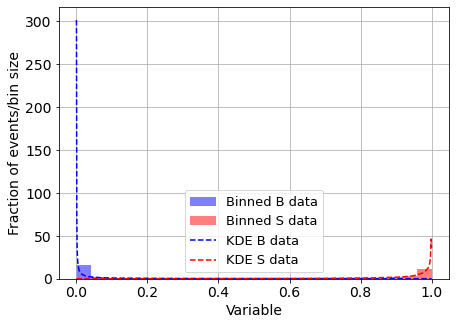

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                  | 5/2000 [00:08<48:40,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1974328526872843
<p_{s}(Sdata)> = 8.612901407160397
<p_{b}(Bdata)> = 103.70307520258271
<p_{s}(Bdata)> = 0.21242609701136234


  1%|▎                                | 16/2000 [00:26<40:50,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19557386432490864
<p_{s}(Sdata)> = 10.662637131606257
<p_{b}(Bdata)> = 102.68838105181564
<p_{s}(Bdata)> = 0.2236173382627694


  1%|▎                                | 17/2000 [00:27<33:21,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17604380529421676
<p_{s}(Sdata)> = 10.56150361936196
<p_{b}(Bdata)> = 102.54232672045207
<p_{s}(Bdata)> = 0.22335662458430597


  1%|▍                                | 23/2000 [00:38<55:25,  1.68s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2511810462758909
<p_{s}(Sdata)> = 13.056563466829552
<p_{b}(Bdata)> = 103.20919224365247
<p_{s}(Bdata)> = 0.22230234081808464


  1%|▍                                | 24/2000 [00:39<42:09,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.195323022682984
<p_{s}(Sdata)> = 6.471364164549503
<p_{b}(Bdata)> = 102.58945758793496
<p_{s}(Bdata)> = 0.21346417336456375


  2%|▌                                | 32/2000 [00:52<40:37,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15051366332613536
<p_{s}(Sdata)> = 13.73927969702054
<p_{b}(Bdata)> = 102.10849247207427
<p_{s}(Bdata)> = 0.2268217122366427


  2%|▌                                | 35/2000 [00:57<45:10,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20000824224716046
<p_{s}(Sdata)> = 10.883155261337794
<p_{b}(Bdata)> = 103.22411885524258
<p_{s}(Bdata)> = 0.2209213794267909


  2%|▌                                | 36/2000 [00:58<36:23,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.36708686990601386
<p_{s}(Sdata)> = 14.281769250794413
<p_{b}(Bdata)> = 103.24850704124364
<p_{s}(Bdata)> = 0.2208346287918968


  2%|▌                                | 37/2000 [00:58<28:50,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22328715788270498
<p_{s}(Sdata)> = 7.1538403060702205
<p_{b}(Bdata)> = 103.74454563721919
<p_{s}(Bdata)> = 0.21208011990395145


  2%|▋                                | 40/2000 [01:03<43:36,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18693210139182245
<p_{s}(Sdata)> = 7.863373645368489
<p_{b}(Bdata)> = 103.11632037652062
<p_{s}(Bdata)> = 0.22611615712081434


  2%|▊                                | 48/2000 [01:17<50:13,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20709175838592306
<p_{s}(Sdata)> = 10.854801359788645
<p_{b}(Bdata)> = 102.03824800672723
<p_{s}(Bdata)> = 0.22196416587507292


  3%|▊                                | 51/2000 [01:22<48:48,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17828550178723007
<p_{s}(Sdata)> = 12.428752970109366
<p_{b}(Bdata)> = 102.92787973967235
<p_{s}(Bdata)> = 0.21726028078647125


  3%|▉                                | 56/2000 [01:29<37:46,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17784069155349266
<p_{s}(Sdata)> = 10.566744537454118
<p_{b}(Bdata)> = 102.96176717062978
<p_{s}(Bdata)> = 0.221119826120106


  4%|█▏                               | 70/2000 [01:52<44:23,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16036425690309442
<p_{s}(Sdata)> = 12.681103737551892
<p_{b}(Bdata)> = 103.3043482770824
<p_{s}(Bdata)> = 0.21978146979079763


  4%|█▏                               | 75/2000 [02:00<42:34,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15909545676606304
<p_{s}(Sdata)> = 11.916207477413435
<p_{b}(Bdata)> = 102.78432207821406
<p_{s}(Bdata)> = 0.22319731208744556


  5%|█▌                               | 91/2000 [02:27<41:15,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1925700768721204
<p_{s}(Sdata)> = 8.537786314370411
<p_{b}(Bdata)> = 102.57176295552678
<p_{s}(Bdata)> = 0.21112270605416203


  5%|█▌                               | 94/2000 [02:30<33:00,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18147445651570107
<p_{s}(Sdata)> = 9.457266906953556
<p_{b}(Bdata)> = 102.3647272325317
<p_{s}(Bdata)> = 0.2239074035994606


  6%|█▊                              | 110/2000 [02:58<43:53,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17257899632325177
<p_{s}(Sdata)> = 11.204835820900616
<p_{b}(Bdata)> = 102.65653837953822
<p_{s}(Bdata)> = 0.21204697028275438


  6%|█▊                              | 116/2000 [03:07<38:49,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2321848142006801
<p_{s}(Sdata)> = 7.596139834520682
<p_{b}(Bdata)> = 102.72172390578622
<p_{s}(Bdata)> = 0.2170358875086384


  6%|█▉                              | 119/2000 [03:12<42:19,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2068815087914334
<p_{s}(Sdata)> = 12.378008725016697
<p_{b}(Bdata)> = 103.35441743473748
<p_{s}(Bdata)> = 0.22120104668328994


  8%|██▍                             | 153/2000 [04:12<34:11,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16667078221760565
<p_{s}(Sdata)> = 12.843765821114673
<p_{b}(Bdata)> = 103.08824768216611
<p_{s}(Bdata)> = 0.2186980106698762


  8%|██▋                             | 168/2000 [04:40<36:48,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15106418232037458
<p_{s}(Sdata)> = 15.381439964803421
<p_{b}(Bdata)> = 102.85610225492118
<p_{s}(Bdata)> = 0.21807728368703508


  9%|██▉                             | 186/2000 [05:12<45:30,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16271640508230906
<p_{s}(Sdata)> = 11.789885835210667
<p_{b}(Bdata)> = 102.90770764070902
<p_{s}(Bdata)> = 0.22121401701356969


 12%|███▋                            | 233/2000 [06:36<47:10,  1.60s/it]

muhat = 2.1
<p_{b}(Sdata)> = 5.549489886154236
<p_{s}(Sdata)> = 13.509590390203734
<p_{b}(Bdata)> = 103.52546663981046
<p_{s}(Bdata)> = 0.2208719718890076


 12%|███▊                            | 237/2000 [06:42<40:21,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14925078886817597
<p_{s}(Sdata)> = 15.2574578323123
<p_{b}(Bdata)> = 103.42819992611994
<p_{s}(Bdata)> = 0.21866358377626818


 13%|████▏                           | 262/2000 [07:25<41:29,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1457867016067978
<p_{s}(Sdata)> = 13.384355934346422
<p_{b}(Bdata)> = 102.8967025844479
<p_{s}(Bdata)> = 0.22201181793873404


 14%|████▎                           | 273/2000 [07:44<40:30,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15360579274851374
<p_{s}(Sdata)> = 11.557745241165849
<p_{b}(Bdata)> = 102.96065367835858
<p_{s}(Bdata)> = 0.2202843151244109


 14%|████▌                           | 286/2000 [08:05<40:40,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15164418947613417
<p_{s}(Sdata)> = 13.203166161585143
<p_{b}(Bdata)> = 103.07670227725666
<p_{s}(Bdata)> = 0.2230619628293416


 15%|████▋                           | 293/2000 [08:20<47:52,  1.68s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1678689906202496
<p_{s}(Sdata)> = 9.750901013871546
<p_{b}(Bdata)> = 103.64869857430723
<p_{s}(Bdata)> = 0.21461582208540433


 15%|████▋                           | 296/2000 [08:25<43:50,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16139769759357972
<p_{s}(Sdata)> = 12.581264916430253
<p_{b}(Bdata)> = 102.61958929466368
<p_{s}(Bdata)> = 0.22090393526050828


 16%|█████▏                          | 323/2000 [09:12<43:24,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1678397153824028
<p_{s}(Sdata)> = 12.585710820614722
<p_{b}(Bdata)> = 102.83599554789593
<p_{s}(Bdata)> = 0.2208606260642763


 17%|█████▎                          | 335/2000 [09:32<36:50,  1.33s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20364397287391137
<p_{s}(Sdata)> = 7.663739481742042
<p_{b}(Bdata)> = 102.86690437621601
<p_{s}(Bdata)> = 0.22230901702101283


 18%|█████▋                          | 354/2000 [10:06<37:09,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20841115009952435
<p_{s}(Sdata)> = 5.0971150528303495
<p_{b}(Bdata)> = 102.52542097483892
<p_{s}(Bdata)> = 0.21496764420347028


 18%|█████▊                          | 367/2000 [10:28<40:05,  1.47s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1863814383682388
<p_{s}(Sdata)> = 6.55301070206174
<p_{b}(Bdata)> = 102.91270001014827
<p_{s}(Bdata)> = 0.21191229132516295


 19%|█████▉                          | 372/2000 [10:37<38:17,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1919606850069641
<p_{s}(Sdata)> = 8.461626757922659
<p_{b}(Bdata)> = 102.8535191205444
<p_{s}(Bdata)> = 0.22286105118703153


 19%|██████▏                         | 389/2000 [11:06<30:29,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18487125754235018
<p_{s}(Sdata)> = 9.873880895487728
<p_{b}(Bdata)> = 102.28756964977362
<p_{s}(Bdata)> = 0.2151571694525559


 20%|██████▎                         | 393/2000 [11:12<35:23,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1602609540806873
<p_{s}(Sdata)> = 11.640642083091807
<p_{b}(Bdata)> = 102.62384195719665
<p_{s}(Bdata)> = 0.22391401088165433


 20%|██████▍                         | 400/2000 [11:25<44:04,  1.65s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19142518303932843
<p_{s}(Sdata)> = 12.765986158535515
<p_{b}(Bdata)> = 103.00077612618027
<p_{s}(Bdata)> = 0.22482487497981155


 22%|██████▉                         | 430/2000 [12:17<37:38,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16686538631682327
<p_{s}(Sdata)> = 15.301094426346367
<p_{b}(Bdata)> = 103.55521492310781
<p_{s}(Bdata)> = 0.2226118281646884


 22%|███████                         | 443/2000 [12:39<38:03,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1519018201805445
<p_{s}(Sdata)> = 12.274173169183463
<p_{b}(Bdata)> = 102.76373895214344
<p_{s}(Bdata)> = 0.22005574599559663


 22%|███████▏                        | 449/2000 [12:47<32:30,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14344332056484202
<p_{s}(Sdata)> = 13.162352418655015
<p_{b}(Bdata)> = 102.9011002741319
<p_{s}(Bdata)> = 0.21830323665281756


 23%|███████▎                        | 458/2000 [13:01<32:40,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17844074407473737
<p_{s}(Sdata)> = 14.754261801668054
<p_{b}(Bdata)> = 102.30246597446633
<p_{s}(Bdata)> = 0.2216010701380633


 23%|███████▎                        | 459/2000 [13:02<25:29,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16742131713523
<p_{s}(Sdata)> = 10.049957267095378
<p_{b}(Bdata)> = 103.75643855663087
<p_{s}(Bdata)> = 0.2115731402668149


 24%|███████▋                        | 482/2000 [13:47<37:18,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1569277729436255
<p_{s}(Sdata)> = 12.89524693311721
<p_{b}(Bdata)> = 102.46043186243972
<p_{s}(Bdata)> = 0.218046819428008


 24%|███████▊                        | 486/2000 [13:52<34:02,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16135660859599196
<p_{s}(Sdata)> = 11.722913508270018
<p_{b}(Bdata)> = 103.23378929673538
<p_{s}(Bdata)> = 0.22085473115108803


 24%|███████▊                        | 489/2000 [13:55<24:33,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20487950052081347
<p_{s}(Sdata)> = 6.700034340083925
<p_{b}(Bdata)> = 102.59178933294035
<p_{s}(Bdata)> = 0.2129638255679977


 25%|████████                        | 504/2000 [14:19<38:36,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16823366665285422
<p_{s}(Sdata)> = 13.757767184198372
<p_{b}(Bdata)> = 102.83853041803134
<p_{s}(Bdata)> = 0.2189471741575811


 26%|████████▏                       | 515/2000 [14:38<40:12,  1.62s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17231966542469376
<p_{s}(Sdata)> = 13.270769981498894
<p_{b}(Bdata)> = 103.25117068037324
<p_{s}(Bdata)> = 0.21964745730646892


 26%|████████▍                       | 530/2000 [15:05<37:45,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17910214234336327
<p_{s}(Sdata)> = 10.83005977803132
<p_{b}(Bdata)> = 102.47796465877975
<p_{s}(Bdata)> = 0.21955173662326066


 27%|████████▋                       | 540/2000 [15:24<41:45,  1.72s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16795845390228278
<p_{s}(Sdata)> = 11.812089438519898
<p_{b}(Bdata)> = 102.54894321555601
<p_{s}(Bdata)> = 0.22267612029367365


 27%|████████▋                       | 545/2000 [15:31<29:28,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17864496456819828
<p_{s}(Sdata)> = 13.114908298575836
<p_{b}(Bdata)> = 102.52893446798885
<p_{s}(Bdata)> = 0.21954802173357812


 29%|█████████▎                      | 581/2000 [16:34<35:20,  1.49s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20793935234888825
<p_{s}(Sdata)> = 7.682048438518341
<p_{b}(Bdata)> = 103.57738540213987
<p_{s}(Bdata)> = 0.21442817176488724


 31%|█████████▊                      | 612/2000 [17:33<34:31,  1.49s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18174022769126782
<p_{s}(Sdata)> = 9.52156221455585
<p_{b}(Bdata)> = 103.12648903860179
<p_{s}(Bdata)> = 0.22319441960268566


 31%|█████████▉                      | 624/2000 [17:54<33:31,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1866699791181317
<p_{s}(Sdata)> = 10.721241791178532
<p_{b}(Bdata)> = 102.98404384975646
<p_{s}(Bdata)> = 0.22543623277028477


 32%|██████████                      | 632/2000 [18:08<32:14,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15479016176870883
<p_{s}(Sdata)> = 12.276582794264169
<p_{b}(Bdata)> = 103.3511729183643
<p_{s}(Bdata)> = 0.22181631258368376


 32%|██████████▏                     | 640/2000 [18:21<30:49,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20029833918599124
<p_{s}(Sdata)> = 12.635811675223923
<p_{b}(Bdata)> = 102.62861804267843
<p_{s}(Bdata)> = 0.21822737582907892


 32%|██████████▎                     | 646/2000 [18:30<28:16,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17401266560375447
<p_{s}(Sdata)> = 8.799647873429894
<p_{b}(Bdata)> = 102.63715532957816
<p_{s}(Bdata)> = 0.21508802229490837


 33%|██████████▍                     | 653/2000 [18:39<26:21,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20438092017070625
<p_{s}(Sdata)> = 10.816221709496737
<p_{b}(Bdata)> = 102.45131740048953
<p_{s}(Bdata)> = 0.22276818714372898


 34%|██████████▊                     | 673/2000 [19:17<30:23,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.8490961934650612
<p_{s}(Sdata)> = 10.503327487330669
<p_{b}(Bdata)> = 102.72048201667215
<p_{s}(Bdata)> = 0.22125811936982812


 34%|██████████▊                     | 678/2000 [19:26<29:46,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22562230442603196
<p_{s}(Sdata)> = 7.974738355168943
<p_{b}(Bdata)> = 103.28383115675311
<p_{s}(Bdata)> = 0.22277805198149855


 35%|███████████                     | 693/2000 [19:51<27:48,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15523699211816533
<p_{s}(Sdata)> = 12.636556647038677
<p_{b}(Bdata)> = 103.41824586958279
<p_{s}(Bdata)> = 0.2222665613952807


 35%|███████████                     | 695/2000 [19:54<27:58,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21594628468559957
<p_{s}(Sdata)> = 11.33544133869645
<p_{b}(Bdata)> = 103.0974356403643
<p_{s}(Bdata)> = 0.2241848254642728


 36%|███████████▍                    | 711/2000 [20:22<30:40,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4233721402282808
<p_{s}(Sdata)> = 12.124234343071093
<p_{b}(Bdata)> = 102.58756742291499
<p_{s}(Bdata)> = 0.22131513575835035


 36%|███████████▍                    | 718/2000 [20:34<31:09,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1623629233789748
<p_{s}(Sdata)> = 13.210227179945273
<p_{b}(Bdata)> = 102.76116851587051
<p_{s}(Bdata)> = 0.22039375239160605


 37%|███████████▊                    | 739/2000 [21:10<31:41,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2590979411675458
<p_{s}(Sdata)> = 11.210410941012936
<p_{b}(Bdata)> = 103.25038305060632
<p_{s}(Bdata)> = 0.22154422886048136


 37%|███████████▉                    | 747/2000 [21:24<27:54,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1796802485808076
<p_{s}(Sdata)> = 12.13035187961278
<p_{b}(Bdata)> = 102.84022790112817
<p_{s}(Bdata)> = 0.22021679951714077


 38%|████████████                    | 751/2000 [21:30<26:49,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18228201592935137
<p_{s}(Sdata)> = 9.80920272856731
<p_{b}(Bdata)> = 102.59357651563155
<p_{s}(Bdata)> = 0.22251966327378692


 38%|████████████                    | 754/2000 [21:34<25:52,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17213420221656134
<p_{s}(Sdata)> = 11.165922206996404
<p_{b}(Bdata)> = 103.95845709255505
<p_{s}(Bdata)> = 0.2195383305323847


 40%|████████████▋                   | 793/2000 [22:47<28:48,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20918575893412875
<p_{s}(Sdata)> = 11.530466447887724
<p_{b}(Bdata)> = 102.7896937777583
<p_{s}(Bdata)> = 0.22334173143179506


 40%|████████████▋                   | 795/2000 [22:49<24:45,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18896352036054215
<p_{s}(Sdata)> = 10.455288095364123
<p_{b}(Bdata)> = 103.07524262267785
<p_{s}(Bdata)> = 0.21253387494793355


 40%|████████████▊                   | 797/2000 [22:51<21:57,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17500726390060056
<p_{s}(Sdata)> = 11.707638010905494
<p_{b}(Bdata)> = 102.53621796233058
<p_{s}(Bdata)> = 0.21980664650504653


 40%|████████████▉                   | 805/2000 [23:04<28:43,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25560690284038634
<p_{s}(Sdata)> = 6.291720114460145
<p_{b}(Bdata)> = 102.84834795316209
<p_{s}(Bdata)> = 0.21603706398688258


 40%|████████████▉                   | 806/2000 [23:04<22:56,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16102315031971023
<p_{s}(Sdata)> = 11.245084376050682
<p_{b}(Bdata)> = 102.3267289469687
<p_{s}(Bdata)> = 0.22266432069921055


 40%|████████████▉                   | 807/2000 [23:05<18:04,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19747505829042447
<p_{s}(Sdata)> = 7.369884250382084
<p_{b}(Bdata)> = 102.49750749439606
<p_{s}(Bdata)> = 0.21540903198301126


 41%|█████████████▏                  | 824/2000 [23:38<29:38,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1692421796445751
<p_{s}(Sdata)> = 12.434221655509955
<p_{b}(Bdata)> = 103.02547560480586
<p_{s}(Bdata)> = 0.22043571873808734


 42%|█████████████▎                  | 835/2000 [24:01<29:56,  1.54s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20573131940141787
<p_{s}(Sdata)> = 12.190614045199217
<p_{b}(Bdata)> = 103.02905387511996
<p_{s}(Bdata)> = 0.21886206561951818


 42%|█████████████▍                  | 843/2000 [24:15<28:51,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.6788631699325759
<p_{s}(Sdata)> = 13.119633294921503
<p_{b}(Bdata)> = 102.44052323066515
<p_{s}(Bdata)> = 0.2229344502291684


 43%|█████████████▊                  | 866/2000 [24:57<26:27,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15652972793172823
<p_{s}(Sdata)> = 12.217373379327093
<p_{b}(Bdata)> = 102.80379313907619
<p_{s}(Bdata)> = 0.21953126984834995


 43%|█████████████▊                  | 867/2000 [24:58<21:14,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17054983318813796
<p_{s}(Sdata)> = 11.077022813179807
<p_{b}(Bdata)> = 102.5125287336952
<p_{s}(Bdata)> = 0.22057906371376731


 44%|█████████████▉                  | 874/2000 [25:08<23:42,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1988681678859788
<p_{s}(Sdata)> = 5.922783994351749
<p_{b}(Bdata)> = 102.92910603977745
<p_{s}(Bdata)> = 0.21486344890032796


 44%|██████████████                  | 880/2000 [25:18<25:33,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21790633382014815
<p_{s}(Sdata)> = 11.03601910038499
<p_{b}(Bdata)> = 102.86682398654087
<p_{s}(Bdata)> = 0.22453704297320295


 44%|██████████████                  | 881/2000 [25:19<20:35,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19009906167432641
<p_{s}(Sdata)> = 12.388584802507797
<p_{b}(Bdata)> = 103.07286620134316
<p_{s}(Bdata)> = 0.2187605609816122


 44%|██████████████▏                 | 886/2000 [25:28<27:31,  1.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.13386184428076467
<p_{s}(Sdata)> = 15.789570263415213
<p_{b}(Bdata)> = 102.68294635648833
<p_{s}(Bdata)> = 0.21637494172984154


 45%|██████████████▎                 | 891/2000 [25:34<22:48,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16423311627559511
<p_{s}(Sdata)> = 10.157206120036893
<p_{b}(Bdata)> = 103.20508088710257
<p_{s}(Bdata)> = 0.22194589253258068


 45%|██████████████▎                 | 895/2000 [25:40<21:37,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19680271833240034
<p_{s}(Sdata)> = 5.9999337550447756
<p_{b}(Bdata)> = 102.57759748132769
<p_{s}(Bdata)> = 0.21424518953664992


 45%|██████████████▍                 | 899/2000 [25:44<20:21,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.29305128889443693
<p_{s}(Sdata)> = 11.315222794391682
<p_{b}(Bdata)> = 102.19229133650809
<p_{s}(Bdata)> = 0.2213462997884926


 46%|██████████████▊                 | 924/2000 [26:27<23:00,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1507641677072951
<p_{s}(Sdata)> = 14.838498177289768
<p_{b}(Bdata)> = 102.50249926979716
<p_{s}(Bdata)> = 0.22292339335502234


 48%|███████████████▏                | 952/2000 [27:17<27:44,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18178658267819733
<p_{s}(Sdata)> = 9.319281786427611
<p_{b}(Bdata)> = 102.83229786014162
<p_{s}(Bdata)> = 0.21302838092597767


 48%|███████████████▎                | 956/2000 [27:22<22:47,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1550556826599551
<p_{s}(Sdata)> = 14.888450912480689
<p_{b}(Bdata)> = 102.68335048250488
<p_{s}(Bdata)> = 0.22071910220090402


 48%|███████████████▍                | 965/2000 [27:39<28:22,  1.65s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.12929570435436086
<p_{s}(Sdata)> = 18.445330817806955
<p_{b}(Bdata)> = 103.25256039574236
<p_{s}(Bdata)> = 0.2172267019806534


 48%|███████████████▍                | 967/2000 [27:41<22:14,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16963786125280136
<p_{s}(Sdata)> = 9.428068922684673
<p_{b}(Bdata)> = 103.41415385143235
<p_{s}(Bdata)> = 0.22437275548868457


 48%|███████████████▌                | 970/2000 [27:47<24:59,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4067511550188469
<p_{s}(Sdata)> = 12.772375656436862
<p_{b}(Bdata)> = 103.05797296261233
<p_{s}(Bdata)> = 0.21965636840686487


 49%|███████████████▌                | 971/2000 [27:47<19:56,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19254898427184988
<p_{s}(Sdata)> = 9.468483542688375
<p_{b}(Bdata)> = 102.88448314999935
<p_{s}(Bdata)> = 0.2232275667481775


 49%|███████████████▌                | 973/2000 [27:50<20:07,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16616441011725852
<p_{s}(Sdata)> = 11.684937922981762
<p_{b}(Bdata)> = 102.97220120632392
<p_{s}(Bdata)> = 0.21820744867560724


 49%|███████████████▋                | 984/2000 [28:11<26:21,  1.56s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17278255403851053
<p_{s}(Sdata)> = 11.521006238342801
<p_{b}(Bdata)> = 102.7259705848779
<p_{s}(Bdata)> = 0.22228974897718037


 49%|███████████████▊                | 985/2000 [28:12<20:52,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16560763320229463
<p_{s}(Sdata)> = 11.505153388245846
<p_{b}(Bdata)> = 102.35238991516033
<p_{s}(Bdata)> = 0.2218522189826913


 49%|███████████████▊                | 988/2000 [28:16<21:46,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15027319854688082
<p_{s}(Sdata)> = 15.997860004545803
<p_{b}(Bdata)> = 102.56682867816939
<p_{s}(Bdata)> = 0.22497941905666197


 49%|███████████████▊                | 989/2000 [28:17<17:39,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21082589374571836
<p_{s}(Sdata)> = 12.165160431599103
<p_{b}(Bdata)> = 103.32633776840447
<p_{s}(Bdata)> = 0.22150585946482665


 50%|███████████████▉                | 995/2000 [28:27<25:17,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17463849647897448
<p_{s}(Sdata)> = 8.69600666915068
<p_{b}(Bdata)> = 102.82065770866954
<p_{s}(Bdata)> = 0.22179717493487927


 50%|███████████████▌               | 1004/2000 [28:43<22:46,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1510698301216933
<p_{s}(Sdata)> = 14.182888493188589
<p_{b}(Bdata)> = 102.80187045721486
<p_{s}(Bdata)> = 0.21917096037886505


 51%|███████████████▊               | 1017/2000 [29:06<24:13,  1.48s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16055230246048466
<p_{s}(Sdata)> = 12.408256355989414
<p_{b}(Bdata)> = 103.77009945356498
<p_{s}(Bdata)> = 0.2200870593818652


 51%|███████████████▉               | 1027/2000 [29:25<26:14,  1.62s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15383581300544752
<p_{s}(Sdata)> = 14.765052100390713
<p_{b}(Bdata)> = 102.87570600063977
<p_{s}(Bdata)> = 0.22236437599588085


 52%|███████████████▉               | 1030/2000 [29:28<20:07,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17113540797898052
<p_{s}(Sdata)> = 9.929055895763494
<p_{b}(Bdata)> = 102.64104883525287
<p_{s}(Bdata)> = 0.22524010945664016


 52%|████████████████               | 1035/2000 [29:37<22:57,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20210901180138627
<p_{s}(Sdata)> = 11.825014588660848
<p_{b}(Bdata)> = 102.3655318880613
<p_{s}(Bdata)> = 0.22279174782006847


 52%|████████████████               | 1038/2000 [29:40<17:31,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17798160906981175
<p_{s}(Sdata)> = 9.34208933578085
<p_{b}(Bdata)> = 102.3871822611419
<p_{s}(Bdata)> = 0.22354987256840905


 52%|████████████████▏              | 1048/2000 [29:59<25:18,  1.59s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22136466576135805
<p_{s}(Sdata)> = 8.647404551933155
<p_{b}(Bdata)> = 103.29187305535332
<p_{s}(Bdata)> = 0.21406459176243509


 53%|████████████████▎              | 1055/2000 [30:10<22:55,  1.46s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1995844784787343
<p_{s}(Sdata)> = 8.491078955836024
<p_{b}(Bdata)> = 103.21133862334196
<p_{s}(Bdata)> = 0.2113955523200228


 54%|████████████████▋              | 1073/2000 [30:43<22:15,  1.44s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22200001825687446
<p_{s}(Sdata)> = 6.117962076867755
<p_{b}(Bdata)> = 103.07977409016463
<p_{s}(Bdata)> = 0.21474851023932695


 54%|████████████████▋              | 1077/2000 [30:49<22:15,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15571682850760957
<p_{s}(Sdata)> = 14.103225661411315
<p_{b}(Bdata)> = 103.21836198805086
<p_{s}(Bdata)> = 0.2186637329736819


 54%|████████████████▋              | 1080/2000 [30:54<22:54,  1.49s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21550813136274863
<p_{s}(Sdata)> = 9.800302091947389
<p_{b}(Bdata)> = 102.40927962853971
<p_{s}(Bdata)> = 0.22266729569193744


 54%|████████████████▊              | 1088/2000 [31:10<23:31,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16630609589451523
<p_{s}(Sdata)> = 9.163633177409219
<p_{b}(Bdata)> = 103.03172728991129
<p_{s}(Bdata)> = 0.22344315650859564


 55%|████████████████▉              | 1095/2000 [31:20<17:37,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21363154116716376
<p_{s}(Sdata)> = 9.543117356211773
<p_{b}(Bdata)> = 103.03955366806255
<p_{s}(Bdata)> = 0.21206545634784188


 55%|█████████████████              | 1104/2000 [31:32<18:17,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19105813704532026
<p_{s}(Sdata)> = 11.446271255148389
<p_{b}(Bdata)> = 103.16886041575458
<p_{s}(Bdata)> = 0.22148079838529244


 56%|█████████████████▎             | 1116/2000 [31:54<20:21,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16399950716985973
<p_{s}(Sdata)> = 11.740445973907626
<p_{b}(Bdata)> = 102.56391422180172
<p_{s}(Bdata)> = 0.22291249595804055


 56%|█████████████████▍             | 1122/2000 [32:03<19:45,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23421236245156843
<p_{s}(Sdata)> = 11.485214583119468
<p_{b}(Bdata)> = 103.06999219999372
<p_{s}(Bdata)> = 0.2200836520146492


 56%|█████████████████▍             | 1128/2000 [32:14<22:48,  1.57s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18693529008517754
<p_{s}(Sdata)> = 13.565136428039981
<p_{b}(Bdata)> = 102.95523301651215
<p_{s}(Bdata)> = 0.21743478978882735


 57%|█████████████████▌             | 1132/2000 [32:19<17:01,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17415537289051664
<p_{s}(Sdata)> = 13.279136718044956
<p_{b}(Bdata)> = 102.47389227787534
<p_{s}(Bdata)> = 0.21981941744311378


 57%|█████████████████▌             | 1135/2000 [32:22<14:39,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20251080683487213
<p_{s}(Sdata)> = 10.421015933094898
<p_{b}(Bdata)> = 103.06823432933909
<p_{s}(Bdata)> = 0.22088736622602445


 57%|█████████████████▋             | 1143/2000 [32:32<15:42,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1603839725243428
<p_{s}(Sdata)> = 11.950303911272341
<p_{b}(Bdata)> = 102.49531360658015
<p_{s}(Bdata)> = 0.22243684477167422


 58%|█████████████████▉             | 1159/2000 [33:01<21:30,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1730719016185838
<p_{s}(Sdata)> = 9.90751371729635
<p_{b}(Bdata)> = 103.17797889805748
<p_{s}(Bdata)> = 0.2217862136895008


 58%|██████████████████             | 1167/2000 [33:16<23:02,  1.66s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1467594811961369
<p_{s}(Sdata)> = 15.024823829919356
<p_{b}(Bdata)> = 102.95114489071749
<p_{s}(Bdata)> = 0.2203045181119799


 59%|██████████████████▏            | 1172/2000 [33:24<19:49,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16827499586217817
<p_{s}(Sdata)> = 10.865035258584639
<p_{b}(Bdata)> = 102.60417759751384
<p_{s}(Bdata)> = 0.22193120616174114


 60%|██████████████████▌            | 1201/2000 [34:13<17:09,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16713475993997606
<p_{s}(Sdata)> = 11.704485263139995
<p_{b}(Bdata)> = 102.43159916925613
<p_{s}(Bdata)> = 0.22174077950809445


 60%|██████████████████▋            | 1209/2000 [34:26<19:23,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15729515311270284
<p_{s}(Sdata)> = 11.452985137807314
<p_{b}(Bdata)> = 103.22520862786102
<p_{s}(Bdata)> = 0.22123966866751188


 61%|███████████████████            | 1228/2000 [35:01<18:04,  1.40s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23913554172924373
<p_{s}(Sdata)> = 10.004634005874387
<p_{b}(Bdata)> = 103.16354800308133
<p_{s}(Bdata)> = 0.21407322338395096


 62%|███████████████████▎           | 1248/2000 [35:33<18:24,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15876389269485516
<p_{s}(Sdata)> = 14.011605874382782
<p_{b}(Bdata)> = 102.80520773257803
<p_{s}(Bdata)> = 0.2200613903295991


 63%|███████████████████▍           | 1254/2000 [35:43<18:06,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19420534665175848
<p_{s}(Sdata)> = 10.811733458078006
<p_{b}(Bdata)> = 103.44635428029076
<p_{s}(Bdata)> = 0.22131699750507036


 63%|███████████████████▍           | 1257/2000 [35:46<14:54,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16898478606380912
<p_{s}(Sdata)> = 11.120849402656958
<p_{b}(Bdata)> = 102.36505462019889
<p_{s}(Bdata)> = 0.2238325245284617


 64%|███████████████████▋           | 1273/2000 [36:14<18:12,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16111369071563725
<p_{s}(Sdata)> = 12.309959236290368
<p_{b}(Bdata)> = 102.43797510672098
<p_{s}(Bdata)> = 0.21987353332590476


 64%|███████████████████▉           | 1289/2000 [36:43<18:35,  1.57s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1756735090064761
<p_{s}(Sdata)> = 15.098596120067246
<p_{b}(Bdata)> = 102.82532993491748
<p_{s}(Bdata)> = 0.2228844335205648


 65%|████████████████████           | 1295/2000 [36:52<15:43,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19520790055439277
<p_{s}(Sdata)> = 12.799702145991525
<p_{b}(Bdata)> = 102.11624818591571
<p_{s}(Bdata)> = 0.21965325553056958


 67%|████████████████████▉          | 1348/2000 [38:29<14:36,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1592853768632393
<p_{s}(Sdata)> = 12.44013526059085
<p_{b}(Bdata)> = 103.59350484607434
<p_{s}(Bdata)> = 0.22100930815140493


 68%|████████████████████▉          | 1350/2000 [38:31<12:23,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18650822511489906
<p_{s}(Sdata)> = 11.333364028232051
<p_{b}(Bdata)> = 102.57159532000382
<p_{s}(Bdata)> = 0.22501229599722475


 68%|█████████████████████          | 1359/2000 [38:46<14:18,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16778915125517152
<p_{s}(Sdata)> = 11.478019891707342
<p_{b}(Bdata)> = 102.59712177209788
<p_{s}(Bdata)> = 0.22192133876032905


 68%|█████████████████████          | 1362/2000 [38:50<13:27,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15537515136677665
<p_{s}(Sdata)> = 15.592232992093788
<p_{b}(Bdata)> = 102.39596783555538
<p_{s}(Bdata)> = 0.2173670446566923


 68%|█████████████████████▏         | 1367/2000 [38:58<13:52,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19310439292967646
<p_{s}(Sdata)> = 10.83140986092519
<p_{b}(Bdata)> = 102.88022711158497
<p_{s}(Bdata)> = 0.22125493883128314


 68%|█████████████████████▏         | 1369/2000 [39:00<11:12,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15669645385645656
<p_{s}(Sdata)> = 14.323807427257044
<p_{b}(Bdata)> = 102.56458408874947
<p_{s}(Bdata)> = 0.2227235258404516


 69%|█████████████████████▎         | 1375/2000 [39:10<14:35,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25598631456741994
<p_{s}(Sdata)> = 12.129015556469701
<p_{b}(Bdata)> = 102.91240769675701
<p_{s}(Bdata)> = 0.22227205254046908


 69%|█████████████████████▍         | 1380/2000 [39:18<13:20,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20245985742633485
<p_{s}(Sdata)> = 6.602707610557589
<p_{b}(Bdata)> = 103.00225557445725
<p_{s}(Bdata)> = 0.21508391827495543


 73%|██████████████████████▌        | 1455/2000 [41:39<14:10,  1.56s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14857755258080454
<p_{s}(Sdata)> = 13.632238889394069
<p_{b}(Bdata)> = 102.5453164827471
<p_{s}(Bdata)> = 0.2198567247217525


 74%|██████████████████████▊        | 1473/2000 [42:12<13:38,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16527111393118535
<p_{s}(Sdata)> = 11.800496011684299
<p_{b}(Bdata)> = 102.8592018346537
<p_{s}(Bdata)> = 0.22069858199546816


 75%|███████████████████████▎       | 1503/2000 [43:02<11:55,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1761301261714731
<p_{s}(Sdata)> = 11.606059536804958
<p_{b}(Bdata)> = 103.46850780618308
<p_{s}(Bdata)> = 0.21894100208950382


 76%|███████████████████████▍       | 1511/2000 [43:13<10:27,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16669577722542644
<p_{s}(Sdata)> = 10.917461772119688
<p_{b}(Bdata)> = 102.95736184928325
<p_{s}(Bdata)> = 0.21752880147438827


 76%|███████████████████████▍       | 1514/2000 [43:17<08:58,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15374463325004153
<p_{s}(Sdata)> = 14.660256207561469
<p_{b}(Bdata)> = 102.58543901123582
<p_{s}(Bdata)> = 0.21805060515139216


 76%|███████████████████████▋       | 1526/2000 [43:38<11:53,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16150433814700962
<p_{s}(Sdata)> = 13.634011627921767
<p_{b}(Bdata)> = 103.60020426506892
<p_{s}(Bdata)> = 0.21977627339520459


 77%|███████████████████████▉       | 1542/2000 [44:04<09:23,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21535314159018773
<p_{s}(Sdata)> = 9.577525552255238
<p_{b}(Bdata)> = 103.30022526210891
<p_{s}(Bdata)> = 0.2235101885604983


 77%|███████████████████████▉       | 1543/2000 [44:04<07:39,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17363083289894582
<p_{s}(Sdata)> = 11.320122296112384
<p_{b}(Bdata)> = 103.06473202126857
<p_{s}(Bdata)> = 0.22390566900179404


 77%|████████████████████████       | 1549/2000 [44:14<10:06,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2745132461511087
<p_{s}(Sdata)> = 11.2108796956909
<p_{b}(Bdata)> = 102.68470417952686
<p_{s}(Bdata)> = 0.21511978993312894


 78%|████████████████████████       | 1555/2000 [44:23<09:48,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15713675057847976
<p_{s}(Sdata)> = 13.055832124931014
<p_{b}(Bdata)> = 102.32769942038098
<p_{s}(Bdata)> = 0.21987345811033668


 79%|████████████████████████▍      | 1579/2000 [45:03<10:01,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15794003442706792
<p_{s}(Sdata)> = 12.705776908983799
<p_{b}(Bdata)> = 103.01491838857261
<p_{s}(Bdata)> = 0.21903819070717948


 79%|████████████████████████▋      | 1589/2000 [45:19<09:27,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15566147598891297
<p_{s}(Sdata)> = 11.638826250708853
<p_{b}(Bdata)> = 102.98027895162556
<p_{s}(Bdata)> = 0.22235251416003207


 81%|█████████████████████████▏     | 1627/2000 [46:26<09:24,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18099292512465837
<p_{s}(Sdata)> = 11.887788865852482
<p_{b}(Bdata)> = 103.20512497621884
<p_{s}(Bdata)> = 0.22097133064685356


 82%|█████████████████████████▎     | 1634/2000 [46:36<07:14,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2710887394312059
<p_{s}(Sdata)> = 10.101410277238426
<p_{b}(Bdata)> = 102.32701175033279
<p_{s}(Bdata)> = 0.2219608372680829


 82%|█████████████████████████▌     | 1647/2000 [47:01<08:49,  1.50s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20264088234484082
<p_{s}(Sdata)> = 11.373959247929967
<p_{b}(Bdata)> = 102.47661677359501
<p_{s}(Bdata)> = 0.22400730234586286


 84%|█████████████████████████▉     | 1672/2000 [47:47<06:57,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19342004409490884
<p_{s}(Sdata)> = 11.452129053934183
<p_{b}(Bdata)> = 102.90583936262952
<p_{s}(Bdata)> = 0.2211700887172399


 84%|█████████████████████████▉     | 1673/2000 [47:47<05:25,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17945102153007222
<p_{s}(Sdata)> = 7.993802255156868
<p_{b}(Bdata)> = 102.86501699081134
<p_{s}(Bdata)> = 0.21355885043666484


 84%|█████████████████████████▉     | 1676/2000 [47:51<06:02,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15428608804327304
<p_{s}(Sdata)> = 13.931939278738291
<p_{b}(Bdata)> = 102.4156913105109
<p_{s}(Bdata)> = 0.21674738581166123


 84%|█████████████████████████▉     | 1677/2000 [47:52<04:59,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17232442155091707
<p_{s}(Sdata)> = 15.49808239736535
<p_{b}(Bdata)> = 102.85867998086736
<p_{s}(Bdata)> = 0.2198776894810657


 84%|██████████████████████████     | 1679/2000 [47:54<05:26,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15129010827027886
<p_{s}(Sdata)> = 13.574939747276177
<p_{b}(Bdata)> = 103.04443274842627
<p_{s}(Bdata)> = 0.22260869887308488


 84%|██████████████████████████     | 1685/2000 [48:03<06:17,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15662353469926332
<p_{s}(Sdata)> = 12.97800788999573
<p_{b}(Bdata)> = 103.5077088105184
<p_{s}(Bdata)> = 0.21715958221862766


 84%|██████████████████████████▏    | 1689/2000 [48:09<06:27,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19397688905394683
<p_{s}(Sdata)> = 12.141428098585283
<p_{b}(Bdata)> = 102.96947328349738
<p_{s}(Bdata)> = 0.22104424274063852


 85%|██████████████████████████▎    | 1695/2000 [48:19<07:22,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14602970044937863
<p_{s}(Sdata)> = 15.265533123465053
<p_{b}(Bdata)> = 103.06389873405854
<p_{s}(Bdata)> = 0.22337025607552258


 86%|██████████████████████████▊    | 1729/2000 [49:19<07:19,  1.62s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2064064055592931
<p_{s}(Sdata)> = 14.32717068350772
<p_{b}(Bdata)> = 102.66507984342897
<p_{s}(Bdata)> = 0.2217801369673941


 87%|██████████████████████████▉    | 1734/2000 [49:27<06:04,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16316622661779664
<p_{s}(Sdata)> = 11.303605147707499
<p_{b}(Bdata)> = 102.77535253698801
<p_{s}(Bdata)> = 0.22389968326942394


 87%|███████████████████████████    | 1749/2000 [49:54<05:46,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17133404940201938
<p_{s}(Sdata)> = 11.295102352698017
<p_{b}(Bdata)> = 103.12637428542179
<p_{s}(Bdata)> = 0.22111720475269708


 88%|███████████████████████████▏   | 1757/2000 [50:06<05:17,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1714354245484876
<p_{s}(Sdata)> = 11.333273617434147
<p_{b}(Bdata)> = 102.79645069248325
<p_{s}(Bdata)> = 0.22149990380997953


 88%|███████████████████████████▍   | 1769/2000 [50:27<05:05,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14612276650022282
<p_{s}(Sdata)> = 16.73754483505277
<p_{b}(Bdata)> = 102.6107046972299
<p_{s}(Bdata)> = 0.21978886936376965


 89%|███████████████████████████▌   | 1775/2000 [50:38<05:39,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17402213268075362
<p_{s}(Sdata)> = 9.245196837204404
<p_{b}(Bdata)> = 103.27585148821846
<p_{s}(Bdata)> = 0.22288942776176585


 90%|███████████████████████████▊   | 1792/2000 [51:09<04:45,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1708511058505005
<p_{s}(Sdata)> = 13.181293404942013
<p_{b}(Bdata)> = 102.33199671761749
<p_{s}(Bdata)> = 0.2219796528250653


 90%|███████████████████████████▉   | 1800/2000 [51:23<05:16,  1.58s/it]

muhat = -0.1
<p_{b}(Sdata)> = 1.6566807347434909
<p_{s}(Sdata)> = 7.227890253844391
<p_{b}(Bdata)> = 103.2503859411718
<p_{s}(Bdata)> = 0.21076333368537425


 90%|████████████████████████████   | 1809/2000 [51:37<03:43,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16478556174202214
<p_{s}(Sdata)> = 13.307680889261118
<p_{b}(Bdata)> = 103.10537374236867
<p_{s}(Bdata)> = 0.22019462014360255


 92%|████████████████████████████▌  | 1840/2000 [52:30<03:33,  1.34s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.223863320216248
<p_{s}(Sdata)> = 6.791574469423992
<p_{b}(Bdata)> = 102.69953037392422
<p_{s}(Bdata)> = 0.21330321624680346


 93%|████████████████████████████▉  | 1869/2000 [53:22<02:42,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20595533009355757
<p_{s}(Sdata)> = 8.02550670076946
<p_{b}(Bdata)> = 103.09134945686156
<p_{s}(Bdata)> = 0.21283486429452145


 94%|█████████████████████████████▏ | 1882/2000 [53:45<03:11,  1.62s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2863878433193965
<p_{s}(Sdata)> = 9.825514931056828
<p_{b}(Bdata)> = 102.95206035392843
<p_{s}(Bdata)> = 0.22404103744955559


 95%|█████████████████████████████▎ | 1893/2000 [54:05<02:35,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1667180155589642
<p_{s}(Sdata)> = 11.59883043383368
<p_{b}(Bdata)> = 103.48117341411061
<p_{s}(Bdata)> = 0.22294507823403217


 97%|█████████████████████████████▉ | 1931/2000 [55:14<01:46,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1736774341731997
<p_{s}(Sdata)> = 13.160585469858525
<p_{b}(Bdata)> = 103.58140290807098
<p_{s}(Bdata)> = 0.2154823858561553


 97%|██████████████████████████████▏| 1944/2000 [55:38<01:07,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15208154251521036
<p_{s}(Sdata)> = 13.70944575742801
<p_{b}(Bdata)> = 102.63338422117957
<p_{s}(Bdata)> = 0.22152140175116136


 98%|██████████████████████████████▍| 1967/2000 [56:21<00:48,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26124808273520866
<p_{s}(Sdata)> = 8.865901097172056
<p_{b}(Bdata)> = 102.67460061114471
<p_{s}(Bdata)> = 0.22148470576620022


 99%|██████████████████████████████▋| 1979/2000 [56:43<00:36,  1.73s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1952751081306168
<p_{s}(Sdata)> = 10.268303471146899
<p_{b}(Bdata)> = 102.85473382788221
<p_{s}(Bdata)> = 0.22288787479640845


 99%|██████████████████████████████▋| 1981/2000 [56:45<00:24,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1824102814815209
<p_{s}(Sdata)> = 10.699476564026579
<p_{b}(Bdata)> = 103.18607222039022
<p_{s}(Bdata)> = 0.22099002772459106


 99%|██████████████████████████████▊| 1984/2000 [56:48<00:16,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1950346992945557
<p_{s}(Sdata)> = 11.801722780313312
<p_{b}(Bdata)> = 102.46547902131091
<p_{s}(Bdata)> = 0.21951594457181137


 99%|██████████████████████████████▊| 1987/2000 [56:51<00:12,  1.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1706097974947467
<p_{s}(Sdata)> = 11.693222287956477
<p_{b}(Bdata)> = 102.50559664190334
<p_{s}(Bdata)> = 0.2213939685098349


100%|███████████████████████████████| 2000/2000 [57:17<00:00,  1.72s/it]


Z:2.523066366966401
Z_std:1.168189387343671
Z_1:2.5002932369340143
Z_std_1:1.0250729342045013
7
AUC:0.9696740471175388


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 22552.97388707 21556.78864318 20433.58146986
 19171.14948765 17768.53281228 16234.26188823 14563.88253603
 12718.73970282 10702.53619837  8522.87865362  6185.0754113
  3642.46566183   916.24684727 -1999.7126532  -5052.83892895]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12748.57559549 12616.24208976 12413.23174006
 

<Figure size 432x288 with 0 Axes>

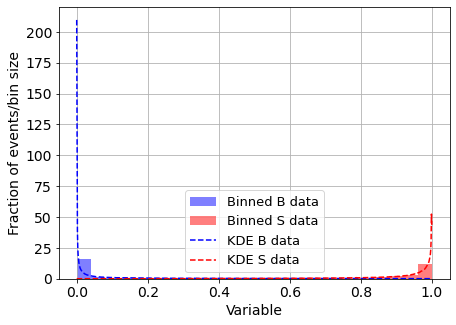

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  1%|▏                                | 15/2000 [00:17<36:50,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1865929143977252
<p_{s}(Sdata)> = 8.300538576450014
<p_{b}(Bdata)> = 77.40744736885381
<p_{s}(Bdata)> = 0.2092309232529349


  2%|▊                                | 50/2000 [01:02<38:10,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19159703039499573
<p_{s}(Sdata)> = 8.508851805668195
<p_{b}(Bdata)> = 78.02453688519213
<p_{s}(Bdata)> = 0.21240741053710419


  3%|▉                                | 60/2000 [01:18<43:56,  1.36s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1963274007124796
<p_{s}(Sdata)> = 7.803649385014081
<p_{b}(Bdata)> = 77.09937320189725
<p_{s}(Bdata)> = 0.21167996741948836


  4%|█▏                               | 72/2000 [01:34<35:14,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17055034404520042
<p_{s}(Sdata)> = 11.758458531876435
<p_{b}(Bdata)> = 77.15088338145593
<p_{s}(Bdata)> = 0.20965355798828966


  4%|█▍                               | 88/2000 [01:55<40:30,  1.27s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19539182359084434
<p_{s}(Sdata)> = 12.179034572905046
<p_{b}(Bdata)> = 76.93292901084871
<p_{s}(Bdata)> = 0.2116870155245605


  5%|█▌                               | 91/2000 [01:58<28:23,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17813285094381162
<p_{s}(Sdata)> = 8.929935066401256
<p_{b}(Bdata)> = 77.4026033254445
<p_{s}(Bdata)> = 0.2124461270914012


  5%|█▋                               | 99/2000 [02:07<30:16,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1878243208301169
<p_{s}(Sdata)> = 7.141842854271846
<p_{b}(Bdata)> = 77.0842266063486
<p_{s}(Bdata)> = 0.21267401252456408


  5%|█▋                              | 108/2000 [02:19<33:59,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2200697330810188
<p_{s}(Sdata)> = 8.211810520962946
<p_{b}(Bdata)> = 77.58700494124332
<p_{s}(Bdata)> = 0.21416843109855735


  6%|█▉                              | 121/2000 [02:35<33:40,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21989169643128842
<p_{s}(Sdata)> = 10.06241749847098
<p_{b}(Bdata)> = 77.19782005692116
<p_{s}(Bdata)> = 0.21207751638512082


  6%|█▉                              | 123/2000 [02:37<31:15,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16505411179457094
<p_{s}(Sdata)> = 12.824103556998292
<p_{b}(Bdata)> = 77.05861388209914
<p_{s}(Bdata)> = 0.21092650386563502


  6%|██                              | 127/2000 [02:43<36:09,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23062901515656725
<p_{s}(Sdata)> = 7.137420881649167
<p_{b}(Bdata)> = 76.92503829364594
<p_{s}(Bdata)> = 0.2125303190772914


  8%|██▌                             | 157/2000 [03:18<29:21,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2291358346602437
<p_{s}(Sdata)> = 7.190605259995668
<p_{b}(Bdata)> = 76.93919173027155
<p_{s}(Bdata)> = 0.21142957655020955


  8%|██▌                             | 158/2000 [03:19<23:44,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24253130856898644
<p_{s}(Sdata)> = 7.635982339069851
<p_{b}(Bdata)> = 77.4219044765598
<p_{s}(Bdata)> = 0.21378936500502688


  8%|██▌                             | 159/2000 [03:19<19:46,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21982704304552494
<p_{s}(Sdata)> = 7.377738340572217
<p_{b}(Bdata)> = 77.13358456637093
<p_{s}(Bdata)> = 0.2102116161244218


  9%|██▉                             | 180/2000 [03:47<27:33,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20033726817017064
<p_{s}(Sdata)> = 10.735609541999729
<p_{b}(Bdata)> = 77.08222932114094
<p_{s}(Bdata)> = 0.21199759081168226


  9%|██▉                             | 187/2000 [03:56<32:56,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.26178244857600663
<p_{s}(Sdata)> = 8.041833065965884
<p_{b}(Bdata)> = 77.15739801469762
<p_{s}(Bdata)> = 0.20945572859925735


 11%|███▍                            | 215/2000 [04:31<28:17,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20274168124478717
<p_{s}(Sdata)> = 6.876680830965778
<p_{b}(Bdata)> = 77.28509042413437
<p_{s}(Bdata)> = 0.21134275781603726


 11%|███▌                            | 226/2000 [04:45<32:44,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20029276011323127
<p_{s}(Sdata)> = 9.475079598951263
<p_{b}(Bdata)> = 76.98198347341352
<p_{s}(Bdata)> = 0.2133073545514078


 12%|███▋                            | 232/2000 [04:51<30:04,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1857844748540019
<p_{s}(Sdata)> = 8.409669957452712
<p_{b}(Bdata)> = 77.35349721541333
<p_{s}(Bdata)> = 0.21571173844618918


 13%|████                            | 254/2000 [05:16<26:04,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.409367715888002
<p_{s}(Sdata)> = 8.76648778395804
<p_{b}(Bdata)> = 77.75026777751656
<p_{s}(Bdata)> = 0.21195708432987842


 15%|████▋                           | 296/2000 [06:14<25:37,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23718674951557597
<p_{s}(Sdata)> = 9.517434530239454
<p_{b}(Bdata)> = 77.18923834757709
<p_{s}(Bdata)> = 0.21003975792262466


 15%|████▊                           | 297/2000 [06:15<20:53,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1746535729096105
<p_{s}(Sdata)> = 9.905398955339678
<p_{b}(Bdata)> = 77.61461967396616
<p_{s}(Bdata)> = 0.21271727413030225


 16%|████▉                           | 312/2000 [06:35<26:07,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17223273573539016
<p_{s}(Sdata)> = 11.424525679990374
<p_{b}(Bdata)> = 77.0839214766798
<p_{s}(Bdata)> = 0.20674490045474625


 16%|█████                           | 318/2000 [06:42<27:52,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19984170300930293
<p_{s}(Sdata)> = 7.651314487741081
<p_{b}(Bdata)> = 77.04029363097732
<p_{s}(Bdata)> = 0.21370991653968097


 16%|█████                           | 320/2000 [06:43<23:32,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18476769589425993
<p_{s}(Sdata)> = 6.394602694800347
<p_{b}(Bdata)> = 77.02751775857215
<p_{s}(Bdata)> = 0.21414049701083177


 18%|█████▋                          | 355/2000 [07:25<24:26,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18568589642735703
<p_{s}(Sdata)> = 8.213989426123996
<p_{b}(Bdata)> = 77.21691509785707
<p_{s}(Bdata)> = 0.2126073996464381


 18%|█████▋                          | 356/2000 [07:26<19:53,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21349565487024463
<p_{s}(Sdata)> = 7.799618510827667
<p_{b}(Bdata)> = 77.08399230622071
<p_{s}(Bdata)> = 0.21221073502545962


 18%|█████▉                          | 368/2000 [07:43<29:47,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3046206349168247
<p_{s}(Sdata)> = 7.831785264245933
<p_{b}(Bdata)> = 77.69297807589369
<p_{s}(Bdata)> = 0.21395866446532316


 20%|██████▎                         | 398/2000 [08:24<27:20,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18286687920429606
<p_{s}(Sdata)> = 10.875400170180624
<p_{b}(Bdata)> = 77.2569596211616
<p_{s}(Bdata)> = 0.21127517680188457


 21%|██████▊                         | 424/2000 [08:57<29:54,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1946685228274996
<p_{s}(Sdata)> = 10.558834623058049
<p_{b}(Bdata)> = 77.3643994418905
<p_{s}(Bdata)> = 0.21007957513722264


 23%|███████▎                        | 460/2000 [09:46<28:06,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16680234371583527
<p_{s}(Sdata)> = 13.317653774569633
<p_{b}(Bdata)> = 77.2533576271422
<p_{s}(Bdata)> = 0.20669663569567379


 24%|███████▊                        | 490/2000 [10:20<19:59,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18968436932815894
<p_{s}(Sdata)> = 7.474683449594996
<p_{b}(Bdata)> = 76.85236643048341
<p_{s}(Bdata)> = 0.21468032809106488


 25%|███████▊                        | 491/2000 [10:20<16:34,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19555582374805783
<p_{s}(Sdata)> = 7.334994249131946
<p_{b}(Bdata)> = 77.18340473768416
<p_{s}(Bdata)> = 0.2137711866544718


 26%|████████▎                       | 516/2000 [10:51<25:13,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18982044181934896
<p_{s}(Sdata)> = 8.980153427992674
<p_{b}(Bdata)> = 77.58848479314044
<p_{s}(Bdata)> = 0.20845741153852973


 27%|████████▊                       | 549/2000 [11:36<24:12,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18288486052765718
<p_{s}(Sdata)> = 8.354331413777278
<p_{b}(Bdata)> = 76.85011239464404
<p_{s}(Bdata)> = 0.2126545566890787


 28%|████████▊                       | 551/2000 [11:37<19:30,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19081334700096864
<p_{s}(Sdata)> = 10.403762711931035
<p_{b}(Bdata)> = 77.31489134721815
<p_{s}(Bdata)> = 0.20936722945235917


 28%|█████████                       | 564/2000 [11:55<28:14,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16971360953852446
<p_{s}(Sdata)> = 8.537948928797912
<p_{b}(Bdata)> = 76.718197389615
<p_{s}(Bdata)> = 0.21512906663837975


 29%|█████████▏                      | 573/2000 [12:06<26:39,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23670295122037194
<p_{s}(Sdata)> = 6.809279284066068
<p_{b}(Bdata)> = 77.10664893665972
<p_{s}(Bdata)> = 0.21384060748304268


 29%|█████████▏                      | 574/2000 [12:06<21:05,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1674299929921924
<p_{s}(Sdata)> = 12.269253100727692
<p_{b}(Bdata)> = 77.49485681613344
<p_{s}(Bdata)> = 0.20940569812277104


 30%|█████████▌                      | 597/2000 [12:34<21:32,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21296958441843739
<p_{s}(Sdata)> = 8.521615260751787
<p_{b}(Bdata)> = 76.96982898787613
<p_{s}(Bdata)> = 0.21147501826387313


 30%|█████████▋                      | 604/2000 [12:40<16:49,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2056132185444227
<p_{s}(Sdata)> = 8.813696978435006
<p_{b}(Bdata)> = 77.03026469780625
<p_{s}(Bdata)> = 0.2156349698597957


 31%|█████████▉                      | 623/2000 [13:03<24:10,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.15626517290765182
<p_{s}(Sdata)> = 12.57439670957242
<p_{b}(Bdata)> = 77.62607228550249
<p_{s}(Bdata)> = 0.21204785251003358


 31%|██████████                      | 625/2000 [13:05<21:48,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5730064032149772
<p_{s}(Sdata)> = 8.018815374576208
<p_{b}(Bdata)> = 77.14979912207826
<p_{s}(Bdata)> = 0.21392990948397989


 32%|██████████▎                     | 641/2000 [13:26<25:37,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23151953325913951
<p_{s}(Sdata)> = 5.857311260384788
<p_{b}(Bdata)> = 77.01699926097332
<p_{s}(Bdata)> = 0.21760047312891023


 33%|██████████▍                     | 651/2000 [13:39<23:22,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21559955124545238
<p_{s}(Sdata)> = 4.967878059925472
<p_{b}(Bdata)> = 77.06385383783399
<p_{s}(Bdata)> = 0.2121178301226675


 33%|██████████▌                     | 657/2000 [13:47<26:42,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4476407226858368
<p_{s}(Sdata)> = 9.949678264078463
<p_{b}(Bdata)> = 76.87988068867041
<p_{s}(Bdata)> = 0.21105005130506668


 34%|██████████▋                     | 670/2000 [14:04<24:39,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1891750692535029
<p_{s}(Sdata)> = 8.223056799549932
<p_{b}(Bdata)> = 77.61184029769511
<p_{s}(Bdata)> = 0.21128509437992293


 34%|██████████▉                     | 681/2000 [14:16<21:25,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.322810072905835
<p_{s}(Sdata)> = 5.4435898941958865
<p_{b}(Bdata)> = 76.8747836063864
<p_{s}(Bdata)> = 0.21402793202767392


 34%|███████████                     | 689/2000 [14:26<21:25,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18148097717212325
<p_{s}(Sdata)> = 10.138231198104927
<p_{b}(Bdata)> = 77.23695463876066
<p_{s}(Bdata)> = 0.21381784034137613


 35%|███████████▎                    | 706/2000 [14:48<24:41,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18636281209026495
<p_{s}(Sdata)> = 10.360360936405497
<p_{b}(Bdata)> = 77.18250966902309
<p_{s}(Bdata)> = 0.2131071016492237


 35%|███████████▎                    | 707/2000 [14:48<19:30,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19068514667349074
<p_{s}(Sdata)> = 9.305936396118081
<p_{b}(Bdata)> = 77.24701086853753
<p_{s}(Bdata)> = 0.21067206896939197


 36%|███████████▍                    | 716/2000 [14:58<23:07,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.31077316688047235
<p_{s}(Sdata)> = 8.944929725064975
<p_{b}(Bdata)> = 77.42466550697343
<p_{s}(Bdata)> = 0.21010886418157157


 36%|███████████▌                    | 722/2000 [15:04<18:35,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21979311149141373
<p_{s}(Sdata)> = 8.16010054205355
<p_{b}(Bdata)> = 77.25590195756016
<p_{s}(Bdata)> = 0.21580271344746366


 36%|███████████▋                    | 729/2000 [15:13<22:14,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1957404997643482
<p_{s}(Sdata)> = 8.068617331837288
<p_{b}(Bdata)> = 77.47373256849286
<p_{s}(Bdata)> = 0.21453883241754101


 37%|███████████▊                    | 740/2000 [15:26<24:04,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18568879674914784
<p_{s}(Sdata)> = 7.359802097952294
<p_{b}(Bdata)> = 77.32924864341827
<p_{s}(Bdata)> = 0.21036077603731096


 37%|███████████▉                    | 743/2000 [15:29<19:26,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1808123992488431
<p_{s}(Sdata)> = 8.875580461379355
<p_{b}(Bdata)> = 77.28020024900678
<p_{s}(Bdata)> = 0.21180165401529635


 37%|███████████▉                    | 744/2000 [15:29<15:44,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21639837823099314
<p_{s}(Sdata)> = 8.418585039864292
<p_{b}(Bdata)> = 77.3330296442332
<p_{s}(Bdata)> = 0.21449468513776612


 38%|████████████▏                   | 762/2000 [15:51<22:30,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2044869950234753
<p_{s}(Sdata)> = 7.552677625604338
<p_{b}(Bdata)> = 76.84632790088541
<p_{s}(Bdata)> = 0.21556340639955565


 38%|████████████▎                   | 770/2000 [16:02<24:35,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25409345173661185
<p_{s}(Sdata)> = 8.087728789240172
<p_{b}(Bdata)> = 76.80538033148962
<p_{s}(Bdata)> = 0.2093079491743614


 40%|████████████▊                   | 800/2000 [16:43<17:39,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18868768890012516
<p_{s}(Sdata)> = 6.774947548575852
<p_{b}(Bdata)> = 76.80647817317134
<p_{s}(Bdata)> = 0.21267469078718332


 41%|█████████████▏                  | 823/2000 [17:14<21:45,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17011458488442652
<p_{s}(Sdata)> = 10.217304966745866
<p_{b}(Bdata)> = 76.80673997778433
<p_{s}(Bdata)> = 0.20951067432089837


 42%|█████████████▎                  | 832/2000 [17:24<17:30,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17309995558505925
<p_{s}(Sdata)> = 10.343240779137137
<p_{b}(Bdata)> = 76.92062437374449
<p_{s}(Bdata)> = 0.21252584169762698


 42%|█████████████▎                  | 835/2000 [17:28<18:24,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1847681195658132
<p_{s}(Sdata)> = 8.567548087274014
<p_{b}(Bdata)> = 77.16468691640884
<p_{s}(Bdata)> = 0.21157464865151632


 42%|█████████████▌                  | 845/2000 [17:40<17:52,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19296847369215858
<p_{s}(Sdata)> = 6.280866360463024
<p_{b}(Bdata)> = 77.26810004718077
<p_{s}(Bdata)> = 0.2134926921882867


 42%|█████████████▌                  | 849/2000 [17:43<16:10,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25993675572829605
<p_{s}(Sdata)> = 8.184121272419317
<p_{b}(Bdata)> = 77.3541427296199
<p_{s}(Bdata)> = 0.21212479961689162


 44%|██████████████                  | 878/2000 [18:17<15:45,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18128200019713517
<p_{s}(Sdata)> = 11.121282766435561
<p_{b}(Bdata)> = 77.3636523510708
<p_{s}(Bdata)> = 0.21061028819276392


 44%|██████████████▏                 | 890/2000 [18:31<19:48,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19590383965742014
<p_{s}(Sdata)> = 10.586682136209035
<p_{b}(Bdata)> = 76.99008301069856
<p_{s}(Bdata)> = 0.21100709086638436


 46%|██████████████▋                 | 921/2000 [19:08<16:29,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18285004068732996
<p_{s}(Sdata)> = 9.448990695065286
<p_{b}(Bdata)> = 77.17867253033204
<p_{s}(Bdata)> = 0.2126927727153656


 46%|██████████████▊                 | 923/2000 [19:09<13:08,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1964692783163451
<p_{s}(Sdata)> = 8.05295065031034
<p_{b}(Bdata)> = 77.048697032118
<p_{s}(Bdata)> = 0.21287841405608798


 47%|██████████████▉                 | 932/2000 [19:18<15:32,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16465624999165518
<p_{s}(Sdata)> = 10.39520396049802
<p_{b}(Bdata)> = 77.37020260530599
<p_{s}(Bdata)> = 0.21291354224508124


 47%|███████████████                 | 941/2000 [19:29<17:16,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.175446956214478
<p_{s}(Sdata)> = 8.592376596951572
<p_{b}(Bdata)> = 77.39054984642016
<p_{s}(Bdata)> = 0.2136797195633965


 47%|███████████████▏                | 948/2000 [19:37<18:18,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23278292755459148
<p_{s}(Sdata)> = 7.180560657582614
<p_{b}(Bdata)> = 76.90042207010971
<p_{s}(Bdata)> = 0.20947225111704093


 48%|███████████████▏                | 952/2000 [19:40<14:09,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2047125968662204
<p_{s}(Sdata)> = 7.884808009619194
<p_{b}(Bdata)> = 76.97089011669729
<p_{s}(Bdata)> = 0.21177599739065828


 48%|███████████████▎                | 959/2000 [19:49<18:51,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23276061164943262
<p_{s}(Sdata)> = 8.137876911853276
<p_{b}(Bdata)> = 77.33127889868717
<p_{s}(Bdata)> = 0.211324929750277


 49%|███████████████▌                | 972/2000 [20:07<19:03,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19660526888391738
<p_{s}(Sdata)> = 7.020753826462364
<p_{b}(Bdata)> = 77.0031414226905
<p_{s}(Bdata)> = 0.21279993915170478


 52%|████████████████               | 1037/2000 [21:28<14:36,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1849525917139019
<p_{s}(Sdata)> = 8.945052233287889
<p_{b}(Bdata)> = 77.73151242204946
<p_{s}(Bdata)> = 0.20826901494672892


 53%|████████████████▍              | 1058/2000 [21:53<14:46,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1814310236341581
<p_{s}(Sdata)> = 8.019543218153883
<p_{b}(Bdata)> = 77.32914302695217
<p_{s}(Bdata)> = 0.21305160715905827


 53%|████████████████▍              | 1060/2000 [21:55<13:46,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21384346802643153
<p_{s}(Sdata)> = 8.139420484834899
<p_{b}(Bdata)> = 77.26237555808477
<p_{s}(Bdata)> = 0.21227765128647663


 54%|████████████████▌              | 1072/2000 [22:11<14:37,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22378075513710777
<p_{s}(Sdata)> = 8.315810145861844
<p_{b}(Bdata)> = 77.08541619644272
<p_{s}(Bdata)> = 0.21147360946379476


 54%|████████████████▊              | 1081/2000 [22:21<16:16,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18336653637684044
<p_{s}(Sdata)> = 7.71758150125542
<p_{b}(Bdata)> = 77.40120436586676
<p_{s}(Bdata)> = 0.2134544462805627


 55%|████████████████▉              | 1095/2000 [22:37<15:40,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19046583075499107
<p_{s}(Sdata)> = 12.358384996310287
<p_{b}(Bdata)> = 77.12409942883599
<p_{s}(Bdata)> = 0.2115843193229821


 55%|█████████████████▏             | 1107/2000 [22:51<14:41,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19352730945486174
<p_{s}(Sdata)> = 7.428259909211983
<p_{b}(Bdata)> = 77.60200305748229
<p_{s}(Bdata)> = 0.21450543925239787


 55%|█████████████████▏             | 1109/2000 [22:53<13:26,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.541680803517435
<p_{s}(Sdata)> = 8.236326528935445
<p_{b}(Bdata)> = 77.2367427414603
<p_{s}(Bdata)> = 0.21340377704183336


 56%|█████████████████▍             | 1123/2000 [23:06<13:25,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18792765606697476
<p_{s}(Sdata)> = 7.2318283908630745
<p_{b}(Bdata)> = 77.04110729931762
<p_{s}(Bdata)> = 0.21260188124646878


 57%|█████████████████▋             | 1143/2000 [23:30<14:17,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5228250706788579
<p_{s}(Sdata)> = 8.749239433973017
<p_{b}(Bdata)> = 77.3634820161223
<p_{s}(Bdata)> = 0.20795767801476553


 57%|█████████████████▋             | 1144/2000 [23:31<11:21,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1787772422723186
<p_{s}(Sdata)> = 8.626582399015351
<p_{b}(Bdata)> = 77.21876257066808
<p_{s}(Bdata)> = 0.21010734071509618


 59%|██████████████████▏            | 1174/2000 [24:03<13:20,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17700739399856075
<p_{s}(Sdata)> = 12.87787435140673
<p_{b}(Bdata)> = 77.28052768140763
<p_{s}(Bdata)> = 0.20768555662664584


 59%|██████████████████▏            | 1176/2000 [24:06<13:27,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18361882284842643
<p_{s}(Sdata)> = 9.218715253110677
<p_{b}(Bdata)> = 77.38110041018138
<p_{s}(Bdata)> = 0.21029865934502087


 61%|██████████████████▊            | 1211/2000 [24:46<13:04,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20800038014626013
<p_{s}(Sdata)> = 8.599989046637017
<p_{b}(Bdata)> = 77.02912562315525
<p_{s}(Bdata)> = 0.2118653777767872


 62%|███████████████████▎           | 1244/2000 [25:24<11:49,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18625983773811364
<p_{s}(Sdata)> = 9.002544248973445
<p_{b}(Bdata)> = 77.26273289726025
<p_{s}(Bdata)> = 0.2136874537376957


 62%|███████████████████▎           | 1245/2000 [25:24<09:30,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.177763759095355
<p_{s}(Sdata)> = 8.061261428548827
<p_{b}(Bdata)> = 76.64860420336795
<p_{s}(Bdata)> = 0.21037060515206746


 63%|███████████████████▍           | 1252/2000 [25:33<11:53,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19684033772925003
<p_{s}(Sdata)> = 7.310649207223688
<p_{b}(Bdata)> = 77.63543851530926
<p_{s}(Bdata)> = 0.21118268732428275


 63%|███████████████████▌           | 1264/2000 [25:45<11:46,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17424419211171804
<p_{s}(Sdata)> = 10.099681629287415
<p_{b}(Bdata)> = 77.2191168219284
<p_{s}(Bdata)> = 0.21202091755009633


 63%|███████████████████▌           | 1265/2000 [25:46<09:24,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6985255258696296
<p_{s}(Sdata)> = 7.918329867492364
<p_{b}(Bdata)> = 77.35621304708425
<p_{s}(Bdata)> = 0.21466796260028423


 64%|███████████████████▋           | 1270/2000 [25:52<12:16,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22316531771995463
<p_{s}(Sdata)> = 6.162299359878583
<p_{b}(Bdata)> = 77.28897258652265
<p_{s}(Bdata)> = 0.2111904522672007


 64%|███████████████████▉           | 1289/2000 [26:16<11:41,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1927227013919719
<p_{s}(Sdata)> = 9.109687919007472
<p_{b}(Bdata)> = 77.2408458583146
<p_{s}(Bdata)> = 0.20941908903584566


 66%|████████████████████▎          | 1311/2000 [26:41<10:37,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19529016694942944
<p_{s}(Sdata)> = 7.374734855207956
<p_{b}(Bdata)> = 77.38236629982347
<p_{s}(Bdata)> = 0.21583274460924382


 66%|████████████████████▌          | 1325/2000 [26:59<10:01,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.176859319855368
<p_{s}(Sdata)> = 11.713067922907646
<p_{b}(Bdata)> = 77.19641401065113
<p_{s}(Bdata)> = 0.210260994457052


 67%|████████████████████▋          | 1331/2000 [27:06<11:31,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17269268368938442
<p_{s}(Sdata)> = 11.429459489885613
<p_{b}(Bdata)> = 77.23586416196017
<p_{s}(Bdata)> = 0.2058594238901567


 67%|████████████████████▋          | 1335/2000 [27:10<10:16,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3712316376285203
<p_{s}(Sdata)> = 6.352021505049591
<p_{b}(Bdata)> = 77.1602707004167
<p_{s}(Bdata)> = 0.21258889998284522


 68%|█████████████████████          | 1359/2000 [27:36<09:26,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17937072496669298
<p_{s}(Sdata)> = 9.146164514500933
<p_{b}(Bdata)> = 77.31634748984597
<p_{s}(Bdata)> = 0.21368326681999572


 68%|█████████████████████          | 1362/2000 [27:39<09:47,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20666114388571824
<p_{s}(Sdata)> = 7.657124956801092
<p_{b}(Bdata)> = 77.28726437927615
<p_{s}(Bdata)> = 0.21209767651078115


 69%|█████████████████████▎         | 1374/2000 [27:53<12:03,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25700996815405963
<p_{s}(Sdata)> = 7.6460988424632506
<p_{b}(Bdata)> = 77.32616361945014
<p_{s}(Bdata)> = 0.20951800616581398


 69%|█████████████████████▎         | 1376/2000 [27:56<11:04,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16585508426212303
<p_{s}(Sdata)> = 10.924118463000703
<p_{b}(Bdata)> = 77.31373102635233
<p_{s}(Bdata)> = 0.21273003486446543


 69%|█████████████████████▍         | 1383/2000 [28:02<08:05,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20476145191118048
<p_{s}(Sdata)> = 8.5086696956821
<p_{b}(Bdata)> = 76.54791724906775
<p_{s}(Bdata)> = 0.2124545071656888


 69%|█████████████████████▍         | 1384/2000 [28:02<06:38,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30085543973915857
<p_{s}(Sdata)> = 8.76746217526332
<p_{b}(Bdata)> = 77.26814632355111
<p_{s}(Bdata)> = 0.21053846708543916


 70%|█████████████████████▌         | 1393/2000 [28:14<12:07,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24068693350351342
<p_{s}(Sdata)> = 8.34807477683689
<p_{b}(Bdata)> = 76.72758640043266
<p_{s}(Bdata)> = 0.2099592196547228


 70%|█████████████████████▊         | 1406/2000 [28:30<09:21,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.208610253196855
<p_{s}(Sdata)> = 8.74480402806855
<p_{b}(Bdata)> = 77.35771473407583
<p_{s}(Bdata)> = 0.2139404587849067


 71%|█████████████████████▉         | 1413/2000 [28:37<07:50,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17971077441850944
<p_{s}(Sdata)> = 8.912652065571173
<p_{b}(Bdata)> = 77.43251458599843
<p_{s}(Bdata)> = 0.2101375157740464


 71%|██████████████████████▏        | 1428/2000 [28:56<11:42,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17822485415050712
<p_{s}(Sdata)> = 8.379128388032115
<p_{b}(Bdata)> = 77.46902773879282
<p_{s}(Bdata)> = 0.21400828772981909


 72%|██████████████████████▎        | 1438/2000 [29:08<09:27,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1903771596077704
<p_{s}(Sdata)> = 6.620071374287061
<p_{b}(Bdata)> = 77.3023488160704
<p_{s}(Bdata)> = 0.21205206081890274


 72%|██████████████████████▍        | 1445/2000 [29:14<07:54,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18412677969486868
<p_{s}(Sdata)> = 7.29854393139794
<p_{b}(Bdata)> = 77.74865817224841
<p_{s}(Bdata)> = 0.2105315800758024


 72%|██████████████████████▍        | 1446/2000 [29:15<06:24,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18540594666784188
<p_{s}(Sdata)> = 6.4158263556697
<p_{b}(Bdata)> = 76.63328785087577
<p_{s}(Bdata)> = 0.21261608977770538


 73%|██████████████████████▋        | 1462/2000 [29:34<08:20,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19223802304563953
<p_{s}(Sdata)> = 10.736369430281938
<p_{b}(Bdata)> = 76.83948526811034
<p_{s}(Bdata)> = 0.2111165160307136


 73%|██████████████████████▋        | 1464/2000 [29:36<07:15,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20632905796918372
<p_{s}(Sdata)> = 6.707749310925655
<p_{b}(Bdata)> = 76.80624388922885
<p_{s}(Bdata)> = 0.2120103869943411


 74%|██████████████████████▊        | 1475/2000 [29:48<09:02,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.190207709124265
<p_{s}(Sdata)> = 10.59280632125956
<p_{b}(Bdata)> = 76.85074398075983
<p_{s}(Bdata)> = 0.21004891217141292


 74%|██████████████████████▉        | 1482/2000 [29:57<08:04,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.187702798367107
<p_{s}(Sdata)> = 10.075994045197552
<p_{b}(Bdata)> = 77.56008670421085
<p_{s}(Bdata)> = 0.21273388539746438


 74%|███████████████████████        | 1484/2000 [29:58<06:09,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21003621706714407
<p_{s}(Sdata)> = 5.878262507710671
<p_{b}(Bdata)> = 77.59082608714425
<p_{s}(Bdata)> = 0.20893772131629892


 74%|███████████████████████        | 1485/2000 [29:58<05:07,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2097553014056423
<p_{s}(Sdata)> = 6.916039947942907
<p_{b}(Bdata)> = 77.07391447954808
<p_{s}(Bdata)> = 0.21183612616119718


 74%|███████████████████████        | 1490/2000 [30:04<07:10,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20389705072730743
<p_{s}(Sdata)> = 9.81333364478314
<p_{b}(Bdata)> = 76.7407966757446
<p_{s}(Bdata)> = 0.2131431390969761


 75%|███████████████████████        | 1491/2000 [30:05<05:50,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28647173284165683
<p_{s}(Sdata)> = 6.703877581372632
<p_{b}(Bdata)> = 76.9186399350944
<p_{s}(Bdata)> = 0.2136821422172592


 76%|███████████████████████▍       | 1510/2000 [30:26<06:21,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22171258774743374
<p_{s}(Sdata)> = 7.8602217521256765
<p_{b}(Bdata)> = 76.63616290688311
<p_{s}(Bdata)> = 0.21469458638601963


 76%|███████████████████████▌       | 1519/2000 [30:37<09:07,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17601364344741385
<p_{s}(Sdata)> = 12.528638244387945
<p_{b}(Bdata)> = 77.56189616737264
<p_{s}(Bdata)> = 0.2105913107126283


 76%|███████████████████████▌       | 1521/2000 [30:39<06:53,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1957591155940583
<p_{s}(Sdata)> = 7.5417869716535115
<p_{b}(Bdata)> = 77.38174214337258
<p_{s}(Bdata)> = 0.21219810080334237


 76%|███████████████████████▋       | 1527/2000 [30:47<09:03,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17832351215304987
<p_{s}(Sdata)> = 9.527550133379703
<p_{b}(Bdata)> = 77.51870380147156
<p_{s}(Bdata)> = 0.2110646678198956


 77%|███████████████████████▊       | 1533/2000 [30:52<06:08,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20287263669067684
<p_{s}(Sdata)> = 8.217142043343387
<p_{b}(Bdata)> = 77.30892884193952
<p_{s}(Bdata)> = 0.2139691572241583


 77%|███████████████████████▊       | 1535/2000 [30:54<06:01,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21248081327591717
<p_{s}(Sdata)> = 8.860065616692273
<p_{b}(Bdata)> = 77.30199734901156
<p_{s}(Bdata)> = 0.20904919590873186


 78%|████████████████████████▎      | 1565/2000 [31:29<05:44,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.319190531202137
<p_{s}(Sdata)> = 9.001647245215326
<p_{b}(Bdata)> = 77.06868888155259
<p_{s}(Bdata)> = 0.21146762230265637


 78%|████████████████████████▎      | 1566/2000 [31:29<04:41,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19224469804470382
<p_{s}(Sdata)> = 11.138380823252188
<p_{b}(Bdata)> = 76.77923945330875
<p_{s}(Bdata)> = 0.21242663586417074


 79%|████████████████████████▌      | 1588/2000 [31:56<07:10,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3983716598390087
<p_{s}(Sdata)> = 12.245004648790427
<p_{b}(Bdata)> = 77.27552094749271
<p_{s}(Bdata)> = 0.20877751741652986


 80%|████████████████████████▊      | 1602/2000 [32:10<05:56,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33662691055048116
<p_{s}(Sdata)> = 7.647651517433833
<p_{b}(Bdata)> = 76.95993298736153
<p_{s}(Bdata)> = 0.21260898252230975


 80%|████████████████████████▉      | 1606/2000 [32:14<05:16,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18549014924337792
<p_{s}(Sdata)> = 6.894506652073336
<p_{b}(Bdata)> = 77.0599688287888
<p_{s}(Bdata)> = 0.21414393050217922


 80%|████████████████████████▉      | 1607/2000 [32:14<04:18,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1831426555479616
<p_{s}(Sdata)> = 8.018215918769
<p_{b}(Bdata)> = 77.19333811359611
<p_{s}(Bdata)> = 0.21441065720342986


 80%|████████████████████████▉      | 1608/2000 [32:14<03:38,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18430828033229632
<p_{s}(Sdata)> = 9.064906399414614
<p_{b}(Bdata)> = 76.88463323528836
<p_{s}(Bdata)> = 0.21079133463610977


 81%|████████████████████████▉      | 1611/2000 [32:17<04:25,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1637083282030357
<p_{s}(Sdata)> = 11.449818034922687
<p_{b}(Bdata)> = 77.14817023738475
<p_{s}(Bdata)> = 0.20998416496428526


 82%|█████████████████████████▍     | 1643/2000 [32:54<05:23,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2903029879603059
<p_{s}(Sdata)> = 10.894357752299845
<p_{b}(Bdata)> = 77.14505751832893
<p_{s}(Bdata)> = 0.21094860333158044


 82%|█████████████████████████▌     | 1648/2000 [33:00<05:32,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20173005522819612
<p_{s}(Sdata)> = 7.698309484473469
<p_{b}(Bdata)> = 77.72918400167542
<p_{s}(Bdata)> = 0.21236370769641721


 83%|█████████████████████████▊     | 1663/2000 [33:16<05:31,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18878437690819191
<p_{s}(Sdata)> = 9.891440057334533
<p_{b}(Bdata)> = 76.98745445380746
<p_{s}(Bdata)> = 0.2162090034566981


 84%|██████████████████████████     | 1683/2000 [33:40<04:53,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18187824628043398
<p_{s}(Sdata)> = 6.5457220547506685
<p_{b}(Bdata)> = 77.54428119560413
<p_{s}(Bdata)> = 0.21243740439501785


 84%|██████████████████████████     | 1684/2000 [33:41<03:54,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22468763693020974
<p_{s}(Sdata)> = 10.811188743675517
<p_{b}(Bdata)> = 76.98912118456887
<p_{s}(Bdata)> = 0.2139531448320755


 86%|██████████████████████████▌    | 1715/2000 [34:15<04:11,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18504346339997443
<p_{s}(Sdata)> = 9.361187520736461
<p_{b}(Bdata)> = 77.03265617543886
<p_{s}(Bdata)> = 0.21411097241853227


 88%|███████████████████████████▏   | 1756/2000 [35:08<04:03,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0152428510768627
<p_{s}(Sdata)> = 6.761652595421971
<p_{b}(Bdata)> = 77.65940714474685
<p_{s}(Bdata)> = 0.21299247924196454


 88%|███████████████████████████▎   | 1759/2000 [35:11<03:41,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15798837823366368
<p_{s}(Sdata)> = 11.48665604145231
<p_{b}(Bdata)> = 78.08462817419253
<p_{s}(Bdata)> = 0.20762133829496254


 88%|███████████████████████████▎   | 1761/2000 [35:12<03:03,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23874680130287068
<p_{s}(Sdata)> = 9.018766892971545
<p_{b}(Bdata)> = 77.06264392074422
<p_{s}(Bdata)> = 0.2118640870865221


 89%|███████████████████████████▌   | 1775/2000 [35:30<03:46,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1829299264643923
<p_{s}(Sdata)> = 8.669778807608449
<p_{b}(Bdata)> = 76.47888037283263
<p_{s}(Bdata)> = 0.2138239738611573


 89%|███████████████████████████▌   | 1777/2000 [35:31<02:58,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1904839854697697
<p_{s}(Sdata)> = 10.226689605035336
<p_{b}(Bdata)> = 77.67583081505423
<p_{s}(Bdata)> = 0.20636388692014024


 90%|███████████████████████████▋   | 1790/2000 [35:47<03:12,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2230556457772274
<p_{s}(Sdata)> = 6.641591956944246
<p_{b}(Bdata)> = 77.79986001791792
<p_{s}(Bdata)> = 0.21333363392703195


 90%|████████████████████████████   | 1807/2000 [36:10<02:55,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20628796568129362
<p_{s}(Sdata)> = 7.8638977581148115
<p_{b}(Bdata)> = 76.89182793800869
<p_{s}(Bdata)> = 0.2144071376133372


 92%|████████████████████████████▌  | 1839/2000 [36:49<02:16,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23264455626969174
<p_{s}(Sdata)> = 9.709808102865841
<p_{b}(Bdata)> = 76.52299489350543
<p_{s}(Bdata)> = 0.21264825954598676


 92%|████████████████████████████▌  | 1842/2000 [36:52<02:22,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18324117288155403
<p_{s}(Sdata)> = 8.85088795015184
<p_{b}(Bdata)> = 77.26957171596406
<p_{s}(Bdata)> = 0.2120211061118918


 93%|████████████████████████████▊  | 1856/2000 [37:10<02:23,  1.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1681858651559678
<p_{s}(Sdata)> = 13.098746010266563
<p_{b}(Bdata)> = 77.07076267750563
<p_{s}(Bdata)> = 0.22329489968729624


 93%|████████████████████████████▉  | 1865/2000 [37:21<02:29,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1791075134621436
<p_{s}(Sdata)> = 9.090473128363561
<p_{b}(Bdata)> = 77.18185813257769
<p_{s}(Bdata)> = 0.21235853607016075


 93%|████████████████████████████▉  | 1867/2000 [37:22<01:56,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24733378456228106
<p_{s}(Sdata)> = 8.205148549591408
<p_{b}(Bdata)> = 77.37697406264458
<p_{s}(Bdata)> = 0.20910796014507496


 94%|█████████████████████████████  | 1877/2000 [37:35<02:22,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18212405977268814
<p_{s}(Sdata)> = 12.64597474427474
<p_{b}(Bdata)> = 77.28448571437949
<p_{s}(Bdata)> = 0.20932320111537914


 94%|█████████████████████████████▏ | 1880/2000 [37:38<01:57,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20791012466269523
<p_{s}(Sdata)> = 7.484750627230871
<p_{b}(Bdata)> = 77.14258088664988
<p_{s}(Bdata)> = 0.21316936472191977


 94%|█████████████████████████████▎ | 1890/2000 [37:52<01:57,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1664881897695582
<p_{s}(Sdata)> = 11.075363085868414
<p_{b}(Bdata)> = 77.19800494116514
<p_{s}(Bdata)> = 0.21336539349543576


 95%|█████████████████████████████▎ | 1894/2000 [37:56<01:37,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20017904443411735
<p_{s}(Sdata)> = 7.826164771599764
<p_{b}(Bdata)> = 77.38126159843917
<p_{s}(Bdata)> = 0.21287146863087467


 95%|█████████████████████████████▌ | 1904/2000 [38:08<01:37,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19792642591532916
<p_{s}(Sdata)> = 10.233541688104559
<p_{b}(Bdata)> = 76.87187725203347
<p_{s}(Bdata)> = 0.20989161451992291


 95%|█████████████████████████████▌ | 1908/2000 [38:12<01:17,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.231567073246663
<p_{s}(Sdata)> = 7.93321841538689
<p_{b}(Bdata)> = 76.69871407860074
<p_{s}(Bdata)> = 0.2154544174517834


 96%|█████████████████████████████▌ | 1911/2000 [38:15<01:09,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1801739893104298
<p_{s}(Sdata)> = 10.073065905813788
<p_{b}(Bdata)> = 77.33547143140001
<p_{s}(Bdata)> = 0.21164880397607022


 96%|█████████████████████████████▊ | 1923/2000 [38:29<01:17,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17708869263920657
<p_{s}(Sdata)> = 10.375559992547121
<p_{b}(Bdata)> = 77.48373430646456
<p_{s}(Bdata)> = 0.2084924083634844


 97%|█████████████████████████████▉ | 1935/2000 [38:43<01:03,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1887645566033508
<p_{s}(Sdata)> = 8.132654465982473
<p_{b}(Bdata)> = 77.08235699088766
<p_{s}(Bdata)> = 0.21112844313659396


 97%|██████████████████████████████▏| 1946/2000 [38:55<00:57,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18849926353477367
<p_{s}(Sdata)> = 7.834702551710024
<p_{b}(Bdata)> = 77.5951169605308
<p_{s}(Bdata)> = 0.21246304498822102


 98%|██████████████████████████████▎| 1958/2000 [39:08<00:40,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18158291023478498
<p_{s}(Sdata)> = 8.153109794204514
<p_{b}(Bdata)> = 77.08725975843005
<p_{s}(Bdata)> = 0.21410343223874953


 99%|██████████████████████████████▌| 1974/2000 [39:27<00:25,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19253419336055166
<p_{s}(Sdata)> = 7.442236782484558
<p_{b}(Bdata)> = 77.78370939711735
<p_{s}(Bdata)> = 0.2127359842755023


100%|██████████████████████████████▉| 1997/2000 [39:57<00:02,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17905209395271354
<p_{s}(Sdata)> = 9.566074788740481
<p_{b}(Bdata)> = 76.9160743151242
<p_{s}(Bdata)> = 0.209469697613535


100%|███████████████████████████████| 2000/2000 [40:01<00:00,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1789360430715465
<p_{s}(Sdata)> = 8.217339988903193
<p_{b}(Bdata)> = 77.36805834321353
<p_{s}(Bdata)> = 0.21294050305351278
Z:1.4810494785887123
Z_std:1.1373770779240158
Z_1:1.1786654514835428
Z_std_1:2.0311464018793033
8


AUC:0.9697465785657262


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 23548.3825727  22646.36005141 21619.27265964 20458.24954581
 19171.74405801 17758.39813667 16221.03691188 14528.53186377
 12696.57024058 10691.03151709  8501.47337189  6142.74424446
  3590.20889586   863.73184911 -2052.12920879 -5078.61971867]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12919.52799427 12782.25100211 12577.28766645


<Figure size 432x288 with 0 Axes>

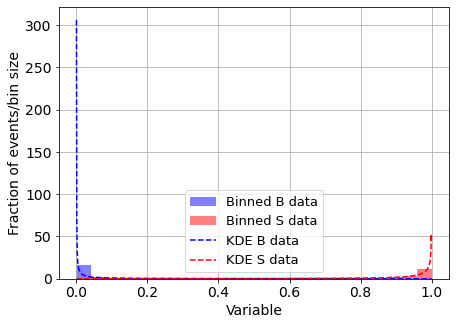

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                  | 5/2000 [00:06<36:10,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1837010968489246
<p_{s}(Sdata)> = 9.660637447174386
<p_{b}(Bdata)> = 104.63142690753227
<p_{s}(Bdata)> = 0.22517006214501903


  4%|█▍                               | 89/2000 [02:28<38:42,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14475941550626717
<p_{s}(Sdata)> = 14.197346968582426
<p_{b}(Bdata)> = 104.65707166214641
<p_{s}(Bdata)> = 0.22190917158858045


  5%|█▌                              | 100/2000 [02:46<43:24,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2485890011959277
<p_{s}(Sdata)> = 8.596566566721222
<p_{b}(Bdata)> = 104.37591004371143
<p_{s}(Bdata)> = 0.21343107577495066


  7%|██▏                             | 137/2000 [03:45<43:04,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.180824838998116
<p_{s}(Sdata)> = 8.795844542331373
<p_{b}(Bdata)> = 104.8338715125111
<p_{s}(Bdata)> = 0.21857942153723708


  7%|██▏                             | 138/2000 [03:46<33:11,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1668088774189881
<p_{s}(Sdata)> = 9.586532101074543
<p_{b}(Bdata)> = 104.97166628781922
<p_{s}(Bdata)> = 0.21436819825458076


  8%|██▋                             | 169/2000 [04:34<34:44,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16800284807297375
<p_{s}(Sdata)> = 12.728702720759724
<p_{b}(Bdata)> = 105.43850593794234
<p_{s}(Bdata)> = 0.22310326247894072


  9%|██▉                             | 187/2000 [05:04<35:16,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16078056839432306
<p_{s}(Sdata)> = 12.00077136166523
<p_{b}(Bdata)> = 105.3225690306538
<p_{s}(Bdata)> = 0.22286195305069667


 10%|███▎                            | 204/2000 [05:31<32:44,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1470945316997023
<p_{s}(Sdata)> = 14.968331389065096
<p_{b}(Bdata)> = 104.79787392815153
<p_{s}(Bdata)> = 0.21963816492413046


 11%|███▍                            | 214/2000 [05:44<39:23,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14647646283475216
<p_{s}(Sdata)> = 14.017060517953524
<p_{b}(Bdata)> = 105.44348689530753
<p_{s}(Bdata)> = 0.22343924025578019


 11%|███▍                            | 215/2000 [05:44<30:27,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17681273818645915
<p_{s}(Sdata)> = 10.759664231082093
<p_{b}(Bdata)> = 104.4518750129049
<p_{s}(Bdata)> = 0.21171791472721044


 11%|███▍                            | 216/2000 [05:44<24:11,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17558192759334526
<p_{s}(Sdata)> = 7.98069695761082
<p_{b}(Bdata)> = 104.76774111132487
<p_{s}(Bdata)> = 0.21709888550657613


 11%|███▌                            | 219/2000 [05:48<29:38,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2435397685660595
<p_{s}(Sdata)> = 6.565753021230306
<p_{b}(Bdata)> = 104.70915363608049
<p_{s}(Bdata)> = 0.21488684045043838


 12%|███▉                            | 245/2000 [06:32<34:17,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17608028159883343
<p_{s}(Sdata)> = 9.51728822126444
<p_{b}(Bdata)> = 104.63922989947878
<p_{s}(Bdata)> = 0.21666958043231638


 13%|████                            | 251/2000 [06:40<33:44,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17012031430586969
<p_{s}(Sdata)> = 10.936593860570321
<p_{b}(Bdata)> = 103.93740638268153
<p_{s}(Bdata)> = 0.22411634481677056


 13%|████▎                           | 266/2000 [07:05<37:18,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18258713543380975
<p_{s}(Sdata)> = 8.731765181948381
<p_{b}(Bdata)> = 105.07651888077967
<p_{s}(Bdata)> = 0.21357800948135747


 14%|████▍                           | 275/2000 [07:20<40:05,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19810602267004296
<p_{s}(Sdata)> = 9.3222795735444
<p_{b}(Bdata)> = 104.98776924493467
<p_{s}(Bdata)> = 0.22555153463186764


 15%|████▊                           | 304/2000 [08:08<38:42,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17826785566114375
<p_{s}(Sdata)> = 10.079431339301896
<p_{b}(Bdata)> = 105.17153809217167
<p_{s}(Bdata)> = 0.21116800809630218


 18%|█████▋                          | 354/2000 [09:31<35:44,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.177635304948188
<p_{s}(Sdata)> = 7.7019502383893235
<p_{b}(Bdata)> = 105.84241201995816
<p_{s}(Bdata)> = 0.21405038014434827


 18%|█████▋                          | 357/2000 [09:34<27:24,  1.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1735529175967399
<p_{s}(Sdata)> = 15.037947663361525
<p_{b}(Bdata)> = 104.37394767123908
<p_{s}(Bdata)> = 0.22321293575832413


 18%|█████▊                          | 361/2000 [09:38<24:49,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21418152436784876
<p_{s}(Sdata)> = 7.526004445130443
<p_{b}(Bdata)> = 104.83549668107862
<p_{s}(Bdata)> = 0.2155385067717633


 19%|██████                          | 379/2000 [10:07<37:59,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26723252200786984
<p_{s}(Sdata)> = 12.901385005736646
<p_{b}(Bdata)> = 104.39731078568809
<p_{s}(Bdata)> = 0.2253471216257028


 19%|██████▏                         | 388/2000 [10:18<25:30,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.176882708347172
<p_{s}(Sdata)> = 8.822287931526061
<p_{b}(Bdata)> = 105.53044530561559
<p_{s}(Bdata)> = 0.21489656405282903


 20%|██████▎                         | 393/2000 [10:26<32:59,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2093507789321408
<p_{s}(Sdata)> = 8.377966322668023
<p_{b}(Bdata)> = 104.82679355084049
<p_{s}(Bdata)> = 0.2245077572427962


 21%|██████▋                         | 418/2000 [11:05<27:21,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2021716855924885
<p_{s}(Sdata)> = 6.435420639557427
<p_{b}(Bdata)> = 105.55859708781152
<p_{s}(Bdata)> = 0.21522007048247077


 22%|███████                         | 443/2000 [11:42<31:08,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2106596891078228
<p_{s}(Sdata)> = 8.620721286219087
<p_{b}(Bdata)> = 104.37581597815678
<p_{s}(Bdata)> = 0.21121267747668943


 22%|███████▏                        | 450/2000 [11:53<33:15,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1946151834321614
<p_{s}(Sdata)> = 8.231098403250268
<p_{b}(Bdata)> = 104.69120582082685
<p_{s}(Bdata)> = 0.21454798871558553


 23%|███████▍                        | 462/2000 [12:09<32:05,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16483414151787543
<p_{s}(Sdata)> = 13.75131136353012
<p_{b}(Bdata)> = 104.78483066193004
<p_{s}(Bdata)> = 0.22722012562906863


 23%|███████▍                        | 466/2000 [12:14<26:07,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.21037163458811717
<p_{s}(Sdata)> = 9.28879467103456
<p_{b}(Bdata)> = 104.92428882476763
<p_{s}(Bdata)> = 0.21534575026057887


 24%|███████▌                        | 473/2000 [12:24<31:11,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 1.2934634595128072
<p_{s}(Sdata)> = 6.718566652756319
<p_{b}(Bdata)> = 104.95885263358507
<p_{s}(Bdata)> = 0.2153782548227487


 24%|███████▊                        | 490/2000 [12:49<24:56,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.199966535194211
<p_{s}(Sdata)> = 6.317924410555532
<p_{b}(Bdata)> = 104.31719334848106
<p_{s}(Bdata)> = 0.21810410401014016


 26%|████████▏                       | 511/2000 [13:20<29:17,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20076134339492344
<p_{s}(Sdata)> = 8.870587396831125
<p_{b}(Bdata)> = 105.75153720349329
<p_{s}(Bdata)> = 0.2248845483366734


 27%|████████▌                       | 532/2000 [13:49<26:58,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14784049053979148
<p_{s}(Sdata)> = 14.675876976360929
<p_{b}(Bdata)> = 105.33900834351834
<p_{s}(Bdata)> = 0.22206693037207317


 27%|████████▌                       | 533/2000 [13:49<22:13,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15216377076485677
<p_{s}(Sdata)> = 14.686891157237946
<p_{b}(Bdata)> = 104.33879298348627
<p_{s}(Bdata)> = 0.22200255939224842


 28%|████████▉                       | 556/2000 [14:21<33:14,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16505976717635232
<p_{s}(Sdata)> = 11.877708750976097
<p_{b}(Bdata)> = 104.47691440472484
<p_{s}(Bdata)> = 0.22382718291789577


 28%|████████▉                       | 559/2000 [14:26<31:19,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15875630902305446
<p_{s}(Sdata)> = 15.194193961889098
<p_{b}(Bdata)> = 104.79233049683651
<p_{s}(Bdata)> = 0.22074508211946572


 28%|████████▉                       | 562/2000 [14:30<29:12,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17466766248060023
<p_{s}(Sdata)> = 18.067777983385167
<p_{b}(Bdata)> = 104.77698290787806
<p_{s}(Bdata)> = 0.21968426453929432


 29%|█████████▎                      | 579/2000 [14:53<23:09,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1606162665146524
<p_{s}(Sdata)> = 11.465456515560984
<p_{b}(Bdata)> = 104.76502312654745
<p_{s}(Bdata)> = 0.21395767385336628


 29%|█████████▎                      | 581/2000 [14:55<22:45,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2709526664080283
<p_{s}(Sdata)> = 6.687748726750241
<p_{b}(Bdata)> = 104.95224761742608
<p_{s}(Bdata)> = 0.21536334695360973


 29%|█████████▎                      | 584/2000 [14:59<24:16,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18448733942010012
<p_{s}(Sdata)> = 7.3150812859476915
<p_{b}(Bdata)> = 105.60454972391963
<p_{s}(Bdata)> = 0.2156050784304898


 29%|█████████▍                      | 586/2000 [15:01<24:23,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15247392294655668
<p_{s}(Sdata)> = 15.082801555671532
<p_{b}(Bdata)> = 104.07889315692137
<p_{s}(Bdata)> = 0.2193460561072533


 30%|█████████▍                      | 591/2000 [15:07<24:44,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.15733854982955295
<p_{s}(Sdata)> = 13.055873716013815
<p_{b}(Bdata)> = 104.95982977913627
<p_{s}(Bdata)> = 0.22135243250857994


 30%|█████████▍                      | 592/2000 [15:07<20:34,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14608670965252096
<p_{s}(Sdata)> = 14.579783632865635
<p_{b}(Bdata)> = 105.09585490411818
<p_{s}(Bdata)> = 0.22122340121048384


 30%|█████████▋                      | 602/2000 [15:21<28:08,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.22044664423338117
<p_{s}(Sdata)> = 8.471062971119972
<p_{b}(Bdata)> = 105.30765270899165
<p_{s}(Bdata)> = 0.21353284813969894


 31%|█████████▊                      | 612/2000 [15:32<20:28,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.8894205519234099
<p_{s}(Sdata)> = 10.966253233340147
<p_{b}(Bdata)> = 104.79512588633432
<p_{s}(Bdata)> = 0.22251983581799592


 31%|█████████▉                      | 620/2000 [15:43<27:36,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16562609659874108
<p_{s}(Sdata)> = 13.278803882781087
<p_{b}(Bdata)> = 104.98210863021231
<p_{s}(Bdata)> = 0.22254861493403305


 32%|██████████▏                     | 636/2000 [16:06<27:47,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17143801456352106
<p_{s}(Sdata)> = 12.905066734702826
<p_{b}(Bdata)> = 104.59452552715437
<p_{s}(Bdata)> = 0.2240654513676578


 33%|██████████▍                     | 654/2000 [16:34<26:33,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1581710921667673
<p_{s}(Sdata)> = 12.485899026187607
<p_{b}(Bdata)> = 104.82560126934193
<p_{s}(Bdata)> = 0.2234340892193848


 33%|██████████▌                     | 663/2000 [16:50<32:15,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22936464751154348
<p_{s}(Sdata)> = 14.404362076849019
<p_{b}(Bdata)> = 105.21632948814302
<p_{s}(Bdata)> = 0.22107229899430594


 34%|██████████▉                     | 687/2000 [17:28<21:58,  1.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3617536280111439
<p_{s}(Sdata)> = 11.606271826463038
<p_{b}(Bdata)> = 104.50582758319976
<p_{s}(Bdata)> = 0.2267097192771581


 35%|███████████▏                    | 700/2000 [17:47<25:09,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19851453173473163
<p_{s}(Sdata)> = 7.780270617927154
<p_{b}(Bdata)> = 104.64600381289135
<p_{s}(Bdata)> = 0.21583903764575302


 35%|███████████▎                    | 708/2000 [17:58<20:47,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20957431014932185
<p_{s}(Sdata)> = 7.767047500433696
<p_{b}(Bdata)> = 105.2957630247231
<p_{s}(Bdata)> = 0.21039306622080015


 37%|███████████▊                    | 737/2000 [18:47<27:50,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16686869282052322
<p_{s}(Sdata)> = 13.732361521679362
<p_{b}(Bdata)> = 105.10480703003205
<p_{s}(Bdata)> = 0.22413037807544053


 38%|████████████▏                   | 764/2000 [19:32<29:27,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18498998126941874
<p_{s}(Sdata)> = 8.660687876904756
<p_{b}(Bdata)> = 104.41275166622466
<p_{s}(Bdata)> = 0.21761404577779378


 39%|████████████▍                   | 775/2000 [19:51<29:11,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1713065792602265
<p_{s}(Sdata)> = 10.45935083949205
<p_{b}(Bdata)> = 104.7799726429934
<p_{s}(Bdata)> = 0.22343222773782714


 40%|████████████▋                   | 791/2000 [20:15<24:04,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20102557843495628
<p_{s}(Sdata)> = 9.897839885684633
<p_{b}(Bdata)> = 105.45705586942027
<p_{s}(Bdata)> = 0.2103137997542357


 40%|████████████▊                   | 797/2000 [20:22<19:54,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17266087412742165
<p_{s}(Sdata)> = 8.790344150304815
<p_{b}(Bdata)> = 104.76766041331052
<p_{s}(Bdata)> = 0.21248824925602097


 41%|█████████████▏                  | 828/2000 [21:13<25:51,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20299314893242393
<p_{s}(Sdata)> = 10.793989462189382
<p_{b}(Bdata)> = 104.88418210872956
<p_{s}(Bdata)> = 0.2112856681081553


 42%|█████████████▎                  | 830/2000 [21:15<21:30,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20853962981436125
<p_{s}(Sdata)> = 5.641526591931522
<p_{b}(Bdata)> = 105.02431254113839
<p_{s}(Bdata)> = 0.21814303993964


 42%|█████████████▍                  | 839/2000 [21:27<22:36,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17157081991744655
<p_{s}(Sdata)> = 10.306384716857632
<p_{b}(Bdata)> = 105.14142399580865
<p_{s}(Bdata)> = 0.22411448270882522


 42%|█████████████▍                  | 841/2000 [21:30<21:01,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19438104702515582
<p_{s}(Sdata)> = 7.79311265094833
<p_{b}(Bdata)> = 104.54096759280792
<p_{s}(Bdata)> = 0.21563423121584924


 42%|█████████████▍                  | 842/2000 [21:30<17:20,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18858619791404185
<p_{s}(Sdata)> = 11.348354111795517
<p_{b}(Bdata)> = 104.31637469823853
<p_{s}(Bdata)> = 0.22371350796962983


 43%|█████████████▋                  | 858/2000 [21:56<21:49,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17486878832835942
<p_{s}(Sdata)> = 13.295693268037034
<p_{b}(Bdata)> = 105.06786751384557
<p_{s}(Bdata)> = 0.22260578049336593


 45%|██████████████▎                 | 895/2000 [22:50<20:02,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2070351336098449
<p_{s}(Sdata)> = 10.88857431755451
<p_{b}(Bdata)> = 104.94824118332869
<p_{s}(Bdata)> = 0.22225802964649


 45%|██████████████▎                 | 896/2000 [22:51<16:31,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17628761194903317
<p_{s}(Sdata)> = 14.852710418278988
<p_{b}(Bdata)> = 104.45647026967792
<p_{s}(Bdata)> = 0.22210287868761247


 46%|██████████████▋                 | 919/2000 [23:28<17:46,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18804004602521607
<p_{s}(Sdata)> = 8.106895969091394
<p_{b}(Bdata)> = 104.64270659694769
<p_{s}(Bdata)> = 0.2180453400683284


 46%|██████████████▊                 | 928/2000 [23:42<24:46,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1796457803812872
<p_{s}(Sdata)> = 8.782986506533366
<p_{b}(Bdata)> = 104.80146272191014
<p_{s}(Bdata)> = 0.21622749345032066


 47%|██████████████▉                 | 937/2000 [23:54<22:07,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17921369390775588
<p_{s}(Sdata)> = 10.115958842865284
<p_{b}(Bdata)> = 104.75953634571144
<p_{s}(Bdata)> = 0.21511770900378754


 47%|███████████████                 | 938/2000 [23:55<17:11,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18490416949994812
<p_{s}(Sdata)> = 8.75745822454178
<p_{b}(Bdata)> = 105.31546023529984
<p_{s}(Bdata)> = 0.21582973410843231


 51%|███████████████▋               | 1016/2000 [26:03<17:37,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1667812457896507
<p_{s}(Sdata)> = 12.901672988619458
<p_{b}(Bdata)> = 105.04691401171367
<p_{s}(Bdata)> = 0.21213658781573366


 51%|███████████████▉               | 1026/2000 [26:17<16:19,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20214730364283934
<p_{s}(Sdata)> = 6.811136197261019
<p_{b}(Bdata)> = 105.00364959808569
<p_{s}(Bdata)> = 0.21680903913437047


 52%|███████████████▉               | 1032/2000 [26:23<16:44,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17950053527970894
<p_{s}(Sdata)> = 8.183864629831284
<p_{b}(Bdata)> = 105.14888256318316
<p_{s}(Bdata)> = 0.2146511320046044


 52%|████████████████▏              | 1044/2000 [26:44<21:16,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1851780271633459
<p_{s}(Sdata)> = 13.164137793515552
<p_{b}(Bdata)> = 104.97162457189474
<p_{s}(Bdata)> = 0.22231406880324323


 52%|████████████████▏              | 1047/2000 [26:46<15:18,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2724417557896621
<p_{s}(Sdata)> = 7.669471695154231
<p_{b}(Bdata)> = 105.24497312327013
<p_{s}(Bdata)> = 0.21572589257188393


 53%|████████████████▍              | 1063/2000 [27:10<20:26,  1.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.168199462292152
<p_{s}(Sdata)> = 12.839924852898209
<p_{b}(Bdata)> = 104.77595185614328
<p_{s}(Bdata)> = 0.22367394916310196


 54%|████████████████▊              | 1086/2000 [27:48<22:05,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16432523240988287
<p_{s}(Sdata)> = 13.253283648579618
<p_{b}(Bdata)> = 104.18429230865685
<p_{s}(Bdata)> = 0.2229809642951395


 55%|█████████████████              | 1103/2000 [28:14<17:56,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.232858733875822
<p_{s}(Sdata)> = 8.622461647195147
<p_{b}(Bdata)> = 104.91421912073226
<p_{s}(Bdata)> = 0.21613414192355362


 56%|█████████████████▍             | 1127/2000 [28:54<19:58,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.199004568222033
<p_{s}(Sdata)> = 8.071884732021468
<p_{b}(Bdata)> = 104.89410846285901
<p_{s}(Bdata)> = 0.21631186691954674


 56%|█████████████████▍             | 1128/2000 [28:54<15:24,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3041922095210128
<p_{s}(Sdata)> = 9.408219009355253
<p_{b}(Bdata)> = 104.65981373137593
<p_{s}(Bdata)> = 0.21382308202305803


 58%|█████████████████▊             | 1151/2000 [29:32<18:12,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23560387940306607
<p_{s}(Sdata)> = 8.430102392419252
<p_{b}(Bdata)> = 104.55701212355346
<p_{s}(Bdata)> = 0.21630904695129133


 59%|██████████████████▎            | 1181/2000 [30:23<18:38,  1.37s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19210295180401285
<p_{s}(Sdata)> = 9.564775585414923
<p_{b}(Bdata)> = 105.02096835239882
<p_{s}(Bdata)> = 0.21311231356334293


 59%|██████████████████▍            | 1187/2000 [30:32<15:54,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18580507587259382
<p_{s}(Sdata)> = 14.271257464770398
<p_{b}(Bdata)> = 105.28132947288687
<p_{s}(Bdata)> = 0.22259319513327208


 61%|██████████████████▉            | 1218/2000 [31:20<14:43,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20560945537189082
<p_{s}(Sdata)> = 8.602512386008627
<p_{b}(Bdata)> = 105.32553892892538
<p_{s}(Bdata)> = 0.217849683709744


 61%|██████████████████▉            | 1220/2000 [31:22<13:46,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1754247571575162
<p_{s}(Sdata)> = 12.674461746511785
<p_{b}(Bdata)> = 105.19736054496146
<p_{s}(Bdata)> = 0.2220607691896078


 61%|██████████████████▉            | 1225/2000 [31:30<15:29,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.37314111436675507
<p_{s}(Sdata)> = 13.973903799296894
<p_{b}(Bdata)> = 104.94953319396569
<p_{s}(Bdata)> = 0.2199969011045731


 62%|███████████████████            | 1233/2000 [31:40<12:15,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14220170358055476
<p_{s}(Sdata)> = 16.06808648232156
<p_{b}(Bdata)> = 104.46452466467076
<p_{s}(Bdata)> = 0.2204029917414436


 62%|███████████████████▎           | 1244/2000 [31:55<12:58,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4056155911563055
<p_{s}(Sdata)> = 7.207142254922648
<p_{b}(Bdata)> = 105.16497457009622
<p_{s}(Bdata)> = 0.21337785777511148


 64%|███████████████████▉           | 1286/2000 [32:56<13:32,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3344445428115401
<p_{s}(Sdata)> = 8.174637391437745
<p_{b}(Bdata)> = 104.67617031607108
<p_{s}(Bdata)> = 0.21544405911838801


 64%|███████████████████▉           | 1287/2000 [32:56<11:05,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18163210997465026
<p_{s}(Sdata)> = 13.26649270684015
<p_{b}(Bdata)> = 104.47497057865694
<p_{s}(Bdata)> = 0.22429171850886823


 65%|████████████████████           | 1295/2000 [33:09<15:08,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1915941797131396
<p_{s}(Sdata)> = 8.578178079787468
<p_{b}(Bdata)> = 105.06424252676558
<p_{s}(Bdata)> = 0.21650622795752456


 65%|████████████████████▎          | 1309/2000 [33:26<10:19,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.158769955634961
<p_{s}(Sdata)> = 15.422356540478615
<p_{b}(Bdata)> = 104.62980465860467
<p_{s}(Bdata)> = 0.22428556193114207


 68%|█████████████████████▏         | 1364/2000 [34:55<11:50,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16536821461942047
<p_{s}(Sdata)> = 12.205138435072634
<p_{b}(Bdata)> = 104.83029034904821
<p_{s}(Bdata)> = 0.22240378357052354


 72%|██████████████████████▍        | 1448/2000 [37:11<12:46,  1.39s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1647062837901935
<p_{s}(Sdata)> = 13.450199658916802
<p_{b}(Bdata)> = 105.31397970088823
<p_{s}(Bdata)> = 0.22206263185206535


 73%|██████████████████████▌        | 1455/2000 [37:22<11:24,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.24594438127452625
<p_{s}(Sdata)> = 7.33077334598244
<p_{b}(Bdata)> = 104.76523373448178
<p_{s}(Bdata)> = 0.21432871294264216


 73%|██████████████████████▋        | 1467/2000 [37:41<10:38,  1.20s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14506316721834928
<p_{s}(Sdata)> = 14.453475552397357
<p_{b}(Bdata)> = 104.64328943821099
<p_{s}(Bdata)> = 0.22326985978961464


 74%|██████████████████████▉        | 1477/2000 [37:58<12:14,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16239946999523436
<p_{s}(Sdata)> = 12.41584777747592
<p_{b}(Bdata)> = 105.20620653758208
<p_{s}(Bdata)> = 0.22239432284228258


 74%|██████████████████████▉        | 1478/2000 [37:58<09:23,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.16739953782153916
<p_{s}(Sdata)> = 8.81893113329249
<p_{b}(Bdata)> = 105.4201009068722
<p_{s}(Bdata)> = 0.21307223046074636


 75%|███████████████████████▎       | 1504/2000 [38:40<09:10,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1994834846173514
<p_{s}(Sdata)> = 9.938026784863895
<p_{b}(Bdata)> = 105.157919935247
<p_{s}(Bdata)> = 0.21523900206278407


 76%|███████████████████████▌       | 1523/2000 [39:09<09:53,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16547658603126297
<p_{s}(Sdata)> = 12.388225354795226
<p_{b}(Bdata)> = 105.21347155496805
<p_{s}(Bdata)> = 0.22602022504312322


 76%|███████████████████████▋       | 1525/2000 [39:11<09:01,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17576811937040748
<p_{s}(Sdata)> = 12.454032830566103
<p_{b}(Bdata)> = 104.63751198268683
<p_{s}(Bdata)> = 0.2256234434101576


 76%|███████████████████████▋       | 1526/2000 [39:12<07:04,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1765053869629352
<p_{s}(Sdata)> = 8.896514796359538
<p_{b}(Bdata)> = 105.87083389063079
<p_{s}(Bdata)> = 0.2142265788499818


 77%|███████████████████████▉       | 1547/2000 [39:41<10:33,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17488924186566643
<p_{s}(Sdata)> = 11.513779115228797
<p_{b}(Bdata)> = 104.61367494413985
<p_{s}(Bdata)> = 0.22674851500984483


 78%|████████████████████████▎      | 1567/2000 [40:12<09:23,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16210636867438818
<p_{s}(Sdata)> = 14.012446272019206
<p_{b}(Bdata)> = 104.92420833718876
<p_{s}(Bdata)> = 0.22243492895155395


 79%|████████████████████████▎      | 1571/2000 [40:17<08:05,  1.13s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17914065239763413
<p_{s}(Sdata)> = 12.807016232581134
<p_{b}(Bdata)> = 105.07430175591062
<p_{s}(Bdata)> = 0.22175275341150413


 79%|████████████████████████▌      | 1587/2000 [40:44<09:36,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16634022236492355
<p_{s}(Sdata)> = 12.45038752942073
<p_{b}(Bdata)> = 105.48712505576539
<p_{s}(Bdata)> = 0.22288657960866085


 81%|█████████████████████████      | 1617/2000 [41:31<08:08,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14734706604600806
<p_{s}(Sdata)> = 17.195923623669035
<p_{b}(Bdata)> = 104.69926292809265
<p_{s}(Bdata)> = 0.22063637148204507


 82%|█████████████████████████▌     | 1648/2000 [42:22<08:21,  1.43s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.17945947567895565
<p_{s}(Sdata)> = 9.929342006883896
<p_{b}(Bdata)> = 104.80657347651876
<p_{s}(Bdata)> = 0.21376201202472286


 84%|█████████████████████████▉     | 1676/2000 [43:06<06:46,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19474847109181048
<p_{s}(Sdata)> = 8.787095283939161
<p_{b}(Bdata)> = 105.50373026411243
<p_{s}(Bdata)> = 0.21492814338084956


 85%|██████████████████████████▎    | 1697/2000 [43:36<05:44,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1435826790522252
<p_{s}(Sdata)> = 19.04652401387545
<p_{b}(Bdata)> = 104.63450386164585
<p_{s}(Bdata)> = 0.22130688846046376


 85%|██████████████████████████▍    | 1702/2000 [43:44<06:41,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16400758448260416
<p_{s}(Sdata)> = 14.24949714053011
<p_{b}(Bdata)> = 104.59356470589313
<p_{s}(Bdata)> = 0.22802831288311665


 87%|██████████████████████████▉    | 1736/2000 [44:38<05:00,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19197119137878416
<p_{s}(Sdata)> = 9.303460143754219
<p_{b}(Bdata)> = 105.6253212087088
<p_{s}(Bdata)> = 0.21428138703918706


 88%|███████████████████████████▏   | 1753/2000 [45:05<06:23,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.177849297553237
<p_{s}(Sdata)> = 12.334311913787396
<p_{b}(Bdata)> = 103.86773908041228
<p_{s}(Bdata)> = 0.22299893694322587


 89%|███████████████████████████▋   | 1785/2000 [45:52<03:31,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19521661844729488
<p_{s}(Sdata)> = 9.158886975447057
<p_{b}(Bdata)> = 105.55380264957029
<p_{s}(Bdata)> = 0.2255861509046804


 89%|███████████████████████████▋   | 1789/2000 [45:56<03:35,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23941228661023758
<p_{s}(Sdata)> = 6.912350682748045
<p_{b}(Bdata)> = 105.09858374344591
<p_{s}(Bdata)> = 0.21638741122402044


 90%|███████████████████████████▊   | 1794/2000 [46:03<03:37,  1.05s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.1783984394515624
<p_{s}(Sdata)> = 9.758093664810188
<p_{b}(Bdata)> = 104.81747051515771
<p_{s}(Bdata)> = 0.22453351677332958


 91%|████████████████████████████▏  | 1817/2000 [46:41<03:36,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19111873612548896
<p_{s}(Sdata)> = 13.456108978062646
<p_{b}(Bdata)> = 104.2475475151868
<p_{s}(Bdata)> = 0.22242275592869135


 92%|████████████████████████████▍  | 1832/2000 [47:03<03:26,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20620756338339963
<p_{s}(Sdata)> = 8.671714248281964
<p_{b}(Bdata)> = 104.90189977377815
<p_{s}(Bdata)> = 0.21393366151566498


 94%|████████████████████████████▉  | 1870/2000 [48:04<02:47,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.18914500465000655
<p_{s}(Sdata)> = 9.856220644504043
<p_{b}(Bdata)> = 105.07385459703336
<p_{s}(Bdata)> = 0.2146601991102725


 94%|█████████████████████████████  | 1872/2000 [48:06<02:23,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16305732503220005
<p_{s}(Sdata)> = 13.731753856789807
<p_{b}(Bdata)> = 104.32931542807286
<p_{s}(Bdata)> = 0.22029248571129162


 94%|█████████████████████████████  | 1877/2000 [48:13<02:23,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.1823494502686446
<p_{s}(Sdata)> = 8.22383462415125
<p_{b}(Bdata)> = 104.46049615071566
<p_{s}(Bdata)> = 0.212541438006419


 97%|██████████████████████████████ | 1943/2000 [49:49<00:56,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1692226527328889
<p_{s}(Sdata)> = 11.930659987372719
<p_{b}(Bdata)> = 104.70254943448565
<p_{s}(Bdata)> = 0.2129386559459531


 98%|██████████████████████████████▏| 1950/2000 [49:59<00:57,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.23107516315942692
<p_{s}(Sdata)> = 5.747886552307131
<p_{b}(Bdata)> = 105.11646125017698
<p_{s}(Bdata)> = 0.21301657697910656


 98%|██████████████████████████████▍| 1963/2000 [50:21<00:44,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.14754326475683696
<p_{s}(Sdata)> = 14.773946299264365
<p_{b}(Bdata)> = 105.22629886354486
<p_{s}(Bdata)> = 0.22113689581585982


 99%|██████████████████████████████▋| 1981/2000 [50:49<00:21,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.214293577119461
<p_{s}(Sdata)> = 4.613935778779862
<p_{b}(Bdata)> = 104.41018620293005
<p_{s}(Bdata)> = 0.2179195831364256


 99%|██████████████████████████████▊| 1988/2000 [51:01<00:16,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.16481368208768196
<p_{s}(Sdata)> = 13.079478792353324
<p_{b}(Bdata)> = 105.01590720708745
<p_{s}(Bdata)> = 0.22342772876064898


100%|██████████████████████████████▉| 1992/2000 [51:05<00:07,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20134627392609838
<p_{s}(Sdata)> = 6.220570414153509
<p_{b}(Bdata)> = 105.34957143842017
<p_{s}(Bdata)> = 0.21588062963982557


100%|███████████████████████████████| 2000/2000 [51:18<00:00,  1.54s/it]


Z:2.1099140021639107
Z_std:1.157275513939908
Z_1:2.1126712696400203
Z_std_1:1.139027646721498
9
AUC:0.9687278923474827


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 21011.18333841 19875.61714391
 18602.6664421  17207.82909119 15680.08090873 14034.98804735
 12229.07287465 10298.77419823  8189.06911132  5886.16305144
  3412.76983221   738.4334368  -2098.63242783 -5097.25947403]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 12512.75848201 12382.03979916 12186.66975344


<Figure size 432x288 with 0 Axes>

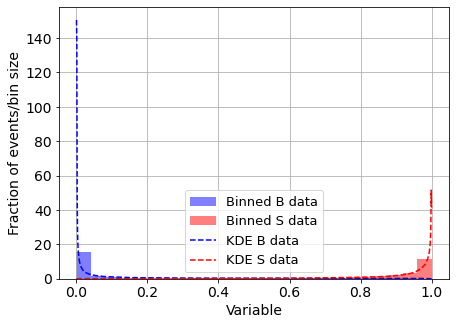

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                  | 7/2000 [00:05<23:07,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18006873911130328
<p_{s}(Sdata)> = 11.230086516787003
<p_{b}(Bdata)> = 60.15359163648003
<p_{s}(Bdata)> = 0.2054322866818851


  0%|▏                                 | 8/2000 [00:06<19:09,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19681912729215323
<p_{s}(Sdata)> = 7.697133454368008
<p_{b}(Bdata)> = 60.10325618390776
<p_{s}(Bdata)> = 0.20964665234119567


  1%|▎                                | 21/2000 [00:17<24:58,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2368003293842592
<p_{s}(Sdata)> = 8.914714181445806
<p_{b}(Bdata)> = 59.87540790733315
<p_{s}(Bdata)> = 0.20984142908621375


  1%|▎                                | 22/2000 [00:17<20:41,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21692244440042138
<p_{s}(Sdata)> = 7.4185369649740185
<p_{b}(Bdata)> = 59.661445840215144
<p_{s}(Bdata)> = 0.20953817367176078


  1%|▍                                | 23/2000 [00:18<17:38,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19504936185868854
<p_{s}(Sdata)> = 9.565757545039185
<p_{b}(Bdata)> = 59.672955954301955
<p_{s}(Bdata)> = 0.20935840210242335


  1%|▍                                | 25/2000 [00:19<17:17,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.6322236510541
<p_{s}(Sdata)> = 8.224477892708851
<p_{b}(Bdata)> = 59.55600285747833
<p_{s}(Bdata)> = 0.20994973562579852


  1%|▍                                | 26/2000 [00:19<15:16,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6435134466229124
<p_{s}(Sdata)> = 11.444417374616181
<p_{b}(Bdata)> = 59.980138696505854
<p_{s}(Bdata)> = 0.2060196076874628


  1%|▍                                | 27/2000 [00:20<13:52,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18291752940513592
<p_{s}(Sdata)> = 12.037381560409594
<p_{b}(Bdata)> = 59.748334742281905
<p_{s}(Bdata)> = 0.20440198238076734


  1%|▍                                | 28/2000 [00:20<12:53,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19642869403297797
<p_{s}(Sdata)> = 8.190288480051558
<p_{b}(Bdata)> = 59.964940644332586
<p_{s}(Bdata)> = 0.20921695082392433


  2%|▍                                | 30/2000 [00:21<14:12,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20513054946910542
<p_{s}(Sdata)> = 10.001537520777314
<p_{b}(Bdata)> = 59.79839649740606
<p_{s}(Bdata)> = 0.20946364335741358


  2%|▌                                | 32/2000 [00:22<15:58,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2191423663618718
<p_{s}(Sdata)> = 7.531874905387471
<p_{b}(Bdata)> = 59.695783193954
<p_{s}(Bdata)> = 0.2107700464105985


  2%|▌                                | 37/2000 [00:26<22:32,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25570795773640687
<p_{s}(Sdata)> = 9.219655181164566
<p_{b}(Bdata)> = 59.809144412454884
<p_{s}(Bdata)> = 0.2087846636248841


  2%|▋                                | 41/2000 [00:29<22:52,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9865687190040164
<p_{s}(Sdata)> = 7.586727121256379
<p_{b}(Bdata)> = 59.72538316065241
<p_{s}(Bdata)> = 0.21407090137246207


  2%|▋                                | 42/2000 [00:30<19:09,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24140220478094532
<p_{s}(Sdata)> = 7.910356211891785
<p_{b}(Bdata)> = 59.684565588850134
<p_{s}(Bdata)> = 0.2111998109256629


  2%|▋                                | 43/2000 [00:30<16:34,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2088780517681117
<p_{s}(Sdata)> = 8.187373191480312
<p_{b}(Bdata)> = 59.577365299709165
<p_{s}(Bdata)> = 0.2124599983038938


  2%|▊                                | 47/2000 [00:33<18:19,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2187372404965021
<p_{s}(Sdata)> = 8.242372330593078
<p_{b}(Bdata)> = 59.689876052018136
<p_{s}(Bdata)> = 0.21110362220926213


  3%|▊                                | 51/2000 [00:36<21:43,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21724678290148158
<p_{s}(Sdata)> = 9.985909624367524
<p_{b}(Bdata)> = 59.710714366227016
<p_{s}(Bdata)> = 0.20905173164593752


  3%|▊                                | 52/2000 [00:36<18:19,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1927100625273495
<p_{s}(Sdata)> = 10.498570185264533
<p_{b}(Bdata)> = 59.72429318720879
<p_{s}(Bdata)> = 0.21333375170421842


  3%|▉                                | 55/2000 [00:39<22:04,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18728676250973164
<p_{s}(Sdata)> = 7.3008266700253595
<p_{b}(Bdata)> = 59.72654126202019
<p_{s}(Bdata)> = 0.20844416174577365


  3%|▉                                | 56/2000 [00:39<18:34,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24000398424993538
<p_{s}(Sdata)> = 7.628431659678272
<p_{b}(Bdata)> = 59.72050356169826
<p_{s}(Bdata)> = 0.21230518400759327


  3%|▉                                | 59/2000 [00:42<23:48,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2077223492887503
<p_{s}(Sdata)> = 7.114756402651051
<p_{b}(Bdata)> = 59.80136981053627
<p_{s}(Bdata)> = 0.20798597190863208


  3%|▉                                | 60/2000 [00:42<19:49,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.194487772313733
<p_{s}(Sdata)> = 9.979210446361764
<p_{b}(Bdata)> = 59.797282406122854
<p_{s}(Bdata)> = 0.2101831302796183


  3%|█                                | 61/2000 [00:42<17:04,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22838602311739647
<p_{s}(Sdata)> = 5.195914741216527
<p_{b}(Bdata)> = 59.75800896522426
<p_{s}(Bdata)> = 0.2095786791540187


  3%|█                                | 65/2000 [00:45<20:35,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22840961566494858
<p_{s}(Sdata)> = 9.35440736546122
<p_{b}(Bdata)> = 59.88648865334429
<p_{s}(Bdata)> = 0.20844911656677578


  3%|█▏                               | 69/2000 [00:48<20:34,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2056020770222299
<p_{s}(Sdata)> = 8.480919306154528
<p_{b}(Bdata)> = 60.39538891822061
<p_{s}(Bdata)> = 0.21028673485130653


  4%|█▏                               | 70/2000 [00:49<17:32,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19019764368187975
<p_{s}(Sdata)> = 9.243260058763443
<p_{b}(Bdata)> = 60.0575298802132
<p_{s}(Bdata)> = 0.20775033843903226


  4%|█▏                               | 72/2000 [00:50<16:03,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22154700620306406
<p_{s}(Sdata)> = 8.576861746415547
<p_{b}(Bdata)> = 59.52263883129241
<p_{s}(Bdata)> = 0.21092503864497272


  4%|█▏                               | 73/2000 [00:50<14:20,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19406426257077916
<p_{s}(Sdata)> = 10.529263664231815
<p_{b}(Bdata)> = 59.42342394776744
<p_{s}(Bdata)> = 0.21031827662164407


  4%|█▏                               | 75/2000 [00:51<17:54,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19687221568955726
<p_{s}(Sdata)> = 8.70728474373843
<p_{b}(Bdata)> = 59.89024714258229
<p_{s}(Bdata)> = 0.20510456971799218


  4%|█▎                               | 76/2000 [00:52<15:43,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18255210823586562
<p_{s}(Sdata)> = 12.101520484193129
<p_{b}(Bdata)> = 59.60503170008607
<p_{s}(Bdata)> = 0.20584454153412246


  4%|█▎                               | 77/2000 [00:52<14:09,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2168118752744273
<p_{s}(Sdata)> = 11.811605811847393
<p_{b}(Bdata)> = 59.81584315262991
<p_{s}(Bdata)> = 0.21304049553556842


  4%|█▎                               | 78/2000 [00:52<13:00,  2.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23431222388550485
<p_{s}(Sdata)> = 7.396146708604555
<p_{b}(Bdata)> = 59.551492039053684
<p_{s}(Bdata)> = 0.21084302630502852


  4%|█▎                               | 80/2000 [00:53<14:46,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19843922181218643
<p_{s}(Sdata)> = 9.707164681122226
<p_{b}(Bdata)> = 59.691792597165914
<p_{s}(Bdata)> = 0.2118448685220307


  4%|█▎                               | 83/2000 [00:56<22:11,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19778434320082336
<p_{s}(Sdata)> = 9.263304315892261
<p_{b}(Bdata)> = 59.63454103483411
<p_{s}(Bdata)> = 0.209523638577708


  4%|█▍                               | 84/2000 [00:57<18:37,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22530780338326553
<p_{s}(Sdata)> = 8.337709524839989
<p_{b}(Bdata)> = 59.54484301469024
<p_{s}(Bdata)> = 0.21008927335689762


  4%|█▍                               | 86/2000 [00:58<17:11,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2160300546955355
<p_{s}(Sdata)> = 7.22236669017109
<p_{b}(Bdata)> = 59.682467172795256
<p_{s}(Bdata)> = 0.2098288165557338


  4%|█▍                               | 88/2000 [00:59<16:28,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2090183934797977
<p_{s}(Sdata)> = 9.448202012694917
<p_{b}(Bdata)> = 59.91199955985396
<p_{s}(Bdata)> = 0.20658884369910555


  4%|█▍                               | 89/2000 [00:59<14:37,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23099673062138412
<p_{s}(Sdata)> = 7.293179070057504
<p_{b}(Bdata)> = 59.720770942960854
<p_{s}(Bdata)> = 0.21002823362352027


  4%|█▍                               | 90/2000 [01:00<13:20,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21140736588564088
<p_{s}(Sdata)> = 5.913139241193035
<p_{b}(Bdata)> = 59.99878125395771
<p_{s}(Bdata)> = 0.20920866283708658


  5%|█▌                               | 92/2000 [01:00<13:32,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2790151052291681
<p_{s}(Sdata)> = 8.408841293996268
<p_{b}(Bdata)> = 59.6162326211115
<p_{s}(Bdata)> = 0.20919090443943514


  5%|█▌                               | 93/2000 [01:01<12:35,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19927140902109586
<p_{s}(Sdata)> = 10.363611290211013
<p_{b}(Bdata)> = 60.00181059246603
<p_{s}(Bdata)> = 0.21006939767173596


  5%|█▌                               | 94/2000 [01:01<11:52,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18971590843572542
<p_{s}(Sdata)> = 9.896151059686172
<p_{b}(Bdata)> = 59.79107609942023
<p_{s}(Bdata)> = 0.20780382895423047


  5%|█▌                               | 95/2000 [01:01<11:26,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23672287259175298
<p_{s}(Sdata)> = 8.185925843552543
<p_{b}(Bdata)> = 59.311140281259256
<p_{s}(Bdata)> = 0.2149442906368472


  5%|█▌                               | 96/2000 [01:02<11:06,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22852833824404467
<p_{s}(Sdata)> = 7.933093322124942
<p_{b}(Bdata)> = 59.69932116167047
<p_{s}(Bdata)> = 0.2079605243367666


  5%|█▌                               | 98/2000 [01:03<16:33,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21949991282092363
<p_{s}(Sdata)> = 7.907397522575281
<p_{b}(Bdata)> = 59.836776193271106
<p_{s}(Bdata)> = 0.2131907375470598


  5%|█▌                              | 100/2000 [01:05<17:16,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20144524163500435
<p_{s}(Sdata)> = 11.27099000642532
<p_{b}(Bdata)> = 59.84115365251361
<p_{s}(Bdata)> = 0.20792786527541532


  5%|█▋                              | 103/2000 [01:06<16:18,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18718150240008985
<p_{s}(Sdata)> = 11.243104066961722
<p_{b}(Bdata)> = 59.74697140433044
<p_{s}(Bdata)> = 0.20969125933914304


  5%|█▋                              | 104/2000 [01:07<14:29,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.191807350051004
<p_{s}(Sdata)> = 8.349618873187787
<p_{b}(Bdata)> = 59.615381144463214
<p_{s}(Bdata)> = 0.20821643900449927


  5%|█▋                              | 106/2000 [01:08<17:51,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.182816180619727
<p_{s}(Sdata)> = 8.182161597806738
<p_{b}(Bdata)> = 59.79960139340565
<p_{s}(Bdata)> = 0.2114887376136633


  5%|█▋                              | 109/2000 [01:10<17:43,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23664955216578856
<p_{s}(Sdata)> = 9.333126508615939
<p_{b}(Bdata)> = 59.798632785119985
<p_{s}(Bdata)> = 0.20966868979058018


  6%|█▊                              | 112/2000 [01:12<17:30,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.2595648726885003
<p_{s}(Sdata)> = 10.42215658976691
<p_{b}(Bdata)> = 59.65430512669239
<p_{s}(Bdata)> = 0.2093147797153373


  6%|█▊                              | 114/2000 [01:13<15:54,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20085268440870283
<p_{s}(Sdata)> = 9.625423683286071
<p_{b}(Bdata)> = 60.03766631244945
<p_{s}(Bdata)> = 0.20805112760699782


  6%|█▊                              | 116/2000 [01:14<15:44,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23994696303621765
<p_{s}(Sdata)> = 8.386662728198019
<p_{b}(Bdata)> = 59.489984852728256
<p_{s}(Bdata)> = 0.2103640172070523


  6%|█▊                              | 117/2000 [01:14<14:04,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18727765397808174
<p_{s}(Sdata)> = 8.297570480142271
<p_{b}(Bdata)> = 59.44507781340337
<p_{s}(Bdata)> = 0.21291245235011688


  6%|█▉                              | 118/2000 [01:14<12:52,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2045042054815913
<p_{s}(Sdata)> = 10.452288113624459
<p_{b}(Bdata)> = 59.64458512058968
<p_{s}(Bdata)> = 0.20977576498781086


  6%|█▉                              | 121/2000 [01:16<16:41,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19684781834948994
<p_{s}(Sdata)> = 7.871138286774891
<p_{b}(Bdata)> = 59.51388556090742
<p_{s}(Bdata)> = 0.21290876179957852


  6%|█▉                              | 122/2000 [01:17<14:43,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19765339580402178
<p_{s}(Sdata)> = 10.022872760440285
<p_{b}(Bdata)> = 59.8781453979668
<p_{s}(Bdata)> = 0.20994951005539625


  6%|██                              | 125/2000 [01:19<18:10,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1774780502553783
<p_{s}(Sdata)> = 10.043287042504291
<p_{b}(Bdata)> = 59.99023858989694
<p_{s}(Bdata)> = 0.20889327670050015


  7%|██▏                             | 134/2000 [01:27<23:50,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24090607756230686
<p_{s}(Sdata)> = 7.995263842275276
<p_{b}(Bdata)> = 59.49135008560618
<p_{s}(Bdata)> = 0.20843124514838934


  7%|██▏                             | 136/2000 [01:28<19:31,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41721854153055227
<p_{s}(Sdata)> = 9.01638822229346
<p_{b}(Bdata)> = 59.629607217711246
<p_{s}(Bdata)> = 0.2120366419264797


  7%|██▏                             | 137/2000 [01:28<16:40,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23531156414588753
<p_{s}(Sdata)> = 7.177015857116679
<p_{b}(Bdata)> = 59.712595902261015
<p_{s}(Bdata)> = 0.20863283217575285


  7%|██▎                             | 142/2000 [01:32<20:02,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19719183134264678
<p_{s}(Sdata)> = 9.851489456110809
<p_{b}(Bdata)> = 59.40092244764281
<p_{s}(Bdata)> = 0.2087641816699166


  7%|██▎                             | 143/2000 [01:33<17:01,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34527961701258786
<p_{s}(Sdata)> = 7.582806719206414
<p_{b}(Bdata)> = 59.794335749245406
<p_{s}(Bdata)> = 0.20909082530105044


  7%|██▎                             | 144/2000 [01:33<14:54,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2109167560873718
<p_{s}(Sdata)> = 8.707448754129084
<p_{b}(Bdata)> = 59.621949089446844
<p_{s}(Bdata)> = 0.21082724060423386


  7%|██▎                             | 145/2000 [01:33<13:24,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19923957169501338
<p_{s}(Sdata)> = 9.782560781918239
<p_{b}(Bdata)> = 59.89807576920628
<p_{s}(Bdata)> = 0.2060981748308501


  7%|██▎                             | 148/2000 [01:36<19:14,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2014992021337937
<p_{s}(Sdata)> = 9.354048033019323
<p_{b}(Bdata)> = 59.47528207931775
<p_{s}(Bdata)> = 0.20799547649489417


  8%|██▍                             | 156/2000 [01:43<23:27,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20482947372978522
<p_{s}(Sdata)> = 9.658799099847691
<p_{b}(Bdata)> = 59.8158211297872
<p_{s}(Bdata)> = 0.21069067468942082


  8%|██▌                             | 163/2000 [01:50<23:34,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21327619109871246
<p_{s}(Sdata)> = 9.313598496084927
<p_{b}(Bdata)> = 59.57262203805598
<p_{s}(Bdata)> = 0.21059804717585412


  8%|██▌                             | 164/2000 [01:50<19:27,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17865041144837063
<p_{s}(Sdata)> = 12.952171100316564
<p_{b}(Bdata)> = 60.09055764180619
<p_{s}(Bdata)> = 0.20843075559709584


  8%|██▋                             | 167/2000 [01:52<20:00,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18744662898997277
<p_{s}(Sdata)> = 9.394362420020048
<p_{b}(Bdata)> = 60.07415549743499
<p_{s}(Bdata)> = 0.21287352553750602


  8%|██▋                             | 170/2000 [01:55<21:13,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23801615167429138
<p_{s}(Sdata)> = 8.69213045221377
<p_{b}(Bdata)> = 59.408517736708596
<p_{s}(Bdata)> = 0.20910263620007227


  9%|██▊                             | 175/2000 [01:59<23:04,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18965598677402618
<p_{s}(Sdata)> = 7.560531416734883
<p_{b}(Bdata)> = 59.678145455427675
<p_{s}(Bdata)> = 0.21015967994380005


  9%|██▊                             | 178/2000 [02:01<19:57,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2736139533369151
<p_{s}(Sdata)> = 8.33643417074101
<p_{b}(Bdata)> = 59.81883403790733
<p_{s}(Bdata)> = 0.2093572351204387


  9%|██▉                             | 184/2000 [02:08<28:38,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18928080867396932
<p_{s}(Sdata)> = 10.04381175780388
<p_{b}(Bdata)> = 59.72274357102133
<p_{s}(Bdata)> = 0.21182063282549352


  9%|██▉                             | 185/2000 [02:08<22:59,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26239930479399787
<p_{s}(Sdata)> = 7.159695476948003
<p_{b}(Bdata)> = 59.711997205052064
<p_{s}(Bdata)> = 0.21020336387607103


  9%|██▉                             | 186/2000 [02:08<19:01,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19781657813306414
<p_{s}(Sdata)> = 9.59684802731056
<p_{b}(Bdata)> = 59.50731722777143
<p_{s}(Bdata)> = 0.2108566330088767


  9%|███                             | 188/2000 [02:10<17:52,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2597933372197404
<p_{s}(Sdata)> = 8.663271959201229
<p_{b}(Bdata)> = 59.72890110061343
<p_{s}(Bdata)> = 0.21120173914440668


 10%|███                             | 190/2000 [02:11<20:27,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23469725793553214
<p_{s}(Sdata)> = 10.107243321011724
<p_{b}(Bdata)> = 59.972516201901
<p_{s}(Bdata)> = 0.2099012595437775


 10%|███                             | 191/2000 [02:12<17:14,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2022599163592641
<p_{s}(Sdata)> = 9.33025463381286
<p_{b}(Bdata)> = 59.789136407395304
<p_{s}(Bdata)> = 0.21114437497214653


 10%|███                             | 192/2000 [02:12<14:59,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1964196035057996
<p_{s}(Sdata)> = 8.936506093105507
<p_{b}(Bdata)> = 60.04744401981982
<p_{s}(Bdata)> = 0.20717057749300227


 10%|███▏                            | 198/2000 [02:17<20:21,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2642509141008638
<p_{s}(Sdata)> = 9.1263818481883
<p_{b}(Bdata)> = 59.83137466096439
<p_{s}(Bdata)> = 0.2124951127300446


 10%|███▏                            | 202/2000 [02:19<18:31,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.213425926293106
<p_{s}(Sdata)> = 6.257903821509256
<p_{b}(Bdata)> = 59.74736313654556
<p_{s}(Bdata)> = 0.21483018239544524


 10%|███▎                            | 204/2000 [02:20<16:37,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20611039168134024
<p_{s}(Sdata)> = 8.639025209327114
<p_{b}(Bdata)> = 60.17228097913333
<p_{s}(Bdata)> = 0.21483364391054044


 10%|███▎                            | 205/2000 [02:21<14:34,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20663229670381236
<p_{s}(Sdata)> = 6.26908905681779
<p_{b}(Bdata)> = 59.82665879696468
<p_{s}(Bdata)> = 0.20876102271233132


 11%|███▍                            | 218/2000 [02:32<23:33,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22158210431569172
<p_{s}(Sdata)> = 7.784012239686904
<p_{b}(Bdata)> = 59.606063304075256
<p_{s}(Bdata)> = 0.21362606045273716


 11%|███▌                            | 221/2000 [02:34<19:41,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2383220156456941
<p_{s}(Sdata)> = 8.155579040654187
<p_{b}(Bdata)> = 59.62366296159246
<p_{s}(Bdata)> = 0.21134520944838806


 11%|███▌                            | 223/2000 [02:35<17:29,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21118282670750171
<p_{s}(Sdata)> = 10.651255075982275
<p_{b}(Bdata)> = 60.097660105660886
<p_{s}(Bdata)> = 0.20887324131102603


 11%|███▌                            | 225/2000 [02:37<19:21,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1935717136639974
<p_{s}(Sdata)> = 9.622131527113241
<p_{b}(Bdata)> = 59.61763166986303
<p_{s}(Bdata)> = 0.21200277826803982


 11%|███▋                            | 228/2000 [02:40<25:30,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20502296992418687
<p_{s}(Sdata)> = 12.54167101376056
<p_{b}(Bdata)> = 59.485027838515904
<p_{s}(Bdata)> = 0.21150369672656827


 11%|███▋                            | 229/2000 [02:41<20:44,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1846368818062177
<p_{s}(Sdata)> = 10.554960383272903
<p_{b}(Bdata)> = 59.88637463292093
<p_{s}(Bdata)> = 0.20887191101453184


 12%|███▋                            | 231/2000 [02:42<18:01,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19626302518470037
<p_{s}(Sdata)> = 13.42236820148407
<p_{b}(Bdata)> = 59.48831170946955
<p_{s}(Bdata)> = 0.2087042136447458


 12%|███▋                            | 234/2000 [02:44<19:57,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24608067903874298
<p_{s}(Sdata)> = 7.4813984939103575
<p_{b}(Bdata)> = 59.363709822783406
<p_{s}(Bdata)> = 0.2077231067152297


 12%|███▊                            | 240/2000 [02:49<20:27,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19537085427194648
<p_{s}(Sdata)> = 7.492392146433762
<p_{b}(Bdata)> = 59.58962265124844
<p_{s}(Bdata)> = 0.2122515477720788


 12%|███▊                            | 242/2000 [02:50<17:06,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2069447942244138
<p_{s}(Sdata)> = 6.967505749072873
<p_{b}(Bdata)> = 59.76110923283647
<p_{s}(Bdata)> = 0.20950415970940034


 12%|███▉                            | 243/2000 [02:51<14:48,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2127735878484413
<p_{s}(Sdata)> = 9.027383178329515
<p_{b}(Bdata)> = 60.05536190558869
<p_{s}(Bdata)> = 0.20855899576116801


 12%|███▉                            | 247/2000 [02:53<15:12,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19526842120750557
<p_{s}(Sdata)> = 8.014757157503716
<p_{b}(Bdata)> = 60.06530139858949
<p_{s}(Bdata)> = 0.21163068274731278


 12%|███▉                            | 248/2000 [02:53<13:30,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22459545102813802
<p_{s}(Sdata)> = 10.061704427213668
<p_{b}(Bdata)> = 59.50411864168749
<p_{s}(Bdata)> = 0.21105419297495617


 12%|███▉                            | 249/2000 [02:53<12:30,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19302751847799385
<p_{s}(Sdata)> = 11.09143785378872
<p_{b}(Bdata)> = 59.671537976652324
<p_{s}(Bdata)> = 0.20725735441135124


 13%|████                            | 251/2000 [02:55<14:52,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19335292560254916
<p_{s}(Sdata)> = 9.354654316525922
<p_{b}(Bdata)> = 59.62116247554336
<p_{s}(Bdata)> = 0.21026559836596015


 13%|████                            | 254/2000 [02:57<17:17,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23702491180630483
<p_{s}(Sdata)> = 8.693968500671883
<p_{b}(Bdata)> = 59.861635509915914
<p_{s}(Bdata)> = 0.2126737119202857


 13%|████▏                           | 262/2000 [03:04<19:02,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21244764525410934
<p_{s}(Sdata)> = 7.578745965767627
<p_{b}(Bdata)> = 60.14242905682719
<p_{s}(Bdata)> = 0.20917349186005368


 13%|████▏                           | 264/2000 [03:05<17:02,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19856977425111794
<p_{s}(Sdata)> = 9.322672611421849
<p_{b}(Bdata)> = 59.65401397755578
<p_{s}(Bdata)> = 0.20862106363577446


 13%|████▎                           | 266/2000 [03:06<17:51,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18663459543123662
<p_{s}(Sdata)> = 10.61671719261111
<p_{b}(Bdata)> = 59.66764510549207
<p_{s}(Bdata)> = 0.20953065262169832


 13%|████▎                           | 267/2000 [03:07<15:18,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2551595737637666
<p_{s}(Sdata)> = 8.998659864386056
<p_{b}(Bdata)> = 59.650977114539195
<p_{s}(Bdata)> = 0.213265510289195


 14%|████▍                           | 278/2000 [03:15<20:21,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2231523062425802
<p_{s}(Sdata)> = 9.173622155080183
<p_{b}(Bdata)> = 59.96879943946125
<p_{s}(Bdata)> = 0.2084691425380919


 14%|████▍                           | 281/2000 [03:17<18:28,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1838446238694518
<p_{s}(Sdata)> = 10.476129690256796
<p_{b}(Bdata)> = 59.69769702600714
<p_{s}(Bdata)> = 0.20972120505461936


 14%|████▌                           | 284/2000 [03:20<22:16,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3024858755330324
<p_{s}(Sdata)> = 8.996947993803465
<p_{b}(Bdata)> = 60.05730611224403
<p_{s}(Bdata)> = 0.20718491793765517


 14%|████▌                           | 285/2000 [03:20<18:25,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2020596290053932
<p_{s}(Sdata)> = 8.93651347861755
<p_{b}(Bdata)> = 59.805625927127956
<p_{s}(Bdata)> = 0.2061022378923003


 15%|████▋                           | 292/2000 [03:26<21:43,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22261934518658916
<p_{s}(Sdata)> = 8.799564123617069
<p_{b}(Bdata)> = 59.93860295897925
<p_{s}(Bdata)> = 0.20617877249710756


 15%|████▋                           | 293/2000 [03:27<17:59,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2039980083189752
<p_{s}(Sdata)> = 8.614553836198388
<p_{b}(Bdata)> = 59.593369410702124
<p_{s}(Bdata)> = 0.21402697723947245


 15%|████▋                           | 295/2000 [03:28<17:38,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19694552290682263
<p_{s}(Sdata)> = 9.462759233382913
<p_{b}(Bdata)> = 60.04554322772058
<p_{s}(Bdata)> = 0.20915752163586124


 15%|████▋                           | 296/2000 [03:28<15:04,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18531377276399066
<p_{s}(Sdata)> = 10.218403324701171
<p_{b}(Bdata)> = 59.428067341280176
<p_{s}(Bdata)> = 0.21070058458046456


 15%|████▊                           | 298/2000 [03:29<14:53,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17318954826193295
<p_{s}(Sdata)> = 12.394854361141851
<p_{b}(Bdata)> = 59.84035780302932
<p_{s}(Bdata)> = 0.2109342329651917


 15%|████▊                           | 299/2000 [03:30<13:12,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21321551173089093
<p_{s}(Sdata)> = 7.2264944105537126
<p_{b}(Bdata)> = 59.949258155312755
<p_{s}(Bdata)> = 0.2099133780210333


 15%|████▊                           | 300/2000 [03:30<11:58,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24880243340991026
<p_{s}(Sdata)> = 8.37684447922151
<p_{b}(Bdata)> = 59.5430837256476
<p_{s}(Bdata)> = 0.2119829870805662


 15%|████▊                           | 302/2000 [03:32<17:12,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18448699568627017
<p_{s}(Sdata)> = 9.11522192430781
<p_{b}(Bdata)> = 59.63040568701078
<p_{s}(Bdata)> = 0.20893157129165382


 16%|████▉                           | 310/2000 [03:39<21:32,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23566632976498775
<p_{s}(Sdata)> = 8.132134690587916
<p_{b}(Bdata)> = 59.92626680300832
<p_{s}(Bdata)> = 0.20846020286146244


 16%|█████                           | 314/2000 [03:42<21:42,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2454408202620759
<p_{s}(Sdata)> = 10.153028291174286
<p_{b}(Bdata)> = 59.69648425390866
<p_{s}(Bdata)> = 0.20774963880683137


 16%|█████                           | 315/2000 [03:43<17:57,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1921350797005473
<p_{s}(Sdata)> = 9.509375595009304
<p_{b}(Bdata)> = 59.70940366039935
<p_{s}(Bdata)> = 0.21027167068781566


 16%|█████                           | 316/2000 [03:43<15:16,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2027362315221206
<p_{s}(Sdata)> = 8.104503199311873
<p_{b}(Bdata)> = 59.80809400705644
<p_{s}(Bdata)> = 0.2105579069476372


 16%|█████                           | 318/2000 [03:44<15:47,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19863795450502278
<p_{s}(Sdata)> = 7.872313889187439
<p_{b}(Bdata)> = 59.5663416642547
<p_{s}(Bdata)> = 0.2114185336841939


 16%|█████                           | 319/2000 [03:44<13:45,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1915643640231531
<p_{s}(Sdata)> = 9.52741235848824
<p_{b}(Bdata)> = 60.05187069168717
<p_{s}(Bdata)> = 0.2075043161486827


 16%|█████▏                          | 321/2000 [03:46<18:55,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24118545358021606
<p_{s}(Sdata)> = 9.838626368907775
<p_{b}(Bdata)> = 60.09281416515369
<p_{s}(Bdata)> = 0.20984624288861195


 16%|█████▏                          | 322/2000 [03:47<15:57,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20543714661597737
<p_{s}(Sdata)> = 8.007918021156815
<p_{b}(Bdata)> = 60.11271208105569
<p_{s}(Bdata)> = 0.21055774108790073


 16%|█████▏                          | 323/2000 [03:47<13:53,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1893728875623434
<p_{s}(Sdata)> = 10.785584449267652
<p_{b}(Bdata)> = 59.9563989498301
<p_{s}(Bdata)> = 0.2096505156802766


 17%|█████▎                          | 332/2000 [03:55<19:00,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19634650495013556
<p_{s}(Sdata)> = 10.408490215782454
<p_{b}(Bdata)> = 59.89659280596117
<p_{s}(Bdata)> = 0.21129929949639534


 17%|█████▎                          | 333/2000 [03:55<16:01,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20676440929443005
<p_{s}(Sdata)> = 6.391882491692637
<p_{b}(Bdata)> = 59.50529181882913
<p_{s}(Bdata)> = 0.21387525886323167


 17%|█████▎                          | 335/2000 [03:56<16:43,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18792024062465928
<p_{s}(Sdata)> = 10.142580441502275
<p_{b}(Bdata)> = 59.83992335624864
<p_{s}(Bdata)> = 0.20834129442912389


 17%|█████▍                          | 337/2000 [03:57<15:12,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22536935556082235
<p_{s}(Sdata)> = 9.539959402621244
<p_{b}(Bdata)> = 59.637850937607936
<p_{s}(Bdata)> = 0.20864912434017935


 17%|█████▍                          | 338/2000 [03:58<13:19,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27123243419444676
<p_{s}(Sdata)> = 10.585677352666744
<p_{b}(Bdata)> = 59.715998813595775
<p_{s}(Bdata)> = 0.20783233828411796


 17%|█████▍                          | 342/2000 [04:01<18:28,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21168267861227538
<p_{s}(Sdata)> = 8.490623066743847
<p_{b}(Bdata)> = 59.809763861019
<p_{s}(Bdata)> = 0.20882392144623527


 17%|█████▌                          | 344/2000 [04:03<20:24,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19687538222302473
<p_{s}(Sdata)> = 8.390372429530192
<p_{b}(Bdata)> = 59.6254651663742
<p_{s}(Bdata)> = 0.2103479661973026


 17%|█████▌                          | 347/2000 [04:05<19:50,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19403832255953318
<p_{s}(Sdata)> = 9.069419262033158
<p_{b}(Bdata)> = 59.98090781032845
<p_{s}(Bdata)> = 0.2103731801224199


 17%|█████▌                          | 348/2000 [04:05<16:34,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3186460228009013
<p_{s}(Sdata)> = 9.912233173049287
<p_{b}(Bdata)> = 59.81324521005619
<p_{s}(Bdata)> = 0.20966475023071976


 18%|█████▌                          | 350/2000 [04:07<16:55,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28789268508608995
<p_{s}(Sdata)> = 10.34087952474654
<p_{b}(Bdata)> = 59.453559615088366
<p_{s}(Bdata)> = 0.2097217807930229


 18%|█████▌                          | 351/2000 [04:07<14:31,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20208441273082853
<p_{s}(Sdata)> = 9.458781713124772
<p_{b}(Bdata)> = 59.72408194254504
<p_{s}(Bdata)> = 0.20930721019147422


 18%|█████▋                          | 352/2000 [04:08<12:52,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21687803151738683
<p_{s}(Sdata)> = 10.079773735584348
<p_{b}(Bdata)> = 59.7256844690341
<p_{s}(Bdata)> = 0.20888982671281525


 18%|█████▋                          | 353/2000 [04:08<11:42,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19122074467894407
<p_{s}(Sdata)> = 7.713020116824545
<p_{b}(Bdata)> = 59.71445384274189
<p_{s}(Bdata)> = 0.21019315143890088


 18%|█████▋                          | 357/2000 [04:10<14:16,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18757462792916854
<p_{s}(Sdata)> = 9.710075569826337
<p_{b}(Bdata)> = 59.24146367996968
<p_{s}(Bdata)> = 0.2143637207450448


 18%|█████▊                          | 360/2000 [04:12<15:14,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19590425382196264
<p_{s}(Sdata)> = 9.72856365314842
<p_{b}(Bdata)> = 59.67385286302036
<p_{s}(Bdata)> = 0.20589138975390334


 18%|█████▊                          | 362/2000 [04:14<19:50,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19318435568471412
<p_{s}(Sdata)> = 11.66715540843899
<p_{b}(Bdata)> = 59.684938002744985
<p_{s}(Bdata)> = 0.20957027778498385


 18%|█████▉                          | 369/2000 [04:20<18:18,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2048158107505105
<p_{s}(Sdata)> = 7.676619746183794
<p_{b}(Bdata)> = 59.39588557223504
<p_{s}(Bdata)> = 0.20966512545707308


 19%|█████▉                          | 372/2000 [04:23<20:34,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1929594425217685
<p_{s}(Sdata)> = 8.069562860313301
<p_{b}(Bdata)> = 59.877520889012146
<p_{s}(Bdata)> = 0.21115505797787945


 19%|█████▉                          | 373/2000 [04:23<17:04,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2819438719421563
<p_{s}(Sdata)> = 5.332822829444713
<p_{b}(Bdata)> = 59.692860397899906
<p_{s}(Bdata)> = 0.21454921573628366


 19%|█████▉                          | 374/2000 [04:23<14:34,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2534767663727345
<p_{s}(Sdata)> = 8.602197407215531
<p_{b}(Bdata)> = 59.80182742891243
<p_{s}(Bdata)> = 0.2111528342056181


 19%|██████                          | 375/2000 [04:24<12:48,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18724738815998745
<p_{s}(Sdata)> = 10.757046291161553
<p_{b}(Bdata)> = 59.82776637645296
<p_{s}(Bdata)> = 0.20753530934622794


 19%|██████                          | 377/2000 [04:25<13:21,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.243836638472778
<p_{s}(Sdata)> = 6.802059663949726
<p_{b}(Bdata)> = 59.75201738956317
<p_{s}(Bdata)> = 0.20656439766409276


 19%|██████                          | 380/2000 [04:27<14:03,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20360557755201575
<p_{s}(Sdata)> = 8.515069801753553
<p_{b}(Bdata)> = 59.77923929645429
<p_{s}(Bdata)> = 0.20543841828910425


 19%|██████▏                         | 384/2000 [04:30<16:31,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19153022975712508
<p_{s}(Sdata)> = 9.717598313120643
<p_{b}(Bdata)> = 59.57906646411266
<p_{s}(Bdata)> = 0.21267738008548415


 19%|██████▏                         | 386/2000 [04:31<14:17,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25903432633683987
<p_{s}(Sdata)> = 9.240071412050876
<p_{b}(Bdata)> = 59.91676130423622
<p_{s}(Bdata)> = 0.21041107230043812


 20%|██████▎                         | 391/2000 [04:34<15:40,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.212648139280615
<p_{s}(Sdata)> = 9.106311063453663
<p_{b}(Bdata)> = 59.95799812405865
<p_{s}(Bdata)> = 0.20974294588678377


 20%|██████▎                         | 394/2000 [04:36<17:04,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22616216303712613
<p_{s}(Sdata)> = 8.222909543604855
<p_{b}(Bdata)> = 59.647038063596824
<p_{s}(Bdata)> = 0.2092164364221927


 20%|██████▎                         | 397/2000 [04:38<14:24,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23151837830043687
<p_{s}(Sdata)> = 6.85982949457555
<p_{b}(Bdata)> = 59.84134699000528
<p_{s}(Bdata)> = 0.20968465446736267


 20%|██████▎                         | 398/2000 [04:38<12:39,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17296474575041207
<p_{s}(Sdata)> = 11.476177835992708
<p_{b}(Bdata)> = 60.04022675799942
<p_{s}(Bdata)> = 0.20805314766249036


 20%|██████▍                         | 405/2000 [04:44<17:27,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19546534661169337
<p_{s}(Sdata)> = 9.809275894035206
<p_{b}(Bdata)> = 59.684565625122524
<p_{s}(Bdata)> = 0.20639705187201576


 20%|██████▌                         | 408/2000 [04:46<17:34,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23655909800989103
<p_{s}(Sdata)> = 7.381657420015575
<p_{b}(Bdata)> = 59.24989824778805
<p_{s}(Bdata)> = 0.21117949630399172


 21%|██████▌                         | 412/2000 [04:49<16:17,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17176244518044706
<p_{s}(Sdata)> = 12.260107055322605
<p_{b}(Bdata)> = 60.04839956644398
<p_{s}(Bdata)> = 0.20868196726412977


 21%|██████▌                         | 413/2000 [04:49<13:58,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1951848272143888
<p_{s}(Sdata)> = 9.478499581541358
<p_{b}(Bdata)> = 60.08789501498882
<p_{s}(Bdata)> = 0.20580653735582186


 21%|██████▋                         | 416/2000 [04:51<15:55,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3280814834395443
<p_{s}(Sdata)> = 7.6036449144177
<p_{b}(Bdata)> = 59.83708606137326
<p_{s}(Bdata)> = 0.20801200151426155


 21%|██████▋                         | 418/2000 [04:53<18:36,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20992137606834987
<p_{s}(Sdata)> = 5.2204867343058075
<p_{b}(Bdata)> = 59.48518856989287
<p_{s}(Bdata)> = 0.20873309529371564


 21%|██████▋                         | 421/2000 [04:55<15:36,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2525326914589331
<p_{s}(Sdata)> = 9.270211723381982
<p_{b}(Bdata)> = 59.343990939954736
<p_{s}(Bdata)> = 0.21233841783555812


 21%|██████▊                         | 423/2000 [04:56<13:46,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1897444037410397
<p_{s}(Sdata)> = 10.36310346714101
<p_{b}(Bdata)> = 59.885333468015716
<p_{s}(Bdata)> = 0.21116193569342376


 21%|██████▊                         | 425/2000 [04:57<13:05,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18896550088606798
<p_{s}(Sdata)> = 8.930124440479991
<p_{b}(Bdata)> = 59.678393574681856
<p_{s}(Bdata)> = 0.20871432394945594


 22%|███████                         | 438/2000 [05:08<18:43,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2020372084374223
<p_{s}(Sdata)> = 9.088803357629356
<p_{b}(Bdata)> = 59.90222065507496
<p_{s}(Bdata)> = 0.21107851367536604


 22%|███████                         | 440/2000 [05:10<17:58,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19686493436213934
<p_{s}(Sdata)> = 9.19001670805415
<p_{b}(Bdata)> = 59.95885007848857
<p_{s}(Bdata)> = 0.2097507021796051


 22%|███████                         | 442/2000 [05:11<16:48,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19616170446809839
<p_{s}(Sdata)> = 8.076253347012292
<p_{b}(Bdata)> = 59.70143202068779
<p_{s}(Bdata)> = 0.21266143545899435


 22%|███████                         | 443/2000 [05:12<14:18,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26490347404667824
<p_{s}(Sdata)> = 5.5549921370257955
<p_{b}(Bdata)> = 59.82243800504693
<p_{s}(Bdata)> = 0.210065195702251


 22%|███████                         | 445/2000 [05:13<13:16,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1720949193643207
<p_{s}(Sdata)> = 11.352780714726265
<p_{b}(Bdata)> = 59.72409933458364
<p_{s}(Bdata)> = 0.20898009572345796


 22%|███████▏                        | 449/2000 [05:15<15:21,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19150328861812696
<p_{s}(Sdata)> = 10.130986233458495
<p_{b}(Bdata)> = 59.691496240253464
<p_{s}(Bdata)> = 0.20931053679626277


 23%|███████▏                        | 452/2000 [05:18<19:26,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17227345660521262
<p_{s}(Sdata)> = 12.435993658795859
<p_{b}(Bdata)> = 59.740869423985366
<p_{s}(Bdata)> = 0.20592157906804479


 23%|███████▏                        | 453/2000 [05:18<16:05,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20432046420804015
<p_{s}(Sdata)> = 9.743969025323693
<p_{b}(Bdata)> = 60.24158761597298
<p_{s}(Bdata)> = 0.2088558733752277


 23%|███████▎                        | 454/2000 [05:19<13:45,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1711766557202598
<p_{s}(Sdata)> = 9.653565473788186
<p_{b}(Bdata)> = 60.04117398882273
<p_{s}(Bdata)> = 0.21126589578641708


 23%|███████▎                        | 455/2000 [05:19<12:06,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19965306823477122
<p_{s}(Sdata)> = 8.244261111520311
<p_{b}(Bdata)> = 59.76574662059736
<p_{s}(Bdata)> = 0.2108711768751833


 23%|███████▎                        | 458/2000 [05:20<11:56,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2074751457167126
<p_{s}(Sdata)> = 10.0551407233306
<p_{b}(Bdata)> = 59.95345228957444
<p_{s}(Bdata)> = 0.20690022217391954


 23%|███████▎                        | 459/2000 [05:21<10:51,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1916425786459713
<p_{s}(Sdata)> = 8.758115667061825
<p_{b}(Bdata)> = 59.69430031301357
<p_{s}(Bdata)> = 0.21118507736403525


 23%|███████▍                        | 465/2000 [05:25<15:57,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21043082422622492
<p_{s}(Sdata)> = 9.865068325746531
<p_{b}(Bdata)> = 60.20522294301212
<p_{s}(Bdata)> = 0.20819054009331467


 23%|███████▍                        | 466/2000 [05:26<13:38,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20834608557286458
<p_{s}(Sdata)> = 10.032929851295085
<p_{b}(Bdata)> = 59.881447280441016
<p_{s}(Bdata)> = 0.20928127192086543


 23%|███████▍                        | 468/2000 [05:27<14:16,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1861468545241749
<p_{s}(Sdata)> = 9.500681840460569
<p_{b}(Bdata)> = 59.942946835777924
<p_{s}(Bdata)> = 0.21293445527672436


 24%|███████▌                        | 470/2000 [05:29<16:16,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22229308637122291
<p_{s}(Sdata)> = 8.586043075265504
<p_{b}(Bdata)> = 59.82562329710299
<p_{s}(Bdata)> = 0.21103355846926825


 24%|███████▌                        | 475/2000 [05:32<18:09,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18473179587350727
<p_{s}(Sdata)> = 8.97863956777838
<p_{b}(Bdata)> = 59.77524045522929
<p_{s}(Bdata)> = 0.2081017295767002


 24%|███████▌                        | 476/2000 [05:33<15:11,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20627606279901697
<p_{s}(Sdata)> = 9.5385368247438
<p_{b}(Bdata)> = 59.76708292866471
<p_{s}(Bdata)> = 0.2137168913013019


 24%|███████▋                        | 477/2000 [05:33<13:05,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2126071850024765
<p_{s}(Sdata)> = 9.122977873312953
<p_{b}(Bdata)> = 59.87928834179602
<p_{s}(Bdata)> = 0.20432844838774034


 24%|███████▋                        | 479/2000 [05:34<14:15,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22869619044709327
<p_{s}(Sdata)> = 6.37119322747508
<p_{b}(Bdata)> = 59.95762789877386
<p_{s}(Bdata)> = 0.21219997860117115


 24%|███████▋                        | 482/2000 [05:37<18:33,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1823916640691146
<p_{s}(Sdata)> = 9.673149991361942
<p_{b}(Bdata)> = 59.68480406726328
<p_{s}(Bdata)> = 0.21163090868995355


 24%|███████▋                        | 483/2000 [05:38<15:26,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23462097861539116
<p_{s}(Sdata)> = 8.960214198260578
<p_{b}(Bdata)> = 59.74652554385338
<p_{s}(Bdata)> = 0.21220778262225432


 24%|███████▊                        | 485/2000 [05:39<17:04,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20391111433530665
<p_{s}(Sdata)> = 7.712108989328904
<p_{b}(Bdata)> = 59.546322911056905
<p_{s}(Bdata)> = 0.21105102775967688


 24%|███████▊                        | 487/2000 [05:41<16:08,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2353374451696338
<p_{s}(Sdata)> = 7.968884250218182
<p_{b}(Bdata)> = 59.73578113945823
<p_{s}(Bdata)> = 0.20670847284432523


 24%|███████▊                        | 488/2000 [05:41<13:44,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1874555006596926
<p_{s}(Sdata)> = 9.858341048743073
<p_{b}(Bdata)> = 59.64829293649978
<p_{s}(Bdata)> = 0.2099096413123296


 24%|███████▊                        | 490/2000 [05:42<12:17,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24969216153928206
<p_{s}(Sdata)> = 7.26576756117838
<p_{b}(Bdata)> = 59.80699545812558
<p_{s}(Bdata)> = 0.21026384200883416


 25%|███████▊                        | 491/2000 [05:42<11:02,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17930343652494976
<p_{s}(Sdata)> = 10.902648349173624
<p_{b}(Bdata)> = 59.459161237974165
<p_{s}(Bdata)> = 0.20850392930837364


 25%|███████▉                        | 494/2000 [05:44<14:05,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2099621293695362
<p_{s}(Sdata)> = 9.200129515663338
<p_{b}(Bdata)> = 59.69067031088251
<p_{s}(Bdata)> = 0.20487405631396274


 25%|███████▉                        | 495/2000 [05:44<12:18,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21180860768761536
<p_{s}(Sdata)> = 10.23429648861033
<p_{b}(Bdata)> = 59.87793311733805
<p_{s}(Bdata)> = 0.21032431423550832


 25%|███████▉                        | 496/2000 [05:45<11:01,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19136892678411124
<p_{s}(Sdata)> = 9.629076897913837
<p_{b}(Bdata)> = 59.851992964393155
<p_{s}(Bdata)> = 0.20967496585947404


 25%|███████▉                        | 498/2000 [05:46<13:04,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3079942475157144
<p_{s}(Sdata)> = 9.095986833855916
<p_{b}(Bdata)> = 59.802679112919066
<p_{s}(Bdata)> = 0.20994497841004758


 25%|███████▉                        | 499/2000 [05:46<11:35,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2764908735230937
<p_{s}(Sdata)> = 7.96556168059783
<p_{b}(Bdata)> = 60.116551868144484
<p_{s}(Bdata)> = 0.20893643674119877


 25%|████████                        | 502/2000 [05:48<12:35,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2438978936025188
<p_{s}(Sdata)> = 10.032739879922584
<p_{b}(Bdata)> = 59.84172069596956
<p_{s}(Bdata)> = 0.2074244155090461


 25%|████████                        | 506/2000 [05:52<18:17,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1941456986404985
<p_{s}(Sdata)> = 9.176288852764113
<p_{b}(Bdata)> = 59.23377992516286
<p_{s}(Bdata)> = 0.21046777109534398


 25%|████████                        | 507/2000 [05:52<15:13,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2339373943142449
<p_{s}(Sdata)> = 7.531978679714814
<p_{b}(Bdata)> = 59.902491653273934
<p_{s}(Bdata)> = 0.21234502373562897


 25%|████████▏                       | 509/2000 [05:53<12:56,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1846432719813938
<p_{s}(Sdata)> = 9.896509861115682
<p_{b}(Bdata)> = 59.81966670494245
<p_{s}(Bdata)> = 0.21297468551303617


 26%|████████▏                       | 510/2000 [05:53<11:25,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19805144510475442
<p_{s}(Sdata)> = 8.960957465629836
<p_{b}(Bdata)> = 59.999764027590935
<p_{s}(Bdata)> = 0.20972999623266136


 26%|████████▏                       | 512/2000 [05:55<13:34,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3028422434882568
<p_{s}(Sdata)> = 6.505570367892764
<p_{b}(Bdata)> = 60.09699584528246
<p_{s}(Bdata)> = 0.2098270016991577


 26%|████████▏                       | 513/2000 [05:55<11:54,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20608987707528365
<p_{s}(Sdata)> = 8.550732332808018
<p_{b}(Bdata)> = 59.60934763169579
<p_{s}(Bdata)> = 0.21022904776645565


 26%|████████▏                       | 514/2000 [05:55<10:45,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5036891851228713
<p_{s}(Sdata)> = 8.875939980612563
<p_{b}(Bdata)> = 59.72127672872409
<p_{s}(Bdata)> = 0.21128044621641417


 26%|████████▎                       | 519/2000 [06:00<16:58,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1919578176121039
<p_{s}(Sdata)> = 8.736968574212668
<p_{b}(Bdata)> = 59.81654777090922
<p_{s}(Bdata)> = 0.21063743274876234


 26%|████████▎                       | 520/2000 [06:00<14:16,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20909897678894687
<p_{s}(Sdata)> = 7.324315114327834
<p_{b}(Bdata)> = 59.806749837544565
<p_{s}(Bdata)> = 0.21223712299339803


 26%|████████▎                       | 523/2000 [06:02<13:38,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20162830299945367
<p_{s}(Sdata)> = 11.808416796640401
<p_{b}(Bdata)> = 59.89216621332016
<p_{s}(Bdata)> = 0.20776824871920355


 26%|████████▍                       | 524/2000 [06:02<11:59,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2195437452999827
<p_{s}(Sdata)> = 8.22998007779702
<p_{b}(Bdata)> = 59.42832986945815
<p_{s}(Bdata)> = 0.20687173219651775


 26%|████████▍                       | 525/2000 [06:03<10:48,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23139705284893708
<p_{s}(Sdata)> = 11.401658186793407
<p_{b}(Bdata)> = 59.86941021309053
<p_{s}(Bdata)> = 0.21035008699128102


 26%|████████▍                       | 528/2000 [06:04<11:22,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21217347971089298
<p_{s}(Sdata)> = 7.587913348666976
<p_{b}(Bdata)> = 59.64265426165209
<p_{s}(Bdata)> = 0.2123746385026371


 26%|████████▍                       | 530/2000 [06:06<13:08,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.283696227032047
<p_{s}(Sdata)> = 10.554304494793243
<p_{b}(Bdata)> = 59.770686447561296
<p_{s}(Bdata)> = 0.20870254066982719


 27%|████████▌                       | 533/2000 [06:09<18:33,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2037669438348343
<p_{s}(Sdata)> = 6.832542905743695
<p_{b}(Bdata)> = 59.84878328059725
<p_{s}(Bdata)> = 0.20545044854968378


 27%|████████▌                       | 538/2000 [06:12<15:34,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21448932348948327
<p_{s}(Sdata)> = 7.780013008630252
<p_{b}(Bdata)> = 59.863203060859206
<p_{s}(Bdata)> = 0.21119812845815256


 27%|████████▋                       | 540/2000 [06:13<14:04,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20688388319015685
<p_{s}(Sdata)> = 7.816773719353385
<p_{b}(Bdata)> = 59.49675301880731
<p_{s}(Bdata)> = 0.21284668736376236


 27%|████████▋                       | 541/2000 [06:14<12:13,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20984240525207687
<p_{s}(Sdata)> = 12.260229927531707
<p_{b}(Bdata)> = 59.71017294313738
<p_{s}(Bdata)> = 0.20734866668093913


 27%|████████▋                       | 542/2000 [06:14<10:53,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6461485160902042
<p_{s}(Sdata)> = 8.385845849930055
<p_{b}(Bdata)> = 59.43164471978866
<p_{s}(Bdata)> = 0.21386539915703387


 27%|████████▋                       | 545/2000 [06:16<13:55,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22921686307742659
<p_{s}(Sdata)> = 9.656739272466597
<p_{b}(Bdata)> = 60.103113875995305
<p_{s}(Bdata)> = 0.20916350598340655


 27%|████████▊                       | 547/2000 [06:17<14:32,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1629054342792378
<p_{s}(Sdata)> = 12.093950467682674
<p_{b}(Bdata)> = 59.86514194190871
<p_{s}(Bdata)> = 0.2136780860000471


 27%|████████▊                       | 548/2000 [06:18<12:29,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19543931122329006
<p_{s}(Sdata)> = 10.030282219648422
<p_{b}(Bdata)> = 59.91830122143888
<p_{s}(Bdata)> = 0.21277092970570144


 27%|████████▊                       | 549/2000 [06:18<11:04,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18909346957936263
<p_{s}(Sdata)> = 9.031162521816334
<p_{b}(Bdata)> = 60.065459127660404
<p_{s}(Bdata)> = 0.21037856138877045


 28%|████████▊                       | 551/2000 [06:20<14:01,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2025827196498163
<p_{s}(Sdata)> = 8.654338191473505
<p_{b}(Bdata)> = 59.55807317627073
<p_{s}(Bdata)> = 0.2142170724301442


 28%|████████▊                       | 552/2000 [06:20<12:08,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20221585806712064
<p_{s}(Sdata)> = 9.27658937857575
<p_{b}(Bdata)> = 59.6334146273032
<p_{s}(Bdata)> = 0.21070547684685717


 28%|████████▉                       | 556/2000 [06:23<15:04,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20149463518092095
<p_{s}(Sdata)> = 7.002238272304963
<p_{b}(Bdata)> = 59.76274844380148
<p_{s}(Bdata)> = 0.21250940624576525


 28%|████████▉                       | 557/2000 [06:23<12:53,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31775565267970257
<p_{s}(Sdata)> = 7.69644227654269
<p_{b}(Bdata)> = 59.59074970054562
<p_{s}(Bdata)> = 0.2143106306713334


 28%|████████▉                       | 559/2000 [06:25<14:12,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568881611838288
<p_{s}(Sdata)> = 7.595708974931292
<p_{b}(Bdata)> = 59.8282979665027
<p_{s}(Bdata)> = 0.21138425830823912


 28%|████████▉                       | 561/2000 [06:26<12:29,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17888419776434547
<p_{s}(Sdata)> = 12.547456183029189
<p_{b}(Bdata)> = 59.88825912307268
<p_{s}(Bdata)> = 0.20574405365018059


 28%|█████████                       | 564/2000 [06:27<12:49,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21800020566235012
<p_{s}(Sdata)> = 10.438666148169798
<p_{b}(Bdata)> = 59.84894287145824
<p_{s}(Bdata)> = 0.2076615732877374


 28%|█████████                       | 566/2000 [06:29<16:06,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18146674542942742
<p_{s}(Sdata)> = 11.22557678784956
<p_{b}(Bdata)> = 59.64377663348264
<p_{s}(Bdata)> = 0.20828565172440897


 28%|█████████                       | 569/2000 [06:31<16:59,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18795716624950098
<p_{s}(Sdata)> = 9.33236254498358
<p_{b}(Bdata)> = 60.05741813369846
<p_{s}(Bdata)> = 0.20783078991715637


 28%|█████████                       | 570/2000 [06:32<14:13,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2380279697098975
<p_{s}(Sdata)> = 9.229547130338002
<p_{b}(Bdata)> = 59.55487936626381
<p_{s}(Bdata)> = 0.2119842201061668


 29%|█████████▏                      | 573/2000 [06:34<14:19,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2426137808708313
<p_{s}(Sdata)> = 10.302923961051887
<p_{b}(Bdata)> = 59.75405795417771
<p_{s}(Bdata)> = 0.2103924701477075


 29%|█████████▏                      | 576/2000 [06:36<15:33,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2264990155941205
<p_{s}(Sdata)> = 6.423950373687834
<p_{b}(Bdata)> = 59.937481793889745
<p_{s}(Bdata)> = 0.21302644696383757


 29%|█████████▏                      | 577/2000 [06:37<13:12,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1936655014043798
<p_{s}(Sdata)> = 8.867566396719422
<p_{b}(Bdata)> = 59.748203854894804
<p_{s}(Bdata)> = 0.21046767770051886


 29%|█████████▏                      | 578/2000 [06:37<11:31,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2203683267907423
<p_{s}(Sdata)> = 6.894554906612485
<p_{b}(Bdata)> = 60.055475911965274
<p_{s}(Bdata)> = 0.21049237442478044


 29%|█████████▎                      | 581/2000 [06:39<15:47,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18510073536450325
<p_{s}(Sdata)> = 8.781068159851655
<p_{b}(Bdata)> = 59.36212127035806
<p_{s}(Bdata)> = 0.21115624657116905


 29%|█████████▎                      | 582/2000 [06:40<13:21,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21654998798873315
<p_{s}(Sdata)> = 7.974680982408031
<p_{b}(Bdata)> = 59.89800735694513
<p_{s}(Bdata)> = 0.20969385839094576


 29%|█████████▍                      | 586/2000 [06:42<13:32,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20352971469753012
<p_{s}(Sdata)> = 7.218274245625163
<p_{b}(Bdata)> = 59.5874812584701
<p_{s}(Bdata)> = 0.2097780157892691


 29%|█████████▍                      | 588/2000 [06:43<12:02,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20898439183856787
<p_{s}(Sdata)> = 9.021870543615032
<p_{b}(Bdata)> = 59.772279358321185
<p_{s}(Bdata)> = 0.21346974703557658


 30%|█████████▍                      | 590/2000 [06:44<13:09,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18754917165770882
<p_{s}(Sdata)> = 10.438791945640315
<p_{b}(Bdata)> = 59.66866948454274
<p_{s}(Bdata)> = 0.20965756710830133


 30%|█████████▍                      | 593/2000 [06:46<13:26,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2190001728080597
<p_{s}(Sdata)> = 7.150704427386842
<p_{b}(Bdata)> = 60.02311414331614
<p_{s}(Bdata)> = 0.21246875949686933


 30%|█████████▌                      | 598/2000 [06:51<18:24,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19013138371993274
<p_{s}(Sdata)> = 10.598739458771279
<p_{b}(Bdata)> = 59.45623216007857
<p_{s}(Bdata)> = 0.21223496260686742


 30%|█████████▌                      | 599/2000 [06:51<15:08,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16917719366010261
<p_{s}(Sdata)> = 12.397031301804502
<p_{b}(Bdata)> = 59.24411643477338
<p_{s}(Bdata)> = 0.21007868701260568


 30%|█████████▌                      | 601/2000 [06:53<14:53,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25221327489157513
<p_{s}(Sdata)> = 10.416748702814887
<p_{b}(Bdata)> = 59.87796378602465
<p_{s}(Bdata)> = 0.20809375643119737


 30%|█████████▋                      | 605/2000 [06:55<14:15,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19838861334526034
<p_{s}(Sdata)> = 6.179475204465129
<p_{b}(Bdata)> = 59.381860431478934
<p_{s}(Bdata)> = 0.20896641811401312


 31%|█████████▊                      | 611/2000 [06:59<14:36,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19653862168216651
<p_{s}(Sdata)> = 8.932676169417137
<p_{b}(Bdata)> = 59.860635773725264
<p_{s}(Bdata)> = 0.20501169052111032


 31%|█████████▊                      | 615/2000 [07:03<15:54,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.206836387992019
<p_{s}(Sdata)> = 9.890853243084816
<p_{b}(Bdata)> = 59.962387398421264
<p_{s}(Bdata)> = 0.20896298803155414


 31%|█████████▊                      | 616/2000 [07:03<13:20,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1802631160341425
<p_{s}(Sdata)> = 11.803661593673818
<p_{b}(Bdata)> = 59.779068072015384
<p_{s}(Bdata)> = 0.2129609883943646


 31%|█████████▊                      | 617/2000 [07:03<11:34,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2524848718495113
<p_{s}(Sdata)> = 10.632473625541023
<p_{b}(Bdata)> = 59.639705265213614
<p_{s}(Bdata)> = 0.21018748690517208


 31%|█████████▉                      | 621/2000 [07:06<12:34,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16761590060024356
<p_{s}(Sdata)> = 12.223802049378241
<p_{b}(Bdata)> = 59.70327167946648
<p_{s}(Bdata)> = 0.2092725012614593


 31%|██████████                      | 626/2000 [07:10<13:40,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17441856763474284
<p_{s}(Sdata)> = 11.280293140995697
<p_{b}(Bdata)> = 59.89041642310459
<p_{s}(Bdata)> = 0.20850631149760182


 31%|██████████                      | 628/2000 [07:11<12:33,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20059153469163551
<p_{s}(Sdata)> = 7.961600048481068
<p_{b}(Bdata)> = 59.723691923239805
<p_{s}(Bdata)> = 0.20983327686526862


 31%|██████████                      | 629/2000 [07:11<11:01,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18920136598244908
<p_{s}(Sdata)> = 9.634665062753347
<p_{b}(Bdata)> = 59.8110323706319
<p_{s}(Bdata)> = 0.21145501526658023


 32%|██████████                      | 631/2000 [07:12<10:27,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24277775700120058
<p_{s}(Sdata)> = 8.31158286705949
<p_{b}(Bdata)> = 59.65067808512678
<p_{s}(Bdata)> = 0.21103144582232888


 32%|██████████▏                     | 634/2000 [07:14<11:08,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21057681414577384
<p_{s}(Sdata)> = 6.923976845067645
<p_{b}(Bdata)> = 59.74567551138351
<p_{s}(Bdata)> = 0.21373749154313607


 32%|██████████▏                     | 636/2000 [07:15<11:25,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20054201411535852
<p_{s}(Sdata)> = 7.227535622075364
<p_{b}(Bdata)> = 59.78012625775741
<p_{s}(Bdata)> = 0.20774349203536854


 32%|██████████▏                     | 637/2000 [07:15<10:12,  2.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18654632452386977
<p_{s}(Sdata)> = 9.277305003625361
<p_{b}(Bdata)> = 59.494415547703376
<p_{s}(Bdata)> = 0.21071231926596984


 32%|██████████▏                     | 640/2000 [07:17<12:52,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1928614073036068
<p_{s}(Sdata)> = 9.754518907101149
<p_{b}(Bdata)> = 59.665170574664444
<p_{s}(Bdata)> = 0.20899239297634553


 32%|██████████▎                     | 641/2000 [07:17<11:13,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22223465586222219
<p_{s}(Sdata)> = 5.672038574270827
<p_{b}(Bdata)> = 59.85697556594666
<p_{s}(Bdata)> = 0.2078771456025035


 32%|██████████▎                     | 643/2000 [07:19<11:41,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23339008604392308
<p_{s}(Sdata)> = 6.146097687736784
<p_{b}(Bdata)> = 59.761575434912544
<p_{s}(Bdata)> = 0.21324618140239898


 32%|██████████▎                     | 645/2000 [07:20<10:57,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21564064961748172
<p_{s}(Sdata)> = 10.420146490873167
<p_{b}(Bdata)> = 59.99623933599228
<p_{s}(Bdata)> = 0.20929668668300774


 32%|██████████▍                     | 650/2000 [07:24<14:34,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1892373980201841
<p_{s}(Sdata)> = 8.994733535965844
<p_{b}(Bdata)> = 59.951187521197
<p_{s}(Bdata)> = 0.20947093659504804


 33%|██████████▍                     | 652/2000 [07:25<13:03,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19357723088882753
<p_{s}(Sdata)> = 9.403696419651077
<p_{b}(Bdata)> = 59.6422790205827
<p_{s}(Bdata)> = 0.2117323700188872


 33%|██████████▍                     | 653/2000 [07:25<11:19,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21024639787428862
<p_{s}(Sdata)> = 9.842702386913349
<p_{b}(Bdata)> = 59.7842164500149
<p_{s}(Bdata)> = 0.21017593793574013


 33%|██████████▌                     | 657/2000 [07:28<15:03,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18812173719925854
<p_{s}(Sdata)> = 9.486760691818974
<p_{b}(Bdata)> = 59.656353546241476
<p_{s}(Bdata)> = 0.2119446493470914


 33%|██████████▌                     | 661/2000 [07:32<18:39,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1992497158467131
<p_{s}(Sdata)> = 8.81992120866166
<p_{b}(Bdata)> = 59.92070536106098
<p_{s}(Bdata)> = 0.2061305569210055


 33%|██████████▌                     | 662/2000 [07:33<15:13,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19083273352037922
<p_{s}(Sdata)> = 9.817208803528583
<p_{b}(Bdata)> = 59.9165799048147
<p_{s}(Bdata)> = 0.2114140455312593


 33%|██████████▌                     | 664/2000 [07:34<15:06,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2185003960135362
<p_{s}(Sdata)> = 11.355664129308298
<p_{b}(Bdata)> = 59.8606677160211
<p_{s}(Bdata)> = 0.21028653511945294


 33%|██████████▋                     | 667/2000 [07:36<14:14,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2001913648822262
<p_{s}(Sdata)> = 7.924415505032693
<p_{b}(Bdata)> = 59.747251514978736
<p_{s}(Bdata)> = 0.20745464376221867


 34%|██████████▊                     | 673/2000 [07:41<13:50,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24341451087053276
<p_{s}(Sdata)> = 9.19243973472234
<p_{b}(Bdata)> = 59.94949436715039
<p_{s}(Bdata)> = 0.21307572205572228


 34%|██████████▊                     | 674/2000 [07:41<11:49,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24764494913427496
<p_{s}(Sdata)> = 9.625680136898664
<p_{b}(Bdata)> = 60.08558074269945
<p_{s}(Bdata)> = 0.20850172783033177


 34%|██████████▊                     | 675/2000 [07:41<10:25,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1934315616344393
<p_{s}(Sdata)> = 9.64940393633431
<p_{b}(Bdata)> = 59.73916471142299
<p_{s}(Bdata)> = 0.20966248567428644


 34%|██████████▊                     | 676/2000 [07:42<09:28,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24265750831515523
<p_{s}(Sdata)> = 8.957269036062181
<p_{b}(Bdata)> = 59.73261806686727
<p_{s}(Bdata)> = 0.21208078717325882


 34%|██████████▊                     | 677/2000 [07:42<08:48,  2.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2286485905445637
<p_{s}(Sdata)> = 6.76083001572076
<p_{b}(Bdata)> = 60.15096560253927
<p_{s}(Bdata)> = 0.2127295809757726


 34%|██████████▉                     | 680/2000 [07:44<10:04,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20426267920481653
<p_{s}(Sdata)> = 7.51267748490102
<p_{b}(Bdata)> = 59.929595977199995
<p_{s}(Bdata)> = 0.21037709009002345


 34%|██████████▉                     | 682/2000 [07:45<09:45,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20680731249577997
<p_{s}(Sdata)> = 9.00191057624755
<p_{b}(Bdata)> = 59.45706701803464
<p_{s}(Bdata)> = 0.2109461796208312


 34%|██████████▉                     | 683/2000 [07:45<08:58,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23975711117181928
<p_{s}(Sdata)> = 5.262128681363548
<p_{b}(Bdata)> = 59.59995644886347
<p_{s}(Bdata)> = 0.21221651299947872


 34%|██████████▉                     | 685/2000 [07:46<11:55,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21758094269506406
<p_{s}(Sdata)> = 8.82279985776779
<p_{b}(Bdata)> = 59.61920720634424
<p_{s}(Bdata)> = 0.21088916098324514


 34%|██████████▉                     | 687/2000 [07:47<11:06,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2167535350579496
<p_{s}(Sdata)> = 9.138884683220864
<p_{b}(Bdata)> = 59.412003393064154
<p_{s}(Bdata)> = 0.2093008933861944


 35%|███████████                     | 691/2000 [07:50<12:27,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1989048926988876
<p_{s}(Sdata)> = 8.912832896120806
<p_{b}(Bdata)> = 59.85367836795387
<p_{s}(Bdata)> = 0.2088793921968808


 35%|███████████▏                    | 699/2000 [07:57<15:12,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19672943411959912
<p_{s}(Sdata)> = 8.891944414216876
<p_{b}(Bdata)> = 60.22102836762521
<p_{s}(Bdata)> = 0.20896277052719023


 35%|███████████▏                    | 700/2000 [07:57<12:44,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17783192620848862
<p_{s}(Sdata)> = 11.972763789162538
<p_{b}(Bdata)> = 60.04061378487213
<p_{s}(Bdata)> = 0.20926084372680617


 35%|███████████▏                    | 701/2000 [07:57<11:01,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18381884363489387
<p_{s}(Sdata)> = 10.517054499188593
<p_{b}(Bdata)> = 59.83839391305931
<p_{s}(Bdata)> = 0.20712155308491367


 35%|███████████▎                    | 704/2000 [08:00<14:28,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19704259496001103
<p_{s}(Sdata)> = 8.182090396782135
<p_{b}(Bdata)> = 59.72023382246037
<p_{s}(Bdata)> = 0.21122136734921268


 36%|███████████▍                    | 712/2000 [08:06<13:32,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16869823961375713
<p_{s}(Sdata)> = 12.067422115323883
<p_{b}(Bdata)> = 59.59645621690193
<p_{s}(Bdata)> = 0.21374484321521142


 36%|███████████▍                    | 715/2000 [08:09<15:38,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21869308849581903
<p_{s}(Sdata)> = 9.658867218634912
<p_{b}(Bdata)> = 59.83719838300321
<p_{s}(Bdata)> = 0.20860508294677868


 36%|███████████▍                    | 718/2000 [08:10<12:50,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20437740544955119
<p_{s}(Sdata)> = 9.634434602419589
<p_{b}(Bdata)> = 59.95574100970734
<p_{s}(Bdata)> = 0.21066611881197686


 36%|███████████▌                    | 719/2000 [08:11<11:05,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16434804052942714
<p_{s}(Sdata)> = 12.274652621630468
<p_{b}(Bdata)> = 59.77637519695823
<p_{s}(Bdata)> = 0.21276844733638892


 36%|███████████▌                    | 723/2000 [08:13<12:39,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22548117281640467
<p_{s}(Sdata)> = 7.622734850818759
<p_{b}(Bdata)> = 60.021677782924655
<p_{s}(Bdata)> = 0.20904272089020426


 36%|███████████▌                    | 724/2000 [08:14<10:54,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20192798140144705
<p_{s}(Sdata)> = 8.755242368880218
<p_{b}(Bdata)> = 59.61720611568083
<p_{s}(Bdata)> = 0.20945412835731098


 36%|███████████▌                    | 726/2000 [08:15<13:02,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322019191940455
<p_{s}(Sdata)> = 9.888045931428776
<p_{b}(Bdata)> = 59.91775757284143
<p_{s}(Bdata)> = 0.21039952104506185


 36%|███████████▋                    | 728/2000 [08:16<11:17,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21848205972014373
<p_{s}(Sdata)> = 8.185853271127298
<p_{b}(Bdata)> = 60.118821987948024
<p_{s}(Bdata)> = 0.21578182791489128


 36%|███████████▋                    | 730/2000 [08:17<11:48,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19363324204312804
<p_{s}(Sdata)> = 8.98079428372585
<p_{b}(Bdata)> = 59.613080176753705
<p_{s}(Bdata)> = 0.2085187420962841


 37%|███████████▋                    | 731/2000 [08:18<10:19,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23334587715881291
<p_{s}(Sdata)> = 10.056964182499824
<p_{b}(Bdata)> = 59.63058663760116
<p_{s}(Bdata)> = 0.20881571135413682


 37%|███████████▋                    | 732/2000 [08:18<09:15,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1704792671514602
<p_{s}(Sdata)> = 9.633230482622787
<p_{b}(Bdata)> = 59.73323335043551
<p_{s}(Bdata)> = 0.2086417926309801


 37%|███████████▊                    | 738/2000 [08:23<14:09,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2372785824013453
<p_{s}(Sdata)> = 7.278501658092509
<p_{b}(Bdata)> = 60.01831693134591
<p_{s}(Bdata)> = 0.21008486290931175


 37%|███████████▊                    | 740/2000 [08:24<11:30,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19301076094335157
<p_{s}(Sdata)> = 7.63661476508424
<p_{b}(Bdata)> = 60.406880116541295
<p_{s}(Bdata)> = 0.21060668167820576


 37%|███████████▊                    | 742/2000 [08:25<10:26,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20303406795629336
<p_{s}(Sdata)> = 11.081993158205757
<p_{b}(Bdata)> = 59.77275018380905
<p_{s}(Bdata)> = 0.20961993810424226


 37%|███████████▉                    | 748/2000 [08:30<15:40,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2172451042164736
<p_{s}(Sdata)> = 8.204728213070965
<p_{b}(Bdata)> = 60.022392396350675
<p_{s}(Bdata)> = 0.21144450885119453


 37%|███████████▉                    | 749/2000 [08:30<12:59,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18667748887120053
<p_{s}(Sdata)> = 7.873011197001247
<p_{b}(Bdata)> = 59.483335433515926
<p_{s}(Bdata)> = 0.20963405187260598


 38%|████████████                    | 750/2000 [08:31<11:08,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19700145554668605
<p_{s}(Sdata)> = 10.752894907039233
<p_{b}(Bdata)> = 59.651564754239246
<p_{s}(Bdata)> = 0.20945121717441015


 38%|████████████                    | 751/2000 [08:31<09:48,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20448926897440697
<p_{s}(Sdata)> = 8.679566038279368
<p_{b}(Bdata)> = 59.94654501035153
<p_{s}(Bdata)> = 0.21122705781547388


 38%|████████████                    | 753/2000 [08:32<11:10,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1981718252215271
<p_{s}(Sdata)> = 8.23903214842683
<p_{b}(Bdata)> = 59.66005872183401
<p_{s}(Bdata)> = 0.2115124727568638


 38%|████████████                    | 754/2000 [08:33<09:52,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20586048836562093
<p_{s}(Sdata)> = 9.01571618507576
<p_{b}(Bdata)> = 59.825201412888276
<p_{s}(Bdata)> = 0.21015202672836023


 38%|████████████▏                   | 761/2000 [08:39<15:45,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20032808402685898
<p_{s}(Sdata)> = 9.933094352070484
<p_{b}(Bdata)> = 59.46934791312793
<p_{s}(Bdata)> = 0.20848854478168324


 38%|████████████▏                   | 762/2000 [08:39<13:00,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1945315133489195
<p_{s}(Sdata)> = 8.483629707433495
<p_{b}(Bdata)> = 59.38394743743894
<p_{s}(Bdata)> = 0.2109780112251858


 38%|████████████▏                   | 763/2000 [08:39<11:07,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17560385555886288
<p_{s}(Sdata)> = 10.334558978938317
<p_{b}(Bdata)> = 59.66568150308666
<p_{s}(Bdata)> = 0.2112411183190845


 38%|████████████▏                   | 764/2000 [08:40<09:46,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23070448258397094
<p_{s}(Sdata)> = 6.1479657458104695
<p_{b}(Bdata)> = 59.9200268284819
<p_{s}(Bdata)> = 0.21224224445462847


 38%|████████████▎                   | 769/2000 [08:44<13:19,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19191446812905774
<p_{s}(Sdata)> = 9.417685563997923
<p_{b}(Bdata)> = 59.81134898200076
<p_{s}(Bdata)> = 0.2089463757138543


 38%|████████████▎                   | 770/2000 [08:44<11:18,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17555082309907002
<p_{s}(Sdata)> = 11.604081218294226
<p_{b}(Bdata)> = 60.13105634426682
<p_{s}(Bdata)> = 0.20746011432090106


 39%|████████████▍                   | 774/2000 [08:47<12:50,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18259202297509625
<p_{s}(Sdata)> = 10.192608968402578
<p_{b}(Bdata)> = 59.82447483148644
<p_{s}(Bdata)> = 0.21051880156813377


 39%|████████████▍                   | 775/2000 [08:47<10:58,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2167570418266828
<p_{s}(Sdata)> = 7.325977304176747
<p_{b}(Bdata)> = 59.767968208220736
<p_{s}(Bdata)> = 0.21316175818903862


 39%|████████████▌                   | 783/2000 [08:55<17:35,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19345953135828214
<p_{s}(Sdata)> = 8.801031537204711
<p_{b}(Bdata)> = 59.634750690617736
<p_{s}(Bdata)> = 0.21237130848029617


 39%|████████████▌                   | 784/2000 [08:55<14:15,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22362695900741394
<p_{s}(Sdata)> = 8.306840063523731
<p_{b}(Bdata)> = 59.72710617804707
<p_{s}(Bdata)> = 0.21137855443991718


 39%|████████████▌                   | 789/2000 [08:59<13:26,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19184428449638674
<p_{s}(Sdata)> = 8.339920353879025
<p_{b}(Bdata)> = 59.45149293496401
<p_{s}(Bdata)> = 0.21093935879346515


 40%|████████████▋                   | 795/2000 [09:04<13:38,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21097355129190695
<p_{s}(Sdata)> = 7.543525559042286
<p_{b}(Bdata)> = 60.04132519123096
<p_{s}(Bdata)> = 0.2094900025858588


 40%|████████████▊                   | 799/2000 [09:07<13:24,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1861215097180065
<p_{s}(Sdata)> = 10.788661446295121
<p_{b}(Bdata)> = 59.64336013110482
<p_{s}(Bdata)> = 0.20933716899089425


 40%|████████████▊                   | 800/2000 [09:07<11:18,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18844386069831992
<p_{s}(Sdata)> = 9.735041952938328
<p_{b}(Bdata)> = 59.76738117967953
<p_{s}(Bdata)> = 0.20941358560088716


 40%|████████████▉                   | 805/2000 [09:11<13:22,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20468467783443725
<p_{s}(Sdata)> = 8.721947208805375
<p_{b}(Bdata)> = 60.10371985566088
<p_{s}(Bdata)> = 0.21294352276716327


 40%|████████████▉                   | 807/2000 [09:13<12:51,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2495417872703044
<p_{s}(Sdata)> = 6.045563898333269
<p_{b}(Bdata)> = 59.60591512289478
<p_{s}(Bdata)> = 0.20861994017258476


 40%|████████████▉                   | 810/2000 [09:14<11:46,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1825198843649792
<p_{s}(Sdata)> = 10.271539796958418
<p_{b}(Bdata)> = 59.85206836065869
<p_{s}(Bdata)> = 0.20954870465749953


 41%|████████████▉                   | 811/2000 [09:15<10:10,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21881282541999916
<p_{s}(Sdata)> = 10.505903590465888
<p_{b}(Bdata)> = 59.87126766186144
<p_{s}(Bdata)> = 0.21049177492307755


 41%|█████████████                   | 814/2000 [09:17<11:10,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19282091893401782
<p_{s}(Sdata)> = 11.78709374327367
<p_{b}(Bdata)> = 59.887394400203306
<p_{s}(Bdata)> = 0.2082166264047303


 41%|█████████████                   | 819/2000 [09:20<11:55,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2119378410820942
<p_{s}(Sdata)> = 6.573324556990281
<p_{b}(Bdata)> = 60.047268501991255
<p_{s}(Bdata)> = 0.21280376522089847


 41%|█████████████▏                  | 821/2000 [09:21<10:05,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2166464620739519
<p_{s}(Sdata)> = 9.004614389131195
<p_{b}(Bdata)> = 59.627744907206264
<p_{s}(Bdata)> = 0.20954279245498947


 42%|█████████████▎                  | 833/2000 [09:32<14:09,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1768412043909957
<p_{s}(Sdata)> = 10.826489706246837
<p_{b}(Bdata)> = 59.571893272063285
<p_{s}(Bdata)> = 0.20691061432722044


 42%|█████████████▍                  | 837/2000 [09:35<12:32,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27996542470092983
<p_{s}(Sdata)> = 9.126823616218857
<p_{b}(Bdata)> = 60.01891377342985
<p_{s}(Bdata)> = 0.21230579820231008


 42%|█████████████▍                  | 843/2000 [09:40<13:56,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2127740179835813
<p_{s}(Sdata)> = 9.610088080936965
<p_{b}(Bdata)> = 59.58227866824198
<p_{s}(Bdata)> = 0.2086330075383325


 42%|█████████████▌                  | 847/2000 [09:42<11:10,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28695667516086615
<p_{s}(Sdata)> = 7.296161104308244
<p_{b}(Bdata)> = 59.8882424625859
<p_{s}(Bdata)> = 0.21120832195427208


 42%|█████████████▌                  | 849/2000 [09:43<10:30,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20335681091972027
<p_{s}(Sdata)> = 8.733116314675375
<p_{b}(Bdata)> = 59.70770128815396
<p_{s}(Bdata)> = 0.20818469945409315


 42%|█████████████▌                  | 850/2000 [09:44<09:10,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21577538190656895
<p_{s}(Sdata)> = 10.08087131514448
<p_{b}(Bdata)> = 59.638034313499446
<p_{s}(Bdata)> = 0.209200065592514


 43%|█████████████▋                  | 852/2000 [09:45<10:55,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18933650215166029
<p_{s}(Sdata)> = 8.202964905761531
<p_{b}(Bdata)> = 59.79161143304622
<p_{s}(Bdata)> = 0.21187999620811282


 43%|█████████████▋                  | 853/2000 [09:46<09:29,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22588680186577295
<p_{s}(Sdata)> = 8.933441431631508
<p_{b}(Bdata)> = 59.587461379684825
<p_{s}(Bdata)> = 0.211275662988521


 43%|█████████████▋                  | 855/2000 [09:47<09:00,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19332142970529212
<p_{s}(Sdata)> = 7.9328368402434375
<p_{b}(Bdata)> = 59.55787736434447
<p_{s}(Bdata)> = 0.2118875917106523


 43%|█████████████▋                  | 857/2000 [09:48<11:15,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1901458778542278
<p_{s}(Sdata)> = 9.127944713238426
<p_{b}(Bdata)> = 60.08533121609345
<p_{s}(Bdata)> = 0.2137314113550572


 43%|█████████████▋                  | 858/2000 [09:48<09:42,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2582584739564885
<p_{s}(Sdata)> = 10.228209608967054
<p_{b}(Bdata)> = 59.85562322738908
<p_{s}(Bdata)> = 0.21103633206210953


 43%|█████████████▋                  | 859/2000 [09:49<08:36,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19288817139451483
<p_{s}(Sdata)> = 9.611570507407047
<p_{b}(Bdata)> = 59.85953557360287
<p_{s}(Bdata)> = 0.2105568196085304


 43%|█████████████▊                  | 860/2000 [09:49<07:50,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19532610653926552
<p_{s}(Sdata)> = 10.161532301800442
<p_{b}(Bdata)> = 59.448913206476064
<p_{s}(Bdata)> = 0.2114435755750032


 43%|█████████████▊                  | 866/2000 [09:53<10:32,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31787646714762746
<p_{s}(Sdata)> = 7.73900310383747
<p_{b}(Bdata)> = 59.905067106108234
<p_{s}(Bdata)> = 0.2076019405617911


 43%|█████████████▊                  | 867/2000 [09:53<09:11,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32021209124037475
<p_{s}(Sdata)> = 10.289784871157424
<p_{b}(Bdata)> = 59.843161874372214
<p_{s}(Bdata)> = 0.2093730385432071


 43%|█████████████▉                  | 868/2000 [09:54<08:13,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21660744927755982
<p_{s}(Sdata)> = 7.805691042591371
<p_{b}(Bdata)> = 59.86558960277447
<p_{s}(Bdata)> = 0.21021432593093076


 43%|█████████████▉                  | 869/2000 [09:54<07:35,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18962715148060252
<p_{s}(Sdata)> = 9.672096631559207
<p_{b}(Bdata)> = 59.61661067436004
<p_{s}(Bdata)> = 0.21336549588744194


 44%|█████████████▉                  | 874/2000 [09:57<10:18,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18918200495191834
<p_{s}(Sdata)> = 8.717937664183232
<p_{b}(Bdata)> = 59.77994076478541
<p_{s}(Bdata)> = 0.2094327739651041


 44%|██████████████                  | 878/2000 [10:00<10:58,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20113316518268307
<p_{s}(Sdata)> = 7.678376394079837
<p_{b}(Bdata)> = 59.3976929822479
<p_{s}(Bdata)> = 0.21052546140238163


 44%|██████████████▏                 | 883/2000 [10:04<13:05,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23722925473476186
<p_{s}(Sdata)> = 8.23412837335631
<p_{b}(Bdata)> = 59.73404038361671
<p_{s}(Bdata)> = 0.21372476376547456


 44%|██████████████▏                 | 890/2000 [10:10<14:50,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21486504606931475
<p_{s}(Sdata)> = 7.824564729688101
<p_{b}(Bdata)> = 60.3108317523389
<p_{s}(Bdata)> = 0.2092206629226346


 45%|██████████████▎                 | 891/2000 [10:10<12:08,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17255164872360773
<p_{s}(Sdata)> = 13.180390549324704
<p_{b}(Bdata)> = 59.80062569856585
<p_{s}(Bdata)> = 0.20751190817809634


 45%|██████████████▎                 | 893/2000 [10:12<12:50,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.171756482629959
<p_{s}(Sdata)> = 14.432882961865227
<p_{b}(Bdata)> = 59.95916780558484
<p_{s}(Bdata)> = 0.20992427806486855


 45%|██████████████▎                 | 894/2000 [10:12<10:45,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2502994110946262
<p_{s}(Sdata)> = 9.660222304733749
<p_{b}(Bdata)> = 59.54879610457329
<p_{s}(Bdata)> = 0.21071608252218493


 45%|██████████████▎                 | 896/2000 [10:13<10:26,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20139421650685707
<p_{s}(Sdata)> = 8.57321143264435
<p_{b}(Bdata)> = 59.94327718567305
<p_{s}(Bdata)> = 0.2108149854567622


 45%|██████████████▍                 | 899/2000 [10:15<10:27,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32001655329738904
<p_{s}(Sdata)> = 9.404630445501995
<p_{b}(Bdata)> = 59.59760702665661
<p_{s}(Bdata)> = 0.2108383928682104


 45%|██████████████▍                 | 903/2000 [10:18<11:32,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20555099171929356
<p_{s}(Sdata)> = 8.294512086582314
<p_{b}(Bdata)> = 59.85100289315988
<p_{s}(Bdata)> = 0.20405290003114357


 45%|██████████████▌                 | 908/2000 [10:22<12:32,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23373051972026182
<p_{s}(Sdata)> = 7.257293093546958
<p_{b}(Bdata)> = 59.62081368728385
<p_{s}(Bdata)> = 0.21104456302741517


 46%|██████████████▋                 | 918/2000 [10:31<12:35,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21462202887225565
<p_{s}(Sdata)> = 9.031599885239883
<p_{b}(Bdata)> = 59.826498495880294
<p_{s}(Bdata)> = 0.2095731245663787


 46%|██████████████▋                 | 919/2000 [10:31<10:33,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3005794321593999
<p_{s}(Sdata)> = 9.150350748577198
<p_{b}(Bdata)> = 59.829111173850436
<p_{s}(Bdata)> = 0.2061829790790281


 46%|██████████████▋                 | 920/2000 [10:31<09:08,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24099291443983206
<p_{s}(Sdata)> = 9.903157989503107
<p_{b}(Bdata)> = 60.07883461020096
<p_{s}(Bdata)> = 0.2119808509249693


 46%|██████████████▊                 | 925/2000 [10:36<12:16,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18112849954859478
<p_{s}(Sdata)> = 10.741016406345544
<p_{b}(Bdata)> = 59.980406664194426
<p_{s}(Bdata)> = 0.2087321625555828


 46%|██████████████▊                 | 926/2000 [10:36<10:18,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1986821596640237
<p_{s}(Sdata)> = 7.63209215664504
<p_{b}(Bdata)> = 59.74988095967901
<p_{s}(Bdata)> = 0.21270338723369012


 47%|██████████████▉                 | 934/2000 [10:42<10:45,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19581284171005833
<p_{s}(Sdata)> = 8.422517764256158
<p_{b}(Bdata)> = 59.831575469412996
<p_{s}(Bdata)> = 0.2119118895962458


 47%|██████████████▉                 | 936/2000 [10:43<10:41,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2035563310322763
<p_{s}(Sdata)> = 10.026010661435016
<p_{b}(Bdata)> = 59.566589857594856
<p_{s}(Bdata)> = 0.208909597385387


 47%|███████████████                 | 939/2000 [10:46<11:59,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17928657212058588
<p_{s}(Sdata)> = 10.459706464216389
<p_{b}(Bdata)> = 59.838888020538676
<p_{s}(Bdata)> = 0.20595236004645703


 47%|███████████████                 | 940/2000 [10:46<10:05,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22776032456873377
<p_{s}(Sdata)> = 7.518119029535279
<p_{b}(Bdata)> = 59.93923350079668
<p_{s}(Bdata)> = 0.20720740997779863


 47%|███████████████                 | 942/2000 [10:47<08:43,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2096436135169195
<p_{s}(Sdata)> = 6.266671686805588
<p_{b}(Bdata)> = 59.610994151938776
<p_{s}(Bdata)> = 0.2098707705990987


 47%|███████████████                 | 943/2000 [10:47<07:47,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24171081753452667
<p_{s}(Sdata)> = 4.6609732106571
<p_{b}(Bdata)> = 59.899692861886436
<p_{s}(Bdata)> = 0.2105818160270346


 47%|███████████████▏                | 948/2000 [10:51<12:26,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 3.6539456374069896
<p_{s}(Sdata)> = 8.362156886445137
<p_{b}(Bdata)> = 59.8405366506572
<p_{s}(Bdata)> = 0.21231650986315398


 47%|███████████████▏                | 949/2000 [10:51<10:24,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19266223382031616
<p_{s}(Sdata)> = 7.464394282763178
<p_{b}(Bdata)> = 59.76341058320791
<p_{s}(Bdata)> = 0.20969780531988666


 48%|███████████████▏                | 952/2000 [10:53<10:05,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17567361820607738
<p_{s}(Sdata)> = 10.93404963149073
<p_{b}(Bdata)> = 59.88887463140294
<p_{s}(Bdata)> = 0.20787559315214463


 48%|███████████████▏                | 953/2000 [10:53<08:43,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19826876880456812
<p_{s}(Sdata)> = 9.755900849312457
<p_{b}(Bdata)> = 59.95240609399468
<p_{s}(Bdata)> = 0.20666729186014748


 48%|███████████████▎                | 955/2000 [10:55<10:29,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2009910601558198
<p_{s}(Sdata)> = 7.4049909462962
<p_{b}(Bdata)> = 59.80658977787291
<p_{s}(Bdata)> = 0.20930199346349426


 48%|███████████████▎                | 956/2000 [10:55<09:01,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1889283662078796
<p_{s}(Sdata)> = 8.667019728443172
<p_{b}(Bdata)> = 60.14684604608473
<p_{s}(Bdata)> = 0.20903484553602877


 48%|███████████████▎                | 957/2000 [10:56<07:58,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1849724621763618
<p_{s}(Sdata)> = 8.35026137329451
<p_{b}(Bdata)> = 59.44994157727411
<p_{s}(Bdata)> = 0.21406520715136101


 48%|███████████████▎                | 958/2000 [10:56<07:13,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23640854617484205
<p_{s}(Sdata)> = 5.4395747271273605
<p_{b}(Bdata)> = 59.318271789470415
<p_{s}(Bdata)> = 0.20781071681269217


 48%|███████████████▍                | 968/2000 [11:06<12:55,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29012031784726516
<p_{s}(Sdata)> = 10.426839580912779
<p_{b}(Bdata)> = 60.02541670949452
<p_{s}(Bdata)> = 0.20957417283497656


 48%|███████████████▌                | 970/2000 [11:07<11:57,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24853227291938104
<p_{s}(Sdata)> = 6.310083799511795
<p_{b}(Bdata)> = 59.65654846367432
<p_{s}(Bdata)> = 0.2120595410764879


 49%|███████████████▌                | 972/2000 [11:09<11:39,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1825260663696083
<p_{s}(Sdata)> = 9.853632126651387
<p_{b}(Bdata)> = 59.88827900448016
<p_{s}(Bdata)> = 0.21095644091197654


 49%|███████████████▌                | 973/2000 [11:09<09:48,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2446053196426132
<p_{s}(Sdata)> = 10.57501588481722
<p_{b}(Bdata)> = 59.60962413419756
<p_{s}(Bdata)> = 0.21031228592324624


 49%|███████████████▌                | 974/2000 [11:09<08:29,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18711723709029315
<p_{s}(Sdata)> = 11.450215397262038
<p_{b}(Bdata)> = 59.95560420396212
<p_{s}(Bdata)> = 0.2076598225232036


 49%|███████████████▌                | 976/2000 [11:11<09:54,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2057192723568955
<p_{s}(Sdata)> = 9.32196052463313
<p_{b}(Bdata)> = 59.17266171054174
<p_{s}(Bdata)> = 0.21241935690033842


 49%|███████████████▋                | 978/2000 [11:12<09:15,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2028431905856795
<p_{s}(Sdata)> = 6.982918245130553
<p_{b}(Bdata)> = 59.93093334880821
<p_{s}(Bdata)> = 0.21137650045689954


 49%|███████████████▋                | 979/2000 [11:12<08:08,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22217214955972073
<p_{s}(Sdata)> = 7.280147156358506
<p_{b}(Bdata)> = 59.69672246509571
<p_{s}(Bdata)> = 0.21128819090779877


 49%|███████████████▋                | 981/2000 [11:13<09:09,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23299026052021118
<p_{s}(Sdata)> = 6.638082949467642
<p_{b}(Bdata)> = 59.547182515545664
<p_{s}(Bdata)> = 0.2098729494487767


 49%|███████████████▋                | 982/2000 [11:14<08:00,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18961610284747474
<p_{s}(Sdata)> = 8.533777269462698
<p_{b}(Bdata)> = 59.540197421342235
<p_{s}(Bdata)> = 0.21091394976741348


 49%|███████████████▋                | 983/2000 [11:14<07:12,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2330624472331201
<p_{s}(Sdata)> = 7.226383762139812
<p_{b}(Bdata)> = 59.68824311482375
<p_{s}(Bdata)> = 0.21260015616965885


 49%|███████████████▊                | 985/2000 [11:15<07:45,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18950001772774766
<p_{s}(Sdata)> = 8.20734755586583
<p_{b}(Bdata)> = 59.44089600575278
<p_{s}(Bdata)> = 0.21047179263476704


 49%|███████████████▊                | 986/2000 [11:15<07:03,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1932900054679972
<p_{s}(Sdata)> = 8.742971096886363
<p_{b}(Bdata)> = 59.71134352051546
<p_{s}(Bdata)> = 0.21284604172102964


 49%|███████████████▊                | 987/2000 [11:16<06:34,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30990992603282225
<p_{s}(Sdata)> = 11.9161800596924
<p_{b}(Bdata)> = 59.67354299332956
<p_{s}(Bdata)> = 0.20982692095423822


 49%|███████████████▊                | 989/2000 [11:17<07:36,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2021192432894639
<p_{s}(Sdata)> = 10.15968719690495
<p_{b}(Bdata)> = 59.548077943783255
<p_{s}(Bdata)> = 0.21080757288900787


 50%|███████████████▊                | 991/2000 [11:19<09:57,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1925207386121281
<p_{s}(Sdata)> = 10.729697224294565
<p_{b}(Bdata)> = 59.929549447160014
<p_{s}(Bdata)> = 0.205891851797603


 50%|███████████████▊                | 992/2000 [11:19<08:34,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21108955206159746
<p_{s}(Sdata)> = 7.208495083788019
<p_{b}(Bdata)> = 59.569835711230105
<p_{s}(Bdata)> = 0.2120467938656214


 50%|███████████████▉                | 993/2000 [11:19<07:36,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19009647447762734
<p_{s}(Sdata)> = 7.75515838636025
<p_{b}(Bdata)> = 59.745611945167305
<p_{s}(Bdata)> = 0.2102210365857535


 50%|███████████████▉                | 994/2000 [11:20<06:55,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19289209642808627
<p_{s}(Sdata)> = 12.301930136076015
<p_{b}(Bdata)> = 59.70925194573942
<p_{s}(Bdata)> = 0.20776625780482968


 50%|███████████████▉                | 997/2000 [11:21<08:09,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20029483718370375
<p_{s}(Sdata)> = 9.118022063789134
<p_{b}(Bdata)> = 60.13258228319101
<p_{s}(Bdata)> = 0.20995563721953014


 50%|███████████████▌               | 1000/2000 [11:23<09:59,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22319581853614726
<p_{s}(Sdata)> = 10.093011788255808
<p_{b}(Bdata)> = 60.13773085138494
<p_{s}(Bdata)> = 0.2135091635141242


 50%|███████████████▌               | 1001/2000 [11:24<08:35,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2374511905850839
<p_{s}(Sdata)> = 8.224302274982588
<p_{b}(Bdata)> = 59.68100500212515
<p_{s}(Bdata)> = 0.20997720457161276


 50%|███████████████▌               | 1003/2000 [11:25<08:21,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17195622168028116
<p_{s}(Sdata)> = 11.716832348196391
<p_{b}(Bdata)> = 59.83729012429086
<p_{s}(Bdata)> = 0.2099302531105836


 50%|███████████████▌               | 1004/2000 [11:25<07:25,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19908306209762525
<p_{s}(Sdata)> = 9.56863383624879
<p_{b}(Bdata)> = 59.609260993286235
<p_{s}(Bdata)> = 0.2100483859769175


 50%|███████████████▌               | 1005/2000 [11:25<06:47,  2.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2063874040885018
<p_{s}(Sdata)> = 10.837603563448415
<p_{b}(Bdata)> = 59.77386977139999
<p_{s}(Bdata)> = 0.2062997275597782


 50%|███████████████▌               | 1007/2000 [11:27<09:13,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20063719617163842
<p_{s}(Sdata)> = 9.980247187355117
<p_{b}(Bdata)> = 59.41855713631732
<p_{s}(Bdata)> = 0.2095221825284157


 51%|███████████████▋               | 1014/2000 [11:33<13:05,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19623463611396766
<p_{s}(Sdata)> = 10.497881088966563
<p_{b}(Bdata)> = 59.74624184680042
<p_{s}(Bdata)> = 0.208869196604882


 51%|███████████████▋               | 1015/2000 [11:34<10:43,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.643885113335761
<p_{s}(Sdata)> = 8.66248381908864
<p_{b}(Bdata)> = 59.8264281083955
<p_{s}(Bdata)> = 0.20642049569656196


 51%|███████████████▊               | 1020/2000 [11:37<09:25,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2547875800533642
<p_{s}(Sdata)> = 10.182926232178854
<p_{b}(Bdata)> = 59.8344383283316
<p_{s}(Bdata)> = 0.2095946463059748


 51%|███████████████▉               | 1025/2000 [11:41<09:40,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2148011588099181
<p_{s}(Sdata)> = 7.3957362404277935
<p_{b}(Bdata)> = 59.64803298155538
<p_{s}(Bdata)> = 0.209527254351672


 51%|███████████████▉               | 1027/2000 [11:42<09:18,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18397181106953753
<p_{s}(Sdata)> = 10.748948637708496
<p_{b}(Bdata)> = 59.85905480022196
<p_{s}(Bdata)> = 0.20988080887738533


 51%|███████████████▉               | 1028/2000 [11:42<08:04,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22148529169698675
<p_{s}(Sdata)> = 7.72557987456164
<p_{b}(Bdata)> = 59.68897313126433
<p_{s}(Bdata)> = 0.20935908200919215


 52%|███████████████▉               | 1030/2000 [11:43<07:27,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2229567457772592
<p_{s}(Sdata)> = 9.886291447528924
<p_{b}(Bdata)> = 59.788838435478
<p_{s}(Bdata)> = 0.20598893250373587


 52%|████████████████               | 1033/2000 [11:45<08:00,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1736336854552127
<p_{s}(Sdata)> = 11.73803450274699
<p_{b}(Bdata)> = 59.56654926455255
<p_{s}(Bdata)> = 0.2108275268593668


 52%|████████████████               | 1034/2000 [11:45<07:08,  2.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23088121380323795
<p_{s}(Sdata)> = 11.267667546262409
<p_{b}(Bdata)> = 59.88365252663981
<p_{s}(Bdata)> = 0.2094269365242963


 52%|████████████████               | 1038/2000 [11:48<10:11,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24121256674283012
<p_{s}(Sdata)> = 7.513514211426495
<p_{b}(Bdata)> = 59.41568210530038
<p_{s}(Bdata)> = 0.21320378595464934


 52%|████████████████               | 1039/2000 [11:48<08:40,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3412503198519128
<p_{s}(Sdata)> = 10.189085292293067
<p_{b}(Bdata)> = 59.51521484927036
<p_{s}(Bdata)> = 0.20866430860846272


 52%|████████████████               | 1040/2000 [11:49<07:36,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23398382659216674
<p_{s}(Sdata)> = 8.784703130587351
<p_{b}(Bdata)> = 59.71253316068968
<p_{s}(Bdata)> = 0.2123811057062979


 52%|████████████████▏              | 1044/2000 [11:51<09:49,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19217822342113042
<p_{s}(Sdata)> = 8.40517139272959
<p_{b}(Bdata)> = 59.899767627966426
<p_{s}(Bdata)> = 0.20945624599971918


 52%|████████████████▏              | 1047/2000 [11:54<11:19,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21965317338101098
<p_{s}(Sdata)> = 7.5255791714784435
<p_{b}(Bdata)> = 59.84154892474079
<p_{s}(Bdata)> = 0.2082862093444385


 52%|████████████████▏              | 1048/2000 [11:54<09:25,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19592322908810655
<p_{s}(Sdata)> = 8.927188442106278
<p_{b}(Bdata)> = 59.763325054722124
<p_{s}(Bdata)> = 0.20931637287769594


 52%|████████████████▎              | 1050/2000 [11:55<09:03,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2597724095947458
<p_{s}(Sdata)> = 10.279352446571808
<p_{b}(Bdata)> = 59.767182471644134
<p_{s}(Bdata)> = 0.20960835745044137


 53%|████████████████▎              | 1051/2000 [11:56<07:51,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21366531388339283
<p_{s}(Sdata)> = 8.482104456274985
<p_{b}(Bdata)> = 59.48249518632831
<p_{s}(Bdata)> = 0.21425718543333222


 53%|████████████████▎              | 1054/2000 [11:57<07:43,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1857478225534624
<p_{s}(Sdata)> = 9.067093847100042
<p_{b}(Bdata)> = 59.55850336957903
<p_{s}(Bdata)> = 0.2123287515273167


 53%|████████████████▎              | 1055/2000 [11:58<06:55,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19501144648139657
<p_{s}(Sdata)> = 10.212626730461002
<p_{b}(Bdata)> = 59.92150923109334
<p_{s}(Bdata)> = 0.21214824193879753


 53%|████████████████▍              | 1059/2000 [12:00<08:00,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18393012878195217
<p_{s}(Sdata)> = 10.033605214271887
<p_{b}(Bdata)> = 59.901630704252014
<p_{s}(Bdata)> = 0.2094486218813231


 53%|████████████████▍              | 1060/2000 [12:00<07:06,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20515497167441782
<p_{s}(Sdata)> = 9.065514332006275
<p_{b}(Bdata)> = 59.49462975364052
<p_{s}(Bdata)> = 0.2100427224150366


 53%|████████████████▍              | 1061/2000 [12:01<06:29,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18692351821586944
<p_{s}(Sdata)> = 9.557430624942334
<p_{b}(Bdata)> = 59.619696755351775
<p_{s}(Bdata)> = 0.20896756148543155


 53%|████████████████▍              | 1063/2000 [12:02<07:26,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17133620513807638
<p_{s}(Sdata)> = 11.20054030577324
<p_{b}(Bdata)> = 59.85388161123378
<p_{s}(Bdata)> = 0.2096331117992235


 53%|████████████████▌              | 1068/2000 [12:06<09:59,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17255003698729554
<p_{s}(Sdata)> = 11.3207483027838
<p_{b}(Bdata)> = 59.807569158673694
<p_{s}(Bdata)> = 0.2099565051506299


 53%|████████████████▌              | 1069/2000 [12:06<08:28,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19813491473323605
<p_{s}(Sdata)> = 8.887919884134913
<p_{b}(Bdata)> = 59.872738130550445
<p_{s}(Bdata)> = 0.2094181302986161


 54%|████████████████▌              | 1070/2000 [12:07<07:25,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19022199568280776
<p_{s}(Sdata)> = 8.156484190103285
<p_{b}(Bdata)> = 59.855781710646276
<p_{s}(Bdata)> = 0.21229388312383657


 54%|████████████████▌              | 1072/2000 [12:09<10:25,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20471520633241003
<p_{s}(Sdata)> = 9.952933960701204
<p_{b}(Bdata)> = 60.09695660483944
<p_{s}(Bdata)> = 0.20562296084005302


 54%|████████████████▋              | 1073/2000 [12:09<08:45,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2103817632321431
<p_{s}(Sdata)> = 10.913179368809438
<p_{b}(Bdata)> = 59.478330322223606
<p_{s}(Bdata)> = 0.20969770997168138


 54%|████████████████▋              | 1074/2000 [12:09<07:36,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20293421297165068
<p_{s}(Sdata)> = 7.033959939386379
<p_{b}(Bdata)> = 59.36538044038352
<p_{s}(Bdata)> = 0.20962127415746798


 54%|████████████████▋              | 1077/2000 [12:11<08:28,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2584605111855478
<p_{s}(Sdata)> = 8.32185882856498
<p_{b}(Bdata)> = 59.90335382878508
<p_{s}(Bdata)> = 0.21433944119456685


 54%|████████████████▋              | 1080/2000 [12:13<08:01,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18153581060732635
<p_{s}(Sdata)> = 11.85163987270132
<p_{b}(Bdata)> = 59.18895894259146
<p_{s}(Bdata)> = 0.20634804688083308


 54%|████████████████▊              | 1087/2000 [12:18<09:18,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22808658599333967
<p_{s}(Sdata)> = 8.103437089908113
<p_{b}(Bdata)> = 59.818938883647746
<p_{s}(Bdata)> = 0.2102459901933575


 55%|████████████████▉              | 1090/2000 [12:21<09:52,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24096939860224348
<p_{s}(Sdata)> = 7.020642108831134
<p_{b}(Bdata)> = 59.458687978493494
<p_{s}(Bdata)> = 0.21376036777682822


 55%|████████████████▉              | 1092/2000 [12:22<09:26,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1919669565754503
<p_{s}(Sdata)> = 8.13774004847261
<p_{b}(Bdata)> = 59.74038490608138
<p_{s}(Bdata)> = 0.20699504208155817


 55%|████████████████▉              | 1094/2000 [12:23<09:26,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21592233338886987
<p_{s}(Sdata)> = 8.953296325213298
<p_{b}(Bdata)> = 60.17980640326279
<p_{s}(Bdata)> = 0.2085788618830932


 55%|████████████████▉              | 1096/2000 [12:24<08:11,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21832862691477584
<p_{s}(Sdata)> = 6.519270839537373
<p_{b}(Bdata)> = 59.84812235786045
<p_{s}(Bdata)> = 0.20915441098039336


 55%|█████████████████              | 1097/2000 [12:25<07:11,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.203728374269211
<p_{s}(Sdata)> = 10.688146294276757
<p_{b}(Bdata)> = 59.444835066947675
<p_{s}(Bdata)> = 0.2123029853155369


 55%|█████████████████              | 1098/2000 [12:25<06:27,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2112305225865681
<p_{s}(Sdata)> = 8.234526664179858
<p_{b}(Bdata)> = 59.506990024289706
<p_{s}(Bdata)> = 0.2094116313946867


 55%|█████████████████▏             | 1107/2000 [12:33<11:27,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18506903967601523
<p_{s}(Sdata)> = 9.801701836570905
<p_{b}(Bdata)> = 59.8241841093189
<p_{s}(Bdata)> = 0.20528453829410614


 55%|█████████████████▏             | 1108/2000 [12:34<09:26,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23572119280690637
<p_{s}(Sdata)> = 8.29802940536311
<p_{b}(Bdata)> = 59.56896461054208
<p_{s}(Bdata)> = 0.2124191070557211


 56%|█████████████████▏             | 1112/2000 [12:38<10:30,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23544067230200738
<p_{s}(Sdata)> = 9.056709082971643
<p_{b}(Bdata)> = 59.960948544257874
<p_{s}(Bdata)> = 0.2080188361159725


 56%|█████████████████▎             | 1114/2000 [12:39<09:08,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2094653305393959
<p_{s}(Sdata)> = 10.477762502553626
<p_{b}(Bdata)> = 59.312827491381434
<p_{s}(Bdata)> = 0.2092016911905464


 56%|█████████████████▎             | 1115/2000 [12:39<07:49,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22521441758527938
<p_{s}(Sdata)> = 9.72438239372906
<p_{b}(Bdata)> = 59.83021713491375
<p_{s}(Bdata)> = 0.21135069242352295


 56%|█████████████████▎             | 1116/2000 [12:39<06:52,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21631537907493892
<p_{s}(Sdata)> = 12.47163300159584
<p_{b}(Bdata)> = 60.06826103814756
<p_{s}(Bdata)> = 0.2091540705677431


 56%|█████████████████▎             | 1117/2000 [12:40<06:13,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2218607249167805
<p_{s}(Sdata)> = 8.202934935925958
<p_{b}(Bdata)> = 59.957392474493595
<p_{s}(Bdata)> = 0.21034997796083155


 56%|█████████████████▎             | 1120/2000 [12:42<09:19,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19392601361995881
<p_{s}(Sdata)> = 8.424894573736637
<p_{b}(Bdata)> = 59.76484964366197
<p_{s}(Bdata)> = 0.20862472770851703


 56%|█████████████████▍             | 1127/2000 [12:48<10:17,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24044443825242548
<p_{s}(Sdata)> = 8.894190156166236
<p_{b}(Bdata)> = 59.408981646251476
<p_{s}(Bdata)> = 0.21071649088108607


 56%|█████████████████▍             | 1128/2000 [12:49<08:36,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21741571796979245
<p_{s}(Sdata)> = 11.118760276107398
<p_{b}(Bdata)> = 60.056277091462256
<p_{s}(Bdata)> = 0.20807016323034858


 56%|█████████████████▍             | 1129/2000 [12:49<07:24,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1714920773137061
<p_{s}(Sdata)> = 11.526633881069342
<p_{b}(Bdata)> = 60.10995536503405
<p_{s}(Bdata)> = 0.20812781785602955


 56%|█████████████████▌             | 1130/2000 [12:49<06:34,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16552067052816993
<p_{s}(Sdata)> = 10.567752221606543
<p_{b}(Bdata)> = 59.74090308946299
<p_{s}(Bdata)> = 0.2103256812045528


 57%|█████████████████▌             | 1133/2000 [12:51<08:31,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1909518374653017
<p_{s}(Sdata)> = 9.98055569406154
<p_{b}(Bdata)> = 60.147778983429525
<p_{s}(Bdata)> = 0.20770400333206193


 57%|█████████████████▌             | 1135/2000 [12:52<07:26,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18769097745221072
<p_{s}(Sdata)> = 9.383641320123052
<p_{b}(Bdata)> = 59.75682109082713
<p_{s}(Bdata)> = 0.2094353499582857


 57%|█████████████████▌             | 1137/2000 [12:53<07:06,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20015458086526486
<p_{s}(Sdata)> = 7.392867588764332
<p_{b}(Bdata)> = 59.58521006771006
<p_{s}(Bdata)> = 0.21187079554583063


 57%|█████████████████▋             | 1140/2000 [12:56<09:26,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18076436431971504
<p_{s}(Sdata)> = 10.051201510003061
<p_{b}(Bdata)> = 59.324546040594655
<p_{s}(Bdata)> = 0.21244469941282637


 57%|█████████████████▋             | 1143/2000 [12:58<08:49,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2256000872116675
<p_{s}(Sdata)> = 8.572547111759127
<p_{b}(Bdata)> = 59.84172868396939
<p_{s}(Bdata)> = 0.20919586222265288


 57%|█████████████████▋             | 1145/2000 [12:59<08:47,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22905714459717633
<p_{s}(Sdata)> = 5.916978847840155
<p_{b}(Bdata)> = 59.52979758846147
<p_{s}(Bdata)> = 0.21049855429979367


 57%|█████████████████▊             | 1146/2000 [13:00<07:30,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18008802173996338
<p_{s}(Sdata)> = 9.889792882760817
<p_{b}(Bdata)> = 59.68783615379395
<p_{s}(Bdata)> = 0.21036321017468487


 57%|█████████████████▊             | 1149/2000 [13:02<08:09,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22092621904437326
<p_{s}(Sdata)> = 8.99244995896215
<p_{b}(Bdata)> = 59.686786266099055
<p_{s}(Bdata)> = 0.2135508246255324


 58%|█████████████████▊             | 1151/2000 [13:03<07:16,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2004271895905719
<p_{s}(Sdata)> = 9.324214762127584
<p_{b}(Bdata)> = 59.827189740412926
<p_{s}(Bdata)> = 0.21065518919166462


 58%|█████████████████▊             | 1152/2000 [13:03<06:26,  2.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2058923796391154
<p_{s}(Sdata)> = 7.633076005165475
<p_{b}(Bdata)> = 60.09541624451067
<p_{s}(Bdata)> = 0.21253126334631073


 58%|█████████████████▉             | 1154/2000 [13:04<06:12,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1851047573183411
<p_{s}(Sdata)> = 9.512598631938992
<p_{b}(Bdata)> = 59.50261549085692
<p_{s}(Bdata)> = 0.20909070905187938


 58%|█████████████████▉             | 1156/2000 [13:05<07:46,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20153282674686904
<p_{s}(Sdata)> = 8.142512520273232
<p_{b}(Bdata)> = 59.80092113666403
<p_{s}(Bdata)> = 0.21226483565385354


 58%|█████████████████▉             | 1158/2000 [13:07<07:45,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18733895204265902
<p_{s}(Sdata)> = 11.02193415270143
<p_{b}(Bdata)> = 59.60277471114734
<p_{s}(Bdata)> = 0.21163453770101004


 58%|█████████████████▉             | 1160/2000 [13:08<09:31,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2279881982267646
<p_{s}(Sdata)> = 6.736699678284319
<p_{b}(Bdata)> = 59.89700569586751
<p_{s}(Bdata)> = 0.21045215981859614


 58%|█████████████████▉             | 1161/2000 [13:09<08:01,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20076691467209296
<p_{s}(Sdata)> = 8.026873118116253
<p_{b}(Bdata)> = 59.62631928895737
<p_{s}(Bdata)> = 0.20913726243062727


 58%|██████████████████▏            | 1170/2000 [13:16<10:36,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2027100942757208
<p_{s}(Sdata)> = 10.032789959028703
<p_{b}(Bdata)> = 60.161226024221236
<p_{s}(Bdata)> = 0.2101368419155987


 59%|██████████████████▏            | 1171/2000 [13:17<08:46,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18862527528346254
<p_{s}(Sdata)> = 8.926850758890376
<p_{b}(Bdata)> = 59.580561940232016
<p_{s}(Bdata)> = 0.21088686894428385


 59%|██████████████████▏            | 1174/2000 [13:18<07:51,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2504446609239509
<p_{s}(Sdata)> = 10.347615997781421
<p_{b}(Bdata)> = 60.101054608681515
<p_{s}(Bdata)> = 0.21045405385366667


 59%|██████████████████▏            | 1176/2000 [13:20<08:27,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2120854312482459
<p_{s}(Sdata)> = 11.616569569342284
<p_{b}(Bdata)> = 59.80636932722716
<p_{s}(Bdata)> = 0.2079671940674881


 59%|██████████████████▎            | 1181/2000 [13:23<08:18,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1997532033926652
<p_{s}(Sdata)> = 11.391247701210819
<p_{b}(Bdata)> = 59.966859189536
<p_{s}(Bdata)> = 0.2094222875739925


 59%|██████████████████▎            | 1182/2000 [13:23<07:07,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19936899229569882
<p_{s}(Sdata)> = 10.457668008156562
<p_{b}(Bdata)> = 59.90709026759319
<p_{s}(Bdata)> = 0.20844883569015213


 59%|██████████████████▎            | 1184/2000 [13:25<06:53,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20926229073938424
<p_{s}(Sdata)> = 8.30940202861479
<p_{b}(Bdata)> = 59.874175718512866
<p_{s}(Bdata)> = 0.20812932244919272


 59%|██████████████████▍            | 1186/2000 [13:26<07:20,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16831518157577002
<p_{s}(Sdata)> = 14.526960063238013
<p_{b}(Bdata)> = 59.693819847286434
<p_{s}(Bdata)> = 0.2069916829320866


 59%|██████████████████▍            | 1187/2000 [13:26<06:25,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19343656430997988
<p_{s}(Sdata)> = 9.27704714800336
<p_{b}(Bdata)> = 59.96572706665792
<p_{s}(Bdata)> = 0.2070947924748746


 59%|██████████████████▍            | 1189/2000 [13:27<06:39,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22292557676102584
<p_{s}(Sdata)> = 8.512864471832915
<p_{b}(Bdata)> = 59.787340969025436
<p_{s}(Bdata)> = 0.20592882243201854


 60%|██████████████████▍            | 1193/2000 [13:30<07:46,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22956886364126633
<p_{s}(Sdata)> = 8.366542735890347
<p_{b}(Bdata)> = 59.92668718279913
<p_{s}(Bdata)> = 0.21112417048686138


 60%|██████████████████▌            | 1194/2000 [13:30<06:43,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20114013395311786
<p_{s}(Sdata)> = 7.804168341451662
<p_{b}(Bdata)> = 59.441779542691435
<p_{s}(Bdata)> = 0.21278755137854383


 60%|██████████████████▌            | 1198/2000 [13:33<08:00,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2061538202689279
<p_{s}(Sdata)> = 7.46968722987401
<p_{b}(Bdata)> = 60.32112154655368
<p_{s}(Bdata)> = 0.21416217718046604


 60%|██████████████████▌            | 1199/2000 [13:34<06:53,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38017074645781795
<p_{s}(Sdata)> = 8.737488768909326
<p_{b}(Bdata)> = 59.732123433745826
<p_{s}(Bdata)> = 0.21108152878705475


 60%|██████████████████▌            | 1201/2000 [13:35<07:50,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19678380757213856
<p_{s}(Sdata)> = 11.729360749349887
<p_{b}(Bdata)> = 59.58020832247508
<p_{s}(Bdata)> = 0.21310086825526492


 60%|██████████████████▋            | 1205/2000 [13:38<07:51,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19421384599304323
<p_{s}(Sdata)> = 7.57943166980116
<p_{b}(Bdata)> = 59.60079708069307
<p_{s}(Bdata)> = 0.2115267104670212


 60%|██████████████████▋            | 1206/2000 [13:38<06:45,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19553627473516336
<p_{s}(Sdata)> = 9.068960339244054
<p_{b}(Bdata)> = 60.04643355017696
<p_{s}(Bdata)> = 0.21029972813155634


 61%|██████████████████▊            | 1211/2000 [13:41<07:43,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21622653139862888
<p_{s}(Sdata)> = 8.058659579105866
<p_{b}(Bdata)> = 59.85665335995831
<p_{s}(Bdata)> = 0.21087964989157007


 61%|██████████████████▊            | 1215/2000 [13:44<08:50,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36666467535341485
<p_{s}(Sdata)> = 9.487903755084442
<p_{b}(Bdata)> = 59.82300624632868
<p_{s}(Bdata)> = 0.21033942768436453


 61%|██████████████████▉            | 1218/2000 [13:46<07:15,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20302349194587227
<p_{s}(Sdata)> = 8.132430600482056
<p_{b}(Bdata)> = 59.609890347800366
<p_{s}(Bdata)> = 0.2075867217659991


 61%|██████████████████▉            | 1219/2000 [13:46<06:20,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2051957058500778
<p_{s}(Sdata)> = 6.991057125132359
<p_{b}(Bdata)> = 59.59213754207438
<p_{s}(Bdata)> = 0.20775917017483356


 61%|██████████████████▉            | 1222/2000 [13:49<08:27,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18989447357923317
<p_{s}(Sdata)> = 10.888734762971565
<p_{b}(Bdata)> = 59.65049888442398
<p_{s}(Bdata)> = 0.2077174146149948


 61%|██████████████████▉            | 1223/2000 [13:49<07:09,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21833304508241977
<p_{s}(Sdata)> = 9.51942579986142
<p_{b}(Bdata)> = 59.577263935887345
<p_{s}(Bdata)> = 0.2099519889893015


 61%|██████████████████▉            | 1224/2000 [13:50<06:14,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39599106787163796
<p_{s}(Sdata)> = 8.425179593853775
<p_{b}(Bdata)> = 60.17565438364953
<p_{s}(Bdata)> = 0.21096379594982634


 62%|███████████████████            | 1230/2000 [13:54<08:34,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20367488634980768
<p_{s}(Sdata)> = 6.62472708345419
<p_{b}(Bdata)> = 59.877813189276985
<p_{s}(Bdata)> = 0.2092931681817772


 62%|███████████████████            | 1232/2000 [13:55<07:14,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19678269575712082
<p_{s}(Sdata)> = 11.124216830867173
<p_{b}(Bdata)> = 59.6761238668939
<p_{s}(Bdata)> = 0.21062749581111082


 62%|███████████████████▏           | 1234/2000 [13:56<06:33,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.9656053213691609
<p_{s}(Sdata)> = 9.255171567285448
<p_{b}(Bdata)> = 59.87134333582321
<p_{s}(Bdata)> = 0.2073045401395636


 62%|███████████████████▏           | 1236/2000 [13:58<07:38,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2009543070007548
<p_{s}(Sdata)> = 7.416214333078541
<p_{b}(Bdata)> = 59.90275102880689
<p_{s}(Bdata)> = 0.21235515812507974


 62%|███████████████████▏           | 1239/2000 [14:00<07:43,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21170490973208228
<p_{s}(Sdata)> = 9.489105399718339
<p_{b}(Bdata)> = 59.87405642046257
<p_{s}(Bdata)> = 0.21251684198829685


 62%|███████████████████▎           | 1243/2000 [14:02<07:14,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18462884861483
<p_{s}(Sdata)> = 9.411079091475884
<p_{b}(Bdata)> = 59.44880367812397
<p_{s}(Bdata)> = 0.21151665227641822


 62%|███████████████████▎           | 1244/2000 [14:03<06:17,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19107317268319188
<p_{s}(Sdata)> = 11.23861532226457
<p_{b}(Bdata)> = 59.7898118081497
<p_{s}(Bdata)> = 0.20719336967964155


 62%|███████████████████▎           | 1245/2000 [14:03<05:36,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.5420470688951453
<p_{s}(Sdata)> = 10.240996854239548
<p_{b}(Bdata)> = 59.7012136421453
<p_{s}(Bdata)> = 0.20792844217087544


 62%|███████████████████▎           | 1247/2000 [14:04<06:19,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20201551627517295
<p_{s}(Sdata)> = 9.058462671395997
<p_{b}(Bdata)> = 59.73206500540538
<p_{s}(Bdata)> = 0.20984249763706592


 62%|███████████████████▎           | 1249/2000 [14:05<06:28,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3426677782217656
<p_{s}(Sdata)> = 11.211770445678255
<p_{b}(Bdata)> = 59.344418374998696
<p_{s}(Bdata)> = 0.20789037636273092


 63%|███████████████████▍           | 1253/2000 [14:08<06:53,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18114059705507798
<p_{s}(Sdata)> = 11.907365201965831
<p_{b}(Bdata)> = 59.709231885326965
<p_{s}(Bdata)> = 0.20891280338388601


 63%|███████████████████▍           | 1254/2000 [14:08<06:00,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3882887131409404
<p_{s}(Sdata)> = 10.020278192397104
<p_{b}(Bdata)> = 59.50268169194207
<p_{s}(Bdata)> = 0.21063614797724883


 63%|███████████████████▍           | 1257/2000 [14:11<07:45,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19048747784290804
<p_{s}(Sdata)> = 10.4760699224852
<p_{b}(Bdata)> = 59.8017930137035
<p_{s}(Bdata)> = 0.2132746520954037


 63%|███████████████████▍           | 1258/2000 [14:11<06:36,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19886128117004168
<p_{s}(Sdata)> = 6.926821910223058
<p_{b}(Bdata)> = 59.676225263090295
<p_{s}(Bdata)> = 0.20918478818282935


 63%|███████████████████▌           | 1266/2000 [14:17<07:01,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21330859794807608
<p_{s}(Sdata)> = 10.112397206363575
<p_{b}(Bdata)> = 60.060400438805054
<p_{s}(Bdata)> = 0.20996879042541658


 63%|███████████████████▋           | 1269/2000 [14:19<07:44,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20677131861920758
<p_{s}(Sdata)> = 8.51561489516157
<p_{b}(Bdata)> = 59.6247789327059
<p_{s}(Bdata)> = 0.2114089579018089


 64%|███████████████████▋           | 1270/2000 [14:19<06:35,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19863353528654198
<p_{s}(Sdata)> = 9.167101094978003
<p_{b}(Bdata)> = 59.70654432202656
<p_{s}(Bdata)> = 0.2101221653804372


 64%|███████████████████▋           | 1274/2000 [14:22<06:18,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19656312412931695
<p_{s}(Sdata)> = 7.933262040495023
<p_{b}(Bdata)> = 60.161520575041635
<p_{s}(Bdata)> = 0.2124125428208389


 64%|███████████████████▊           | 1275/2000 [14:22<05:34,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2380138948103986
<p_{s}(Sdata)> = 10.127540361941445
<p_{b}(Bdata)> = 59.94296370307481
<p_{s}(Bdata)> = 0.21004938251112495


 64%|███████████████████▊           | 1280/2000 [14:25<06:29,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20061926453409298
<p_{s}(Sdata)> = 7.043861958072962
<p_{b}(Bdata)> = 59.85826351210673
<p_{s}(Bdata)> = 0.20898030744172064


 64%|███████████████████▊           | 1281/2000 [14:26<05:42,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21022125095934666
<p_{s}(Sdata)> = 9.978085154085042
<p_{b}(Bdata)> = 59.68625449396498
<p_{s}(Bdata)> = 0.21052054353663718


 64%|███████████████████▊           | 1282/2000 [14:26<05:08,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1738304813656761
<p_{s}(Sdata)> = 10.208250944557951
<p_{b}(Bdata)> = 59.83673604869274
<p_{s}(Bdata)> = 0.20786265622025224


 64%|███████████████████▉           | 1285/2000 [14:28<06:51,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20418029890062592
<p_{s}(Sdata)> = 9.387265385882468
<p_{b}(Bdata)> = 59.73916456928456
<p_{s}(Bdata)> = 0.21312740539133784


 64%|███████████████████▉           | 1287/2000 [14:29<05:55,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2140916134385208
<p_{s}(Sdata)> = 9.653958242066182
<p_{b}(Bdata)> = 60.05940986134177
<p_{s}(Bdata)> = 0.21122146232359454


 64%|███████████████████▉           | 1288/2000 [14:29<05:16,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17429500727747568
<p_{s}(Sdata)> = 11.70724371712062
<p_{b}(Bdata)> = 59.907803816804574
<p_{s}(Bdata)> = 0.20809899139179228


 65%|████████████████████           | 1293/2000 [14:33<06:45,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24870383093926654
<p_{s}(Sdata)> = 6.320618870707229
<p_{b}(Bdata)> = 59.80336690438503
<p_{s}(Bdata)> = 0.2083671564480198


 65%|████████████████████▏          | 1305/2000 [14:42<07:08,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22308367894857437
<p_{s}(Sdata)> = 7.374596104683276
<p_{b}(Bdata)> = 59.69818209825509
<p_{s}(Bdata)> = 0.21301365681545675


 65%|████████████████████▎          | 1308/2000 [14:44<08:17,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26203555834573455
<p_{s}(Sdata)> = 5.601222872587103
<p_{b}(Bdata)> = 59.7408427635292
<p_{s}(Bdata)> = 0.2101002781347567


 66%|████████████████████▎          | 1310/2000 [14:45<06:40,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741675294130495
<p_{s}(Sdata)> = 7.071547340064349
<p_{b}(Bdata)> = 59.85550991231119
<p_{s}(Bdata)> = 0.2090808348358892


 66%|████████████████████▍          | 1315/2000 [14:50<08:43,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22645640160492403
<p_{s}(Sdata)> = 8.817284556931257
<p_{b}(Bdata)> = 59.86104679861988
<p_{s}(Bdata)> = 0.20830878871667755


 66%|████████████████████▍          | 1321/2000 [14:55<07:58,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2298893029564433
<p_{s}(Sdata)> = 9.98494311185767
<p_{b}(Bdata)> = 59.85788481428018
<p_{s}(Bdata)> = 0.20751331361967504


 66%|████████████████████▌          | 1323/2000 [14:56<06:35,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19690943282766316
<p_{s}(Sdata)> = 8.283031760499435
<p_{b}(Bdata)> = 59.79536037258876
<p_{s}(Bdata)> = 0.20911863857101393


 66%|████████████████████▌          | 1324/2000 [14:56<05:41,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21235034852383233
<p_{s}(Sdata)> = 7.299010901793931
<p_{b}(Bdata)> = 59.885309508198155
<p_{s}(Bdata)> = 0.20941941189027086


 66%|████████████████████▌          | 1325/2000 [14:56<05:03,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18065846948634906
<p_{s}(Sdata)> = 8.998032626938176
<p_{b}(Bdata)> = 60.05025847507335
<p_{s}(Bdata)> = 0.21091403449359436


 66%|████████████████████▌          | 1329/2000 [14:59<06:03,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2069153445830596
<p_{s}(Sdata)> = 8.575110268907068
<p_{b}(Bdata)> = 59.75482228987018
<p_{s}(Bdata)> = 0.20680443868027729


 67%|████████████████████▋          | 1334/2000 [15:02<06:57,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17354416539621176
<p_{s}(Sdata)> = 12.711005012200046
<p_{b}(Bdata)> = 59.72738771361113
<p_{s}(Bdata)> = 0.2096183735609315


 67%|████████████████████▋          | 1338/2000 [15:05<06:54,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.191262929943355
<p_{s}(Sdata)> = 10.364831131917454
<p_{b}(Bdata)> = 59.87651514769462
<p_{s}(Bdata)> = 0.20891899558384563


 67%|████████████████████▊          | 1339/2000 [15:05<05:53,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21035218008331513
<p_{s}(Sdata)> = 7.629001634868517
<p_{b}(Bdata)> = 59.59443454857769
<p_{s}(Bdata)> = 0.2110321665901086


 67%|████████████████████▊          | 1341/2000 [15:07<07:09,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2014310987005366
<p_{s}(Sdata)> = 10.010255961063821
<p_{b}(Bdata)> = 59.73271093350768
<p_{s}(Bdata)> = 0.20902290944960517


 67%|████████████████████▊          | 1342/2000 [15:08<06:03,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3485491025824685
<p_{s}(Sdata)> = 5.515775455206084
<p_{b}(Bdata)> = 59.57114739727045
<p_{s}(Bdata)> = 0.2128651477102872


 67%|████████████████████▊          | 1345/2000 [15:10<06:45,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2360891009058019
<p_{s}(Sdata)> = 10.210293898783684
<p_{b}(Bdata)> = 60.00032456064436
<p_{s}(Bdata)> = 0.2099486499944817


 67%|████████████████████▊          | 1346/2000 [15:10<05:45,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5678298106249179
<p_{s}(Sdata)> = 6.388632751041834
<p_{b}(Bdata)> = 59.940183062566426
<p_{s}(Bdata)> = 0.21166938039419014


 67%|████████████████████▉          | 1347/2000 [15:10<05:05,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27064039221778496
<p_{s}(Sdata)> = 8.668819063915272
<p_{b}(Bdata)> = 59.71455611226695
<p_{s}(Bdata)> = 0.21041687749571794


 68%|████████████████████▉          | 1354/2000 [15:15<06:02,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20838140124770285
<p_{s}(Sdata)> = 11.227203832014277
<p_{b}(Bdata)> = 60.12408425579132
<p_{s}(Bdata)> = 0.20966364694174897


 68%|█████████████████████          | 1357/2000 [15:18<07:00,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2616519286821895
<p_{s}(Sdata)> = 9.906494365360311
<p_{b}(Bdata)> = 59.561963634667755
<p_{s}(Bdata)> = 0.20963377899061353


 68%|█████████████████████          | 1360/2000 [15:20<06:49,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19951196269369023
<p_{s}(Sdata)> = 7.301468066653867
<p_{b}(Bdata)> = 59.81037282478742
<p_{s}(Bdata)> = 0.21220416139462223


 68%|█████████████████████          | 1361/2000 [15:20<05:47,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24221318550473264
<p_{s}(Sdata)> = 8.586128498526419
<p_{b}(Bdata)> = 59.876611479179765
<p_{s}(Bdata)> = 0.20938507560327346


 68%|█████████████████████▏         | 1363/2000 [15:21<05:56,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20671867492791948
<p_{s}(Sdata)> = 8.958944960641764
<p_{b}(Bdata)> = 59.694338929742436
<p_{s}(Bdata)> = 0.21022440625207672


 68%|█████████████████████▏         | 1367/2000 [15:24<05:32,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22015017409205984
<p_{s}(Sdata)> = 7.388341396969541
<p_{b}(Bdata)> = 59.81995530303553
<p_{s}(Bdata)> = 0.20793493937818214


 68%|█████████████████████▏         | 1368/2000 [15:24<04:52,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20747985912276068
<p_{s}(Sdata)> = 8.731001232545283
<p_{b}(Bdata)> = 59.93795176681047
<p_{s}(Bdata)> = 0.2097611841378128


 68%|█████████████████████▏         | 1369/2000 [15:24<04:25,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19409168881430675
<p_{s}(Sdata)> = 8.568038331791005
<p_{b}(Bdata)> = 59.82394110119779
<p_{s}(Bdata)> = 0.20956711166848085


 69%|█████████████████████▎         | 1374/2000 [15:29<07:32,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20140004344439655
<p_{s}(Sdata)> = 8.255730885132243
<p_{b}(Bdata)> = 59.60825771177232
<p_{s}(Bdata)> = 0.20615227499963099


 69%|█████████████████████▍         | 1380/2000 [15:34<08:07,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26470925965701775
<p_{s}(Sdata)> = 6.903641555782045
<p_{b}(Bdata)> = 59.734187627248055
<p_{s}(Bdata)> = 0.20461637210532418


 69%|█████████████████████▍         | 1381/2000 [15:35<06:40,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1663588510315154
<p_{s}(Sdata)> = 12.15118582158091
<p_{b}(Bdata)> = 59.681813109421284
<p_{s}(Bdata)> = 0.20838072411391553


 69%|█████████████████████▍         | 1382/2000 [15:35<05:38,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2174318700256005
<p_{s}(Sdata)> = 10.170587156340055
<p_{b}(Bdata)> = 60.298560746606576
<p_{s}(Bdata)> = 0.2104160207990125


 69%|█████████████████████▍         | 1384/2000 [15:36<05:27,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19928887151673672
<p_{s}(Sdata)> = 10.16181745649547
<p_{b}(Bdata)> = 59.963049260516634
<p_{s}(Bdata)> = 0.20782832955765365


 69%|█████████████████████▍         | 1385/2000 [15:36<04:48,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22524405914120868
<p_{s}(Sdata)> = 6.129507202574941
<p_{b}(Bdata)> = 59.531951226642036
<p_{s}(Bdata)> = 0.21161104233928874


 69%|█████████████████████▍         | 1386/2000 [15:37<04:21,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24685967256448232
<p_{s}(Sdata)> = 7.2707071014603475
<p_{b}(Bdata)> = 59.9058083395053
<p_{s}(Bdata)> = 0.20889642653093987


 69%|█████████████████████▌         | 1388/2000 [15:38<04:49,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1968829246328553
<p_{s}(Sdata)> = 8.37797988930425
<p_{b}(Bdata)> = 59.78598404248137
<p_{s}(Bdata)> = 0.21120596704582875


 70%|█████████████████████▋         | 1396/2000 [15:45<07:45,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1930512107903679
<p_{s}(Sdata)> = 9.578071257175464
<p_{b}(Bdata)> = 59.69627707236926
<p_{s}(Bdata)> = 0.20872571909142784


 70%|█████████████████████▋         | 1401/2000 [15:49<07:39,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2563926405696351
<p_{s}(Sdata)> = 9.247176571368835
<p_{b}(Bdata)> = 59.82392574681227
<p_{s}(Bdata)> = 0.21121338090554592


 70%|█████████████████████▊         | 1404/2000 [15:51<06:17,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2964329817583709
<p_{s}(Sdata)> = 8.408738351509722
<p_{b}(Bdata)> = 59.473624211625676
<p_{s}(Bdata)> = 0.21194807202686688


 70%|█████████████████████▊         | 1407/2000 [15:53<05:21,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17443049796685847
<p_{s}(Sdata)> = 11.429478540117685
<p_{b}(Bdata)> = 59.77060226825122
<p_{s}(Bdata)> = 0.2102265085270154


 71%|█████████████████████▉         | 1412/2000 [15:57<05:55,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22580282093338586
<p_{s}(Sdata)> = 6.948694001369859
<p_{b}(Bdata)> = 59.94253871823664
<p_{s}(Bdata)> = 0.21138243742946586


 71%|█████████████████████▉         | 1417/2000 [16:01<07:46,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19856089011585398
<p_{s}(Sdata)> = 10.157998644654747
<p_{b}(Bdata)> = 59.684236963187516
<p_{s}(Bdata)> = 0.21124022754271296


 71%|█████████████████████▉         | 1419/2000 [16:02<05:53,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21480893844882776
<p_{s}(Sdata)> = 6.710185537131839
<p_{b}(Bdata)> = 59.696017898897225
<p_{s}(Bdata)> = 0.2100608383363687


 71%|██████████████████████         | 1424/2000 [16:05<05:25,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1824650647685955
<p_{s}(Sdata)> = 9.85178772004535
<p_{b}(Bdata)> = 60.02432756353947
<p_{s}(Bdata)> = 0.20925055841143625


 71%|██████████████████████         | 1427/2000 [16:07<05:40,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20546812695173575
<p_{s}(Sdata)> = 8.32315384082596
<p_{b}(Bdata)> = 59.68895366774633
<p_{s}(Bdata)> = 0.21006630081917288


 71%|██████████████████████▏        | 1428/2000 [16:08<04:53,  1.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18524808807323048
<p_{s}(Sdata)> = 9.820643577493454
<p_{b}(Bdata)> = 59.866998704430436
<p_{s}(Bdata)> = 0.20948251679472413


 72%|██████████████████████▏        | 1431/2000 [16:10<05:31,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19103374916926863
<p_{s}(Sdata)> = 8.798816335040852
<p_{b}(Bdata)> = 59.77685762774638
<p_{s}(Bdata)> = 0.20751224312581557


 72%|██████████████████████▏        | 1432/2000 [16:10<04:47,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2790453020124218
<p_{s}(Sdata)> = 7.535864503381485
<p_{b}(Bdata)> = 59.41785890795847
<p_{s}(Bdata)> = 0.21361757260804579


 72%|██████████████████████▏        | 1433/2000 [16:11<04:16,  2.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19939584611359482
<p_{s}(Sdata)> = 9.077243939758405
<p_{b}(Bdata)> = 59.57225946928334
<p_{s}(Bdata)> = 0.21213652176760345


 72%|██████████████████████▎        | 1438/2000 [16:14<05:23,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23083624623321644
<p_{s}(Sdata)> = 7.389285091876356
<p_{b}(Bdata)> = 59.59590916906348
<p_{s}(Bdata)> = 0.21068930445454281


 72%|██████████████████████▎        | 1443/2000 [16:17<05:24,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23618089464503
<p_{s}(Sdata)> = 8.115290073503004
<p_{b}(Bdata)> = 59.772198938354464
<p_{s}(Bdata)> = 0.2095789104914127


 72%|██████████████████████▍        | 1444/2000 [16:18<04:40,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1901571465665995
<p_{s}(Sdata)> = 11.060618325642075
<p_{b}(Bdata)> = 59.71273992111788
<p_{s}(Bdata)> = 0.21011384367643507


 72%|██████████████████████▍        | 1447/2000 [16:20<05:40,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18647375672977912
<p_{s}(Sdata)> = 10.359340170830153
<p_{b}(Bdata)> = 59.62410372964195
<p_{s}(Bdata)> = 0.21202649604063106


 72%|██████████████████████▍        | 1448/2000 [16:20<04:51,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19859207251231914
<p_{s}(Sdata)> = 6.883708247403068
<p_{b}(Bdata)> = 59.47193818105667
<p_{s}(Bdata)> = 0.21087249947994577


 72%|██████████████████████▍        | 1449/2000 [16:21<04:17,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17052445110627287
<p_{s}(Sdata)> = 14.031313819321799
<p_{b}(Bdata)> = 59.98699049086795
<p_{s}(Bdata)> = 0.2070920282930171


 73%|██████████████████████▌        | 1452/2000 [16:23<05:19,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1972593386778732
<p_{s}(Sdata)> = 9.085822808281877
<p_{b}(Bdata)> = 59.86675852399288
<p_{s}(Bdata)> = 0.21001588816781067


 73%|██████████████████████▌        | 1456/2000 [16:26<06:25,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2088250281593942
<p_{s}(Sdata)> = 8.717413668682138
<p_{b}(Bdata)> = 59.75757717879926
<p_{s}(Bdata)> = 0.2094030699425086


 73%|██████████████████████▋        | 1460/2000 [16:29<05:56,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18693261390729674
<p_{s}(Sdata)> = 11.57203839238274
<p_{b}(Bdata)> = 60.041178827862105
<p_{s}(Bdata)> = 0.20707389193273112


 74%|██████████████████████▊        | 1474/2000 [16:41<06:04,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19273207955180507
<p_{s}(Sdata)> = 12.178956134394255
<p_{b}(Bdata)> = 60.047114194836716
<p_{s}(Bdata)> = 0.2096084155293728


 74%|██████████████████████▊        | 1475/2000 [16:41<05:05,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22326228138476376
<p_{s}(Sdata)> = 6.7549738284541245
<p_{b}(Bdata)> = 59.59238566981535
<p_{s}(Bdata)> = 0.20999252961514844


 74%|██████████████████████▉        | 1482/2000 [16:47<05:54,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2126993480502048
<p_{s}(Sdata)> = 9.112770212572054
<p_{b}(Bdata)> = 59.74265578218171
<p_{s}(Bdata)> = 0.21019188658986418


 74%|███████████████████████        | 1484/2000 [16:48<05:26,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21805568137160375
<p_{s}(Sdata)> = 10.592683354484778
<p_{b}(Bdata)> = 59.971080321951305
<p_{s}(Bdata)> = 0.2114254772519441


 74%|███████████████████████        | 1485/2000 [16:48<04:38,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2094850668438722
<p_{s}(Sdata)> = 8.794554133597522
<p_{b}(Bdata)> = 60.07065713434924
<p_{s}(Bdata)> = 0.20734837205736215


 74%|███████████████████████        | 1486/2000 [16:49<04:04,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21165578728816634
<p_{s}(Sdata)> = 9.048756880954166
<p_{b}(Bdata)> = 59.56106321514184
<p_{s}(Bdata)> = 0.2076094364366044


 74%|███████████████████████        | 1487/2000 [16:49<03:40,  2.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19372936121111392
<p_{s}(Sdata)> = 8.4480006607081
<p_{b}(Bdata)> = 59.99025230937898
<p_{s}(Bdata)> = 0.21072525655558427


 74%|███████████████████████        | 1488/2000 [16:49<03:23,  2.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23683474439650043
<p_{s}(Sdata)> = 6.660126737675312
<p_{b}(Bdata)> = 59.74788724220185
<p_{s}(Bdata)> = 0.2070287375535601


 74%|███████████████████████        | 1489/2000 [16:50<03:12,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17992842506102646
<p_{s}(Sdata)> = 10.248468310484215
<p_{b}(Bdata)> = 60.26937209499411
<p_{s}(Bdata)> = 0.21277215869902405


 74%|███████████████████████        | 1490/2000 [16:50<03:03,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19370766165691786
<p_{s}(Sdata)> = 10.564953888509876
<p_{b}(Bdata)> = 59.68864416481863
<p_{s}(Bdata)> = 0.21062508941472868


 75%|███████████████████████▏       | 1498/2000 [16:58<06:05,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2233783610503636
<p_{s}(Sdata)> = 8.635100120852403
<p_{b}(Bdata)> = 59.80018052315819
<p_{s}(Bdata)> = 0.2110659021817277


 75%|███████████████████████▏       | 1499/2000 [16:58<05:03,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20565781402318586
<p_{s}(Sdata)> = 11.212257728570593
<p_{b}(Bdata)> = 60.18077539435874
<p_{s}(Bdata)> = 0.2065447807117384


 75%|███████████████████████▎       | 1500/2000 [16:58<04:21,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1827557876457518
<p_{s}(Sdata)> = 9.45456697269415
<p_{b}(Bdata)> = 59.60357274247136
<p_{s}(Bdata)> = 0.2051662580608614


 75%|███████████████████████▎       | 1504/2000 [17:01<05:24,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17758942180294993
<p_{s}(Sdata)> = 12.423300626307475
<p_{b}(Bdata)> = 59.895973196229825
<p_{s}(Bdata)> = 0.2088938428803982


 75%|███████████████████████▎       | 1506/2000 [17:02<04:43,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2964307725285484
<p_{s}(Sdata)> = 9.902673141943291
<p_{b}(Bdata)> = 59.8540280238436
<p_{s}(Bdata)> = 0.21082276647153353


 75%|███████████████████████▎       | 1507/2000 [17:03<04:05,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19725862620889328
<p_{s}(Sdata)> = 7.897764170874624
<p_{b}(Bdata)> = 60.05085378706978
<p_{s}(Bdata)> = 0.2116487431652421


 76%|███████████████████████▍       | 1515/2000 [17:10<06:00,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2468893116971374
<p_{s}(Sdata)> = 9.427541331825783
<p_{b}(Bdata)> = 59.59259456889086
<p_{s}(Bdata)> = 0.20963224219801677


 76%|███████████████████████▌       | 1518/2000 [17:12<05:08,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23858600343122058
<p_{s}(Sdata)> = 8.225471000880278
<p_{b}(Bdata)> = 59.63571560173618
<p_{s}(Bdata)> = 0.20797605116991277


 76%|███████████████████████▌       | 1520/2000 [17:13<04:21,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21409304921303982
<p_{s}(Sdata)> = 10.657028471014781
<p_{b}(Bdata)> = 59.61358464264112
<p_{s}(Bdata)> = 0.20688033238357417


 76%|███████████████████████▌       | 1522/2000 [17:14<04:35,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17710379236865745
<p_{s}(Sdata)> = 9.9375338548935
<p_{b}(Bdata)> = 59.44054844514997
<p_{s}(Bdata)> = 0.20983116842230332


 76%|███████████████████████▌       | 1523/2000 [17:14<03:58,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20089864619001147
<p_{s}(Sdata)> = 7.3817737837837445
<p_{b}(Bdata)> = 59.884031755187735
<p_{s}(Bdata)> = 0.2112501120441892


 76%|███████████████████████▌       | 1524/2000 [17:15<03:32,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21497373199741582
<p_{s}(Sdata)> = 5.838586476542486
<p_{b}(Bdata)> = 60.08163100665504
<p_{s}(Bdata)> = 0.20785564593504885


 76%|███████████████████████▋       | 1528/2000 [17:17<04:10,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2624492531223227
<p_{s}(Sdata)> = 8.178311350075582
<p_{b}(Bdata)> = 59.4953970962315
<p_{s}(Bdata)> = 0.21069286004516438


 76%|███████████████████████▋       | 1530/2000 [17:18<03:44,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23301037883894601
<p_{s}(Sdata)> = 6.967981778052789
<p_{b}(Bdata)> = 59.845843324618336
<p_{s}(Bdata)> = 0.21009626769071366


 77%|███████████████████████▊       | 1534/2000 [17:21<05:05,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.224974396813101
<p_{s}(Sdata)> = 10.336512929094692
<p_{b}(Bdata)> = 59.54911688037446
<p_{s}(Bdata)> = 0.20968390391867567


 77%|███████████████████████▊       | 1535/2000 [17:22<04:18,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22288326710815135
<p_{s}(Sdata)> = 10.307374743951533
<p_{b}(Bdata)> = 59.827580073780716
<p_{s}(Bdata)> = 0.2097612724584355


 77%|███████████████████████▊       | 1536/2000 [17:22<03:45,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21198606147887142
<p_{s}(Sdata)> = 8.83966104673085
<p_{b}(Bdata)> = 59.537934772655106
<p_{s}(Bdata)> = 0.20968206062536798


 77%|███████████████████████▊       | 1540/2000 [17:25<04:35,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19882550996343182
<p_{s}(Sdata)> = 6.863280600347846
<p_{b}(Bdata)> = 59.74547925783231
<p_{s}(Bdata)> = 0.21299575228316928


 77%|███████████████████████▉       | 1543/2000 [17:27<04:45,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19343548191710494
<p_{s}(Sdata)> = 9.522358909602247
<p_{b}(Bdata)> = 59.535085635621144
<p_{s}(Bdata)> = 0.21094980287359097


 77%|███████████████████████▉       | 1548/2000 [17:31<05:28,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22191817891818733
<p_{s}(Sdata)> = 7.880063535552892
<p_{b}(Bdata)> = 59.70654979470153
<p_{s}(Bdata)> = 0.2122310295957207


 78%|████████████████████████       | 1553/2000 [17:35<05:25,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22841351850064578
<p_{s}(Sdata)> = 9.75380323435146
<p_{b}(Bdata)> = 59.73002202423464
<p_{s}(Bdata)> = 0.20748280065471678


 78%|████████████████████████▏      | 1557/2000 [17:37<04:10,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19899421466584963
<p_{s}(Sdata)> = 8.866010714859986
<p_{b}(Bdata)> = 59.79924511367958
<p_{s}(Bdata)> = 0.20793914368945185


 78%|████████████████████████▏      | 1560/2000 [17:40<05:31,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2377723931980819
<p_{s}(Sdata)> = 9.111339319386234
<p_{b}(Bdata)> = 59.678201538251244
<p_{s}(Bdata)> = 0.21083238065454427


 78%|████████████████████████▏      | 1561/2000 [17:41<04:34,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21013202522518967
<p_{s}(Sdata)> = 9.976496733878292
<p_{b}(Bdata)> = 60.0845401473019
<p_{s}(Bdata)> = 0.2108566944410407


 78%|████████████████████████▏      | 1563/2000 [17:42<03:49,  1.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23134744092350748
<p_{s}(Sdata)> = 9.392285437470234
<p_{b}(Bdata)> = 59.61860903891117
<p_{s}(Bdata)> = 0.20798014225280098


 78%|████████████████████████▏      | 1564/2000 [17:42<03:23,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1960083509641976
<p_{s}(Sdata)> = 11.694552701143582
<p_{b}(Bdata)> = 59.51345279748023
<p_{s}(Bdata)> = 0.2074355314746338


 79%|████████████████████████▎      | 1572/2000 [17:48<04:41,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2025472012635142
<p_{s}(Sdata)> = 9.396191800348696
<p_{b}(Bdata)> = 59.7290778822916
<p_{s}(Bdata)> = 0.21256730659955242


 79%|████████████████████████▍      | 1577/2000 [17:51<04:15,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2408714747638699
<p_{s}(Sdata)> = 11.262986708830551
<p_{b}(Bdata)> = 59.688970414320366
<p_{s}(Bdata)> = 0.20951963708074153


 79%|████████████████████████▍      | 1578/2000 [17:51<03:39,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39279770689637766
<p_{s}(Sdata)> = 7.936942828056085
<p_{b}(Bdata)> = 60.13702027436215
<p_{s}(Bdata)> = 0.20698766167081153


 79%|████████████████████████▍      | 1580/2000 [17:52<03:23,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17365855375528355
<p_{s}(Sdata)> = 12.339645727745731
<p_{b}(Bdata)> = 60.02743983531596
<p_{s}(Bdata)> = 0.21033071170214918


 79%|████████████████████████▌      | 1581/2000 [17:53<03:02,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2478757082221912
<p_{s}(Sdata)> = 7.02023632328165
<p_{b}(Bdata)> = 59.30353327880119
<p_{s}(Bdata)> = 0.2126611590025614


 79%|████████████████████████▌      | 1584/2000 [17:55<04:16,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19572980459012945
<p_{s}(Sdata)> = 9.576046892070893
<p_{b}(Bdata)> = 59.703756350357125
<p_{s}(Bdata)> = 0.21245880361495567


 79%|████████████████████████▌      | 1586/2000 [17:56<04:07,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19661704129564575
<p_{s}(Sdata)> = 8.322762280924389
<p_{b}(Bdata)> = 59.6802619931664
<p_{s}(Bdata)> = 0.20887175677690833


 79%|████████████████████████▌      | 1587/2000 [17:57<03:32,  1.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2322622665847074
<p_{s}(Sdata)> = 7.175482557826781
<p_{b}(Bdata)> = 60.02374220034771
<p_{s}(Bdata)> = 0.21309209394299686


 80%|████████████████████████▋      | 1590/2000 [17:58<03:32,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20027077972373278
<p_{s}(Sdata)> = 8.017722847325528
<p_{b}(Bdata)> = 59.880347793301375
<p_{s}(Bdata)> = 0.21074172092375373


 80%|████████████████████████▋      | 1591/2000 [17:59<03:08,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19129757686201324
<p_{s}(Sdata)> = 10.828161192135495
<p_{b}(Bdata)> = 60.000156562457214
<p_{s}(Bdata)> = 0.21087959999335248


 80%|████████████████████████▋      | 1594/2000 [18:01<03:35,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19640519713586888
<p_{s}(Sdata)> = 9.710294891160684
<p_{b}(Bdata)> = 59.87712417541995
<p_{s}(Bdata)> = 0.2082198140052912


 80%|████████████████████████▊      | 1598/2000 [18:03<04:03,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18323720128885723
<p_{s}(Sdata)> = 9.598587210308064
<p_{b}(Bdata)> = 59.449463444412245
<p_{s}(Bdata)> = 0.20922133624215908


 80%|████████████████████████▊      | 1599/2000 [18:04<03:30,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17575732577497352
<p_{s}(Sdata)> = 12.17564680216029
<p_{b}(Bdata)> = 59.80975798281525
<p_{s}(Bdata)> = 0.20860031468714713


 80%|████████████████████████▊      | 1603/2000 [18:07<04:06,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3112941591256771
<p_{s}(Sdata)> = 10.983299650007508
<p_{b}(Bdata)> = 60.00824957761228
<p_{s}(Bdata)> = 0.2068522393933051


 80%|████████████████████████▉      | 1605/2000 [18:08<04:02,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18801089191505738
<p_{s}(Sdata)> = 10.068779678885784
<p_{b}(Bdata)> = 59.69173263189656
<p_{s}(Bdata)> = 0.21304371837140137


 80%|████████████████████████▉      | 1608/2000 [18:10<03:46,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19956375172275304
<p_{s}(Sdata)> = 7.840119300650618
<p_{b}(Bdata)> = 59.81320060593564
<p_{s}(Bdata)> = 0.21048786093544664


 80%|████████████████████████▉      | 1610/2000 [18:11<03:46,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19969850777670628
<p_{s}(Sdata)> = 10.114648158751201
<p_{b}(Bdata)> = 59.93547604147319
<p_{s}(Bdata)> = 0.20964978796332173


 81%|█████████████████████████      | 1613/2000 [18:14<04:27,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18993722747073827
<p_{s}(Sdata)> = 10.430376077789422
<p_{b}(Bdata)> = 59.89594566803396
<p_{s}(Bdata)> = 0.21027804600463545


 81%|█████████████████████████      | 1614/2000 [18:14<03:44,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22968234042620764
<p_{s}(Sdata)> = 11.217519636000022
<p_{b}(Bdata)> = 59.61249705184517
<p_{s}(Bdata)> = 0.21137290573263262


 81%|█████████████████████████      | 1615/2000 [18:14<03:14,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1848962853052933
<p_{s}(Sdata)> = 9.531150670875306
<p_{b}(Bdata)> = 59.81905576538039
<p_{s}(Bdata)> = 0.2117346765291208


 81%|█████████████████████████      | 1618/2000 [18:16<03:49,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25501192794816385
<p_{s}(Sdata)> = 7.069503054639599
<p_{b}(Bdata)> = 59.71618855213608
<p_{s}(Bdata)> = 0.20582060072790034


 81%|█████████████████████████▏     | 1621/2000 [18:19<04:14,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29522979028600366
<p_{s}(Sdata)> = 7.024577022314289
<p_{b}(Bdata)> = 59.91053089408256
<p_{s}(Bdata)> = 0.2121863206270472


 81%|█████████████████████████▏     | 1622/2000 [18:19<03:34,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1870565163604053
<p_{s}(Sdata)> = 7.7736478619485085
<p_{b}(Bdata)> = 59.60003511321363
<p_{s}(Bdata)> = 0.21082041793826545


 81%|█████████████████████████▏     | 1625/2000 [18:21<03:45,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20781695302881706
<p_{s}(Sdata)> = 11.264433721191185
<p_{b}(Bdata)> = 59.74770088513877
<p_{s}(Bdata)> = 0.20978482734962164


 82%|█████████████████████████▎     | 1631/2000 [18:26<05:05,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17999513043358
<p_{s}(Sdata)> = 10.2787911224852
<p_{b}(Bdata)> = 59.90798592543402
<p_{s}(Bdata)> = 0.20826748384231916


 82%|█████████████████████████▍     | 1639/2000 [18:33<04:43,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2087732433099686
<p_{s}(Sdata)> = 7.8597732445394435
<p_{b}(Bdata)> = 60.119358059226876
<p_{s}(Bdata)> = 0.20994588987460885


 82%|█████████████████████████▍     | 1640/2000 [18:33<03:52,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.213570273959536
<p_{s}(Sdata)> = 10.18465177946567
<p_{b}(Bdata)> = 59.367199367438914
<p_{s}(Bdata)> = 0.2124035474729645


 82%|█████████████████████████▍     | 1641/2000 [18:34<03:18,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2038732566361167
<p_{s}(Sdata)> = 8.157042798274741
<p_{b}(Bdata)> = 59.564587682269384
<p_{s}(Bdata)> = 0.21315947620754885


 82%|█████████████████████████▍     | 1642/2000 [18:34<02:52,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20428203454256205
<p_{s}(Sdata)> = 8.82933232674392
<p_{b}(Bdata)> = 59.76452227960567
<p_{s}(Bdata)> = 0.20906294642766823


 82%|█████████████████████████▍     | 1645/2000 [18:36<03:18,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19895848756677564
<p_{s}(Sdata)> = 8.863993810161613
<p_{b}(Bdata)> = 60.1561333869273
<p_{s}(Bdata)> = 0.2101908663281769


 82%|█████████████████████████▌     | 1646/2000 [18:36<02:53,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22460809690946137
<p_{s}(Sdata)> = 8.287418704290475
<p_{b}(Bdata)> = 59.50403838414309
<p_{s}(Bdata)> = 0.21398321498818854


 82%|█████████████████████████▌     | 1647/2000 [18:37<02:35,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2277076861242118
<p_{s}(Sdata)> = 10.34143130508211
<p_{b}(Bdata)> = 60.04978709588711
<p_{s}(Bdata)> = 0.20899478235059657


 82%|█████████████████████████▌     | 1648/2000 [18:37<02:22,  2.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2114943544738306
<p_{s}(Sdata)> = 6.428346317436458
<p_{b}(Bdata)> = 59.53265518062085
<p_{s}(Bdata)> = 0.21170006713035783


 82%|█████████████████████████▌     | 1649/2000 [18:37<02:14,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1919234200563683
<p_{s}(Sdata)> = 8.748187124862849
<p_{b}(Bdata)> = 59.64241807204415
<p_{s}(Bdata)> = 0.21039119954783703


 83%|█████████████████████████▌     | 1651/2000 [18:38<02:33,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1957961582675745
<p_{s}(Sdata)> = 8.527605006666535
<p_{b}(Bdata)> = 60.09847474923137
<p_{s}(Bdata)> = 0.20935355923152227


 83%|█████████████████████████▋     | 1659/2000 [18:46<04:29,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20305929362948635
<p_{s}(Sdata)> = 9.859411425939228
<p_{b}(Bdata)> = 59.83941549887504
<p_{s}(Bdata)> = 0.20864450644091873


 83%|█████████████████████████▊     | 1666/2000 [18:53<05:37,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.19338002903286525
<p_{s}(Sdata)> = 9.642708630450755
<p_{b}(Bdata)> = 59.810356222000145
<p_{s}(Bdata)> = 0.2123267984307202


 84%|█████████████████████████▉     | 1671/2000 [18:57<04:41,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20039603330430025
<p_{s}(Sdata)> = 9.24248853107287
<p_{b}(Bdata)> = 59.611042245758334
<p_{s}(Bdata)> = 0.21007152920089203


 84%|█████████████████████████▉     | 1672/2000 [18:58<03:47,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17841681371177162
<p_{s}(Sdata)> = 11.008504390776555
<p_{b}(Bdata)> = 59.51475064091118
<p_{s}(Bdata)> = 0.20826615133462706


 84%|█████████████████████████▉     | 1673/2000 [18:58<03:10,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20469860697096387
<p_{s}(Sdata)> = 8.712699064178127
<p_{b}(Bdata)> = 59.78136899480123
<p_{s}(Bdata)> = 0.2072700952283815


 84%|██████████████████████████     | 1678/2000 [19:02<03:13,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1699018140128986
<p_{s}(Sdata)> = 11.816455164869025
<p_{b}(Bdata)> = 59.872412250174804
<p_{s}(Bdata)> = 0.20724408456411475


 84%|██████████████████████████     | 1679/2000 [19:02<02:46,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17662284523996843
<p_{s}(Sdata)> = 11.351862923457203
<p_{b}(Bdata)> = 59.58358862533849
<p_{s}(Bdata)> = 0.20772803806813733


 84%|██████████████████████████     | 1680/2000 [19:02<02:27,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21700078649266424
<p_{s}(Sdata)> = 7.757916550164697
<p_{b}(Bdata)> = 59.77211917034075
<p_{s}(Bdata)> = 0.2106792471441523


 84%|██████████████████████████     | 1685/2000 [19:06<03:05,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2146181145628529
<p_{s}(Sdata)> = 9.582979610972533
<p_{b}(Bdata)> = 59.719357176870304
<p_{s}(Bdata)> = 0.2049351038036179


 84%|██████████████████████████▏    | 1687/2000 [19:08<03:34,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4402427489627005
<p_{s}(Sdata)> = 10.286641612705758
<p_{b}(Bdata)> = 59.9105606609171
<p_{s}(Bdata)> = 0.20974911974022217


 85%|██████████████████████████▏    | 1693/2000 [19:12<03:40,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16651905702591757
<p_{s}(Sdata)> = 11.992589417714813
<p_{b}(Bdata)> = 59.77460132817432
<p_{s}(Bdata)> = 0.21083965581430783


 85%|██████████████████████████▎    | 1694/2000 [19:13<03:03,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2129132593865434
<p_{s}(Sdata)> = 11.936010184030868
<p_{b}(Bdata)> = 59.97357997218741
<p_{s}(Bdata)> = 0.2110546065587661


 85%|██████████████████████████▎    | 1697/2000 [19:16<03:52,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22911477554191095
<p_{s}(Sdata)> = 12.998781852319501
<p_{b}(Bdata)> = 60.11863048635256
<p_{s}(Bdata)> = 0.20757820644357292


 85%|██████████████████████████▎    | 1701/2000 [19:19<03:28,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18134963073311172
<p_{s}(Sdata)> = 10.710789123768475
<p_{b}(Bdata)> = 59.45106108852087
<p_{s}(Bdata)> = 0.20864896360211663


 85%|██████████████████████████▍    | 1702/2000 [19:19<02:54,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17796502529208785
<p_{s}(Sdata)> = 12.478585557087703
<p_{b}(Bdata)> = 59.69921761472143
<p_{s}(Bdata)> = 0.2077827888707665


 85%|██████████████████████████▍    | 1703/2000 [19:19<02:30,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2217263885320676
<p_{s}(Sdata)> = 7.451196859917652
<p_{b}(Bdata)> = 59.82223569344132
<p_{s}(Bdata)> = 0.21157251318295428


 85%|██████████████████████████▍    | 1705/2000 [19:20<02:28,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19111327797902036
<p_{s}(Sdata)> = 9.908221467722019
<p_{b}(Bdata)> = 59.91775219211575
<p_{s}(Bdata)> = 0.2065537542919728


 85%|██████████████████████████▍    | 1707/2000 [19:21<02:16,  2.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18904818390597278
<p_{s}(Sdata)> = 10.284421132626278
<p_{b}(Bdata)> = 59.81893235660763
<p_{s}(Bdata)> = 0.2063607552214803


 86%|██████████████████████████▌    | 1712/2000 [19:26<03:11,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18643829558485694
<p_{s}(Sdata)> = 10.459732107303791
<p_{b}(Bdata)> = 59.778307320526686
<p_{s}(Bdata)> = 0.2101830378983405


 86%|██████████████████████████▋    | 1719/2000 [19:31<02:59,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18861914031898822
<p_{s}(Sdata)> = 9.37241078159235
<p_{b}(Bdata)> = 59.77395681452457
<p_{s}(Bdata)> = 0.20934083033704157


 86%|██████████████████████████▋    | 1720/2000 [19:32<02:32,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25559670493500564
<p_{s}(Sdata)> = 6.47315818604685
<p_{b}(Bdata)> = 59.429915344800115
<p_{s}(Bdata)> = 0.21844842681439777


 86%|██████████████████████████▋    | 1721/2000 [19:32<02:13,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7080663232234393
<p_{s}(Sdata)> = 9.281665698783835
<p_{b}(Bdata)> = 59.76143489698578
<p_{s}(Bdata)> = 0.20951108223630804


 86%|██████████████████████████▋    | 1724/2000 [19:35<03:10,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19415185113142228
<p_{s}(Sdata)> = 8.98719717234035
<p_{b}(Bdata)> = 59.63021613258875
<p_{s}(Bdata)> = 0.2106456257233328


 86%|██████████████████████████▊    | 1726/2000 [19:36<02:38,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23266552567695237
<p_{s}(Sdata)> = 6.6139244890177125
<p_{b}(Bdata)> = 59.77541749915869
<p_{s}(Bdata)> = 0.21030438911144073


 86%|██████████████████████████▊    | 1727/2000 [19:36<02:16,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21499346909823538
<p_{s}(Sdata)> = 6.6633722446134165
<p_{b}(Bdata)> = 59.824861117034544
<p_{s}(Bdata)> = 0.21325797560469614


 86%|██████████████████████████▊    | 1729/2000 [19:37<02:33,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19694570225245278
<p_{s}(Sdata)> = 11.123366820564668
<p_{b}(Bdata)> = 59.58019983360346
<p_{s}(Bdata)> = 0.20703431629349492


 87%|██████████████████████████▊    | 1731/2000 [19:39<02:37,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2439178619122641
<p_{s}(Sdata)> = 9.75948698244341
<p_{b}(Bdata)> = 60.13269874726796
<p_{s}(Bdata)> = 0.20636355457452948


 87%|██████████████████████████▉    | 1736/2000 [19:42<02:46,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21300813505942093
<p_{s}(Sdata)> = 10.423855741220818
<p_{b}(Bdata)> = 59.79280579881596
<p_{s}(Bdata)> = 0.20689784016490054


 87%|██████████████████████████▉    | 1737/2000 [19:43<02:21,  1.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20128913903088344
<p_{s}(Sdata)> = 9.917990491361882
<p_{b}(Bdata)> = 60.271548362213274
<p_{s}(Bdata)> = 0.20747575117214617


 87%|██████████████████████████▉    | 1739/2000 [19:44<02:29,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19533693463166252
<p_{s}(Sdata)> = 9.472521216054739
<p_{b}(Bdata)> = 59.89079651039422
<p_{s}(Bdata)> = 0.21048364241650303


 87%|██████████████████████████▉    | 1741/2000 [19:45<02:26,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19952666637287117
<p_{s}(Sdata)> = 9.747801920448506
<p_{b}(Bdata)> = 59.82522648753464
<p_{s}(Bdata)> = 0.20894460586150815


 87%|███████████████████████████    | 1742/2000 [19:45<02:07,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23966637088885426
<p_{s}(Sdata)> = 8.8692584187457
<p_{b}(Bdata)> = 59.86273761977261
<p_{s}(Bdata)> = 0.20939094017450774


 87%|███████████████████████████    | 1744/2000 [19:47<02:20,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3040443090612078
<p_{s}(Sdata)> = 6.443770704362528
<p_{b}(Bdata)> = 59.92258108324873
<p_{s}(Bdata)> = 0.2090767795804918


 88%|███████████████████████████▏   | 1755/2000 [19:56<02:51,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18899571151632574
<p_{s}(Sdata)> = 7.796974392938869
<p_{b}(Bdata)> = 59.86192194159414
<p_{s}(Bdata)> = 0.21114920818182392


 88%|███████████████████████████▏   | 1756/2000 [19:56<02:23,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2387148886785101
<p_{s}(Sdata)> = 8.673951004350682
<p_{b}(Bdata)> = 60.005456498148284
<p_{s}(Bdata)> = 0.21103808726609627


 88%|███████████████████████████▏   | 1758/2000 [19:57<02:26,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2497005884033571
<p_{s}(Sdata)> = 10.679672137751338
<p_{b}(Bdata)> = 60.14976330689745
<p_{s}(Bdata)> = 0.20723885453551896


 88%|███████████████████████████▎   | 1763/2000 [20:02<03:23,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5625171217471372
<p_{s}(Sdata)> = 8.936513287635591
<p_{b}(Bdata)> = 59.42682799732078
<p_{s}(Bdata)> = 0.21166724646957208


 88%|███████████████████████████▍   | 1768/2000 [20:05<02:17,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26235727431112127
<p_{s}(Sdata)> = 7.890195298820342
<p_{b}(Bdata)> = 59.9660365483221
<p_{s}(Bdata)> = 0.20883973117708657


 88%|███████████████████████████▍   | 1769/2000 [20:06<01:57,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1852103954367791
<p_{s}(Sdata)> = 9.90855431701162
<p_{b}(Bdata)> = 59.725543446596
<p_{s}(Bdata)> = 0.20670535835783085


 89%|███████████████████████████▍   | 1774/2000 [20:11<03:03,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28345842112533226
<p_{s}(Sdata)> = 8.197302784307878
<p_{b}(Bdata)> = 59.848361442932486
<p_{s}(Bdata)> = 0.212477980975503


 89%|███████████████████████████▌   | 1776/2000 [20:12<02:30,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21325299524247612
<p_{s}(Sdata)> = 6.541316364267675
<p_{b}(Bdata)> = 59.8180103850242
<p_{s}(Bdata)> = 0.2107799932631952


 89%|███████████████████████████▌   | 1778/2000 [20:13<02:01,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2649352089652642
<p_{s}(Sdata)> = 10.714063442238952
<p_{b}(Bdata)> = 59.76086240676984
<p_{s}(Bdata)> = 0.20979185245729493


 89%|███████████████████████████▌   | 1779/2000 [20:13<01:46,  2.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1773860890359698
<p_{s}(Sdata)> = 10.845506875541943
<p_{b}(Bdata)> = 59.79389663112195
<p_{s}(Bdata)> = 0.21190826771701216


 89%|███████████████████████████▌   | 1781/2000 [20:14<01:46,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24551793276117836
<p_{s}(Sdata)> = 8.52321588111755
<p_{b}(Bdata)> = 59.70686698972502
<p_{s}(Bdata)> = 0.21032157371338794


 89%|███████████████████████████▋   | 1785/2000 [20:17<02:22,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26649415211154254
<p_{s}(Sdata)> = 8.251475290952504
<p_{b}(Bdata)> = 59.83193645943084
<p_{s}(Bdata)> = 0.20890290501985634


 89%|███████████████████████████▋   | 1788/2000 [20:20<02:34,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23754649639809278
<p_{s}(Sdata)> = 6.5665305588571234
<p_{b}(Bdata)> = 59.856074190890645
<p_{s}(Bdata)> = 0.20553797523373182


 90%|███████████████████████████▊   | 1792/2000 [20:24<02:49,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18746255805387024
<p_{s}(Sdata)> = 9.825157380634145
<p_{b}(Bdata)> = 59.80413548339602
<p_{s}(Bdata)> = 0.20964620382002552


 90%|███████████████████████████▊   | 1793/2000 [20:24<02:18,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19770319268048753
<p_{s}(Sdata)> = 10.40595486841277
<p_{b}(Bdata)> = 60.03378554514736
<p_{s}(Bdata)> = 0.21069934159425954


 90%|███████████████████████████▊   | 1794/2000 [20:24<01:56,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3116093530752067
<p_{s}(Sdata)> = 9.776790395969222
<p_{b}(Bdata)> = 59.60889414682615
<p_{s}(Bdata)> = 0.209052908594512


 90%|███████████████████████████▊   | 1795/2000 [20:24<01:40,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21423360807623826
<p_{s}(Sdata)> = 5.864218391003861
<p_{b}(Bdata)> = 59.76051440309943
<p_{s}(Bdata)> = 0.21274820374203163


 90%|███████████████████████████▊   | 1796/2000 [20:25<01:29,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2970958813106232
<p_{s}(Sdata)> = 5.5821205005805306
<p_{b}(Bdata)> = 59.94982858227998
<p_{s}(Bdata)> = 0.21123973703643356


 90%|███████████████████████████▉   | 1800/2000 [20:27<01:52,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19233943751482915
<p_{s}(Sdata)> = 9.125758044472985
<p_{b}(Bdata)> = 59.418839024137874
<p_{s}(Bdata)> = 0.21071907444764146


 90%|███████████████████████████▉   | 1804/2000 [20:31<02:22,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2991622911996752
<p_{s}(Sdata)> = 6.222992360318629
<p_{b}(Bdata)> = 59.73459309310779
<p_{s}(Bdata)> = 0.21328094010734355


 90%|███████████████████████████▉   | 1805/2000 [20:31<01:58,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1969821180412909
<p_{s}(Sdata)> = 9.198848016654644
<p_{b}(Bdata)> = 59.83729773326578
<p_{s}(Bdata)> = 0.21281833814648535


 90%|████████████████████████████   | 1807/2000 [20:32<01:55,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19552493021147335
<p_{s}(Sdata)> = 8.096754711937445
<p_{b}(Bdata)> = 60.016108206623485
<p_{s}(Bdata)> = 0.2097625182479396


 90%|████████████████████████████   | 1808/2000 [20:33<01:39,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22002683074415638
<p_{s}(Sdata)> = 9.540846548652487
<p_{b}(Bdata)> = 59.7237114150661
<p_{s}(Bdata)> = 0.21400722731652613


 91%|████████████████████████████   | 1812/2000 [20:36<02:06,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20580021686409997
<p_{s}(Sdata)> = 10.867607048608713
<p_{b}(Bdata)> = 59.5734767707705
<p_{s}(Bdata)> = 0.20829477113787326


 91%|████████████████████████████   | 1814/2000 [20:37<01:42,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9886415190030994
<p_{s}(Sdata)> = 11.225588668694334
<p_{b}(Bdata)> = 59.90374282209653
<p_{s}(Bdata)> = 0.21025646523121974


 91%|████████████████████████████▏  | 1815/2000 [20:37<01:29,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21536067513038687
<p_{s}(Sdata)> = 9.880985770370458
<p_{b}(Bdata)> = 59.72260636454244
<p_{s}(Bdata)> = 0.21116157951512265


 91%|████████████████████████████▏  | 1817/2000 [20:39<01:49,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19872968420134346
<p_{s}(Sdata)> = 8.379554223817925
<p_{b}(Bdata)> = 59.72433453100979
<p_{s}(Bdata)> = 0.20995612127851096


 91%|████████████████████████████▏  | 1818/2000 [20:39<01:34,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1810559080333018
<p_{s}(Sdata)> = 10.539493804949078
<p_{b}(Bdata)> = 59.71859324756492
<p_{s}(Bdata)> = 0.20595572030440554


 91%|████████████████████████████▏  | 1822/2000 [20:43<02:31,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18154187229526628
<p_{s}(Sdata)> = 12.848191359771077
<p_{b}(Bdata)> = 59.452893176462965
<p_{s}(Bdata)> = 0.2068580197021844


 91%|████████████████████████████▎  | 1825/2000 [20:46<02:01,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23262253962461785
<p_{s}(Sdata)> = 8.614544573962075
<p_{b}(Bdata)> = 59.903586191304896
<p_{s}(Bdata)> = 0.21211142108387776


 91%|████████████████████████████▎  | 1827/2000 [20:47<01:40,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18976394407066993
<p_{s}(Sdata)> = 8.137119541680839
<p_{b}(Bdata)> = 59.329404404540696
<p_{s}(Bdata)> = 0.2125051261269706


 92%|████████████████████████████▎  | 1830/2000 [20:49<01:51,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18787640668610794
<p_{s}(Sdata)> = 10.144375606016721
<p_{b}(Bdata)> = 59.60718606985715
<p_{s}(Bdata)> = 0.20931716666574862


 92%|████████████████████████████▍  | 1831/2000 [20:49<01:33,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19608867525203197
<p_{s}(Sdata)> = 9.457740899208646
<p_{b}(Bdata)> = 59.59872370568929
<p_{s}(Bdata)> = 0.21150946269572007


 92%|████████████████████████████▍  | 1832/2000 [20:49<01:21,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17018949232070063
<p_{s}(Sdata)> = 10.536198144497954
<p_{b}(Bdata)> = 59.646170518051555
<p_{s}(Bdata)> = 0.21049157613789174


 92%|████████████████████████████▍  | 1833/2000 [20:50<01:13,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20832248280544374
<p_{s}(Sdata)> = 10.718196882829579
<p_{b}(Bdata)> = 60.26784168280246
<p_{s}(Bdata)> = 0.20843003796096712


 92%|████████████████████████████▌  | 1841/2000 [20:57<01:55,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18980761283739891
<p_{s}(Sdata)> = 9.613526389045813
<p_{b}(Bdata)> = 59.80629160159361
<p_{s}(Bdata)> = 0.209019816010873


 93%|████████████████████████████▋  | 1851/2000 [21:05<01:38,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22507419243209106
<p_{s}(Sdata)> = 8.309370798854392
<p_{b}(Bdata)> = 59.99416091846119
<p_{s}(Bdata)> = 0.21016174597208834


 93%|████████████████████████████▊  | 1857/2000 [21:10<01:48,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19064961397505825
<p_{s}(Sdata)> = 8.975534277097383
<p_{b}(Bdata)> = 60.419701908899945
<p_{s}(Bdata)> = 0.21274443154994635


 93%|████████████████████████████▊  | 1858/2000 [21:10<01:28,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2348450602064546
<p_{s}(Sdata)> = 6.754574338123832
<p_{b}(Bdata)> = 59.88409120216839
<p_{s}(Bdata)> = 0.2123210228885124


 93%|████████████████████████████▊  | 1859/2000 [21:10<01:15,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20793020915727145
<p_{s}(Sdata)> = 7.471125275834567
<p_{b}(Bdata)> = 59.77224334265216
<p_{s}(Bdata)> = 0.21567222152224227


 93%|████████████████████████████▊  | 1860/2000 [21:11<01:05,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1890048175773729
<p_{s}(Sdata)> = 8.660266727962115
<p_{b}(Bdata)> = 59.905651383213225
<p_{s}(Bdata)> = 0.20797122470189633


 93%|████████████████████████████▊  | 1862/2000 [21:12<01:23,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16787838391973925
<p_{s}(Sdata)> = 11.414338661401889
<p_{b}(Bdata)> = 59.664763862002275
<p_{s}(Bdata)> = 0.2090997149468965


 93%|████████████████████████████▉  | 1863/2000 [21:13<01:11,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19485440591588032
<p_{s}(Sdata)> = 7.445052983455436
<p_{b}(Bdata)> = 59.64458341478887
<p_{s}(Bdata)> = 0.20909678265441367


 93%|████████████████████████████▉  | 1867/2000 [21:16<01:30,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21522223804678928
<p_{s}(Sdata)> = 8.613503433678519
<p_{b}(Bdata)> = 59.68315165414303
<p_{s}(Bdata)> = 0.20536915229111655


 94%|█████████████████████████████  | 1875/2000 [21:23<01:32,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22102936409454313
<p_{s}(Sdata)> = 8.75430305637401
<p_{b}(Bdata)> = 59.688149776990436
<p_{s}(Bdata)> = 0.2120798976756131


 94%|█████████████████████████████  | 1876/2000 [21:23<01:16,  1.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22445695768411522
<p_{s}(Sdata)> = 8.440928864141
<p_{b}(Bdata)> = 59.40878275070482
<p_{s}(Bdata)> = 0.21194678156791186


 94%|█████████████████████████████▏ | 1882/2000 [21:29<01:30,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20407478250776845
<p_{s}(Sdata)> = 8.668856252628006
<p_{b}(Bdata)> = 59.939933029738654
<p_{s}(Bdata)> = 0.2089143548079752


 94%|█████████████████████████████▏ | 1885/2000 [21:30<01:11,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18002929557349295
<p_{s}(Sdata)> = 9.770381141130803
<p_{b}(Bdata)> = 59.79444574391768
<p_{s}(Bdata)> = 0.20946897629221234


 94%|█████████████████████████████▎ | 1888/2000 [21:33<01:33,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2171652112363539
<p_{s}(Sdata)> = 12.206430447519763
<p_{b}(Bdata)> = 60.17267296882145
<p_{s}(Bdata)> = 0.20952093427076496


 94%|█████████████████████████████▎ | 1889/2000 [21:34<01:15,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21747283796989264
<p_{s}(Sdata)> = 6.715096096796928
<p_{b}(Bdata)> = 60.19612916039934
<p_{s}(Bdata)> = 0.2122104593942347


 95%|█████████████████████████████▎ | 1893/2000 [21:37<01:09,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2277894097933564
<p_{s}(Sdata)> = 9.341597623181203
<p_{b}(Bdata)> = 59.86047175294024
<p_{s}(Bdata)> = 0.21277121715807168


 95%|█████████████████████████████▎ | 1894/2000 [21:37<00:58,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19448849338675145
<p_{s}(Sdata)> = 10.772225766877298
<p_{b}(Bdata)> = 59.921556422609925
<p_{s}(Bdata)> = 0.21423587935757563


 95%|█████████████████████████████▍ | 1897/2000 [21:39<00:55,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2361371802268513
<p_{s}(Sdata)> = 10.027176888538307
<p_{b}(Bdata)> = 59.63673912002171
<p_{s}(Bdata)> = 0.20903319966265194


 95%|█████████████████████████████▍ | 1898/2000 [21:39<00:48,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21561820771469112
<p_{s}(Sdata)> = 7.152719345877445
<p_{b}(Bdata)> = 59.44283861459531
<p_{s}(Bdata)> = 0.21327919259759154


 95%|█████████████████████████████▍ | 1900/2000 [21:41<00:59,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19069013503559717
<p_{s}(Sdata)> = 11.552720096189894
<p_{b}(Bdata)> = 59.69521495153763
<p_{s}(Bdata)> = 0.21269431660795293


 95%|█████████████████████████████▌ | 1904/2000 [21:44<01:03,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1948869279075246
<p_{s}(Sdata)> = 10.13319230139866
<p_{b}(Bdata)> = 59.895257695287626
<p_{s}(Bdata)> = 0.21260692188346014


 95%|█████████████████████████████▌ | 1906/2000 [21:45<00:59,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2143099403507201
<p_{s}(Sdata)> = 8.374644043472493
<p_{b}(Bdata)> = 60.01853913377524
<p_{s}(Bdata)> = 0.21142062047226212


 95%|█████████████████████████████▌ | 1909/2000 [21:47<00:50,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3033800074341061
<p_{s}(Sdata)> = 8.760311305278757
<p_{b}(Bdata)> = 59.62731191428284
<p_{s}(Bdata)> = 0.2118490331474995


 96%|█████████████████████████████▋ | 1916/2000 [21:54<01:05,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20770066011642552
<p_{s}(Sdata)> = 9.248360829461893
<p_{b}(Bdata)> = 59.605797968531526
<p_{s}(Bdata)> = 0.20839067480435366


 96%|█████████████████████████████▊ | 1921/2000 [21:58<00:57,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19011007150532036
<p_{s}(Sdata)> = 11.12422575812516
<p_{b}(Bdata)> = 60.13616128234398
<p_{s}(Bdata)> = 0.21224921379552888


 96%|█████████████████████████████▊ | 1923/2000 [22:00<00:57,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19840173845556436
<p_{s}(Sdata)> = 10.325374475063317
<p_{b}(Bdata)> = 60.08012350205381
<p_{s}(Bdata)> = 0.20619595569785693


 96%|█████████████████████████████▉ | 1928/2000 [22:04<00:45,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2016439924386997
<p_{s}(Sdata)> = 9.847910129050415
<p_{b}(Bdata)> = 59.89622658570634
<p_{s}(Bdata)> = 0.20942818789730744


 96%|█████████████████████████████▉ | 1929/2000 [22:04<00:38,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18562375625394947
<p_{s}(Sdata)> = 9.278801417402915
<p_{b}(Bdata)> = 59.61892476751229
<p_{s}(Bdata)> = 0.21078602252853043


 96%|█████████████████████████████▉ | 1930/2000 [22:04<00:33,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19334073976377417
<p_{s}(Sdata)> = 10.634226733696872
<p_{b}(Bdata)> = 59.800636996335534
<p_{s}(Bdata)> = 0.20630806197181165


 97%|█████████████████████████████▉ | 1931/2000 [22:05<00:29,  2.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21487619433833854
<p_{s}(Sdata)> = 7.241951091561476
<p_{b}(Bdata)> = 59.88476015177957
<p_{s}(Bdata)> = 0.21012358568953127


 97%|█████████████████████████████▉ | 1933/2000 [22:06<00:33,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21947692326366533
<p_{s}(Sdata)> = 12.536283159036074
<p_{b}(Bdata)> = 59.63738506025141
<p_{s}(Bdata)> = 0.20530728310264082


 97%|█████████████████████████████▉ | 1934/2000 [22:06<00:29,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24169276700397127
<p_{s}(Sdata)> = 9.762912544555332
<p_{b}(Bdata)> = 59.8185498465664
<p_{s}(Bdata)> = 0.2091196745256575


 97%|██████████████████████████████ | 1937/2000 [22:08<00:34,  1.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1911100249186037
<p_{s}(Sdata)> = 7.697463998479731
<p_{b}(Bdata)> = 60.139860398150134
<p_{s}(Bdata)> = 0.20832287903254632


 97%|██████████████████████████████▏| 1947/2000 [22:15<00:29,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21079918323564323
<p_{s}(Sdata)> = 8.712718318880428
<p_{b}(Bdata)> = 59.587762676852286
<p_{s}(Bdata)> = 0.21435692801224768


 97%|██████████████████████████████▏| 1949/2000 [22:16<00:26,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19752724591939314
<p_{s}(Sdata)> = 7.458713442178432
<p_{b}(Bdata)> = 59.8729167281585
<p_{s}(Bdata)> = 0.2092037912915736


 98%|██████████████████████████████▏| 1951/2000 [22:17<00:23,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19773902055833079
<p_{s}(Sdata)> = 9.905251748087734
<p_{b}(Bdata)> = 59.41221601554014
<p_{s}(Bdata)> = 0.2080170232929187


 98%|██████████████████████████████▎| 1956/2000 [22:23<00:32,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21491064164545526
<p_{s}(Sdata)> = 9.484800957133572
<p_{b}(Bdata)> = 59.773910050501456
<p_{s}(Bdata)> = 0.2091336587652472


 98%|██████████████████████████████▎| 1959/2000 [22:24<00:23,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22590315819008536
<p_{s}(Sdata)> = 6.680098673154261
<p_{b}(Bdata)> = 59.84421833349371
<p_{s}(Bdata)> = 0.21110068963499706


 98%|██████████████████████████████▌| 1968/2000 [22:31<00:22,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19505700583617172
<p_{s}(Sdata)> = 8.994653622683634
<p_{b}(Bdata)> = 59.88804461981648
<p_{s}(Bdata)> = 0.2085042572127079


 99%|██████████████████████████████▌| 1971/2000 [22:33<00:18,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22733156229842683
<p_{s}(Sdata)> = 9.054537102979443
<p_{b}(Bdata)> = 59.326836419577575
<p_{s}(Bdata)> = 0.21113149208672596


 99%|██████████████████████████████▌| 1974/2000 [22:35<00:15,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22058244125248302
<p_{s}(Sdata)> = 11.561933506015855
<p_{b}(Bdata)> = 59.895646551103845
<p_{s}(Bdata)> = 0.20936982153041472


 99%|██████████████████████████████▋| 1983/2000 [22:43<00:13,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19898977860263084
<p_{s}(Sdata)> = 9.521125394026923
<p_{b}(Bdata)> = 59.62558182656401
<p_{s}(Bdata)> = 0.21195588403419835


 99%|██████████████████████████████▊| 1984/2000 [22:43<00:10,  1.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19050667561111606
<p_{s}(Sdata)> = 9.806893656503206
<p_{b}(Bdata)> = 60.02979558485136
<p_{s}(Bdata)> = 0.20660042210799184


 99%|██████████████████████████████▊| 1985/2000 [22:43<00:08,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18142850177586642
<p_{s}(Sdata)> = 9.5036798322976
<p_{b}(Bdata)> = 59.987412853445036
<p_{s}(Bdata)> = 0.21295190679564965


 99%|██████████████████████████████▊| 1986/2000 [22:44<00:06,  2.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18342616464502481
<p_{s}(Sdata)> = 11.037192456531388
<p_{b}(Bdata)> = 59.9250567768451
<p_{s}(Bdata)> = 0.20883362308114073


 99%|██████████████████████████████▊| 1988/2000 [22:45<00:05,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25548365825374636
<p_{s}(Sdata)> = 7.670778758640053
<p_{b}(Bdata)> = 59.77376320929054
<p_{s}(Bdata)> = 0.20752533058369796


100%|██████████████████████████████▉| 1993/2000 [22:48<00:04,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22805646146948327
<p_{s}(Sdata)> = 8.38720671527346
<p_{b}(Bdata)> = 59.83591797508139
<p_{s}(Bdata)> = 0.21299136014386294


100%|██████████████████████████████▉| 1994/2000 [22:49<00:03,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17210398370939922
<p_{s}(Sdata)> = 9.810272329881673
<p_{b}(Bdata)> = 59.73310996492791
<p_{s}(Bdata)> = 0.2093148285642369


100%|██████████████████████████████▉| 1998/2000 [22:52<00:01,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22483095227100092
<p_{s}(Sdata)> = 8.775831663738826
<p_{b}(Bdata)> = 59.32220975540106
<p_{s}(Bdata)> = 0.21012028681029155


100%|██████████████████████████████▉| 1999/2000 [22:52<00:00,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18668804176827808
<p_{s}(Sdata)> = 12.144341044174151
<p_{b}(Bdata)> = 59.72952018704504
<p_{s}(Bdata)> = 0.2082748920235194


100%|███████████████████████████████| 2000/2000 [22:53<00:00,  1.46it/s]

Z:0.30757652002027236
Z_std:2.5444735943741925
Z_1:2.173204440537704
Z_std_1:1.1059589281110327


<Figure size 432x288 with 0 Axes>

In [594]:
Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(2000)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    plt.hist(np.asarray(muhat_selected_MLL_list))
    plt.xlabel(r'$\hat{\mu}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '.pdf')
    plt.clf()
    
    plt.hist(np.asarray(q_muhat_MLL))
    plt.xlabel(r'$q_{0}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '.pdf')
    plt.clf()
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

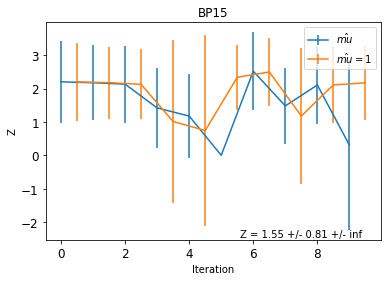

In [595]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.7,-0.05, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)), transform = ax.transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable.pdf')

In [596]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)))

Z = 1.55 +/- 0.81 +/- inf
